<a href="https://colab.research.google.com/github/ronitagarwala01/NASA_GCN_NLP/blob/main/Information_Extraction/InformationExtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Information Extraction Pipeline for the NASA GCN Platform**
The goal of this project is to extract important information from NASA GCN circulars for the purpose of automated data entry into the archive, which is currently done manually.

It is recommended to run this notebook in Google Colab. Please not that before running this notebook you will need to set up a free HuggingFace account and create an access token to pull down models from Huggingface. More info can be found here: https://huggingface.co/docs/hub/en/security-tokens. Store your token in Google Colab's Secrets as HF_LOGIN_TOKEN and turn on notebook access. More info found here: https://drlee.io/how-to-use-secrets-in-google-colab-for-api-key-protection-a-guide-for-openai-huggingface-and-c1ec9e1277e0.

To get results consistent with those reported in the paper, it is recommended to run each section in this notebook sequentially and only once. Re-running it without restarting the runtime may yield slightly different results in certain sections due to the inherently stochastic nature of some of the agorithms used. We also recommend using Google Colab's L4 GPU runtime, which is what we used in our work. This is not a requirement and any GPU runtime may suffice, however using a different runtime may once again produce minor deviations from the results in our paper, as variations in hardware configurations can affect the outcomes of some of the algorithms used. Using the L4 GPU, however, may require the purchase of a temporary subscription to Colab Pro for $10.

#Step 1: Install and Import Libraries and Models

In [ ]:
!wget https://github.com/ronitagarwala01/NASA_GCN_NLP/raw/main/data/archive_2025.json.tar.gz -O /content/archive.json.tar.gz
!wget https://raw.githubusercontent.com/ronitagarwala01/NASA_GCN_NLP/main/data/swift_redshift_data.csv -O /content/swift_redshift_data.csv

--2025-06-15 20:14:36--  https://github.com/ronitagarwala01/NASA_GCN_NLP/raw/main/data/archive_2025.json.tar.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ronitagarwala01/NASA_GCN_NLP/main/data/archive_2025.json.tar.gz [following]
--2025-06-15 20:14:36--  https://raw.githubusercontent.com/ronitagarwala01/NASA_GCN_NLP/main/data/archive_2025.json.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27323287 (26M) [application/octet-stream]
Saving to: ‘/content/archive.json.tar.gz’

/content/archive.js 100%[===================>]  26.06M  --.-KB/s    in 0.1s    

2025-06-15 20:14:37 (226 MB/s

In [ ]:
!pip install langchain-community==0.3.25 -qqq
!CMAKE_ARGS="-DGGML_CUDA=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.3.9 -qqq
!wget https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf
!pip install faiss-cpu==1.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.44
    Uninstalling langsmith-0.3.44:
      Successfully uninstalled langsmith-0.3.44
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.63
    Uninstalling langchain-core-0.3.63:
      Successfully uninstalled langchain-core-0.3.63
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 36.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) .

#Step 2: Extract Data

In [ ]:
'''
Extract circular JSONs from tar file.
'''
import tarfile
import os

with tarfile.open('./archive.json.tar.gz', 'r') as file:
  file.extractall(path='./all_gcn_circulars')

dir = os.listdir('./all_gcn_circulars/archive.json') #Store all file names as strings in dir

#Add file path to beginning of file names in dir
dir = ['./all_gcn_circulars/archive.json/' + filename for filename in sorted(dir)]

print(f'Number of Circular JSONs: {len(dir)}\n')
print(f'First JSON path is: {dir[0]}')

Number of Circular JSONs: 40506

First JSON path is: ./all_gcn_circulars/archive.json/-1.json


In [ ]:
'''
Extract circular bodies from JSON list.
'''
import json

circulars = [] # List of jsons
circular_bodies= [] # List of texts
for file in dir:
  with open(file, encoding='utf-8') as f:
    data = json.load(f)
    circulars.append(data)
    circular_bodies.append(data["subject"]+data["body"])

print(f'The first circular is:\n {circulars[0]}\n')
print(f'The first circular body is:\n {circular_bodies[0]}')

The first circular is:
 {'subject': 'Possible new SGR from US Naval Observatory', 'editedOn': 1720124028651, 'version': 4, 'createdOn': 874022400000, 'editedBy': 'Vidushi Sharma at NASA GSFC/UMBC <vidushi.sharma@nasa.gov> on behalf of Tyler Barna at University of Minnesota <tylerpbarna@gmail.com>', 'submitter': 'Arne A. Henden at USNO/USRA <aah@nofs.navy.mil>', 'circularId': -1, 'email': 'circulars@gcn.nasa.gov', 'format': 'text/plain', 'body': 'The following report from A. Hendon et al. on the recent "possible new SGR"\n(ref IAUC 6743) has also been submitted to the IAUC:\n\n\nA. Henden, Universities Space Research Corporation (USRA) and U. S. Naval\nObservatory, Flagstaff Station (USNOFS)  aah@nofs.navy.mil\nC. Luginbuhl, USNOFS  cbl@nofs.navy.mil\nF. Vrba, USNOFS       fjv@nofs.navy.mil\nB. Canzian, USRA/USNOFS  bjc@nofs.navy.mil\nJ. Munn USNOFS           jam@nofs.navy.mil\nD. Hartmann, Clemson University  hartmann@grb.phys.clemson.edu\n\nWe report a strong near-IR source about 2 ar

In [ ]:
'''
Remove all undefined characters.
'''

clean_texts = []
for text in circular_bodies:
  clean_text = text.replace('�', '')
  clean_texts.append(clean_text)

circular_bodies = clean_texts

In [ ]:
'''
Extract table data from csv file.
This will contain our evaluation data for the model.
'''
import pandas as pd

swift_df = pd.read_csv('swift_redshift_data.csv', skiprows=0, header=0)
swift_df.head(10)

GRB  Time[UT] TriggerNumber        BAT RA(J2000)        BAT Dec(J2000)  \
0  230818A  23:27:34       1186032  285.888\n19:03:33.1    40.888\n40:53:16.8   
1  230506C  17:09:19       1167288  134.371\n08:57:29.0    45.131\n45:07:51.6   
2  230414B  16:14:21       1164180  181.052\n12:04:12.5    53.179\n53:10:44.4   
3  230328B  14:54:48       1162001  291.037\n19:24:08.9    80.013\n80:00:46.8   
4  230325A   3:15:35       1161390  296.854\n19:47:25.0  -46.067\n-46:04:01.2   
5  230116D  21:04:43       1149293   98.584\n06:34:20.2    49.831\n49:49:51.6   
6  221226B  22:41:20       1145959   22.903\n01:31:36.7  -41.515\n-41:30:54.0   
7  221110A   2:28:17       1136936   29.106\n01:56:25.4  -27.298\n-27:17:52.8   
8  221009A  14:10:17       1126853  288.254\n19:13:01.0    19.809\n19:48:32.4   
9  220611A  18:01:51       1110090   66.505\n04:26:01.2  -37.265\n-37:15:54.0   

  BAT T90[sec]  BAT Fluence(15-150 keV)[10-7 erg/cm2] XRT RA(J2000)  \
0         9.82                                  19.00       03:33.1   
1           31                                  17.00       57:28.2   
2        25.98                                   4.70       04:22.7   
3        19.23                                  43.00       24:01.6   
4        38.05                                  13.00       47:23.9   
5           41                                   8.12       34:28.3   
6         3.44                                   5.40       31:38.1   
7         8.98                                   5.10       56:23.8   
8       1068.4                                 740.00       13:03.9   
9           57                                   6.70       26:03.5   

  XRT Dec(J2000)  XRT Time to FirstObservation[sec]  \
0        53:48.3                             141.12   
1        07:58.6                            4600.00   
2        09:15.7                             128.57   
3        00:34.4                             110.33   
4    -46:04:33.9                              94.05   
5        52:22.3                             130.90   
6    -41:31:36.0                             102.93   
7    -27:17:44.5                              53.05   
8        46:22.7                              91.60   
9    -37:15:35.6                             149.22   

   XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s] UVOT RA(J2000) UVOT Dec(J2000)  \
0                                          NaN        03:33.1         53:49.0   
1                                          NaN            NaN             NaN   
2                                          NaN            NaN             NaN   
3                                          NaN        24:01.9         00:34.6   
4                                        206.0            NaN             NaN   
5                                          NaN            NaN             NaN   
6                                          NaN            NaN             NaN   
7                                         79.1        56:23.7    -27:17:45.09   
8                                       2510.0        13:03.5         46:24.6   
9                                          NaN            NaN             NaN   

  UVOT Time toFirst Observation[sec] UVOT Magnitude  \
0                                144        V=18.40   
1                               4600         V>19.2   
2                                133        V>18.53   
3                                114         V>17.6   
4                                102         V>18.9   
5                                133            NaN   
6                                 76         V>19.3   
7                                 83         V>19.5   
8                                179       V= 15.55   
9                                153         V>17.0   

                        Other Observatory Detections  \
0  MASTER-Tavrida, Fermi (GBM), GOTO, SAO RAS Zei...   
1       TSHAO Zeiss-1000, D50, T193-OHP, Fermi (GBM)   
2  Mondy/AZT-33IK, Nanshan/HMT (0.5m), GROWTH-Ind...   
3  Fe

In [ ]:
'''
Get smaller dataframe with relevant information only.
This section converts the SWIFT GRB Table to a python dict.
The end result is a dict with key = GCN No. and value = Redshift, Telescope, and GRB Information as Text.
'''
import re

sub_df = swift_df[['References', 'Redshift', 'GRB']].copy()
removed_list = []
removed_indices=[]
gcn_format = re.compile('GCN ?\d+( *\(.*?\))?')
gcn_number_format = re.compile('GCN ?(\d+)')
bracket_format = re.compile(' ?\([^)]*\)')
instrument_format_1 = re.compile('\((.*?)\)')
instrument_format_2 = re.compile('\(([^):]*)')
redshift_type_format = re.compile('')

# Extract just the Redshift References from the References column
for index, row in sub_df.iterrows():
  row['References'] = row['References'].splitlines()
  row['Redshift'] = row['Redshift'].splitlines()

  temp=''
  for line in row['References']: # Extract only redshift references
    if line[0:8] == 'Redshift':
      temp = line
  if temp != '':
    row['References'] = temp

  if isinstance(row['References'], list): # Drop the non-uniform data for now
    removed_list.append((row['References'], row['Redshift'], row['GRB']))
    removed_indices.append(index)

redshift_list = [] # List of tuples
sub_df = sub_df.drop(removed_indices)

# Create a list of tuples
# Each tuple contains a GCN No. with it's corresponding Redshift Text and GRB Name
for index, row in sub_df.iterrows():
  gcn_iter = gcn_format.finditer(row['References'])
  gcns = list(gcn_iter)

  # References with only one circular don't need any further iteration
  if len(gcns) == 1 and len(row['Redshift']) == 1:
    gcn_num_match = gcn_number_format.search(gcns[0].group())
    instrument_match_1 = instrument_format_1.search(gcns[0].group())
    instrument_match_2 = instrument_format_2.search(row['Redshift'][0])
    instrument_name = ''
    if instrument_match_1 == None and instrument_match_2 == None: # Drop references with no instrument name for now
      removed_list.append((row['References'], row['Redshift'], row['GRB']))
      continue

    elif instrument_match_1 != None:
      instrument_name = instrument_match_1.group(1)

    elif instrument_match_2 != None:
      instrument_name = instrument_match_2.group(1)

    redshift_type = 'No Information'
    if "absorption" in row["Redshift"][0].lower() or "emission" in row["Redshift"][0].lower():
      redshift_type = "Spectroscopic"
    elif "photometric" in row["Redshift"][0].lower():
      redshift_type = "Photometric"

    gcn_num = gcn_num_match.group(1)
    redshift_text = bracket_format.sub('', row['Redshift'][0])
    grb_name = row['GRB']

    if len(redshift_text.split(',')) != 1: # Drop the non-uniform data for now
      removed_list.append((row['References'], row['Redshift'], row['GRB']))
      continue

    redshift_list.append((gcn_num, redshift_text.strip().lower(), grb_name.strip(), instrument_name.strip(), redshift_type.strip()))

  # If multiple circulars are present, iterate through them all
  else:
    for gcn in gcns:
      for redshift in row['Redshift']:

        # Extract instrument name from reference
        instrument_match_1 = instrument_format_1.search(gcn.group())
        if instrument_match_1 == None:
          continue
        instrument_name_1 = instrument_match_1.group(1)

        # Extract instrument name from redshift text
        instrument_match_2 = instrument_format_2.search(redshift)
        if instrument_match_2 == None:
          continue
        instrument_name_2 = instrument_match_2.group(1)

        # Check to see if both instruments match. If yes, append tuple to list
        if instrument_name_1 == instrument_name_2:
          gcn_num_match = gcn_number_format.search(gcn.group())
          gcn_num = gcn_num_match.group(1)
          redshift_text = bracket_format.sub('', redshift)
          grb_name = row['GRB']
          redshift_type = 'No Information'
          if "absorption" in redshift.lower() or "emission" in redshift.lower():
            redshift_type = "Spectroscopic"
          elif "photometric" in redshift.lower():
            redshift_type = "Photometric"

          redshift_list.append((gcn_num, redshift_text.strip().lower(), grb_name.strip(), instrument_name_1.strip(), redshift_type.strip()))

# Create Redshift Dict
redshift_dict = {} # Dict for redshift data
removed_circulars = ['21209', '12542', '11997', '6651', '5946'] #Indices that need manual re-entry
for data_tuple in redshift_list:
  if data_tuple[0] in removed_circulars:
    removed_list.append(data_tuple)
  else:
    redshift_dict[data_tuple[0]] = (data_tuple[1], data_tuple[2], data_tuple[3], data_tuple[4])

for item in removed_list:
  print(item)

print(len(removed_list))
print(len(redshift_dict))

(['BAT: GCN 29677; GCN 29691', 'XRT: GCN 29678; GCN 29681; GCN 29686; Evans et al., 2009, MNRAS, 397, 1177', 'UVOT: GCN 29679; GCN 29697', 'Radio: GCN 29685 (OSIRIS/GTC)'], ['1.487 (OSIRIS/GTC)'], '210321A')
(['BAT: GCN 19645; GCN 19648', 'XRT: GCN 19655; Evans et al., 2009, MNRAS, 397, 1177', 'UVOT: GCN 19645; GCN 19656', 'Radio: GCN 19849 (GMRT)'], ['The detection in all UVOT filters is consistent with a redshift of z < ~1.5'], '160703A')
(['BAT: GCN 18076; GCN 18086', 'XRT: GCN 18076; GCN 18079; GCN 18082; Evans et al., 2009, MNRAS, 397, 1177', 'UVOT: GCN 18076; GCN 18084', 'Radio: GCN 18080 (VLT)'], ['0.313 (VLT: emission)'], '150727A')
('Redshift: GCN 33609', ['Minimal possible redshift value of z = 0.09'], '230328B')
('Redshift: GCN 26538 (UVOT); GCN (VLT)', ['1.19 (UVOT), 1.148 (VLT: absorption)'], '191221B')
('21209', 'consistent with gtc results', '170531B', 'WHT', 'No Information')
('12542', 'consistent with gemini-south', '111107A', 'VLT', 'Spectroscopic')
('11997', '1.61, p

In [ ]:
print(redshift_dict["5319"])

('z<2.3', '060708', 'VLT', 'No Information')


In [ ]:
'''
Add back removed data points after manual lookup
'''

redshift_dict['29685'] = ('1.487', '210321A', 'OSIRIS/GTC', 'No Information')
redshift_dict['18080'] = ('0.313', '150727A', 'VLT', 'Spectroscopic')
redshift_dict['26538'] = ('1.19', '191221B', 'UVOT', 'Spectroscopic')
redshift_dict['21209'] = ('consistent with that obtained by de ugarte-postigo et al. (gcn 21177)', '170531B', 'WHT', 'No Information')
redshift_dict['12542'] = ('consistent with that reported by chornock et al. (gcn 12537)', '111107A', 'VLT', 'Spectroscopic')
redshift_dict['11997'] = ('1.61', '110503A', 'TNG', 'Spectroscopic')
redshift_dict['6651'] = ('3.626', '070721B', 'VLT', 'No Information')
redshift_dict['5946'] = ('0.41', '061210', 'Keck', 'Spectroscopic')
redshift_dict['19656'] = ('z < ~1.5', '160703A', 'UVOT', 'No Information')

print(len(redshift_dict))
print(redshift_dict['23537'])

547
('<2.4', '181213A', 'NOT', 'No Information')


In [ ]:
'''
Get redshift circulars with no redshift data.
These circulars are manually selected and the data extracted is added to the evaluation table.
'''

no_redshift_circulars = []
no_redshift_circular_bodies = []
no_redshift_list = [1, 10, 100, 1000, 10000, 10001, 10002, 10003, 10004, 10005,
                    10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015,
                    10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025,
                    10026, 10027, 10028, 10029, 1003, 10030, 10034, 10035, 10036, 10037,
                    10039, 1004, 10040, 10043, 10044, 10046, 10047, 10048, 1005, 10050,
                    10051, 10052, 10058, 10059, 10060, 10061, 10062, 10063, 10064, 10066,
                    10067, 10068, 1007, 10070, 10071, 10072, 10073, 10074, 10075, 10076,
                    10077, 10078, 10079, 1008, 10080, 10081, 10082, 10084, 10085, 10086,
                    10087, 10088, 10089, 1009, 10090, 10091, 10092, 10094, 10095, 10096,
                    10097, 10098, 10099, 101, 10101, 10102, 10103, 10104, 10105, 10106]

for i, text in enumerate(circular_bodies):
  if circulars[i]["circularId"] in no_redshift_list:
    no_redshift_circulars.append(circulars[i])
    no_redshift_circular_bodies.append(text)

print(len(no_redshift_circulars))

100


In [ ]:
'''
Build our final evaluation dictionary by appending no redshift circulars.
'''

eval_dict = redshift_dict.copy()
for circular in no_redshift_circulars:
  eval_dict[str(circular["circularId"])] = ("No Redshift", "No Information", "No Information", "No Information")

print(len(eval_dict))
print(eval_dict["10106"]) # Circular with no reported redshift

647
('No Redshift', 'No Information', 'No Information', 'No Information')


In [ ]:
'''
Get list of test circulars.
'''

test_circulars = []
test_circular_bodies = []
for circular, body in zip(circulars, circular_bodies):
  if str(circular["circularId"]) in list(eval_dict.keys()):
    test_circulars.append(circular)
    test_circular_bodies.append(body)

print(len(test_circulars))

645


Note: Two circulars - GCN 20589 and GCN 18506 - are not in our tarfile. Thus we skip them.

#Step 3: Instantiate Llama CPP Model for Information Extraction

In [ ]:
'''
Instantiate LlamaCpp object for inference.
We use the quantized mistral-7b-instruct model.
'''
from langchain_community.llms import LlamaCpp

max_context_length = 32768
llm = LlamaCpp(model_path="mistral-7b-instruct-v0.2.Q4_K_M.gguf",
               n_gpu_layers=-1,
               n_ctx=max_context_length)

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA L4, compute capability 8.9, VMM: yes
llama_model_load_from_file_impl: using device CUDA0 (NVIDIA L4) - 22503 MiB free
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u3

#Step 4: LLM Testing using LangChain

We'll use the LangChain library to query a circular and extract redshift information from it.

In [ ]:
'''
Create prompt template which accepts a single circular as input.
'''
from langchain.prompts import PromptTemplate

template_string = """Q: This is a circular from NASA:

{circular}

Given the above information, can you state what the observed redshift was? \
If there is no answer just say no redshift was observed. \
If you find a redshift, also mention the name of the telescope used for \
observation, as well as the GRB number. \
Also mention whether the redshift was photometric or spectroscopic.\

A: """

prompt_template = PromptTemplate.from_template(template_string)

prompt_template

PromptTemplate(input_variables=['circular'], input_types={}, partial_variables={}, template='Q: This is a circular from NASA:\n\n{circular}\n\nGiven the above information, can you state what the observed redshift was? If there is no answer just say no redshift was observed. If you find a redshift, also mention the name of the telescope used for observation, as well as the GRB number. Also mention whether the redshift was photometric or spectroscopic.\nA: ')

In [ ]:
'''
Test model.
'''

prompt = prompt_template.format(circular=test_circular_bodies[300])
model_output = llm(prompt,
                   max_tokens=256,
                   temperature=0.0,
                   stop=["Q:"])

<ipython-input-15-3509549486>:6: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  model_output = llm(prompt,
llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    1762.70 ms /   297 tokens (    5.94 ms per token,   168.49 tokens per second)
llama_perf_context_print:        eval time =    1093.93 ms /    53 runs   (   20.64 ms per token,    48.45 tokens per second)
llama_perf_context_print:       total time =    2915.12 ms /   350 tokens


In [ ]:
print(prompt)

Q: This is a circular from NASA:

GRB 151027A: Keck/HIRES redshiftD. A. Perley (DARK/NBI), L. Hillenbrand (Caltech), and J. X. Prochaska 
(UCO/Lick) report:

We obtained a 900s spectrum of the optical afterglow of GRB 151027A 
(Maselli et al., GCN 18478) with Keck/HIRES starting at UT 06:54 on 
2015-10-27.  In the preliminary reduction, we identify a series of 
strong absorption lines including the MgII doublet at z=0.81. Associated 
MgI, FeII, and (likely) FeII* are also present, indicating that this is 
the redshift of the GRB.  Analysis is ongoing.

Given the above information, can you state what the observed redshift was? If there is no answer just say no redshift was observed. If you find a redshift, also mention the name of the telescope used for observation, as well as the GRB number. Also mention whether the redshift was photometric or spectroscopic.
A: 


In [ ]:
print(model_output.strip())

The observed redshift was z=0.81. The observation was made using the Keck/HIRES telescope. The GRB number is 151027A. The redshift was obtained through spectroscopic analysis.


In [ ]:
test_gcn_num = str(test_circulars[300]["circularId"])
print(f"Actual Values for Redshift, GRB Number and Telescope Name respectively: {eval_dict[test_gcn_num]}")

Actual Values for Redshift, GRB Number and Telescope Name respectively: ('0.81', '151027A', 'Keck', 'Spectroscopic')


The model seems to be working as intended. Next we will try to build a LangChain chain for sequential querying of the circulars.

#Step 5: Parsing LLM Output to Python Dict

In [ ]:
'''
Create response schemas to be used by output parser.
From the output parser get the format instructions to be passed to our prompt template.
'''
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

redshift_value_schema = ResponseSchema(name="Redshift Value", description="Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. \
If multiple measurements are present, only pick the most likely one.")
telescope_schema = ResponseSchema(name="Telescope", description="What was the name of the telescope used for observation? If not provided, answer No Information.")
event_schema = ResponseSchema(name="Event", description="Extract the GRB Number of the event. If not provided, answer No Information.")
redshift_type_schema = ResponseSchema(name="Redshift Type", description="How was the redshift determined? \
Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. \
If there's no information on the redshift type, answer No Information.")

response_schemas = [redshift_value_schema,
                    telescope_schema,
                    event_schema,
                    redshift_type_schema]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

format_instructions = output_parser.get_format_instructions()
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"Redshift Value": string  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": string  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": string  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": string  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```


In [ ]:
'''
Create a modified prompt template to generate json.
'''

template_string = """Q: This is a circular from NASA:

{circular}

For the given circular, can you extract the following information:

Redshift Value: Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.\
If multiple measurements are present, only pick the most likely one.
Telescope: What was the name of the telescope used for observation? \
Event: Extract the GRB Number of the event. \
Redshift Type: How was the redshift determined? Answer Photometric if it was photometric. \
Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. \
If there's no redshift value, answer No Redshift. If there's no information on the type, answer No Information.

{format_instructions}

A: """

prompt_template = PromptTemplate.from_template(template_string)

prompt_template

PromptTemplate(input_variables=['circular', 'format_instructions'], input_types={}, partial_variables={}, template="Q: This is a circular from NASA:\n\n{circular}\n\nFor the given circular, can you extract the following information:\n\nRedshift Value: Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.If multiple measurements are present, only pick the most likely one.\nTelescope: What was the name of the telescope used for observation? Event: Extract the GRB Number of the event. Redshift Type: How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the type, answer No Information.\n\n{format_instructions}\n\nA: ")

In [ ]:
'''
Test model.
'''
import torch
import random
import numpy as np

# Set number of threads to 1 and set other os environment variables for reproducibility
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.set_num_threads(1)

seed_value = 42  # Set the random seed
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.use_deterministic_algorithms(True)

prompt = prompt_template.format(circular=test_circular_bodies[300],
                                format_instructions=format_instructions)

model_output = llm(prompt,
                   max_tokens=256,
                   temperature=0.0,
                   stop=["Q:"],
                   seed=0)

Llama.generate: 222 prefix-match hit, remaining 382 prompt tokens to eval
llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    1856.12 ms /   382 tokens (    4.86 ms per token,   205.81 tokens per second)
llama_perf_context_print:        eval time =    4560.29 ms /   218 runs   (   20.92 ms per token,    47.80 tokens per second)
llama_perf_context_print:       total time =    6695.49 ms /   600 tokens


In [ ]:
print(prompt)

Q: This is a circular from NASA:

GRB 151027A: Keck/HIRES redshiftD. A. Perley (DARK/NBI), L. Hillenbrand (Caltech), and J. X. Prochaska 
(UCO/Lick) report:

We obtained a 900s spectrum of the optical afterglow of GRB 151027A 
(Maselli et al., GCN 18478) with Keck/HIRES starting at UT 06:54 on 
2015-10-27.  In the preliminary reduction, we identify a series of 
strong absorption lines including the MgII doublet at z=0.81. Associated 
MgI, FeII, and (likely) FeII* are also present, indicating that this is 
the redshift of the GRB.  Analysis is ongoing.

For the given circular, can you extract the following information:

Redshift Value: Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.If multiple measurements are present, only pick the most likely one.
Telescope: What was the name of the telescope used for observation? Event: Extract the GRB Number of the event. Redshift Type: How was the redshift determined? Answer Photometric if it was photometric. An

In [ ]:
print(model_output)



```json
{
	"Redshift Value": "0.81",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/HIRES",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```


In [ ]:
model_output = re.sub(r"\s*\/\/.*?$", "", model_output, flags=re.MULTILINE) # Remove any comments in string before parsing
print(model_output)



```json
{
	"Redshift Value": "0.81",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"
}
```


In [ ]:
with open('sample_prompt.txt', 'w') as f:
  f.write(prompt)
  f.write(model_output)

In [ ]:
output_dict = output_parser.parse(model_output)
print(output_dict)

{'Redshift Value': '0.81', 'Telescope': 'Keck/HIRES', 'Event': 'GRB 151027A', 'Redshift Type': 'Spectroscopic'}


In [ ]:
test_gcn_num = str(test_circulars[300]["circularId"])
print(f"Actual Values for Redshift, GRB Number and Telescope Name respectively: {eval_dict[test_gcn_num]}")

Actual Values for Redshift, GRB Number and Telescope Name respectively: ('0.81', '151027A', 'Keck', 'Spectroscopic')


We see that we're able to get our output in the form of a python dictionary, which we can use to create a data table.

#Step 6: Extract Redshift Information from all Test Circulars

In [ ]:
'''
Compare predicted redshift values to actual redshift values for the SWIFT GRB table.
'''
from transformers import AutoTokenizer
from google.colab import userdata
from huggingface_hub import login
from tqdm import tqdm
from datetime import datetime

# Huggingface login required to use Mistral 7B Instruct
# Make sure to save your own Huggingface login token in your Notebook's Secrets as 'HF_LOGIN_TOKEN'
login_token = userdata.get('HF_LOGIN_TOKEN')
login(token=login_token)

# Set number of threads to 1 and set other os environment variables for reproducibility
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.set_num_threads(1)

seed_value = 42  # Set the random seed
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.use_deterministic_algorithms(True)

accuracy_df = pd.DataFrame(columns=['Circular Number',
                                    'Text',
                                    'Actual Redshift',
                                    'Predicted Redshift',
                                    'Actual GRB Number',
                                    'Predicted GRB Number',
                                    'Actual Telescope Name',
                                    'Predicted Telescope Name',
                                    'Actual Redshift Type',
                                    'Predicted Redshift Type',
                                    'Circular Date'])

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
max_context_length = 32768
unparseable_circulars_swift = []

# Create Accuracy Dataframe for Model Evaluation
for circular, body in tqdm(zip(test_circulars, test_circular_bodies)):

  print(circular["circularId"])
  print(body)

  gcn_num = str(circular["circularId"])
  true_redshift = eval_dict[gcn_num][0]
  true_grb_number = eval_dict[gcn_num][1]
  true_telescope = eval_dict[gcn_num][2]
  true_redshift_type = eval_dict[gcn_num][3]
  circular_date = datetime.utcfromtimestamp(circular["createdOn"]/1000)

  # We use prompt with formatted instructions for later output parsing
  prompt = prompt_template.format(circular=body,
                                  format_instructions=format_instructions)

  # Throw error if prompt length exceeds max context length
  encoded_prompt = tokenizer.encode(prompt)
  if len(encoded_prompt) > max_context_length:
    raise ValueError("Encoded prompt exceeds model's maximum allowed length.")

  model_output = llm(
        prompt,
        max_tokens=256,
        temperature=0.0,
        stop=["Q:"],
        seed=0)

  print(model_output)

  try:
    output_dict = output_parser.parse(model_output)
  except:
    model_output = model_output.replace("\\", "\\\\") # Make '\' parseable into JSON
    model_output = model_output.replace("N/A", "No Redshift") # Fix null values
    model_output = model_output.replace("None", "No Redshift")
    model_output = model_output.replace("null", '"No Redshift"')
    model_output = re.sub(r"\s*\/\/.*?$", "", model_output, flags=re.MULTILINE) # Remove any comments in string before parsing
    model_output = re.sub(r':\s*([A-Za-z\s]+)(?=,|\n)', r': "\1"', model_output) # Fix any values not in ""s
    model_output = re.sub(r'\\\\\"', '\\"', model_output) # Replace \\" with \"
    json_match = re.search(r'```[\s\S]*?```', model_output) # Get everything within the ```...```and nothing else
    if json_match:
      model_output = json_match.group()
    model_output = re.sub(r'"\n', r'",\n', model_output) # Add commas at the end of json attributes
    model_output = re.sub(r',\s*}', '}', model_output) # Replace dangling commas at the end
    model_output = re.sub(r': ([^"].*[^"]),', r': "\1",', model_output) # Put all values in double quotes
    model_output = re.sub(r': ([^"].*[^"])', r': "\1"', model_output)
    # Remove [" and "]
    model_output = re.sub(r'"\[\"', '"', model_output)
    model_output = re.sub(r'"\]\"', '"', model_output)
    # Replace '", "' with ", "
    model_output = re.sub(r'", "', ', ', model_output)

    print(model_output)

  try:
    output_dict = output_parser.parse(model_output)
  except:
    unparseable_circulars_swift.append(circular)
    continue

  predicted_redshift = output_dict["Redshift Value"]
  predicted_grb_number = output_dict["Event"]
  predicted_telescope = output_dict["Telescope"]
  predicted_redshift_type = output_dict["Redshift Type"]

  new_row = {
    "Circular Number": gcn_num,
    "Text": body,
    "Actual Redshift": true_redshift,
    "Predicted Redshift": str(predicted_redshift),
    "Actual GRB Number": true_grb_number,
    "Predicted GRB Number": str(predicted_grb_number),
    "Actual Telescope Name": true_telescope,
    "Predicted Telescope Name": str(predicted_telescope),
    "Actual Redshift Type": true_redshift_type,
    "Predicted Redshift Type": str(predicted_redshift_type),
    "Circular Date": circular_date
  }
  new_row_df = pd.DataFrame([new_row])
  accuracy_df = pd.concat([accuracy_df, new_row_df], ignore_index=True)

0it [00:00, ?it/s]Llama.generate: 15 prefix-match hit, remaining 588 prompt tokens to eval


1
GRB 970925: BATSE LocalizationThe BATSE team report a change to the LOCBURST procedure:

The BATSE-RBR location of GRB970925 had a larger-than-average systematic
location error and was inconsistent with the IPN annulus.  The reprocessed
location, however, using the full data set, is entirely consistent with the IPN
annulus.  The RBR team has determined the cause of the error and, although they
could not have anticipated it, we now have a procedure in place to check for
similar problems in future events.  While this will add time to the location
processing, we feel it will minimize the chances that future problematic events
will be distributed via GCN/RBR.  As a result of this new filtering process, a
bright BATSE trigger might not automatically be followed by a locburst notice.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3160.78 ms /   588 tokens (    5.38 ms per token,   186.03 tokens per second)
llama_perf_context_print:        eval time =    5389.54 ms /   255 runs   (   21.14 ms per token,    47.31 tokens per second)
llama_perf_context_print:       total time =    8865.98 ms /   843 tokens
<ipython-input-37-473123129>:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracy_df = pd.concat([accuracy_df, new_row_df], ignore_index=True)
1it [00:08,  8.90s/it]Llama.generate: 17 prefix-match hit, remaining 990 prompt tokens to eval




```json
{
	"Redshift Value": "0.692",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB970925",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event with number "GRB970925" was observed by a telescope named "Swift". The redshift for this event was determined
```json
{
	"Redshift Value": "0.692",
	"Telescope": "Swift",
	"Event": "GRB970925",
	"Re

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5516.66 ms /   990 tokens (    5.57 ms per token,   179.46 tokens per second)
llama_perf_context_print:        eval time =    5494.06 ms /   255 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_perf_context_print:       total time =   11328.39 ms /  1245 tokens
2it [00:20, 10.35s/it]Llama.generate: 14 prefix-match hit, remaining 616 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Kitt Peak National Observatory (KPNO)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 971214",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The name of the telescope used for observation is "Kitt Peak National
```json
{
	"Redshift Value": "No Redshift"

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3479.56 ms /   616 tokens (    5.65 ms per token,   177.03 tokens per second)
llama_perf_context_print:        eval time =    5425.47 ms /   255 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9217.95 ms /   871 tokens
3it [00:29,  9.84s/it]Llama.generate: 14 prefix-match hit, remaining 910 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "UC Berkeley Space Sciences Laboratory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB980611 (BATSE 6816)",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet contains the extracted information from the circular in a structured JSON format. The output includes the redshift value (No Redshift), telescope name (UC Berkeley Space Sciences Laboratory
```json
{
	"Redshift Value": "No Redshi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5214.44 ms /   910 tokens (    5.73 ms per token,   174.52 tokens per second)
llama_perf_context_print:        eval time =    4687.84 ms /   218 runs   (   21.50 ms per token,    46.50 tokens per second)
llama_perf_context_print:       total time =   10163.29 ms /  1128 tokens
4it [00:39,  9.98s/it]Llama.generate: 14 prefix-match hit, remaining 824 prompt tokens to eval




```json
{
	"Redshift Value": "1.25 +/- 0.06", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "CFHT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB010222", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.25 +/- 0.06",
	"Telescope": "CFHT",
	"Event": "GRB010222",
	"Redshift Type": "Spectroscopic"}
```
10000
GRB 090904A: afterglow confirmationDaniele Malesani (DARK/NBI), Pall Jakobsson (Univ. Iceland), and I

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4646.25 ms /   824 tokens (    5.64 ms per token,   177.35 tokens per second)
llama_perf_context_print:        eval time =    4517.10 ms /   211 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =    9413.18 ms /  1035 tokens
5it [00:49,  9.78s/it]Llama.generate: 12 prefix-match hit, remaining 766 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090904A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOT",
	"Event": "GRB 090904A",
	"Redshift Type": "No Information"}
```
10001
Short-Duration GRB 090621: Skynet/Dolomiti ObservationsJ. Haislip, D. Reichart, M. Maturi, K. Iva

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4271.95 ms /   766 tokens (    5.58 ms per token,   179.31 tokens per second)
llama_perf_context_print:        eval time =    5448.84 ms /   255 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =   10038.40 ms /  1021 tokens
6it [00:59,  9.88s/it]Llama.generate: 12 prefix-match hit, remaining 854 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Dolomiti Astronomical Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090621",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred on June 21, 2009. The observation was carried out using the 16" telescope at
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Dolomiti Astronomical

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4709.50 ms /   854 tokens (    5.51 ms per token,   181.34 tokens per second)
llama_perf_context_print:        eval time =    5451.95 ms /   255 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =   10477.94 ms /  1109 tokens
7it [01:09, 10.09s/it]Llama.generate: 18 prefix-match hit, remaining 874 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "PROMPT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090518",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the circular does not provide any information about the redshift determination for the GRB event. Additionally, it appears that the telescope used for observation was named "PROMPT". Finally,
```json
{
	"

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4792.57 ms /   874 tokens (    5.48 ms per token,   182.37 tokens per second)
llama_perf_context_print:        eval time =    5448.22 ms /   255 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =   10557.29 ms /  1129 tokens
8it [01:20, 10.25s/it]Llama.generate: 19 prefix-match hit, remaining 1042 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "CTIO",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090926A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB 090926A".
* The telescope used
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "CTIO",
	"Event": "GRB 090926

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5717.03 ms /  1042 tokens (    5.49 ms per token,   182.26 tokens per second)
llama_perf_context_print:        eval time =    5492.59 ms /   255 runs   (   21.54 ms per token,    46.43 tokens per second)
llama_perf_context_print:       total time =   11528.26 ms /  1297 tokens
9it [01:31, 10.66s/it]Llama.generate: 12 prefix-match hit, remaining 495 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "AGILE",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090910",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a long gamma ray burst (GRB) by the SuperAGILE system on October 10, 2009, at 02:
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "AGILE",
	"Event": "GRB 090910",
	"Redshift Type

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    2687.89 ms /   495 tokens (    5.43 ms per token,   184.16 tokens per second)
llama_perf_context_print:        eval time =    5361.03 ms /   255 runs   (   21.02 ms per token,    47.57 tokens per second)
llama_perf_context_print:       total time =    8360.22 ms /   750 tokens
10it [01:40,  9.96s/it]Llama.generate: 12 prefix-match hit, remaining 856 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "INAF/IASF Rome",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred on October 10, 2009, and was observed using the INAF/IASF Rome telescope. However,
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "INAF/IASF Rome",
	"Event": "GRB

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4712.12 ms /   856 tokens (    5.50 ms per token,   181.66 tokens per second)
llama_perf_context_print:        eval time =    4575.67 ms /   214 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    9542.83 ms /  1070 tokens
11it [01:49,  9.84s/it]Llama.generate: 24 prefix-match hit, remaining 734 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"}
```
10007
GRB 091010: Swift/UVOT Upper LimitsP.A. Curran (MSSL-UCL) and R. Margutti (INAF-OAB) re

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4050.95 ms /   734 tokens (    5.52 ms per token,   181.19 tokens per second)
llama_perf_context_print:        eval time =    4506.87 ms /   211 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    8807.57 ms /   945 tokens
12it [01:58,  9.53s/it]Llama.generate: 22 prefix-match hit, remaining 775 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"}
```
10008
GRB 091010: GROND afterglow candidateA. Rossi (Tautenburg), A. Rau, P. Afonso and J. Greiner (a

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4301.29 ms /   775 tokens (    5.55 ms per token,   180.18 tokens per second)
llama_perf_context_print:        eval time =    4903.15 ms /   229 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =    9484.93 ms /  1004 tokens
13it [02:08,  9.52s/it]Llama.generate: 12 prefix-match hit, remaining 986 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"}
```
100

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5528.47 ms /   986 tokens (    5.61 ms per token,   178.35 tokens per second)
llama_perf_context_print:        eval time =    4707.82 ms /   219 runs   (   21.50 ms per token,    46.52 tokens per second)
llama_perf_context_print:       total time =   10498.03 ms /  1205 tokens
14it [02:18,  9.83s/it]Llama.generate: 12 prefix-match hit, remaining 960 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "CORONAS-PHOTON satellite",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090926A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "CORONAS-PHOTON satellite",
	"Event": "GRB 090926A",
	"Redshift Type": "No Information"}
```
10010
Detection of a short GRB 090929A by RT-2 ExperimentS. K

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5349.78 ms /   960 tokens (    5.57 ms per token,   179.45 tokens per second)
llama_perf_context_print:        eval time =    5476.82 ms /   255 runs   (   21.48 ms per token,    46.56 tokens per second)
llama_perf_context_print:       total time =   11140.88 ms /  1215 tokens
15it [02:29, 10.23s/it]Llama.generate: 12 prefix-match hit, remaining 950 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "CORONAS-PHOTON satellite",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090929A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a short GRB (Gamma-Ray Burst) named GRB090929A by the RT-2
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "CORONAS-PHOTON satellite",
	"Event": "GRB090929A",


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5286.46 ms /   950 tokens (    5.56 ms per token,   179.70 tokens per second)
llama_perf_context_print:        eval time =    5018.39 ms /   234 runs   (   21.45 ms per token,    46.63 tokens per second)
llama_perf_context_print:       total time =   10588.90 ms /  1184 tokens
16it [02:40, 10.35s/it]Llama.generate: 21 prefix-match hit, remaining 735 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "A&M 130-mm TMB APO with an SBIG ST2000 CCD camera and no filter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "A&M 130-mm TMB APO with an SBIG ST2000 CCD camera and no filter",
	"Event": "GRB 091010",
	"Redshift Type": "No Inform

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4066.81 ms /   735 tokens (    5.53 ms per token,   180.73 tokens per second)
llama_perf_context_print:        eval time =    5439.39 ms /   255 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9818.05 ms /   990 tokens
17it [02:50, 10.20s/it]Llama.generate: 12 prefix-match hit, remaining 876 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular from NASA reports the position of a gamma-ray burst (GRB) named GRB 091010. The Swift-XRT team
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091010",
	"Redshift Type": "

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4838.36 ms /   876 tokens (    5.52 ms per token,   181.05 tokens per second)
llama_perf_context_print:        eval time =    4388.81 ms /   205 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =    9469.22 ms /  1081 tokens
18it [02:59,  9.99s/it]Llama.generate: 12 prefix-match hit, remaining 1024 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB 091010",
	"Redshift Type": "Spectroscopic"}
```
10014
GRB 091010: RXTE detectionA.L. Watts, A. Patruno, M. van der Klis (U.v. Amsterdam),
P. Casella (Southampton),
P.A. Curran (MSSL-UCL),
D. Altamirano, Y. Cave

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5656.68 ms /  1024 tokens (    5.52 ms per token,   181.03 tokens per second)
llama_perf_context_print:        eval time =    5485.57 ms /   255 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =   11456.51 ms /  1279 tokens
19it [03:11, 10.44s/it]Llama.generate: 17 prefix-match hit, remaining 827 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "RXTE",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This code snippet extracts the following information from the given circular:

- The GRB event number is "GRB 091010".
- The telescope used for observation was
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RXTE",
	"Even

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4554.54 ms /   827 tokens (    5.51 ms per token,   181.58 tokens per second)
llama_perf_context_print:        eval time =    5453.80 ms /   255 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10325.33 ms /  1082 tokens
20it [03:21, 10.41s/it]Llama.generate: 20 prefix-match hit, remaining 982 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Dark Sky Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090530A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred without a recorded redshift value. The telescope used for observation was the Dark Sky Observatory. The GRB event number was GRB
```json
{
	"Redshift Value": "No Redsh

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5421.03 ms /   982 tokens (    5.52 ms per token,   181.15 tokens per second)
llama_perf_context_print:        eval time =    4570.39 ms /   213 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   10246.08 ms /  1195 tokens
21it [03:31, 10.37s/it]Llama.generate: 17 prefix-match hit, remaining 849 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "PROMPT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090531A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "PROMPT",
	"Event": "GRB 090531A",
	"Redshift Type": "No Information"}
```
10017
GRB 091010: Faulkes Telescope North observationsC. Guidorzi (U. Ferrara), A. Gomboc (U. Lju

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4701.88 ms /   849 tokens (    5.54 ms per token,   180.57 tokens per second)
llama_perf_context_print:        eval time =    4676.47 ms /   219 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9640.92 ms /  1068 tokens
22it [03:41, 10.16s/it]Llama.generate: 23 prefix-match hit, remaining 942 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Faulkes Telescope North (FTN)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Faulkes Telescope North (FTN)",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"}
```
10018
GRB 091010: Fermi GBM observationA. von Kienlin

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5216.32 ms /   942 tokens (    5.54 ms per token,   180.59 tokens per second)
llama_perf_context_print:        eval time =    4411.50 ms /   206 runs   (   21.42 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =    9869.66 ms /  1148 tokens
23it [03:51, 10.08s/it]Llama.generate: 12 prefix-match hit, remaining 775 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Fermi Gamma-Ray Burst Monitor",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi Gamma-Ray Burst Monitor",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"}
```
10019
Radio observation of GRB080916c with ATCAAquib Moin (Curtin Institute of Radio Astronomy / Australia Telescope
Natio

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4294.75 ms /   775 tokens (    5.54 ms per token,   180.45 tokens per second)
llama_perf_context_print:        eval time =    4699.38 ms /   220 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9257.44 ms /   995 tokens
24it [04:00,  9.84s/it]Llama.generate: 18 prefix-match hit, remaining 797 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Australia Telescope Compact Array (ATCA)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080916c",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Australia Telescope Compact Array (ATCA)",
	"Event": "GRB080916c",
	"Redshift Type": "No Information"}
```
10020
Radio observation of GRB0

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4419.09 ms /   797 tokens (    5.54 ms per token,   180.35 tokens per second)
llama_perf_context_print:        eval time =    4705.49 ms /   220 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =    9391.06 ms /  1017 tokens
25it [04:10,  9.71s/it]Llama.generate: 22 prefix-match hit, remaining 761 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ATCA (Australia Telescope Compact Array)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090926a",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ATCA (Australia Telescope Compact Array)",
	"Event": "GRB090926a",
	"Redshift Type": "No Information"}
```
10021
Radio observation of GRB0

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4229.43 ms /   761 tokens (    5.56 ms per token,   179.93 tokens per second)
llama_perf_context_print:        eval time =    4673.88 ms /   219 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9167.15 ms /   980 tokens
26it [04:19,  9.56s/it]Llama.generate: 12 prefix-match hit, remaining 1259 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Australia Telescope Compact Array (ATCA)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090927",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Australia Telescope Compact Array (ATCA)",
	"Event": "GRB090927",
	"Redshift Type": "No Information"}
```
10022
GRB 091010: AGILE-MCAL meas

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    7020.30 ms /  1259 tokens (    5.58 ms per token,   179.34 tokens per second)
llama_perf_context_print:        eval time =    5545.19 ms /   255 runs   (   21.75 ms per token,    45.99 tokens per second)
llama_perf_context_print:       total time =   12879.80 ms /  1514 tokens
27it [04:32, 10.56s/it]Llama.generate: 22 prefix-match hit, remaining 1106 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "AGILE",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift type for GRB 091010. Therefore, the output should include "No Information" as the value for the "
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "AGIL

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6154.90 ms /  1106 tokens (    5.57 ms per token,   179.69 tokens per second)
llama_perf_context_print:        eval time =    4648.38 ms /   215 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_perf_context_print:       total time =   11062.32 ms /  1321 tokens
28it [04:43, 10.72s/it]Llama.generate: 22 prefix-match hit, remaining 995 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Suzaku",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Suzaku",
	"Event": "GRB 091010",
	"Redshift Type": "Spectroscopic"}
```
10024
GRB 091010: Swift-XRT refined analysisR. Margutti (INAF-OAB) reports on behalf of the Swift-XRT

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5537.47 ms /   995 tokens (    5.57 ms per token,   179.68 tokens per second)
llama_perf_context_print:        eval time =    2422.82 ms /   113 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =    8082.83 ms /  1108 tokens
29it [04:51,  9.93s/it]Llama.generate: 17 prefix-match hit, remaining 949 prompt tokens to eval




```json
{
	"Redshift Value": "-",  // No Redshift value provided.
	"Telescope": "Swift-XRT",  // Name of the telescope used for observation.
	"Event": "GRB 091010",  // GRB Number of the event.
	"Redshift Type": "Spectroscopic",  // Redshift was determined spectroscopically or had absorption or emission features or lines.
}
```
```json
{
	"Redshift Value": "-",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091010",
	"Redshift Type": "Spectroscopic"}
```
10025
GRB 090815: a faint long GRB localized by INTEGRALC. Ferrigno (ISDC, Versoix/IAAT, Tuebingen), D.Gotz (CEA-Saclay),  
S.Mereghetti, A.Paizis (IASF-Milano), E. Bozzo, M. Beck (ISDC,  
Versoix), and J.Borkowski (CAMK, Torun) on behalf of the IBAS  
Localization Team report:

A faint long GRB with duration of about 100 s has been detected by  
IBAS in IBIS/ISGRI data at 23:00:17 UTC on August 15th. No automatic  
alert has been issued because the trigger was at low significance.

Interactive off-line analysis has allowed to confirm the

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5275.85 ms /   949 tokens (    5.56 ms per token,   179.88 tokens per second)
llama_perf_context_print:        eval time =    5471.71 ms /   255 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   11060.06 ms /  1204 tokens
30it [05:02, 10.28s/it]Llama.generate: 17 prefix-match hit, remaining 472 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IBAS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090815",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports a faint long GRB with a duration of about 100 seconds. The trigger was detected in IBIS/ISGRI data at 23:00
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "IBAS",
	"Event": "GRB 090815",
	"Redshi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    2595.42 ms /   472 tokens (    5.50 ms per token,   181.86 tokens per second)
llama_perf_context_print:        eval time =    5371.24 ms /   255 runs   (   21.06 ms per token,    47.48 tokens per second)
llama_perf_context_print:       total time =    8280.20 ms /   727 tokens
31it [05:10,  9.69s/it]Llama.generate: 20 prefix-match hit, remaining 890 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "No Information",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091015",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular from NASA reports a mistake in the GCN (Global Coordinated Network) 10025D circular regarding GRB 091015. The mistake is that the burst
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "No Infor

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4940.82 ms /   890 tokens (    5.55 ms per token,   180.13 tokens per second)
llama_perf_context_print:        eval time =    4178.82 ms /   195 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =    9349.91 ms /  1085 tokens
32it [05:20,  9.59s/it]Llama.generate: 17 prefix-match hit, remaining 717 prompt tokens to eval




```json
{
	"Redshift Value": No Redshift,  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": FTS,                            // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": GRB 091010,                      // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": No Information   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "FTS",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"}
```
10028
GRB 090726 R band observationsJ. Kelemen (kelemen at konkoly.hu) on behalf of the GRB OT observing program
at the Konkoly Observa

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3959.62 ms /   717 tokens (    5.52 ms per token,   181.08 tokens per second)
llama_perf_context_print:        eval time =    4557.85 ms /   214 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    8771.45 ms /   931 tokens
33it [05:29,  9.36s/it]Llama.generate: 17 prefix-match hit, remaining 680 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Schmidt Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090726",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Schmidt Telescope",
	"Event": "GRB 090726",
	"Redshift Type": "No Information"}
```
10029
GRB 091015: RTT150 optical observationsR. Gumerov, A. Nemtinov, I. Bikm

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3749.48 ms /   680 tokens (    5.51 ms per token,   181.36 tokens per second)
llama_perf_context_print:        eval time =    4803.85 ms /   226 runs   (   21.26 ms per token,    47.05 tokens per second)
llama_perf_context_print:       total time =    8826.07 ms /   906 tokens
34it [05:37,  9.20s/it]Llama.generate: 14 prefix-match hit, remaining 812 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Russian-Turkish 1.5-m telescope (RTT150)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091015", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Russian-Turkish 1.5-m telescope (RTT150)",
	"Event": "GRB 091015",
	"Redshift Type": "No Information"}
```
1003
GRB010222 - Optical observati

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4497.65 ms /   812 tokens (    5.54 ms per token,   180.54 tokens per second)
llama_perf_context_print:        eval time =    3292.24 ms /   154 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    7963.71 ms /   966 tokens
35it [05:45,  8.84s/it]Llama.generate: 14 prefix-match hit, remaining 943 prompt tokens to eval




```json
{
	"Redshift Value": "1.25 +/- 0.03", // The redshift value is determined spectroscopically.
	"Telescope": "CFHT (Canada-France-Hawaii Telescope)", // The name of the telescope used for observation is CFHT.
	"Event": "GRB010222", // The GRB number of the event is GRB010222.
	"Redshift Type": "Spectroscopic" // The redshift is determined spectroscopically by observing absorption or emission features in the spectrum.
}
```
```json
{
	"Redshift Value": "1.25 +/- 0.03",
	"Telescope": "CFHT (Canada-France-Hawaii Telescope)",
	"Event": "GRB010222",
	"Redshift Type": "Spectroscopic"}
```
10030
GRB 091010: optical obsevationV. Rumyantsev (CrAO), E. Klunko (ISTP) and A. Pozanenko (IKI)  report on 
behalf of larger GRB  follow-up collaboration:

We observed the field of SuperAGILE GRB 091010 (Donnarumma et al. GCN 10004) 
with   Shajn telescope of  CrAO on Oct. 12 between  (UT) 16:55:18 - 
18:09:40. In the XRT error circle  (Margutti  et al. GCN 10006)  we detect a 
single object at co

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5232.85 ms /   943 tokens (    5.55 ms per token,   180.21 tokens per second)
llama_perf_context_print:        eval time =    5469.99 ms /   255 runs   (   21.45 ms per token,    46.62 tokens per second)
llama_perf_context_print:       total time =   11015.07 ms /  1198 tokens
36it [05:56,  9.50s/it]Llama.generate: 20 prefix-match hit, remaining 1546 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Shajn telescope of CrAO",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is not provided in the circular, but the telescope used for observation is identified as Shajn telescope of CrAO.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope":

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    8648.28 ms /  1546 tokens (    5.59 ms per token,   178.76 tokens per second)
llama_perf_context_print:        eval time =    4766.91 ms /   217 runs   (   21.97 ms per token,    45.52 tokens per second)
llama_perf_context_print:       total time =   13680.34 ms /  1763 tokens
37it [06:10, 10.76s/it]Llama.generate: 20 prefix-match hit, remaining 749 prompt tokens to eval




```json
{
	"Redshift Value": "1.03 ± 0.05", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.03 ± 0.05",
	"Telescope": "Swift",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"}
```
10035
GRB 091015: Skynet/PROMPT ObservationsA. LaCluyze, D. Reichart, K. Ivarsen, J. Haislip, R. Egger, A. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4143.81 ms /   749 tokens (    5.53 ms per token,   180.75 tokens per second)
llama_perf_context_print:        eval time =    4675.05 ms /   219 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9083.14 ms /   968 tokens
38it [06:19, 10.27s/it]Llama.generate: 20 prefix-match hit, remaining 792 prompt tokens to eval




```json
{
	"Redshift Value": "0.910",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "CTIO PROMPT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091015",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.910",
	"Telescope": "CTIO PROMPT",
	"Event": "GRB 091015",
	"Redshift Type": "Spectroscopic"}
```
10036
GRB 091018: ROTSE-III Detection of Optical CounterpartB. E. Schaefer (Louisiana State) and S. B. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4381.44 ms /   792 tokens (    5.53 ms per token,   180.76 tokens per second)
llama_perf_context_print:        eval time =    5449.61 ms /   255 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10145.27 ms /  1047 tokens
39it [06:29, 10.24s/it]Llama.generate: 22 prefix-match hit, remaining 737 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ROTSE-IIIc",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on "GRB 091018", and the observation was carried out using the "ROTSE-IIIc
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ROTSE-IIIc",
	"Event": "GRB 091018",
	"Reds

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4088.43 ms /   737 tokens (    5.55 ms per token,   180.26 tokens per second)
llama_perf_context_print:        eval time =    4624.82 ms /   217 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    8972.34 ms /   954 tokens
40it [06:38,  9.87s/it]Llama.generate: 14 prefix-match hit, remaining 661 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"}
```
10038
GRB091018: Magellan Echellette ObservationsHsiao-Wen Chen, Jennifer Helsby (UChicago), St

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3652.64 ms /   661 tokens (    5.53 ms per token,   180.97 tokens per second)
llama_perf_context_print:        eval time =    4648.41 ms /   219 runs   (   21.23 ms per token,    47.11 tokens per second)
llama_perf_context_print:       total time =    8565.95 ms /   880 tokens
41it [06:47,  9.48s/it]Llama.generate: 14 prefix-match hit, remaining 759 prompt tokens to eval




```json
{
	"Redshift Value": "0.971",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091018",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.971",
	"Telescope": "Magellan Clay Telescope",
	"Event": "GRB091018",
	"Redshift Type": "Spectroscopic"}
```
10039
GRB 091018: GROND observationsR. Filgas, T. Kruehler, A. Yoldas (all MPE Ga

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4190.92 ms /   759 tokens (    5.52 ms per token,   181.11 tokens per second)
llama_perf_context_print:        eval time =    4673.69 ms /   219 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9128.70 ms /   978 tokens
42it [06:56,  9.38s/it]Llama.generate: 14 prefix-match hit, remaining 840 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"}
```
1004
GRB010222: Sub-millimeter vanishing actR.J. Ivison, C.E. Jenner (Univ

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4649.02 ms /   840 tokens (    5.53 ms per token,   180.68 tokens per second)
llama_perf_context_print:        eval time =    4636.69 ms /   217 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9540.63 ms /  1057 tokens
43it [07:06,  9.44s/it]Llama.generate: 14 prefix-match hit, remaining 1157 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "James Clerk Maxwell Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB010222",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "James Clerk Maxwell Telescope",
	"Event": "GRB010222",
	"Redshift Type": "No Information"}
```
10040
GRB 091018: Swift-BAT refined analysisC. B. Markw

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6429.91 ms /  1157 tokens (    5.56 ms per token,   179.94 tokens per second)
llama_perf_context_print:        eval time =    5518.82 ms /   255 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_perf_context_print:       total time =   12255.63 ms /  1412 tokens
44it [07:18, 10.29s/it]Llama.generate: 22 prefix-match hit, remaining 946 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any redshift value for the observed GRB. However, it is mentioned that the ground-calculated position of the GRB is RA, Dec = 
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5256.12 ms /   946 tokens (    5.56 ms per token,   179.98 tokens per second)
llama_perf_context_print:        eval time =    4838.20 ms /   226 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =   10360.00 ms /  1172 tokens
45it [07:28, 10.32s/it]Llama.generate: 22 prefix-match hit, remaining 706 prompt tokens to eval




```json
{
	"Redshift Value": "0.9710 +/- 0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.9710 +/- 0.0003",
	"Telescope": "X-shooter",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"}
```
10043
GRB 091018: BOOTES-3 observationsA. de Ugarte Postigo (INAF-OAB), P. Kubanek (U. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3910.91 ms /   706 tokens (    5.54 ms per token,   180.52 tokens per second)
llama_perf_context_print:        eval time =    4338.22 ms /   204 runs   (   21.27 ms per token,    47.02 tokens per second)
llama_perf_context_print:       total time =    8485.28 ms /   910 tokens
46it [07:37,  9.78s/it]Llama.generate: 21 prefix-match hit, remaining 893 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "BOOTES-3",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BOOTES-3",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"}
```
10044
GRB 091018 : Faulkes Telescope South ObservationsZ. Cano (Liverpool JMU), C. Guidorzi (U. Ferrara), D. Bersier, N.R. Clay,
S. Kobayashi, A. Melandri, C.G. Munde

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4954.04 ms /   893 tokens (    5.55 ms per token,   180.26 tokens per second)
llama_perf_context_print:        eval time =    4686.63 ms /   219 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =    9901.06 ms /  1112 tokens
47it [07:47,  9.82s/it]Llama.generate: 21 prefix-match hit, remaining 867 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Faulkes Telescope South (Australia)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Faulkes Telescope South (Australia)",
	"Event": "GRB 091018",
	"Redshift Type": "No Information"}
```
10046
GRB 091018:  Skynet/PROMPT Observat

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4802.88 ms /   867 tokens (    5.54 ms per token,   180.52 tokens per second)
llama_perf_context_print:        eval time =    1991.21 ms /    93 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =    6892.56 ms /   960 tokens
48it [07:54,  8.95s/it]Llama.generate: 22 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "-0.95",  // I - R brightened by about 0.45 mag over the course of 12 hours.
	"Telescope": "Skynet/PROMPT",
	"Event": "GRB 091018",
	"Redshift Type": "Photometric"
}
```
```json
{
	"Redshift Value": "-0.95",
	"Telescope": "Skynet/PROMPT",
	"Event": "GRB 091018",
	"Redshift Type": "Photometric"}
```
10047
GRB 091018: miniTAO/ANIR ObservationsK. Motohara, M. Konishi, K. Toshikawa, N. Mitani,
T. Minezaki, S. Koshida, D. Kato, Y. Yoshii$B!!(B(University of Tokyo),
Y. Ita (National Astronomical Observatory of Japan)
on behalf of the TAO project team:

We report the NIR imaging observation of GRB 091018 carried out
from October 19 2:09 to 2:57 (UTC), using NIR Camera ANIR
(Motohara et al. 2008, Proc. SPIE 7014, 70142T) mounted on
the 1.0m miniTAO telescope (Sako et al. 2008, Proc. SPIE7012, 70122T)
at the University of Tokyo Atacama Observatory on the summit
of Co. Chajnantor (5640m altitude) in the northern Chile.

The preliminary magnitudes (AB system) for 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4281.68 ms /   771 tokens (    5.55 ms per token,   180.07 tokens per second)
llama_perf_context_print:        eval time =    5440.50 ms /   255 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =   10028.90 ms /  1026 tokens
49it [08:04,  9.28s/it]Llama.generate: 19 prefix-match hit, remaining 1533 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "miniTAO telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018",                   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"          // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the telescope used for observation is the miniTAO telescope, and the event observed was GRB 091018. However, there is no redshift value provided in the circular, so the
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "miniTAO te

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    8564.76 ms /  1533 tokens (    5.59 ms per token,   178.99 tokens per second)
llama_perf_context_print:        eval time =    4736.98 ms /   216 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_perf_context_print:       total time =   13553.89 ms /  1749 tokens
50it [08:17, 10.57s/it]Llama.generate: 14 prefix-match hit, remaining 737 prompt tokens to eval




```json
{
	"Redshift Value": "0.342",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.342",
	"Telescope": "Swift",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"}
```
1005
GRB010222: Chandra X-ray Observatory ObservationGRB 010222: Chandra Observation of the afterglow 

G. P. Garmi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4097.80 ms /   737 tokens (    5.56 ms per token,   179.85 tokens per second)
llama_perf_context_print:        eval time =    4637.48 ms /   218 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    8989.29 ms /   955 tokens
51it [08:26, 10.10s/it]Llama.generate: 14 prefix-match hit, remaining 746 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Chandra X-ray Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB010222",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Chandra X-ray Observatory",
	"Event": "GRB010222",
	"Redshift Type": "Spectroscopic"}
```
10050
GRB 091020: Enhanced Swift-XRT positionA.P. Beardmore, P.A.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4139.90 ms /   746 tokens (    5.55 ms per token,   180.20 tokens per second)
llama_perf_context_print:        eval time =    4622.61 ms /   217 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9015.42 ms /   963 tokens
52it [08:35,  9.78s/it]Llama.generate: 21 prefix-match hit, remaining 1094 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"}
```
10051
GRB 091020, Swift-BAT refined analysisD. M. Palmer (LANL), S. D. Barthelmy (GSFC), W. H. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6079.76 ms /  1094 tokens (    5.56 ms per token,   179.94 tokens per second)
llama_perf_context_print:        eval time =    5506.17 ms /   255 runs   (   21.59 ms per token,    46.31 tokens per second)
llama_perf_context_print:       total time =   11893.34 ms /  1349 tokens
53it [08:47, 10.43s/it]Llama.generate: 21 prefix-match hit, remaining 870 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is determined spectroscopically, and the telescope used for observation is Swift-BAT. The GRB number is GRB
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Ev

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4824.60 ms /   870 tokens (    5.55 ms per token,   180.33 tokens per second)
llama_perf_context_print:        eval time =    2462.67 ms /   115 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =    7410.32 ms /   985 tokens
54it [08:55,  9.53s/it]Llama.generate: 22 prefix-match hit, remaining 824 prompt tokens to eval




```json
{
	"Redshift Value": "1.3",  // This is the preliminary result for the redshift value.
	"Telescope": "MASTER II robotic telescope",  // The name of the telescope used for observation.
	"Event": "GRB 091020",  // The GRB Number of the event.
	"Redshift Type": "Photometric"  // The redshift was determined photometrically.
}
```
```json
{
	"Redshift Value": "1.3",
	"Telescope": "MASTER II robotic telescope",
	"Event": "GRB 091020",
	"Redshift Type": "Photometric"}
```
10053
GRB 091020: NOT spectroscopic redshiftDong Xu, Johan P.U. Fynbo (DARK/NBI), Nial R. Tanvir (Univ. Leicester), 
Jens Hjorth, Giorgos Leloudas, Daniele Malesani (DARK/NBI), Pall 
Jakobsson (Univ. Iceland), Paul A. Wilson (NOT and Univ. Oslo), Johannes 
Andersen (NBI and NOT), report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 091020 (Racusin et al., GCN 
10048; Gorbovskoy et al., GCN 10052) with the Nordic Optical Telescope 
equipped with ALFOSC. We detect the afterglow with a

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4576.19 ms /   824 tokens (    5.55 ms per token,   180.06 tokens per second)
llama_perf_context_print:        eval time =    4737.51 ms /   222 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9572.56 ms /  1046 tokens
55it [09:04,  9.55s/it]Llama.generate: 22 prefix-match hit, remaining 661 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.71", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.71",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"}
```
10058
GRB 091020: Lick observationsD. A. Perley (UC Berkeley) r

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3635.95 ms /   661 tokens (    5.50 ms per token,   181.80 tokens per second)
llama_perf_context_print:        eval time =    5410.86 ms /   255 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    9352.27 ms /   916 tokens
56it [09:14,  9.50s/it]Llama.generate: 12 prefix-match hit, remaining 497 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Lick Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
``` 

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 091020".
- The observation was carried out using the Nickel 40-
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Lick Observatory",
	"Event": "GRB 091020",
	"Redshift

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    2743.23 ms /   497 tokens (    5.52 ms per token,   181.17 tokens per second)
llama_perf_context_print:        eval time =    5350.70 ms /   255 runs   (   20.98 ms per token,    47.66 tokens per second)
llama_perf_context_print:       total time =    8401.90 ms /   752 tokens
57it [09:22,  9.18s/it]Llama.generate: 12 prefix-match hit, remaining 641 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular from NASA reports a mistake in the subject line of a previous circular (GCN 10057). The correct subject line should be "Konus
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3550.97 ms /   641 tokens (    5.54 ms per token,   180.51 tokens per second)
llama_perf_context_print:        eval time =    4801.53 ms /   227 runs   (   21.15 ms per token,    47.28 tokens per second)
llama_perf_context_print:       total time =    8619.29 ms /   868 tokens
58it [09:31,  9.02s/it]Llama.generate: 19 prefix-match hit, remaining 990 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nickel 40-inch telescope at Lick Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Nickel 40-inch telescope at Lick Observatory",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"}
```
10061
GRB 091018: Skynet/

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5472.93 ms /   990 tokens (    5.53 ms per token,   180.89 tokens per second)
llama_perf_context_print:        eval time =    5472.62 ms /   255 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   11250.88 ms /  1245 tokens
59it [09:42,  9.70s/it]Llama.generate: 19 prefix-match hit, remaining 1014 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Skynet",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift type for GRB 091018. Therefore, the output should be:

```json
{

```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Skynet",
	"Event": "GRB 091018",
	"

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5622.51 ms /  1014 tokens (    5.54 ms per token,   180.35 tokens per second)
llama_perf_context_print:        eval time =    5479.36 ms /   255 runs   (   21.49 ms per token,    46.54 tokens per second)
llama_perf_context_print:       total time =   11407.18 ms /  1269 tokens
60it [09:54, 10.22s/it]Llama.generate: 22 prefix-match hit, remaining 679 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the circular does not provide any information about the redshift determination for this GRB event. However, it is mentioned that the Swift telescope was used to observe the GRB event, and
```json
{
	"Reds

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3741.83 ms /   679 tokens (    5.51 ms per token,   181.46 tokens per second)
llama_perf_context_print:        eval time =    4564.94 ms /   215 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    8557.27 ms /   894 tokens
61it [10:02,  9.73s/it]Llama.generate: 22 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Faulkes Telescope North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Faulkes Telescope North",
	"Event": "GRB091024",
	"Redshift Type": "No Information"}
```
10064
GRB 091024: GRAS004 optical observationsMarkku Nissinen (Taur

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4272.95 ms /   771 tokens (    5.54 ms per token,   180.44 tokens per second)
llama_perf_context_print:        eval time =    4884.21 ms /   229 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9427.94 ms /  1000 tokens
62it [10:12,  9.65s/it]Llama.generate: 21 prefix-match hit, remaining 806 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Global-rent-a-scope GRAS004 Epsilon 250 telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091024", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Global-rent-a-scope GRAS004 Epsilon 250 telescope",
	"Event": "GRB 091024",
	"Redshift Type": "Spectroscopic"}
```
10066
GRB 091024 :

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4467.54 ms /   806 tokens (    5.54 ms per token,   180.41 tokens per second)
llama_perf_context_print:        eval time =    5445.39 ms /   255 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =   10220.22 ms /  1061 tokens
63it [10:22,  9.83s/it]Llama.generate: 21 prefix-match hit, remaining 687 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Faulkes Telescope North (Hawaii)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any redshift value for GRB 091024. However, it mentions that a redshift of 0.98 mag (corresponding to AV
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Faulkes Telescope North (Hawaii)",
	"Event": "GRB 091024",
	"Redshift Type

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3793.00 ms /   687 tokens (    5.52 ms per token,   181.12 tokens per second)
llama_perf_context_print:        eval time =    5418.23 ms /   255 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    9515.42 ms /   942 tokens
64it [10:31,  9.74s/it]Llama.generate: 12 prefix-match hit, remaining 816 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong TNT telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event number is "GRB 091024", and the telescope used for observation was the "Xinglong T
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Xinglong TNT telescope",
	"Event": "G

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4521.12 ms /   816 tokens (    5.54 ms per token,   180.49 tokens per second)
llama_perf_context_print:        eval time =    5443.42 ms /   255 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =   10270.99 ms /  1071 tokens
65it [10:42,  9.91s/it]Llama.generate: 12 prefix-match hit, remaining 701 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "373691",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the telescope used for observation is named Swift, and the GRB number of the event is 373691. However, there's no redshift value or information on how it
```json
{
	"Redshift Value": "No Redshift",
	"Telescop

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3879.36 ms /   701 tokens (    5.53 ms per token,   180.70 tokens per second)
llama_perf_context_print:        eval time =    4354.21 ms /   205 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    8470.45 ms /   906 tokens
66it [10:50,  9.48s/it]Llama.generate: 16 prefix-match hit, remaining 1125 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "HEGRA Cherenkov telescope system",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 010222",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HEGRA Cherenkov telescope system",
	"Event": "GRB 010222",
	"Redshift Type": "No Information"}
```
10070
GRB 091024:  Fermi GBM ObservationsElisabetta Bissaldi (MPE) and Valerie Connaughton (UAH)
report on behalf of

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6263.07 ms /  1125 tokens (    5.57 ms per token,   179.62 tokens per second)
llama_perf_context_print:        eval time =    1575.54 ms /    73 runs   (   21.58 ms per token,    46.33 tokens per second)
llama_perf_context_print:       total time =    7913.07 ms /  1198 tokens
67it [10:58,  9.02s/it]Llama.generate: 12 prefix-match hit, remaining 627 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi Gamma-Ray Burst Monitor (GBM)",
	"Event": "GRB 091024",
	"Redshift Type": "No Information"
}
```
10071
Swift-BAT Triggers 373679-373684 are not realS. D. Barthelmy (GSFC) on behalf of the Swift team:
 
Swift-BAT triggers 373679-373684 are not real.  They are due
to false positive detections in image-trigger mode while the 
the spacecraft star tracker was in loss-of-lock.

There is filtering code within GCN to prevent distribution
of Swift notices for image triggers that occur during star tracker
loss-of-lock intervals, but sometimes this filtering gets confused
(e.g. when the BAT_Position message is not received at GCN, or when
the messages carry over into the next orbit).  Receiving these
notices can be confusing because many notices of the sequence
you normally receive are missing.

Of the 69 messages received, 10 were distributed.  Please disregard
these notices.  We apologize for the inconvenience.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3486.54 ms /   627 tokens (    5.56 ms per token,   179.83 tokens per second)
llama_perf_context_print:        eval time =    5398.77 ms /   255 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    9191.14 ms /   882 tokens
68it [11:07,  9.08s/it]Llama.generate: 12 prefix-match hit, remaining 1098 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "373679-373684",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the Swift telescope observed a GRB event with numbers 373679-373684. However, no redshift value was determined
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "373679-373684

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6108.57 ms /  1098 tokens (    5.56 ms per token,   179.75 tokens per second)
llama_perf_context_print:        eval time =    4656.23 ms /   216 runs   (   21.56 ms per token,    46.39 tokens per second)
llama_perf_context_print:       total time =   11016.83 ms /  1314 tokens
69it [11:18,  9.67s/it]Llama.generate: 14 prefix-match hit, remaining 1471 prompt tokens to eval




```json
{
	"Redshift Value": "0.671",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.671",
	"Telescope": "Swift",
	"Event": "GRB 091024",
	"Redshift Type": "Spectroscopic"}
```
10073
GRB091024: VRcIc Afterglow ObservationsA. Henden (AAVSO), J. Gross (SRO), B. Denny (DC-3), D. Terrell (SwRI),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    8210.27 ms /  1471 tokens (    5.58 ms per token,   179.17 tokens per second)
llama_perf_context_print:        eval time =    5558.66 ms /   254 runs   (   21.88 ms per token,    45.69 tokens per second)
llama_perf_context_print:       total time =   14075.48 ms /  1725 tokens
70it [11:32, 11.00s/it]Llama.generate: 14 prefix-match hit, remaining 625 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Sonoita Research Observatory (SRO)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB091024 was not provided in the circular, and the redshift determination method was photometric.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope":

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3454.85 ms /   625 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_perf_context_print:        eval time =    5392.46 ms /   255 runs   (   21.15 ms per token,    47.29 tokens per second)
llama_perf_context_print:       total time =    9153.62 ms /   880 tokens
71it [11:42, 10.45s/it]Llama.generate: 22 prefix-match hit, remaining 770 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Super-LOTIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the early observations of GRB 091024 using the Super-LOTIS telescope located at Kitt Peak National Observatory. The afterglow was detected in early stacked 20s exposures and
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Super-LOTIS",
	"Event": "GRB 091024

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4259.12 ms /   770 tokens (    5.53 ms per token,   180.79 tokens per second)
llama_perf_context_print:        eval time =    5372.10 ms /   252 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9930.75 ms /  1022 tokens
72it [11:52, 10.31s/it]Llama.generate: 20 prefix-match hit, remaining 1337 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "KAIT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred and was observed using the KAIT telescope. The redshift determination for this event is reported as spectroscopic.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "KAIT",
	"

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    7458.35 ms /  1337 tokens (    5.58 ms per token,   179.26 tokens per second)
llama_perf_context_print:        eval time =    4765.21 ms /   219 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_perf_context_print:       total time =   12480.99 ms /  1556 tokens
73it [12:04, 10.97s/it]Llama.generate: 20 prefix-match hit, remaining 791 prompt tokens to eval




```json
{
	"Redshift Value": "0.9102",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TLS Tautenburg",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.9102",
	"Telescope": "TLS Tautenburg",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"}
```
10077
GRB 091024: TLS Upper LimitD. A. Kann, and U. Laux (TLS Tautenburg) report:

We observed 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4365.82 ms /   791 tokens (    5.52 ms per token,   181.18 tokens per second)
llama_perf_context_print:        eval time =    1579.37 ms /    74 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    6021.35 ms /   865 tokens
74it [12:10,  9.49s/it]Llama.generate: 14 prefix-match hit, remaining 850 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Thueringer Landessternwarte Tautenburg, Germany",
	"Event": "GRB 091024",
	"Redshift Type": "No Information"
}
```
10078
GRB091024 Swift/UVOT Upper LimitsS. R. Oates (MSSL-UCL) and F. E. Marshall (NASA/GSFC) report on behalf  
of the Swift/UVOT team:

The Swift/UVOT began observerving the field of GRB 091024 ~3ks
after the BAT trigger (Marshall et al., GCN Circ. 10062). No
optical afterglow is detected in the UVOT exposures at
the refined position of the X-ray afterglow (Page et al.,
GCN Circ. 10069) and the position reported by Faulkes
Telescope North (Mundell., et al., GCN Circ. 10063).

The 3 sigma upper limits for the b, u, uvw2 and summed uvw1
exposures are reported below.

Filter    T_start(s) T_stop(s)  Exposure(s)      3sigma Upper Limit
-------------------------------------------------------------------
b           45981      45984       3               > 17.31
u           32984      33055       70              > 19.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4730.80 ms /   850 tokens (    5.57 ms per token,   179.67 tokens per second)
llama_perf_context_print:        eval time =    4546.98 ms /   213 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9526.41 ms /  1063 tokens
75it [12:20,  9.51s/it]Llama.generate: 12 prefix-match hit, remaining 574 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift/UVOT",
	"Event": "GRB091024",
	"Redshift Type": "No Information"}
```
10079
Swift-BAT Triggers 373776-373778 are not realS. D. Barthelmy (GSFC)  on behalf of the S

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3149.12 ms /   574 tokens (    5.49 ms per token,   182.27 tokens per second)
llama_perf_context_print:        eval time =    5380.28 ms /   255 runs   (   21.10 ms per token,    47.40 tokens per second)
llama_perf_context_print:       total time =    8834.90 ms /   829 tokens
76it [12:29,  9.31s/it]Llama.generate: 12 prefix-match hit, remaining 1095 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "373776-373778",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular states that the Swift-BAT triggers 373776, 373777, and 373778 are not
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "373776-373778",
	"Redshift Type": "No Information"}
```
1008


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6074.87 ms /  1095 tokens (    5.55 ms per token,   180.25 tokens per second)
llama_perf_context_print:        eval time =    5134.42 ms /   238 runs   (   21.57 ms per token,    46.35 tokens per second)
llama_perf_context_print:       total time =   11489.93 ms /  1333 tokens
77it [12:40,  9.98s/it]Llama.generate: 12 prefix-match hit, remaining 739 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BeppoSAX",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 011211",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet includes all the required fields and their respective values extracted from the circular.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BeppoSAX",
	"Event": "GRB 011211",
	"Redshift Type": 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4084.80 ms /   739 tokens (    5.53 ms per token,   180.91 tokens per second)
llama_perf_context_print:        eval time =    5428.34 ms /   255 runs   (   21.29 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9816.94 ms /   994 tokens
78it [12:50,  9.94s/it]Llama.generate: 20 prefix-match hit, remaining 1537 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong TNT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 091020".
-
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Xinglong TNT",
	"Event": "GRB 091020",
	"R

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    8592.55 ms /  1537 tokens (    5.59 ms per token,   178.88 tokens per second)
llama_perf_context_print:        eval time =    4772.83 ms /   218 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_perf_context_print:       total time =   13619.44 ms /  1755 tokens
79it [13:04, 11.05s/it]Llama.generate: 22 prefix-match hit, remaining 623 prompt tokens to eval




```json
{
	"Redshift Value": "0.342",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091026",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.342",
	"Telescope": "Swift XRT",
	"Event": "GRB 091026",
	"Redshift Type": "Spectroscopic"}
```
10082
GRB 091026: Updated Swift-XRT positionP.A. Evans and A.P. Beardmore (U. Leicester) report on behalf o

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3438.18 ms /   623 tokens (    5.52 ms per token,   181.20 tokens per second)
llama_perf_context_print:        eval time =    5402.54 ms /   255 runs   (   21.19 ms per token,    47.20 tokens per second)
llama_perf_context_print:       total time =    9147.86 ms /   878 tokens
80it [13:13, 10.49s/it]Llama.generate: 22 prefix-match hit, remaining 737 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091026",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any redshift value for GRB 091026. However, it does mention that the Swift-XRT team is using their
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091026"

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4087.62 ms /   737 tokens (    5.55 ms per token,   180.30 tokens per second)
llama_perf_context_print:        eval time =    5430.36 ms /   255 runs   (   21.30 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9825.19 ms /   992 tokens
81it [13:23, 10.30s/it]Llama.generate: 22 prefix-match hit, remaining 1143 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091026",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB 091026 was determined spectroscopically. The telescope used for observation was Swift-X
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6347.86 ms /  1143 tokens (    5.55 ms per token,   180.06 tokens per second)
llama_perf_context_print:        eval time =    4286.99 ms /   198 runs   (   21.65 ms per token,    46.19 tokens per second)
llama_perf_context_print:       total time =   10866.51 ms /  1341 tokens
82it [13:33, 10.48s/it]Llama.generate: 20 prefix-match hit, remaining 749 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091026",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091026",
	"Redshift Type": "No Information"}
```
10086
GRB 091024: Burst was outside the Swift-BAT FOV after T0(BAT)+460secT. Sakamoto (GSFC/UMBC), J. R. Cummings (GSFC/UMBC), 
on behalf of the Swift-BAT team:

We repor

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4145.87 ms /   749 tokens (    5.54 ms per token,   180.66 tokens per second)
llama_perf_context_print:        eval time =    5435.58 ms /   255 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9888.41 ms /  1004 tokens
83it [13:43, 10.31s/it]Llama.generate: 20 prefix-match hit, remaining 889 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 091024".
- The name of the telescope
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4937.15 ms /   889 tokens (    5.55 ms per token,   180.06 tokens per second)
llama_perf_context_print:        eval time =    4504.98 ms /   211 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9686.99 ms /  1100 tokens
84it [13:53, 10.13s/it]Llama.generate: 12 prefix-match hit, remaining 756 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091026",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091026",
	"Redshift Type": "No Information"}
```
10088
Radio afterglow detection from GRB 091020Dale A. Frail (NRAO), Poonam Chandra (RMC), and Tanay 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4195.94 ms /   756 tokens (    5.55 ms per token,   180.17 tokens per second)
llama_perf_context_print:        eval time =    5433.03 ms /   255 runs   (   21.31 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9935.94 ms /  1011 tokens
85it [14:03, 10.08s/it]Llama.generate: 12 prefix-match hit, remaining 1082 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "The National Radio Astronomy Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a radio afterglow from GRB 091020 using the Very Large Array (VLA) at a frequency of
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "The Natio

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6012.36 ms /  1082 tokens (    5.56 ms per token,   179.96 tokens per second)
llama_perf_context_print:        eval time =    5500.62 ms /   255 runs   (   21.57 ms per token,    46.36 tokens per second)
llama_perf_context_print:       total time =   11820.86 ms /  1337 tokens
86it [14:15, 10.61s/it]Llama.generate: 14 prefix-match hit, remaining 745 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091026",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift value or its determination method for the GRB 091026 event. Therefore, the output should reflect this lack of information
```json
{
	"Redshift Value": "No Redsh

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4127.84 ms /   745 tokens (    5.54 ms per token,   180.48 tokens per second)
llama_perf_context_print:        eval time =    5436.98 ms /   255 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9878.37 ms /  1000 tokens
87it [14:25, 10.40s/it]Llama.generate: 14 prefix-match hit, remaining 726 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Vatican Advanced Technology Telescope (VATT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB010222",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift type for GRB010222. Therefore, the output should reflect this lack of information:
```json
{
	"Redshift Value": "No Redshift"

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4009.73 ms /   726 tokens (    5.52 ms per token,   181.06 tokens per second)
llama_perf_context_print:        eval time =    1806.99 ms /    85 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    5906.23 ms /   811 tokens
88it [14:31,  9.06s/it]Llama.generate: 20 prefix-match hit, remaining 824 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "1.34m Schmidt telescope of the Thueringer Landessternwarte Tautenburg, Germany",
	"Event": "GRB 091020",
	"Redshift Type": "No Information"
}
```
10091
GRB 091026: GROND Upper LimitsRobert Filgas (Tautenburg Obs.), Adria Updike (Clemson University), Arne
Rau, and Jochen Greiner (both MPE Garching) report on behalf of the GROND
team:

We observed the field of GRB 091026 (Swift trigger 373871; Markwardt et
al., GCN #10081) simultaneously in g'r'i'z'JHK with GROND (Greiner et al.
2008, PASP 120, 405) mounted at the 2.2 m ESO/MPI telescope at La Silla
Observatory (Chile).

Observations started at 00:48 UT on Oct 27, 2009, 11.6 hours after the GRB
trigger.  They were performed at an average seeing of 2" and at an average
airmass of 1.94.

We do not detect a source within the Swift-XRT error circle reported by
Evans et al. (GCN #10084) down to

g' > 24.8 mag,

r' > 24.2 mag,

i' > 23.9 mag,

z' > 23.7 mag,

J > 22.2 mag,

H > 21.3 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4574.84 ms /   824 tokens (    5.55 ms per token,   180.12 tokens per second)
llama_perf_context_print:        eval time =    1622.72 ms /    76 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    6275.50 ms /   900 tokens
89it [14:37,  8.23s/it]Llama.generate: 20 prefix-match hit, remaining 631 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091026",
	"Redshift Type": "No Information"
}
```
10092
GRB 091024: YNAO-GMG observationsJ. Mao (YNAO & INAF-OAB), S. Li and J. Bai (YNAO) report on behalf of the GMG group:

We observed the optical afterglow of GRB 091024 (Marshall et al., GCN 10062) using one 2.4-m telescope located at Gao-Mei-Gu (GMG, Yunnan Observatory) about 3 hours after the trigger. Some preliminary results are shown below:

Start UT   Filter  mag   err
-------------------------------------
11:52:13     R    19.66  0.02 
12:54:35     R    20.18  0.03  
15:11:33     R    21.03  0.05


All the calibrations were processed by nearby USNO stars in the images and without extinction correction. The detailed analysis is ongoing.
 
This message might be cited.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3499.15 ms /   631 tokens (    5.55 ms per token,   180.33 tokens per second)
llama_perf_context_print:        eval time =    4595.62 ms /   217 runs   (   21.18 ms per token,    47.22 tokens per second)
llama_perf_context_print:       total time =    8352.14 ms /   848 tokens
90it [14:45,  8.27s/it]Llama.generate: 22 prefix-match hit, remaining 696 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Yunnan Observatory (GMG)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Yunnan Observatory (GMG)",
	"Event": "GRB 091024",
	"Redshift Type": "No Information"}
```
10093
GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko (UC Berkele

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3837.65 ms /   696 tokens (    5.51 ms per token,   181.36 tokens per second)
llama_perf_context_print:        eval time =    4694.51 ms /   221 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    8790.85 ms /   917 tokens
91it [14:54,  8.44s/it]Llama.generate: 20 prefix-match hit, remaining 1079 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.091", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091024", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.091",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB091024",
	"Redshift Type": "Spectroscopic"}
```
10094
GRB 091026: Suzaku WAM observation of the prompt emissionN. Ohmori, E. Sono

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5980.42 ms /  1079 tokens (    5.54 ms per token,   180.42 tokens per second)
llama_perf_context_print:        eval time =    5497.05 ms /   255 runs   (   21.56 ms per token,    46.39 tokens per second)
llama_perf_context_print:       total time =   11781.64 ms /  1334 tokens
92it [15:06,  9.45s/it]Llama.generate: 20 prefix-match hit, remaining 805 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Suzaku",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091026",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event number is "GRB 091026", and the telescope used for observation was "Suzaku". The redshift value could not be determined from the provided information, so it is listed as
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Suzaku",
	"Event": "GRB 091026"

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4453.10 ms /   805 tokens (    5.53 ms per token,   180.77 tokens per second)
llama_perf_context_print:        eval time =    5443.72 ms /   255 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =   10202.73 ms /  1060 tokens
93it [15:16,  9.68s/it]Llama.generate: 12 prefix-match hit, remaining 534 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Fermi",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on October 20, 2009, and was detected by both the Fermi GBM and Swift-BAT telescopes. The redshift value for this event is not provided
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi",
	"Event": "GRB 091020",
	"Redshift Type": "Spect

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    2934.39 ms /   534 tokens (    5.50 ms per token,   181.98 tokens per second)
llama_perf_context_print:        eval time =    5366.72 ms /   255 runs   (   21.05 ms per token,    47.52 tokens per second)
llama_perf_context_print:       total time =    8607.57 ms /   789 tokens
94it [15:25,  9.37s/it]Llama.generate: 12 prefix-match hit, remaining 1406 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "20117",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular from NASA describes an error in testing a new function within the Swift spacecraft. The mistake resulted in an XRT_Position Notice being distributed with incorrect information. The notice should have been blocked due 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    7828.00 ms /  1406 tokens (    5.57 ms per token,   179.61 tokens per second)
llama_perf_context_print:        eval time =    4715.58 ms /   216 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_perf_context_print:       total time =   12796.87 ms /  1622 tokens
95it [15:38, 10.41s/it]Llama.generate: 22 prefix-match hit, remaining 911 prompt tokens to eval




```json
{
	"Redshift Value": "0.342",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091029",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.342",
	"Telescope": "Swift",
	"Event": "GRB 091029",
	"Redshift Type": "Spectroscopic"}
```
10098
GRB 091029: GROND Detection of the Optical/NIR AfterglowRobert Filgas (MPE Garching), Adria Updike (Clemson U

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5038.43 ms /   911 tokens (    5.53 ms per token,   180.81 tokens per second)
llama_perf_context_print:        eval time =    5463.68 ms /   255 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =   10812.17 ms /  1166 tokens
96it [15:49, 10.54s/it]Llama.generate: 22 prefix-match hit, remaining 632 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "ESO/MPI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091029",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on October 29, 2009, and was observed using the ESO/MPI telescope. The team reports detecting a single point source within the error circle of the GR
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO/MPI",
	"Event": "GRB 091029",
	"Reds

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3471.53 ms /   632 tokens (    5.49 ms per token,   182.05 tokens per second)
llama_perf_context_print:        eval time =    5401.80 ms /   255 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    9180.16 ms /   887 tokens
97it [15:58, 10.14s/it]Llama.generate: 14 prefix-match hit, remaining 877 prompt tokens to eval




```json
{
	"Redshift Value": No Redshift,  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": Skynet,                       // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": GRB 091029,                      // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": Spectroscopic,               // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular from NASA describes the observation of GRB 091029 using three of the 16" PROMPT telescopes at CTIO. The afterglow was detected in all filters and peaked in brightness approximately 5
```json
{
	"Redshift Value": "No Redshift",
	"Teles

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4846.57 ms /   877 tokens (    5.53 ms per token,   180.95 tokens per second)
llama_perf_context_print:        eval time =    4597.30 ms /   215 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    9697.42 ms /  1092 tokens
98it [16:08, 10.01s/it]Llama.generate: 14 prefix-match hit, remaining 681 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Isaac Newton Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB980613",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Isaac Newton Telescope",
	"Event": "GRB980613",
	"Redshift Type": "No Information"}
```
10100
GRB 091029: Gemini-South RedshiftR. Chornock, D. A. Perley, and

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3765.57 ms /   681 tokens (    5.53 ms per token,   180.85 tokens per second)
llama_perf_context_print:        eval time =    4650.47 ms /   219 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8677.51 ms /   900 tokens
99it [16:16,  9.62s/it]Llama.generate: 14 prefix-match hit, remaining 815 prompt tokens to eval




```json
{
	"Redshift Value": "2.752",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091029",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.752",
	"Telescope": "Gemini-South",
	"Event": "GRB 091029",
	"Redshift Type": "Spectroscopic"}
```
10101
GRB091024 optical observationsA. Moskvitin, T. Fatkhullin (SAO-RAS Niznijh Arkhyz, Russia),
on 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4503.55 ms /   815 tokens (    5.53 ms per token,   180.97 tokens per second)
llama_perf_context_print:        eval time =    4593.20 ms /   215 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9349.09 ms /  1030 tokens
100it [16:26,  9.55s/it]Llama.generate: 14 prefix-match hit, remaining 745 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Zeiss-1000 telescope of SAO RAS, Russia",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Zeiss-1000 telescope of SAO RAS, Russia",
	"Event": "GRB091024",
	"Redshift Type": "Spectroscopic"}
```
10102
GRB 091029: Enhanced Swift-XRT positionM.R. Goad, J.P. Osborne, A.P. Beardmore and P.A. Evans (U. Le

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4132.22 ms /   745 tokens (    5.55 ms per token,   180.29 tokens per second)
llama_perf_context_print:        eval time =    5430.78 ms /   255 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    9870.84 ms /  1000 tokens
101it [16:36,  9.65s/it]Llama.generate: 22 prefix-match hit, remaining 1166 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091029",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any redshift value for GRB 091029. However, it mentions that the Swift-XRT team is continuing to
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091029",


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6476.54 ms /  1166 tokens (    5.55 ms per token,   180.03 tokens per second)
llama_perf_context_print:        eval time =    5524.04 ms /   255 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_perf_context_print:       total time =   12309.50 ms /  1421 tokens
102it [16:48, 10.46s/it]Llama.generate: 22 prefix-match hit, remaining 828 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091029",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any redshift value for the observed GRB. However, it is mentioned that the ground-calculated position of the GRB has a redshift value of 
```json
{
	"Redshift Value": "No Redshift",
	"Telescope":

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4577.38 ms /   828 tokens (    5.53 ms per token,   180.89 tokens per second)
llama_perf_context_print:        eval time =    4635.61 ms /   217 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9468.71 ms /  1045 tokens
103it [16:57, 10.17s/it]Llama.generate: 12 prefix-match hit, remaining 517 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BOOTES-3",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091029",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BOOTES-3",
	"Event": "GRB 091029",
	"Redshift Type": "Spectroscopic"}
```
10105
Fermi Gamma-ray Burst Monitor trigger 091028818 is not a GRBP. N. Bhat (UAH) 
report on beh

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    2848.18 ms /   517 tokens (    5.51 ms per token,   181.52 tokens per second)
llama_perf_context_print:        eval time =    5358.40 ms /   255 runs   (   21.01 ms per token,    47.59 tokens per second)
llama_perf_context_print:       total time =    8513.44 ms /   772 tokens
104it [17:06,  9.68s/it]Llama.generate: 12 prefix-match hit, remaining 969 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Fermi Gamma-ray Burst Monitor (GBM)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "091028818",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Solar Flare",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the event with the GRB number 091028818 was not a gamma-ray burst but
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi Gamma-ray Burst Monitor (GBM)",
	"Event": "

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5384.56 ms /   969 tokens (    5.56 ms per token,   179.96 tokens per second)
llama_perf_context_print:        eval time =    5464.54 ms /   255 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   11156.02 ms /  1224 tokens
105it [17:17, 10.13s/it]Llama.generate: 18 prefix-match hit, remaining 1177 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091029",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB 091029 was determined through spectroscopic methods. The telescope used for observation was Swift-
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Ev

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6551.23 ms /  1177 tokens (    5.57 ms per token,   179.66 tokens per second)
llama_perf_context_print:        eval time =    5518.26 ms /   255 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_perf_context_print:       total time =   12376.81 ms /  1432 tokens
106it [17:29, 10.82s/it]Llama.generate: 19 prefix-match hit, remaining 648 prompt tokens to eval




```json
{
	"Redshift Value": "3.5 +/- 0.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/MPI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric and Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred at a photometric and spectroscopic redshift of 3.5 +/- 0
```json
{
	"Redshift Value": "3.5 +/- 0.4",
	"Telescope": "ESO/MPI",
	"Event": "GRB 091109A",
	"Redshift Type"

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3574.11 ms /   648 tokens (    5.52 ms per token,   181.30 tokens per second)
llama_perf_context_print:        eval time =    4621.95 ms /   218 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8452.88 ms /   866 tokens
107it [17:38, 10.11s/it]Llama.generate: 22 prefix-match hit, remaining 958 prompt tokens to eval




```json
{
	"Redshift Value": "0.490",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091127",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.490",
	"Telescope": "Gemini North",
	"Event": "GRB 091127",
	"Redshift Type": "Spectroscopic"}
```
10233
GRB 091127: redshift confirmation with X-shooterC.C. Thoene (INAF-OAB), P. Goldoni (APC/Univ. P

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5318.12 ms /   958 tokens (    5.55 ms per token,   180.14 tokens per second)
llama_perf_context_print:        eval time =    4824.40 ms /   225 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =   10408.70 ms /  1183 tokens
108it [17:48, 10.21s/it]Llama.generate: 19 prefix-match hit, remaining 866 prompt tokens to eval




```json
{
	"Redshift Value": "0.49034 +/- 0.00018", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091127", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.49034 +/- 0.00018",
	"Telescope": "VLT",
	"Event": "GRB 091127",
	"Redshift Type": "Spectroscopic"}
```
10246
GRB 091109A: GROND confirmation of redshift z = 3.5GRB 091109A: GROND confirmation of red

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4812.81 ms /   866 tokens (    5.56 ms per token,   179.94 tokens per second)
llama_perf_context_print:        eval time =    5046.27 ms /   236 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =   10142.05 ms /  1102 tokens
109it [17:59, 10.20s/it]Llama.generate: 18 prefix-match hit, remaining 683 prompt tokens to eval




```json
{
	"Redshift Value": "3.5 +/- 0.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.5 +/- 0.4",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091109A",
	"Redshift Type": "Spectroscopic"}
```
10263
G

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3772.64 ms /   683 tokens (    5.52 ms per token,   181.04 tokens per second)
llama_perf_context_print:        eval time =    4668.54 ms /   220 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    8698.77 ms /   903 tokens
110it [18:07,  9.76s/it]Llama.generate: 23 prefix-match hit, remaining 643 prompt tokens to eval




```json
{
	"Redshift Value": "1.063",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091208B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.063",
	"Telescope": "Gemini-North",
	"Event": "GRB 091208B",
	"Redshift Type": "Spectroscopic"}
```
10272
GRB 091208B: Keck HIRES redshift confirmationD. A. Perley (UC Berkeley), J. X. Prochaska (UCS

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3551.38 ms /   643 tokens (    5.52 ms per token,   181.06 tokens per second)
llama_perf_context_print:        eval time =    1879.16 ms /    89 runs   (   21.11 ms per token,    47.36 tokens per second)
llama_perf_context_print:       total time =    5521.46 ms /   732 tokens
111it [18:13,  8.49s/it]Llama.generate: 14 prefix-match hit, remaining 673 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.0633+/-0.0003", 
	"Telescope": "10m Keck I telescope", 
	"Event": "GRB 091208B", 
	"Redshift Type": "Spectroscopic"
}
```
10350
GRB091109A: VLT/FORS2 spectroscopic redshiftArne  Rau (MPE  Garching), Johan Fynbo (DARK), and Jochen Greiner (MPE 
Garching):

"We report on additional analysis of our VLT/FORS2 spectrum of the 
optical afterglow of GRB 091109A (Oates et al., GCN #10138, Guidorzi et 
al. GCN#10142, Oates GCN#10143, Afonso et al., GCN #10158 ).

A careful search revealed  absorption lines at 6227, 6308, and 6321 
Angstroem  which we identify with  SiII  and the CIV doublet a common 
redshift of  z=3.076 +/- 0.002.  Lyman-alpha absorption at this redshift 
is located shortwards of the blue wavelength cut-off and the earlier 
reported tentative detection at 5700A (Afonso et al., GCN #10158) is not 
confirmed."


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3733.84 ms /   673 tokens (    5.55 ms per token,   180.24 tokens per second)
llama_perf_context_print:        eval time =    4813.88 ms /   227 runs   (   21.21 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    8817.90 ms /   900 tokens
112it [18:22,  8.59s/it]Llama.generate: 14 prefix-match hit, remaining 817 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.076 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.076 +/- 0.002",
	"Telescope": "VLT/FORS2",
	"Event": "GRB091109A",
	"Redshift Type": "Spectroscopic"}
```
10439
GRB 100219A: GROND observationsT. Kruehler (MPE), A. Nicuesa (Tautenburg Obs.), S

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4534.05 ms /   817 tokens (    5.55 ms per token,   180.19 tokens per second)
llama_perf_context_print:        eval time =    4822.29 ms /   226 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9625.87 ms /  1043 tokens
113it [18:31,  8.91s/it]Llama.generate: 23 prefix-match hit, remaining 956 prompt tokens to eval




```json
{
	"Redshift Value": "z around 4.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPI/ESO telescope at LaSilla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100219A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z around 4.5",
	"Telescope": "MPI/ESO telescope at LaSilla Observatory (Chile)",
	"Event": "GRB 100219A",
	"Redshift Type": "Photometric"}
```
10441
GRB 100219A: VL

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5293.19 ms /   956 tokens (    5.54 ms per token,   180.61 tokens per second)
llama_perf_context_print:        eval time =    5466.73 ms /   255 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =   11065.54 ms /  1211 tokens
114it [18:42,  9.57s/it]Llama.generate: 22 prefix-match hit, remaining 943 prompt tokens to eval




```json
{
	"Redshift Value": "4.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100219A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
``` 

This output indicates that the redshift of the GRB was determined to be spectroscopic with a value of 4.8. The observations were carried out using the VLT teles
```json
{
	"Redshift Value": "4.8",
	"Telescope": "VLT",
	"Event": "GRB 100219A

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5218.28 ms /   943 tokens (    5.53 ms per token,   180.71 tokens per second)
llama_perf_context_print:        eval time =    3528.07 ms /   165 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    8930.31 ms /  1108 tokens
115it [18:51,  9.38s/it]Llama.generate: 22 prefix-match hit, remaining 738 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 4.7", // Interpreting the break in the afterglow spectrum as the Lyman-alpha break, this corresponds to a redshift of z ~ 4.7.
	"Telescope": "Gemini South", // The name of the telescope used for observation is Gemini South.
	"Event": "GRB100219A", // The GRB Number of the event is GRB100219A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, based on the Lyman-alpha break in the afterglow spectrum.
}
```
```json
{
	"Redshift Value": "z ~ 4.7",
	"Telescope": "Gemini South",
	"Event": "GRB100219A",
	"Redshift Type": "Spectroscopic"}
```
10445
GRB 100219A: X-shooter refined analysisA. de Ugarte Postigo, C.C. Thoene (INAF/OAB), S.D. Vergani
(APC/Univ. Paris 7), B. Milvang-Jensen, J. Fynbo (DARK/NBI)
report on behalf of the X-shooter GRB collaboration:

We continued with the analysis of X-shooter's spectrum
(Groot et al. GCN 10441) obtained for the afterglow of
GRB 100219A (Rowlinson et al. GCN 10430). Additionally to
the

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4090.31 ms /   738 tokens (    5.54 ms per token,   180.43 tokens per second)
llama_perf_context_print:        eval time =    4833.53 ms /   227 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9190.58 ms /   965 tokens
116it [19:01,  9.33s/it]Llama.generate: 18 prefix-match hit, remaining 638 prompt tokens to eval




```json
{
	"Redshift Value": "4.6667 +/- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100219A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.6667 +/- 0.0005",
	"Telescope": "X-shooter",
	"Event": "GRB 100219A",
	"Redshift Type": "Spectroscopic"}
```
10466
GRB 100302A: Gemini-North redshiftR. Chornock (Harvard), A. Cucchiara, D. Fox (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3515.97 ms /   638 tokens (    5.51 ms per token,   181.46 tokens per second)
llama_perf_context_print:        eval time =    4744.87 ms /   224 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    8527.07 ms /   862 tokens
117it [19:09,  9.10s/it]Llama.generate: 19 prefix-match hit, remaining 1007 prompt tokens to eval




```json
{
	"Redshift Value": "4.813",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS (Gemini-North)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100302A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.813",
	"Telescope": "GMOS (Gemini-North)",
	"Event": "GRB 100302A",
	"Redshift Type": "Spectroscopic"}
```
10495
GRB 100316B: VLT/X-shooter redshiftS.D. Vergani (APC/Univ. Paris 7), P. D'Avanz

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5577.34 ms /  1007 tokens (    5.54 ms per token,   180.55 tokens per second)
llama_perf_context_print:        eval time =    4698.36 ms /   219 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10531.26 ms /  1226 tokens
118it [19:20,  9.54s/it]Llama.generate: 12 prefix-match hit, remaining 1038 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.180",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100316B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.180",
	"Telescope": "VLT",
	"Event": "GRB 100316B",
	"Redshift Type": "Spectroscopic"}
```
10517
Tentative redshift of GRB100316D from X-ray dataS. Campana (INAF-OAB) reports on behalf of the Swift-XRT te

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5756.77 ms /  1038 tokens (    5.55 ms per token,   180.31 tokens per second)
llama_perf_context_print:        eval time =    1457.64 ms /    68 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =    7283.60 ms /  1106 tokens
119it [19:27,  8.86s/it]Llama.generate: 23 prefix-match hit, remaining 954 prompt tokens to eval




```json
{
	"Redshift Value": "0.1",
	"Telescope": "Swift-XRT",
	"Event": "GRB100316D",
	"Redshift Type": "Spectroscopic"
}
```
10588
Tentative redshift of GRB100413A from X-ray dataS. Campana (INAF-OAB), P.A. Evans (U. Leicester) and S. T. Holland
(CRESST/USRA/GSFC) report on behalf of the Swift-XRT team:

Swift XRT observed GRB 100413A (Holland et al. 2010, GCN 10581)
in Windowed Timing (WT) mode in the 146-550 s time interval.
During this interval the 1.5-10 keV to 0.3-1.5 keV hardness ratio slightly
decayed, testifying for small spectral variations.
We assume a Galactic column density of 7.3x10^20 cm^-2 (Kalberla et
al. 2005, A&A 440 775) and fit the WT spectrum with an absorbed
(tbabs*ztbabs) cutoff power law model within XSPEC (the cutoff power
law model provides much better results in terms of column density 
evaluation
with respect to a simple power law model when small spectral variations 
are present).
Data were grouped to have 30 counts per spectral bin. The resulting fit 


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5309.08 ms /   954 tokens (    5.57 ms per token,   179.69 tokens per second)
llama_perf_context_print:        eval time =    3016.75 ms /   141 runs   (   21.40 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =    8480.08 ms /  1095 tokens
120it [19:35,  8.75s/it]Llama.generate: 12 prefix-match hit, remaining 751 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.9+1.7-0.7",  // The redshift value is determined spectroscopically.
	"Telescope": "Swift XRT",  // The name of the telescope used for observation is Swift XRT.
	"Event": "GRB100413A",  // The GRB Number of the event is GRB100413A.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "z=3.9+1.7-0.7",
	"Telescope": "Swift XRT",
	"Event": "GRB100413A",
	"Redshift Type": "Spectroscopic"}
```
10620
GRB100418A: VLT/X-shooter redshift and photometryL.A. Antonelli, J.R. Maund, E. Palazzi, P. Goldoni, S.D. Vergani, H. Flores, A. de Ugarte Postigo, S. Covino, J. Fynbo, J. Hjorth, D. Malesani, J. Sollerman, C.C. Thoene, on  behalf of the X-shooter GRB collaboration report:



We observed the field of GRB 100418A (Marshall et al. 2010, GCN 10612) with VLT/X-Shooter at Cerro Paranal (Chile). The observation started on Apr 19, at 5:32 UT (about 8.37 hrs after the burst) under very good observing co

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4146.21 ms /   751 tokens (    5.52 ms per token,   181.13 tokens per second)
llama_perf_context_print:        eval time =    4750.36 ms /   223 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9158.79 ms /   974 tokens
121it [19:45,  8.88s/it]Llama.generate: 14 prefix-match hit, remaining 645 prompt tokens to eval




```json
{
	"Redshift Value": "0.6235",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-Shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB100418A",                 // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"          // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.6235",
	"Telescope": "VLT/X-Shooter",
	"Event": "GRB100418A",
	"Redshift Type": "Spectroscopic"}
```
10624
GRB 100418A: Gemini-N redshift confirmationA. Cucchiara and D. B. Fo

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3557.24 ms /   645 tokens (    5.52 ms per token,   181.32 tokens per second)
llama_perf_context_print:        eval time =    4764.44 ms /   225 runs   (   21.18 ms per token,    47.22 tokens per second)
llama_perf_context_print:       total time =    8584.91 ms /   870 tokens
122it [19:53,  8.80s/it]Llama.generate: 19 prefix-match hit, remaining 782 prompt tokens to eval




```json
{
	"Redshift Value": "0.624",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North 8-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100418A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.624",
	"Telescope": "Gemini North 8-m telescope",
	"Event": "GRB 100418A",
	"Redshift Type": "Spectroscopic"}
```
10684
GRB 100425A: VLT/X-shooter redshiftP. Goldoni (APC/Univ. Paris 7 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4322.94 ms /   782 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_perf_context_print:        eval time =    4668.38 ms /   219 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9247.29 ms /  1001 tokens
123it [20:03,  8.94s/it]Llama.generate: 18 prefix-match hit, remaining 873 prompt tokens to eval




```json
{
	"Redshift Value": "1.755",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100425A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.755",
	"Telescope": "ESO VLT",
	"Event": "GRB 100425A",
	"Redshift Type": "Spectroscopic"}
```
10752
GRB 100513A: Gemini/GMOS Spectroscopic RedshiftS. B. Cenko, D. A. Perley, A. N. Morgan, C. R. Klein, J.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4851.26 ms /   873 tokens (    5.56 ms per token,   179.95 tokens per second)
llama_perf_context_print:        eval time =    4679.95 ms /   219 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9790.78 ms /  1092 tokens
124it [20:12,  9.21s/it]Llama.generate: 18 prefix-match hit, remaining 983 prompt tokens to eval




```json
{
	"Redshift Value": "4.772",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100513A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.772",
	"Telescope": "Gemini North",
	"Event": "GRB 100513A",
	"Redshift Type": "Spectroscopic"}
```
10876
GRB 100621A: VLT/X-shooter redshiftB. Milvang-Jensen (DARK/NBI), P. Goldoni (APC/Univ. Paris 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5445.83 ms /   983 tokens (    5.54 ms per token,   180.50 tokens per second)
llama_perf_context_print:        eval time =    4698.61 ms /   219 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10402.75 ms /  1202 tokens
125it [20:23,  9.57s/it]Llama.generate: 12 prefix-match hit, remaining 1131 prompt tokens to eval




```json
{
	"Redshift Value": "0.542",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100621A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.542",
	"Telescope": "ESO VLT",
	"Event": "GRB 100621A",
	"Redshift Type": "Spectroscopic"}
```
10940
Tentative redshift of GRB100704A from Swift-XRT dataS. Campana (INAF-OAB) and D. Grupe (PSU) report on 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6276.19 ms /  1131 tokens (    5.55 ms per token,   180.20 tokens per second)
llama_perf_context_print:        eval time =    3761.02 ms /   174 runs   (   21.62 ms per token,    46.26 tokens per second)
llama_perf_context_print:       total time =   10235.51 ms /  1305 tokens
126it [20:33,  9.78s/it]Llama.generate: 12 prefix-match hit, remaining 740 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.6^+1.1 _-1.2",  // The redshift value is z~3.5, but with a large uncertainty due to the presence of absorption features in the spectrum.
	"Telescope": "Swift XRT",  // The name of the telescope used for observation is Swift XRT (X-ray Telescope).
	"Event": "GRB100704A",  // The GRB Number of the event is GRB100704A.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically, based on the absorption features present in the spectrum.
}
```
```json
{
	"Redshift Value": "z=3.6^+1.1 _-1.2",
	"Telescope": "Swift XRT",
	"Event": "GRB100704A",
	"Redshift Type": "Spectroscopic"}
```
10971
GRB 100724A: X-shooter redshiftC. C. Thoene, A. de Ugarte Postigo (INAF-OAB), P. Vreeswijk (Univ.
Iceland), P. D'Avanzo, S. Covino (INAF-OAB), J. P. U. Fynbo (DARK/NBI) and
N. Tanvir (Univ. Leicester) report on behalf of the X-shooter
collaboration

We observed the optical afterglow of GRB 100724A (Markwardt et al., GCN
10968, Olivares et al., GCN 10

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4096.87 ms /   740 tokens (    5.54 ms per token,   180.63 tokens per second)
llama_perf_context_print:        eval time =    1445.48 ms /    68 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    5611.76 ms /   808 tokens
127it [20:39,  8.53s/it]Llama.generate: 20 prefix-match hit, remaining 1216 prompt tokens to eval




```json
{
	"Redshift Value": "1.288",
	"Telescope": "VLT",
	"Event": "GRB 100724A",
	"Redshift Type": "Spectroscopic"
}
```
11026
GRB 100728B: Swift/UVOT ObservationsS. R. Oates (MSSL-UCL) and D. C. Morris (GWU/GSFC) report on behalf of  
the Swift/UVOT team:

The Swift/UVOT began observerving the field of GRB 100728B 101s
after the BAT trigger (Morris et al., GCN Circ. 11009). We detect the
optical afterglow in the white, v, b and u filters only.

The refined UVOT position is RA (J2000)= 163.48809, DEC  
(J2000)=-45.47265,
which is equivalent to:

      RA (J2000) = 02:56:13.467
     Dec (J2000) = +00:16:52.18

with an estimated uncertainty of 0.52 arcsec (radius, 90% confidence).

This position is consistent with the XRT refined position (Evans et  
al., GCN Circ 11017)
and with the optical afterglow positions reported by KAIT (Perley et  
al., GCN Circ 11007, 11010 & 11024),
PROMPT (Ivarsen et al., GCN Circ 11008, 11011) & the SON-NM  
observatory (Elenin et al., GCN Circ 11012).


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6769.57 ms /  1216 tokens (    5.57 ms per token,   179.63 tokens per second)
llama_perf_context_print:        eval time =    4725.05 ms /   218 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_perf_context_print:       total time =   11750.24 ms /  1434 tokens
128it [20:50,  9.50s/it]Llama.generate: 14 prefix-match hit, remaining 649 prompt tokens to eval




```json
{
	"Redshift Value": "z~2.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100728B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~2.8",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 100728B",
	"Redshift Type": "Photometric"}
```
11089
GRB100814A: Magellan Echellette ObservationsJohn O'Meara (Saint Michael's College), Hsiao-Wen Chen (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3587.54 ms /   649 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_perf_context_print:        eval time =    4676.91 ms /   221 runs   (   21.16 ms per token,    47.25 tokens per second)
llama_perf_context_print:       total time =    8525.20 ms /   870 tokens
129it [20:59,  9.22s/it]Llama.generate: 14 prefix-match hit, remaining 809 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.44",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB100814A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.44",
	"Telescope": "Magellan Clay Telescope",
	"Event": "GRB100814A",
	"Redshift Type": "Spectroscopic"}
```
11116
GRB 100816A: Gemini-N spectroscopyN. R. Tanvir, K. Wiersema (U. Leicest

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4490.83 ms /   809 tokens (    5.55 ms per token,   180.14 tokens per second)
llama_perf_context_print:        eval time =    4798.02 ms /   225 runs   (   21.32 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9556.80 ms /  1034 tokens
130it [21:09,  9.33s/it]Llama.generate: 23 prefix-match hit, remaining 833 prompt tokens to eval




```json
{
	"Redshift Value": "z~0.245",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N/GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100816A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~0.245",
	"Telescope": "Gemini-N/GMOS",
	"Event": "GRB 100816A",
	"Redshift Type": "Spectroscopic"}
```
11125
GRB 100816A: 10.4-m GTC redshift confirmationJ. Gorosabel (IAA-CSIC, Granada),  A.J. Ca

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4619.56 ms /   833 tokens (    5.55 ms per token,   180.32 tokens per second)
llama_perf_context_print:        eval time =    4802.44 ms /   225 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9691.66 ms /  1058 tokens
131it [21:18,  9.44s/it]Llama.generate: 18 prefix-match hit, remaining 769 prompt tokens to eval




```json
{
	"Redshift Value": "0.8049",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gran Telescopio Canarias (GTC)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100816A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.8049",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 100816A",
	"Redshift Type": "Spectroscopic"}
```
11164
GRB 100901A: Gemini-N RedshiftR. Chornock, E. Berger (Harv

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4258.75 ms /   769 tokens (    5.54 ms per token,   180.57 tokens per second)
llama_perf_context_print:        eval time =    1665.24 ms /    78 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    6008.15 ms /   847 tokens
132it [21:24,  8.42s/it]Llama.generate: 12 prefix-match hit, remaining 1058 prompt tokens to eval




```json
{
	"Redshift Value": "1.408",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 100901A",
	"Redshift Type": "Spectroscopic"
}
```
11195
Tentative redshift of GRB100902A from Swift-XRT dataS. Campana (INAF-OAB), R. L. C. Starling (U Leicester), P. A. Evans  (U 
Leicester), and T. Sakamoto (NASA/UMBC) report on behalf of the Swift Team:

Swift BAT triggered on the early activity of GRB 100902A (Sakamoto et 
al. 2010, GCN 11181). Swift XRT started observing 316 s after the 
trigger observing the main event. By using the Swift/XRT spectrum 
repository at http://www.swift.ac.uk/xrt_spectra/ (see Evans et al. 
2009, MNRAS, 397, 1177) we selected two time intervals with an almost 
constant hardness ratio. These are at the end of the main event between 
500-550 s (in Window Timing, WT, mode) and the entire first orbit in 
Photon Counting (PC) mode (between 600-3000 s). We then fit the two 
spectra with XSPEC using the model tbabs*ztbabs (cutoff), keeping the 
same absorption

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5883.19 ms /  1058 tokens (    5.56 ms per token,   179.83 tokens per second)
llama_perf_context_print:        eval time =    3275.05 ms /   152 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_perf_context_print:       total time =    9331.58 ms /  1210 tokens
133it [21:34,  8.70s/it]Llama.generate: 12 prefix-match hit, remaining 656 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.5^+0.3_-0.2",  // The redshift value is z=4.5 with an uncertainty of ±0.3 and a confidence level of 90%.
	"Telescope": "Swift",  // The name of the telescope used for observation is Swift.
	"Event": "GRB100902A",  // The GRB Number of the event is GRB100902A.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "z=4.5^+0.3_-0.2",
	"Telescope": "Swift",
	"Event": "GRB100902A",
	"Redshift Type": "Spectroscopic"}
```
11230
GRB 100906A: Gemini-N/GMOS redshiftN. R. Tanvir, K. Wiersema (U. Leicester) and A. J. Levan (U. Warwick)
report on behalf of a larger collaboration:

We observed the location of GRB 100906A (Markwardt et al. GCN 11227;
Ivanov et al. GCN 11228; Melandri et al. GCN 11229) with
the Gemini-North Telescope on Mauna Kea using the GMOS spectrograph.
Observations began at 14:30 UT, approximately 40 minutes post burst.

We detect strong continuum from the afterglow, and identif

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3623.65 ms /   656 tokens (    5.52 ms per token,   181.03 tokens per second)
llama_perf_context_print:        eval time =    4896.54 ms /   231 runs   (   21.20 ms per token,    47.18 tokens per second)
llama_perf_context_print:       total time =    8793.98 ms /   887 tokens
134it [21:42,  8.73s/it]Llama.generate: 18 prefix-match hit, remaining 887 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.727",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North Telescope on Mauna Kea",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100906A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.727",
	"Telescope": "Gemini-North Telescope on Mauna Kea",
	"Event": "GRB 100906A",
	"Redshift Type": "Spectroscopic"}
```
11317
GRB 100728B: X-shooter redshiftH. Flores (G

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4899.36 ms /   887 tokens (    5.52 ms per token,   181.04 tokens per second)
llama_perf_context_print:        eval time =    4967.77 ms /   232 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   10152.98 ms /  1119 tokens
135it [21:53,  9.17s/it]Llama.generate: 17 prefix-match hit, remaining 649 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.106",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100728B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.106",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 100728B",
	"Redshift Type": "Spectroscopic"}
```
11518
GRB 101219A: Gemi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3580.49 ms /   649 tokens (    5.52 ms per token,   181.26 tokens per second)
llama_perf_context_print:        eval time =    4674.69 ms /   220 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    8533.19 ms /   869 tokens
136it [22:01,  8.99s/it]Llama.generate: 19 prefix-match hit, remaining 779 prompt tokens to eval




```json
{
	"Redshift Value": "0.718",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 101219A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.718",
	"Telescope": "Gemini-North",
	"Event": "GRB 101219A",
	"Redshift Type": "Spectroscopic"}
```
11522
GRB 101225A: Keck redshiftD. Xu, A. Gal-Yam (WIS), J. P. U. Fynbo (DARK/NBI), report on behal

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4308.52 ms /   779 tokens (    5.53 ms per token,   180.80 tokens per second)
llama_perf_context_print:        eval time =    4811.49 ms /   225 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    9397.29 ms /  1004 tokens
137it [22:11,  9.12s/it]Llama.generate: 19 prefix-match hit, remaining 1188 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.40",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10m Keck-I telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 101225A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.40",
	"Telescope": "10m Keck-I telescope",
	"Event": "GRB 101225A",
	"Redshift Type": "Spectroscopic"}
```
11579
GRB 101219B: tentative redshift and spectroscopic supernova detectionAntoni

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6597.43 ms /  1188 tokens (    5.55 ms per token,   180.07 tokens per second)
llama_perf_context_print:        eval time =    4862.85 ms /   224 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_perf_context_print:       total time =   11735.11 ms /  1412 tokens
138it [22:22,  9.91s/it]Llama.generate: 16 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "0.5519",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 101219B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.5519",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 101219B",
	"Redshift Type": "Spectroscopic"}
```
11607
GRB 110128A: VLT/X-shooter redshiftM. Sparre, A. de Ugarte Postigo, J. P. U. Fynbo , D. Males

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4263.81 ms /   771 tokens (    5.53 ms per token,   180.82 tokens per second)
llama_perf_context_print:        eval time =    4868.90 ms /   228 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9414.29 ms /   999 tokens
139it [22:32,  9.77s/it]Llama.generate: 18 prefix-match hit, remaining 694 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.339",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110128A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.339",
	"Telescope": "ESO VLT equipped with X-shooter",
	"Event": "GRB 110128A",
	"Redshift Type": "Spectroscopic"}
```
11635
GRB 110205A: Possible Lick/Kast redshiftR. da Silva

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3827.27 ms /   694 tokens (    5.51 ms per token,   181.33 tokens per second)
llama_perf_context_print:        eval time =    4747.36 ms /   223 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    8849.13 ms /   917 tokens
140it [22:41,  9.50s/it]Llama.generate: 23 prefix-match hit, remaining 667 prompt tokens to eval




```json
{
	"Redshift Value": "z~1.98",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3m Lick Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~1.98",
	"Telescope": "3m Lick Telescope",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11638
GRB 110205A: FAST RedshiftS. B. Cenko (UC Berkeley), J. L. Hora (CfA), and J. S. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3690.00 ms /   667 tokens (    5.53 ms per token,   180.76 tokens per second)
llama_perf_context_print:        eval time =    4784.36 ms /   225 runs   (   21.26 ms per token,    47.03 tokens per second)
llama_perf_context_print:       total time =    8750.96 ms /   892 tokens
141it [22:50,  9.28s/it]Llama.generate: 23 prefix-match hit, remaining 678 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.22",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "FLWO 1.5 m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.22",
	"Telescope": "FLWO 1.5 m telescope",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11640
GRB 110205A: NOT redshift confirmationPaul Vreeswijk (U. Iceland), Paul Gro

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3738.37 ms /   678 tokens (    5.51 ms per token,   181.36 tokens per second)
llama_perf_context_print:        eval time =    4576.43 ms /   215 runs   (   21.29 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    8579.67 ms /   893 tokens
142it [22:58,  9.08s/it]Llama.generate: 19 prefix-match hit, remaining 656 prompt tokens to eval




```json
{
	"Redshift Value": "2.22",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.22",
	"Telescope": "NOT",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11708
GRB 110213A: Bok Telescope RedshiftP. A. Milne (U. Arizona) and S. B. Cenko (UC Berkeley) report on behalf of
a l

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3616.76 ms /   656 tokens (    5.51 ms per token,   181.38 tokens per second)
llama_perf_context_print:        eval time =    4715.76 ms /   222 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    8603.49 ms /   878 tokens
143it [23:07,  8.94s/it]Llama.generate: 18 prefix-match hit, remaining 792 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.46", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.3-m Bok telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110213A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.46",
	"Telescope": "2.3-m Bok telescope",
	"Event": "GRB 110213A",
	"Redshift Type": "Spectroscopic"}
```
11977
GRB 110422A: tentative redshift from TNGD. Malesani (DARK/NBI), D. Fugazza (I

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4375.98 ms /   792 tokens (    5.53 ms per token,   180.99 tokens per second)
llama_perf_context_print:        eval time =    4667.92 ms /   218 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =    9313.31 ms /  1010 tokens
144it [23:16,  9.06s/it]Llama.generate: 23 prefix-match hit, remaining 685 prompt tokens to eval




```json
{
	"Redshift Value": "1.77",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110422A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.77",
	"Telescope": "Italian TNG",
	"Event": "GRB 110422A",
	"Redshift Type": "Spectroscopic"}
```
11978
GRB 110422A: Redshift confirmation from GTCA. de Ugarte Postigo (DARK/NBI), A.J. Castro-Tirado, J

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3785.21 ms /   685 tokens (    5.53 ms per token,   180.97 tokens per second)
llama_perf_context_print:        eval time =    4916.53 ms /   231 runs   (   21.28 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    8985.01 ms /   916 tokens
145it [23:25,  9.05s/it]Llama.generate: 18 prefix-match hit, remaining 660 prompt tokens to eval




```json
{
	"Redshift Value": "1.770+/-0.001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110422A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.770+/-0.001",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110422A",
	"Redshift Type": "Spectroscopic"}
```
11993
GRB 110503A: Redshift from 10.4m GTCA. de Ugarte Postigo (DARK/NBI), A.J. Castr

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3644.06 ms /   660 tokens (    5.52 ms per token,   181.12 tokens per second)
llama_perf_context_print:        eval time =    4781.69 ms /   225 runs   (   21.25 ms per token,    47.05 tokens per second)
llama_perf_context_print:       total time =    8700.01 ms /   885 tokens
146it [23:34,  8.95s/it]Llama.generate: 23 prefix-match hit, remaining 802 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.613",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110503A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.613",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110503A",
	"Redshift Type": "Spectroscopic"}
```
11997
GRB 110503A: redshift confirmation from TNGP. D'Avanzo (INAF/OAB), V. D'Elia (ASI/ASDC), L.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4447.39 ms /   802 tokens (    5.55 ms per token,   180.33 tokens per second)
llama_perf_context_print:        eval time =    4832.17 ms /   226 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    9556.52 ms /  1028 tokens
147it [23:43,  9.14s/it]Llama.generate: 14 prefix-match hit, remaining 820 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.61",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG located in La Palma",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110503A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.61",
	"Telescope": "Italian TNG located in La Palma",
	"Event": "GRB 110503A",
	"Redshift Type": "Spectroscopic"}
```
12164
GRB110715A: VLT redshiftS. Piranomonte (OAR/INAF), S.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4548.49 ms /   820 tokens (    5.55 ms per token,   180.28 tokens per second)
llama_perf_context_print:        eval time =    1475.99 ms /    69 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =    6098.09 ms /   889 tokens
148it [23:50,  8.23s/it]Llama.generate: 18 prefix-match hit, remaining 661 prompt tokens to eval




```json
{
	"Redshift Value": "0.82",
	"Telescope": "ESO VLT",
	"Event": "GRB 110715A",
	"Redshift Type": "Spectroscopic"
}
```
12202
GRB110726A: Gemini-N tentative redshiftA. Cucchiara (UC Santa Cruz), J. S. Bloom and S. B. Cenko (UC Berkeley) 
report on behalf of a larger collaboration:

"We observed the field of GRB 110726A at 06:14 UT (~0.19 days 
after the burst) with the GMOS camera mounted on the 
Gemini-North telescope.

We obtained a sequence of 2x900 seconds spectra centered at 
6000 Angstrom and covering 4000-8100A wavelength range.
The object is well detected and present a featureless continuum 
except for a weak double line which we interpret as a signature 
of MgII 2796,2803 at redshift z = 1.036. 

No other clear features are detected.
Therefore, we suggest 1.036 < z < 2.7 as redshift range for 
GRB 110726A.

We thank the Gemini-N staff for performing this observation,
in particular J. Holt."


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3680.32 ms /   661 tokens (    5.57 ms per token,   179.60 tokens per second)
llama_perf_context_print:        eval time =    1587.58 ms /    75 runs   (   21.17 ms per token,    47.24 tokens per second)
llama_perf_context_print:       total time =    5347.71 ms /   736 tokens
149it [23:55,  7.37s/it]Llama.generate: 14 prefix-match hit, remaining 722 prompt tokens to eval




```json
{
	"Redshift Value": "1.036", 
	"Telescope": "Gemini-North", 
	"Event": "GRB 110726A", 
	"Redshift Type": "Spectroscopic"
}
```
12225
GRB 110731A Gemini-N redshiftN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick), S. B. Cenko (U. Berkeley)
and T. Geballe (Gemini) report on behalf of a larger collaboration:

We observed the location of GRB 110731A (Oates et al. GCN12215) with
the GMOS-N instrument on Gemini-North (Mauna Kea), beginning at 1 Aug 2011
09:07 UT. Spectroscopic observations totalling 3600s were obtained in good
conditions using the B600 grating (spanning approximately 3800 A to 6650 A).
We identify a broad Ly-alpha absorption feature and several absorption lines of
O, C, Si and Al at a common redshift of z=2.83. This includes fine structure lines
of O, C and Si, as seen in other GRB sight-lines, confirming that this is the
redshift of the burst.

Provisional calibration of the acquisition image gives a magnitude of R=22.0 for
the afterglow (uncorre

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4011.60 ms /   722 tokens (    5.56 ms per token,   179.98 tokens per second)
llama_perf_context_print:        eval time =    4789.84 ms /   225 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    9071.51 ms /   947 tokens
150it [24:04,  7.89s/it]Llama.generate: 18 prefix-match hit, remaining 760 prompt tokens to eval




```json
{
	"Redshift Value": "2.83",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North (Mauna Kea)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110731A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.83",
	"Telescope": "Gemini-North (Mauna Kea)",
	"Event": "GRB 110731A",
	"Redshift Type": "Spectroscopic"}
```
12234
GRB 110801A: Afterglow redshift from 10.4m GTCA. Cabrera Lavers (GTC), 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4201.41 ms /   760 tokens (    5.53 ms per token,   180.89 tokens per second)
llama_perf_context_print:        eval time =    4802.60 ms /   225 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9274.09 ms /   985 tokens
151it [24:13,  8.31s/it]Llama.generate: 20 prefix-match hit, remaining 787 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.858",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110801A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.858",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110801A",
	"Redshift Type": "Spectroscopic"}
```
12258
GRB 110808A: VLT/X-shooter spectroscopyA. de Ugarte Postigo, J. P. U. Fynbo (DARK/NBI), P. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4363.19 ms /   787 tokens (    5.54 ms per token,   180.37 tokens per second)
llama_perf_context_print:        eval time =    4655.56 ms /   218 runs   (   21.36 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9276.96 ms /  1005 tokens
152it [24:23,  8.61s/it]Llama.generate: 19 prefix-match hit, remaining 935 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.348", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110808A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.348",
	"Telescope": "ESO VLT",
	"Event": "GRB 110808A",
	"Redshift Type": "Spectroscopic"}
```
12284
GRB 110818A: Optical afterglow and redshift from VLT/X-shooterP. D'Avanzo (INAF/Brera), M. Sparre, 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5177.19 ms /   935 tokens (    5.54 ms per token,   180.60 tokens per second)
llama_perf_context_print:        eval time =    4691.81 ms /   218 runs   (   21.52 ms per token,    46.46 tokens per second)
llama_perf_context_print:       total time =   10148.01 ms /  1153 tokens
153it [24:33,  9.08s/it]Llama.generate: 17 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "3.36",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110818A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.36",
	"Telescope": "ESO VLT",
	"Event": "GRB 110818A",
	"Redshift Type": "Spectroscopic"}
```
12429
GRB 111008A: Gemini spectroscopic redshiftA.J. Levan (Warwick), K. Wiersema, N.R. Tanvir (Leicester) repo

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4276.23 ms /   771 tokens (    5.55 ms per token,   180.30 tokens per second)
llama_perf_context_print:        eval time =    4693.19 ms /   220 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9229.37 ms /   991 tokens
154it [24:42,  9.13s/it]Llama.generate: 23 prefix-match hit, remaining 953 prompt tokens to eval




```json
{
	"Redshift Value": "z~5",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111008A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~5",
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 111008A",
	"Redshift Type": "Spectroscopic"}
```
12431
GRB 111008A: VLT/X-shooter spectroscopyK. Wiersema (Univ. Leicester), H. Flores (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5300.68 ms /   953 tokens (    5.56 ms per token,   179.79 tokens per second)
llama_perf_context_print:        eval time =    4732.44 ms /   221 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   10294.38 ms /  1174 tokens
155it [24:52,  9.49s/it]Llama.generate: 18 prefix-match hit, remaining 614 prompt tokens to eval




```json
{
	"Redshift Value": "4.9898",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111008A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.9898",
	"Telescope": "ESO-VLT",
	"Event": "GRB 111008A",
	"Redshift Type": "Spectroscopic"}
```
12537
GRB 111107A: Gemini-South RedshiftR. Chornock, E. Berger (Harvard), and D. Fox (Penn St.) report:

We

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3388.16 ms /   614 tokens (    5.52 ms per token,   181.22 tokens per second)
llama_perf_context_print:        eval time =    1733.70 ms /    82 runs   (   21.14 ms per token,    47.30 tokens per second)
llama_perf_context_print:       total time =    5208.07 ms /   696 tokens
156it [24:58,  8.21s/it]Llama.generate: 23 prefix-match hit, remaining 841 prompt tokens to eval




```json
{
	"Redshift Value": "2.893",
	"Telescope": "GMOS-South on the Gemini-South 8-m telescope",
	"Event": "GRB 111107A",
	"Redshift Type": "Spectroscopic"
}
```
12542
GRB 111107A: VLT/X-shooter spectroscopyP. D'Avanzo (INAF-OAB), S. D. Vergani (INAF-OAB), H. Flores (GEPI/Obs. de
Paris), D. Malesani, D. Watson (DARK/NBI), A. J. Levan (Univ. Warwick), J. P. U.
Fynbo (DARK/NBI), report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 111107A (Siegel et al., GCN
12534; LaCluyze et al., GCN 12535; Kruehler et al., GCN 12536; Kuin et
al., GCN 12540), using the X-shooter spectrograph mounted on the ESO-VLT.
Observations started on 2011 November 7.254 UT (5.26 hr after the GRB),
with a total exposure time of 1.3 hr, covering the wavelength range
3000-25000 AA.

In the spectra (reduced with archival calibration files) we detect several
absorption lines, like Ly-alpha, CIV, FeII and MgII, and the correspondent
Lyman limit absorption, at a redshift consistent w

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4687.69 ms /   841 tokens (    5.57 ms per token,   179.41 tokens per second)
llama_perf_context_print:        eval time =    4703.62 ms /   220 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    9658.73 ms /  1061 tokens
157it [25:07,  8.65s/it]Llama.generate: 18 prefix-match hit, remaining 855 prompt tokens to eval




```json
{
	"Redshift Value": "1.998",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111107A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.998",
	"Telescope": "ESO-VLT",
	"Event": "GRB 111107A",
	"Redshift Type": "Spectroscopic"}
```
12648
GRB 111209A: VLT/X-shooter redshiftPaul Vreeswijk (U. Iceland), Johan Fynbo (DARK), Andrea Melandri
(IN

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4727.25 ms /   855 tokens (    5.53 ms per token,   180.87 tokens per second)
llama_perf_context_print:        eval time =    4683.52 ms /   219 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    9672.45 ms /  1074 tokens
158it [25:17,  8.96s/it]Llama.generate: 19 prefix-match hit, remaining 560 prompt tokens to eval




```json
{
	"Redshift Value": "0.677",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT-I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111209A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.677",
	"Telescope": "VLT-I",
	"Event": "GRB 111209A",
	"Redshift Type": "Spectroscopic"}
```
12759
GRB 111228A: MMT RedshiftJ. Dittman, T. Laskar, and E. Berger (Harvard) report:

"Starting on 2011 December

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3078.66 ms /   560 tokens (    5.50 ms per token,   181.90 tokens per second)
llama_perf_context_print:        eval time =    4730.20 ms /   224 runs   (   21.12 ms per token,    47.36 tokens per second)
llama_perf_context_print:       total time =    8084.02 ms /   784 tokens
159it [25:25,  8.71s/it]Llama.generate: 23 prefix-match hit, remaining 647 prompt tokens to eval




```json
{
	"Redshift Value": "0.714",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MMT 6.5-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB111228A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.714",
	"Telescope": "MMT 6.5-m telescope",
	"Event": "GRB111228A",
	"Redshift Type": "Spectroscopic"}
```
12761
GRB 111228A: Gemini South RedshiftA. Cucchiara (UCSC/UCO Lick), A. J.  Levan (U. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3562.09 ms /   647 tokens (    5.51 ms per token,   181.64 tokens per second)
llama_perf_context_print:        eval time =    1695.21 ms /    80 runs   (   21.19 ms per token,    47.19 tokens per second)
llama_perf_context_print:       total time =    5342.99 ms /   727 tokens
160it [25:30,  7.70s/it]Llama.generate: 23 prefix-match hit, remaining 614 prompt tokens to eval




```json
{
	"Redshift Value": "0.716", 
	"Telescope": "Gemini-South 8-m telescope", 
	"Event": "GRB 111228A", 
	"Redshift Type": "Spectroscopic"
}
```
12764
GRB 111228A: NOT redshiftD. Xu (WIS/NAOC), J.P.U. Fynbo (DARK), J. McCormac (Queen's Univ.
Belfast), and P. Jakobsson (Univ. Iceland) report on behalf of a
larger collaboration:

We secured spectroscopy of the afterglow of GRB 111228A (Ukwatta et
al., GCN 12737) with the 2.5m Nordic Optical Telescope (NOT) equipped
with the ALFOSC optical camera. Observations started immediately after
the 600s R-band photometry in Xu et al. (GCN 12750).

The NOT spectrum covers 2750-9000A and shows clear absorption lines of
MgII2803 and CaH&K, at a common redshift of z=0.713.

Further observations are planned.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3407.03 ms /   614 tokens (    5.55 ms per token,   180.22 tokens per second)
llama_perf_context_print:        eval time =    4773.03 ms /   225 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8459.21 ms /   839 tokens
161it [25:39,  7.94s/it]Llama.generate: 23 prefix-match hit, remaining 1269 prompt tokens to eval




```json
{
	"Redshift Value": "0.713",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (Nordic Optical Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111228A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.713",
	"Telescope": "NOT (Nordic Optical Telescope)",
	"Event": "GRB 111228A",
	"Redshift Type": "Spectroscopic"}
```
12770
GRB 111228A: X-shooter spectroscopyS. Schulze (U Iceland)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    7054.85 ms /  1269 tokens (    5.56 ms per token,   179.88 tokens per second)
llama_perf_context_print:        eval time =    4965.13 ms /   228 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_perf_context_print:       total time =   12303.18 ms /  1497 tokens
162it [25:51,  9.25s/it]Llama.generate: 20 prefix-match hit, remaining 707 prompt tokens to eval




```json
{
	"Redshift Value": "0.71627 +/- 0.00002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111228A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.71627 +/- 0.00002",
	"Telescope": "ESO VLT",
	"Event": "GRB 111228A",
	"Redshift Type": "Spectroscopic"}
```
12777
GRB 111229A: Gemini-South RedshiftA. Cucchiara (UCSC/UCO Lick), A. J.  Levan (U

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3916.98 ms /   707 tokens (    5.54 ms per token,   180.50 tokens per second)
llama_perf_context_print:        eval time =    1764.23 ms /    83 runs   (   21.26 ms per token,    47.05 tokens per second)
llama_perf_context_print:       total time =    5769.15 ms /   790 tokens
163it [25:57,  8.21s/it]Llama.generate: 16 prefix-match hit, remaining 674 prompt tokens to eval




```json
{
	"Redshift Value": "1.3805",
	"Telescope": "GMOS-South on the Gemini-South 8-m telescope",
	"Event": "GRB 111229A",
	"Redshift Type": "Spectroscopic"
}
```
12865
GRB 120119A: Gemini-S redshiftA. Cucchiara, J. X. Prochaska (UCSC/UCO Lick) 
report on behalf of a larger collaboration:

On January 19.20 UT (53 minutes after the BAT trigger) 
we observed the optical counterpart of GRB 120119A 
(Beardmore et al., GCN 12859) using GMOS-South on the 
Gemini-South 8-m telescope.  

Spectroscopic observation covering 4000-8000 Angstrom wavelength 
range reveals several absorption features, including AlIII1854, 
1862, FeII2586,2600, MnII2606, MgII2796,2803 at a common 
redshift of 1.728.
Also at least an intervening system is present at z=1.212
based on strong MgII2796 absorption features.

We therefore suggest this to be the redshift of GRB 120119A.

We thank the Gemini staff for performing this observation.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3746.25 ms /   674 tokens (    5.56 ms per token,   179.91 tokens per second)
llama_perf_context_print:        eval time =    3057.30 ms /   144 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    6966.40 ms /   818 tokens
164it [26:04,  7.84s/it]Llama.generate: 23 prefix-match hit, remaining 585 prompt tokens to eval




```json
{
	"Redshift Value": "1.728", 
	"Telescope": "Gemini-South 8-m telescope", 
	"Event": "GRB 120119A", 
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically, and the telescope used for observation was the Gemini-South 8-m telescope. The event in question is GRB 120119A, and the redshift value obtained is 1.728.
12866
GRB 120119A: Lick 3m SpectroscopyAnna Pancoast (UCSB), Rebecca Rosen (Cal Poly), Vardha Bennert 
(Cal Poly), A. Cucchiara (UCO) and J. Xavier Prochaska (UCO) 
on behalf of GRAASP report:

"We observed the afterglow of GRB 120119 with the Kast
dual spectrometer for 1800s total starting at UT 05:30
under fine conditions.  Analysis of the red side exposure
shows strong absorption from ZnII and FeII transitions
at a common redshift of z=1.73 confirming the reported
redshift of Cucciara & Prochaska (GCN 12865).  

Further analysis is in progress.

This GCN may be cited.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3238.01 ms /   585 tokens (    5.54 ms per token,   180.67 tokens per second)
llama_perf_context_print:        eval time =    5407.88 ms /   255 runs   (   21.21 ms per token,    47.15 tokens per second)
llama_perf_context_print:       total time =    8979.89 ms /   840 tokens
165it [26:13,  8.19s/it]Llama.generate: 23 prefix-match hit, remaining 554 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.73",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Kast dual spectrometer",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120119A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB event number is "GRB 120
```json
{
	"Redshift Value": "z=1.73",
	"Telescope": "Kast dual spectrometer",
	"Event": "GRB 12

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3062.42 ms /   554 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_perf_context_print:        eval time =    4788.56 ms /   227 runs   (   21.09 ms per token,    47.40 tokens per second)
llama_perf_context_print:       total time =    8126.55 ms /   781 tokens
166it [26:21,  8.18s/it]Llama.generate: 18 prefix-match hit, remaining 703 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.728",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MMT (Mountain Merged Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120119A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.728",
	"Telescope": "MMT (Mountain Merged Telescope)",
	"Event": "GRB 120119A",
	"Redshift Type": "Spectroscopic"}
```
13118
GRB 120326A: GTC redshiftJ. C. Tello, R. Snchez-Ram

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3883.39 ms /   703 tokens (    5.52 ms per token,   181.03 tokens per second)
llama_perf_context_print:        eval time =    1655.33 ms /    78 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    5621.32 ms /   781 tokens
167it [26:27,  7.42s/it]Llama.generate: 20 prefix-match hit, remaining 676 prompt tokens to eval




```json
{
	"Redshift Value": "1.798",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 120326A",
	"Redshift Type": "Spectroscopic"
}
```
13133
GRB 120327A: Gemini-South redshiftD. A. Perley (Caltech) and N. R. Tanvir (U. Leicester) report on behalf 
of a larger collaboration:

On March 27 starting at 06:01 UT (186 minutes after the BAT trigger) we 
began spectroscopic observations of the optical afterglow of GRB 120327A 
(Sbarufatti et al., GCN 13123) using GMOS-South on the Gemini-South 8-m 
telescope.  We acquired four exposures of 800s each using the B600 
grating, with wavelength coverage between 3865-6680 Angstroms.

In the reduced spectrum we identify a strong damped Lyman-alpha system 
at z=2.81 as well as numerous narrow absorption lines corresponding to 
(among others) CIV, CII, OI, SiII at the same redshift, as well as 
possible Lyman-beta.   We therefore identify this as the redshift of the 
GRB.

We thank German Gimeno and the Gemini staff for prompt executi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3754.12 ms /   676 tokens (    5.55 ms per token,   180.07 tokens per second)
llama_perf_context_print:        eval time =    4804.66 ms /   226 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    8835.11 ms /   902 tokens
168it [26:36,  7.85s/it]Llama.generate: 23 prefix-match hit, remaining 870 prompt tokens to eval




```json
{
	"Redshift Value": "2.81",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South 8-m Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120327A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.81",
	"Telescope": "Gemini-South 8-m Telescope",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"}
```
13134
GRB 120327A: X-shooter redshiftT. Kruehler, J. P. U Fynbo, B. Milva

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4819.12 ms /   870 tokens (    5.54 ms per token,   180.53 tokens per second)
llama_perf_context_print:        eval time =    4714.01 ms /   220 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =    9800.81 ms /  1090 tokens
169it [26:45,  8.44s/it]Llama.generate: 23 prefix-match hit, remaining 680 prompt tokens to eval




```json
{
	"Redshift Value": "2.813",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120327A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.813",
	"Telescope": "VLT/UT2",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"}
```
13146
GRB 120327A: GTC redshift confirmationR. Snchez-Ramrez, J. Gorosabel, A. J. Castro-Tirado (IAA-CSIC Gra

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3744.38 ms /   680 tokens (    5.51 ms per token,   181.61 tokens per second)
llama_perf_context_print:        eval time =    1656.19 ms /    78 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    5483.47 ms /   758 tokens
170it [26:51,  7.56s/it]Llama.generate: 18 prefix-match hit, remaining 698 prompt tokens to eval




```json
{
	"Redshift Value": "2.813",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"
}
```
13213
GRB 120404A: Gemini-N RedshiftA. Cucchiara (UCSC/UCO Lick), on behalf of a larger
collaboration reports:

On April 4.58 UT (~60 minutes after the BAT trigger) 
we observed the field of GRB 120404A (Stratta et al., 
GCN 13208) using GMOS Spectrograph on the Gemini-North 
8-m telescope.  

The optical afterglow is clearly detected in our r-band 
acquisition image. 
We performed 2x900s spectroscopic observations of the 
optical afterglow using the B600 grating centered at 6500 
Angstrom (covering the range 5100-7900 A).
The spectrum reveals several absorption features, including 
FeII2586,2600, MgII2796,2803 at a common redshift of 1.633.
Other features indicate at least one MgII intervening system at
z=1.101

We therefore suggest that the redshift of GRB 120404A is z=1.633.

We thank the Gemini-North staff for their prompt support.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3879.88 ms /   698 tokens (    5.56 ms per token,   179.90 tokens per second)
llama_perf_context_print:        eval time =    1654.51 ms /    78 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    5615.99 ms /   776 tokens
171it [26:57,  6.98s/it]Llama.generate: 29 prefix-match hit, remaining 749 prompt tokens to eval




```json
{
	"Redshift Value": "1.633",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"
}
```
13217
GRB 120404A: Gemini-N Redshift correctionA. Cucchiara (UCSC/UCO Lick), N.R. Tanvir (U. of Leicester) report
on behalf of a larger collaboration:

We re-analyzed the GMOS spectra of GRB 120404A presented 
in GCN 13213.
Based on further analysis we report a corrected redshift 
for the GRB of z=2.876. 

This new value is based on the identification of SiIV1393,1403,
CIV1550,AlIII1855,1963, CII1335, CII*1335, SiII1527, SiII*1533,
SiII1808.
We note that the CIV1448 line at this redshift is partly covered
by the GMOS chip gap.

At least four different intervening systems are identified at 
the following redshifts:

z1=2.551 (based on CIV1548,1550 doublet)
z2=1.776 (based on MgII2796,2803 doublet)
z3=1.633 (based on MgII2796,2803 doublet)
z4=1.101 (based on MgII2796,2803 doublet)

We encourage further spectroscopic observations and apologiz

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4154.04 ms /   749 tokens (    5.55 ms per token,   180.31 tokens per second)
llama_perf_context_print:        eval time =    1452.58 ms /    68 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    5678.30 ms /   817 tokens
172it [27:02,  6.59s/it]Llama.generate: 23 prefix-match hit, remaining 980 prompt tokens to eval




```json
{
	"Redshift Value": "2.876",
	"Telescope": "GMOS",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"
}
```
13227
GRB 120404A: VLT/X-shooter redshift confirmationV. D'Elia (INAF-OAR and ASI-ASDC), Paolo Goldoni (APC/U. Paris 7 and SAp/CEA), Daniele Malesani (DARK/NBI), Nial R. Tanvir (U. of Leicester), Johan P. U. Fynbo (DARK/NBI) and Andrea Melandri (INAF-OAB) and  report on behalf of a larger collaboration:

We observed the optical/NIR afterglow of the Swift GRB 120404A (Stratta et al., GCN 13208; Guidorzi et al., GCN 13209)  with the VLT/UT2 equipped with the X-shooter spectrograph. Observations started around 04:30 UT on 2012-04-05, which is roughly 16 hr after the trigger. 

In the acquisition frame (taken 15.9 hr after the GRB), the afterglow is detected at low S/N. Comparison with two closeby SDSS stars yields R ~ 21.3 (Vega), with a systematic uncertainty of ~0.3 mag.

Four exposures in a nodding pattern with an integration time of 2400 s each were obtained i

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5468.11 ms /   980 tokens (    5.58 ms per token,   179.22 tokens per second)
llama_perf_context_print:        eval time =    4730.26 ms /   220 runs   (   21.50 ms per token,    46.51 tokens per second)
llama_perf_context_print:       total time =   10466.18 ms /  1200 tokens
173it [27:13,  7.76s/it]Llama.generate: 19 prefix-match hit, remaining 647 prompt tokens to eval




```json
{
	"Redshift Value": "~2.88",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120404A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~2.88",
	"Telescope": "VLT/UT2",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"}
```
13251
GRB 120422A: Gemini redshift of candidate hostN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), A.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3573.33 ms /   647 tokens (    5.52 ms per token,   181.06 tokens per second)
llama_perf_context_print:        eval time =    4713.69 ms /   222 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    8556.49 ms /   869 tokens
174it [27:21,  8.01s/it]Llama.generate: 23 prefix-match hit, remaining 1404 prompt tokens to eval




```json
{
	"Redshift Value": "0.28",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS (Gemini Observatory)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120422A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.28",
	"Telescope": "GMOS (Gemini Observatory)",
	"Event": "GRB 120422A",
	"Redshift Type": "Spectroscopic"}
```
13257
GRB 120422A: VLT/X-shooter spectroscopy of the GRB counterpartS. Schu

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    7837.68 ms /  1404 tokens (    5.58 ms per token,   179.13 tokens per second)
llama_perf_context_print:        eval time =    4793.83 ms /   219 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_perf_context_print:       total time =   12898.79 ms /  1623 tokens
175it [27:34,  9.48s/it]Llama.generate: 18 prefix-match hit, remaining 1143 prompt tokens to eval




```json
{
	"Redshift Value": "0.283",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120422A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.283",
	"Telescope": "ESO VLT",
	"Event": "GRB 120422A",
	"Redshift Type": "Spectroscopic"}
```
13348
GRB 120521C redshift estimateN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick),
A. Cuc

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6358.13 ms /  1143 tokens (    5.56 ms per token,   179.77 tokens per second)
llama_perf_context_print:        eval time =    5529.26 ms /   255 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_perf_context_print:       total time =   12206.99 ms /  1398 tokens
176it [27:46, 10.30s/it]Llama.generate: 18 prefix-match hit, remaining 1076 prompt tokens to eval




```json
{
	"Redshift Value": "z~6.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["WHT", "Keck", "UKIRT", "Gemini-North"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120521C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric", "Spectroscopic"]] // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This code snippet extracts the following information from the given circular:

- The
```json
{
	"Redshift Value": "z~6.0",
	"Telescope": "WHT, Keck, UKIRT, Gemini-North",
	"Event": "GRB 1205

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5993.57 ms /  1076 tokens (    5.57 ms per token,   179.53 tokens per second)
llama_perf_context_print:        eval time =    5094.23 ms /   236 runs   (   21.59 ms per token,    46.33 tokens per second)
llama_perf_context_print:       total time =   11377.31 ms /  1312 tokens
177it [27:58, 10.63s/it]Llama.generate: 22 prefix-match hit, remaining 572 prompt tokens to eval




```json
{
	"Redshift Value": "4.0 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120712A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.0 +/- 0.2",
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 120712A",
	"Redshift Type": "Photometric"}
```
13458
GRB 1

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3155.77 ms /   572 tokens (    5.52 ms per token,   181.26 tokens per second)
llama_perf_context_print:        eval time =    4668.42 ms /   221 runs   (   21.12 ms per token,    47.34 tokens per second)
llama_perf_context_print:       total time =    8091.00 ms /   793 tokens
178it [28:06,  9.88s/it]Llama.generate: 22 prefix-match hit, remaining 730 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.15",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120712A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.15",
	"Telescope": "Gemini-South",
	"Event": "GRB 120712A",
	"Redshift Type": "Spectroscopic"}
```
13460
GRB 120712A: VLT/Xshooter redshiftD. Xu (WIS), J. P. U. Fynbo (DARK/NBI), V. D'Elia (ASDC, 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4045.79 ms /   730 tokens (    5.54 ms per token,   180.43 tokens per second)
llama_perf_context_print:        eval time =    1515.99 ms /    71 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    5639.03 ms /   801 tokens
179it [28:12,  8.61s/it]Llama.generate: 20 prefix-match hit, remaining 711 prompt tokens to eval




```json
{
	"Redshift Value": "4.1745",
	"Telescope": "ESO VLT",
	"Event": "GRB 120712A",
	"Redshift Type": "Spectroscopic"
}
```
13477
GRB 120714B: Redshift from VLT/X-shooterJ.P.U. Fynbo (DARK/NBI), A. de Ugarte Postigo (IAA-CSIC, DARK/NBI), 
V. D'Elia (ASDC, INAF), D. Xu (WIS), and D. Malesani (DARK/NBI) report 
on behalf of the X-shooter GRB GTO collaboration:

We observed the field of GRB 120714B (Saxton et. al GCN 13471, Marshall & 
Saxton GCN 13473) with X-shooter at VLT (Paranal, Chile). Observations started 
on 15 July at 5:06 UT (7.8 hr after the burst) and consisted of a total observing 
time of 4800 s in each of the UVB, VIS and NIR arms, covering the range 
between 3000 and 18000 A.

The spectrum shows a faint continuum where we detect MgII absorption as well 
as emission lines of [OII], H-beta, [OIII] and H-alpha at a common redshift of 
z=0.3984.

We acknowledge excellent support from the ESO staff, in particular Dimitri 
Gadotti.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3943.91 ms /   711 tokens (    5.55 ms per token,   180.28 tokens per second)
llama_perf_context_print:        eval time =    1574.92 ms /    74 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    5596.75 ms /   785 tokens
180it [28:17,  7.71s/it]Llama.generate: 19 prefix-match hit, remaining 936 prompt tokens to eval




```json
{
	"Redshift Value": "0.3984",
	"Telescope": "VLT (Paranal, Chile)",
	"Event": "GRB 120714B",
	"Redshift Type": "Spectroscopic"
}
```
13507
GRB 120722A: VLT/X-shooter redshift of the host galaxyV. D'Elia (ASDC/INAF-OAR), D. Xu (WIS), A. de Ugarte Postigo (IAA-CSIC, DARK), 
D. Malesani (DARK/NBI), , J. P. U. Fynbo (DARK/NBI), P. Goldoni (APC,CEA/Irfu), 
N. R. Tanvir (U. of Leicester) and T. Kruehler (DARK/NBI) 
report on behalf of the GRB/X-shooter collaboration 


We imaged the field of GRB 120722A (Melandri et al., GCN 
13499) with the ESO VLT equipped with the 
X-shooter spectrograph. Observations started on 2012 July 22 at 23:08 UT 
(10 hr after the GRB), for a total exposure time of 80 min in each of 
the UVB, VIS, and NIR arms, covering the wavelength range 3000-25000 AA. 
Within the XRT error circle we noted a SDSS object, which is coincident
with the position of the afterglow reported by Sudilovsky et al. (GCN 13506).
The slit was positioned on this object. The object 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5206.37 ms /   936 tokens (    5.56 ms per token,   179.78 tokens per second)
llama_perf_context_print:        eval time =    4699.84 ms /   219 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   10173.50 ms /  1155 tokens
181it [28:27,  8.46s/it]Llama.generate: 20 prefix-match hit, remaining 717 prompt tokens to eval




```json
{
	"Redshift Value": "0.9586",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB120722A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.9586",
	"Telescope": "ESO VLT",
	"Event": "GRB120722A",
	"Redshift Type": "Spectroscopic"}
```
13512
GRB 120724A: Gemini-N tentative redshiftA. Cucchiara (UCSC/UCO Lick), N.R. Tanvir (U. Leicester), 
D. P

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3959.97 ms /   717 tokens (    5.52 ms per token,   181.06 tokens per second)
llama_perf_context_print:        eval time =    4732.49 ms /   222 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    8963.69 ms /   939 tokens
182it [28:36,  8.62s/it]Llama.generate: 20 prefix-match hit, remaining 570 prompt tokens to eval




```json
{
	"Redshift Value": "1.48",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120724A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.48",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 120724A",
	"Redshift Type": "Spectroscopic"}
```
13532
GRB 120729A Gemini-N redshiftN. R. Tanvir (U. Leicester) and J. Ball (Gemin

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3157.40 ms /   570 tokens (    5.54 ms per token,   180.53 tokens per second)
llama_perf_context_print:        eval time =    4644.48 ms /   220 runs   (   21.11 ms per token,    47.37 tokens per second)
llama_perf_context_print:       total time =    8067.31 ms /   790 tokens
183it [28:45,  8.46s/it]Llama.generate: 18 prefix-match hit, remaining 769 prompt tokens to eval




```json
{
	"Redshift Value": "0.80",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120729A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.80",
	"Telescope": "Gemini-North",
	"Event": "GRB 120729A",
	"Redshift Type": "Spectroscopic"}
```
13562
GRB 120802A Gemini-N redshiftN. R. Tanvir (U. Leicester), D. Fox (Penn State), J. Fynbo (DARK)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4275.67 ms /   769 tokens (    5.56 ms per token,   179.85 tokens per second)
llama_perf_context_print:        eval time =    4911.05 ms /   230 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9469.83 ms /   999 tokens
184it [28:54,  8.77s/it]Llama.generate: 19 prefix-match hit, remaining 700 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.796",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-N spectrograph on Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120802A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.796",
	"Telescope": "GMOS-N spectrograph on Gemini-North",
	"Event": "GRB 120802A",
	"Redshift Type": "Spectroscopic"}
```
13628
GRB 120811C: Redshift from OSIRIS/GTCC. C. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3870.50 ms /   700 tokens (    5.53 ms per token,   180.86 tokens per second)
llama_perf_context_print:        eval time =    4665.97 ms /   219 runs   (   21.31 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    8804.52 ms /   919 tokens
185it [29:03,  8.79s/it]Llama.generate: 20 prefix-match hit, remaining 1035 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.671",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120811C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.671",
	"Telescope": "GTC",
	"Event": "GRB 120811C",
	"Redshift Type": "Spectroscopic"}
```
13649
GRB 120815A: VLT/X-shooter redshiftD. Malesani (DARK/NBI), S. Schulze (PUC and MCSS), A. de Ugarte Postigo 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5750.32 ms /  1035 tokens (    5.56 ms per token,   179.99 tokens per second)
llama_perf_context_print:        eval time =    4807.12 ms /   223 runs   (   21.56 ms per token,    46.39 tokens per second)
llama_perf_context_print:       total time =   10832.44 ms /  1258 tokens
186it [29:14,  9.41s/it]Llama.generate: 18 prefix-match hit, remaining 693 prompt tokens to eval




```json
{
	"Redshift Value": "2.358",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120815A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.358",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 120815A",
	"Redshift Type": "Spectroscopic"}
```
13723
GRB 120907A: Spectroscopy from OSIRIS/GTCR. Sanchez-Ramirez, J. Gorosabel (IAA-CSIC), A. de

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3830.39 ms /   693 tokens (    5.53 ms per token,   180.92 tokens per second)
llama_perf_context_print:        eval time =    4727.46 ms /   222 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    8830.04 ms /   915 tokens
187it [29:23,  9.25s/it]Llama.generate: 20 prefix-match hit, remaining 815 prompt tokens to eval




```json
{
	"Redshift Value": "0.970",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS/GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120907A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.970",
	"Telescope": "OSIRIS/GTC",
	"Event": "GRB 120907A",
	"Redshift Type": "Spectroscopic"}
```
13730
GRB 120909A: X-Shooter redshift 3.93O. E. Hartoog (Uva, NL), D. Malesani (DARK/NBI), K. Wiersema 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4497.82 ms /   815 tokens (    5.52 ms per token,   181.20 tokens per second)
llama_perf_context_print:        eval time =    4663.42 ms /   218 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =    9425.59 ms /  1033 tokens
188it [29:32,  9.31s/it]Llama.generate: 19 prefix-match hit, remaining 924 prompt tokens to eval




```json
{
	"Redshift Value": "3.93",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120909A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.93",
	"Telescope": "ESO VLT",
	"Event": "GRB 120909A",
	"Redshift Type": "Spectroscopic"}
```
13810
GRB 120922A: GROND photometric redshiftF. Knust (MPE Garching), T. Kruehler (DARK/NBI), S. Klose (TLS Tau

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5127.15 ms /   924 tokens (    5.55 ms per token,   180.22 tokens per second)
llama_perf_context_print:        eval time =    4645.03 ms /   217 runs   (   21.41 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =   10027.90 ms /  1141 tokens
189it [29:42,  9.53s/it]Llama.generate: 17 prefix-match hit, remaining 739 prompt tokens to eval




```json
{
	"Redshift Value": "3.1 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120922A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.1 +/- 0.2",
	"Telescope": "GROND",
	"Event": "GRB 120922A",
	"Redshift Type": "Photometric"}
```
13890
GRB 121024A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), J. P. U. Fynbo (DARK/NBI), A. Melandri 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4090.71 ms /   739 tokens (    5.54 ms per token,   180.65 tokens per second)
llama_perf_context_print:        eval time =    4627.12 ms /   217 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    8974.66 ms /   956 tokens
190it [29:51,  9.37s/it]Llama.generate: 20 prefix-match hit, remaining 713 prompt tokens to eval




```json
{
	"Redshift Value": "2.298",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121024A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.298",
	"Telescope": "VLT",
	"Event": "GRB 121024A",
	"Redshift Type": "Spectroscopic"}
```
13929
GRB 121027A - Gemini South spectroscopyN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick),
R. L

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3947.63 ms /   713 tokens (    5.54 ms per token,   180.61 tokens per second)
llama_perf_context_print:        eval time =    4699.61 ms /   221 runs   (   21.27 ms per token,    47.03 tokens per second)
llama_perf_context_print:       total time =    8909.80 ms /   934 tokens
191it [30:00,  9.24s/it]Llama.generate: 22 prefix-match hit, remaining 954 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.77",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121027A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.77",
	"Telescope": "Gemini-South",
	"Event": "GRB 121027A",
	"Redshift Type": "Spectroscopic"}
```
13930
GRB 121027A: X-shooter redshift confirmationT. Kruehler (DARK), N. R. Tanvir (U. Leicester)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5292.98 ms /   954 tokens (    5.55 ms per token,   180.24 tokens per second)
llama_perf_context_print:        eval time =    4886.10 ms /   228 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10450.92 ms /  1182 tokens
192it [30:10,  9.61s/it]Llama.generate: 18 prefix-match hit, remaining 588 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.773",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121027A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.773",
	"Telescope": "VLT/X-shooter spectrograph",
	"Event": "GRB 121027A",
	"Redshift Type": "Spectroscopic"}
```
14009
GRB 121128A - Gemini North redshiftN. R. Tanvir (U. Leicester

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3241.90 ms /   588 tokens (    5.51 ms per token,   181.37 tokens per second)
llama_perf_context_print:        eval time =    4686.74 ms /   222 runs   (   21.11 ms per token,    47.37 tokens per second)
llama_perf_context_print:       total time =    8189.76 ms /   810 tokens
193it [30:19,  9.19s/it]Llama.generate: 18 prefix-match hit, remaining 782 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.20",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121128A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.20",
	"Telescope": "Gemini-North",
	"Event": "GRB 121128A",
	"Redshift Type": "Spectroscopic"}
```
14035
GRB 121201A: X-shooter redshiftR. Sanchez-Ramirez (IAA-CSIC), A. de Ugarte Postigo (IAA-CSI

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4323.49 ms /   782 tokens (    5.53 ms per token,   180.87 tokens per second)
llama_perf_context_print:        eval time =    4803.02 ms /   225 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9394.01 ms /  1007 tokens
194it [30:28,  9.26s/it]Llama.generate: 19 prefix-match hit, remaining 748 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.385",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Paranal Observatory, Chile)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB121201A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.385",
	"Telescope": "VLT (Paranal Observatory, Chile)",
	"Event": "GRB121201A",
	"Redshift Type": "Spectroscopic"}
```
14059
GRB 121211A: Keck/LRIS redshiftD. A. Perley (Caltec

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4134.78 ms /   748 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_perf_context_print:        eval time =    4824.36 ms /   226 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9230.32 ms /   974 tokens
195it [30:37,  9.26s/it]Llama.generate: 19 prefix-match hit, remaining 912 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.023",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I telescope (+LRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121211A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.023",
	"Telescope": "Keck I telescope (+LRIS)",
	"Event": "GRB 121211A",
	"Redshift Type": "Spectroscopic"}
```
14120
GRB 121229A: VLT/X-shooter redshiftJ. P. U. Fynbo (DARK/NBI), N. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5052.73 ms /   912 tokens (    5.54 ms per token,   180.50 tokens per second)
llama_perf_context_print:        eval time =    1500.24 ms /    70 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =    6625.66 ms /   982 tokens
196it [30:44,  8.47s/it]Llama.generate: 16 prefix-match hit, remaining 674 prompt tokens to eval




```json
{
	"Redshift Value": "2.707",
	"Telescope": "ESO VLT",
	"Event": "GRB 121229A",
	"Redshift Type": "Spectroscopic"
}
```
14207
GRB 130215A: Redshift estimateA. Cucchiara (UCSC/UCO Lick), M. Fumagalli (Carnegie Observatory/
Princeton University), report on behalf of a larger collaboration 
reports:

On February 15.1 UT (~50 minutes after the BAT trigger) we observed 
the field of GRB 130215A (D'Elia et al., GCN 14204, Zheng et al GCN 
14205) using the KAST Spectrograph on the Lick Shane 3-m telescope.  

The optical candidate is clearly detected.
We obtained a 2x600s spectrum, covering the wavelength range 3500-8000A

The spectrum reveals strong absorption lines of MgII2796, MgII2803,
MgI2853, FeII2586, FeII2600, and Ca H&K.  
A provisional reduction gives a redshift of z=0.597, which we believe 
is most likely the redshift of this burst.
 
We thank the Lick Observatory staff for their prompt support.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3745.12 ms /   674 tokens (    5.56 ms per token,   179.97 tokens per second)
llama_perf_context_print:        eval time =    4651.29 ms /   219 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    8657.90 ms /   893 tokens
197it [30:53,  8.54s/it]Llama.generate: 16 prefix-match hit, remaining 1150 prompt tokens to eval




```json
{
	"Redshift Value": "0.597",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130215A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.597",
	"Telescope": "Lick Observatory",
	"Event": "GRB 130215A",
	"Redshift Type": "Spectroscopic"}
```
14225
GRB 120118B: host observations and redshift determinationDaniele Malesani, Thomas Kru

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6381.75 ms /  1150 tokens (    5.55 ms per token,   180.20 tokens per second)
llama_perf_context_print:        eval time =    4723.65 ms /   218 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_perf_context_print:       total time =   11365.95 ms /  1368 tokens
198it [31:04,  9.39s/it]Llama.generate: 16 prefix-match hit, remaining 1201 prompt tokens to eval




```json
{
	"Redshift Value": "2.943",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120118B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.943",
	"Telescope": "Keck I",
	"Event": "GRB 120118B",
	"Redshift Type": "Spectroscopic"}
```
14264
GRB 100615A: HST host detection and X-shooter redshiftT. Kruehler, D. Malesani, D. Xu, J. P. U. Fynbo (DA

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6698.05 ms /  1201 tokens (    5.58 ms per token,   179.31 tokens per second)
llama_perf_context_print:        eval time =    4744.27 ms /   219 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_perf_context_print:       total time =   11705.04 ms /  1420 tokens
199it [31:16, 10.09s/it]Llama.generate: 16 prefix-match hit, remaining 1019 prompt tokens to eval




```json
{
	"Redshift Value": "1.398",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100615A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.398",
	"Telescope": "ESO VLT",
	"Event": "GRB 100615A",
	"Redshift Type": "Spectroscopic"}
```
14273
GRB 111123A: Keck-I host detection and VLT/X-shooter redshiftD. Xu, D. Malesani, T. Kruehler, J. P. U. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5658.48 ms /  1019 tokens (    5.55 ms per token,   180.08 tokens per second)
llama_perf_context_print:        eval time =    5486.03 ms /   255 runs   (   21.51 ms per token,    46.48 tokens per second)
llama_perf_context_print:       total time =   11457.99 ms /  1274 tokens
200it [31:27, 10.51s/it]Llama.generate: 16 prefix-match hit, remaining 904 prompt tokens to eval




```json
{
	"Redshift Value": "3.1516",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Keck-I", "ESO VLT"],  // What was the name of the telescope used for observation? If not provided, answer No Information. Include all telescopes mentioned in the circular.
	"Event": "GRB 111123A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric", "Spectroscopic"],  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output is a markdown code snippet formatted in
```json
{
	"Redshift Value": "3.1516",
	"Telescope": "Keck-I, ESO VLT",
	"Event": "GRB 111123A",
	"Reds

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5003.78 ms /   904 tokens (    5.54 ms per token,   180.66 tokens per second)
llama_perf_context_print:        eval time =    1501.45 ms /    70 runs   (   21.45 ms per token,    46.62 tokens per second)
llama_perf_context_print:       total time =    6578.77 ms /   974 tokens
201it [31:34,  9.33s/it]Llama.generate: 16 prefix-match hit, remaining 1071 prompt tokens to eval




```json
{
	"Redshift Value": "2.465",
	"Telescope": "ESO VLT",
	"Event": "GRB 100424A",
	"Redshift Type": "Spectroscopic"
}
```
14303
GRB 130215A: Detection of the SN with the 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC), 
J. Gorosabel (IAA-CSIC, UPV/EHU), R. Sanchez-Ramirez (IAA-CSIC), 
G. Leloudas (OKC, Stockholm), Z. Cano (U. Iceland), D. Xu (DARK/NBI), 
K. Wiersema (U. Leicester), J.P.U. Fynbo, D. Malesani, J. Hjorth (DARK/NBI), 
P. Jakobsson (U. Iceland), O.E. Hartoog (U. Amsterdam) report on behalf of 
a larger collaboration:

We have observed the optical counterpart of GRB 130215A (D'Elia et al., 
GCN 14204, Zheng et al., GCN 14205) with the 10.4 m GTC telescope 
equipped with the OSIRIS imager and spectrograph. A spectroscopic 
observation was performed on 12 March 2013 at a mean time of 20:52 UT, 
25.8 days after the burst, corresponding to 16.2 days after the burst in the 
rest frame, considering a redshift of z=0.597 (Cucchiara et al. GCN 1420

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5965.09 ms /  1071 tokens (    5.57 ms per token,   179.54 tokens per second)
llama_perf_context_print:        eval time =    5067.39 ms /   235 runs   (   21.56 ms per token,    46.37 tokens per second)
llama_perf_context_print:       total time =   11315.91 ms /  1306 tokens
202it [31:45,  9.94s/it]Llama.generate: 18 prefix-match hit, remaining 649 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.58+/-0.02",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130215A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.58+/-0.02",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 130215A",
	"Redshift Type": "Spectroscopic"}
```
14365
GRB 130408A - VLT/X-shooter redshift dete

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3600.59 ms /   649 tokens (    5.55 ms per token,   180.25 tokens per second)
llama_perf_context_print:        eval time =    1479.15 ms /    70 runs   (   21.13 ms per token,    47.32 tokens per second)
llama_perf_context_print:       total time =    5152.46 ms /   719 tokens
203it [31:50,  8.51s/it]Llama.generate: 23 prefix-match hit, remaining 707 prompt tokens to eval




```json
{
	"Redshift Value": "3.758",
	"Telescope": "ESO VLT",
	"Event": "GRB 130408A",
	"Redshift Type": "Spectroscopic"
}
```
14366
GRB 130408A - Gemini-S/GMOS redshift determinationN. R. Tanvir (U. Leicester), A. Cucchiara (UCSC/UCO Lick Observatory)
and S. B. Cenko (UC Berkeley) report on behalf of a larger collaboration:

We observed the afterglow of GRB 130408A (Lien et al. GCN 14361,
Melandri et al. GCN 14362, Siegel et al. GCN 14363) with the GMOS-S
spectrograph on Gemini-S, beginning approximately 1 hr 56 mins after
the BAT trigger.  The integration was 4x600s and the wavelength
covered approximately 3950-6700A.

We detect numerous lines, including Lyman alpha, beta, gamma,
SII1250, SII1253, CII/CII*1260, SiII*1264, OI1302, SiII/OI*1304, SiII*1309,
CII/CII* 1334/1335, SiIV1394/1402 at a common redshift of z=3.757.

We thank D. Krogsrud for performing the observation.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3922.46 ms /   707 tokens (    5.55 ms per token,   180.24 tokens per second)
llama_perf_context_print:        eval time =    4725.98 ms /   222 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    8913.29 ms /   929 tokens
204it [31:59,  8.64s/it]Llama.generate: 19 prefix-match hit, remaining 731 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.757",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-S",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130408A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.757",
	"Telescope": "Gemini-S",
	"Event": "GRB 130408A",
	"Redshift Type": "Spectroscopic"}
```
14380
GRB 130418A: Redshift from 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-C

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4042.02 ms /   731 tokens (    5.53 ms per token,   180.85 tokens per second)
llama_perf_context_print:        eval time =    4771.61 ms /   224 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9077.04 ms /   955 tokens
205it [32:08,  8.77s/it]Llama.generate: 14 prefix-match hit, remaining 776 prompt tokens to eval




```json
{
	"Redshift Value": "1.218",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130418A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.218",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 130418A",
	"Redshift Type": "Spectroscopic"}
```
14390
GRB130418A: VLT/X-shooter redshift confirmationT. Kruehler, D. Xu (both DARK), 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4285.46 ms /   776 tokens (    5.52 ms per token,   181.08 tokens per second)
llama_perf_context_print:        eval time =    4715.98 ms /   221 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9264.65 ms /   997 tokens
206it [32:18,  8.93s/it]Llama.generate: 14 prefix-match hit, remaining 781 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.217", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB130418A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.217",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB130418A",
	"Redshift Type": "Spectroscopic"}
```
14437
GRB 130420A: Redshift from 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), N. Tanvir 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4312.80 ms /   781 tokens (    5.52 ms per token,   181.09 tokens per second)
llama_perf_context_print:        eval time =    4784.79 ms /   224 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9368.06 ms /  1005 tokens
207it [32:27,  9.07s/it]Llama.generate: 20 prefix-match hit, remaining 756 prompt tokens to eval




```json
{
	"Redshift Value": "1.297",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130420A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.297",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 130420A",
	"Redshift Type": "Spectroscopic"}
```
14455
GRB 130427A: Gemini-North redshiftA.J. Levan (U. Warwick), S.B. Cenko (U.C. Ber

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4176.58 ms /   756 tokens (    5.52 ms per token,   181.01 tokens per second)
llama_perf_context_print:        eval time =    4798.67 ms /   225 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9244.77 ms /   981 tokens
208it [32:36,  9.13s/it]Llama.generate: 23 prefix-match hit, remaining 937 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.34",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North / GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.34",
	"Telescope": "Gemini-North / GMOS",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14478
GRB 130427A: NOT optical photometry and redshiftD. Xu (DARK/NBI), A. de Ugart

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5209.76 ms /   937 tokens (    5.56 ms per token,   179.85 tokens per second)
llama_perf_context_print:        eval time =    5031.99 ms /   235 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   10524.40 ms /  1172 tokens
209it [32:47,  9.56s/it]Llama.generate: 23 prefix-match hit, remaining 804 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.338+/-0.002",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (Nordic Optical Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.338+/-0.002",
	"Telescope": "NOT (Nordic Optical Telescope)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14491
GRB 130427A: VLT/X-shooter redshift c

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4441.87 ms /   804 tokens (    5.52 ms per token,   181.00 tokens per second)
llama_perf_context_print:        eval time =    4912.18 ms /   230 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9627.18 ms /  1034 tokens
210it [32:57,  9.58s/it]Llama.generate: 21 prefix-match hit, remaining 719 prompt tokens to eval




```json
{
	"Redshift Value": "0.3399 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3399 +/- 0.0002",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14493
GRB 130427B: Tentative VLT/X-shooter redshift

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3961.95 ms /   719 tokens (    5.51 ms per token,   181.48 tokens per second)
llama_perf_context_print:        eval time =    4809.34 ms /   226 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    9038.45 ms /   945 tokens
211it [33:06,  9.43s/it]Llama.generate: 16 prefix-match hit, remaining 1119 prompt tokens to eval




```json
{
	"Redshift Value": "2.78 +/-  0.02",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.78 +/-  0.02",
	"Telescope": "ESO VLT",
	"Event": "GRB 130427B",
	"Redshift Type": "Spectroscopic"}
```
14500
GRB 100728A: GROND host detection and X-shooter redshiftT. Kruehler (DARK), J. Greine

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6211.76 ms /  1119 tokens (    5.55 ms per token,   180.14 tokens per second)
llama_perf_context_print:        eval time =    4775.55 ms /   221 runs   (   21.61 ms per token,    46.28 tokens per second)
llama_perf_context_print:       total time =   11248.89 ms /  1340 tokens
212it [33:17,  9.98s/it]Llama.generate: 16 prefix-match hit, remaining 710 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.567", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100728A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.567",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 100728A",
	"Redshift Type": "Spectroscopic"}
```
14567
GRB 130505A - Gemini-N/GMOS redshift determinationN. R. Tanvir (U. Leicester), A. J. Levan 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3919.80 ms /   710 tokens (    5.52 ms per token,   181.13 tokens per second)
llama_perf_context_print:        eval time =    4849.87 ms /   228 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    9042.51 ms /   938 tokens
213it [33:26,  9.71s/it]Llama.generate: 18 prefix-match hit, remaining 931 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.27",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-N spectrograph on Gemini-N",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130505A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.27",
	"Telescope": "GMOS-N spectrograph on Gemini-N",
	"Event": "GRB 130505A",
	"Redshift Type": "Spectroscopic"}
```
14605
GRB 130427A, LBT optical spectrumP. Garnavich (Notre 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5144.20 ms /   931 tokens (    5.53 ms per token,   180.98 tokens per second)
llama_perf_context_print:        eval time =    4815.71 ms /   225 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =   10227.09 ms /  1156 tokens
214it [33:36,  9.87s/it]Llama.generate: 22 prefix-match hit, remaining 879 prompt tokens to eval




```json
{
	"Redshift Value": "0.340",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Large Binocular Telescope (LBT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.340",
	"Telescope": "Large Binocular Telescope (LBT)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14617
GRB 130427A: host galaxy observationsK. Wiersema (U. of

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4847.91 ms /   879 tokens (    5.52 ms per token,   181.32 tokens per second)
llama_perf_context_print:        eval time =    4838.83 ms /   226 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =    9961.56 ms /  1105 tokens
215it [33:46,  9.91s/it]Llama.generate: 18 prefix-match hit, remaining 711 prompt tokens to eval




```json
{
	"Redshift Value": "0.3399",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "4.2m William Herschel telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3399",
	"Telescope": "4.2m William Herschel telescope",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14621
GRB 130511A: Gemini-North RedshiftA. Cucchiara (UCSC)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3922.71 ms /   711 tokens (    5.52 ms per token,   181.25 tokens per second)
llama_perf_context_print:        eval time =    4816.27 ms /   226 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    9015.05 ms /   937 tokens
216it [33:55,  9.65s/it]Llama.generate: 20 prefix-match hit, remaining 1031 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.3033",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130511A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.3033",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 130511A",
	"Redshift Type": "Spectroscopic"}
```
14634
GRB 130514A: GROND optical-NIR afterglow discovery and photo-zS. Sc

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5712.24 ms /  1031 tokens (    5.54 ms per token,   180.49 tokens per second)
llama_perf_context_print:        eval time =    5085.18 ms /   236 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_perf_context_print:       total time =   11089.00 ms /  1267 tokens
217it [34:06, 10.09s/it]Llama.generate: 18 prefix-match hit, remaining 1072 prompt tokens to eval




```json
{
	"Redshift Value": "3.6 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130514A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.6 +/- 0.2",
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 130514A",
	"Redshift Type": "Photometric"}
```
14669
GRB 1

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5935.92 ms /  1072 tokens (    5.54 ms per token,   180.60 tokens per second)
llama_perf_context_print:        eval time =    4685.06 ms /   217 runs   (   21.59 ms per token,    46.32 tokens per second)
llama_perf_context_print:       total time =   10888.02 ms /  1289 tokens
218it [34:17, 10.34s/it]Llama.generate: 18 prefix-match hit, remaining 874 prompt tokens to eval




```json
{
	"Redshift Value": "0.3393",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BTA",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB130427A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3393",
	"Telescope": "BTA",
	"Event": "GRB130427A",
	"Redshift Type": "Spectroscopic"}
```
14685
GRB 130518A: 10.4m GTC/OSIRIS redshiftR. Snchez-Ramrez (IAA-CSIC), J. Gorosabel (UPV-EHU, IAA-CSIC), A. J.
Cast

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4849.61 ms /   874 tokens (    5.55 ms per token,   180.22 tokens per second)
llama_perf_context_print:        eval time =    5464.54 ms /   255 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10636.94 ms /  1129 tokens
219it [34:28, 10.43s/it]Llama.generate: 23 prefix-match hit, remaining 674 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.49",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130518A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of GRB 130518A by various observatories and telescopes, including Swift,
```json
{
	"Redshift Value": "z=2.49",
	"Telescope": "10.4m GTC",
	"Event": "GRB 130518A",
	"Redshift Type": "Spectros

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3718.75 ms /   674 tokens (    5.52 ms per token,   181.24 tokens per second)
llama_perf_context_print:        eval time =    4806.34 ms /   226 runs   (   21.27 ms per token,    47.02 tokens per second)
llama_perf_context_print:       total time =    8801.99 ms /   900 tokens
220it [34:37,  9.95s/it]Llama.generate: 18 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.488",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North / GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130518A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.488",
	"Telescope": "Gemini-North / GMOS",
	"Event": "GRB 130518A",
	"Redshift Type": "Spectroscopic"}
```
14744
GRB 130603B: Short GRB afterglow spectrum from GTCC. C. Thne (IAA-CSIC), A.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4098.62 ms /   741 tokens (    5.53 ms per token,   180.79 tokens per second)
llama_perf_context_print:        eval time =    3310.61 ms /   155 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    7591.53 ms /   896 tokens
221it [34:44,  9.25s/it]Llama.generate: 23 prefix-match hit, remaining 888 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.356",  // The redshift value is determined spectroscopically.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // The name of the telescope used for observation is GTC.
	"Event": "GRB 130603B",  // The GRB number of the event is GRB 130603B.
	"Redshift Type": "Spectroscopic"  // The redshift is determined spectroscopically by observing absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "z=0.356",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"}
```
14747
GRB 130603B: optical follow-up and independent GTC redshift  determination and afterglow spectrumR. Snchez-Ramrez, A. J. Castro-Tirado (IAA-CSIC), J. Gorosabel
(IAA-CSIC, UPV-EHU), F. J. Aceituno (IAA-CSIC), E. Sonbas (Adiyaman
Univ.), E. Gogus, T. Gver (Sanbaci Univ.), H. Kirbiyik (TUG) and D.
Garca-Alvrez (GTC) on behalf of a larger collaboration, report:

We have observed the optical afterglow of t

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4930.03 ms /   888 tokens (    5.55 ms per token,   180.12 tokens per second)
llama_perf_context_print:        eval time =    5468.61 ms /   255 runs   (   21.45 ms per token,    46.63 tokens per second)
llama_perf_context_print:       total time =   10725.98 ms /  1143 tokens
222it [34:55,  9.69s/it]Llama.generate: 23 prefix-match hit, remaining 878 prompt tokens to eval




```json
{
	"Redshift Value": "0.356",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["1.0m telescope at the Tbitak National Observatory (Antalya, Turkey)", "1.5m telescope at Observatorio de Sierra Nevada (Granada, Spain)"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": ["GRB 130603B", "Melandri et al. GCNC  14735", "Norris et al. GCNC 14746"]], // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Spectroscopic"]] // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there'


```json
{
	"Redshift Value": "0.356",
	"Telescope": "1.0m telescope at the Tbitak National Observatory (Antalya, Turkey), 1.5m telescope at Observatorio de Sie

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4874.36 ms /   878 tokens (    5.55 ms per token,   180.13 tokens per second)
llama_perf_context_print:        eval time =    5465.44 ms /   255 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10664.07 ms /  1133 tokens
223it [35:06,  9.99s/it]Llama.generate: 23 prefix-match hit, remaining 910 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.356",  // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular states that a spectroscopic sequence was obtained and based on CaHK lines and several emission lines, the redshift of GRB 130603B was confirmed to be z=0.356.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular states that the observations were carried out with the Gemini-South telescope.
	"Event": "GRB 130603B", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular states that the observations were carried out on the optical afterglow of the Short GRB 130603B.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer


```json
{
	"Redshift Value": "z=0.356",
	"Telescope": "Gemini-South",
	"Event": "GRB 130603B",
	

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5042.56 ms /   910 tokens (    5.54 ms per token,   180.46 tokens per second)
llama_perf_context_print:        eval time =    4913.37 ms /   229 runs   (   21.46 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10239.40 ms /  1139 tokens
224it [35:16, 10.08s/it]Llama.generate: 20 prefix-match hit, remaining 734 prompt tokens to eval




```json
{
	"Redshift Value": "0.3564+/-0.0002",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130603B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3564+/-0.0002",
	"Telescope": "ESO VLT",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"}
```
14762
GRB 130604A: Gemini North SpectroscopyS. B. Cenko (GSFC), N.R. Tanvir (Leicester)D.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4062.65 ms /   734 tokens (    5.53 ms per token,   180.67 tokens per second)
llama_perf_context_print:        eval time =    4635.21 ms /   217 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    8962.66 ms /   951 tokens
225it [35:25,  9.75s/it]Llama.generate: 20 prefix-match hit, remaining 873 prompt tokens to eval




```json
{
	"Redshift Value": "1.06",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130604A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.06",
	"Telescope": "Gemini North",
	"Event": "GRB 130604A",
	"Redshift Type": "Spectroscopic"}
```
14790
GRB 130606A: 10.4m GTC spectroscopy indicates z = 6.1A. J. Castro-Tirado, R. Sánchez-Ramírez, M

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4844.65 ms /   873 tokens (    5.55 ms per token,   180.20 tokens per second)
llama_perf_context_print:        eval time =    4604.11 ms /   215 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =    9709.81 ms /  1088 tokens
226it [35:35,  9.74s/it]Llama.generate: 31 prefix-match hit, remaining 775 prompt tokens to eval




```json
{
	"Redshift Value": "6.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130606A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.1",
	"Telescope": "GTC",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"}
```
14796
GRB 130606A: 10.4m GTC refined redshift z = 5.91A. J. Castro-Tirado, R. Sánchez-Ramírez (IAA-CSIC), J. Gorosabel (E

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4295.97 ms /   775 tokens (    5.54 ms per token,   180.40 tokens per second)
llama_perf_context_print:        eval time =    4618.53 ms /   216 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    9176.37 ms /   991 tokens
227it [35:44,  9.58s/it]Llama.generate: 23 prefix-match hit, remaining 802 prompt tokens to eval




```json
{
	"Redshift Value": "5.91",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130606A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.91",
	"Telescope": "GTC",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"}
```
14798
GRB 130606A: MMT SpectroscopyR. Lunnan, M. Drout, R. Chornock, and E. Berger (Harvard) report:

We observed the o

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4437.38 ms /   802 tokens (    5.53 ms per token,   180.74 tokens per second)
llama_perf_context_print:        eval time =    4638.65 ms /   217 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9335.22 ms /  1019 tokens
228it [35:53,  9.52s/it]Llama.generate: 23 prefix-match hit, remaining 986 prompt tokens to eval




```json
{
	"Redshift Value": "5.913",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MMT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130606A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.913",
	"Telescope": "MMT",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"}
```
14816
GRB 130606A: VLT/X-shooter redshift confirmationD. Xu (DARK/NBI), D. Malesani (DARK/NBI), S. Schulze (PUC and M

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5480.71 ms /   986 tokens (    5.56 ms per token,   179.90 tokens per second)
llama_perf_context_print:        eval time =    4705.45 ms /   219 runs   (   21.49 ms per token,    46.54 tokens per second)
llama_perf_context_print:       total time =   10451.67 ms /  1205 tokens
229it [36:04,  9.81s/it]Llama.generate: 19 prefix-match hit, remaining 703 prompt tokens to eval




```json
{
	"Redshift Value": "5.913",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130606A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.913",
	"Telescope": "ESO VLT",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"}
```
14848
GRB 130610A: VLT/UVES redshiftA. Smette (ESO), C. Ledoux (ESO), P. Vreeswijk (Weizmann), A. De Cia 
(We

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3881.86 ms /   703 tokens (    5.52 ms per token,   181.10 tokens per second)
llama_perf_context_print:        eval time =    1569.46 ms /    74 runs   (   21.21 ms per token,    47.15 tokens per second)
llama_perf_context_print:       total time =    5527.27 ms /   777 tokens
230it [36:09,  8.53s/it]Llama.generate: 20 prefix-match hit, remaining 724 prompt tokens to eval




```json
{
	"Redshift Value": "2.092", 
	"Telescope": "ESO-VLT", 
	"Event": "GRB 130610A", 
	"Redshift Type": "Spectroscopic"
}
```
14882
GRB 130612A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), K. Wiersema (U. Leicester), D. Xu
(DARK/NBI), J. P. U. Fynbo (DARK/NBI) report for a larger
collaboration:

We observed the afterglow of GRB 130612A (Racusin et al. GCN 14874)
with VLT/X-shooter, beginning at 2013-06-12 04:28 UT, about 66 mins
after the burst.

Preliminary analysis of the spectrum reveals absorption lines of FeII
2261, 2374, 2344, 2383, 2600, 2587, 2600, 2607, MnII 2577, MgII
2796/2803 and MgI 2852 at a common redshift of z=2.006.  This
is consistent with a break seen in the UVB arm spectrum due to a 
damped Lyman-alpha feature at ~3650 A. We therefore propose 
this to be the redshift of the GRB.

We thank the staff at Paranal, particularly Christophe Martayan, for
obtaining these observations.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4016.74 ms /   724 tokens (    5.55 ms per token,   180.25 tokens per second)
llama_perf_context_print:        eval time =    4799.65 ms /   225 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9095.54 ms /   949 tokens
231it [36:19,  8.70s/it]Llama.generate: 18 prefix-match hit, remaining 914 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.006",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130612A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.006",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 130612A",
	"Redshift Type": "Spectroscopic"}
```
14956
GRB 130701A: VLT/X-shooter redshiftD. Xu (DARK/NBI), A. de Ugarte Postigo (IAA-CSIC, DA

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5066.16 ms /   914 tokens (    5.54 ms per token,   180.41 tokens per second)
llama_perf_context_print:        eval time =    4827.96 ms /   225 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   10175.06 ms /  1139 tokens
232it [36:29,  9.16s/it]Llama.generate: 18 prefix-match hit, remaining 673 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.155",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130701A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.155",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 130701A",
	"Redshift Type": "Spectroscopic"}
```
15144
GRB 130831A: Gemini-North RedshiftA. Cucchiara (UCSC/UCO Lick Observatory), D. Perley (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3726.99 ms /   673 tokens (    5.54 ms per token,   180.57 tokens per second)
llama_perf_context_print:        eval time =    1541.82 ms /    73 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    5347.39 ms /   746 tokens
233it [36:34,  8.02s/it]Llama.generate: 18 prefix-match hit, remaining 813 prompt tokens to eval




```json
{
	"Redshift Value": "0.4791",
	"Telescope": "Gemini-North",
	"Event": "GRB 130831A",
	"Redshift Type": "Spectroscopic"
}
```
15187
GRB 130907A: NOT redshiftA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. Xu (DARK/NBI), D. Malesani (DARK/NBI), 
J. Gorosabel (IAA-CSIC/UPV-EHU), P. Jakobsson (U. Iceland) and J. Kajava (NOT) report 
on behalf of a larger collaboration:

We observed the optical afterglow of GRB 130907A (Page et al., GCN 15183; Gorbovskoy
et al., GCN 15184) with the NOT equipped with the AlFOSC spectrograph and camera. 
The transient is clearly detected in our acquisition images, taken in a clear filter, at the 
following coordinates:

RA(J2000) = 14:23:34.08
Dec(J2000) = +45:36:26.7

Using R-band values from nearby USNO stars, we get a magnitude R = 16.7 +- 0.1 at a 
mean time of 0.41 hr after the GRB, where the error is dominated by calibration 
uncertainties.

A single spectrum of 900 s covering the range from 3800 to 8000 AA, with a resolution of 
~700, was obta

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4516.90 ms /   813 tokens (    5.56 ms per token,   179.99 tokens per second)
llama_perf_context_print:        eval time =    4668.03 ms /   218 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =    9453.41 ms /  1031 tokens
234it [36:44,  8.45s/it]Llama.generate: 19 prefix-match hit, remaining 750 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.238",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130907A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.238",
	"Telescope": "NOT",
	"Event": "GRB 130907A",
	"Redshift Type": "Spectroscopic"}
```
15249
GRB 130925A: VLT/UVES observationsP. M. Vreeswijk (Weizmann), D. Malesani, J. P. U. Fynbo (DARK/NBI),
A. De

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4150.51 ms /   750 tokens (    5.53 ms per token,   180.70 tokens per second)
llama_perf_context_print:        eval time =    4745.76 ms /   222 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9174.09 ms /   972 tokens
235it [36:53,  8.68s/it]Llama.generate: 26 prefix-match hit, remaining 747 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.347",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130925A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.347",
	"Telescope": "ESO-VLT",
	"Event": "GRB 130925A",
	"Redshift Type": "Spectroscopic"}
```
15250
GRB 130925A: VLT/X-shooter redshiftV. Sudilovsky, D.A. Kann, P. Schady (all MPE Garching), S. Klose

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4132.17 ms /   747 tokens (    5.53 ms per token,   180.78 tokens per second)
llama_perf_context_print:        eval time =    4746.43 ms /   222 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    9154.06 ms /   969 tokens
236it [37:02,  8.83s/it]Llama.generate: 14 prefix-match hit, remaining 638 prompt tokens to eval




```json
{
	"Redshift Value": "0.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130925A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.35",
	"Telescope": "ESO/VLT UT2",
	"Event": "GRB 130925A",
	"Redshift Type": "Spectroscopic"}
```
15307
GRB131004A: Magellan RedshiftR. Chornock, R. Lunnan, and E. Berger (Harvard) report:

We observed

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3516.12 ms /   638 tokens (    5.51 ms per token,   181.45 tokens per second)
llama_perf_context_print:        eval time =    1776.40 ms /    84 runs   (   21.15 ms per token,    47.29 tokens per second)
llama_perf_context_print:       total time =    5382.33 ms /   722 tokens
237it [37:07,  7.80s/it]Llama.generate: 22 prefix-match hit, remaining 731 prompt tokens to eval




```json
{
	"Redshift Value": "0.717", 
	"Telescope": "LDSS-3 on the 6.5-m Magellan Clay Telescope",
	"Event": "GRB131004A",
	"Redshift Type": "Spectroscopic"
}
```
15310
GRB131004A: TNG Redshift confirmationV. D'Elia (INAF-OAR/ASDC), P. D'Avanzo (INAF-OAB), D. Malesani (DARK/NBI),
L. di Fabrizio, G. Tessicini (INAF-TNG) report on behalf of the CIBO
collaboration:


We observed the optical afterglow (Xu et al., GCN 15304; Malesani et  
al., GCN 15305; Kopac et al., GCN 15306) of the possible short GRB  
131004A (Hagen et al., GCN 15303) using DOLORES/LR-B (wavelength  
range: 3000-8000 AA) on the 4-m TNG Telescope at Canary islands. We  
obtain a 1800 s spectrum starting at 2013-10-04 23:00:38 UT, i.e.,  
1.33 hr from the burst.

A preliminary reduction reveals weak emission lines from [O II],  
H-gamma and H-delta at a common redshift of 0.71.

We thus confirm the redshift reported by Chornock et al. (GCN 15307).

----------------------------------------------------------------
This 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4054.58 ms /   731 tokens (    5.55 ms per token,   180.29 tokens per second)
llama_perf_context_print:        eval time =    1620.12 ms /    76 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    5756.61 ms /   807 tokens
238it [37:13,  7.19s/it]Llama.generate: 14 prefix-match hit, remaining 716 prompt tokens to eval




```json
{
	"Redshift Value": "0.71",
	"Telescope": "4-m TNG Telescope at Canary islands",
	"Event": "GRB131004A",
	"Redshift Type": "Spectroscopic"
}
```
15407
GRB 131030A: NOT redshiftD. Xu, J. P. U. Fynbo (DARK/NBI), P. Jakobsson, Z. Cano (U. Iceland),
B. Milvang-Jensen, D. Malesani (DARK/NBI), A. de Ugarte Postigo
(IAA-CSIC, DARK/NBI) & M. Hayes (Stockholm University) report on
behalf of a larger collaboration:

We observed the optical afterglow of GRB 131030A (Troja et al., GCN
15402) with the NOT equipped with the AlFOSC instrument. The transient
is clearly detected in our acquisition image with a magnitude R ~ 17
at a mean time of 0.569 hr after the GRB.

A single spectrum of 1200 s covering the range from 3800 to 8000 AA
was obtained with a mean epoch of 0.894 hr after the burst. The
spectrum displays a strong continuum with features of Fe II, Mg II and
Al II at a common redshift of z = 1.293 (wavelength calibration based
on archival data), which we identify as the redshift of

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3980.41 ms /   716 tokens (    5.56 ms per token,   179.88 tokens per second)
llama_perf_context_print:        eval time =    4732.83 ms /   222 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    8986.21 ms /   938 tokens
239it [37:22,  7.74s/it]Llama.generate: 23 prefix-match hit, remaining 749 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.293", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT equipped with the AlFOSC instrument", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131030A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.293",
	"Telescope": "NOT equipped with the AlFOSC instrument",
	"Event": "GRB 131030A",
	"Redshift Type": "Spectroscopic"}
```
15408
GRB 131030A: Spectroscopy from 10.4

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4139.24 ms /   749 tokens (    5.53 ms per token,   180.95 tokens per second)
llama_perf_context_print:        eval time =    4810.66 ms /   225 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    9228.32 ms /   974 tokens
240it [37:31,  8.19s/it]Llama.generate: 18 prefix-match hit, remaining 791 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.295",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB131030A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.295",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB131030A",
	"Redshift Type": "Spectroscopic"}
```
15450
GRB 131105A: VLT/X-shooter redshiftD. Xu, D. Malesani (DARK/NBI), N. Tanvir (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4373.24 ms /   791 tokens (    5.53 ms per token,   180.87 tokens per second)
llama_perf_context_print:        eval time =    4691.12 ms /   219 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =    9335.94 ms /  1010 tokens
241it [37:41,  8.54s/it]Llama.generate: 20 prefix-match hit, remaining 834 prompt tokens to eval




```json
{
	"Redshift Value": "1.686",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131105A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.686",
	"Telescope": "ESO VLT",
	"Event": "GRB 131105A",
	"Redshift Type": "Spectroscopic"}
```
15451
GRB 131103A: VLT/X-shooter redshiftD. Xu, D. Malesani (DARK/NBI), S. Schulze (PUC, MCSS), A. de Ugarte


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4627.40 ms /   834 tokens (    5.55 ms per token,   180.23 tokens per second)
llama_perf_context_print:        eval time =    1519.70 ms /    71 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =    6221.84 ms /   905 tokens
242it [37:47,  7.85s/it]Llama.generate: 19 prefix-match hit, remaining 995 prompt tokens to eval




```json
{
	"Redshift Value": "0.5955",
	"Telescope": "ESO VLT",
	"Event": "GRB 131103A",
	"Redshift Type": "Spectroscopic"
}
```
15493
GRB 131117A: GROND confirmation of the afterglow and  photo-z.GRB 131117A: GROND confirmation of the afterglow and  photo-z.

M. Tanga (MPE Garching), S. Schmidl, S. Klose (both TLS Tautenburg), K.
Varela (MPE Garching) and J.Greiner (MPE Garching) report on behalf of the
GROND team:

We observed the field of GRB 131117A (Swift trigger 577968, Page et al.,
GCN 15490) simultaneously in g'r'i'z'JHK with GROND (Greiner et al. 2008,
PASP 120, 405) mounted at the 2.2m MPG telescope at ESO La Silla
Observatory (Chile).

Observations started on November 17, 2013, at 00:36:34 UT, 150 s after the
GRB trigger. They were performed at an average seeing of 1".0 and at an
average airmass of 1.2 .

We detect the fading afterglow discovered by Trotter et al. (GCN 15491).

Based on a total exposure time of 460 s in g'r'i'z' and 480 s in JHK, at a
midtime of 0.80 hrs a

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5545.70 ms /   995 tokens (    5.57 ms per token,   179.42 tokens per second)
llama_perf_context_print:        eval time =    5056.16 ms /   235 runs   (   21.52 ms per token,    46.48 tokens per second)
llama_perf_context_print:       total time =   10892.22 ms /  1230 tokens
243it [37:58,  8.77s/it]Llama.generate: 15 prefix-match hit, remaining 739 prompt tokens to eval




```json
{
	"Redshift Value": "4.18 +/-0.16",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131117A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.18 +/-0.16",
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 131117A",
	"Redshift Type": "Photometric"}
```
15571
GR

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4091.16 ms /   739 tokens (    5.54 ms per token,   180.63 tokens per second)
llama_perf_context_print:        eval time =    4909.13 ms /   230 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9283.08 ms /   969 tokens
244it [38:07,  8.93s/it]Llama.generate: 15 prefix-match hit, remaining 777 prompt tokens to eval




```json
{
	"Redshift Value": "~1.266",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090530",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~1.266",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 090530",
	"Redshift Type": "Spectroscopic"}
```
15624
GRB 131227A: Gemini-N

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4310.20 ms /   777 tokens (    5.55 ms per token,   180.27 tokens per second)
llama_perf_context_print:        eval time =    4701.34 ms /   220 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9282.93 ms /   997 tokens
245it [38:17,  9.05s/it]Llama.generate: 16 prefix-match hit, remaining 944 prompt tokens to eval




```json
{
	"Redshift Value": "z~5.3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131227A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~5.3",
	"Telescope": "Gemini-North",
	"Event": "GRB 131227A",
	"Redshift Type": "Spectroscopic"}
```
15800
GRB 140206A: NOT redshiftD. Malesani, D. Xu, J. P. U. Fynbo (DARK/NBI), A. de Ugarte Postigo 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5232.92 ms /   944 tokens (    5.54 ms per token,   180.40 tokens per second)
llama_perf_context_print:        eval time =    4741.24 ms /   221 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10247.82 ms /  1165 tokens
246it [38:27,  9.41s/it]Llama.generate: 23 prefix-match hit, remaining 844 prompt tokens to eval




```json
{
	"Redshift Value": "2.73",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140206A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.73",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140206A",
	"Redshift Type": "Spectroscopic"}
```
15802
GRB 140206A: TNG redshift confirmationV. D'Elia (INAF/OAR & AS

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4671.39 ms /   844 tokens (    5.53 ms per token,   180.67 tokens per second)
llama_perf_context_print:        eval time =    4837.33 ms /   226 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =    9784.90 ms /  1070 tokens
247it [38:37,  9.53s/it]Llama.generate: 14 prefix-match hit, remaining 650 prompt tokens to eval




```json
{
	"Redshift Value": "2.74",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Telescopio Nazionale Galileo (TNG)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140206A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.74",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB 140206A",
	"Redshift Type": "Spectroscopic"}
```
15831
GRB140213A: VLT/X-shooter redshiftS. Schulze (PUC a

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3600.15 ms /   650 tokens (    5.54 ms per token,   180.55 tokens per second)
llama_perf_context_print:        eval time =    4650.55 ms /   219 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8518.62 ms /   869 tokens
248it [38:45,  9.24s/it]Llama.generate: 14 prefix-match hit, remaining 725 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.2076", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140213A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.2076",
	"Telescope": "ESO VLT",
	"Event": "GRB 140213A",
	"Redshift Type": "Spectroscopic"}
```
15900
GRB 140301A: VLT/X-shooter redshiftT. Kruehler (ESO), N. R. Tanvir (Univ. Leicester) D. Malesani,

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4007.38 ms /   725 tokens (    5.53 ms per token,   180.92 tokens per second)
llama_perf_context_print:        eval time =    1680.93 ms /    79 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    5771.44 ms /   804 tokens
249it [38:51,  8.20s/it]Llama.generate: 20 prefix-match hit, remaining 873 prompt tokens to eval




```json
{
	"Redshift Value": "1.416",
	"Telescope": "VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 140301A",
	"Redshift Type": "Spectroscopic"
}
```
15922
GRB 140304A: 10.4m GTC redshift z = 5.39S. Jeong, R. Sánchez-Ramírez (IAA-CSIC), A. J. Castro-Tirado (IAA-CSIC,
UMA), J. Gorosabel (EHU-UPV, IAA-CSIC), M. Jelinek, J. C. Tello, P.
Ferrero, O. Lara-Gil, R. Cunniffe (IAA-CSIC), D. Pérez-Ramírez (U. Jaén),
S. Guziy (Nikolaev Univ.), J. M. Castro Cerón (ESAC), A. Fernández-Soto
(UV), J. Cepa (IAC), M. A. Rivero and G. Gómez-Velarde (GTC), on behalf of
a larger collaboration, report:

"Following the detection of the optical afterglow (Gorbovskoy et al. GCNC
15914) to GRB 140304A (Evans et al. GCNC 15915), we have obtained an
optical spectrum with the 10.4 m GTC (+OSIRIS) starting aprox. 8.2 hr
postburst, covering the 5700-10000 wavelength range. The continuum is
detected only redwards of aprox. 7750 A, with several absorption metallic
lines (N V, Si II and Si IV amongst 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4861.19 ms /   873 tokens (    5.57 ms per token,   179.59 tokens per second)
llama_perf_context_print:        eval time =    4824.71 ms /   226 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9952.25 ms /  1099 tokens
250it [39:01,  8.73s/it]Llama.generate: 23 prefix-match hit, remaining 794 prompt tokens to eval




```json
{
	"Redshift Value": "5.39",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC (+OSIRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140304A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.39",
	"Telescope": "10.4m GTC (+OSIRIS)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"}
```
15924
GRB 140304A: Redshift from the NOTA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. X

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4395.46 ms /   794 tokens (    5.54 ms per token,   180.64 tokens per second)
llama_perf_context_print:        eval time =    4928.50 ms /   231 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9597.40 ms /  1025 tokens
251it [39:11,  9.00s/it]Llama.generate: 23 prefix-match hit, remaining 667 prompt tokens to eval




```json
{
	"Redshift Value": "5.28+/-0.02",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140304A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.28+/-0.02",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"}
```
15936
GRB 140304A: 10.4m GTC refined redshift z = 5

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3685.63 ms /   667 tokens (    5.53 ms per token,   180.97 tokens per second)
llama_perf_context_print:        eval time =    4820.90 ms /   227 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8779.81 ms /   894 tokens
252it [39:19,  8.94s/it]Llama.generate: 19 prefix-match hit, remaining 709 prompt tokens to eval




```json
{
	"Redshift Value": "5.283",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC (+OSIRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140304A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.283",
	"Telescope": "10.4m GTC (+OSIRIS)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"}
```
15961
GRB 140311A: Gemini-South redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3915.30 ms /   709 tokens (    5.52 ms per token,   181.08 tokens per second)
llama_perf_context_print:        eval time =    4645.24 ms /   218 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    8827.07 ms /   927 tokens
253it [39:28,  8.91s/it]Llama.generate: 23 prefix-match hit, remaining 743 prompt tokens to eval




```json
{
	"Redshift Value": "4.95",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140311A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.95",
	"Telescope": "Gemini-South",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"}
```
15964
GRB 140311A: NOT redshift confirmationP. D'Avanzo (INAF-OAB), V. D'Elia (INAF-OAR/ASI-ASDC), S.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4105.92 ms /   743 tokens (    5.53 ms per token,   180.96 tokens per second)
llama_perf_context_print:        eval time =    4694.83 ms /   220 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9066.44 ms /   963 tokens
254it [39:37,  8.97s/it]Llama.generate: 23 prefix-match hit, remaining 746 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140311A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 5",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"}
```
15966
GRB 140311A: Gemini-North redshiftR. Chornock (Harvard), D. B

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4131.34 ms /   746 tokens (    5.54 ms per token,   180.57 tokens per second)
llama_perf_context_print:        eval time =    4708.59 ms /   221 runs   (   21.31 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9101.93 ms /   967 tokens
255it [39:46,  9.02s/it]Llama.generate: 16 prefix-match hit, remaining 711 prompt tokens to eval




```json
{
	"Redshift Value": "4.954",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140311A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.954",
	"Telescope": "Gemini-North",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"}
```
16079
GRB 111225A: Archeological redshift of the Christmas Burst 2011 from GTCC.C. Thoene (IAA-CSI

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3926.37 ms /   711 tokens (    5.52 ms per token,   181.08 tokens per second)
llama_perf_context_print:        eval time =    4768.31 ms /   224 runs   (   21.29 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    8961.43 ms /   935 tokens
256it [39:55,  9.01s/it]Llama.generate: 16 prefix-match hit, remaining 832 prompt tokens to eval




```json
{
	"Redshift Value": "0.297",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC telescope+OSIRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111225A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.297",
	"Telescope": "GTC telescope+OSIRIS",
	"Event": "GRB 111225A",
	"Redshift Type": "Spectroscopic"}
```
16125
GRB 140419A: Gemini-N redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. Wa

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4596.71 ms /   832 tokens (    5.52 ms per token,   181.00 tokens per second)
llama_perf_context_print:        eval time =    1517.67 ms /    71 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    6187.22 ms /   903 tokens
257it [40:02,  8.16s/it]Llama.generate: 19 prefix-match hit, remaining 710 prompt tokens to eval




```json
{
	"Redshift Value": "3.956",
	"Telescope": "Gemini-N",
	"Event": "GRB 140419A",
	"Redshift Type": "Spectroscopic"
}
```
16150
GRB 140423A: Gemini-N redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), K. Wiersema (U. Leicester),
A. Petric, K. Chiboucas, J. Miller (Gemini) report:

We observed the afterglow of GRB 140423A (Sonbas et al. GCN 16142;
Elenin et al. GCN 16143; Kaur et al. GCN 16144; Ferrante et al. GCN 16145;
Chester et al. GCN 16147) with the GMOS-N spectrograph on Gemini-N.
Observations began at 10:25 UT, approximately 1.9 hr post burst.

The spectra show absorption lines due to Ly-alpha, SiII (1251/1254),
SiII* (1265), OI (1302), SiII (1304), CII (1334), SiIV (1394/1403), 
SiII (1527), CIV (1548/1551) at a common redshift of z=3.26, which 
we infer is the redshift of the GRB.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3930.85 ms /   710 tokens (    5.54 ms per token,   180.62 tokens per second)
llama_perf_context_print:        eval time =    4701.57 ms /   221 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    8893.73 ms /   931 tokens
258it [40:11,  8.39s/it]Llama.generate: 20 prefix-match hit, remaining 660 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.26",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140423A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.26",
	"Telescope": "Gemini-N",
	"Event": "GRB 140423A",
	"Redshift Type": "Spectroscopic"}
```
16181
GRB 140428A: Keck redshift estimateD. A. Perley (Caltech) reports:

I re-observed the afterglow can

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3644.59 ms /   660 tokens (    5.52 ms per token,   181.09 tokens per second)
llama_perf_context_print:        eval time =    4750.87 ms /   224 runs   (   21.21 ms per token,    47.15 tokens per second)
llama_perf_context_print:       total time =    8660.39 ms /   884 tokens
259it [40:19,  8.48s/it]Llama.generate: 19 prefix-match hit, remaining 734 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140428A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.7",
	"Telescope": "Keck I 10m telescope",
	"Event": "GRB 140428A",
	"Redshift Type": "Spectroscopic"}
```
16194
GRB 140430A: VLT/X-shooter redshiftT. Kruehler (ESO Santiago), D. Malesani (D

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4057.63 ms /   734 tokens (    5.53 ms per token,   180.89 tokens per second)
llama_perf_context_print:        eval time =    4647.64 ms /   218 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    8965.84 ms /   952 tokens
260it [40:28,  8.63s/it]Llama.generate: 18 prefix-match hit, remaining 819 prompt tokens to eval




```json
{
	"Redshift Value": "1.60",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140430A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.60",
	"Telescope": "ESO VLT",
	"Event": "GRB 140430A",
	"Redshift Type": "Spectroscopic"}
```
16217
GRB 140506A: VLT/X-shooter spectroscopyJ. P. U. Fynbo (DARK/NBI), N. R. Tanvir (U. Leicester), P. Jakobss

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4533.81 ms /   819 tokens (    5.54 ms per token,   180.64 tokens per second)
llama_perf_context_print:        eval time =    4761.73 ms /   223 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9557.98 ms /  1042 tokens
261it [40:38,  8.92s/it]Llama.generate: 19 prefix-match hit, remaining 711 prompt tokens to eval




```json
{
	"Redshift Value": "0.889",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140506A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.889",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 140506A",
	"Redshift Type": "Spectroscopic"}
```
16269
GRB 140515A: Gemini-N redshiftR. Chornock (Harvard), D. B. Fox (Penn State), and E. Berger 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3928.04 ms /   711 tokens (    5.52 ms per token,   181.01 tokens per second)
llama_perf_context_print:        eval time =    4870.36 ms /   229 runs   (   21.27 ms per token,    47.02 tokens per second)
llama_perf_context_print:       total time =    9068.88 ms /   940 tokens
262it [40:47,  8.97s/it]Llama.generate: 20 prefix-match hit, remaining 798 prompt tokens to eval




```json
{
	"Redshift Value": "z=6.32",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on Gemini-N 8-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140515A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=6.32",
	"Telescope": "GMOS on Gemini-N 8-m telescope",
	"Event": "GRB 140515A",
	"Redshift Type": "Spectroscopic"}
```
16301
GRB 140518A: Gemini-N redshiftR. Chornock (Harvard), D.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4411.30 ms /   798 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_perf_context_print:        eval time =    4932.15 ms /   231 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9618.60 ms /  1029 tokens
263it [40:57,  9.17s/it]Llama.generate: 20 prefix-match hit, remaining 737 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.707",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on the 8-m Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140518A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.707",
	"Telescope": "GMOS on the 8-m Gemini-North telescope",
	"Event": "GRB140518A",
	"Redshift Type": "Spectroscopic"}
```
16310
GRB 140512A: Redshift from NOTA. de Uga

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4081.06 ms /   737 tokens (    5.54 ms per token,   180.59 tokens per second)
llama_perf_context_print:        eval time =    4684.74 ms /   220 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9027.83 ms /   957 tokens
264it [41:06,  9.14s/it]Llama.generate: 18 prefix-match hit, remaining 834 prompt tokens to eval




```json
{
	"Redshift Value": "0.725",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (+ALFOSC)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140512A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.725",
	"Telescope": "NOT (+ALFOSC)",
	"Event": "GRB 140512A",
	"Redshift Type": "Spectroscopic"}
```
16401
GRB 140614A: X-shooter redshiftT. Kruehler (ESO, Santiago), P. M. Vreeswijk (Weizmann),
J.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4620.72 ms /   834 tokens (    5.54 ms per token,   180.49 tokens per second)
llama_perf_context_print:        eval time =    4808.18 ms /   225 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9697.44 ms /  1059 tokens
265it [41:15,  9.31s/it]Llama.generate: 19 prefix-match hit, remaining 835 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.233",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140614A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.233",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 140614A",
	"Redshift Type": "Spectroscopic"}
```
16437
GRB 140622A: VLT/X-shooter redshiftO.E. Hartoog (API/UvA), D. Malesani (DARK/NBI), R. S

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4625.82 ms /   835 tokens (    5.54 ms per token,   180.51 tokens per second)
llama_perf_context_print:        eval time =    4788.23 ms /   224 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9681.85 ms /  1059 tokens
266it [41:25,  9.43s/it]Llama.generate: 20 prefix-match hit, remaining 717 prompt tokens to eval




```json
{
	"Redshift Value": "0.959",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140622A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.959",
	"Telescope": "VLT X-shooter spectrograph",
	"Event": "GRB140622A",
	"Redshift Type": "Spectroscopic"}
```
16489
GRB 140629A: BTA redshiftA. Moskvitin (SAO-RAS, N. Arkhyz), R. Bure

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3962.22 ms /   717 tokens (    5.53 ms per token,   180.96 tokens per second)
llama_perf_context_print:        eval time =    4917.57 ms /   231 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    9157.10 ms /   948 tokens
267it [41:34,  9.36s/it]Llama.generate: 14 prefix-match hit, remaining 762 prompt tokens to eval




```json
{
	"Redshift Value": "2.275 +/- 0.003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6-m BTA (+Scorpio-I)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140629A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.275 +/- 0.003",
	"Telescope": "6-m BTA (+Scorpio-I)",
	"Event": "GRB 140629A",
	"Redshift Type": "Spectroscopic"}
```
16505
GRB140703A: 10.4m GTC redshiftA. J. Castro-Tirado (IAA-CSIC),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4222.20 ms /   762 tokens (    5.54 ms per token,   180.47 tokens per second)
llama_perf_context_print:        eval time =    4841.92 ms /   227 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9334.40 ms /   989 tokens
268it [41:44,  9.36s/it]Llama.generate: 14 prefix-match hit, remaining 701 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.14",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140703A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.14",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB140703A",
	"Redshift Type": "Spectroscopic"}
```
16570
GRB 140710A: Gemini-N redshift of likely hostN. R. Tanvir

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3869.79 ms /   701 tokens (    5.52 ms per token,   181.15 tokens per second)
llama_perf_context_print:        eval time =    4702.93 ms /   221 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    8836.46 ms /   922 tokens
269it [41:52,  9.21s/it]Llama.generate: 18 prefix-match hit, remaining 764 prompt tokens to eval




```json
{
	"Redshift Value": "0.558",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140710A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.558",
	"Telescope": "Gemini-North",
	"Event": "GRB 140710A",
	"Redshift Type": "Spectroscopic"}
```
16774
GRB 140903A: tentative spectroscopic redshiftA. Cucchiara (NASA-GSFC), S.B. Cenko (NASA-GSFC)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4225.25 ms /   764 tokens (    5.53 ms per token,   180.82 tokens per second)
llama_perf_context_print:        eval time =    4799.34 ms /   225 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9290.72 ms /   989 tokens
270it [42:02,  9.24s/it]Llama.generate: 20 prefix-match hit, remaining 706 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.351",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140903A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.351",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 140903A",
	"Redshift Type": "Spectroscopic"}
```
16797
GRB 140907A: redshift from the 10.4m GTC telescopeA.J. Castro-Tirado 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3907.95 ms /   706 tokens (    5.54 ms per token,   180.66 tokens per second)
llama_perf_context_print:        eval time =    4696.51 ms /   221 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    8863.13 ms /   927 tokens
271it [42:11,  9.14s/it]Llama.generate: 14 prefix-match hit, remaining 912 prompt tokens to eval




```json
{
	"Redshift Value": "1.21",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (+OSIRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140907A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.21",
	"Telescope": "GTC (+OSIRIS)",
	"Event": "GRB 140907A",
	"Redshift Type": "Spectroscopic"}
```
16891
GRB141004A: NOT imaging and spectroscopyS. Schulze (PUC, MAS), T. Kruehler (ESO Chile), D. Xu

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5055.51 ms /   912 tokens (    5.54 ms per token,   180.40 tokens per second)
llama_perf_context_print:        eval time =    5455.82 ms /   255 runs   (   21.40 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =   10815.60 ms /  1167 tokens
272it [42:21,  9.65s/it]Llama.generate: 22 prefix-match hit, remaining 918 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB141004A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of GRB141004A using the NOT telescope equipped with ALFOSC. The afterglow was detected in the R band with a magnitude of
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOT",
	"Eve

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5090.30 ms /   918 tokens (    5.54 ms per token,   180.34 tokens per second)
llama_perf_context_print:        eval time =    4771.39 ms /   223 runs   (   21.40 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =   10124.30 ms /  1141 tokens
273it [42:32,  9.80s/it]Llama.generate: 14 prefix-match hit, remaining 1050 prompt tokens to eval




```json
{
	"Redshift Value": "0.573",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141004A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.573",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 141004A",
	"Redshift Type": "Spectroscopic"}
```
16968
GRB 141026A: GTC spectroscopyA. de Ugarte Postigo (IAA-CISC, DARK/NBI), C.C. Thoene (IAA-CSIC),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5834.62 ms /  1050 tokens (    5.56 ms per token,   179.96 tokens per second)
llama_perf_context_print:        eval time =    4969.12 ms /   231 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =   11079.38 ms /  1281 tokens
274it [42:43, 10.19s/it]Llama.generate: 12 prefix-match hit, remaining 1022 prompt tokens to eval




```json
{
	"Redshift Value": "3.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS at the 10.4m Gran Telescopio Canarias", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141026A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.35",
	"Telescope": "OSIRIS at the 10.4m Gran Telescopio Canarias",
	"Event": "GRB 141026A",
	"Redshift Type": "Spectroscopic"}
```
17040
X-shooter redshift of GRB 141109AD

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5679.27 ms /  1022 tokens (    5.56 ms per token,   179.95 tokens per second)
llama_perf_context_print:        eval time =    4750.42 ms /   221 runs   (   21.50 ms per token,    46.52 tokens per second)
llama_perf_context_print:       total time =   10691.03 ms /  1243 tokens
275it [42:53, 10.35s/it]Llama.generate: 12 prefix-match hit, remaining 714 prompt tokens to eval




```json
{
	"Redshift Value": "2.993",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141109A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.993",
	"Telescope": "ESO's VLT",
	"Event": "GRB 141109A",
	"Redshift Type": "Spectroscopic"}
```
17081
GRB 141121A: Keck redshiftD. A. Perley, C. P. Ott (Caltech), M. Modjaz, and D. Fierroz (NYU) report

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3946.63 ms /   714 tokens (    5.53 ms per token,   180.91 tokens per second)
llama_perf_context_print:        eval time =    4827.86 ms /   227 runs   (   21.27 ms per token,    47.02 tokens per second)
llama_perf_context_print:       total time =    9043.66 ms /   941 tokens
276it [43:03,  9.96s/it]Llama.generate: 18 prefix-match hit, remaining 781 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.47",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10-meter telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141121A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.47",
	"Telescope": "Keck I 10-meter telescope",
	"Event": "GRB 141121A",
	"Redshift Type": "Spectroscopic"}
```
17177
GRB 141212A: Gemini-N spectroscopy and photometryR. Chornock (Ohi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4312.85 ms /   781 tokens (    5.52 ms per token,   181.09 tokens per second)
llama_perf_context_print:        eval time =    4930.22 ms /   231 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9517.10 ms /  1012 tokens
277it [43:12,  9.84s/it]Llama.generate: 19 prefix-match hit, remaining 738 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.596",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on the 8 m Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141212A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.596",
	"Telescope": "GMOS on the 8 m Gemini-North telescope",
	"Event": "GRB 141212A",
	"Redshift Type": "Spectroscopic"}
```
17198
GRB 141220A: Redshift from OSIRIS at 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4083.76 ms /   738 tokens (    5.53 ms per token,   180.72 tokens per second)
llama_perf_context_print:        eval time =    4834.01 ms /   227 runs   (   21.30 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9185.68 ms /   965 tokens
278it [43:21,  9.65s/it]Llama.generate: 20 prefix-match hit, remaining 727 prompt tokens to eval




```json
{
	"Redshift Value": "1.3195",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB141220A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.3195",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB141220A",
	"Redshift Type": "Spectroscopic"}
```
17228
GRB 141221A: Keck spectroscopyD. A. Perley, Y. Cao (Calte

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4000.80 ms /   727 tokens (    5.50 ms per token,   181.71 tokens per second)
llama_perf_context_print:        eval time =    4729.97 ms /   222 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    8994.07 ms /   949 tokens
279it [43:30,  9.46s/it]Llama.generate: 20 prefix-match hit, remaining 716 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.452",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141221A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.452",
	"Telescope": "Keck II telescope",
	"Event": "GRB 141221A",
	"Redshift Type": "Spectroscopic"}
```
17234
GRB 141225A: Redshift from OSIRIS at the 10.4m GTCJ. Gorosabel (UPV-EHU, IAA-CS

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3957.97 ms /   716 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_perf_context_print:        eval time =    4913.09 ms /   231 runs   (   21.27 ms per token,    47.02 tokens per second)
llama_perf_context_print:       total time =    9146.58 ms /   947 tokens
280it [43:39,  9.38s/it]Llama.generate: 16 prefix-match hit, remaining 778 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.915",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS at the 10.4m GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141225A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.915",
	"Telescope": "OSIRIS at the 10.4m GTC",
	"Event": "GRB 141225A",
	"Redshift Type": "Spectroscopic"}
```
17278
GRB 150101B: potential host galaxy redshift by GTCA. J. Castro-Tira

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4307.36 ms /   778 tokens (    5.54 ms per token,   180.62 tokens per second)
llama_perf_context_print:        eval time =    4627.72 ms /   217 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9186.44 ms /   995 tokens
281it [43:49,  9.33s/it]Llama.generate: 19 prefix-match hit, remaining 908 prompt tokens to eval




```json
{
	"Redshift Value": "0.093",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150101B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.093",
	"Telescope": "GTC",
	"Event": "GRB 150101B",
	"Redshift Type": "Spectroscopic"}
```
17358
GRB 150120A: Gemini-N imaging and host redshiftR. Chornock (Ohio University) and W. Fong (University of Arizona

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5039.78 ms /   908 tokens (    5.55 ms per token,   180.17 tokens per second)
llama_perf_context_print:        eval time =    4855.97 ms /   227 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10162.08 ms /  1135 tokens
282it [43:59,  9.59s/it]Llama.generate: 18 prefix-match hit, remaining 671 prompt tokens to eval




```json
{
	"Redshift Value": "0.460",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North 8-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150120A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.460",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 150120A",
	"Redshift Type": "Spectroscopic"}
```
17420
GRB 150206A: VLT/X-shooter redshiftT. Kruehler (ESO Chile), D. Xu

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3694.97 ms /   671 tokens (    5.51 ms per token,   181.60 tokens per second)
llama_perf_context_print:        eval time =    4775.92 ms /   225 runs   (   21.23 ms per token,    47.11 tokens per second)
llama_perf_context_print:       total time =    8738.00 ms /   896 tokens
283it [44:08,  9.34s/it]Llama.generate: 18 prefix-match hit, remaining 764 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.087",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150206A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.087",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 150206A",
	"Redshift Type": "Spectroscopic"}
```
17523
GRB 150301B: X-shooter spectroscopyA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), T. Kruehl

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4229.15 ms /   764 tokens (    5.54 ms per token,   180.65 tokens per second)
llama_perf_context_print:        eval time =    4841.80 ms /   227 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9341.02 ms /   991 tokens
284it [44:17,  9.35s/it]Llama.generate: 19 prefix-match hit, remaining 941 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.5169", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150301B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.5169",
	"Telescope": "Very Large Telescope (Paranal Observatory, Chile)",
	"Event": "GRB 150301B",
	"Redshift Type": "Spectroscopic"}
```
17583
GRB 150314A: 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5216.86 ms /   941 tokens (    5.54 ms per token,   180.38 tokens per second)
llama_perf_context_print:        eval time =    4751.45 ms /   222 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =   10230.07 ms /  1163 tokens
285it [44:27,  9.62s/it]Llama.generate: 19 prefix-match hit, remaining 672 prompt tokens to eval




```json
{
	"Redshift Value": "1.758",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150314A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.758",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 150314A",
	"Redshift Type": "Spectroscopic"}
```
17616
GRB 150323A: Keck redshiftD. A. Perley (Caltech) and S. B. Cenko (GSFC) report:

Using the Lo

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3713.30 ms /   672 tokens (    5.53 ms per token,   180.97 tokens per second)
llama_perf_context_print:        eval time =    4751.66 ms /   224 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8726.59 ms /   896 tokens
286it [44:36,  9.36s/it]Llama.generate: 18 prefix-match hit, remaining 929 prompt tokens to eval




```json
{
	"Redshift Value": "0.593",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150323A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.593",
	"Telescope": "Keck I 10m telescope",
	"Event": "GRB 150323A",
	"Redshift Type": "Spectroscopic"}
```
17672
GRB 150403A: VLT/X-shooter redshiftV. Pugliese (API/Uva), D. Xu (DARK/NBI), N

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5171.44 ms /   929 tokens (    5.57 ms per token,   179.64 tokens per second)
llama_perf_context_print:        eval time =    4726.09 ms /   221 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10156.95 ms /  1150 tokens
287it [44:46,  9.61s/it]Llama.generate: 19 prefix-match hit, remaining 795 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.06", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150403A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.06",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 150403A",
	"Redshift Type": "Spectroscopic"}
```
17697
GRB 150413A: redshift determination with the 2.2m CAHAR. Sanche

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4397.27 ms /   795 tokens (    5.53 ms per token,   180.79 tokens per second)
llama_perf_context_print:        eval time =    4802.95 ms /   225 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9466.55 ms /  1020 tokens
288it [44:56,  9.57s/it]Llama.generate: 23 prefix-match hit, remaining 699 prompt tokens to eval




```json
{
	"Redshift Value": "3.2",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m CAHA telescope (+ CAFOS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150413A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.2",
	"Telescope": "2.2m CAHA telescope (+ CAFOS)",
	"Event": "GRB 150413A",
	"Redshift Type": "Spectroscopic"}
```
17710
GRB 150413A: Refined redshiftA. de Ugarte Postigo (IAA-CSIC, DA

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3870.59 ms /   699 tokens (    5.54 ms per token,   180.59 tokens per second)
llama_perf_context_print:        eval time =    5126.63 ms /   241 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    9286.27 ms /   940 tokens
289it [45:05,  9.49s/it]Llama.generate: 19 prefix-match hit, remaining 939 prompt tokens to eval




```json
{
	"Redshift Value": "3.139+/-0.003",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Asiago 1.82 m Copernico Telescope +AFOSC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150413A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.139+/-0.003",
	"Telescope": "Asiago 1.82 m Copernico Telescope +AFOSC",
	"Event": "GRB 150413A",
	"Redshift Type": "Spectroscopic"}
```
17755
GRB 150423A: VLT/X-sh

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5208.04 ms /   939 tokens (    5.55 ms per token,   180.30 tokens per second)
llama_perf_context_print:        eval time =    4947.81 ms /   231 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =   10433.90 ms /  1170 tokens
290it [45:15,  9.78s/it]Llama.generate: 20 prefix-match hit, remaining 891 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.394", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT equipped with the X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "Swift short-GRB 150423A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.394",
	"Telescope": "VLT equipped with the X-shooter spectrograph",
	"Event": "Swift short-GRB 150423A",
	"Redshift Type": "Spectroscopic"}
```
17758
G

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4943.14 ms /   891 tokens (    5.55 ms per token,   180.25 tokens per second)
llama_perf_context_print:        eval time =    3505.75 ms /   164 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    8633.30 ms /  1055 tokens
291it [45:24,  9.44s/it]Llama.generate: 12 prefix-match hit, remaining 772 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.30", // At this redshift, 5 arcsec corresponds to 22.5 kpc.
	"Telescope": "10.4m GTC telescope (+OSIRIS)", // The name of the telescope used for observation.
	"Event": "GRB 150424A", // The GRB Number of the event.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as evidenced by the detection of [O II] and H-alpha in emission at the redshift z = 0.30.
}
```
```json
{
	"Redshift Value": "z = 0.30",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 150424A",
	"Redshift Type": "Spectroscopic"}
```
17988
Fermi GBM Observations is no longer triggerin on V404 CygP. Jenke (UAH) and E. Burns (UAH) report on behalf of Fermi GBM team:

On June 15, 18:59:01.20 UTC, Fermi/GBM triggered (G. Younes et al., GCN 17932)
on a hard X-ray flare from V404 Cyg.  For the next 12 days, GBM triggered
169 times on flares from this source.  Many of the triggers arose, not
from individual events but from Earth occultation edges o

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4278.35 ms /   772 tokens (    5.54 ms per token,   180.44 tokens per second)
llama_perf_context_print:        eval time =    4733.52 ms /   222 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9270.31 ms /   994 tokens
292it [45:33,  9.40s/it]Llama.generate: 12 prefix-match hit, remaining 701 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Fermi",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "V404 Cyg P",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet provides the extracted information from the circular in a structured format as per the schema provided.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi",
	"Event": "V404 Cyg P",
	"Redshift Type": "No Information"}
```
18080
GRB 150727A: VLT/X-shooter redsh

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3864.30 ms /   701 tokens (    5.51 ms per token,   181.40 tokens per second)
llama_perf_context_print:        eval time =    4780.81 ms /   225 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    8911.42 ms /   926 tokens
293it [45:42,  9.26s/it]Llama.generate: 18 prefix-match hit, remaining 1028 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.313",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150727A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.313",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 150727A",
	"Redshift Type": "Spectroscopic"}
```
18177
GRB 150818A: 10.4m GTC spectroscopy and host galaxyR. Sanchez-Ramirez (UPV/EHU, IAA-CSI

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5691.28 ms /  1028 tokens (    5.54 ms per token,   180.63 tokens per second)
llama_perf_context_print:        eval time =    4924.01 ms /   229 runs   (   21.50 ms per token,    46.51 tokens per second)
llama_perf_context_print:       total time =   10890.01 ms /  1257 tokens
294it [45:53,  9.76s/it]Llama.generate: 19 prefix-match hit, remaining 897 prompt tokens to eval




```json
{
	"Redshift Value": "0.282",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope (+OSIRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150818A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.282",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 150818A",
	"Redshift Type": "Spectroscopic"}
```
18187
GRB 150821A: VLT/X-shooter redshiftV. D'Elia (ASI/ASDC and 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4966.94 ms /   897 tokens (    5.54 ms per token,   180.59 tokens per second)
llama_perf_context_print:        eval time =    4677.63 ms /   219 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9901.85 ms /  1116 tokens
295it [46:03,  9.81s/it]Llama.generate: 18 prefix-match hit, remaining 699 prompt tokens to eval




```json
{
	"Redshift Value": "0.755",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150821A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.755",
	"Telescope": "ESO VLT",
	"Event": "GRB 150821A",
	"Redshift Type": "Spectroscopic"}
```
18273
GRB 150910A: Kast spectroscopy from 3m Shane telescopeWeiKang Zheng, Alexei V. Filippenko and Heechan Y

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3864.99 ms /   699 tokens (    5.53 ms per token,   180.85 tokens per second)
llama_perf_context_print:        eval time =    4843.44 ms /   228 runs   (   21.24 ms per token,    47.07 tokens per second)
llama_perf_context_print:       total time =    8977.11 ms /   927 tokens
296it [46:12,  9.57s/it]Llama.generate: 23 prefix-match hit, remaining 709 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.359",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3m Shane telescope at Lick Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150910A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.359",
	"Telescope": "3m Shane telescope at Lick Observatory",
	"Event": "GRB 150910A",
	"Redshift Type": "Spectroscopic"}
```
18274
GRB 150910A: Redshift from 10.4m GTC+

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3911.14 ms /   709 tokens (    5.52 ms per token,   181.28 tokens per second)
llama_perf_context_print:        eval time =    4616.19 ms /   217 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    8780.10 ms /   926 tokens
297it [46:21,  9.34s/it]Llama.generate: 20 prefix-match hit, remaining 810 prompt tokens to eval




```json
{
	"Redshift Value": "1.360",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150910A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.360",
	"Telescope": "GTC",
	"Event": "GRB 150910A",
	"Redshift Type": "Spectroscopic"}
```
18318
GRB 150915A: VLT/X-shooter redshiftV. D'Elia (ASI/ASDC and INAF-OAR), T. Kruehler (MPE), D. Xu (NAOC/CAS), Pall

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4478.62 ms /   810 tokens (    5.53 ms per token,   180.86 tokens per second)
llama_perf_context_print:        eval time =    4655.35 ms /   218 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9391.36 ms /  1028 tokens
298it [46:30,  9.36s/it]Llama.generate: 17 prefix-match hit, remaining 910 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.968", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150915A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.968",
	"Telescope": "ESO VLT",
	"Event": "GRB 150915A",
	"Redshift Type": "Spectroscopic"}
```
18426
GRB 151021A: Optical counterpart and redshift from X-shooterA. de Ugarte Postigo, (IAA-CSIC, DARK/N

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5030.53 ms /   910 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_perf_context_print:        eval time =    4767.20 ms /   223 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10059.08 ms /  1133 tokens
299it [46:40,  9.58s/it]Llama.generate: 12 prefix-match hit, remaining 872 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.330", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151021A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.330",
	"Telescope": "VLT (Paranal Observatory, Chile)",
	"Event": "GRB 151021A",
	"Redshift Type": "Spectroscopic"}
```
18483
Tentative redshift for GRB 151027A from Swift-XRT

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4815.98 ms /   872 tokens (    5.52 ms per token,   181.06 tokens per second)
llama_perf_context_print:        eval time =    4807.02 ms /   225 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9886.25 ms /  1097 tokens
300it [46:50,  9.68s/it]Llama.generate: 12 prefix-match hit, remaining 592 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.38+/-0.17",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.38+/-0.17",
	"Telescope": "Swift",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"}
```
18487
GRB 151027A: Keck/HIRES redshiftD. A. Perley (DARK/NBI), L. Hillenbrand (Caltech), and J. X

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3262.25 ms /   592 tokens (    5.51 ms per token,   181.47 tokens per second)
llama_perf_context_print:        eval time =    4601.98 ms /   218 runs   (   21.11 ms per token,    47.37 tokens per second)
llama_perf_context_print:       total time =    8120.83 ms /   810 tokens
301it [46:59,  9.22s/it]Llama.generate: 23 prefix-match hit, remaining 628 prompt tokens to eval




```json
{
	"Redshift Value": "0.81",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/HIRES",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.81",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"}
```
18493
GRB 151027A: GMG observationJ. Zhang, J. Mao and J. Bai (YNAO) report:


We observed the field of G

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3464.40 ms /   628 tokens (    5.52 ms per token,   181.27 tokens per second)
llama_perf_context_print:        eval time =    2790.00 ms /   132 runs   (   21.14 ms per token,    47.31 tokens per second)
llama_perf_context_print:       total time =    6400.80 ms /   760 tokens
302it [47:05,  8.38s/it]Llama.generate: 21 prefix-match hit, remaining 746 prompt tokens to eval




```json
{
	"Redshift Value": "0.81",
	"Telescope": "Gao-Mei-Gu of Yunnan Observatories",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is determined spectroscopically, and the telescope used for observation is Gao-Mei-Gu of Yunnan Observatories. The event in question is GRB 151027A.
18505
GRB 151027B: VLT/X-shooter redshiftD. Xu (NAOC/CAS), N. R. Tanvir (U. Leicester), D. Malesani, J. Fynbo (DARK) report:

We observed the optical afterglow of GRB 151027B (Ukwatta et al. GCN 18499, Malesani et al. GCN 18501) with the VLT X-shooter spectrograph covering a spectral range 3400A to 18000A. Observations began at 2015 Oct 28 03:50 UT, approximately 5h09m post-burst.

The spectrum shows a clear continuum in the red, with a strong break corresponding to Ly-alpha at a redshift of z=4.063.  This is supported by detection of absorption lines of Si II 1259/1260, Si II* 1265, CII 1335, CII* 1336, OI 1302, SiII 1304, S IV 1394/1403, CIV 1548/1551, FeII 1608 an

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4144.49 ms /   746 tokens (    5.56 ms per token,   180.00 tokens per second)
llama_perf_context_print:        eval time =    4841.60 ms /   227 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9254.58 ms /   973 tokens
303it [47:14,  8.65s/it]Llama.generate: 20 prefix-match hit, remaining 800 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.063",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.063",
	"Telescope": "VLT X-shooter spectrograph",
	"Event": "GRB 151027B",
	"Redshift Type": "Spectroscopic"}
```
18524
GRB 151029A VLT/X-shooter redshiftNial R. Tanvir (Univ. Leice

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4421.19 ms /   800 tokens (    5.53 ms per token,   180.95 tokens per second)
llama_perf_context_print:        eval time =    4844.36 ms /   227 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9532.75 ms /  1027 tokens
304it [47:24,  8.92s/it]Llama.generate: 19 prefix-match hit, remaining 963 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.423",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151029A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.423",
	"Telescope": "ESO Very Large Telescope UT2",
	"Event": "GRB 151029A",
	"Redshift Type": "Spectroscopic"}
```
18540
GRB 151031A: VLT/X-shooter optical counterpart and redshi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5342.84 ms /   963 tokens (    5.55 ms per token,   180.24 tokens per second)
llama_perf_context_print:        eval time =    4907.68 ms /   229 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10522.58 ms /  1192 tokens
305it [47:34,  9.41s/it]Llama.generate: 18 prefix-match hit, remaining 797 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.167", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151031A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.167",
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 151031A",
	"Redshift Type": "Spectroscopic"}
```
18598
GRB 151111A: GROND confirmation of the 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4404.17 ms /   797 tokens (    5.53 ms per token,   180.96 tokens per second)
llama_perf_context_print:        eval time =    4975.61 ms /   233 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9658.88 ms /  1030 tokens
306it [47:44,  9.49s/it]Llama.generate: 20 prefix-match hit, remaining 652 prompt tokens to eval




```json
{
	"Redshift Value": "3.5 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151111A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.5 +/- 0.3",
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 151111A",
	"Redshift Type": "Photometric"}
```
18603
GRB 1

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3603.64 ms /   652 tokens (    5.53 ms per token,   180.93 tokens per second)
llama_perf_context_print:        eval time =    4595.17 ms /   217 runs   (   21.18 ms per token,    47.22 tokens per second)
llama_perf_context_print:       total time =    8451.69 ms /   869 tokens
307it [47:53,  9.19s/it]Llama.generate: 18 prefix-match hit, remaining 872 prompt tokens to eval




```json
{
	"Redshift Value": "4.1 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151112A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.1 +/- 0.3",
	"Telescope": "GROND",
	"Event": "GRB 151112A",
	"Redshift Type": "Photometric"}
```
18696
GRB 151215A: NOT spectroscopy and redshiftD. Xu (NAOC/CAS), N. R. Tanvir (Univ. Leicester), D. Malesani

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4819.61 ms /   872 tokens (    5.53 ms per token,   180.93 tokens per second)
llama_perf_context_print:        eval time =    4724.38 ms /   221 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9803.18 ms /  1093 tokens
308it [48:02,  9.38s/it]Llama.generate: 16 prefix-match hit, remaining 768 prompt tokens to eval




```json
{
	"Redshift Value": "2.59",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151215A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.59",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 151215A",
	"Redshift Type": "Spectroscopic"}
```
18886
GRB 160117B: VLT/X-shooter spectroscopyA. de Ugarte Postigo (I

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4241.75 ms /   768 tokens (    5.52 ms per token,   181.06 tokens per second)
llama_perf_context_print:        eval time =    4840.74 ms /   227 runs   (   21.32 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9348.96 ms /   995 tokens
309it [48:12,  9.38s/it]Llama.generate: 23 prefix-match hit, remaining 754 prompt tokens to eval




```json
{
	"Redshift Value": "0.870",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160117B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.870",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB 160117B",
	"Redshift Type": "Spectroscopic"}
```
18915
GRB 160117B: TNG spectroscopy and redshift confirmationV.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4175.86 ms /   754 tokens (    5.54 ms per token,   180.56 tokens per second)
llama_perf_context_print:        eval time =    4689.36 ms /   220 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9122.43 ms /   974 tokens
310it [48:21,  9.31s/it]Llama.generate: 19 prefix-match hit, remaining 675 prompt tokens to eval




```json
{
	"Redshift Value": "0.86 +/- 0.01", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160117B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.86 +/- 0.01",
	"Telescope": "TNG",
	"Event": "GRB 160117B",
	"Redshift Type": "Spectroscopic"}
```
18925
GRB 160121A: redshift from the 10.4m GTCR. Sanchez-Ramirez, S. R. Oates, J. C. Tello (IAA-CSIC Gran

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3726.28 ms /   675 tokens (    5.52 ms per token,   181.15 tokens per second)
llama_perf_context_print:        eval time =    4860.15 ms /   229 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    8860.37 ms /   904 tokens
311it [48:30,  9.18s/it]Llama.generate: 19 prefix-match hit, remaining 728 prompt tokens to eval




```json
{
	"Redshift Value": "1.960",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope (+OSIRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160121A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.960",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 160121A",
	"Redshift Type": "Spectroscopic"}
```
18965
GRB 160131A: TNG spectroscopic observations and redshiftD. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4017.90 ms /   728 tokens (    5.52 ms per token,   181.19 tokens per second)
llama_perf_context_print:        eval time =    4725.90 ms /   222 runs   (   21.29 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9003.71 ms /   950 tokens
312it [48:39,  9.14s/it]Llama.generate: 23 prefix-match hit, remaining 777 prompt tokens to eval




```json
{
	"Redshift Value": "0.97",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3.6m TNG telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160131A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.97",
	"Telescope": "3.6m TNG telescope",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"}
```
18966
GRB 160131A: GTC spectroscopy of the afterglowA. de Ugarte Postigo (IAA-CSIC, DARK/

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4299.17 ms /   777 tokens (    5.53 ms per token,   180.73 tokens per second)
llama_perf_context_print:        eval time =    1448.75 ms /    68 runs   (   21.31 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    5817.13 ms /   845 tokens
313it [48:45,  8.14s/it]Llama.generate: 23 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "0.972",
	"Telescope": "GTC",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"
}
```
18969
GRB 160131A: Xinglong/BFOSC spectroscopyD. Xu, L.-P. Xin, J. Wang (NAOC/CAS) report on behalf of a larger 
collaboration:

We observed the optical afterglow of GRB 160131A (e.g., Page et al., GCN 
18951; Yurkov et al., GCN 18952; Guidorzi et al., GCN 18953; Xin et al., 
GCN 18954) using the 2.16m telescope located at Xinglong, Heibei, China, 
equipped with the BFOSC camera. A 2400s spectrum was acquired with the 
G4+385LP grism covering the range of 3500 - 8500 AA, starting at 
13:49:08 UT on 2016-01-31.

The spectrum shows a continuum across the whole range, superimposed with 
absorption features of Mg II, Ca II H+K at a common redshift of 0.97, 
being consistent with measurements by Malesani et al. (GCN 18965) and de 
Ugarte Postigo et al. (GCN 18966).

We thank the excellent support of the Xinlong 2.16m staff, in particular 
Meng Zhai and Junjun Jia.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4114.03 ms /   741 tokens (    5.55 ms per token,   180.12 tokens per second)
llama_perf_context_print:        eval time =    4756.65 ms /   223 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9136.11 ms /   964 tokens
314it [48:54,  8.45s/it]Llama.generate: 12 prefix-match hit, remaining 872 prompt tokens to eval




```json
{
	"Redshift Value": "0.97",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong 2.16m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160131A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.97",
	"Telescope": "Xinglong 2.16m",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"}
```
18982
The bright GRB160203A: X-shooter spectroscopy and redshiftG. Pugliese (API/UvA), S. Covino 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4824.99 ms /   872 tokens (    5.53 ms per token,   180.73 tokens per second)
llama_perf_context_print:        eval time =    4829.89 ms /   226 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =    9921.17 ms /  1098 tokens
315it [49:04,  8.90s/it]Llama.generate: 12 prefix-match hit, remaining 877 prompt tokens to eval




```json
{
	"Redshift Value": "3.52",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160203A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.52",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB 160203A",
	"Redshift Type": "Spectroscopic"}
```
19109
GRB 160227A: NOT redshiftD. Xu (NAOC/CAS), J. P. U. Fynbo, 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4862.16 ms /   877 tokens (    5.54 ms per token,   180.37 tokens per second)
llama_perf_context_print:        eval time =    4595.59 ms /   215 runs   (   21.37 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9708.46 ms /  1092 tokens
316it [49:13,  9.15s/it]Llama.generate: 18 prefix-match hit, remaining 846 prompt tokens to eval




```json
{
	"Redshift Value": "2.38",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160227A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.38",
	"Telescope": "NOT",
	"Event": "GRB 160227A",
	"Redshift Type": "Spectroscopic"}
```
19192
GRB 160314A: VLT/X-shooter redshiftV. D'Elia (INAF-OAR/ASI-ASDC), D. Xu (NAOC/CAS), D. Malesani, J. P. U. Fynbo (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4690.16 ms /   846 tokens (    5.54 ms per token,   180.38 tokens per second)
llama_perf_context_print:        eval time =    4850.27 ms /   227 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9807.69 ms /  1073 tokens
317it [49:23,  9.35s/it]Llama.generate: 19 prefix-match hit, remaining 1199 prompt tokens to eval




```json
{
	"Redshift Value": "0.726",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160314A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.726",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB 160314A",
	"Redshift Type": "Spectroscopic"}
```
19245
GRB 160327A: Imaging and spectroscopy from GTCA. de Ugart

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6679.36 ms /  1199 tokens (    5.57 ms per token,   179.51 tokens per second)
llama_perf_context_print:        eval time =    4902.21 ms /   226 runs   (   21.69 ms per token,    46.10 tokens per second)
llama_perf_context_print:       total time =   11851.24 ms /  1425 tokens
318it [49:35, 10.11s/it]Llama.generate: 18 prefix-match hit, remaining 966 prompt tokens to eval




```json
{
	"Redshift Value": "4.99",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160327A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.99",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 160327A",
	"Redshift Type": "Spectroscopic"}
```
19274
GRB 160410A: VLT/X-shooter redshiftJ. Selsing (DARK/NBI), P

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5363.34 ms /   966 tokens (    5.55 ms per token,   180.11 tokens per second)
llama_perf_context_print:        eval time =    4909.80 ms /   229 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =   10544.99 ms /  1195 tokens
319it [49:46, 10.25s/it]Llama.generate: 23 prefix-match hit, remaining 691 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.717", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160410A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.717",
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 160410A",
	"Redshift Type": "Spectroscopic"}
```
19278
GRB 160410A: Keck-I/LRIS redshiftYi Cao

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3820.76 ms /   691 tokens (    5.53 ms per token,   180.85 tokens per second)
llama_perf_context_print:        eval time =    4633.35 ms /   218 runs   (   21.25 ms per token,    47.05 tokens per second)
llama_perf_context_print:       total time =    8710.38 ms /   909 tokens
320it [49:54,  9.80s/it]Llama.generate: 19 prefix-match hit, remaining 853 prompt tokens to eval




```json
{
	"Redshift Value": "1.72",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160410A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.72",
	"Telescope": "Keck-I",
	"Event": "GRB 160410A",
	"Redshift Type": "Spectroscopic"}
```
19350
GRB 160425A VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), D. Xu (NAO/CAS), T. Kruehler (MPE),
D. Males

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4720.77 ms /   853 tokens (    5.53 ms per token,   180.69 tokens per second)
llama_perf_context_print:        eval time =    4939.21 ms /   231 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    9937.44 ms /  1084 tokens
321it [50:04,  9.85s/it]Llama.generate: 14 prefix-match hit, remaining 742 prompt tokens to eval




```json
{
	"Redshift Value": "0.555",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160425A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.555",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 160425A",
	"Redshift Type": "Spectroscopic"}
```
19565
GRB160624A:possible GRB host redshiftA. C

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4095.75 ms /   742 tokens (    5.52 ms per token,   181.16 tokens per second)
llama_perf_context_print:        eval time =    4730.01 ms /   222 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9086.01 ms /   964 tokens
322it [50:14,  9.63s/it]Llama.generate: 14 prefix-match hit, remaining 1127 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.483",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB160624A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.483",
	"Telescope": "Gemini North telescope",
	"Event": "GRB160624A",
	"Redshift Type": "Spectroscopic"}
```
19656
GRB 160703A: Swift/UVOT DetectionL. M. Z. Hagen (PSU) and S. B. Cenko (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6257.05 ms /  1127 tokens (    5.55 ms per token,   180.12 tokens per second)
llama_perf_context_print:        eval time =    5513.87 ms /   255 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_perf_context_print:       total time =   12078.68 ms /  1382 tokens
323it [50:26, 10.37s/it]Llama.generate: 18 prefix-match hit, remaining 827 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160703A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is not provided in the circular, but the telescope used for observation is Swift, and the event number is GRB 160703A
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"E

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4574.59 ms /   827 tokens (    5.53 ms per token,   180.78 tokens per second)
llama_perf_context_print:        eval time =    1664.97 ms /    78 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    6319.60 ms /   905 tokens
324it [50:32,  9.16s/it]Llama.generate: 17 prefix-match hit, remaining 819 prompt tokens to eval




```json
{
	"Redshift Value": "0.736",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 160804A",
	"Redshift Type": "Spectroscopic"
}
```
20043
GRB 161014A: GTC spectroscopyA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C. Thoene (IAA-CSIC),
L. Izzo (IAA-CSIC), D.A. Kann (TLS Tautenburg), P. Pessev 
(IAC, ULL, GRANTECAN), A. Tejero (GRANTECAN) report on behalf 
of a larger collaboration:

We observed the afterglow of GRB 161014A (Racusin et al., GCN 20035, 
Morita et al. GCN 20036, Guidorzi et al. GCN 20037, Xin et al. 
GCN 20038, Nakaoka et al. GCN 20039, DAvanzo et al. GCN 20040, 
Mazaeva et al. GCN 20042) with OSIRIS at the 10.4m GTC telescope on 
La Palma (Spain). The observations started at 20:52 UT (with an average 
epoch at 8.8 hr after the burst) and consisted of 3 x 900 s spectra using 
grism R1000B, which covers the spectral region between 3700 and 7800 AA 
at a resolution of R ~ 1000.

The spectrum has a low signal to noise ratio, but the preliminary reduction 
with archive

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4554.47 ms /   819 tokens (    5.56 ms per token,   179.82 tokens per second)
llama_perf_context_print:        eval time =    4935.05 ms /   231 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9767.07 ms /  1050 tokens
325it [50:42,  9.35s/it]Llama.generate: 23 prefix-match hit, remaining 882 prompt tokens to eval




```json
{
	"Redshift Value": "2.823",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope on La Palma (Spain)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161014A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.823",
	"Telescope": "10.4m GTC telescope on La Palma (Spain)",
	"Event": "GRB 161014A",
	"Redshift Type": "Spectroscopic"}
```
20061
GRB 161014A: VLT/X-shooter redshift con

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4885.91 ms /   882 tokens (    5.54 ms per token,   180.52 tokens per second)
llama_perf_context_print:        eval time =    4702.32 ms /   220 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =    9845.34 ms /  1102 tokens
326it [50:52,  9.51s/it]Llama.generate: 20 prefix-match hit, remaining 824 prompt tokens to eval




```json
{
	"Redshift Value": "2.823",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161014A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.823",
	"Telescope": "VLT/UT2",
	"Event": "GRB 161014A",
	"Redshift Type": "Spectroscopic"}
```
20069
GRB 161017A: Redshift from GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. A. Kann (TLS Tautenburg), 


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4535.34 ms /   824 tokens (    5.50 ms per token,   181.68 tokens per second)
llama_perf_context_print:        eval time =    4759.64 ms /   223 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9555.86 ms /  1047 tokens
327it [51:01,  9.53s/it]Llama.generate: 23 prefix-match hit, remaining 967 prompt tokens to eval




```json
{
	"Redshift Value": "2.013",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161017A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.013",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"}
```
20077
GRB 161017A: GTC additional spectroscopy and refined redshiftA. J. Castro-Tirado (IAA-CSIC), A.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5356.42 ms /   967 tokens (    5.54 ms per token,   180.53 tokens per second)
llama_perf_context_print:        eval time =    4822.27 ms /   225 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10445.08 ms /  1192 tokens
328it [51:12,  9.81s/it]Llama.generate: 23 prefix-match hit, remaining 864 prompt tokens to eval




```json
{
	"Redshift Value": "2.0127",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gran Telescopio Canarias (GTC)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161017A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.0127",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"}
```
20078
GRB 161017A: TNG spectroscopy and redshift confirmationP. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4772.28 ms /   864 tokens (    5.52 ms per token,   181.05 tokens per second)
llama_perf_context_print:        eval time =    4765.36 ms /   223 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9801.01 ms /  1087 tokens
329it [51:22,  9.82s/it]Llama.generate: 18 prefix-match hit, remaining 930 prompt tokens to eval




```json
{
	"Redshift Value": "2.01",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Telescopio Nazionale Galileo (TNG)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161017A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.01",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"}
```
20150
GRB 161108A: NOT redshiftA. de Ugarte Postigo (IAA-CSI

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5149.24 ms /   930 tokens (    5.54 ms per token,   180.61 tokens per second)
llama_perf_context_print:        eval time =    1626.62 ms /    76 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =    6853.79 ms /  1006 tokens
330it [51:28,  8.93s/it]Llama.generate: 19 prefix-match hit, remaining 877 prompt tokens to eval




```json
{
	"Redshift Value": "1.159",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 161108A",
	"Redshift Type": "Spectroscopic"
}
```
20180
GRB 161117A: VLT/X-shooter spectroscopy and redshiftDaniele Malesani (DARK/NBI and DTU Space), Thomas Kruehler (MPE), Kasper 
E. Heintz (Univ. Iceland and DARK/NBI), and Johan P. U. Fynbo (DARK/NBI) 
report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 161117A (Cummings et al., GCN 
20179) with the ESO VLT Kueyen equipped with the X-shooter spectrograph. 
In the acquisition image, taken on 2016 Nov 17.097 UT (0.73 hr after the 
GRB), the optical afterglow is clearly detected with a magnitude R ~ 19 
(assuming R = 18.10 for the USNO star at RA = 21:28:14.70, Dec = 
-29:37:08.8). The seeing was very poor, around 2.5", and the sky 
conditions were partially cloudy.

Four spectra by 600 s each were collected covering the full X-shooter 
wavelength range 3000-25,000 AA. A faint trace is detected, down 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4863.80 ms /   877 tokens (    5.55 ms per token,   180.31 tokens per second)
llama_perf_context_print:        eval time =    1583.28 ms /    74 runs   (   21.40 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =    6522.28 ms /   951 tokens
331it [51:35,  8.21s/it]Llama.generate: 19 prefix-match hit, remaining 877 prompt tokens to eval




```json
{
	"Redshift Value": "1.549",
	"Telescope": "ESO VLT Kueyen",
	"Event": "GRB 161117A",
	"Redshift Type": "Spectroscopic"
}
```
20245
GRB 161129A: GTC redshift of the likely host galaxyZ. Cano (IAA-CSIC), D. Malesani (DARK/NBI and DTU Space), A. de Ugarte
Postigo (IAA-CSIC, DARK/NBI), L. Izzo, C. C. Thoene (IAA-CSIC) and N.
Castro-Rodriguez (GRANTECAN/IAC/Universidad de La Laguna) report:

We observed the field of GRB 161129A (Kocevski et al., GCN Circ. 20210)
with OSIRIS on the 10.4 m GTC telescope on La Palma (Spain).  The
observations started at 19:46:40.9 UT on 05-December-2016 (6.52 days after
the burst), which consisted of 4 x 1200 s spectra using grism R1000B, which
covers the wavelength range 3700-7800 angstroms, with a resolution of
R~1000.

Within the enhanced XRT error region (Beardmore et al. 2016, GCN Circ.
20211) we note the presence of sources A & B detected by Heintz et al. (GCN
Circ. 20244).  The spectrum of the extended object (source B) shows a
continuum wit

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4868.75 ms /   877 tokens (    5.55 ms per token,   180.13 tokens per second)
llama_perf_context_print:        eval time =    1584.36 ms /    74 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =    6530.21 ms /   951 tokens
332it [51:41,  7.71s/it]Llama.generate: 18 prefix-match hit, remaining 1253 prompt tokens to eval




```json
{
	"Redshift Value": "0.645",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 161129A",
	"Redshift Type": "Spectroscopic"
}
```
20272
GRB 161205A: POLAR observationY. Zhao (IHEP), M. Z. Feng(IHEP), Z. H. Li (IHEP), Y. H. Wang (IHEP),
J. C. Sun (IHEP), H. C. Li (IHEP), S. L. Xiong (IHEP), T. Batsch(NCBJ),
T. Bernasconi (ISDC/UniGe), F. Cadoux (DPNC/UniGe), Y. W. Dong (IHEP),
M. Y. Ge (IHEP),W.Hajdas (PSI),Y. Huang (IHEP), Karol Jedrzejczak (NCBJ),
M. R. Kole (DPNC/UniGe), F. J. Lu (IHEP), R. Marcinkowski(PSI), 
M. Pohl (DPNC/UniGe), N. Produit (ISDC/UniGe),A. Rutczynska (NCBJ),
D. Rybka (NCBJ),L. M. Song (IHEP), J. Szabelski (NCBJ), X. Wen (IHEP),
 B. B. Wu (IHEP),X. Wu (DPNC/UniGe), H. L. Xiao (PSI), M. Xu (IHEP),
J. Zhang (IHEP),L. Y. Zhang (IHEP), P. Zhang (PSI), S. N. Zhang (IHEP),
Y. J. Zhang (IHEP), A. Zwolinska (NCBJ)
report for the POLAR collaboration:

At 2016-12-05T13:27:18UT(T0), during a routine 
on-ground search of data, POLAR detected the GRB 161205A, 
which was als

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6975.10 ms /  1253 tokens (    5.57 ms per token,   179.64 tokens per second)
llama_perf_context_print:        eval time =    5535.46 ms /   255 runs   (   21.71 ms per token,    46.07 tokens per second)
llama_perf_context_print:       total time =   12819.58 ms /  1508 tokens
333it [51:54,  9.25s/it]Llama.generate: 19 prefix-match hit, remaining 841 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "POLAR",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB161205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a new Gamma-Ray Burst (GRB), named GRB161205A, by the POLAR collaboration using their dedicated g
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "POLAR",
	"Event": "GRB161205A",

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4649.85 ms /   841 tokens (    5.53 ms per token,   180.87 tokens per second)
llama_perf_context_print:        eval time =    1835.76 ms /    86 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    6575.66 ms /   927 tokens
334it [52:01,  8.45s/it]Llama.generate: 16 prefix-match hit, remaining 828 prompt tokens to eval




```json
{
	"Redshift Value": "0.1475", 
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)", 
	"Event": "GRB 161219B", 
	"Redshift Type": "Spectroscopic"
}
```
20458
GRB 170113A: VLT/X-shooter redshiftD. Xu (NAOC/CAS), K. E. Heintz (Univ. Iceland and DARK/NBI), D. 
Malesani, J. P. U. Fynbo (DARK/NBI) report on behalf of a larger 
collaboration:

We observed the optical afterglow of GRB 170113A (Evans et al. GCN 
20446; Veres et al., GCN 20452; Guidorzi et al., GCN 20448) with the ESO 
Very Large Telescope UT 2 (Kueyen) equipped with the X-shooter 
spectrograph, covering the wavelength range 3500-20000 AA. Spectroscopy 
started at 01:17:53 UT on 2017-01-14 (i.e., 15.23 hr after the GRB) and 
consisted of 4 exposures of 1200 s each.

 From the acquisition image prior to the spectroscopy, the afterglow has 
m(r)~21.7 mag, calibrated with nearby USNO B1 stars.

The spectrum exhibits several absorption features such as Si II, Fe II, 
Mg II, as well as emission features such as [O II] d

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4586.16 ms /   828 tokens (    5.54 ms per token,   180.54 tokens per second)
llama_perf_context_print:        eval time =    4949.78 ms /   232 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9811.13 ms /  1060 tokens
335it [52:11,  8.87s/it]Llama.generate: 18 prefix-match hit, remaining 744 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.968",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170113A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.968",
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 170113A",
	"Redshift Type": "Spectroscopic"}
```
20584
GRB 170202A: Redshift from OSIRIS/GTCA.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4098.82 ms /   744 tokens (    5.51 ms per token,   181.52 tokens per second)
llama_perf_context_print:        eval time =    5136.77 ms /   241 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    9524.53 ms /   985 tokens
336it [52:20,  9.07s/it]Llama.generate: 23 prefix-match hit, remaining 789 prompt tokens to eval




```json
{
	"Redshift Value": "3.645",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope at the Roque de los Muchachos observatory (La Palma, Spain)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170202A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.645",
	"Telescope": "10.4m GTC telescope at the Roque de los Muchachos observatory (La Palma, Spain)",
	"Event": "GRB 170202A",
	"Re

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4349.67 ms /   789 tokens (    5.51 ms per token,   181.39 tokens per second)
llama_perf_context_print:        eval time =    4929.88 ms /   231 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9554.81 ms /  1020 tokens
337it [52:30,  9.23s/it]Llama.generate: 22 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.65", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.16-m telescope at Xinglong, Hebei, China", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170202A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.65",
	"Telescope": "2.16-m telescope at Xinglong, Hebei, China",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"}
```
20590
GRB 170202A VLT/X-shooter redsh

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4262.68 ms /   771 tokens (    5.53 ms per token,   180.87 tokens per second)
llama_perf_context_print:        eval time =    4926.03 ms /   231 runs   (   21.32 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9462.23 ms /  1002 tokens
338it [52:39,  9.31s/it]Llama.generate: 18 prefix-match hit, remaining 766 prompt tokens to eval




```json
{
	"Redshift Value": "3.645",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170202A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.645",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"}
```
20990
GRB 170405A: Redshift from OSIRIS/GTCA. d

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4227.49 ms /   766 tokens (    5.52 ms per token,   181.19 tokens per second)
llama_perf_context_print:        eval time =    5436.53 ms /   255 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9966.50 ms /  1021 tokens
339it [52:49,  9.51s/it]Llama.generate: 18 prefix-match hit, remaining 680 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.510", // The redshift value observed for the GRB is z = 3.510.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? The observation was carried out using the 10.4m GTC at the Roque de los Muchachos observatory in La Palma, Spain.
	"Event": "GRB 170405A", // Extract the GRB Number of the event. The event number is GRB 170405A.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. The redshift was determined through spectroscopic observations, revealing strong absorption features due to Ly-alpha, SiII, OI, CII, SiIV, CIV, FeII and AlII at a common redshift of z = 3.510.
}
```
```json
{
	"Redshift Value": "z = 3.510",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170405A",
	"Redshift Type": "Spectroscopic"}
```
21119
GRB 170519A: Redshift from GTC/OSIRISL. Izzo (IAA-CSIC), A. de Ugarte Postigo (IAA-CSIC, DARK/

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3750.55 ms /   680 tokens (    5.52 ms per token,   181.31 tokens per second)
llama_perf_context_print:        eval time =    4732.81 ms /   223 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    8746.08 ms /   903 tokens
340it [52:58,  9.29s/it]Llama.generate: 19 prefix-match hit, remaining 1026 prompt tokens to eval




```json
{
	"Redshift Value": "0.818",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170519A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.818",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170519A",
	"Redshift Type": "Spectroscopic"}
```
21177
GRB 170531B: Redshift from GTC/OSIRISA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), L. Izzo (IAA-CS

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5699.64 ms /  1026 tokens (    5.56 ms per token,   180.01 tokens per second)
llama_perf_context_print:        eval time =    4775.08 ms /   222 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =   10737.52 ms /  1248 tokens
341it [53:09,  9.73s/it]Llama.generate: 18 prefix-match hit, remaining 798 prompt tokens to eval




```json
{
	"Redshift Value": "2.366",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170531B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.366",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 170531B",
	"Redshift Type": "Spectroscopic"}
```
21197
GRB 170604A: GTC spectroscopic redshiftL. Izzo, Z. Cano (IAA-CSIC), A. de Ugarte Postigo (IAA

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4413.60 ms /   798 tokens (    5.53 ms per token,   180.80 tokens per second)
llama_perf_context_print:        eval time =    4804.38 ms /   225 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9485.15 ms /  1023 tokens
342it [53:18,  9.67s/it]Llama.generate: 18 prefix-match hit, remaining 646 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.329",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170604A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.329",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 170604A",
	"Redshift Type": "Spectroscopic"}
```
21209
GRB 170531B: WHT spectroscopyK. Wiersema, N. Tanvir (Leicester), A. Levan (Warwick) repor

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3564.81 ms /   646 tokens (    5.52 ms per token,   181.22 tokens per second)
llama_perf_context_print:        eval time =    4724.09 ms /   223 runs   (   21.18 ms per token,    47.20 tokens per second)
llama_perf_context_print:       total time =    8551.10 ms /   869 tokens
343it [53:27,  9.34s/it]Llama.generate: 18 prefix-match hit, remaining 807 prompt tokens to eval




```json
{
	"Redshift Value": "0.142",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope (WHT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170531B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.142",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 170531B",
	"Redshift Type": "Spectroscopic"}
```
21240
GRB 170607A: Redshift from GTC/OSIRISA. de Ugarte Postig

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4463.59 ms /   807 tokens (    5.53 ms per token,   180.80 tokens per second)
llama_perf_context_print:        eval time =    4759.99 ms /   223 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9484.69 ms /  1030 tokens
344it [53:37,  9.39s/it]Llama.generate: 18 prefix-match hit, remaining 791 prompt tokens to eval




```json
{
	"Redshift Value": "0.557",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170607A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.557",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170607A",
	"Redshift Type": "Spectroscopic"}
```
21298
GRB 170705A: Redshift from 10.4m GTC/OSIRISA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D.A. Kann

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4380.28 ms /   791 tokens (    5.54 ms per token,   180.58 tokens per second)
llama_perf_context_print:        eval time =    4759.31 ms /   223 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9402.35 ms /  1014 tokens
345it [53:46,  9.40s/it]Llama.generate: 19 prefix-match hit, remaining 814 prompt tokens to eval




```json
{
	"Redshift Value": "2.010",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170705A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.010",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170705A",
	"Redshift Type": "Spectroscopic"}
```
21359
GRB 170714A: Bastille Day Burst redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DA

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4496.75 ms /   814 tokens (    5.52 ms per token,   181.02 tokens per second)
llama_perf_context_print:        eval time =    4760.06 ms /   223 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9520.14 ms /  1037 tokens
346it [53:55,  9.44s/it]Llama.generate: 18 prefix-match hit, remaining 851 prompt tokens to eval




```json
{
	"Redshift Value": "0.793",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170714A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.793",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170714A",
	"Redshift Type": "Spectroscopic"}
```
21799
GRB 170903A: Host galaxy redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4716.53 ms /   851 tokens (    5.54 ms per token,   180.43 tokens per second)
llama_perf_context_print:        eval time =    4765.42 ms /   223 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9745.60 ms /  1074 tokens
347it [54:05,  9.54s/it]Llama.generate: 17 prefix-match hit, remaining 712 prompt tokens to eval




```json
{
	"Redshift Value": "0.886",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170903A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.886",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170903A",
	"Redshift Type": "Spectroscopic"}
```
22039
GRB 171020A: NOT spectroscopic redshiftD. Malesani (DARK/NBI), J. P. U. Fynbo (NBI), K. E. Hein

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3930.12 ms /   712 tokens (    5.52 ms per token,   181.16 tokens per second)
llama_perf_context_print:        eval time =    4697.65 ms /   221 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    8886.26 ms /   933 tokens
348it [54:14,  9.35s/it]Llama.generate: 18 prefix-match hit, remaining 1053 prompt tokens to eval




```json
{
	"Redshift Value": "1.87",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 171020A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.87",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 171020A",
	"Redshift Type": "Spectroscopic"}
```
22180
GRB 171205A: VLT/X-shooter optical counterpart and spectroscop

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5839.95 ms /  1053 tokens (    5.55 ms per token,   180.31 tokens per second)
llama_perf_context_print:        eval time =    4927.54 ms /   229 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_perf_context_print:       total time =   11039.82 ms /  1282 tokens
349it [54:25,  9.87s/it]Llama.generate: 19 prefix-match hit, remaining 814 prompt tokens to eval




```json
{
	"Redshift Value": "0.0368",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 171205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.0368",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 171205A",
	"Redshift Type": "Spectroscopic"}
```
22272
GRB 171222A: Redshift from 10.4m GTC/OSIRISA. de Ugarte

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4494.59 ms /   814 tokens (    5.52 ms per token,   181.11 tokens per second)
llama_perf_context_print:        eval time =    1601.98 ms /    75 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    6173.84 ms /   889 tokens
350it [54:31,  8.76s/it]Llama.generate: 16 prefix-match hit, remaining 742 prompt tokens to eval




```json
{
	"Redshift Value": "2.409",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 171222A",
	"Redshift Type": "Spectroscopic"
}
```
22346
GRB 180115A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), Z. Cano, L. Izzo, 
C.C. Thoene, D.A. Kann (HETH/IAA-CSIC), N. Castro-Rodriguez 
(Grantecan, IAC, ULL), D. Perez Valladares (Grantecan) report on 
behalf of a larger collaboration:

We observed the afterglow of GRB 180115A (Cannizzo et al. GCN 22335, 
Cano et al. GCN 22345) with OSIRIS at the 10.4m GTC telescope. The 
observation consisted of 3x900s exposure with grism R1000B, covering 
the range between 3700 and 7800 Angstrom and was performed under 
bad seeing conditions.

The observation started at 20:32 UT (16.28 hr after the burst), and the 
acquisition image shows the afterglow at r=21.2+/-0.2. The spectrum 
shows a weak continuum over all the spectral range. The low signal to 
noise ratio of the spectrum only allows us to detect a single broad spectra

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4110.74 ms /   742 tokens (    5.54 ms per token,   180.50 tokens per second)
llama_perf_context_print:        eval time =    1598.49 ms /    75 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    5785.09 ms /   817 tokens
351it [54:37,  7.87s/it]Llama.generate: 18 prefix-match hit, remaining 828 prompt tokens to eval




```json
{
	"Redshift Value": "2.487",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 180115A",
	"Redshift Type": "Spectroscopic"
}
```
22384
GRB 180205A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), K. E. Heintz (U. Iceland, DARK/NBI),
J. Selsing (DARK/NBI), J. Japelj (API, U. Amsterdam), 
J. Bolmer (ESO/MPE), D. A. Kann (HETH/IAA-CSIC), D. Xu (NAOC), 
A. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI),
D. Malesani (DARK/NBI), J. P. U. Fynbo (NBI), G. Pugliese (API, U. Amsterdam)
report on behalf of the STARGATE Consortium:

We observed the bright optical counterpart of the Swift
GRB 180205A (Evans et al. GCN 22381; Zheng et al. GCN 22382;
Bolmer et al. GCN 22383) with the ESO Very Large Telescope UT 2 (Kueyen)
equipped with the X-shooter spectrograph, covering the wavelength
range 3500-24000 AA.  Observations started on February 05.25 UT
(approx 1.5 hr after the GRB) and consisted of 4 exposures of
600 s each.

The spectrum exhibits many absorption features including
C II,

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4605.25 ms /   828 tokens (    5.56 ms per token,   179.79 tokens per second)
llama_perf_context_print:        eval time =    4974.45 ms /   233 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9857.17 ms /  1061 tokens
352it [54:47,  8.48s/it]Llama.generate: 18 prefix-match hit, remaining 971 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.409",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.409",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 180205A",
	"Redshift Type": "Spectroscopic"}
```
22484
GRB 180314A: VLT/X-shooter redshiftB.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5380.46 ms /   971 tokens (    5.54 ms per token,   180.47 tokens per second)
llama_perf_context_print:        eval time =    1653.72 ms /    77 runs   (   21.48 ms per token,    46.56 tokens per second)
llama_perf_context_print:       total time =    7115.43 ms /  1048 tokens
353it [54:54,  8.07s/it]Llama.generate: 19 prefix-match hit, remaining 812 prompt tokens to eval




```json
{
	"Redshift Value": "1.445", 
	"Telescope": "ESO/VLT UT2", 
	"Event": "GRB 180314A", 
	"Redshift Type": "Spectroscopic"
}
```
22535
GRB 180325A: NOT redshiftK. E. Heintz (Univ. Iceland and DAWN/NBI), J. P. U. Fynbo (DAWN/NBI), D. 
Malesani (DAWN/NBI and DARK/NBI), report on behalf of a larger 
collaboration:

We observed the optical counterpart of GRB 180325A (Troja et al., GCN 
22532; Guidorzi et al., GCN 22534) with the 2.5-m Nordic Optical 
Telescope (NOT) equipped with ALFOSC, starting at 02:02:30 UT on 25 
March 2018. We obtained 3x100 s in the r-band and measure a magnitude of 
m(r) = 18.61 +/- 0.03 mag at a mean post-explosion epoch of 11 minutes. 
The calibration was performed using local Pan-STARRS stars in the GRB 
field. This apparent magnitude is not corrected for foreground extinction.

We subsequently obtained spectroscopy for a total of 3x600 s, using 
grism #4 and covering the wavelength range 3650-9450 AA. In our 
low-resolution spectrum we identify several 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4509.22 ms /   812 tokens (    5.55 ms per token,   180.08 tokens per second)
llama_perf_context_print:        eval time =    4759.38 ms /   223 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9530.67 ms /  1035 tokens
354it [55:04,  8.52s/it]Llama.generate: 23 prefix-match hit, remaining 967 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.25", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (Nordic Optical Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180325A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.25",
	"Telescope": "NOT (Nordic Optical Telescope)",
	"Event": "GRB 180325A",
	"Redshift Type": "Spectroscopic"}
```
22555
GRB 180325A: VLT/X-shooter spectroscopic observationsP.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5358.75 ms /   967 tokens (    5.54 ms per token,   180.45 tokens per second)
llama_perf_context_print:        eval time =    4933.45 ms /   230 runs   (   21.45 ms per token,    46.62 tokens per second)
llama_perf_context_print:       total time =   10566.77 ms /  1197 tokens
355it [55:14,  9.14s/it]Llama.generate: 20 prefix-match hit, remaining 901 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.248",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180325A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.248",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 180325A",
	"Redshift Type": "Spectroscopic"}
```
22567
GRB 180329B: VLT/X-shooter spectroscopic observations

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4988.49 ms /   901 tokens (    5.54 ms per token,   180.62 tokens per second)
llama_perf_context_print:        eval time =    4915.09 ms /   230 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10175.61 ms /  1131 tokens
356it [55:25,  9.46s/it]Llama.generate: 18 prefix-match hit, remaining 907 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.998",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180329B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.998",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 180329B",
	"Redshift Type": "Spectroscopic"}
```
22591
GRB 180404A: VLT/X-shooter redshiftJ. Selsing (DARK/N

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5038.14 ms /   907 tokens (    5.55 ms per token,   180.03 tokens per second)
llama_perf_context_print:        eval time =    4787.56 ms /   224 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10088.35 ms /  1131 tokens
357it [55:35,  9.66s/it]Llama.generate: 18 prefix-match hit, remaining 1009 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.000", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180404A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.000",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 180404A",
	"Redshift Type": "Spectroscopic"}
```
22702
GRB 180510B: VLT/X-shooter observationsJ. Palmerio (I

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5614.72 ms /  1009 tokens (    5.56 ms per token,   179.71 tokens per second)
llama_perf_context_print:        eval time =    4871.68 ms /   227 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   10757.63 ms /  1236 tokens
358it [55:45,  9.99s/it]Llama.generate: 18 prefix-match hit, remaining 902 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.305",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180510B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.305",
	"Telescope": "ESO VLT/X-shooter",
	"Event": "GRB 180510B",
	"Redshift Type": "Spectroscopic"}
```
22823
GRB 180620B: VLT/X-shooter redshiftL. Izzo (HETH/IAA-CSIC), M. Arabsalmani (CEA

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4993.94 ms /   902 tokens (    5.54 ms per token,   180.62 tokens per second)
llama_perf_context_print:        eval time =    4834.07 ms /   226 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10095.64 ms /  1128 tokens
359it [55:56, 10.03s/it]Llama.generate: 20 prefix-match hit, remaining 1250 prompt tokens to eval




```json
{
	"Redshift Value": "1.1175",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180620B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.1175",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 180620B",
	"Redshift Type": "Spectroscopic"}
```
22845
GRB 180624A: LBT/MODS redshift measurementA. Rossi (INA

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6971.01 ms /  1250 tokens (    5.58 ms per token,   179.31 tokens per second)
llama_perf_context_print:        eval time =    4777.89 ms /   220 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_perf_context_print:       total time =   12009.43 ms /  1470 tokens
360it [56:08, 10.63s/it]Llama.generate: 18 prefix-match hit, remaining 838 prompt tokens to eval




```json
{
	"Redshift Value": "2.855",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT-INAF",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180624A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.855",
	"Telescope": "LBT-INAF",
	"Event": "GRB 180624A",
	"Redshift Type": "Spectroscopic"}
```
22996
GRB 180720B: VLT/X-shooter redshiftP. M. Vreeswijk (Radboud Univ. Nijmegen), D. A. Kann (HETH/IAA-CSI

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4638.33 ms /   838 tokens (    5.54 ms per token,   180.67 tokens per second)
llama_perf_context_print:        eval time =    4722.15 ms /   221 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9621.06 ms /  1059 tokens
361it [56:17, 10.34s/it]Llama.generate: 20 prefix-match hit, remaining 1174 prompt tokens to eval




```json
{
	"Redshift Value": "0.654",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180720B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.654",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 180720B",
	"Redshift Type": "Spectroscopic"}
```
23055
GRB 180728A: VLT/X-shooter redshift of a nearby energetic GRBA. Rossi (INAF-OAS), L. Izzo (HETH

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6540.44 ms /  1174 tokens (    5.57 ms per token,   179.50 tokens per second)
llama_perf_context_print:        eval time =    4786.90 ms /   221 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_perf_context_print:       total time =   11587.16 ms /  1395 tokens
362it [56:29, 10.72s/it]Llama.generate: 17 prefix-match hit, remaining 1048 prompt tokens to eval




```json
{
	"Redshift Value": "0.117",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180728A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.117",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 180728A",
	"Redshift Type": "Spectroscopic"}
```
23315
GRB 181010A: VLT/X-shooter redshiftJ-B. Vielfaure (CNRS - GEPI/Observatorie de Paris), J. Japel

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5822.06 ms /  1048 tokens (    5.56 ms per token,   180.00 tokens per second)
llama_perf_context_print:        eval time =    4776.83 ms /   222 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_perf_context_print:       total time =   10858.58 ms /  1270 tokens
363it [56:40, 10.77s/it]Llama.generate: 19 prefix-match hit, remaining 1120 prompt tokens to eval




```json
{
	"Redshift Value": "1.39",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 181010A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.39",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 181010A",
	"Redshift Type": "Spectroscopic"}
```
23356
GRB 181020A: VLT/X-shooter spectroscopy and redshiftJohan P. U. Fynbo (DAWN/NBI and DAWN/DTU), An

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6215.31 ms /  1120 tokens (    5.55 ms per token,   180.20 tokens per second)
llama_perf_context_print:        eval time =    1639.13 ms /    76 runs   (   21.57 ms per token,    46.37 tokens per second)
llama_perf_context_print:       total time =    7932.45 ms /  1196 tokens
364it [56:48,  9.92s/it]Llama.generate: 18 prefix-match hit, remaining 826 prompt tokens to eval




```json
{
	"Redshift Value": "2.938", 
	"Telescope": "ESO VLT UT2", 
	"Event": "GRB 181020A", 
	"Redshift Type": "Spectroscopic"
}
```
23421
GRB 181110A: VLT/X-shooter redshiftD. A. Perley (LJMU), D. B. Malesani (DAWN/NBI and DARK/NBI), J. P. U.
Fynbo (DAWN/NBI and DAWN/DTU), K. E. Heintz (Univ. Iceland), D. A. Kann
(HETH/IAA-CSIC), V. D'Elia (SSDC), L. Izzo (HETH/IAA-CSIC), and N. R.
Tanvir (Univ. Leicester) report:

We observed the optical counterpart of GRB 181110A (Evans et al. GCN
23413; Yamanaka et al., GCN 23414; Murata et al. GCN 23415) with the
ESO-VLT UT2 equipped with the X-shooter spectrograph.  We acquired four
600 second spectra on UT 2018-11-11 between 00:36 and 01:21,
approximately 16 hours after the GRB.  The optical afterglow was R~20.4
at this time.

Continuum is detected in the reduced spectrum across the entire spectral
range of the instrument (blue limit of 3000 Angstroms).  Several weak
absorption features are also detected: in particular, we identify Mg II
and

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4596.04 ms /   826 tokens (    5.56 ms per token,   179.72 tokens per second)
llama_perf_context_print:        eval time =    4808.46 ms /   225 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =    9671.92 ms /  1051 tokens
365it [56:57,  9.85s/it]Llama.generate: 18 prefix-match hit, remaining 832 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.505",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 181110A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.505",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 181110A",
	"Redshift Type": "Spectroscopic"}
```
23537
GRB 181213A: NOT optical observationsK. E. Heintz (Univ. of Iceland), D. B. Malesani (DAWN/

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4596.33 ms /   832 tokens (    5.52 ms per token,   181.01 tokens per second)
llama_perf_context_print:        eval time =    2863.66 ms /   134 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =    7604.69 ms /   966 tokens
366it [57:05,  9.18s/it]Llama.generate: 16 prefix-match hit, remaining 682 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Based on the given text, no redshift value is mentioned.
	"Telescope": "NOT",  // The name of the telescope used for observation is NOT.
	"Event": "GRB 181213A",  // The GRB Number of the event is GRB 181213A.
	"Redshift Type": "Spectroscopic"  // Based on the given text, the redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOT",
	"Event": "GRB 181213A",
	"Redshift Type": "Spectroscopic"}
```
23623
GRB 190106A: Xinglong-2.16m spectroscopyZ.P. Zhu, D. Xu, Y. Wang, J.B. Zhang (NAOC), J.H. Liu, X. Zhang (XAO) 
report:

We observed the optical afterglow of GRB 190106A (Sonbas et al., GCN 
23615) using the Xinglong-2.16m telescope equipped with BFOSC. We 
acquired 1x3600 s and then 1x2400 s spectra starting at 14:02:39 UT on 
2019-01-06, i.e., 27.9 mins after the burst. The optical afterglow was 
R~16 mag at this time.

 From preliminary analysis, a continuum is detected across the s

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3775.16 ms /   682 tokens (    5.54 ms per token,   180.65 tokens per second)
llama_perf_context_print:        eval time =    4841.04 ms /   228 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    8885.43 ms /   910 tokens
367it [57:14,  9.10s/it]Llama.generate: 23 prefix-match hit, remaining 854 prompt tokens to eval




```json
{
	"Redshift Value": "z~0.896",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~0.896",
	"Telescope": "Xinglong-2.16m telescope",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"}
```
23629
GRB 190106A: update of the Xinglong-2.16m spectroscopyD. Xu, Z.P.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4716.49 ms /   854 tokens (    5.52 ms per token,   181.07 tokens per second)
llama_perf_context_print:        eval time =    4807.80 ms /   225 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9790.53 ms /  1079 tokens
368it [57:24,  9.32s/it]Llama.generate: 23 prefix-match hit, remaining 637 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.86",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.86",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"}
```
23630
GRB 190106A: GMG spectral resultsJ. Mao, Y.-X. Xin, Y. Li, J.-M. Bai (YNAO), J. Wang, 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3503.55 ms /   637 tokens (    5.50 ms per token,   181.82 tokens per second)
llama_perf_context_print:        eval time =    5154.62 ms /   243 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8953.48 ms /   880 tokens
369it [57:33,  9.22s/it]Llama.generate: 23 prefix-match hit, remaining 834 prompt tokens to eval




```json
{
	"Redshift Value": "1.86",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.4-meter optical telescope at Gao-Mei-Gu (GMG) station of Yunnan Observatories",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.86",
	"Telescope": "2.4-meter optical telescope at Gao-Mei-Gu (GMG) station of Yunnan Observatories",
	"Event": "GRB 190106A",
	"Reds

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4616.99 ms /   834 tokens (    5.54 ms per token,   180.64 tokens per second)
llama_perf_context_print:        eval time =    4871.85 ms /   228 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9762.31 ms /  1062 tokens
370it [57:43,  9.39s/it]Llama.generate: 19 prefix-match hit, remaining 815 prompt tokens to eval




```json
{
	"Redshift Value": "1.859",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.859",
	"Telescope": "ESO-VLT UT2 (Kueyen)",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"}
```
23680
GRB 190114A: VLT/X-shooter redshiftA. de Ugarte Postigo (HETH/IAA-CSIC and DA

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4500.50 ms /   815 tokens (    5.52 ms per token,   181.09 tokens per second)
llama_perf_context_print:        eval time =    4992.72 ms /   234 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9770.62 ms /  1049 tokens
371it [57:52,  9.51s/it]Llama.generate: 21 prefix-match hit, remaining 886 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.3765",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.3765",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 190114A",
	"Redshift Type": "Spectroscopic"}
```
23695
GRB 190114C: NOT optical counterpar

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4907.33 ms /   886 tokens (    5.54 ms per token,   180.55 tokens per second)
llama_perf_context_print:        eval time =    5454.12 ms /   255 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10668.98 ms /  1141 tokens
372it [58:03,  9.87s/it]Llama.generate: 23 prefix-match hit, remaining 961 prompt tokens to eval




```json
{
	"Redshift Value": "0.42",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Alfosc",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 190114C".

```json
{
	"Redshift Value": "0.42",
	"Telescope": "Alfosc",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectros

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5334.38 ms /   961 tokens (    5.55 ms per token,   180.15 tokens per second)
llama_perf_context_print:        eval time =    5055.82 ms /   236 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   10670.74 ms /  1197 tokens
373it [58:14, 10.12s/it]Llama.generate: 23 prefix-match hit, remaining 1264 prompt tokens to eval




```json
{
	"Redshift Value": "0.4245 +/- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope (+OSIRIS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.4245 +/- 0.0005",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectroscopic"}
```
23710
GRB 190114C: X-shooter observations of 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    7033.75 ms /  1264 tokens (    5.56 ms per token,   179.70 tokens per second)
llama_perf_context_print:        eval time =    4972.96 ms /   229 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_perf_context_print:       total time =   12279.30 ms /  1493 tokens
374it [58:26, 10.77s/it]Llama.generate: 18 prefix-match hit, remaining 769 prompt tokens to eval




```json
{
	"Redshift Value": "0.4250",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.4250",
	"Telescope": "ESO-VLT UT2 (Kueyen)",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectroscopic"}
```
23999
GRB 190324A: VLT/X-shooter redshiftD. A. Perley (LJMU), L. Izzo (HETH/IAA-C

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4268.99 ms /   769 tokens (    5.55 ms per token,   180.14 tokens per second)
llama_perf_context_print:        eval time =    1746.28 ms /    82 runs   (   21.30 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    6099.81 ms /   851 tokens
375it [58:32,  9.37s/it]Llama.generate: 18 prefix-match hit, remaining 895 prompt tokens to eval




```json
{
	"Redshift Value": "1.1715", 
	"Telescope": "ESO VLT UT2 (Kueyen)", 
	"Event": "GRB 190324A", 
	"Redshift Type": "Spectroscopic"
}
```
24916
GRB 190627A: VLT/FORS2 spectroscopic redshiftJ. Japelj (Uni. Amsterdam), D. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo
(HETH/IAA-CSIC, DARK/NBI), L. Izzo (HETH/IAA-CSIC), J. P. U. Fynbo (DAWN/NBI
and DAWN/DTU), D. B. Malesani (DTU Space), V. D'Elia (SSDC), N. R. Tanvir
(Univ. Leicester), S. D. Vergani (CNRS -GEPI/Observatorie de Paris), G.
Pugliese,
L. Kaper (Uni. Amsterdam) report on behalf of the Stargate collaboration:

We observed the optical counterpart (Siegel et al., GCN 24889; Pozanenko
et al., GCN 24892) of GRB 190627A (Sonbas et al., GCN 24888) with the ESO
VLT UT1 equipped with the FORS2 spectrograph. We obtained a 30 min spectrum
with the 600RI (512 - 845 nm) and a 30 min spectrum with the 600z (737-1070
nm)
grism. Observations started at 01:12:41 UT on June 30 (i.e., 2.57 days
after the
GRB detection).

In the spectrum,

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4970.87 ms /   895 tokens (    5.55 ms per token,   180.05 tokens per second)
llama_perf_context_print:        eval time =    4747.80 ms /   222 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    9982.41 ms /  1117 tokens
376it [58:42,  9.56s/it]Llama.generate: 18 prefix-match hit, remaining 1186 prompt tokens to eval




```json
{
	"Redshift Value": "1.942",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT1",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190627A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.942",
	"Telescope": "ESO VLT UT1",
	"Event": "GRB 190627A",
	"Redshift Type": "Spectroscopic"}
```
25252
GRB 190719C: VLT/X-shooter spectroscopic redshift of the host galaxyA. Rossi (INAF-OAS), K. E.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6613.53 ms /  1186 tokens (    5.58 ms per token,   179.33 tokens per second)
llama_perf_context_print:        eval time =    4917.38 ms /   227 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_perf_context_print:       total time =   11800.64 ms /  1413 tokens
377it [58:54, 10.24s/it]Llama.generate: 18 prefix-match hit, remaining 944 prompt tokens to eval




```json
{
	"Redshift Value": "2.469",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190719C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.469",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 190719C",
	"Redshift Type": "Spectroscopic"}
```
25565
GRB 190829A: 10.4m GTC spectroscopyA. F. Valeev (SAO-RAS), A. J. Castro-Tirad

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5231.04 ms /   944 tokens (    5.54 ms per token,   180.46 tokens per second)
llama_perf_context_print:        eval time =    5201.73 ms /   243 runs   (   21.41 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =   10723.11 ms /  1187 tokens
378it [59:05, 10.40s/it]Llama.generate: 23 prefix-match hit, remaining 670 prompt tokens to eval




```json
{
	"Redshift Value": "0.0785 +/- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope equipped with OSIRIS in La Palma (Spain)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 198029A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.0785 +/- 0.005",
	"Telescope": "10.4m GTC telescope equipped with OSIRIS in La Palma (Spain)",
	"Event": "GRB 198029A",
	"Redshift Type": "Spect

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3695.72 ms /   670 tokens (    5.52 ms per token,   181.29 tokens per second)
llama_perf_context_print:        eval time =    1438.70 ms /    68 runs   (   21.16 ms per token,    47.27 tokens per second)
llama_perf_context_print:       total time =    5203.45 ms /   738 tokens
379it [59:10,  8.84s/it]Llama.generate: 17 prefix-match hit, remaining 1008 prompt tokens to eval




```json
{
	"Redshift Value": "0.078",
	"Telescope": "Keck I",
	"Event": "GRB190829A",
	"Redshift Type": "Spectroscopic"
}
```
25956
GRB 191004B: VLT/X-shooter redshiftV. D'Elia (SSDC), J. P. U. Fynbo (DAWN/NBI), L. Izzo (DARK/NBI), D. B. Malesani (DTU Space), K. E. Heintz (Univ. of Iceland), N. R. Tanvir (Univ. Leicester), A. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), S. D. Vergani (CNRS -GEPI/Observatorie de Paris) report on behalf of the Stargate collabaration:
We observed the optical afterglow (Lipunov et al., GCN 25948, Strausbaugh et al., GCN 25949) of the Swift/BAT GRB 191004B (Cenko et al., GCN 25947) using the ESO VLT UT2 (Kueyen) equipped with the X-shooter spectrograph. Our spectra cover the wavelength range 3000-21000 AA, and consist of 6 exposures by 600 s each. The observation mid time was 2019 Oct 05 at about 5:30 UT (8 hr after the GRB).
In a 30 s image taken with the acquisition camera on Oct 05.1989 UT, we detect the optical afterglow, for which we measure a magnit

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5605.10 ms /  1008 tokens (    5.56 ms per token,   179.84 tokens per second)
llama_perf_context_print:        eval time =    4852.54 ms /   226 runs   (   21.47 ms per token,    46.57 tokens per second)
llama_perf_context_print:       total time =   10725.59 ms /  1234 tokens
380it [59:21,  9.42s/it]Llama.generate: 19 prefix-match hit, remaining 940 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.503", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191004B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.503",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 191004B",
	"Redshift Type": "Spectroscopic"}
```
25991
GRB 191011A: VLT X-shooter redshift from RRM ObservationsD. B. Malesani (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5216.06 ms /   940 tokens (    5.55 ms per token,   180.21 tokens per second)
llama_perf_context_print:        eval time =    4689.97 ms /   219 runs   (   21.42 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   10162.65 ms /  1159 tokens
381it [59:31,  9.65s/it]Llama.generate: 12 prefix-match hit, remaining 1525 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.722",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191011A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.722",
	"Telescope": "VLT",
	"Event": "GRB 191011A",
	"Redshift Type": "Spectroscopic"}
```
26401
LIGO/Virgo S191213g: No counterpart candidates in INTEGRAL SPI-ACS prompt observationGotz Diego (AIM CEA/DA

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    8521.49 ms /  1525 tokens (    5.59 ms per token,   178.96 tokens per second)
llama_perf_context_print:        eval time =    5582.60 ms /   255 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_perf_context_print:       total time =   14414.41 ms /  1780 tokens
382it [59:45, 11.09s/it]Llama.generate: 12 prefix-match hit, remaining 561 prompt tokens to eval




```json
{
	"Redshift Value": "195.0 Mpc",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "INTEGRAL Multi-Messenger team",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "S191213g",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This code snippet extracts the following information from the given circular:

- The redshift value observed for the GRB is "195.
```json
{
	"Redshift Value": "195.0 Mpc",
	"Telescope": "INTEGRAL Multi-Messenger t

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3100.45 ms /   561 tokens (    5.53 ms per token,   180.94 tokens per second)
llama_perf_context_print:        eval time =    4648.49 ms /   221 runs   (   21.03 ms per token,    47.54 tokens per second)
llama_perf_context_print:       total time =    8005.84 ms /   782 tokens
383it [59:53, 10.17s/it]Llama.generate: 15 prefix-match hit, remaining 970 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.19",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191221B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.19",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 191221B",
	"Redshift Type": "Spectroscopic"}
```
26998
GRB 200205B: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI - Paris Observatory), D. Xu (NAO/CAS),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5371.89 ms /   970 tokens (    5.54 ms per token,   180.57 tokens per second)
llama_perf_context_print:        eval time =    1736.38 ms /    81 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =    7191.34 ms /  1051 tokens
384it [1:00:01,  9.28s/it]Llama.generate: 15 prefix-match hit, remaining 583 prompt tokens to eval




```json
{
	"Redshift Value": "1.465", 
	"Telescope": "ESO VLT UT2 (Kueyen)", 
	"Event": "GRB 200205B", 
	"Redshift Type": "Spectroscopic"
}
```
2779
GRB 041006 : optical observation at BiseiK. Ayani (Bisei Astronomical Observatory (BAO)) and H. Yamaoka (Kyushu
Univ.) report: 

  We obtained R-band images of the optical afterglow (da Costa, Noel
and Price, GCN 2765) of GRB 041006 (Galassi et al., GCN 2770) with the
BAO 1.01-m reflector.  The observation started on 16:44 UT.  The
stacked image (mean epoch = Oct. 6.71 UT) shows the OT of which a
preliminary R magnitude is about 19.2, compared with the USNO A2.0 red
magnitudes.

This message may be cited.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3220.15 ms /   583 tokens (    5.52 ms per token,   181.05 tokens per second)
llama_perf_context_print:        eval time =    5385.24 ms /   255 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    8912.22 ms /   838 tokens
385it [1:00:10,  9.18s/it]Llama.generate: 15 prefix-match hit, remaining 742 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BAO 1.01-m reflector",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 041006",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the telescope used for observation is the BAO 1.01-m reflector. The event in question is GRB 0
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BAO 1.01-m reflector",
	"Event": "GRB 0

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4096.20 ms /   742 tokens (    5.52 ms per token,   181.14 tokens per second)
llama_perf_context_print:        eval time =    4666.49 ms /   219 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9021.47 ms /   961 tokens
386it [1:00:19,  9.14s/it]Llama.generate: 17 prefix-match hit, remaining 743 prompt tokens to eval




```json
{
	"Redshift Value": "1.25 +\- 0.02", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 200829A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.25 +\\- 0.02",
	"Telescope": "Swift Observatory",
	"Event": "GRB 200829A",
	"Redshift Type": "Photometric"}
```
28649
GRB 201015A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4101.65 ms /   743 tokens (    5.52 ms per token,   181.15 tokens per second)
llama_perf_context_print:        eval time =    1447.26 ms /    68 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    5617.76 ms /   811 tokens
387it [1:00:24,  8.09s/it]Llama.generate: 20 prefix-match hit, remaining 724 prompt tokens to eval




```json
{
	"Redshift Value": "0.426",
	"Telescope": "GTC",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"
}
```
28650
GRB 201014A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D.A. Kann, M. Blazek, J.F. Agui Fernandez, C. Thoene (all HETH/IAA-CSIC), G. Gomez Velarde and A. Perez Romero (both GRANTECAN) report:

We observed the afterglow of GRB 201014A (Ambrosi et al. GCN 28623; DElia et al. GCN 28626; Pozanenko et al. GCN 28628) with the 10.4m GTC telescope, at Roque de los Muchachos Observatory (La Palma, Spain) equipped with OSIRIS. The observation started on 16 October 2020 at 5:10 UT (30.36 hrs after the GRB onset) and consisted of 3x1200s with the R1000B grism, covering the range between 3700 and 7800 . 

The spectrum shows signal redwards of 5150 AA, consistent with the Lyman forest, Lyman alpha, SiII, SiIV, OI, and CII at a common redshift of 4.56, which we identify as the redshift of the GRB.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4015.62 ms /   724 tokens (    5.55 ms per token,   180.30 tokens per second)
llama_perf_context_print:        eval time =    4724.80 ms /   222 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    9001.29 ms /   946 tokens
388it [1:00:33,  8.37s/it]Llama.generate: 20 prefix-match hit, remaining 800 prompt tokens to eval




```json
{
	"Redshift Value": "4.56",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC/OSIRISA",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201014A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.56",
	"Telescope": "GTC/OSIRISA",
	"Event": "GRB 201014A",
	"Redshift Type": "Spectroscopic"}
```
28661
GRB 201015A: redshift confirmationL. Izzo (DARK/NBI), D. B. Malesani (DTU Space), Z.P. Zhu (NAO/C

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4413.80 ms /   800 tokens (    5.52 ms per token,   181.25 tokens per second)
llama_perf_context_print:        eval time =    1620.89 ms /    76 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    6112.97 ms /   876 tokens
389it [1:00:39,  7.70s/it]Llama.generate: 19 prefix-match hit, remaining 906 prompt tokens to eval




```json
{
	"Redshift Value": "0.423",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"
}
```
28717
GRB 201020A: Redshift from GTC/OSIRISD. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC, 
DARK/NBI), M. Blazek, J. F. Agui Fernandez, C. C. Thoene (all 
HETH/IAA-CSIC), G. Lombardi (GRANTECAN, IAC) and A. Tejero (GRANTECAN) 
report:

We observed the afterglow (Ambrosi et al., GCN#28696; Adachi et al., 
GCN#28697; Fu et al., GCN#28701; Belkin et al., GCN#28703; Pankov et 
al., GCN#28708; Kumar et al., GCN#28711; Paek et al., GCN#28713) of GRB 
201020A (Ambrosi et al., GCN#28696; Sakamoto et al., GCN#28705; Bissaldi 
et al., GCN#28706) with the 10.4m GTC telescope, at Roque de los 
Muchachos Observatory (La Palma, Spain) equipped with OSIRIS. The 
observation started on 20 October 2020 at 20:08 UT (14.34 hrs after the 
GRB onset) and consisted of 4 x 900s with the R1000B grism, covering the 
wavelength range between 37

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5033.17 ms /   906 tokens (    5.56 ms per token,   180.01 tokens per second)
llama_perf_context_print:        eval time =    4744.99 ms /   222 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10037.44 ms /  1128 tokens
390it [1:00:49,  8.41s/it]Llama.generate: 20 prefix-match hit, remaining 946 prompt tokens to eval




```json
{
	"Redshift Value": "2.903",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC/OSIRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201020A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.903",
	"Telescope": "GTC/OSIRIS",
	"Event": "GRB 201020A",
	"Redshift Type": "Spectroscopic"}
```
28739
GRB 201021C: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI - Paris Observatory), D. Xu (NAO/CAS), J

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5247.12 ms /   946 tokens (    5.55 ms per token,   180.29 tokens per second)
llama_perf_context_print:        eval time =    4858.53 ms /   227 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =   10372.13 ms /  1173 tokens
391it [1:01:00,  9.00s/it]Llama.generate: 20 prefix-match hit, remaining 984 prompt tokens to eval




```json
{
	"Redshift Value": "1.070",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201021C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.070",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201021C",
	"Redshift Type": "Spectroscopic"}
```
28764
GRB 201024A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, D

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5445.25 ms /   984 tokens (    5.53 ms per token,   180.71 tokens per second)
llama_perf_context_print:        eval time =    4786.47 ms /   223 runs   (   21.46 ms per token,    46.59 tokens per second)
llama_perf_context_print:       total time =   10498.83 ms /  1207 tokens
392it [1:01:10,  9.46s/it]Llama.generate: 18 prefix-match hit, remaining 1058 prompt tokens to eval




```json
{
	"Redshift Value": "0.999",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC/OSIRISA",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201024A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.999",
	"Telescope": "GTC/OSIRISA",
	"Event": "GRB 201024A",
	"Redshift Type": "Spectroscopic"}
```
28840
GRB 201104B: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI, Paris Observatory), D. B. Malesani (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5869.23 ms /  1058 tokens (    5.55 ms per token,   180.26 tokens per second)
llama_perf_context_print:        eval time =    4890.08 ms /   227 runs   (   21.54 ms per token,    46.42 tokens per second)
llama_perf_context_print:       total time =   11029.60 ms /  1285 tokens
393it [1:01:21,  9.94s/it]Llama.generate: 18 prefix-match hit, remaining 1332 prompt tokens to eval




```json
{
	"Redshift Value": "1.954",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201104B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.954",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201104B",
	"Redshift Type": "Spectroscopic"}
```
29077
GRB 201216C: VLT X-shooter spectroscopy and potential high redshift of a VH

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    7423.65 ms /  1332 tokens (    5.57 ms per token,   179.43 tokens per second)
llama_perf_context_print:        eval time =    5007.37 ms /   230 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_perf_context_print:       total time =   12705.51 ms /  1562 tokens
394it [1:01:34, 10.78s/it]Llama.generate: 19 prefix-match hit, remaining 1191 prompt tokens to eval




```json
{
	"Redshift Value": "1.10",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201216C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.10",
	"Telescope": "ESO Very Large Telescope UT 3 (Melipal)",
	"Event": "GRB 201216C",
	"Redshift Type": "Spectroscopic"}
```
29100
GRB 201221A: VLT/X-shooter afterglow disc

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6618.31 ms /  1191 tokens (    5.56 ms per token,   179.96 tokens per second)
llama_perf_context_print:        eval time =    4900.73 ms /   226 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_perf_context_print:       total time =   11789.91 ms /  1417 tokens
395it [1:01:46, 11.09s/it]Llama.generate: 12 prefix-match hit, remaining 864 prompt tokens to eval




```json
{
	"Redshift Value": "5.70",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201221A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.70",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201221A",
	"Redshift Type": "Spectroscopic"}
```
29132
Short GRB201221D: High Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4785.19 ms /   864 tokens (    5.54 ms per token,   180.56 tokens per second)
llama_perf_context_print:        eval time =    2244.75 ms /   105 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    7142.52 ms /   969 tokens
396it [1:01:53,  9.91s/it]Llama.generate: 12 prefix-match hit, remaining 919 prompt tokens to eval




```json
{
	"Redshift Value": "1.046", 
	"Telescope": "OSIRIS at the 10.4m Gran Telescopio Canarias (Roque de los Muchachos Observatory, La Palma, Spain)", 
	"Event": "GRB 201221D", 
	"Redshift Type": "Spectroscopic"
}
```
29450
GRB 210210A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. A. Kann, C. C. 
Thoene, M. Blazek, J. F. Agui Fernandez (all HETH/IAA-CSIC), and D. 
Garcia (GRANTECAN) report:

We observed the afterglow of GRB 210210A (Laha et al., GCN #29444, 
Lipunov et al., GCN #29447) with OSIRIS at the 10.4m Gran Telescopio 
Canarias (Roque de los Muchachos Observatory, La Palma, Canary Islands, 
Spain), starting at 2021-02-10 06:18:28.465 UT (4.300 hours after the 
trigger). The source is clearly detected. We obtained 3 x 900 s 
spectroscopy with the R1000B grism, covering the spectral range from 
3700 to 7800 AA.

 From the 30 s image starting at 2021-02-10 06:14:20.350 (0.1763 days 
after the trigger), we measure r' = 18.84 +/- 0.03 mag (AB) vs.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5107.00 ms /   919 tokens (    5.56 ms per token,   179.95 tokens per second)
llama_perf_context_print:        eval time =    4790.02 ms /   224 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10161.10 ms /  1143 tokens
397it [1:02:03,  9.99s/it]Llama.generate: 19 prefix-match hit, remaining 923 prompt tokens to eval




```json
{
	"Redshift Value": "0.715",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gran Telescopio Canarias (GTC)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210210A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.715",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 210210A",
	"Redshift Type": "Spectroscopic"}
```
29552
GRB 210222B: Redshift from FORS2/VLTJ. F. Agui Fernandez (HE

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5113.38 ms /   923 tokens (    5.54 ms per token,   180.51 tokens per second)
llama_perf_context_print:        eval time =    4705.93 ms /   220 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10075.79 ms /  1143 tokens
398it [1:02:13, 10.03s/it]Llama.generate: 18 prefix-match hit, remaining 879 prompt tokens to eval




```json
{
	"Redshift Value": "2.198",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210222B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.198",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 210222B",
	"Redshift Type": "Spectroscopic"}
```
29685
GRB 210321A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4855.78 ms /   879 tokens (    5.52 ms per token,   181.02 tokens per second)
llama_perf_context_print:        eval time =    4748.95 ms /   222 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =    9870.04 ms /  1101 tokens
399it [1:02:23,  9.99s/it]Llama.generate: 18 prefix-match hit, remaining 1046 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.487", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210321A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.487",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 210321A",
	"Redshift Type": "Spectroscopic"}
```
29806
GRB 210411C: VLT/X-shooter redshiftA. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI), B. Sb

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5805.48 ms /  1046 tokens (    5.55 ms per token,   180.17 tokens per second)
llama_perf_context_print:        eval time =    4885.53 ms /   227 runs   (   21.52 ms per token,    46.46 tokens per second)
llama_perf_context_print:       total time =   10960.54 ms /  1273 tokens
400it [1:02:34, 10.29s/it]Llama.generate: 19 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "2.826",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210411C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.826",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210411C",
	"Redshift Type": "Spectroscopic"}
```
29853
GRB 210420B: Redshift from GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4097.20 ms /   741 tokens (    5.53 ms per token,   180.86 tokens per second)
llama_perf_context_print:        eval time =    4736.39 ms /   222 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9099.33 ms /   963 tokens
401it [1:02:43,  9.94s/it]Llama.generate: 18 prefix-match hit, remaining 985 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.400", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210420B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.400",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 210420B",
	"Redshift Type": "Spectroscopic"}
```
29944
GRB 210504A: VLT X-shooter redshiftD. Xu (NAOC), P. Schady (Univ. Bath), K. E. Heintz (Univ

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5479.13 ms /   985 tokens (    5.56 ms per token,   179.77 tokens per second)
llama_perf_context_print:        eval time =    4865.61 ms /   227 runs   (   21.43 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =   10615.23 ms /  1212 tokens
402it [1:02:54, 10.15s/it]Llama.generate: 19 prefix-match hit, remaining 1251 prompt tokens to eval




```json
{
	"Redshift Value": "2.077",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210504A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.077",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210504A",
	"Redshift Type": "Spectroscopic"}
```
30037
GRB 210517A: VLT/X-shooter optical afterglow and redshiftN. R. Tanvir (Univ

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6957.55 ms /  1251 tokens (    5.56 ms per token,   179.80 tokens per second)
llama_perf_context_print:        eval time =    4927.35 ms /   227 runs   (   21.71 ms per token,    46.07 tokens per second)
llama_perf_context_print:       total time =   12155.39 ms /  1478 tokens
403it [1:03:06, 10.76s/it]Llama.generate: 18 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "2.486",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210517A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.486",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210517A",
	"Redshift Type": "Spectroscopic"}
```
30164
GRB 210610A: Xinglong-2.16m redshiftZ.P. Zhu, D. Xu, S.Y. Fu, X. Liu (NAOC)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4097.38 ms /   741 tokens (    5.53 ms per token,   180.85 tokens per second)
llama_perf_context_print:        eval time =    4748.47 ms /   223 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9106.16 ms /   964 tokens
404it [1:03:15, 10.27s/it]Llama.generate: 21 prefix-match hit, remaining 860 prompt tokens to eval




```json
{
	"Redshift Value": "3.54",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.54",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 210610A",
	"Redshift Type": "Spectroscopic"}
```
30182
GRB 210610B: NOT optical observations and tentative redshiftJ. P. U. Fynbo (DAWN/NBI), L. I

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4740.20 ms /   860 tokens (    5.51 ms per token,   181.43 tokens per second)
llama_perf_context_print:        eval time =    4765.03 ms /   223 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9766.51 ms /  1083 tokens
405it [1:03:25, 10.13s/it]Llama.generate: 23 prefix-match hit, remaining 1035 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.13", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.13",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"}
```
30194
GRB 210610B: Redshift confirmation from GTCA. de Ugarte

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5743.27 ms /  1035 tokens (    5.55 ms per token,   180.21 tokens per second)
llama_perf_context_print:        eval time =    4686.13 ms /   218 runs   (   21.50 ms per token,    46.52 tokens per second)
llama_perf_context_print:       total time =   10683.76 ms /  1253 tokens
406it [1:03:36, 10.30s/it]Llama.generate: 21 prefix-match hit, remaining 803 prompt tokens to eval




```json
{
	"Redshift Value": "1.1345",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.1345",
	"Telescope": "GTC",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"}
```
30200
GRB 210610A: Spectroscopy and redshift confirmation with the Himalayan Chandra TelescopeA. Dutta (IIA), H. Ku

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4438.84 ms /   803 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_perf_context_print:        eval time =    4889.43 ms /   229 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9600.29 ms /  1032 tokens
407it [1:03:46, 10.10s/it]Llama.generate: 21 prefix-match hit, remaining 824 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.5",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Himalayan Chandra TelescopeA (HCTA)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.5",
	"Telescope": "Himalayan Chandra TelescopeA (HCTA)",
	"Event": "GRB 210610A",
	"Redshift Type": "Spectroscopic"}
```
30201
GRB 210610B: Spectroscopy and redshift confirma

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4547.92 ms /   824 tokens (    5.52 ms per token,   181.18 tokens per second)
llama_perf_context_print:        eval time =    4871.38 ms /   228 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9689.75 ms /  1052 tokens
408it [1:03:55,  9.99s/it]Llama.generate: 18 prefix-match hit, remaining 608 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.13",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Himalayan Chandra Telescope (HCT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.13",
	"Telescope": "Himalayan Chandra Telescope (HCT)",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"}
```
30355
GRB 210702A: Swift/UVOT redshiftN. P. M. Kuin (UC

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3337.01 ms /   608 tokens (    5.49 ms per token,   182.20 tokens per second)
llama_perf_context_print:        eval time =    4840.40 ms /   229 runs   (   21.14 ms per token,    47.31 tokens per second)
llama_perf_context_print:       total time =    8446.34 ms /   837 tokens
409it [1:04:04,  9.53s/it]Llama.generate: 23 prefix-match hit, remaining 1162 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.1757+/-0.0093",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210702A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.1757+/-0.0093",
	"Telescope": "Swift",
	"Event": "GRB 210702A",
	"Redshift Type": "Spectroscopic"}
```
30357
GRB 210702A: VLT/X-shooter redshiftD. Xu (NAOC), L. Izzo (DARK/NBI), A. de Ugarte P

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6463.21 ms /  1162 tokens (    5.56 ms per token,   179.79 tokens per second)
llama_perf_context_print:        eval time =    4914.94 ms /   227 runs   (   21.65 ms per token,    46.19 tokens per second)
llama_perf_context_print:       total time =   11646.72 ms /  1389 tokens
410it [1:04:15, 10.18s/it]Llama.generate: 19 prefix-match hit, remaining 963 prompt tokens to eval




```json
{
	"Redshift Value": "1.160",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210702A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.160",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210702A",
	"Redshift Type": "Spectroscopic"}
```
30487
GRB 210722A: Redshift from OSIRIS/GTCC. C. Thoene (HETH/IAA-CSIC), A. de Ug

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5341.93 ms /   963 tokens (    5.55 ms per token,   180.27 tokens per second)
llama_perf_context_print:        eval time =    4823.33 ms /   225 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =   10430.94 ms /  1188 tokens
411it [1:04:26, 10.26s/it]Llama.generate: 19 prefix-match hit, remaining 749 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.145",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210722A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.145",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 210722A",
	"Redshift Type": "Spectroscopic"}
```
30583
GRB 210731A: VLT/X-shooter redshiftD.A. Kann (HETH/IAA-CSIC), L. Izzo (DARK/NBI), A.J. Le

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4141.51 ms /   749 tokens (    5.53 ms per token,   180.85 tokens per second)
llama_perf_context_print:        eval time =    4797.66 ms /   225 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9204.24 ms /   974 tokens
412it [1:04:35,  9.95s/it]Llama.generate: 18 prefix-match hit, remaining 867 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.2525",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210731A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.2525",
	"Telescope": "ESO VLT UT3",
	"Event": "GRB 210731A",
	"Redshift Type": "Spectroscopic"}
```
30692
GRB 210822A: NOT photometry and spectroscopyZ.P. Zhu (NAOC, HUST), L. Izzo (DARK/NBI), S.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4808.88 ms /   867 tokens (    5.55 ms per token,   180.29 tokens per second)
llama_perf_context_print:        eval time =    4789.96 ms /   224 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    9865.51 ms /  1091 tokens
413it [1:04:45,  9.93s/it]Llama.generate: 18 prefix-match hit, remaining 994 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.736", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210822A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.736",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 210822A",
	"Redshift Type": "Spectroscopic"}
```
30771
GRB 210905A: VLT/X-shooter spectroscopic redshiftN. T

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5522.74 ms /   994 tokens (    5.56 ms per token,   179.98 tokens per second)
llama_perf_context_print:        eval time =    4765.70 ms /   222 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =   10552.11 ms /  1216 tokens
414it [1:04:56, 10.13s/it]Llama.generate: 15 prefix-match hit, remaining 637 prompt tokens to eval




```json
{
	"Redshift Value": "6.318",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT Melipal",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210905A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.318",
	"Telescope": "ESO VLT Melipal",
	"Event": "GRB 210905A",
	"Redshift Type": "Spectroscopic"}
```
3088
GRB 050126: Redshift determinationE. Berger (Carnegie Observatories), S.B. Cenko and S.R

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3514.41 ms /   637 tokens (    5.52 ms per token,   181.25 tokens per second)
llama_perf_context_print:        eval time =    4614.50 ms /   218 runs   (   21.17 ms per token,    47.24 tokens per second)
llama_perf_context_print:       total time =    8381.67 ms /   855 tokens
415it [1:05:04,  9.61s/it]Llama.generate: 18 prefix-match hit, remaining 576 prompt tokens to eval




```json
{
	"Redshift Value": "1.29",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050126",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.29",
	"Telescope": "Keck II telescope",
	"Event": "GRB 050126",
	"Redshift Type": "Spectroscopic"}
```
3101
GRB 050315: Absorption redshiftDan Kelson and Edo Berger (Carnegie Observatories) report

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3178.28 ms /   576 tokens (    5.52 ms per token,   181.23 tokens per second)
llama_perf_context_print:        eval time =    4281.84 ms /   203 runs   (   21.09 ms per token,    47.41 tokens per second)
llama_perf_context_print:       total time =    7694.83 ms /   779 tokens
416it [1:05:12,  9.04s/it]Llama.generate: 15 prefix-match hit, remaining 1603 prompt tokens to eval




```json
{
	"Redshift Value": "1.949",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Magellan",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050315",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.949",
	"Telescope": "Magellan",
	"Event": "GRB 050315",
	"Redshift Type": "Spectroscopic"}
```
31107
GRB 211023B: LBT likely spectroscopic redshift of the host galaxyA. Rossi, E. Palazzi, L. Amati, E. Pian (INAF-OAS), D. B. Malesani 
(Univ. Radboud and DAWN/NBI), S. Savagl

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    8981.39 ms /  1603 tokens (    5.60 ms per token,   178.48 tokens per second)
llama_perf_context_print:        eval time =    4830.98 ms /   220 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_perf_context_print:       total time =   14071.60 ms /  1823 tokens
417it [1:05:26, 10.56s/it]Llama.generate: 18 prefix-match hit, remaining 892 prompt tokens to eval




```json
{
	"Redshift Value": "0.862",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT-INAF",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211023B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.862",
	"Telescope": "LBT-INAF",
	"Event": "GRB 211023B",
	"Redshift Type": "Spectroscopic"}
```
31188
GRB 211207A: VLT/X-shooter redshiftB. Schneider (CEA Paris-Saclay), L. Izzo (DARK/NBI), D. B. Malesan

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4942.18 ms /   892 tokens (    5.54 ms per token,   180.49 tokens per second)
llama_perf_context_print:        eval time =    1670.81 ms /    78 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =    6694.54 ms /   970 tokens
418it [1:05:32,  9.40s/it]Llama.generate: 15 prefix-match hit, remaining 535 prompt tokens to eval




```json
{
	"Redshift Value": "2.272",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 211207A",
	"Redshift Type": "Spectroscopic"
}
```
3122
GRB 050318: Absorption redshift from MagellanEdo Berger and John Mulchaey (Carnegie Observatories) report:

"Using IMACS on the Magellan/Baade telescope we also obtained spectra of
the afterglow of GRB 050318 (GCN 3114) on 2005, March 19 UT.  We find
several absorption features corresponding to two redshift systems at
z=1.20 and z=1.44.  We conclude that the redshift of GRB 050318 is
z=1.44."


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    2962.32 ms /   535 tokens (    5.54 ms per token,   180.60 tokens per second)
llama_perf_context_print:        eval time =    4689.34 ms /   223 runs   (   21.03 ms per token,    47.55 tokens per second)
llama_perf_context_print:       total time =    7912.64 ms /   758 tokens
419it [1:05:40,  8.96s/it]Llama.generate: 15 prefix-match hit, remaining 956 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.44",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Baade telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050318",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.44",
	"Telescope": "Magellan/Baade telescope",
	"Event": "GRB 050318",
	"Redshift Type": "Spectroscopic"}
```
31353
GRB 220101A: Xinglong-2.16m photometry and spectroscopyS.Y. Fu (NAOC)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5312.62 ms /   956 tokens (    5.56 ms per token,   179.95 tokens per second)
llama_perf_context_print:        eval time =    4777.39 ms /   223 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   10351.11 ms /  1179 tokens
420it [1:05:51,  9.39s/it]Llama.generate: 23 prefix-match hit, remaining 833 prompt tokens to eval




```json
{
	"Redshift Value": "4.61",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220101A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.61",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"}
```
31359
GRB 220101A: NOT redshift confirmationJ. P. U. Fynbo (DAWN/NBI), A. de Ugarte Postigo (Obs.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4628.57 ms /   833 tokens (    5.56 ms per token,   179.97 tokens per second)
llama_perf_context_print:        eval time =    1685.79 ms /    79 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    6395.70 ms /   912 tokens
421it [1:05:57,  8.49s/it]Llama.generate: 15 prefix-match hit, remaining 609 prompt tokens to eval




```json
{
	"Redshift Value": "4.618", 
	"Telescope": "Nordic Optical Telescope (NOT)", 
	"Event": "GRB 220101A", 
	"Redshift Type": "Spectroscopic"
}
```
3136
GRB 050319: Absorption redshift from the Nordic Optical TelescopeGRB 050319: Absorption redshift from the Nordic Optical Telescope

Johan P. U. Fynbo, Jens Hjorth, Brian L. Jensen, Pall Jakobsson
(Niels Bohr Institute), Palle Moller (ESO), Jyri Nrnen (Nordic 
Optical Telescope) report:

"Using ALFOSC on the Nordic Optical Telescope (NOT) we have obtained 
spectra of the afterglow of GRB 050319 (GCN 3116, 3117) on 2005, 
March 20 UT. We find several absorption features, including strong 
Lyman-alpha, OI+SiII, SiIV and CIV, corresponding to a redshift of
z=3.24."


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3392.79 ms /   609 tokens (    5.57 ms per token,   179.50 tokens per second)
llama_perf_context_print:        eval time =    1554.75 ms /    74 runs   (   21.01 ms per token,    47.60 tokens per second)
llama_perf_context_print:       total time =    5022.81 ms /   683 tokens
422it [1:06:02,  7.46s/it]Llama.generate: 15 prefix-match hit, remaining 875 prompt tokens to eval




```json
{
	"Redshift Value": "3.24",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 050319",
	"Redshift Type": "Spectroscopic"
}
```
31363
GRB 220101A: Asiago spectroscopic and photometric detectionL. Tomasella (INAF-OAPadova),  E. Brocato (INAF-OAAbruzzo), M. DOnofrio (DFA UniPd),  E. Cappellaro, S. Benetti (INAF-OAPadova)


On behalf a larger collaboration report:

We observed the optical counterpart of GRB 220101A (Tohuvavohu et al., 
GCN 31347; Arimoto et al., GCN 31350) using the Asiago Copernico and Schmidt Robotic telescopes (INAF-OAPadova). 
The Copernico Telescope is equipped with the AFOSC spectrograph. A  low S/N spectrum was obtained starting on 2022-01-01 UT 22:21:03, covering the wavelength range 3400-8200 AA.

As reported by Fu at al., GCN 31353 and by Fymbo et al., GCN 31359, a deep, broad feature is detected around 6800 AA, interpreted as the damped Lyman alpha. Other narrow absorption lines are also detected, which allow to confirm the GRB redshift z

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4874.10 ms /   875 tokens (    5.57 ms per token,   179.52 tokens per second)
llama_perf_context_print:        eval time =    4962.95 ms /   232 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10115.81 ms /  1107 tokens
423it [1:06:12,  8.26s/it]Llama.generate: 20 prefix-match hit, remaining 902 prompt tokens to eval




```json
{
	"Redshift Value": "4.61",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Asiago Copernico and Schmidt Robotic telescopes (INAF-OAPadova)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220101A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.61",
	"Telescope": "Asiago Copernico and Schmidt Robotic telescopes (INAF-OAPadova)",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"}
```
31

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4994.91 ms /   902 tokens (    5.54 ms per token,   180.58 tokens per second)
llama_perf_context_print:        eval time =    4686.44 ms /   219 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =    9941.43 ms /  1121 tokens
424it [1:06:22,  8.77s/it]Llama.generate: 19 prefix-match hit, remaining 1060 prompt tokens to eval




```json
{
	"Redshift Value": "1.246",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6m BTA",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220107A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.246",
	"Telescope": "6m BTA",
	"Event": "GRB 220107A",
	"Redshift Type": "Spectroscopic"}
```
31480
GRB 220117A: VLT/X-shooter optical afterglow and redshiftJ. Palmerio (CNRS, GEPI - Paris Observatory), D.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5882.79 ms /  1060 tokens (    5.55 ms per token,   180.19 tokens per second)
llama_perf_context_print:        eval time =    1740.97 ms /    81 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_perf_context_print:       total time =    7708.80 ms /  1141 tokens
425it [1:06:30,  8.46s/it]Llama.generate: 15 prefix-match hit, remaining 745 prompt tokens to eval




```json
{
	"Redshift Value": "4.961", 
	"Telescope": "ESO VLT UT3 (Melipal)", 
	"Event": "GRB 220117A", 
	"Redshift Type": "Spectroscopic"
}
```
3176
GRB 050401: VLT spectroscopic redshiftJohan P. U. Fynbo, Brian L. Jensen, Jens Hjorth (Niels Bohr Institute),
Klaas Wiersema, Rhaana Starling (U. Amsterdam), Paul Vreeswijk (ESO),
Evert Rol, Andrew Levan (U. Leicester), Sara Ellison (U. Victoria), 
Nicola Masetti (IASF-Bologna) report on behalf of a larger collaboration:

"Using FORS2 on the Very Large Telescope we have obtained spectra of the 
afterglow of GRB 050401 (GCN 3161, 3162, 3163) on 2005, April 2. We detect 
several absorption lines consistent with two absorption systems at redshifts 
z = 2.50 and z = 2.90. The likely redshift of GRB 050401 is hence z = 2.90.
For a standard cosmology (H_0 = 70 km/s/Mpc, Omega_m = 0.3, Omega_w = 0.7, 
w = -1) the Swift fluence (GCN 3173) corresponds to an isotropic energy 
release of 2.6 x 10^53 erg.

We thank Paul Price for providing a findin

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4145.44 ms /   745 tokens (    5.56 ms per token,   179.72 tokens per second)
llama_perf_context_print:        eval time =    4681.00 ms /   220 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9083.59 ms /   965 tokens
426it [1:06:39,  8.65s/it]Llama.generate: 15 prefix-match hit, remaining 909 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.90", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050401", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.90",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 050401",
	"Redshift Type": "Spectroscopic"}
```
31800
GRB 211024B: Host galaxy redshift from X-shooter/VLTA. de Ugarte 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5032.97 ms /   909 tokens (    5.54 ms per token,   180.61 tokens per second)
llama_perf_context_print:        eval time =    5112.91 ms /   239 runs   (   21.39 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =   10432.11 ms /  1148 tokens
427it [1:06:50,  9.19s/it]Llama.generate: 16 prefix-match hit, remaining 792 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.1137+/-0.0002",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211024B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.1137+/-0.0002",
	"Telescope": "ESO's Very Large Telescope (VLT)",
	"Event": "GRB 211024B",
	"Redshift Type": "Spectroscopic"}
```
32079
GRB 220521A: NOT spectroscopi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4363.64 ms /   792 tokens (    5.51 ms per token,   181.50 tokens per second)
llama_perf_context_print:        eval time =    4695.22 ms /   220 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9318.26 ms /  1012 tokens
428it [1:06:59,  9.24s/it]Llama.generate: 23 prefix-match hit, remaining 912 prompt tokens to eval




```json
{
	"Redshift Value": "5.6",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220521A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.6",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 220521A",
	"Redshift Type": "Spectroscopic"}
```
32099
GRB 220521A: Gemini ObservationsA. Cucchiara (College of Marin),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5042.45 ms /   912 tokens (    5.53 ms per token,   180.86 tokens per second)
llama_perf_context_print:        eval time =    4665.28 ms /   218 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =    9966.14 ms /  1130 tokens
429it [1:07:09,  9.47s/it]Llama.generate: 18 prefix-match hit, remaining 1153 prompt tokens to eval




```json
{
	"Redshift Value": "5.57",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220521A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.57",
	"Telescope": "Gemini-South",
	"Event": "GRB 220521A",
	"Redshift Type": "Spectroscopic"}
```
32595
GRB 220611A: Host galaxy redshift from VLT/X-shooterB. Schneider (CEA Paris-Saclay), D. B. Male

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6412.34 ms /  1153 tokens (    5.56 ms per token,   179.81 tokens per second)
llama_perf_context_print:        eval time =    5060.69 ms /   234 runs   (   21.63 ms per token,    46.24 tokens per second)
llama_perf_context_print:       total time =   11754.20 ms /  1387 tokens
430it [1:07:21, 10.16s/it]Llama.generate: 17 prefix-match hit, remaining 1034 prompt tokens to eval




```json
{
	"Redshift Value": "2.3608 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220611A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.3608 +/- 0.0002",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 220611A",
	"Redshift Type": "Spectroscopic"}
```
32648
GRB 221009A: Redshift from X-shooter/VLTA. de Ugarte Po

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5744.88 ms /  1034 tokens (    5.56 ms per token,   179.99 tokens per second)
llama_perf_context_print:        eval time =    1928.30 ms /    90 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =    7767.91 ms /  1124 tokens
431it [1:07:29,  9.45s/it]Llama.generate: 23 prefix-match hit, remaining 1195 prompt tokens to eval




```json
{
	"Redshift Value": "0.151",
	"Telescope": "X-shooter at ESO's UT3 of the Very Large Telescope (Paranal, Chile)",
	"Event": "GRB221009A",
	"Redshift Type": "Spectroscopic"
}
```
32686
GRB 221009A: 10.4m GTC spectroscopic redshift confirmationA. J. Castro-Tirado, R. Sanchez-Ramirez, Y.-D. Hu, M.D. 
Caballero-Garcia, M. A. Castro Tirado, E. Fernandez-Garcia, I. 
Perez-Garcia (IAA-CSIC), G. Lombardi (GTC, IAC), S. B. Pandey (ARIES), 
J. Yang (NJU) and B.-B. Zhang (NJU) on behalf of a larger collaboration, 
report:

Following the detection of the extraordinarily bright GRB 221009A 
detected by Swift, Fermi, MAXI/GSC, INTEGRAL (SPI-ACS), Konus-Wind, the 
IPN, AGILE/MCAL, SolO/STIX, SRG/ART-XC, CALET and GRBAlpha (Dichiara et 
al. GCNC 32632, Veres et al. GCNC 32636, Bissaldi et al. GCNC 32637, 
Svinkin et al. GCNC 32641, Negoro et al. ATEL 15651, Ursi et al. GCNC 
32650, Xiao et al GCNC 32661, Lapshov et al. GCNC 32663, Cannady et al. 
GCNC 32674, Ripa et al. GCNC 32685), we trig

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6641.31 ms /  1195 tokens (    5.56 ms per token,   179.93 tokens per second)
llama_perf_context_print:        eval time =    4959.69 ms /   229 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_perf_context_print:       total time =   11871.67 ms /  1424 tokens
432it [1:07:40, 10.18s/it]Llama.generate: 23 prefix-match hit, remaining 995 prompt tokens to eval




```json
{
	"Redshift Value": "0.1505",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio de Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.1505",
	"Telescope": "GTC (Gran Telescopio de Canarias)",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"}
```
32765
GRB 221009A: VLT spectroscopic detection of the h

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5498.91 ms /   995 tokens (    5.53 ms per token,   180.94 tokens per second)
llama_perf_context_print:        eval time =    4870.74 ms /   227 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   10637.77 ms /  1222 tokens
433it [1:07:51, 10.33s/it]Llama.generate: 18 prefix-match hit, remaining 855 prompt tokens to eval




```json
{
	"Redshift Value": "0.151",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.151",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"}
```
32928
GRB 221110A: VLT/X-shooter redshiftL. Izzo (DARK/NBI), D. B. Malesani (Radb

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4730.08 ms /   855 tokens (    5.53 ms per token,   180.76 tokens per second)
llama_perf_context_print:        eval time =    4826.95 ms /   226 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9824.30 ms /  1081 tokens
434it [1:08:01, 10.18s/it]Llama.generate: 18 prefix-match hit, remaining 992 prompt tokens to eval




```json
{
	"Redshift Value": "4.06",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221110A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.06",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221110A",
	"Redshift Type": "Spectroscopic"}
```
33110
GRB 221226B: VLT/X-shooter redshift and host galaxyD. Xu (NAOC), A. Chrimes (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5482.92 ms /   992 tokens (    5.53 ms per token,   180.93 tokens per second)
llama_perf_context_print:        eval time =    4871.92 ms /   227 runs   (   21.46 ms per token,    46.59 tokens per second)
llama_perf_context_print:       total time =   10624.80 ms /  1219 tokens
435it [1:08:12, 10.32s/it]Llama.generate: 16 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "2.694",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221226B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.694",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221226B",
	"Redshift Type": "Spectroscopic"}
```
33187
GRB 230116D: SAO RAS redshiftA. Moskvitin (SAO RAS), A. Pozanenko (IKI),  A

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4096.86 ms /   741 tokens (    5.53 ms per token,   180.87 tokens per second)
llama_perf_context_print:        eval time =    4867.17 ms /   228 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9247.30 ms /   969 tokens
436it [1:08:21, 10.01s/it]Llama.generate: 18 prefix-match hit, remaining 1212 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.81", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BTA SAO RAS telescope equipped with SCORPIO-2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230116D", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.81",
	"Telescope": "BTA SAO RAS telescope equipped with SCORPIO-2",
	"Event": "GRB 230116D",
	"Redshift Type": "Spectroscopic"}
```
33521
GRB 230325A: X-shooter op

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6750.03 ms /  1212 tokens (    5.57 ms per token,   179.55 tokens per second)
llama_perf_context_print:        eval time =    5543.98 ms /   255 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_perf_context_print:       total time =   12619.09 ms /  1467 tokens
437it [1:08:34, 10.80s/it]Llama.generate: 18 prefix-match hit, remaining 883 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.664", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, two emission lines were detected, which are consistent with Halpha and [O III] 5008 at a common redshift z = 1.664.
	"Telescope": "ESO VLT UT3 (Melipal)", // What was the name of the telescope used for observation? In this case, the ESO VLT UT3 (Melipal) telescope was used for observation.
	"Event": "GRB 230325A", // Extract the GRB Number of the event. In this case, the GRB number is GRB 230325A.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, two emission lines were detected, which are consistent


```json
{
	"Redshift Value": "z = 1.664",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 230325A",
	"Redshift Type": "Spectroscopic"
33629
GRB 230414B: Redshift from OSI

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4895.86 ms /   883 tokens (    5.54 ms per token,   180.36 tokens per second)
llama_perf_context_print:        eval time =    3927.92 ms /   183 runs   (   21.46 ms per token,    46.59 tokens per second)
llama_perf_context_print:       total time =    9044.89 ms /  1066 tokens
438it [1:08:43, 10.28s/it]Llama.generate: 15 prefix-match hit, remaining 666 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.568", // The redshift value observed for the GRB is z = 3.568.
	"Telescope": "OSIRIS at the 10.4m GTC telescope", // The name of the telescope used for observation is OSIRIS at the 10.4m GTC telescope.
	"Event": "GRB 230414B", // The GRB Number of the event is GRB 230414B.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as evidenced by the presence of absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "z = 3.568",
	"Telescope": "OSIRIS at the 10.4m GTC telescope",
	"Event": "GRB 230414B",
	"Redshift Type": "Spectroscopic"}
```
3368
GRB 050505: Keck absorption spectrum and redshift (z=4.27)Edo Berger (Carnegie Observatories), S. Bradley Cenko, Chuck Steidel,
Naveen Reddy, and Derek B. Fox (Caltech) report on behalf of the
Caltech-NRAO-Carnegie GRB Collaboration:

"We obtained a 900-sec spectrum of the optical candidate (GCN 3366) of GRB
050505 (GCN 3360) with LRIS on the K

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3691.27 ms /   666 tokens (    5.54 ms per token,   180.43 tokens per second)
llama_perf_context_print:        eval time =    1569.35 ms /    74 runs   (   21.21 ms per token,    47.15 tokens per second)
llama_perf_context_print:       total time =    5342.03 ms /   740 tokens
439it [1:08:48,  8.80s/it]Llama.generate: 15 prefix-match hit, remaining 740 prompt tokens to eval




```json
{
	"Redshift Value": "4.27",
	"Telescope": "Keck I 10-m telescope",
	"Event": "GRB 050505",
	"Redshift Type": "Spectroscopic"
}
```
33749
GRB 230506C: T193-OHP MISTRAL tentative redshiftC. Adami (LAM), J. Palmerio, S. D. Vergani (GEPI, Obs. de Paris), B. Schneider (MIT), E. Le Floc’h, D. Götz, D.Turpin (CEA Paris-Saclay), S. Basa (LAM) report on behalf of a larger collaboration:

We performed a refined analysis of our spectrum (Adami et al. GCN33741) of GRB 230506C (Tohuvavohu et al., GCN 33731, Jelinek et al. GCN 33735, Moskvitin et al. GCN 33748) taken at OHP/T193 with the MISTRAL spectroscopic blue setting, covering from 4200A to 8000A, at R~750 (midtime = T0+4.4h) .

Despite the very low quality of the spectrum, due to the faintness of the object, we can identify a break that we tentatively interpret as a Lyman-alpha break, and for which we find a corresponding Lyman-limit flux drop, indicating 3.7<z<~4.0.

We acknowledge the excellent support from Observatoire de Haute-P

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4108.35 ms /   740 tokens (    5.55 ms per token,   180.12 tokens per second)
llama_perf_context_print:        eval time =    4764.84 ms /   223 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9149.89 ms /   963 tokens
440it [1:08:57,  8.91s/it]Llama.generate: 15 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "3.9<z<~4.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OHP/T193", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230506C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.9<z<~4.0",
	"Telescope": "OHP/T193",
	"Event": "GRB 230506C",
	"Redshift Type": "Spectroscopic"}
```
3399
GRB 050509b: Physical Properties of the Candidate Host galaxyJason X. Prochaska (UCO/Lick Obs.),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4268.53 ms /   771 tokens (    5.54 ms per token,   180.62 tokens per second)
llama_perf_context_print:        eval time =    4873.36 ms /   228 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =    9421.98 ms /   999 tokens
441it [1:09:07,  9.07s/it]Llama.generate: 15 prefix-match hit, remaining 874 prompt tokens to eval




```json
{
	"Redshift Value": "0.2249 +/- 0.0008", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/DEIMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050509b", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.2249 +/- 0.0008",
	"Telescope": "Keck/DEIMOS",
	"Event": "GRB 050509b",
	"Redshift Type": "Spectroscopic"}
```
34485
GRB 230818A: NOT photometry and spectroscopyD.B. Malesani (Radboud and DAWN

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4848.48 ms /   874 tokens (    5.55 ms per token,   180.26 tokens per second)
llama_perf_context_print:        eval time =    4774.94 ms /   223 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =    9897.69 ms /  1097 tokens
442it [1:09:16,  9.33s/it]Llama.generate: 15 prefix-match hit, remaining 599 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.42", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230818A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.42",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 230818A",
	"Redshift Type": "Spectroscopic"}
```
3483
GRB 050525a: Gemini/GMOS SpectraR. J. Foley (UCB), H.-W.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3288.96 ms /   599 tokens (    5.49 ms per token,   182.12 tokens per second)
llama_perf_context_print:        eval time =    4699.89 ms /   222 runs   (   21.17 ms per token,    47.24 tokens per second)
llama_perf_context_print:       total time =    8259.46 ms /   821 tokens
443it [1:09:25,  9.02s/it]Llama.generate: 18 prefix-match hit, remaining 710 prompt tokens to eval




```json
{
	"Redshift Value": "0.606",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050525",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.606",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 050525",
	"Redshift Type": "Spectroscopic"}
```
3542
GRB 050416(a): Host Galaxy Redshift DeterminationS. B. Cenko, S. R. Kulkarni

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3917.91 ms /   710 tokens (    5.52 ms per token,   181.22 tokens per second)
llama_perf_context_print:        eval time =    4972.52 ms /   233 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9180.01 ms /   943 tokens
444it [1:09:34,  9.07s/it]Llama.generate: 18 prefix-match hit, remaining 886 prompt tokens to eval




```json
{
	"Redshift Value": "0.6535 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050416(a)", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.6535 +/- 0.0002",
	"Telescope": "10-m Keck I Telescope",
	"Event": "GRB 050416(a)",
	"Redshift Type": "Spectroscopic"}
```
3679
GRB 050724: GMOS Imaging and SpectroscopyJ.X. Procha

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4896.10 ms /   886 tokens (    5.53 ms per token,   180.96 tokens per second)
llama_perf_context_print:        eval time =    5471.75 ms /   255 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   10698.85 ms /  1141 tokens
445it [1:09:45,  9.57s/it]Llama.generate: 22 prefix-match hit, remaining 923 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.257",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050724",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift was determined spectroscopically and the value is z=0.257. The telescope used for observation was GMOS.
```json
{
	"Redshift Value": "z=0.257",
	"Telescope": "GMOS",
	"Event": "GRB 050724",
	"Redshi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5109.71 ms /   923 tokens (    5.54 ms per token,   180.64 tokens per second)
llama_perf_context_print:        eval time =    4789.52 ms /   223 runs   (   21.48 ms per token,    46.56 tokens per second)
llama_perf_context_print:       total time =   10182.05 ms /  1146 tokens
446it [1:09:55,  9.77s/it]Llama.generate: 14 prefix-match hit, remaining 732 prompt tokens to eval




```json
{
	"Redshift Value": "0.258 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LRISb", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050724", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.258 +/- 0.002",
	"Telescope": "LRISb",
	"Event": "GRB 050724",
	"Redshift Type": "Spectroscopic"}
```
3710
GRB050730: confirmation of redshiftE. Rol (U. of Leicester), R. Starling, K, Wiersema (U. of A

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4035.93 ms /   732 tokens (    5.51 ms per token,   181.37 tokens per second)
llama_perf_context_print:        eval time =    4756.77 ms /   223 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9065.48 ms /   955 tokens
447it [1:10:04,  9.56s/it]Llama.generate: 14 prefix-match hit, remaining 805 prompt tokens to eval




```json
{
	"Redshift Value": "3.97",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope (WHT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050730",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.97",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB050730",
	"Redshift Type": "Spectroscopic"}
```
3732
GRB 050730: Preliminary Analysis of MIKE SpectrumJ. X. Proch

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4449.60 ms /   805 tokens (    5.53 ms per token,   180.91 tokens per second)
llama_perf_context_print:        eval time =    4794.08 ms /   224 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =    9518.57 ms /  1029 tokens
448it [1:10:14,  9.56s/it]Llama.generate: 14 prefix-match hit, remaining 1021 prompt tokens to eval




```json
{
	"Redshift Value": "3.96855 +/- 0.00005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MIT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050730", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.96855 +/- 0.00005",
	"Telescope": "MIT",
	"Event": "GRB 050730",
	"Redshift Type": "Spectroscopic"}
```
3746
GRB050730: FORS1 and UVES/VLT low- and high-resolution spectroscopyV. D'Elia, A. Melandri,

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5651.67 ms /  1021 tokens (    5.54 ms per token,   180.65 tokens per second)
llama_perf_context_print:        eval time =    5494.22 ms /   255 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_perf_context_print:       total time =   11467.82 ms /  1276 tokens
449it [1:10:25, 10.14s/it]Llama.generate: 17 prefix-match hit, remaining 634 prompt tokens to eval




```json
{
	"Redshift Value": "3.968",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-Chile",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050730",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB050730".
*
```json
{
	"Redshift Value": "3.968",
	"Telescope": "ESO-Chile",
	"Event": "GRB050730",
	"Redshift Type": "Spect

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3510.11 ms /   634 tokens (    5.54 ms per token,   180.62 tokens per second)
llama_perf_context_print:        eval time =    4714.26 ms /   222 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8498.12 ms /   856 tokens
450it [1:10:34,  9.65s/it]Llama.generate: 14 prefix-match hit, remaining 621 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.71",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050802",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.71",
	"Telescope": "Nordic Optical Telescope",
	"Event": "GRB050802",
	"Redshift Type": "Spectroscopic"}
```
3758
GRB 050803: Keck ObservationsGRB 050803: Keck Observations

J. S. Bloom,

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3420.88 ms /   621 tokens (    5.51 ms per token,   181.53 tokens per second)
llama_perf_context_print:        eval time =    4664.22 ms /   220 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8352.63 ms /   841 tokens
451it [1:10:42,  9.27s/it]Llama.generate: 14 prefix-match hit, remaining 1019 prompt tokens to eval




```json
{
	"Redshift Value": "0.422",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESI/Keck II",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050803",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.422",
	"Telescope": "ESI/Keck II",
	"Event": "GRB 050803",
	"Redshift Type": "Spectroscopic"}
```
3809
GRB050814: Fading red sourceBrian L. Jensen, Johan P. U. Fynbo, Jens Hjorth, Jesper Sollerman,
Jos

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5649.38 ms /  1019 tokens (    5.54 ms per token,   180.37 tokens per second)
llama_perf_context_print:        eval time =    5491.63 ms /   255 runs   (   21.54 ms per token,    46.43 tokens per second)
llama_perf_context_print:       total time =   11460.23 ms /  1274 tokens
452it [1:10:53,  9.94s/it]Llama.generate: 14 prefix-match hit, remaining 813 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050814",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift was determined photometrically, and the telescope used for observation was the Nordic Optical Telescope (NOT). The GRB
```json
{
	"Redshift Value": "No Redshift",
	"Teles

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4498.27 ms /   813 tokens (    5.53 ms per token,   180.74 tokens per second)
llama_perf_context_print:        eval time =    4813.35 ms /   225 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =    9585.90 ms /  1038 tokens
453it [1:11:03,  9.84s/it]Llama.generate: 12 prefix-match hit, remaining 911 prompt tokens to eval




```json
{
	"Redshift Value": "2.612 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HIRES/Keck I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050820", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.612 +/- 0.002",
	"Telescope": "HIRES/Keck I",
	"Event": "GRB 050820",
	"Redshift Type": "Spectroscopic"}
```
3860
VLT/UVES spectroscopy of GRB050820C. Ledoux, P. Vreeswijk (ESO), S. Ellison (U. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5037.44 ms /   911 tokens (    5.53 ms per token,   180.85 tokens per second)
llama_perf_context_print:        eval time =    4717.76 ms /   220 runs   (   21.44 ms per token,    46.63 tokens per second)
llama_perf_context_print:       total time =   10026.59 ms /  1131 tokens
454it [1:11:13,  9.91s/it]Llama.generate: 12 prefix-match hit, remaining 648 prompt tokens to eval




```json
{
	"Redshift Value": "2.6147",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050820C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.6147",
	"Telescope": "VLT/UT2",
	"Event": "GRB050820C",
	"Redshift Type": "Spectroscopic"}
```
3874
GRB 050824: Spectroscopic redshift from the VLTGRB 050824: Spectroscopic redshift from the VLT

J. P. U.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3568.60 ms /   648 tokens (    5.51 ms per token,   181.58 tokens per second)
llama_perf_context_print:        eval time =    4740.43 ms /   223 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    8589.36 ms /   871 tokens
455it [1:11:22,  9.52s/it]Llama.generate: 18 prefix-match hit, remaining 770 prompt tokens to eval




```json
{
	"Redshift Value": "0.83",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050824",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.83",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 050824",
	"Redshift Type": "Spectroscopic"}
```
3924
GRB 050904: photometric redshiftL.A. Antonelli, A. Grazian (IN

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4278.25 ms /   770 tokens (    5.56 ms per token,   179.98 tokens per second)
llama_perf_context_print:        eval time =    4661.98 ms /   218 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    9209.46 ms /   988 tokens
456it [1:11:31,  9.43s/it]Llama.generate: 22 prefix-match hit, remaining 656 prompt tokens to eval




```json
{
	"Redshift Value": "6.10",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT-UT1",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050904",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"    // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.10",
	"Telescope": "ESO VLT-UT1",
	"Event": "GRB 050904",
	"Redshift Type": "Photometric"}
```
3937
GRB 050904: Subaru Optical SpectroscopyN. Kawai (Tokyo Tech), T. Yamada (NAOJ), G. Kosugi, T. Hattori

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3615.46 ms /   656 tokens (    5.51 ms per token,   181.44 tokens per second)
llama_perf_context_print:        eval time =    4720.30 ms /   222 runs   (   21.26 ms per token,    47.03 tokens per second)
llama_perf_context_print:       total time =    8608.66 ms /   878 tokens
457it [1:11:40,  9.19s/it]Llama.generate: 20 prefix-match hit, remaining 889 prompt tokens to eval




```json
{
	"Redshift Value": "6.29",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Subaru 8.2m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050904",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.29",
	"Telescope": "Subaru 8.2m telescope",
	"Event": "GRB 050904",
	"Redshift Type": "Spectroscopic"}
```
3948
GRB 050908: spectroscopic redshiftD. Fugazza (INAF/OABr), F. Fiore (INAF/OARm), 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4940.84 ms /   889 tokens (    5.56 ms per token,   179.93 tokens per second)
llama_perf_context_print:        eval time =    4843.18 ms /   226 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10063.39 ms /  1115 tokens
458it [1:11:50,  9.47s/it]Llama.generate: 12 prefix-match hit, remaining 836 prompt tokens to eval




```json
{
	"Redshift Value": "3.350 +- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.350 +- 0.005",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
3949
Gemini Spectroscopy of GRB 050908R. J. Foley (UCB), H.-W. Chen (UChicago), J. S. Blo

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4620.68 ms /   836 tokens (    5.53 ms per token,   180.93 tokens per second)
llama_perf_context_print:        eval time =    4905.69 ms /   229 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =    9811.19 ms /  1065 tokens
459it [1:12:00,  9.58s/it]Llama.generate: 12 prefix-match hit, remaining 859 prompt tokens to eval




```json
{
	"Redshift Value": "3.3437 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.3437 +/- 0.0002",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
3971
GRB 050908: DEIMOS spectrum and further analysisJ. X. Pr

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4758.26 ms /   859 tokens (    5.54 ms per token,   180.53 tokens per second)
llama_perf_context_print:        eval time =    4906.53 ms /   229 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =    9948.98 ms /  1088 tokens
460it [1:12:10,  9.70s/it]Llama.generate: 19 prefix-match hit, remaining 589 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.3440 +/- 0.0001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/DEIMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.3440 +/- 0.0001",
	"Telescope": "Keck/DEIMOS",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
4029
GRB 050922C: Refined redshiftPáll Jakobsson, Johan P. U. Fynbo, (DARK, NBI

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3243.39 ms /   589 tokens (    5.51 ms per token,   181.60 tokens per second)
llama_perf_context_print:        eval time =    4784.71 ms /   226 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8308.01 ms /   815 tokens
461it [1:12:18,  9.29s/it]Llama.generate: 14 prefix-match hit, remaining 908 prompt tokens to eval




```json
{
	"Redshift Value": "2.198+-0.001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (La Palma)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050922C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.198+-0.001",
	"Telescope": "NOT (La Palma)",
	"Event": "GRB 050922C",
	"Redshift Type": "Spectroscopic"}
```
4032
GRB050922C: TNG spectroscopic observationsS. Piranomonte (INAF/OAR), A. Maga

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5033.74 ms /   908 tokens (    5.54 ms per token,   180.38 tokens per second)
llama_perf_context_print:        eval time =    4884.96 ms /   228 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =   10200.19 ms /  1136 tokens
462it [1:12:28,  9.57s/it]Llama.generate: 22 prefix-match hit, remaining 1437 prompt tokens to eval




```json
{
	"Redshift Value": "2.198+/-0.001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "DOLORES@TNG",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050922C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.198+/-0.001",
	"Telescope": "DOLORES@TNG",
	"Event": "GRB050922C",
	"Redshift Type": "Spectroscopic"}
```
4044
GRB050922C: UVES/VLT high resolution spectroscopyV. D'Elia, S. Piranomonte, F. Fio

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    8008.10 ms /  1437 tokens (    5.57 ms per token,   179.44 tokens per second)
llama_perf_context_print:        eval time =    5586.88 ms /   255 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_perf_context_print:       total time =   13914.52 ms /  1692 tokens
463it [1:12:42, 10.88s/it]Llama.generate: 14 prefix-match hit, remaining 566 prompt tokens to eval




```json
{
	"Redshift Value": "2.199",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/Kueyen",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050922C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for the GRB event is 2.199. The telescope used for observation was VLT/Kue
```json
{
	"Redshift Value": "2.199",
	"Telescope": "VLT/Kueyen",
	"Event": "GRB050922C",
	"Redshift Type": "Spe

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3107.61 ms /   566 tokens (    5.49 ms per token,   182.13 tokens per second)
llama_perf_context_print:        eval time =    1518.63 ms /    72 runs   (   21.09 ms per token,    47.41 tokens per second)
llama_perf_context_print:       total time =    4704.60 ms /   638 tokens
464it [1:12:47,  9.03s/it]Llama.generate: 18 prefix-match hit, remaining 630 prompt tokens to eval




```json
{
	"Redshift Value": "0.9364",
	"Telescope": "Keck I telescope",
	"Event": "GRB 051016B",
	"Redshift Type": "Spectroscopic"
}
```
4221
GRB 051109: HET Optical Spectrum and Absorption RedshiftR. Quimby (U. Texas), D. Fox (PSU), P. Hoeflich (U. Texas), B. Roman,
and J. C. Wheeler (U. Texas) report:

We observed the optical afterglow (Rykoff et al. GCN 4211) of GRB
051109 (Tagliaferri et al. GCN 4213) with the 9.2m Hobby-Eberly
Telescope (+ Marcario Low-Resolution Spectrograph) beginning November
9, 03:55:40 UT (~2.5 hrs after the burst trigger). Several absorption
lines are present in the spectrum corresponding to Si II (1526.7), C
IV, Cr II (2056.3, 2066.2), and Fe II (2344.2, 2382.8) among others
at a redshift of z=2.346.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3484.49 ms /   630 tokens (    5.53 ms per token,   180.80 tokens per second)
llama_perf_context_print:        eval time =    4942.72 ms /   233 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8714.39 ms /   863 tokens
465it [1:12:55,  8.94s/it]Llama.generate: 18 prefix-match hit, remaining 671 prompt tokens to eval




```json
{
	"Redshift Value": "2.346",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope (+ Marcario Low-Resolution Spectrograph)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051109",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.346",
	"Telescope": "Hobby-Eberly Telescope (+ Marcario Low-Resolution Spectrograph)",
	"Event": "GRB 051109",
	"Redshift Type": "Spectroscopic"}
```

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3687.42 ms /   671 tokens (    5.50 ms per token,   181.97 tokens per second)
llama_perf_context_print:        eval time =    4698.28 ms /   221 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    8655.69 ms /   892 tokens
466it [1:13:04,  8.87s/it]Llama.generate: 16 prefix-match hit, remaining 783 prompt tokens to eval




```json
{
	"Redshift Value": "0.5465",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini/GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051221",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.5465",
	"Telescope": "Gemini/GMOS",
	"Event": "GRB 051221",
	"Redshift Type": "Spectroscopic"}
```
4520
GRB 060115: absorption redshiftS. Piranomonte, V. D'Elia, F. Fiore (INAF/OAR), S. Covino, D. Fug

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4310.35 ms /   783 tokens (    5.50 ms per token,   181.66 tokens per second)
llama_perf_context_print:        eval time =    4643.87 ms /   217 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =    9222.47 ms /  1000 tokens
467it [1:13:13,  8.98s/it]Llama.generate: 14 prefix-match hit, remaining 768 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.53", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060115", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.53",
	"Telescope": "ESO-VLT",
	"Event": "GRB 060115",
	"Redshift Type": "Spectroscopic"}
```
4539
GRB060108: photometric redshift determinationA. Melandri (Liverpool), A. Grazian (Rome), C. Guidorzi (Li

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4240.96 ms /   768 tokens (    5.52 ms per token,   181.09 tokens per second)
llama_perf_context_print:        eval time =    1705.99 ms /    80 runs   (   21.32 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    6032.37 ms /   848 tokens
468it [1:13:19,  8.10s/it]Llama.generate: 14 prefix-match hit, remaining 1054 prompt tokens to eval




```json
{
	"Redshift Value": "2.03", 
	"Telescope": "BRi' Faulkes North Telescope and UKIRT imaging", 
	"Event": "GRB060108", 
	"Redshift Type": "Photometric"
}
```
4583
GRB 060116: Further analysis of VLT photometry and optical spectroscopyContent-Type: text/plain; charset=ISO-8859-1; format=flowed
Content-Transfer-Encoding: 7bit

S. Piranomonte, V. D'Elia, P. D'Avanzo, D. Malesani, A. Grazian, D. 
Fugazza, L.A. Antonelli, S. Campana, G. Chincarini, S. Covino, M. Della 
Valle, A. Fernandez-Soto, F. Fiore, L. Stella, G. Tagliaferri, and V. 
Testa, report on  behalf of the MISTICI collaboration:

"We have performed a more detailed analysis of our optical/NIR 
photometry (D'Avanzo et al., GCN 4532; Malesani et al., GCN 4541; 
Grazian et al. GCN 4545) of the afterglow of GRB 060116 (Campana et al., 
GCN 4519, 4522; Kocevski et al., GCN 4528, 4540).

We compared the available photometry with a power law afterglow, 
including rest frame dust extinction. The chi square versus z curve 
pres

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5850.77 ms /  1054 tokens (    5.55 ms per token,   180.15 tokens per second)
llama_perf_context_print:        eval time =    5499.83 ms /   255 runs   (   21.57 ms per token,    46.37 tokens per second)
llama_perf_context_print:       total time =   11666.64 ms /  1309 tokens
469it [1:13:31,  9.18s/it]Llama.generate: 19 prefix-match hit, remaining 643 prompt tokens to eval




```json
{
	"Redshift Value": "z~6.6",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT+FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060116",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 060116 was determined photometrically and is approximately z~6.6. The observation was carried out
```json
{
	"Redshift Value": "z~6.6",
	"Telescope": "VLT+FORS2",
	"Event": "GRB 060116",
	

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3535.22 ms /   643 tokens (    5.50 ms per token,   181.88 tokens per second)
llama_perf_context_print:        eval time =    5418.12 ms /   255 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    9269.21 ms /   898 tokens
470it [1:13:40,  9.22s/it]Llama.generate: 22 prefix-match hit, remaining 667 prompt tokens to eval




```json
{
	"Redshift Value": "0.82",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MDM 2.4m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060124",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB 0601
```json
{
	"Redshift Value": "0.82",
	"Telescope": "MDM 2.4m telescope",
	"Event": "GRB 060124",
	"Redshift 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3677.18 ms /   667 tokens (    5.51 ms per token,   181.39 tokens per second)
llama_perf_context_print:        eval time =    4735.25 ms /   223 runs   (   21.23 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8679.14 ms /   890 tokens
471it [1:13:49,  9.06s/it]Llama.generate: 24 prefix-match hit, remaining 840 prompt tokens to eval




```json
{
	"Redshift Value": "2.297",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck 10-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060124",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.297",
	"Telescope": "Keck 10-m telescope",
	"Event": "GRB 060124",
	"Redshift Type": "Spectroscopic"}
```
4593
GRB 060124: Keck optical spectrumJ. X. Prochaska (UCO-Lick/UCSC),  R. Foley (UCB),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4638.16 ms /   840 tokens (    5.52 ms per token,   181.11 tokens per second)
llama_perf_context_print:        eval time =    1474.97 ms /    69 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    6183.48 ms /   909 tokens
472it [1:13:55,  8.20s/it]Llama.generate: 20 prefix-match hit, remaining 919 prompt tokens to eval




```json
{
	"Redshift Value": "2.296",
	"Telescope": "Keck Observatory",
	"Event": "GRB 060124",
	"Redshift Type": "Spectroscopic"
}
```
4622
GRB 060123: Gemini spectroscopy of the putative host galaxyE. Berger (Carnegie Observatories), P. A. Price (IfA, Hawaii), and D. B.  
Fox (Penn State) report on behalf of a larger collaboration:

"We obtained 2x1500 sec spectra of the putative host galaxy located inside
the XRT error circle of GRB 060123 (GCNs 4584,4595,4600) with GMOS on the
Gemini-N 8-m telescope starting on 2006 Jan 30.60 UT.  The spectra cover
the range 6400-9100 A and reveal one strong and resolved emission line at
an observed wavelength of 7826.0A, and a possible weaker line at 7590.8A.  
The latter line is located on the edge of the atmospheric A-band and and
its reality is therefore questionable.  We find three possible
interpretations for the redshift:

[1] The broad line is the (barely resolved) [OII] 3727 doublet at z=1.099.  
In this case there is no obvious interpre

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5100.19 ms /   919 tokens (    5.55 ms per token,   180.19 tokens per second)
llama_perf_context_print:        eval time =    4865.64 ms /   227 runs   (   21.43 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =   10244.88 ms /  1146 tokens
473it [1:14:06,  8.82s/it]Llama.generate: 18 prefix-match hit, remaining 558 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.099",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N 8-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060123",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.099",
	"Telescope": "Gemini-N 8-m telescope",
	"Event": "GRB 060123",
	"Redshift Type": "Spectroscopic"}
```
4686
GRB 060206: High redshift burstJohan P. U. Fynbo, Brian L. Jensen, José 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3063.91 ms /   558 tokens (    5.49 ms per token,   182.12 tokens per second)
llama_perf_context_print:        eval time =    4571.52 ms /   217 runs   (   21.07 ms per token,    47.47 tokens per second)
llama_perf_context_print:       total time =    7891.08 ms /   775 tokens
474it [1:14:14,  8.55s/it]Llama.generate: 22 prefix-match hit, remaining 569 prompt tokens to eval




```json
{
	"Redshift Value": "close to 5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060206", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "close to 5",
	"Telescope": "Nordic Optical Telescope",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"}
```
4692
GRB 060206: Spectroscopic RedshiftJohan P. U. Fynbo, Marceau Limou

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3151.91 ms /   569 tokens (    5.54 ms per token,   180.53 tokens per second)
llama_perf_context_print:        eval time =    4575.11 ms /   217 runs   (   21.08 ms per token,    47.43 tokens per second)
llama_perf_context_print:       total time =    7983.25 ms /   786 tokens
475it [1:14:22,  8.39s/it]Llama.generate: 22 prefix-match hit, remaining 769 prompt tokens to eval




```json
{
	"Redshift Value": "4.045",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ALFOSC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060206",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.045",
	"Telescope": "ALFOSC",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"}
```
4701
GRB 060206: Lick 3m SpectroscopyJ. X. Prochaska (UC Santa Cruz), D. S. Wong, S. H. Park,
A. V. Filippenko, R

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4272.33 ms /   769 tokens (    5.56 ms per token,   180.00 tokens per second)
llama_perf_context_print:        eval time =    4752.45 ms /   223 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    9286.97 ms /   992 tokens
476it [1:14:31,  8.67s/it]Llama.generate: 22 prefix-match hit, remaining 726 prompt tokens to eval




```json
{
	"Redshift Value": "4.048 +/- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060206", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.048 +/- 0.001",
	"Telescope": "Lick Observatory",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"}
```
4703
GRB 060206: Subaru/FOCAS optical spectroscopyK. Aoki, T. Hattori (Subaru

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4009.68 ms /   726 tokens (    5.52 ms per token,   181.06 tokens per second)
llama_perf_context_print:        eval time =    4707.89 ms /   221 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    8977.94 ms /   947 tokens
477it [1:14:40,  8.77s/it]Llama.generate: 14 prefix-match hit, remaining 670 prompt tokens to eval




```json
{
	"Redshift Value": "4.05",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Subaru Telescope, NAOJ",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060206",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.05",
	"Telescope": "Subaru Telescope, NAOJ",
	"Event": "GRB060206",
	"Redshift Type": "Spectroscopic"}
```
4729
GRB060210: Gemini absorption spectroscopyA. Cucchiara (Penn State), D. B. Fox (P

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3702.40 ms /   670 tokens (    5.53 ms per token,   180.96 tokens per second)
llama_perf_context_print:        eval time =    4672.07 ms /   220 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8637.61 ms /   890 tokens
478it [1:14:49,  8.74s/it]Llama.generate: 14 prefix-match hit, remaining 632 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.91",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060210",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.91",
	"Telescope": "Gemini-North",
	"Event": "GRB060210",
	"Redshift Type": "Spectroscopic"}
```
4792
GRB 060218: MDM RedshiftN. Mirabal (U. Michigan) and J. P. Halpern (Columbia U.) report on behal

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3480.47 ms /   632 tokens (    5.51 ms per token,   181.58 tokens per second)
llama_perf_context_print:        eval time =    4640.69 ms /   219 runs   (   21.19 ms per token,    47.19 tokens per second)
llama_perf_context_print:       total time =    8382.02 ms /   851 tokens
479it [1:14:57,  8.64s/it]Llama.generate: 14 prefix-match hit, remaining 707 prompt tokens to eval




```json
{
	"Redshift Value": "0.0331",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MDM Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060218",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.0331",
	"Telescope": "MDM Observatory",
	"Event": "GRB 060218",
	"Redshift Type": "Spectroscopic"}
```
4803
GRB060218: VLT spectroscopyN. Masetti, E. Palazzi (INAF-IASF, Bologna), E. Pian (INAF, O

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3910.72 ms /   707 tokens (    5.53 ms per token,   180.78 tokens per second)
llama_perf_context_print:        eval time =    4996.62 ms /   235 runs   (   21.26 ms per token,    47.03 tokens per second)
llama_perf_context_print:       total time =    9188.61 ms /   942 tokens
480it [1:15:06,  8.81s/it]Llama.generate: 21 prefix-match hit, remaining 634 prompt tokens to eval




```json
{
	"Redshift Value": "0.033",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT-Antu equipped with FORS2 and low resolution grating 300V+GG435.", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060218", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.033",
	"Telescope": "VLT-Antu equipped with FORS2 and low resolution grating 300V+GG435.",
	"Event": "GRB060218",
	"Redshift Type": "Spectroscopic"}


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3506.27 ms /   634 tokens (    5.53 ms per token,   180.82 tokens per second)
llama_perf_context_print:        eval time =    4642.49 ms /   219 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8409.73 ms /   853 tokens
481it [1:15:15,  8.70s/it]Llama.generate: 14 prefix-match hit, remaining 874 prompt tokens to eval




```json
{
	"Redshift Value": "0.033",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-south",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060218",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.033",
	"Telescope": "Gemini-south",
	"Event": "GRB060218",
	"Redshift Type": "Spectroscopic"}
```
4809
GRB 060218: emergence of the underlying SN spectrumT. A. Fatkhullin, V.V. Vlasyuk, V. V. Sokolov, 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4851.20 ms /   874 tokens (    5.55 ms per token,   180.16 tokens per second)
llama_perf_context_print:        eval time =    4986.52 ms /   233 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =   10118.88 ms /  1107 tokens
482it [1:15:25,  9.13s/it]Llama.generate: 19 prefix-match hit, remaining 588 prompt tokens to eval




```json
{
	"Redshift Value": "0.033",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6.0m BTA telescope of SAO-RAS in Zelenchuk",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060218",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.033",
	"Telescope": "6.0m BTA telescope of SAO-RAS in Zelenchuk",
	"Event": "GRB 060218",
	"Redshift Type": "Spectroscopic"}
```
4815
GRB 060223: Keck redshiftE. Berger (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3247.80 ms /   588 tokens (    5.52 ms per token,   181.05 tokens per second)
llama_perf_context_print:        eval time =    4730.82 ms /   224 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    8243.06 ms /   812 tokens
483it [1:15:33,  8.87s/it]Llama.generate: 12 prefix-match hit, remaining 855 prompt tokens to eval




```json
{
	"Redshift Value": "4.41",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-I 10-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060223",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.41",
	"Telescope": "Keck-I 10-m telescope",
	"Event": "GRB 060223",
	"Redshift Type": "Spectroscopic"}
```
4974
VLT/UVES observations of GRB060418Paul Vreeswijk (U. of Chile/ESO) and Andreas J

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4733.87 ms /   855 tokens (    5.54 ms per token,   180.61 tokens per second)
llama_perf_context_print:        eval time =    5170.30 ms /   242 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =   10192.65 ms /  1097 tokens
484it [1:15:43,  9.28s/it]Llama.generate: 12 prefix-match hit, remaining 815 prompt tokens to eval




```json
{
	"Redshift Value": "0.602, 0.655, 0.602, 1.489", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060418", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.602, 0.655, 0.602, 1.489",
	"Telescope": "ESO's Very Large Telescope (VLT)",
	"Event": "GRB060418",
	"Redshift Type": "Spectroscopic"}
```
5002
GRB060418: Further A

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4505.40 ms /   815 tokens (    5.53 ms per token,   180.89 tokens per second)
llama_perf_context_print:        eval time =    4846.65 ms /   227 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9619.80 ms /  1042 tokens
485it [1:15:53,  9.39s/it]Llama.generate: 17 prefix-match hit, remaining 648 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.4901 +/- 0.0001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060418", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.4901 +/- 0.0001",
	"Telescope": "Magellan Clay telescope",
	"Event": "GRB060418",
	"Redshift Type": "Spectroscopic"}
```
5052
GRB060502: Gemini spectroscopyA. Cucchiara (Penn Sta

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3562.70 ms /   648 tokens (    5.50 ms per token,   181.88 tokens per second)
llama_perf_context_print:        eval time =    4625.83 ms /   218 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    8450.08 ms /   866 tokens
486it [1:16:01,  9.12s/it]Llama.generate: 14 prefix-match hit, remaining 573 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 1.51", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060502", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 1.51",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 060502",
	"Redshift Type": "Spectroscopic"}
```
5104
GRB 060510b: RedshiftP.A. Price (IfA, Hawaii) reports on behalf of a large

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3153.04 ms /   573 tokens (    5.50 ms per token,   181.73 tokens per second)
llama_perf_context_print:        eval time =    4620.74 ms /   219 runs   (   21.10 ms per token,    47.40 tokens per second)
llama_perf_context_print:       total time =    8034.01 ms /   792 tokens
487it [1:16:09,  8.80s/it]Llama.generate: 19 prefix-match hit, remaining 911 prompt tokens to eval




```json
{
	"Redshift Value": "4.9",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060510b",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.9",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 060510b",
	"Redshift Type": "Spectroscopic"}
```
5123
GRB 060505 - OT candidate + galaxy spectrumE. O. Ofek, S. B. Cenko, A. Gal-Yam

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5040.09 ms /   911 tokens (    5.53 ms per token,   180.75 tokens per second)
llama_perf_context_print:        eval time =    4735.08 ms /   221 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =   10046.21 ms /  1132 tokens
488it [1:16:20,  9.18s/it]Llama.generate: 14 prefix-match hit, remaining 760 prompt tokens to eval




```json
{
	"Redshift Value": "0.089",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini South Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060505",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.089",
	"Telescope": "Gemini South Telescope",
	"Event": "GRB 060505",
	"Redshift Type": "Spectroscopic"}
```
5155
GRB060522: z = 5.11 Keck-LRIS RedshiftS. B. Cenko (Caltech), E. Berger (Carn

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4196.64 ms /   760 tokens (    5.52 ms per token,   181.10 tokens per second)
llama_perf_context_print:        eval time =    1558.83 ms /    73 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    5833.90 ms /   833 tokens
489it [1:16:25,  8.18s/it]Llama.generate: 14 prefix-match hit, remaining 553 prompt tokens to eval




```json
{
	"Redshift Value": "5.11",
	"Telescope": "Keck I 10-m telescope",
	"Event": "GRB060522",
	"Redshift Type": "Spectroscopic"
}
```
5170
GRB 060526: Magellan RedshiftE. Berger and M. Gladders (Carnegie) report:

"We obtained a spectrum of the optical afterglow of GRB 060526 (GCN 5162)
with the LDSS3 spectrograph on the Magellan/Clay telescope starting on
2006, May 27.06 UT.  The spectrum reveals a strong aborption feature which
we identify as Ly-alpha, as well as a large number of aborption features
corresponding to SII, SiII, CII, FeII, etc., at a redshift of 3.21.  
Further analysis is on-going"


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3075.60 ms /   553 tokens (    5.56 ms per token,   179.80 tokens per second)
llama_perf_context_print:        eval time =    4639.38 ms /   220 runs   (   21.09 ms per token,    47.42 tokens per second)
llama_perf_context_print:       total time =    7985.65 ms /   773 tokens
490it [1:16:33,  8.13s/it]Llama.generate: 19 prefix-match hit, remaining 802 prompt tokens to eval




```json
{
	"Redshift Value": "3.21",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060526",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.21",
	"Telescope": "Magellan/Clay telescope",
	"Event": "GRB 060526",
	"Redshift Type": "Spectroscopic"}
```
5217
GRB 060512: Keck RedshiftGRB 060512: Keck Redshift

J. S. Bloom, R. J. Foley

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4442.61 ms /   802 tokens (    5.54 ms per token,   180.52 tokens per second)
llama_perf_context_print:        eval time =    1560.92 ms /    73 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    6082.56 ms /   875 tokens
491it [1:16:39,  7.52s/it]Llama.generate: 18 prefix-match hit, remaining 690 prompt tokens to eval




```json
{
	"Redshift Value": "0.4428",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 060512",
	"Redshift Type": "Spectroscopic"
}
```
5218
GRB 060604: redshiftA. J. Castro-Tirado, P. Amado (IAA-CSIC Granada),
I. Negueruela (U. de Alicante), J. Gorosabel, M. Jelínek
and A. de Ugarte Postigo (IAA-CSIC),

report:

"We have observed the optical afterglow of GRB 060604 (Page et al.
GCN Circ. 5212) with the 2.5m Nordic Optical telescope (+ALFOSC) 
at Observatorio del Roque de los Muchachos (La Palma). Observations 
consisted of a 150 s V-band exposure with showed a faint object at 
the location of the proposed Swift/UVOT candidate, in agreement with
Tanvir et al. (GCN Circ. 5216), plus a 1200 s exposure spectrum 
covering the range 3200-9100 A with the grism#4. Based on the presence 
of a strong continuum break around 4475 A which we identify as due to 
Ly-alpha, we estimate a redshift of z = 2.68. Further analysis is in 
progress"

This message is citeable.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3827.45 ms /   690 tokens (    5.55 ms per token,   180.28 tokens per second)
llama_perf_context_print:        eval time =    4771.33 ms /   224 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    8878.00 ms /   914 tokens
492it [1:16:48,  7.93s/it]Llama.generate: 14 prefix-match hit, remaining 586 prompt tokens to eval




```json
{
	"Redshift Value": "2.68",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical telescope (+ALFOSC)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060604",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.68",
	"Telescope": "Nordic Optical telescope (+ALFOSC)",
	"Event": "GRB 060604",
	"Redshift Type": "Spectroscopic"}
```
5223
GRB060605: Spectral Observations and RedshiftB. Peters

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3237.64 ms /   586 tokens (    5.52 ms per token,   181.00 tokens per second)
llama_perf_context_print:        eval time =    4693.67 ms /   222 runs   (   21.14 ms per token,    47.30 tokens per second)
llama_perf_context_print:       total time =    8201.35 ms /   808 tokens
493it [1:16:57,  8.02s/it]Llama.generate: 12 prefix-match hit, remaining 670 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ANU 2.3m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060605",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.8",
	"Telescope": "ANU 2.3m telescope",
	"Event": "GRB060605",
	"Redshift Type": "Spectroscopic"}
```
5226
SALT spectroscopy of GRB 060605M. Still. A. Kniazev, E. Romero-Colmenero, Y. Hashimoto

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3684.32 ms /   670 tokens (    5.50 ms per token,   181.85 tokens per second)
llama_perf_context_print:        eval time =    4761.83 ms /   224 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    8720.15 ms /   894 tokens
494it [1:17:05,  8.24s/it]Llama.generate: 12 prefix-match hit, remaining 706 prompt tokens to eval




```json
{
	"Redshift Value": "3.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Southern African Large Telescope (SALT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060605",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.7",
	"Telescope": "Southern African Large Telescope (SALT)",
	"Event": "GRB 060605",
	"Redshift Type": "Spectroscopic"}
```
5237
VLT/UVES observations of GRB 060607Cedric Ledo

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3908.60 ms /   706 tokens (    5.54 ms per token,   180.63 tokens per second)
llama_perf_context_print:        eval time =    2725.03 ms /   128 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    6779.72 ms /   834 tokens
495it [1:17:12,  7.81s/it]Llama.generate: 12 prefix-match hit, remaining 1224 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.082",  // The presumed GRB redshift.
	"Telescope": "VLT (Very Large Telescope)",  // The name of the telescope used for observation.
	"Event": "GRB 060607",  // The GRB Number of the event.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically or had absorption or emission features or lines.
}
```
```json
{
	"Redshift Value": "z=3.082",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 060607",
	"Redshift Type": "Spectroscopic"}
```
5238
GRB 060502B: A Bright Early-type Galaxy as Putative Host of the Short BurstGRB 060502B: A Bright Early-type Galaxy as Putative Host of the Short  
Burst

J. S. Bloom, D. Perley, D. Kocevski, N. Butler (UC Berkeley), J. X.  
Prochaska (UCO/Lick), and H.-W. Chen report:

On 31 May 2006 UT, using Keck I (+LRIS), we obtained spectra of a  
bright red extended source ("G*"; RA, DEC J2000 = 18:35:45.7,  
+52:37:37) that is 11.2 arcsec South of the southern edge of the  
revised XRT er

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6803.91 ms /  1224 tokens (    5.56 ms per token,   179.90 tokens per second)
llama_perf_context_print:        eval time =    4826.14 ms /   222 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_perf_context_print:       total time =   11905.21 ms /  1446 tokens
496it [1:17:24,  9.04s/it]Llama.generate: 18 prefix-match hit, remaining 847 prompt tokens to eval




```json
{
	"Redshift Value": "0.287",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I (+LRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060502B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"    // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.287",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 060502B",
	"Redshift Type": "Spectroscopic"}
```
5275
GRB 060614: RedshiftP.A. Price (IfA, Hawaii), E. Berger (OCIW) and D.B. Fox (Penn. Stat

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4674.06 ms /   847 tokens (    5.52 ms per token,   181.21 tokens per second)
llama_perf_context_print:        eval time =    1479.12 ms /    69 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =    6225.84 ms /   916 tokens
497it [1:17:30,  8.20s/it]Llama.generate: 22 prefix-match hit, remaining 747 prompt tokens to eval




```json
{
	"Redshift Value": "0.125",
	"Telescope": "Gemini South",
	"Event": "GRB 060614",
	"Redshift Type": "Spectroscopic"
}
```
5276
GRB 060614: redshift confirmationD. Fugazza (INAF/OABr), D. Malesani (SISSA), P. Romano, G. Tagliaferri, 
S. Covino (INAF/OABr), G. Chincarini (INAF/OABr & Univ. Milano-Bicocca), 
M. Della Valle (INAF/OAA), F. Fiore, & L. Stella (INAF/OAR), report on 
behalf of the MISTICI collaboration:

We observed the afterglow of GRB 060614 (Parsons et al., GCN 5252; 
Mangano et al., GCN 5254; Brown et al., GCN 5262) with VLT+FORS2. A 
spectrum was taken with the grism 300V (resolution ~10 A, wavelength 
coverage 4500-9500 A). The total exposure time was 50 min, with mean 
time Jun 21.365 UT.

Based on the identification of several emission lines, among which 
Halpha, weak Hbeta, [OIII] 4959, [OIII] 5007, we confirm the redshift 
z=0.125 reported by Price et al. (GCN 5275).

We acknowledge the excellent support from the ESO staff, in particular 
Riccardo Scarpa.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4143.73 ms /   747 tokens (    5.55 ms per token,   180.27 tokens per second)
llama_perf_context_print:        eval time =    1517.09 ms /    71 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    5736.93 ms /   818 tokens
498it [1:17:36,  7.47s/it]Llama.generate: 16 prefix-match hit, remaining 751 prompt tokens to eval




```json
{
	"Redshift Value": "0.125",
	"Telescope": "VLT+FORS2",
	"Event": "GRB 060614",
	"Redshift Type": "Spectroscopic"
}
```
5283
GRB 050223: Magellan redshiftE. Berger (Carnegie) and Min-Su Shin (Princeton) report:

"We obtained spectroscopic observations of the host galaxy of GRB 050223
(GCN 5268) with the LDSS-3 spectrograph on the Magellan/Clay telescope on
2006 June 28 UT.  We find a single emission line at an observed
(vacuum-corrected) wavelength of 5933.8A, corresponding to [OII]3727 at a
redshift z=0.5915.  At this redshift, the observed brightness of the host,
R=21.6 mag (GCN 5268), corresponds to an absolute magnitude, M_B=-20.2 mag
or ~0.5L*.  We further detect an emission line at the same wavelength from
a galaxy about 1.3 mag fainter located 10" to the east of the host galaxy,
indicating that it is a companion to the host with a separation of about
65 kpc and a luminosity of about 0.15L*.

At the redshift of the host and with a fluence of 9.7e-7 erg/cm^2 (Page et
al

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4159.64 ms /   751 tokens (    5.54 ms per token,   180.54 tokens per second)
llama_perf_context_print:        eval time =    4740.49 ms /   222 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9169.23 ms /   973 tokens
499it [1:17:45,  7.98s/it]Llama.generate: 16 prefix-match hit, remaining 733 prompt tokens to eval




```json
{
	"Redshift Value": "0.5915",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050223",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.5915",
	"Telescope": "Magellan/Clay telescope",
	"Event": "GRB 050223",
	"Redshift Type": "Spectroscopic"}
```
5298
GRB 060707: OA fading and redshiftPall Jakobsson, Nial Tanvir (Univ. of 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4044.69 ms /   733 tokens (    5.52 ms per token,   181.23 tokens per second)
llama_perf_context_print:        eval time =    4800.48 ms /   225 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9118.80 ms /   958 tokens
500it [1:17:54,  8.33s/it]Llama.generate: 20 prefix-match hit, remaining 925 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.43", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "FORS1 on the Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060707", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.43",
	"Telescope": "FORS1 on the Very Large Telescope (VLT)",
	"Event": "GRB 060707",
	"Redshift Type": "Spectroscopic"}
```
5319
GRB 060708: VLT spectroscopyPall Jakobss

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5117.62 ms /   925 tokens (    5.53 ms per token,   180.75 tokens per second)
llama_perf_context_print:        eval time =    5470.46 ms /   255 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10908.61 ms /  1180 tokens
501it [1:18:05,  9.11s/it]Llama.generate: 19 prefix-match hit, remaining 643 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.249", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the spectrum of the afterglow shows numerous absorption features, such as Ca II (K & H), G-band, H-beta, Mg I, Na I (D) and H-alpha, corresponding to a redshift of z = 0.249.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular mentions that FORS2 on the VLT was used for spectroscopy.
	"Event": "GRB 060708", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular mentions the GRB number as GRB 060708.
	"Redshift Type": "Spectroscopic" // How was the redshift determined


```json
{
	"Redshift Value": "z = 0.249",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060708",
	"Redshift Type": "Spectroscopic"
5320
GRB 060714: OA red

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3548.63 ms /   643 tokens (    5.52 ms per token,   181.20 tokens per second)
llama_perf_context_print:        eval time =    4694.85 ms /   221 runs   (   21.24 ms per token,    47.07 tokens per second)
llama_perf_context_print:       total time =    8516.47 ms /   864 tokens
502it [1:18:14,  8.94s/it]Llama.generate: 19 prefix-match hit, remaining 747 prompt tokens to eval




```json
{
	"Redshift Value": "2.71",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060714",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.71",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060714",
	"Redshift Type": "Spectroscopic"}
```
5373
GRB 060729 redshiftChristina C. Thoene (DARK Cosmology Centre), Andrew

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4131.21 ms /   747 tokens (    5.53 ms per token,   180.82 tokens per second)
llama_perf_context_print:        eval time =    4715.09 ms /   221 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9110.15 ms /   968 tokens
503it [1:18:23,  9.00s/it]Llama.generate: 18 prefix-match hit, remaining 892 prompt tokens to eval




```json
{
	"Redshift Value": "0.54",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["VLT", "Gemini south"],  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060729",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.54",
	"Telescope": "VLT, Gemini south",
	"Event": "GRB 060729",
	"Redshift Type": "Spectroscopic"}
```
5376
GRB 060218 / SN 2006aj Nebular SpectrumSpectroscopic Detection of the Late Nebular P

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4935.93 ms /   892 tokens (    5.53 ms per token,   180.72 tokens per second)
llama_perf_context_print:        eval time =    4895.94 ms /   229 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =   10103.46 ms /  1121 tokens
504it [1:18:33,  9.34s/it]Llama.generate: 16 prefix-match hit, remaining 1177 prompt tokens to eval




```json
{
	"Redshift Value": "0.033",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I (+ LRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060218 / SN 2006aj",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.033",
	"Telescope": "Keck I (+ LRIS)",
	"Event": "GRB 060218 / SN 2006aj",
	"Redshift Type": "Spectroscopic"}
```
5387
GRB 051109B:  Bright spiral host galaxy at low redshiftD. A. Perl

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6565.19 ms /  1177 tokens (    5.58 ms per token,   179.28 tokens per second)
llama_perf_context_print:        eval time =    4783.16 ms /   221 runs   (   21.64 ms per token,    46.20 tokens per second)
llama_perf_context_print:       total time =   11607.68 ms /  1398 tokens
505it [1:18:45, 10.03s/it]Llama.generate: 16 prefix-match hit, remaining 781 prompt tokens to eval




```json
{
	"Redshift Value": "0.080",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I (+ LRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051109B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.080",
	"Telescope": "Keck I (+ LRIS)",
	"Event": "GRB051109B",
	"Redshift Type": "Spectroscopic"}
```
5489
GRB 060605, observations using an Integral Field UnitP. Ferrero, S. Klose, D. A. Kann, Thu

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4317.40 ms /   781 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_perf_context_print:        eval time =    4871.36 ms /   228 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9459.88 ms /  1009 tokens
506it [1:18:54,  9.87s/it]Llama.generate: 18 prefix-match hit, remaining 707 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.711",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Calar Alto 3.5-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060605",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.711",
	"Telescope": "Calar Alto 3.5-m telescope",
	"Event": "GRB 060605",
	"Redshift Type": "Spectroscopic"}
```
5513
GRB 060904B: VLT redshiftD. Fugazza, P. D'Avanzo (INAF/OABr), D.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3910.10 ms /   707 tokens (    5.53 ms per token,   180.81 tokens per second)
llama_perf_context_print:        eval time =    4706.06 ms /   221 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    8882.21 ms /   928 tokens
507it [1:19:03,  9.58s/it]Llama.generate: 12 prefix-match hit, remaining 694 prompt tokens to eval




```json
{
	"Redshift Value": "0.703",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT + FORS1",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060904B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.703",
	"Telescope": "VLT + FORS1",
	"Event": "GRB 060904B",
	"Redshift Type": "Spectroscopic"}
```
5535
VLT redshift of GRB 060906Paul Vreeswijk (ESO/Cerro Calan), Pall Jakobsson (Hertfordshire),
Ced

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3818.00 ms /   694 tokens (    5.50 ms per token,   181.77 tokens per second)
llama_perf_context_print:        eval time =    4907.43 ms /   231 runs   (   21.24 ms per token,    47.07 tokens per second)
llama_perf_context_print:       total time =    9001.97 ms /   925 tokens
508it [1:19:12,  9.42s/it]Llama.generate: 12 prefix-match hit, remaining 589 prompt tokens to eval




```json
{
	"Redshift Value": "3.685",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060906",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.685",
	"Telescope": "ESO's Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 060906",
	"Redshift Type": "Spectroscopic"}
```
5555
GRB 060908: redshiftE. Rol (U of Leicester

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3248.16 ms /   589 tokens (    5.51 ms per token,   181.33 tokens per second)
llama_perf_context_print:        eval time =    4768.94 ms /   226 runs   (   21.10 ms per token,    47.39 tokens per second)
llama_perf_context_print:       total time =    8284.06 ms /   815 tokens
509it [1:19:21,  9.09s/it]Llama.generate: 19 prefix-match hit, remaining 651 prompt tokens to eval




```json
{
	"Redshift Value": "2.43 +/- 0.05", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North/GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.43 +/- 0.05",
	"Telescope": "Gemini-North/GMOS",
	"Event": "GRB 060908",
	"Redshift Type": "Spectroscopic"}
```
5617
GRB 060912A: Redshift of probable host galaxyP. Jakobsson, A. Levan, R. Ch

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3582.67 ms /   651 tokens (    5.50 ms per token,   181.71 tokens per second)
llama_perf_context_print:        eval time =    4727.88 ms /   223 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8575.11 ms /   874 tokens
510it [1:19:29,  8.94s/it]Llama.generate: 14 prefix-match hit, remaining 729 prompt tokens to eval




```json
{
	"Redshift Value": "0.937",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060912A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.937",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 060912A",
	"Redshift Type": "Spectroscopic"}
```
5626
GRB060926: VLT redshiftS. Piranomonte (INAF-OAR), S. Covino (INAF/

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4037.19 ms /   729 tokens (    5.54 ms per token,   180.57 tokens per second)
llama_perf_context_print:        eval time =    1697.77 ms /    80 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    5819.77 ms /   809 tokens
511it [1:19:35,  8.01s/it]Llama.generate: 21 prefix-match hit, remaining 733 prompt tokens to eval




```json
{
	"Redshift Value": "3.20",
	"Telescope": "ESO's Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB060926",
	"Redshift Type": "Spectroscopic"
}
```
5637
GRB060926: improved redshiftV. D'Elia, S.Piranomonte (INAF/OAR), S. Covino (INAF/OABr), D. Malesani 
(SISSA/ISAS), F. Fiore, A. Antonelli (INAF/OAR), G. Tagliaferri 
(INAF/OABr), L. Stella (INAF/OAR), and G. Chincarini (Univ. 
Milano-Bicocca), report on behalf of the MISTICI collaboration:

Using updated calibration files, we have refined the redshift obtained 
at the VLT for GRB 060926 (Piranomonte et al., GCN 5626; Holland et al., 
GCN 5612).

We measure a redshift of z = 3.208 based on the detection of the 
following lines in absorption: Lyman-alpha, OI_1302 SiII_1304, CII_1334, 
CII_1347, SiIV_1393, SiIV_1402, SiII_1526, SiII*_1533, CIV_1540, 
CIV_1550, FeII_1608, FeII_1611, AlII_1670, and SiII_1808.

This message can be cited.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4061.11 ms /   733 tokens (    5.54 ms per token,   180.49 tokens per second)
llama_perf_context_print:        eval time =    4579.22 ms /   215 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    8892.63 ms /   948 tokens
512it [1:19:44,  8.28s/it]Llama.generate: 14 prefix-match hit, remaining 689 prompt tokens to eval




```json
{
	"Redshift Value": "3.208",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060926",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.208",
	"Telescope": "VLT",
	"Event": "GRB060926",
	"Redshift Type": "Spectroscopic"}
```
5651
GRB 060927: Spectroscopic redshift z=5.6Johan P. U. Fynbo (DARK Cosmology Centre), Pall Jakobsson (U. of
Hertfordshi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3823.43 ms /   689 tokens (    5.55 ms per token,   180.20 tokens per second)
llama_perf_context_print:        eval time =    4654.05 ms /   219 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    8743.33 ms /   908 tokens
513it [1:19:53,  8.43s/it]Llama.generate: 17 prefix-match hit, remaining 788 prompt tokens to eval




```json
{
	"Redshift Value": "5.6",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060927",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.6",
	"Telescope": "ESO Very Large Telescope",
	"Event": "GRB 060927",
	"Redshift Type": "Spectroscopic"}
```
5715
GRB 061007: Magellan SpectroscopyDavid Osip (Las Campanas Observatory), H.-W

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4358.82 ms /   788 tokens (    5.53 ms per token,   180.78 tokens per second)
llama_perf_context_print:        eval time =    4804.71 ms /   225 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9431.52 ms /  1013 tokens
514it [1:20:02,  8.74s/it]Llama.generate: 22 prefix-match hit, remaining 688 prompt tokens to eval




```json
{
	"Redshift Value": "1.261",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay telescope at the Las Campanas Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB061007",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.261",
	"Telescope": "Magellan Clay telescope at the Las Campanas Observatory",
	"Event": "GRB061007",
	"Redshift Type": "Spectroscopic"}
```
5716
GRB 061007: 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3785.01 ms /   688 tokens (    5.50 ms per token,   181.77 tokens per second)
llama_perf_context_print:        eval time =    4716.72 ms /   222 runs   (   21.25 ms per token,    47.07 tokens per second)
llama_perf_context_print:       total time =    8763.62 ms /   910 tokens
515it [1:20:11,  8.75s/it]Llama.generate: 18 prefix-match hit, remaining 736 prompt tokens to eval




```json
{
	"Redshift Value": "1.262",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061007",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.262",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 061007",
	"Redshift Type": "Spectroscopic"}
```
5809
GRB 061110B: VLT redshiftJ.P.U. Fynbo, D. Malesani, C.C. Thoene (NBI

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4058.56 ms /   736 tokens (    5.51 ms per token,   181.35 tokens per second)
llama_perf_context_print:        eval time =    4833.65 ms /   227 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9158.85 ms /   963 tokens
516it [1:20:20,  8.88s/it]Llama.generate: 14 prefix-match hit, remaining 635 prompt tokens to eval




```json
{
	"Redshift Value": "3.44",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2 equipped with FORS1",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061110B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.44",
	"Telescope": "ESO-VLT UT2 equipped with FORS1",
	"Event": "GRB 061110B",
	"Redshift Type": "Spectroscopic"}
```
5826
GRB061121: Spectroscopic RedshiftJ. S. Bloom, D. A. Perley

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3497.61 ms /   635 tokens (    5.51 ms per token,   181.55 tokens per second)
llama_perf_context_print:        eval time =    5400.93 ms /   255 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    9204.42 ms /   890 tokens
517it [1:20:29,  8.99s/it]Llama.generate: 14 prefix-match hit, remaining 729 prompt tokens to eval




```json
{
	"Redshift Value": "1.314",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB061121",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
``` 

This markdown code snippet extracts the following information from the given circular:

* The redshift value observed for the GRB is 1.3
```json
{
	"Redshift Value": "1.314",
	"Telescope": "Keck I 10m",
	"Event": "GRB061121",
	"Redsh

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4028.01 ms /   729 tokens (    5.53 ms per token,   180.98 tokens per second)
llama_perf_context_print:        eval time =    4701.44 ms /   221 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    8989.90 ms /   950 tokens
518it [1:20:38,  9.00s/it]Llama.generate: 19 prefix-match hit, remaining 615 prompt tokens to eval




```json
{
	"Redshift Value": "0.41",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB061210",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.41",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB061210",
	"Redshift Type": "Spectroscopic"}
```
5952
GRB 061201: Magellan redshift of nearby galaxyE. Berger (Carnegie) reports:

"Star

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3385.43 ms /   615 tokens (    5.50 ms per token,   181.66 tokens per second)
llama_perf_context_print:        eval time =    4570.49 ms /   216 runs   (   21.16 ms per token,    47.26 tokens per second)
llama_perf_context_print:       total time =    8208.50 ms /   831 tokens
519it [1:20:47,  8.77s/it]Llama.generate: 19 prefix-match hit, remaining 472 prompt tokens to eval




```json
{
	"Redshift Value": "0.111",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061201",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.111",
	"Telescope": "Magellan",
	"Event": "GRB 061201",
	"Redshift Type": "Spectroscopic"}
```
5962
GRB 061222b: Refined redshiftE. Berger (Carnegie) reports:

"Using several metal absorption features (e.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    2589.13 ms /   472 tokens (    5.49 ms per token,   182.30 tokens per second)
llama_perf_context_print:        eval time =    1358.90 ms /    64 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    4012.21 ms /   536 tokens
520it [1:20:51,  7.34s/it]Llama.generate: 19 prefix-match hit, remaining 585 prompt tokens to eval




```json
{
	"Redshift Value": "3.355",
	"Telescope": No Information,
	"Event": "GRB 061222b",
	"Redshift Type": Spectroscopic
}
```
```json
{
	"Redshift Value": "3.355",
	"Telescope": "No Information",
	"Event": "GRB 061222b",
	"Redshift Type": "Spectroscopic"}
```
5965
GRB 061217: Magellan host galaxy redshiftE. Berger (Carnegie) reports:

"We obtained a 2100 sec spectrum of the putative host galaxy of the short 
GRB 061217 (GCN #5949).  We clearly detect the [OII]3727 and [OIII]5007 
emission lines at a redshift of z=0.827.  The relative faintness of the 
host and the higher redshift compared to early short GRBs provides 
additional support to the conclusion that a substantial fraction of short 
GRBs arise at z~1 (Berger et al. astro-ph/0611128).  At z=0.827 the 
isotropic-equivalent energy release of the burst is about 8e49 erg."


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3250.18 ms /   585 tokens (    5.56 ms per token,   179.99 tokens per second)
llama_perf_context_print:        eval time =    4551.57 ms /   216 runs   (   21.07 ms per token,    47.46 tokens per second)
llama_perf_context_print:       total time =    8052.46 ms /   801 tokens
521it [1:20:59,  7.56s/it]Llama.generate: 16 prefix-match hit, remaining 822 prompt tokens to eval




```json
{
	"Redshift Value": "0.827",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061217",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.827",
	"Telescope": "Magellan",
	"Event": "GRB 061217",
	"Redshift Type": "Spectroscopic"}
```
5982
GRB 050826: MDM RedshiftJ. P. Halpern & N. Mirabal (Columbia U.) report on behalf of the
MDM Observatory

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4545.13 ms /   822 tokens (    5.53 ms per token,   180.85 tokens per second)
llama_perf_context_print:        eval time =    4929.79 ms /   231 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9745.91 ms /  1053 tokens
522it [1:21:08,  8.23s/it]Llama.generate: 16 prefix-match hit, remaining 709 prompt tokens to eval




```json
{
	"Redshift Value": "0.297+/-0.001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MDM 2.4m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050826",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.297+/-0.001",
	"Telescope": "MDM 2.4m telescope",
	"Event": "GRB 050826",
	"Redshift Type": "Spectroscopic"}
```
6010
GRB 070110: VLT absorption redshiftA.O. Jaunsen (Univ. Oslo), D. Mal

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3915.10 ms /   709 tokens (    5.52 ms per token,   181.09 tokens per second)
llama_perf_context_print:        eval time =    4825.06 ms /   227 runs   (   21.26 ms per token,    47.05 tokens per second)
llama_perf_context_print:       total time =    9006.61 ms /   936 tokens
523it [1:21:17,  8.47s/it]Llama.generate: 14 prefix-match hit, remaining 782 prompt tokens to eval




```json
{
	"Redshift Value": "2.352 +- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070110", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.352 +- 0.001",
	"Telescope": "ESO VLT equipped with FORS2",
	"Event": "GRB 070110",
	"Redshift Type": "Spectroscopic"}
```
6083
GRB070208: Absorption and emission redshift from Gem

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4322.36 ms /   782 tokens (    5.53 ms per token,   180.92 tokens per second)
llama_perf_context_print:        eval time =    4972.42 ms /   233 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9572.38 ms /  1015 tokens
524it [1:21:27,  8.81s/it]Llama.generate: 14 prefix-match hit, remaining 781 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.165",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070208",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.165",
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph",
	"Event": "GRB 070208",
	"Redshift Type": "Spectroscopic"}
```
6166
GR

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4315.35 ms /   781 tokens (    5.53 ms per token,   180.98 tokens per second)
llama_perf_context_print:        eval time =    5440.26 ms /   255 runs   (   21.33 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =   10064.94 ms /  1036 tokens
525it [1:21:37,  9.19s/it]Llama.generate: 16 prefix-match hit, remaining 797 prompt tokens to eval




```json
{
	"Redshift Value": "3.78",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TLS Tautenburg",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060605",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the circular:

* The GRB number is "GRB 060605".
* The
```json
{
	"Redshift Value": "3.78",
	"Telescope": "TLS Tautenburg",
	"Event": "GRB 060605",
	"Redshift Typ

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4408.16 ms /   797 tokens (    5.53 ms per token,   180.80 tokens per second)
llama_perf_context_print:        eval time =    4821.08 ms /   226 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9495.62 ms /  1023 tokens
526it [1:21:47,  9.29s/it]Llama.generate: 19 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.497",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT equipped with FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070306",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.497",
	"Telescope": "ESO/VLT equipped with FORS2",
	"Event": "GRB 070306",
	"Redshift Type": "Spectroscopic"}
```
6216
GRB 070318: absorption-line redshiftA.O. Jaunsen (Univ. Oslo),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4097.82 ms /   741 tokens (    5.53 ms per token,   180.83 tokens per second)
llama_perf_context_print:        eval time =    1661.82 ms /    78 runs   (   21.31 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    5839.45 ms /   819 tokens
527it [1:21:53,  8.26s/it]Llama.generate: 22 prefix-match hit, remaining 805 prompt tokens to eval




```json
{
	"Redshift Value": "0.836",
	"Telescope": "ESO/VLT UT2 equipped with FORS1",
	"Event": "GRB 070318",
	"Redshift Type": "Spectroscopic"
}
```
6217
GRB 070318: Gemini + Magellan spectraH.-W. Chen (U Chicago), J. X. Prochaska (UCO/Lick Observatory), S. 
Herbert-Fort (Steward Observatory), D. Christlein (Universidad de 
Chile/Yale), and S. Cortes (Steward Observatory) report on behalf of a 
larger collaboration:

"We obtained 2x1800 sec long-slit spectra of the optical transient of
GRB070318 (Cummings et al., GCN 6210), using GMOS and an the R400 grating
on the Gemini south telescope.  The observations started at March 19.001 
UT, ~ 16.5 hours after the initial Swift trigger.  The spectra covered a
wavelength range from 5930 Ang through 8750 Ang.  We also obtained 2700 
sec long-slit spectra, using IMACS and the 300 l/mm grism on the Magellan 
Baade telescope.  The observations started at March 19.011 UT, and the 
spectra cover a wavelength range from 4200 Ang through 6500 Ang.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4476.91 ms /   805 tokens (    5.56 ms per token,   179.81 tokens per second)
llama_perf_context_print:        eval time =    4868.55 ms /   228 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9615.22 ms /  1033 tokens
528it [1:22:02,  8.67s/it]Llama.generate: 18 prefix-match hit, remaining 646 prompt tokens to eval




```json
{
	"Redshift Value": "0.840 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["GMOS", "Gemini south telescope"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070318", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.840 +/- 0.002",
	"Telescope": "GMOS, Gemini south telescope",
	"Event": "GRB070318",
	"Redshift Type": "Spectroscopic"}
```
6283
GRB 070411: OA redshiftPall Jakobsson (U. Hert

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3562.11 ms /   646 tokens (    5.51 ms per token,   181.35 tokens per second)
llama_perf_context_print:        eval time =    4705.08 ms /   222 runs   (   21.19 ms per token,    47.18 tokens per second)
llama_perf_context_print:       total time =    8529.19 ms /   868 tokens
529it [1:22:11,  8.64s/it]Llama.generate: 20 prefix-match hit, remaining 649 prompt tokens to eval




```json
{
	"Redshift Value": "2.954",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070411",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.954",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070411",
	"Redshift Type": "Spectroscopic"}
```
6322
GRB 070419: Keck/LRIS Absorption RedshiftS. B. Cenko, S. Gezari, T. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3590.34 ms /   649 tokens (    5.53 ms per token,   180.76 tokens per second)
llama_perf_context_print:        eval time =    4700.70 ms /   222 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8550.83 ms /   871 tokens
530it [1:22:19,  8.62s/it]Llama.generate: 18 prefix-match hit, remaining 629 prompt tokens to eval




```json
{
	"Redshift Value": "0.97",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070419A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.97",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB070419A",
	"Redshift Type": "Spectroscopic"}
```
6379
GRB 070506: VLT redshiftChristina C. Thoene (DARK), Andreas O. Jaunsen (Univ. Os

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3470.32 ms /   629 tokens (    5.52 ms per token,   181.25 tokens per second)
llama_perf_context_print:        eval time =    4547.73 ms /   215 runs   (   21.15 ms per token,    47.28 tokens per second)
llama_perf_context_print:       total time =    8268.01 ms /   844 tokens
531it [1:22:28,  8.52s/it]Llama.generate: 20 prefix-match hit, remaining 894 prompt tokens to eval




```json
{
	"Redshift Value": "2.31",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070506",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.31",
	"Telescope": "VLT",
	"Event": "GRB 070506",
	"Redshift Type": "Spectroscopic"}
```
6398
GRB 070508: OA fading and tentative redshiftPall Jakobsson (U. Hertfordshire), Johan P. U. Fynbo (DARK, NBI), 
Micha

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4944.51 ms /   894 tokens (    5.53 ms per token,   180.81 tokens per second)
llama_perf_context_print:        eval time =    3357.96 ms /   157 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =    8479.98 ms /  1051 tokens
532it [1:22:36,  8.52s/it]Llama.generate: 19 prefix-match hit, remaining 840 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.82", // We caution that the magnitude reported above is then most likely affected by host galaxy emission.
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070508",
	"Redshift Type": "Spectroscopic" // We detect a tentative emission line at 6781 Å, which corresponds to a redshift of z = 0.82 if it is associated with [O II] 3728. However, we caution that the magnitude reported above is then most likely affected by host galaxy emission.
}
```
```json
{
	"Redshift Value": "z = 0.82",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070508",
	"Redshift Type": "Spectroscopic"}
```
6444
GRB 070521: Subaru observations and possible host detectionT. Hattori, K. Aoki (Subaru Telescope, NAOJ), and N. Kawai
(Tokyo Tech) report on behalf of the Subaru GRB team:

"We observed the field of GRB 070521 (Guidorzi et al., GCN 6431) 
with FOCAS on the Subaru Telescope starting at 07:31(UT) (40 min after
the trigger) with total exposures of 1920 se

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4664.75 ms /   840 tokens (    5.55 ms per token,   180.07 tokens per second)
llama_perf_context_print:        eval time =    4679.30 ms /   219 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9600.65 ms /  1059 tokens
533it [1:22:46,  8.85s/it]Llama.generate: 20 prefix-match hit, remaining 616 prompt tokens to eval




```json
{
	"Redshift Value": "0.553",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Subaru Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070521",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.553",
	"Telescope": "Subaru Telescope",
	"Event": "GRB 070521",
	"Redshift Type": "Spectroscopic"}
```
6470
GRB 070529: Gemini RedshiftE. Berger (Carnegie), D. B. Fox and A. Cucchiara (Penn State)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3386.51 ms /   616 tokens (    5.50 ms per token,   181.90 tokens per second)
llama_perf_context_print:        eval time =    1584.69 ms /    75 runs   (   21.13 ms per token,    47.33 tokens per second)
llama_perf_context_print:       total time =    5048.01 ms /   691 tokens
534it [1:22:51,  7.71s/it]Llama.generate: 18 prefix-match hit, remaining 649 prompt tokens to eval




```json
{
	"Redshift Value": "2.4996", 
	"Telescope": "Gemini North telescope", 
	"Event": "GRB 050729", 
	"Redshift Type": "Spectroscopic"
}
```
6499
GRB 070611: VLT redshiftChristina C. Thoene (DARK), Pall Jakobsson (Univ. of Hertfordshire), Johan
P. U. Fynbo, Daniele Malesani, Jens Hjorth (DARK) and Paul M. Vreeswijk
(ESO) report:

We observed the OT (Rykoff et al., GCN 6497) of GRB 070611 (Stroh et al.,
GCN 6494) with FORS2/VLT using grism 300V through thin clouds. 2x30 min
spectra were acquired starting on June 11, UT 09:37.

In the spectra, we detect Lyman alpha, SiII, OI, CII, CIV and AlII from
which we infer a redshift of z=2.04 for that burst. In addition, we detect Mg II
and Fe II from an intervening system at z=1.29.

We thank the Paranal staff for excellent support, in particular Arjan Bik
and Mario van den Ancker.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3612.80 ms /   649 tokens (    5.57 ms per token,   179.64 tokens per second)
llama_perf_context_print:        eval time =    4551.96 ms /   215 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8414.50 ms /   864 tokens
535it [1:22:59,  7.93s/it]Llama.generate: 14 prefix-match hit, remaining 834 prompt tokens to eval




```json
{
	"Redshift Value": "2.04",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070611",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.04",
	"Telescope": "VLT",
	"Event": "GRB 070611",
	"Redshift Type": "Spectroscopic"}
```
6556
GRB070612A: Gemini Spectroscopic RedshiftS. B. Cenko (Caltech), D. B. Fox, A. Cucchiara (Penn State), B. P. Schmidt


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4628.85 ms /   834 tokens (    5.55 ms per token,   180.17 tokens per second)
llama_perf_context_print:        eval time =    4654.15 ms /   218 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9537.58 ms /  1052 tokens
536it [1:23:09,  8.42s/it]Llama.generate: 14 prefix-match hit, remaining 918 prompt tokens to eval




```json
{
	"Redshift Value": "0.617",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070612A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.617",
	"Telescope": "Gemini North",
	"Event": "GRB070612A",
	"Redshift Type": "Spectroscopic"}
```
6651
GRB 070721B: optical observations and proposed redshiftD. Malesani (DARK), P. Jakobsson (Univ. H

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5089.90 ms /   918 tokens (    5.54 ms per token,   180.36 tokens per second)
llama_perf_context_print:        eval time =    4748.35 ms /   222 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10097.61 ms /  1140 tokens
537it [1:23:19,  8.93s/it]Llama.generate: 16 prefix-match hit, remaining 895 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.626",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070721B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.626",
	"Telescope": "ESO-VLT",
	"Event": "GRB 070721B",
	"Redshift Type": "Spectroscopic"}
```
6663
GRB 060814 - Keck host detection and redshiftChristina C. Thoene (DARK/UC Berkeley), Daniel A. Perle

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4959.25 ms /   895 tokens (    5.54 ms per token,   180.47 tokens per second)
llama_perf_context_print:        eval time =    4832.34 ms /   226 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =   10058.55 ms /  1121 tokens
538it [1:23:29,  9.28s/it]Llama.generate: 14 prefix-match hit, remaining 685 prompt tokens to eval




```json
{
	"Redshift Value": "0.84",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10m telescope + LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060814",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.84",
	"Telescope": "Keck I 10m telescope + LRIS",
	"Event": "GRB 060814",
	"Redshift Type": "Spectroscopic"}
```
6665
GRB070724: Host galaxy redshiftA. Cucchiara, D. B. Fox (Penn State),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3774.90 ms /   685 tokens (    5.51 ms per token,   181.46 tokens per second)
llama_perf_context_print:        eval time =    1437.46 ms /    68 runs   (   21.14 ms per token,    47.31 tokens per second)
llama_perf_context_print:       total time =    5283.67 ms /   753 tokens
539it [1:23:34,  8.08s/it]Llama.generate: 14 prefix-match hit, remaining 792 prompt tokens to eval




```json
{
	"Redshift Value": "0.457",
	"Telescope": "Gemini South",
	"Event": "GRB070724",
	"Redshift Type": "Spectroscopic"
}
```
6666
GRB 070724: optical observationsS. Covino (INAF/OABr), S. Piranomonte (INAF/OAR), S.D. Vergani (DIAS and
DCU), P. D'Avanzo (INAF-OABr), L. Stella (INAF/OAR), report on behalf of
the MISTICI collaboration:

We observed the afterglow of GRB 070724 (Ziaeepour et al., GCN 6654)
with the ESO-VLT equipped with FORS2. Starting on 2007 Jul 25.3735 UT
(22.1 hr after the trigger), we acquired 10 minutes of imaging in the I
band. Inside the XRT error circle (Page & Ziaeepour, GCN 6659), we
detect both objects reported by Bloom (GCN 6658) and Cenko et al. (GCN
6664).

When compared with the photometry reported by Cenko et al. (GCN 6664),
none of the objects seems to have faded. The faintest object is
pointlike (seeing of 0.7").

We also took two 10-min spectra with VLT+FORS2. Based on detection of [OII] 3727
Hbeta and [OIII] 4959,5007, we confirm the redshift z=

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4392.40 ms /   792 tokens (    5.55 ms per token,   180.31 tokens per second)
llama_perf_context_print:        eval time =    1599.40 ms /    75 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    6068.46 ms /   867 tokens
540it [1:23:40,  7.48s/it]Llama.generate: 18 prefix-match hit, remaining 575 prompt tokens to eval




```json
{
	"Redshift Value": "0.457",
	"Telescope": "ESO-VLT equipped with FORS2",
	"Event": "GRB 070724",
	"Redshift Type": "Spectroscopic"
}
```
6698
GRB 070802: VLT redshiftJ.X. Prochaska (UCO/Lick), C.C. Thoene, D. Malesani, J.P.U. Fynbo, P.M. 
Vreeswijk (DARK), report:

We observed the candidate afterglow of GRB 070802 (Barthelmy et al., GCN 
6692; Berger et al., GCN 6695) with the ESO VLT + FORS2. A 30-min 
spectrum was acquired starting on Aug 2.378 UT. From the detection of 
several Fe lines, we measure z=2.45.

We acknoweldge excellent support from the VLT staff, in particular Alain 
Smette.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3186.41 ms /   575 tokens (    5.54 ms per token,   180.45 tokens per second)
llama_perf_context_print:        eval time =    4663.69 ms /   221 runs   (   21.10 ms per token,    47.39 tokens per second)
llama_perf_context_print:       total time =    8112.42 ms /   796 tokens
541it [1:23:49,  7.68s/it]Llama.generate: 19 prefix-match hit, remaining 695 prompt tokens to eval




```json
{
	"Redshift Value": "2.45",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT + FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070802",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.45",
	"Telescope": "ESO VLT + FORS2",
	"Event": "GRB 070802",
	"Redshift Type": "Spectroscopic"}
```
6741
GRB 070810: Keck redshift and photometryC. C. Thoene (DARK, UC Berkeley), D. A. Perley (UCB)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3839.94 ms /   695 tokens (    5.53 ms per token,   180.99 tokens per second)
llama_perf_context_print:        eval time =    4715.22 ms /   222 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    8814.79 ms /   917 tokens
542it [1:23:57,  8.03s/it]Llama.generate: 16 prefix-match hit, remaining 630 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.17",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I + LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070810",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.17",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 070810",
	"Redshift Type": "Spectroscopic"}
```
6759
GRB 061110A: redshift confirmedJ.P.U. Fynbo, C.C. Thoene, D. Malesani, J. Hjorth, P.M. Vrees

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3468.04 ms /   630 tokens (    5.50 ms per token,   181.66 tokens per second)
llama_perf_context_print:        eval time =    4589.11 ms /   217 runs   (   21.15 ms per token,    47.29 tokens per second)
llama_perf_context_print:       total time =    8307.66 ms /   847 tokens
543it [1:24:06,  8.12s/it]Llama.generate: 16 prefix-match hit, remaining 822 prompt tokens to eval




```json
{
	"Redshift Value": "0.758",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061110A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.758",
	"Telescope": "VLT",
	"Event": "GRB 061110A",
	"Redshift Type": "Spectroscopic"}
```
6836
GRB 070714B: host galaxy spectroscopic redshiftJ. F. Graham (STScI/JHU), A. S. Fruchter (STScI), A. J. Levan (U.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4545.58 ms /   822 tokens (    5.53 ms per token,   180.84 tokens per second)
llama_perf_context_print:        eval time =    4699.84 ms /   220 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9505.11 ms /  1042 tokens
544it [1:24:15,  8.55s/it]Llama.generate: 17 prefix-match hit, remaining 1025 prompt tokens to eval




```json
{
	"Redshift Value": "z=.92",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070714B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=.92",
	"Telescope": "Gemini Observatory",
	"Event": "GRB 070714B",
	"Redshift Type": "Spectroscopic"}
```
6850
GRB 071003: Keck spectroscopyD. A. Perley, R. Chornock, J. S. Bloom (UC Berkeley),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5695.06 ms /  1025 tokens (    5.56 ms per token,   179.98 tokens per second)
llama_perf_context_print:        eval time =    1537.19 ms /    72 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    7305.20 ms /  1097 tokens
545it [1:24:23,  8.18s/it]Llama.generate: 22 prefix-match hit, remaining 1202 prompt tokens to eval




```json
{
	"Redshift Value": "1.100",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 071003",
	"Redshift Type": "Spectroscopic"
}
```
6851
GRB 071003: VLT spectroscopyD. Fugazza (INAF-OABr), F. Fiore, V. D'Elia (INAF-OAR), P. D'Avanzo 
(INAF-OABr), S. Piranomonte, L.A. Antonelli (INAF-OAR), G. Chincarini 
(Univ. Bicocca), S. Covino, G. Tagliaferri (INAF-OABr), M. Della Valle 
(INAF-OAA), A. Fernandez Soto (Univ. Valencia) report on behalf of the 
MISTICI collaboration:

We observed the optical afterglow of GRB 071003 (Schady et al., GCN 
6837; Li et al. GCN 6838; Cenko et al. GCN 6839) with the ESO-Very Large 
Telescope equipped with the FORS2 camera in spectroscopic mode. We took 
a 1800s spectrum with the grism 600B (with a resolution of R = 780) on 
Oct 04.055 UT (~ 0.735 days after the burst), under good seeing 
conditions (1.0").

The detection of a MgII system at z=1.100 (Perley et al. GCN 6850), 
cannot be confirmed by our data, because the 2803 AA component of the 
MgII double

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6714.48 ms /  1202 tokens (    5.59 ms per token,   179.02 tokens per second)
llama_perf_context_print:        eval time =    4811.78 ms /   222 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_perf_context_print:       total time =   11787.24 ms /  1424 tokens
546it [1:24:34,  9.27s/it]Llama.generate: 19 prefix-match hit, remaining 634 prompt tokens to eval




```json
{
	"Redshift Value": "0.937",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-Very Large Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071003",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.937",
	"Telescope": "ESO-Very Large Telescope",
	"Event": "GRB 071003",
	"Redshift Type": "Spectroscopic"}
```
6864
GRB 071010: Keck/LRIS SpectroscopyJason X. Prochaska (UCSC), D. A. Perle

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3504.76 ms /   634 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_perf_context_print:        eval time =    5401.17 ms /   255 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    9211.38 ms /   889 tokens
547it [1:24:44,  9.26s/it]Llama.generate: 21 prefix-match hit, remaining 739 prompt tokens to eval




```json
{
	"Redshift Value": "0.98",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event with number "GRB 071010"" was observed using the "Keck/LRIS" teles
```json
{
	"Redshift Value": "0.98",
	"Telescope": "Keck/LRIS",
	"Event": "GRB 071010",
	"Redshift Type": "Spectroscopic"}
```


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4087.16 ms /   739 tokens (    5.53 ms per token,   180.81 tokens per second)
llama_perf_context_print:        eval time =    1512.28 ms /    71 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    5673.26 ms /   810 tokens
548it [1:24:49,  8.19s/it]Llama.generate: 23 prefix-match hit, remaining 774 prompt tokens to eval




```json
{
	"Redshift Value": "0.947",
	"Telescope": "Gemini North telescope",
	"Event": "GRB071010B",
	"Redshift Type": "Spectroscopic"
}
```
6890
GRB 071010B: Keck/LRIS SpectroscopyJason X. Prochaska (UCSC), D. A. Perley, M. Modjaz, J.S. Bloom,
D. Poznanski (UC Berkeley), and C.C. Thoene (Dark Cosmology Center)
report on behalf of GRAASP:

"We observed the afterglow of GRB 071010B with the Keck/LRIS
dual spectrometer for a series of 300s exposures starting
at UT 15:08 under good conditions.  We confirm the report
of Cenko et al. (GCN 6888) of a strong MgII absorber at
z=0.947 in the afterglow spectrum.   Our data show corresponding
FeII transitions at rest-frame wavelengths: 2344, 2382, 2586,
and 2600.  We do not identify any FeII* transitions and also set
an upper limit to the rest equivalent width of ZnII 2026: EW<0.4A.
Such weak ZnII 2026 absorption is rare for GRB host galaxies,
but not unprecedented.

A more conservative upper limit to the GRB redshift
is set by the absence of 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4294.44 ms /   774 tokens (    5.55 ms per token,   180.23 tokens per second)
llama_perf_context_print:        eval time =    5442.24 ms /   255 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =   10045.03 ms /  1029 tokens
549it [1:24:59,  8.75s/it]Llama.generate: 26 prefix-match hit, remaining 772 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.947",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071010B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at z=0.947 and was observed using the Keck/LRIS telescope.
```json
{
	"Redshift Value": "z=0.947",
	"Telescope": "Keck/LRIS",
	"Event": "GRB 071010B",
	"Redshift Type": "Spectroscop

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4278.84 ms /   772 tokens (    5.54 ms per token,   180.42 tokens per second)
llama_perf_context_print:        eval time =    4864.97 ms /   228 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9410.94 ms /  1000 tokens
550it [1:25:09,  8.96s/it]Llama.generate: 19 prefix-match hit, remaining 779 prompt tokens to eval




```json
{
	"Redshift Value": "0.947",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II 10m telescope + DEIMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071010B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.947",
	"Telescope": "Keck II 10m telescope + DEIMOS",
	"Event": "GRB 071010B",
	"Redshift Type": "Spectroscopic"}
```
6952
GRB 071020: VLT spectroscopyPall Jakobsson (U. Hertfordshi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4315.19 ms /   779 tokens (    5.54 ms per token,   180.53 tokens per second)
llama_perf_context_print:        eval time =    4715.41 ms /   221 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9289.22 ms /  1000 tokens
551it [1:25:18,  9.06s/it]Llama.generate: 22 prefix-match hit, remaining 913 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.145", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.145",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 071020",
	"Redshift Type": "Spectroscopic"}
```
6984
GRB 071020: BTA spectroscopyT. A. Fatkhullin, V. V. Sokolov (SAO

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5082.02 ms /   913 tokens (    5.57 ms per token,   179.65 tokens per second)
llama_perf_context_print:        eval time =    5068.00 ms /   237 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10434.77 ms /  1150 tokens
552it [1:25:29,  9.48s/it]Llama.generate: 20 prefix-match hit, remaining 1042 prompt tokens to eval




```json
{
	"Redshift Value": "2.142 ± 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6.0m BTA telescope (+SCORPIO) of the SAO-RAS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.142 ± 0.002",
	"Telescope": "6.0m BTA telescope (+SCORPIO) of the SAO-RAS",
	"Event": "GRB 071020",
	"Redshift Type": "Spectroscopic"}
```
6985
GRB 071021: R-band d

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5802.29 ms /  1042 tokens (    5.57 ms per token,   179.58 tokens per second)
llama_perf_context_print:        eval time =    5488.74 ms /   255 runs   (   21.52 ms per token,    46.46 tokens per second)
llama_perf_context_print:       total time =   11601.46 ms /  1297 tokens
553it [1:25:40, 10.13s/it]Llama.generate: 16 prefix-match hit, remaining 932 prompt tokens to eval




```json
{
	"Redshift Value": "z~5",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, a photometric redshift of z~5 was measured with a 2-sigma confidence interval that includes all values in the z=[0 ... 5.5] range.
	"Telescope": "8.2m VLT+FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular provides the name of the telescope used for observation: 8.2m VLT+FORS2.
	"Event": "GRB 071021",  // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular provides the GRB Number of the event: GRB 071021.
	"Redshift Type": "Photometric",  // How was the redshift determined? Answer Photometric if it was phot


```json
{
	"Redshift Value": "z~5",
	"Telescope": "8.2m VLT+FORS2",
	"Event": "GRB 071021",
	"Redshift Type": "Photometric",
6997
GRB 0606

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5171.88 ms /   932 tokens (    5.55 ms per token,   180.21 tokens per second)
llama_perf_context_print:        eval time =    3875.36 ms /   181 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =    9253.48 ms /  1113 tokens
554it [1:25:49,  9.87s/it]Llama.generate: 16 prefix-match hit, remaining 723 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.787", // The redshift value is determined spectroscopically based on the detection of [O II] 3728 emission line in the spectrum.
	"Telescope": "Very Large Telescope (VLT)", // The name of the telescope used for observation is the Very Large Telescope (VLT).
	"Event": "GRB 060602A", // The GRB number of the event is GRB 060602A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically based on the detection of [O II] 3728 emission line in the spectrum.
}
```
```json
{
	"Redshift Value": "z = 0.787",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060602A",
	"Redshift Type": "Spectroscopic"}
```
7023
GRB 071031: VLT high-resolution spectroscopyC. Ledoux (ESO), P. Jakobsson (Univ. Herfordshire), A.O. Jaunsen (Univ. 
Oslo), C.C. Thoene, P.M. Vreeswijk, D. Malesani, J.P.U. Fynbo, J. Hjorth 
(DARK), report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 071031 (Stroh et al., GCN 7020; 
K

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4003.88 ms /   723 tokens (    5.54 ms per token,   180.57 tokens per second)
llama_perf_context_print:        eval time =    1529.07 ms /    72 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    5607.30 ms /   795 tokens
555it [1:25:55,  8.60s/it]Llama.generate: 18 prefix-match hit, remaining 599 prompt tokens to eval




```json
{
	"Redshift Value": "2.692", 
	"Telescope": "ESO VLT", 
	"Event": "GRB 071031", 
	"Redshift Type": "Spectroscopic"
}
```
7086
GRB 071112C:  Gemini Absorption RedshiftA. Cucchiara and D. B. Fox (Penn State), with E. Berger (Princeton and 
Carnegie
Observatories), report on behalf of a larger collaboration:

"Starting on 2007 November 13.33 UT we observed GRB 071112C (Perri et 
al., GCN
7059) with the GMOS spectrograph on the Gemini North telescope.
We obtained 4x900 sec spectra in the wavelength range 3900-6800A.
We clearly observe several metal absorption features corresponding to MgII,
MgI, FeII, and MnII at a redshift z = 0.823, confirming the preliminary
redshift reported from VLT observations by Jacobsson et al.(GCN 7076)."


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3313.64 ms /   599 tokens (    5.53 ms per token,   180.77 tokens per second)
llama_perf_context_print:        eval time =    4671.09 ms /   221 runs   (   21.14 ms per token,    47.31 tokens per second)
llama_perf_context_print:       total time =    8246.50 ms /   820 tokens
556it [1:26:03,  8.50s/it]Llama.generate: 23 prefix-match hit, remaining 823 prompt tokens to eval




```json
{
	"Redshift Value": "0.823",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071112C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.823",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 071112C",
	"Redshift Type": "Spectroscopic"}
```
7088
GRB 071112C: emission lines and refined VLT redshiftPall Jakobsson (U. Her

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4552.43 ms /   823 tokens (    5.53 ms per token,   180.78 tokens per second)
llama_perf_context_print:        eval time =    4784.06 ms /   224 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9599.90 ms /  1047 tokens
557it [1:26:13,  8.84s/it]Llama.generate: 20 prefix-match hit, remaining 1008 prompt tokens to eval




```json
{
	"Redshift Value": "0.8230 +/- 0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071112C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.8230 +/- 0.0003",
	"Telescope": "VLT",
	"Event": "GRB 071112C",
	"Redshift Type": "Spectroscopic"}
```
7117
GRB 071117: VLT observations and probable redshiftP. Jakobsson (Univ. Hertfordshire), J.P.U.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5585.82 ms /  1008 tokens (    5.54 ms per token,   180.46 tokens per second)
llama_perf_context_print:        eval time =    4719.96 ms /   220 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10562.63 ms /  1228 tokens
558it [1:26:24,  9.36s/it]Llama.generate: 14 prefix-match hit, remaining 581 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.331",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071117",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.331",
	"Telescope": "ESO VLT",
	"Event": "GRB 071117",
	"Redshift Type": "Spectroscopic"}
```
7124
GRB071122: Gemini Absorption redshiftA. Cucchiara, D. B. Fox (Penn State) and S. B. Cenko (Caltech)
on

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3195.68 ms /   581 tokens (    5.50 ms per token,   181.81 tokens per second)
llama_perf_context_print:        eval time =    4638.68 ms /   220 runs   (   21.08 ms per token,    47.43 tokens per second)
llama_perf_context_print:       total time =    8091.38 ms /   801 tokens
559it [1:26:32,  8.99s/it]Llama.generate: 14 prefix-match hit, remaining 1296 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.14",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB071122",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.14",
	"Telescope": "Gemini North telescope",
	"Event": "GRB071122",
	"Redshift Type": "Spectroscopic"}
```
7140
GRB 070429B: Probable host galaxy and redshiftD. A. Perley, J. S. Bloom, M. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    7197.57 ms /  1296 tokens (    5.55 ms per token,   180.06 tokens per second)
llama_perf_context_print:        eval time =    4821.93 ms /   222 runs   (   21.72 ms per token,    46.04 tokens per second)
llama_perf_context_print:       total time =   12281.49 ms /  1518 tokens
560it [1:26:44,  9.98s/it]Llama.generate: 17 prefix-match hit, remaining 718 prompt tokens to eval




```json
{
	"Redshift Value": "0.904",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I + LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070429B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"    // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.904",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 070429B",
	"Redshift Type": "Spectroscopic"}
```
7152
GRB 071227: VLT probable redshift of the candidate host galaxyP. D'Avanzo (INAF-OA),  F. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3959.80 ms /   718 tokens (    5.52 ms per token,   181.32 tokens per second)
llama_perf_context_print:        eval time =    4659.34 ms /   219 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    8876.24 ms /   937 tokens
561it [1:26:53,  9.66s/it]Llama.generate: 22 prefix-match hit, remaining 625 prompt tokens to eval




```json
{
	"Redshift Value": "0.383",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071227",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.383",
	"Telescope": "ESO-VLT",
	"Event": "GRB 071227",
	"Redshift Type": "Spectroscopic"}
```
7154
GRB 071227: Magellan redshift confirmationE. Berger (Princeton), N. Morrell and M. Roth (LCO) report:

"We

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3457.01 ms /   625 tokens (    5.53 ms per token,   180.79 tokens per second)
llama_perf_context_print:        eval time =    1599.48 ms /    76 runs   (   21.05 ms per token,    47.52 tokens per second)
llama_perf_context_print:       total time =    5133.38 ms /   701 tokens
562it [1:26:58,  8.30s/it]Llama.generate: 16 prefix-match hit, remaining 794 prompt tokens to eval




```json
{
	"Redshift Value": "0.384", 
	"Telescope": "Magellan/Baade telescope", 
	"Event": "GRB 071227", 
	"Redshift Type": "Spectroscopic"
}
```
7286
GRB 080210: VLT redshiftPall Jakobsson (U. Hertfordshire), Paul M. Vreeswijk, Daniele Malesani
(DARK, NBI), Andreas O. Jaunsen (U. Oslo), Johan P. U. Fynbo, Jens
Hjorth (DARK, NBI) and Nial R. Tanvir (U. Leicester) report on behalf
of a larger collaboration:

Using FORS2 on the Very Large Telescope, we have obtained a 10 min
spectrum (grism 300V) of the optical afterglow of GRB 080210 (Grupe et
al., GCN 7281).

The acquisition image shows the UVOT optical afterglow candidate to
have R = 18.8 on Feb 10.351 UT (0.597 hours after the GRB) using
photometric zeropoints from the ESO webpages. We also obtained an
R-band image at 1.65 hours after the GRB indicating a decay index of
0.76 +/- 0.04.

The spectrum is rich in absorption features, including Ly-alpha, Si II, 
C II, Si IV, C IV, Fe II and Al II, corresponding to a redshift of
z = 2.6

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4403.01 ms /   794 tokens (    5.55 ms per token,   180.33 tokens per second)
llama_perf_context_print:        eval time =    1556.20 ms /    73 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    6034.11 ms /   867 tokens
563it [1:27:04,  7.63s/it]Llama.generate: 22 prefix-match hit, remaining 682 prompt tokens to eval




```json
{
	"Redshift Value": "2.641",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 080210",
	"Redshift Type": "Spectroscopic"
}
```
7290
GRB 080210: Hobby-Eberly Telescope Absorption SpectroscopyA. Cucchiara and D. B. Fox (PSU) report on behalf of a larger
collaboration:

"Starting on 2008 Feb 10.49 UT we used the Marcario LRS spectrograph
on the Hobby-Eberly Telescope to obtain 2x 1200s spectra of the
optical afterglow (Klotz, Boer & Atteia, GCN 7280) of GRB 080210
(Grupe et al., GCN 7281).  The coadded spectrum covers the wavelength
range 4100 to 10,500 Ang.  We clearly detect a Ly-alpha absorption
feature as well as several metal features corresponding to FeII, SiII,
CIV, AlII, MnII, the MgII doublet, and MgI at a redshift of z=2.64. No
clear emission lines are evident in our spectrum.  Our observations
are consistent with the redshift and features reported by Jakobsson et
al. (GCN 7286).  We thank HET Resident Astronomer John Caldwell for
performing this observation

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3784.66 ms /   682 tokens (    5.55 ms per token,   180.20 tokens per second)
llama_perf_context_print:        eval time =    4711.85 ms /   222 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    8758.74 ms /   904 tokens
564it [1:27:13,  7.98s/it]Llama.generate: 18 prefix-match hit, remaining 707 prompt tokens to eval




```json
{
	"Redshift Value": "2.64",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080210",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.64",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB 080210",
	"Redshift Type": "Spectroscopic"}
```
7388
GRB 080310: Lick/Kast SpectroscopyJ.X. Prochaska (UCSC), M. Murphy (Swinburne)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3892.37 ms /   707 tokens (    5.51 ms per token,   181.64 tokens per second)
llama_perf_context_print:        eval time =    4719.44 ms /   222 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    8871.49 ms /   929 tokens
565it [1:27:22,  8.25s/it]Llama.generate: 22 prefix-match hit, remaining 485 prompt tokens to eval




```json
{
	"Redshift Value": "2.4266",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "UCO/Lick Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.4266",
	"Telescope": "UCO/Lick Observatory",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7389
GRB 080310:  Magellan redshift revisionE. Berger (Carnegie/Princeton) and M. R

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    2659.27 ms /   485 tokens (    5.48 ms per token,   182.38 tokens per second)
llama_perf_context_print:        eval time =    4687.42 ms /   223 runs   (   21.02 ms per token,    47.57 tokens per second)
llama_perf_context_print:       total time =    7608.37 ms /   708 tokens
566it [1:27:29,  8.07s/it]Llama.generate: 22 prefix-match hit, remaining 696 prompt tokens to eval




```json
{
	"Redshift Value": "2.42",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Carnegie/Princeton and Carnegie",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.42",
	"Telescope": "Carnegie/Princeton and Carnegie",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7391
GRB 080310: VLT/UVES spectroscopyP.M. Vreeswijk (DARK), P. J

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3837.12 ms /   696 tokens (    5.51 ms per token,   181.39 tokens per second)
llama_perf_context_print:        eval time =    5017.41 ms /   236 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    9137.55 ms /   932 tokens
567it [1:27:39,  8.40s/it]Llama.generate: 22 prefix-match hit, remaining 659 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.43, z=2.28, and z=1.67", // Extract the redshift values observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT Kueyen", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.43, z=2.28, and z=1.67",
	"Telescope": "ESO's VLT Kueyen",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7397
GRB 080310: Redshift from Keck/DEIMOS SpectraJ.X.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3635.10 ms /   659 tokens (    5.52 ms per token,   181.29 tokens per second)
llama_perf_context_print:        eval time =    4684.98 ms /   221 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8576.92 ms /   880 tokens
568it [1:27:47,  8.46s/it]Llama.generate: 12 prefix-match hit, remaining 752 prompt tokens to eval




```json
{
	"Redshift Value": "2.4266",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/DEIMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.4266",
	"Telescope": "Keck/DEIMOS",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7451
VLT/UVES redshift of GRB 080319B from FeII fine-structure linesP.M. Vreeswijk, Bo Milvang-Jensen

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4157.32 ms /   752 tokens (    5.53 ms per token,   180.89 tokens per second)
llama_perf_context_print:        eval time =    4690.28 ms /   220 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9105.47 ms /   972 tokens
569it [1:27:56,  8.66s/it]Llama.generate: 12 prefix-match hit, remaining 819 prompt tokens to eval




```json
{
	"Redshift Value": "0.937",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UVES",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080319B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.937",
	"Telescope": "VLT/UVES",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"}
```
7456
GRB 080319B:  Hobby-Eberly Telescope SpectroscopyA. Cucchiara & D. B. Fox (PSU) report on behalf of a 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4539.74 ms /   819 tokens (    5.54 ms per token,   180.41 tokens per second)
llama_perf_context_print:        eval time =    4936.19 ms /   231 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9750.45 ms /  1050 tokens
570it [1:28:06,  8.99s/it]Llama.generate: 21 prefix-match hit, remaining 659 prompt tokens to eval




```json
{
	"Redshift Value": "0.937",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope (R ~ 230)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080319B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.937",
	"Telescope": "Hobby-Eberly Telescope (R ~ 230)",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"}
```
7517
GRB 080319C: Gemini-North spectroscopic redshiftK. Wie

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3635.30 ms /   659 tokens (    5.52 ms per token,   181.28 tokens per second)
llama_perf_context_print:        eval time =    4604.16 ms /   217 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    8495.75 ms /   876 tokens
571it [1:28:15,  8.85s/it]Llama.generate: 19 prefix-match hit, remaining 774 prompt tokens to eval




```json
{
	"Redshift Value": "1.95",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080319C",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.95",
	"Telescope": "Gemini North",
	"Event": "GRB 080319C",
	"Redshift Type": "Spectroscopic"}
```
7544
GRB 080330: NOT redshiftDaniele Malesani, Johan P.U. Fynbo (DARK), Pall Jakobsson (Univ. 
Hertfo

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4278.78 ms /   774 tokens (    5.53 ms per token,   180.89 tokens per second)
llama_perf_context_print:        eval time =    4608.80 ms /   216 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9137.79 ms /   990 tokens
572it [1:28:24,  8.94s/it]Llama.generate: 22 prefix-match hit, remaining 674 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.51",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080330",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.51",
	"Telescope": "NOT",
	"Event": "GRB 080330",
	"Redshift Type": "Spectroscopic"}
```
7547
GRB 080330: Redshift Confirmation from Hobby-Eberly Telescope SpectroscopyA. Cucchiara & D. B. Fox (PSU) report 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3729.64 ms /   674 tokens (    5.53 ms per token,   180.71 tokens per second)
llama_perf_context_print:        eval time =    4718.46 ms /   222 runs   (   21.25 ms per token,    47.05 tokens per second)
llama_perf_context_print:       total time =    8716.26 ms /   896 tokens
573it [1:28:33,  8.88s/it]Llama.generate: 18 prefix-match hit, remaining 717 prompt tokens to eval




```json
{
	"Redshift Value": "1.51",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080330",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.51",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB 080330",
	"Redshift Type": "Spectroscopic"}
```
7587
GRB 080411: VLT redshiftChristina C. Thoene (DARK/NBI), Annalisa De Cia (Univ.

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3968.68 ms /   717 tokens (    5.54 ms per token,   180.66 tokens per second)
llama_perf_context_print:        eval time =    4626.98 ms /   217 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    8859.37 ms /   934 tokens
574it [1:28:41,  8.88s/it]Llama.generate: 20 prefix-match hit, remaining 705 prompt tokens to eval




```json
{
	"Redshift Value": "1.03",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080411",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.03",
	"Telescope": "ESO VLT",
	"Event": "GRB 080411",
	"Redshift Type": "Spectroscopic"}
```
7601
GRB 080413B: VLT redshiftPaul M. Vreeswijk, Christina C. Thoene, Daniele Malesani, Johan P. U. 
Fynbo, Jens 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3915.40 ms /   705 tokens (    5.55 ms per token,   180.06 tokens per second)
llama_perf_context_print:        eval time =    4644.35 ms /   218 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    8828.23 ms /   923 tokens
575it [1:28:50,  8.88s/it]Llama.generate: 21 prefix-match hit, remaining 700 prompt tokens to eval




```json
{
	"Redshift Value": "1.10",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.10",
	"Telescope": "ESO VLT",
	"Event": "GRB 080413B",
	"Redshift Type": "Spectroscopic"}
```
7602
GRB 080413A: VLT/UVES redshiftChristina C. Thoene, Daniele Malesani, Paul M. Vreeswijk, Johan P. U.
Fynbo 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3871.82 ms /   700 tokens (    5.53 ms per token,   180.79 tokens per second)
llama_perf_context_print:        eval time =    4624.64 ms /   217 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    8757.67 ms /   917 tokens
576it [1:28:59,  8.85s/it]Llama.generate: 21 prefix-match hit, remaining 675 prompt tokens to eval




```json
{
	"Redshift Value": "2.433",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.433",
	"Telescope": "VLT",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"}
```
7615
GRB 080413B: Gemini-South SpectroscopyA. Cucchiara and D. B. Fox (Penn State) with S. B. Cenko (Caltech),
report

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3731.69 ms /   675 tokens (    5.53 ms per token,   180.88 tokens per second)
llama_perf_context_print:        eval time =    4613.51 ms /   217 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    8606.84 ms /   892 tokens
577it [1:29:08,  8.78s/it]Llama.generate: 21 prefix-match hit, remaining 697 prompt tokens to eval




```json
{
	"Redshift Value": "1.10",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.10",
	"Telescope": "Gemini South",
	"Event": "GRB 080413B",
	"Redshift Type": "Spectroscopic"}
```
7616
GRB 080413A: Gemini-South SpectroscopyA. Cucchiara and D. B. Fox (Penn State) with S. B. Cenko (

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3862.69 ms /   697 tokens (    5.54 ms per token,   180.44 tokens per second)
llama_perf_context_print:        eval time =    4686.03 ms /   220 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    8820.56 ms /   917 tokens
578it [1:29:17,  8.80s/it]Llama.generate: 19 prefix-match hit, remaining 736 prompt tokens to eval




```json
{
	"Redshift Value": "2.43",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini South telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.43",
	"Telescope": "Gemini South telescope",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"}
```
7650
GRB 080430: Spectroscopy from CAHAA. de Ugarte Postigo, L. Christensen (ESO)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4060.74 ms /   736 tokens (    5.52 ms per token,   181.25 tokens per second)
llama_perf_context_print:        eval time =    4978.28 ms /   233 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9332.65 ms /   969 tokens
579it [1:29:26,  8.97s/it]Llama.generate: 22 prefix-match hit, remaining 644 prompt tokens to eval




```json
{
	"Redshift Value": "~0.75",  // We detect an absorption feature at ~4900 Angstroms that we suggest to be the MgII doublet, implying a most probable redshift of ~0.75.
	"Telescope": "2.2m Calar Alto telescope (+CAFOS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080430",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~0.75",
	"Telescope": "2.2m Calar Alto telescope (+CAFOS)",
	"Event": "GRB 080430",
	"Redshift Type": "Spectroscopic"}
```
7654
GRB 080430:  Hobby-Eberly Telescope Absorption RedshiftA. Cucchiara and

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3555.18 ms /   644 tokens (    5.52 ms per token,   181.14 tokens per second)
llama_perf_context_print:        eval time =    1632.76 ms /    77 runs   (   21.20 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    5269.42 ms /   721 tokens
580it [1:29:31,  7.86s/it]Llama.generate: 18 prefix-match hit, remaining 670 prompt tokens to eval




```json
{
	"Redshift Value": "0.767",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 080430",
	"Redshift Type": "Spectroscopic"
}
```
7747
GRB 080516, GROND further analysisR. Filgas (Tautenburg), A. Kupcu-Yoldas, J. Greiner (MPE Garching),
A. Rossi, S. Klose (Tautenburg), A. Yoldas, T. Kruehler (MPE), and
G. Szokoly (Eoetvoes Univ. Budapest and MPE)
report on behalf of the GROND team:


Our previous report (Filgas et al., GCN 7740) contains a typo in the
reported r'-band magnitude. It must be read r'=21.92 +/- 0.2 instead of 
23.92 +/- 0.2. We apologize for this mistake. 

After a re-analysis of the data, to correct for the effects of the nearby 
star, we conclude that the object is not detected in the g' band to an 
upper limit of g' > 23.0. From the SED of the afterglow, we estimate a 
photometric redshift of z = 3.2 +/- 0.3 using HyperZ (Bolzonella et al. 
2000).


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3708.60 ms /   670 tokens (    5.54 ms per token,   180.66 tokens per second)
llama_perf_context_print:        eval time =    5425.31 ms /   255 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9452.72 ms /   925 tokens
581it [1:29:41,  8.35s/it]Llama.generate: 19 prefix-match hit, remaining 731 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.2 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080516", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the circular:

- The GRB event number is "GRB 080516".
```json
{
	"Redshift Value": "z = 3.2 +/- 0.3",
	"Telescope": "GROND",
	"Event": "GRB 080516",
	"Redshift Type":

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4041.51 ms /   731 tokens (    5.53 ms per token,   180.87 tokens per second)
llama_perf_context_print:        eval time =    4739.06 ms /   222 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9054.34 ms /   953 tokens
582it [1:29:50,  8.57s/it]Llama.generate: 14 prefix-match hit, remaining 629 prompt tokens to eval




```json
{
	"Redshift Value": "1.545",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080520",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.545",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 080520",
	"Redshift Type": "Spectroscopic"}
```
7797
GRB080603B: NOT redshiftJohan Fynbo (DARK/NBI), Pierre-Olivier Quiri

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3459.91 ms /   629 tokens (    5.50 ms per token,   181.80 tokens per second)
llama_perf_context_print:        eval time =    4573.60 ms /   216 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8293.53 ms /   845 tokens
583it [1:29:58,  8.49s/it]Llama.generate: 14 prefix-match hit, remaining 631 prompt tokens to eval




```json
{
	"Redshift Value": "2.69",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080603B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.69",
	"Telescope": "NOT telescope",
	"Event": "GRB080603B",
	"Redshift Type": "Spectroscopic"}
```
7815
GRB 080603B: Hobby-Eberly Telescope redshift confirmationA. Cucchiara and D. B. Fox (Penn State)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3477.90 ms /   631 tokens (    5.51 ms per token,   181.43 tokens per second)
llama_perf_context_print:        eval time =    4791.83 ms /   226 runs   (   21.20 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    8544.13 ms /   857 tokens
584it [1:30:07,  8.52s/it]Llama.generate: 20 prefix-match hit, remaining 717 prompt tokens to eval




```json
{
	"Redshift Value": "2.69",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope (HET)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080603B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.69",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 080603B",
	"Redshift Type": "Spectroscopic"}
```
7818
GRB 080604: Gemini-North spectroscopyK. Wiersema (U. of Leiceste

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3953.93 ms /   717 tokens (    5.51 ms per token,   181.34 tokens per second)
llama_perf_context_print:        eval time =    4692.99 ms /   220 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    8918.97 ms /   937 tokens
585it [1:30:16,  8.64s/it]Llama.generate: 20 prefix-match hit, remaining 680 prompt tokens to eval




```json
{
	"Redshift Value": "1.416",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080604",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.416",
	"Telescope": "Gemini-North",
	"Event": "GRB 080604",
	"Redshift Type": "Spectroscopic"}
```
7832
GRB 080605: VLT redshiftPall Jakobsson (U. Hertfordshire), Paul M. Vreeswijk,
Dong Xu and Christ

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3754.56 ms /   680 tokens (    5.52 ms per token,   181.11 tokens per second)
llama_perf_context_print:        eval time =    4940.98 ms /   232 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    8982.10 ms /   912 tokens
586it [1:30:25,  8.75s/it]Llama.generate: 20 prefix-match hit, remaining 696 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.6398 +/- 0.0006", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080605", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.6398 +/- 0.0006",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 080605",
	"Redshift Type": "Spectroscopic"}
```
7849
GRB 080607: Keck/LRIS spectroscopy and r

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3839.79 ms /   696 tokens (    5.52 ms per token,   181.26 tokens per second)
llama_perf_context_print:        eval time =    4747.28 ms /   223 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    8857.71 ms /   919 tokens
587it [1:30:33,  8.79s/it]Llama.generate: 18 prefix-match hit, remaining 856 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.036",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I (+LRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080607",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.036",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 080607",
	"Redshift Type": "Spectroscopic"}
```
7949
GRB 080707: VLT redshiftJohan P. U. Fynbo, Daniele Malesani, & Bo Milvang-Jensen (DARK),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4734.67 ms /   856 tokens (    5.53 ms per token,   180.79 tokens per second)
llama_perf_context_print:        eval time =    4647.62 ms /   217 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =    9645.50 ms /  1073 tokens
588it [1:30:43,  9.06s/it]Llama.generate: 19 prefix-match hit, remaining 701 prompt tokens to eval




```json
{
	"Redshift Value": "1.23",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080707",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.23",
	"Telescope": "ESO VLT",
	"Event": "GRB 080707",
	"Redshift Type": "Spectroscopic"}
```
7962
GRB 080710: Gemini spectroscopy and probable redshiftD. A. Perley, R. Chornock, and J. S. Bloom report on be

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3873.67 ms /   701 tokens (    5.53 ms per token,   180.97 tokens per second)
llama_perf_context_print:        eval time =    4776.34 ms /   224 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    8927.27 ms /   925 tokens
589it [1:30:52,  9.02s/it]Llama.generate: 12 prefix-match hit, remaining 873 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.845",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South (+GMOS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080710",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.845",
	"Telescope": "Gemini-South (+GMOS)",
	"Event": "GRB 080710",
	"Redshift Type": "Spectroscopic"}
```
7997
TNG/DOLORES redshift for GRB080721P. D'Avanzo (INAF-OAB), V. D'Elia (INAF-OA

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4852.61 ms /   873 tokens (    5.56 ms per token,   179.90 tokens per second)
llama_perf_context_print:        eval time =    4905.48 ms /   229 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   10044.33 ms /  1102 tokens
590it [1:31:02,  9.34s/it]Llama.generate: 12 prefix-match hit, remaining 873 prompt tokens to eval




```json
{
	"Redshift Value": "2.602",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG telescope located in the Canary Islands (Spain)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080721",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.602",
	"Telescope": "Italian TNG telescope located in the Canary Islands (Spain)",
	"Event": "GRB080721",
	"Redshift Type": "Spectroscopic"}
```
7998
GRB 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4854.12 ms /   873 tokens (    5.56 ms per token,   179.85 tokens per second)
llama_perf_context_print:        eval time =    4729.65 ms /   221 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =    9853.26 ms /  1094 tokens
591it [1:31:12,  9.50s/it]Llama.generate: 18 prefix-match hit, remaining 727 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 2.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080721", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 2.6",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 080721",
	"Redshift Type": "Spectroscopic"}
```
8058
GRB 080804: UVES redshiftChristina C. Thoene (DARK/NBI), Ant

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4010.53 ms /   727 tokens (    5.52 ms per token,   181.27 tokens per second)
llama_perf_context_print:        eval time =    1448.58 ms /    68 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    5531.80 ms /   795 tokens
592it [1:31:18,  8.31s/it]Llama.generate: 14 prefix-match hit, remaining 732 prompt tokens to eval




```json
{
	"Redshift Value": "2.2045",
	"Telescope": "VLT",
	"Event": "GRB 080804",
	"Redshift Type": "Spectroscopic"
}
```
8065
GRB080804: Gemini South redshift confirmationA. Cucchiara, D. B. Fox (Penn State), S. B. Cenko (Caltech) and E. Berger
(Harvard U.) report on behalf of a larger collaboration:

Starting at 01:27 UT on 2008 August 5 we observed  the optical counterpart
of GRB 080804 (Rujopakarn et al., GCN 8056, Racusin et al., GCN 8057) using
Gemini-South with GMOS spectrograph (R~1200).
We acquired 2x900s spectra which covered the wavelength range 4000A-8000A
and 2x900s spectra covering the range 6000A-10000A.

We detect some of the metal absorption features identified by Thoene et al.
(GCN 8058), like FeII (1608, 2260), NiII (1741 and 1751) and we also detect
MgII doublet (2796,2803). We also detect part of the red wing of the Lyman
break indicating a possible DLA associated with the grb host galaxy.

All these features confirm that the grb redshift is z = 2.20.

We thank

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4069.90 ms /   732 tokens (    5.56 ms per token,   179.86 tokens per second)
llama_perf_context_print:        eval time =    4631.48 ms /   217 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    8966.89 ms /   949 tokens
593it [1:31:27,  8.52s/it]Llama.generate: 14 prefix-match hit, remaining 736 prompt tokens to eval




```json
{
	"Redshift Value": "2.20",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080804",               // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.20",
	"Telescope": "Gemini-South",
	"Event": "GRB080804",
	"Redshift Type": "Spectroscopic"}
```
8077
GRB 080805: VLT redshift updateP. Jakobsson (U. Hertfordshire), J. P. U. Fynbo, P. M. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4063.11 ms /   736 tokens (    5.52 ms per token,   181.14 tokens per second)
llama_perf_context_print:        eval time =    4610.94 ms /   216 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    8935.94 ms /   952 tokens
594it [1:31:35,  8.65s/it]Llama.generate: 19 prefix-match hit, remaining 612 prompt tokens to eval




```json
{
	"Redshift Value": "1.505",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080805",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.505",
	"Telescope": "VLT",
	"Event": "GRB 080805",
	"Redshift Type": "Spectroscopic"}
```
8083
GRB 080810: Keck/HIRES SpectroscopyJ.X. Prochaska (UCSC), D. Perley (UCB),
A. Howard (UCB), H.-W. Chen (Chicago),


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3378.25 ms /   612 tokens (    5.52 ms per token,   181.16 tokens per second)
llama_perf_context_print:        eval time =    4622.80 ms /   218 runs   (   21.21 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    8267.89 ms /   830 tokens
595it [1:31:44,  8.54s/it]Llama.generate: 22 prefix-match hit, remaining 669 prompt tokens to eval




```json
{
	"Redshift Value": "3.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/HIRES",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080810",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.35",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"}
```
8088
GRB 080810: RTT150 optical observationsR. Burenin (IKI), I. Khamitov (TUG), A. Galeev, I. Bikmaev, 
N

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3699.62 ms /   669 tokens (    5.53 ms per token,   180.83 tokens per second)
llama_perf_context_print:        eval time =    4640.08 ms /   218 runs   (   21.28 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    8606.94 ms /   887 tokens
596it [1:31:52,  8.57s/it]Llama.generate: 22 prefix-match hit, remaining 889 prompt tokens to eval




```json
{
	"Redshift Value": "3.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "RTT150",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080810",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.35",
	"Telescope": "RTT150",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"}
```
8089
GRB 080810: Observations from NOTA. de Ugarte Postigo (ESO), C.C. Thoene, J.P.U. Fynbo,
J. Hjorth (DARK/NBI), 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4947.26 ms /   889 tokens (    5.56 ms per token,   179.70 tokens per second)
llama_perf_context_print:        eval time =    4827.29 ms /   225 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10058.74 ms /  1114 tokens
597it [1:32:03,  9.02s/it]Llama.generate: 18 prefix-match hit, remaining 935 prompt tokens to eval




```json
{
	"Redshift Value": "z~3.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080810",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~3.35",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"}
```
8191
GRB 080905B: VLT redshiftPaul M. Vreeswijk, Johan P. U. Fy

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5177.06 ms /   935 tokens (    5.54 ms per token,   180.60 tokens per second)
llama_perf_context_print:        eval time =    4701.18 ms /   219 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =   10145.32 ms /  1154 tokens
598it [1:32:13,  9.37s/it]Llama.generate: 12 prefix-match hit, remaining 882 prompt tokens to eval




```json
{
	"Redshift Value": "2.374",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080905B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.374",
	"Telescope": "ESO VLT",
	"Event": "GRB 080905B",
	"Redshift Type": "Spectroscopic"}
```
8212
SGR J0501+4516: radio pulsar searches with GBT and WSRTJ. Hessels (Univ. of Amsterdam), N. Rea (Univ. of

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4899.55 ms /   882 tokens (    5.56 ms per token,   180.02 tokens per second)
llama_perf_context_print:        eval time =    4691.33 ms /   219 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =    9858.39 ms /  1101 tokens
599it [1:32:23,  9.52s/it]Llama.generate: 12 prefix-match hit, remaining 1049 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Green Bank Telescope (GBT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "SGR J0501+4516",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Green Bank Telescope (GBT)",
	"Event": "SGR J0501+4516",
	"Redshift Type": "No Information"}
```
8223
GRB 080913: GROND photo-zJ. Greiner, T. Kruehl

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5842.69 ms /  1049 tokens (    5.57 ms per token,   179.54 tokens per second)
llama_perf_context_print:        eval time =    4653.99 ms /   216 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_perf_context_print:       total time =   10761.70 ms /  1265 tokens
600it [1:32:33,  9.91s/it]Llama.generate: 22 prefix-match hit, remaining 768 prompt tokens to eval




```json
{
	"Redshift Value": "6.44 +- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080913", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.44 +- 0.3",
	"Telescope": "GROND",
	"Event": "GRB 080913",
	"Redshift Type": "Photometric"}
```
8225
GRB 080913: VLT/FORS spectrumJ.P.U. Fynbo (DARK/NBI), J. Greiner, T. Kruehler (both MPE),
A. Rossi (Tauten

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4238.96 ms /   768 tokens (    5.52 ms per token,   181.18 tokens per second)
llama_perf_context_print:        eval time =    4725.95 ms /   221 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    9237.00 ms /   989 tokens
601it [1:32:43,  9.71s/it]Llama.generate: 14 prefix-match hit, remaining 631 prompt tokens to eval




```json
{
	"Redshift Value": "z=6.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080913",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=6.7",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB080913",
	"Redshift Type": "Spectroscopic"}
```
8254
GRB080916A: Spectroscopic redshiftJ. P. U. Fynbo, D. Malesani, J. Hjor

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3484.07 ms /   631 tokens (    5.52 ms per token,   181.11 tokens per second)
llama_perf_context_print:        eval time =    4624.68 ms /   218 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8376.95 ms /   849 tokens
602it [1:32:51,  9.32s/it]Llama.generate: 14 prefix-match hit, remaining 1198 prompt tokens to eval




```json
{
	"Redshift Value": "0.689",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080916A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.689",
	"Telescope": "ESO VLT",
	"Event": "GRB080916A",
	"Redshift Type": "Spectroscopic"}
```
8301
GRB 080928: VLT redshiftPaul Vreeswijk, Daniele Malesani, Johan Fynbo (DARK/NBI), Pall
Jakobsson (U. of Ic

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6658.51 ms /  1198 tokens (    5.56 ms per token,   179.92 tokens per second)
llama_perf_context_print:        eval time =    4980.07 ms /   229 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_perf_context_print:       total time =   11925.31 ms /  1427 tokens
603it [1:33:03, 10.11s/it]Llama.generate: 14 prefix-match hit, remaining 690 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.736",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT on Cerro Paranal, Chile",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080928",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.736",
	"Telescope": "ESO's VLT on Cerro Paranal, Chile",
	"Event": "GRB 080928",
	"Redshift Type": "Spectroscopic"}
```
8304
GRB080928: redshift retractionA. Cucchiara and D. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3823.46 ms /   690 tokens (    5.54 ms per token,   180.46 tokens per second)
llama_perf_context_print:        eval time =    5428.82 ms /   255 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    9572.13 ms /   945 tokens
604it [1:33:13,  9.96s/it]Llama.generate: 14 prefix-match hit, remaining 643 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Unknown",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080928",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports that a re-processing of the data acquired on GRB080928 revealed that the previously reported redshift z=2.49 was not correct. The circular also states that line
```json
{
	"Redshift Value": "No Redshift"

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3545.12 ms /   643 tokens (    5.51 ms per token,   181.38 tokens per second)
llama_perf_context_print:        eval time =    5094.39 ms /   240 runs   (   21.23 ms per token,    47.11 tokens per second)
llama_perf_context_print:       total time =    8933.11 ms /   883 tokens
605it [1:33:22,  9.66s/it]Llama.generate: 20 prefix-match hit, remaining 747 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.5295+/-0.0001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on the 8-m Gemini-South telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081007",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.5295+/-0.0001",
	"Telescope": "GMOS on the 8-m Gemini-South telescope",
	"Event": "GRB 081007",
	"Redshift Type": "Spectroscopic"}
```
8346
GRB 081008: Gemini-S

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4132.17 ms /   747 tokens (    5.53 ms per token,   180.78 tokens per second)
llama_perf_context_print:        eval time =    4658.40 ms /   218 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9056.96 ms /   965 tokens
606it [1:33:31,  9.49s/it]Llama.generate: 22 prefix-match hit, remaining 700 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.967", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081008", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.967",
	"Telescope": "Gemini-South",
	"Event": "GRB 081008",
	"Redshift Type": "Spectroscopic"}
```
8350
GRB 081008: VLT redshift confirmationP. D'Avanzo (INAF-OAB), V. D'Elia (INAF-OAR), S. Covino

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3867.99 ms /   700 tokens (    5.53 ms per token,   180.97 tokens per second)
llama_perf_context_print:        eval time =    4663.38 ms /   219 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    8794.50 ms /   919 tokens
607it [1:33:39,  9.29s/it]Llama.generate: 19 prefix-match hit, remaining 618 prompt tokens to eval




```json
{
	"Redshift Value": "1.9685",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081008",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.9685",
	"Telescope": "ESO VLT",
	"Event": "GRB 081008",
	"Redshift Type": "Spectroscopic"}
```
8434
GRB 081028:  Magellan redshiftE. Berger, R. Foley (Harvard), R. Simcoe (MIT), and J. Irwin (U. Michigan)

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3429.35 ms /   618 tokens (    5.55 ms per token,   180.21 tokens per second)
llama_perf_context_print:        eval time =    4854.27 ms /   229 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8559.61 ms /   847 tokens
608it [1:33:48,  9.08s/it]Llama.generate: 20 prefix-match hit, remaining 726 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.038",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay 6.5-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081028",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.038",
	"Telescope": "Magellan/Clay 6.5-m telescope",
	"Event": "GRB 081028",
	"Redshift Type": "Spectroscopic"}
```
8438
GRB 081029: UVES/VLT Absorption RedshiftV. D'Elia, (INAF-O

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4008.81 ms /   726 tokens (    5.52 ms per token,   181.10 tokens per second)
llama_perf_context_print:        eval time =    4880.64 ms /   229 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    9164.48 ms /   955 tokens
609it [1:33:57,  9.11s/it]Llama.generate: 22 prefix-match hit, remaining 807 prompt tokens to eval




```json
{
	"Redshift Value": "3.8479+/-0.0002",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081029",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.8479+/-0.0002",
	"Telescope": "ESO-VLT",
	"Event": "GRB 081029",
	"Redshift Type": "Spectroscopic"}
```
8448
GRB 081029: Redshift Confirmation from Gemini-SouthA. Cucchiara, D. B. Fox (Penn State

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4468.14 ms /   807 tokens (    5.54 ms per token,   180.61 tokens per second)
llama_perf_context_print:        eval time =    1500.67 ms /    70 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =    6042.58 ms /   877 tokens
610it [1:34:03,  8.19s/it]Llama.generate: 18 prefix-match hit, remaining 828 prompt tokens to eval




```json
{
	"Redshift Value": "3.847",
	"Telescope": "Gemini-South",
	"Event": "GRB 081029",
	"Redshift Type": "Spectroscopic"
}
```
8531
GRB 081118: VLT redshiftV. D'Elia (INAF-OAR),  C. C. Thoene (INAF-OAB), A. De Ugarte Postigo 
(ESO), P. D'Avanzo, S. Covino (INAF-OAB), S. Piranomonte (INAF-OAR), R. 
Salvaterra (INAF-OAB), G. Chincarini (Univ. Bicocca) report on behalf of 
the MISTICI collaboration:

We observed the optical afterglow candidate of GRB 081118 (D'Avanzo et 
al. GCN 8528; Loew et al. GCN 8529) with the ESO-VLT equipped with the 
FORS2 camera starting on Nov 19.1166 (about 12 hours after the burst) in 
spectroscopic mode. We took 2x30 min spectra covering the range 
4300-9000 Angstrom (based on a preliminary wavelength calibration) with 
a resolution of R=440.

We detect a broad absorption feature around lambda_obs = 4350 Angstrom. 
Interpreting this feature as Ly-alpha absorption the inferred redshift 
is z = 2.58. At this redshift we also detect the SiII (1260), SiII 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4602.82 ms /   828 tokens (    5.56 ms per token,   179.89 tokens per second)
llama_perf_context_print:        eval time =    4660.72 ms /   218 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    9523.32 ms /  1046 tokens
611it [1:34:13,  8.60s/it]Llama.generate: 19 prefix-match hit, remaining 581 prompt tokens to eval




```json
{
	"Redshift Value": "2.58",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081118",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.58",
	"Telescope": "ESO-VLT",
	"Event": "GRB 081118",
	"Redshift Type": "Spectroscopic"}
```
8542
GRB 081121: Magellan RedshiftE. Berger (Harvard) and M. Rauch (Carnegie) report:

"We obtained spectroscopic

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3207.11 ms /   581 tokens (    5.52 ms per token,   181.16 tokens per second)
llama_perf_context_print:        eval time =    4793.79 ms /   227 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    8270.54 ms /   808 tokens
612it [1:34:21,  8.51s/it]Llama.generate: 14 prefix-match hit, remaining 690 prompt tokens to eval




```json
{
	"Redshift Value": "2.512",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay 6.5-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081121",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.512",
	"Telescope": "Magellan/Clay 6.5-m telescope",
	"Event": "GRB 081121",
	"Redshift Type": "Spectroscopic"}
```
8601
GRB081203A:  Swift/UVOT grism redshiftW. Landsman (NASA/GSFC),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3817.64 ms /   690 tokens (    5.53 ms per token,   180.74 tokens per second)
llama_perf_context_print:        eval time =    4633.55 ms /   218 runs   (   21.25 ms per token,    47.05 tokens per second)
llama_perf_context_print:       total time =    8713.23 ms /   908 tokens
613it [1:34:30,  8.58s/it]Llama.generate: 18 prefix-match hit, remaining 1090 prompt tokens to eval




```json
{
	"Redshift Value": "~2.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB081203A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~2.1",
	"Telescope": "Swift/UVOT",
	"Event": "GRB081203A",
	"Redshift Type": "Spectroscopic"}
```
8712
GRB081222: Swift/UVOT further observationsAlice Breeveld (MSSL), Wayne Landsman (GSFC), Paul Kuin (MS

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6058.02 ms /  1090 tokens (    5.56 ms per token,   179.93 tokens per second)
llama_perf_context_print:        eval time =    4621.45 ms /   214 runs   (   21.60 ms per token,    46.31 tokens per second)
llama_perf_context_print:       total time =   10934.36 ms /  1304 tokens
614it [1:34:41,  9.29s/it]Llama.generate: 14 prefix-match hit, remaining 777 prompt tokens to eval




```json
{
	"Redshift Value": "~2.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB081222",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~2.7",
	"Telescope": "Swift",
	"Event": "GRB081222",
	"Redshift Type": "Spectroscopic"}
```
8713
GRB 081222: Gemini-South absorption redshiftA. Cucchiara, D. B. Fox (Penn State), S. B. Cenko  (Berkeley) and E. B

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4317.70 ms /   777 tokens (    5.56 ms per token,   179.96 tokens per second)
llama_perf_context_print:        eval time =    4652.60 ms /   218 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9232.71 ms /   995 tokens
615it [1:34:50,  9.28s/it]Llama.generate: 25 prefix-match hit, remaining 637 prompt tokens to eval




```json
{
	"Redshift Value": "2.77",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081222",            // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.77",
	"Telescope": "Gemini-South",
	"Event": "GRB 081222",
	"Redshift Type": "Spectroscopic"}
```
8718
GRB 081222: Gemini-N confirmation of redshift z=2.77J. F. Graham (STScI/JHU), N. R. Tan

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3516.38 ms /   637 tokens (    5.52 ms per token,   181.15 tokens per second)
llama_perf_context_print:        eval time =    1609.19 ms /    76 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    5204.13 ms /   713 tokens
616it [1:34:55,  8.06s/it]Llama.generate: 16 prefix-match hit, remaining 786 prompt tokens to eval




```json
{
	"Redshift Value": "2.77", 
	"Telescope": "Gemini-North/GMOS", 
	"Event": "GRB 081222", 
	"Redshift Type": "Spectroscopic"
}
```
8766
GRB 090102: NOT redshiftAntonio de Ugarte Postigo (ESO), Pall Jakobsson (U. Iceland), 
Daniele Malesani, Johan P. U. Fynbo (DARK/NBI), Elaine Simpson 
and Susana Barros (Queen's University Belfast) report:

We observed the field of GRB 090102 (Mangano et al., GCN 8762) 
with the NOT/ALFOSC starting on Jan 2 at 03:33 (38 minutes after 
the burst onset). The optical afterglow detected by Klotz et al.
(GCN 8761) and Mangano et al. is detected with R ~ 19.6 (based on 
unfiltered images) at the following coordinates (J2000, 0.5" error):

RA: 08:32:58.54
Dec.: +33:06:51.1

A 45-min low-resolution spectrum was also obained (2 hours post 
burst). A firm upper limit of z < 2.1 can be placed on the 
redshift of GRB 090102 from the lack of Ly-alpha forest lines in 
the spectrum of the afterglow.

The spectrum also displays several metal lines, including

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4369.65 ms /   786 tokens (    5.56 ms per token,   179.88 tokens per second)
llama_perf_context_print:        eval time =    4653.46 ms /   218 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9283.22 ms /  1004 tokens
617it [1:35:05,  8.44s/it]Llama.generate: 22 prefix-match hit, remaining 1228 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.547", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT/ALFOSC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090102", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.547",
	"Telescope": "NOT/ALFOSC",
	"Event": "GRB 090102",
	"Redshift Type": "Spectroscopic"}
```
8773
GRB 090102: P60 Imaging and P200 SpectroscopyS. B. Cenko (UC Berkeley), A. Rau and M. Salvato (C

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6844.30 ms /  1228 tokens (    5.57 ms per token,   179.42 tokens per second)
llama_perf_context_print:        eval time =    5540.76 ms /   255 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_perf_context_print:       total time =   12697.43 ms /  1483 tokens
618it [1:35:17,  9.72s/it]Llama.generate: 18 prefix-match hit, remaining 796 prompt tokens to eval




```json
{
	"Redshift Value": "1.546",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Palomar 200\" Hale telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090102",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB090102 was determined spectroscopically and has a value of 
```json
{
	"Redshift Value": "1.546",
	"Telescope": "Palomar 200\" Hale telescope",
	"Event": "GRB090102",
	"

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4400.85 ms /   796 tokens (    5.53 ms per token,   180.87 tokens per second)
llama_perf_context_print:        eval time =    4957.00 ms /   232 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9640.36 ms /  1028 tokens
619it [1:35:27,  9.71s/it]Llama.generate: 22 prefix-match hit, remaining 762 prompt tokens to eval




```json
{
	"Redshift Value": "4.7 +- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090205", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.7 +- 0.3",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090205",
	"Redshift Type": "Photometric"}
```
8892
GRB 090205

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4222.37 ms /   762 tokens (    5.54 ms per token,   180.47 tokens per second)
llama_perf_context_print:        eval time =    4778.15 ms /   224 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9265.29 ms /   986 tokens
620it [1:35:36,  9.58s/it]Llama.generate: 18 prefix-match hit, remaining 827 prompt tokens to eval




```json
{
	"Redshift Value": "4.6497  0.0025",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090205",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.6497  0.0025",
	"Telescope": "VLT",
	"Event": "GRB 090205",
	"Redshift Type": "Spectroscopic"}
```
8994
GRB 090313: Gemini-S redshiftR. Chornock, D. A. Perley, S. B. Cenko, J. S. Bloom, B. Cobb (UC 
B

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4579.11 ms /   827 tokens (    5.54 ms per token,   180.60 tokens per second)
llama_perf_context_print:        eval time =    4784.43 ms /   224 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9629.31 ms /  1051 tokens
621it [1:35:46,  9.60s/it]Llama.generate: 22 prefix-match hit, remaining 853 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.375",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South (GMOS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090313",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.375",
	"Telescope": "Gemini-South (GMOS)",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"}
```
9012
GRB 090313: VLT spectroscopyC. C. Thoene (INAF-OAB), P. D'Avanzo (Univ. Bicocc

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4714.37 ms /   853 tokens (    5.53 ms per token,   180.94 tokens per second)
llama_perf_context_print:        eval time =    4660.03 ms /   218 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9631.42 ms /  1071 tokens
622it [1:35:56,  9.62s/it]Llama.generate: 12 prefix-match hit, remaining 1335 prompt tokens to eval




```json
{
	"Redshift Value": "3.375",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090313",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.375",
	"Telescope": "ESO VLT",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"}
```
9015
X-shooter observations of GRB 090313A. de Ugarte Postigo, S. DOdorico (ESO PI), J. Vernet, A. Modigliani,


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    7429.09 ms /  1335 tokens (    5.56 ms per token,   179.70 tokens per second)
llama_perf_context_print:        eval time =    5120.31 ms /   235 runs   (   21.79 ms per token,    45.90 tokens per second)
llama_perf_context_print:       total time =   12834.35 ms /  1570 tokens
623it [1:36:08, 10.59s/it]Llama.generate: 12 prefix-match hit, remaining 650 prompt tokens to eval




```json
{
	"Redshift Value": "3.3721  0.0004",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Melipal telescope of the Paranal Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090313",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.3721  0.0004",
	"Telescope": "ESO Melipal telescope of the Paranal Observatory",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"}
```
9151
GRB 09

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3593.42 ms /   650 tokens (    5.53 ms per token,   180.89 tokens per second)
llama_perf_context_print:        eval time =    4728.11 ms /   223 runs   (   21.20 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    8588.65 ms /   873 tokens
624it [1:36:17, 10.00s/it]Llama.generate: 19 prefix-match hit, remaining 945 prompt tokens to eval




```json
{
	"Redshift Value": "1.608",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick 3-meter telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090418",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.608",
	"Telescope": "Lick 3-meter telescope",
	"Event": "GRB 090418",
	"Redshift Type": "Spectroscopic"}
```
9216
GRB 090423: TNG Amici spectrumC. C. Thoene (INAF-OAB), P. D'Avanzo (INAF-OAB

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5247.89 ms /   945 tokens (    5.55 ms per token,   180.07 tokens per second)
llama_perf_context_print:        eval time =    4776.45 ms /   223 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =   10292.36 ms /  1168 tokens
625it [1:36:27, 10.09s/it]Llama.generate: 22 prefix-match hit, remaining 1005 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 7.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG 3.6m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 7.6",
	"Telescope": "Italian TNG 3.6m telescope",
	"Event": "GRB 090423",
	"Redshift Type": "Spectroscopic"}
```
9222
GRB 090423: Refined TNG analysisA. Fernandez-Soto (IFCA-Santander), 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5569.53 ms /  1005 tokens (    5.54 ms per token,   180.45 tokens per second)
llama_perf_context_print:        eval time =    5486.86 ms /   255 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_perf_context_print:       total time =   11373.38 ms /  1260 tokens
626it [1:36:39, 10.49s/it]Llama.generate: 20 prefix-match hit, remaining 672 prompt tokens to eval




```json
{
	"Redshift Value": "z~8.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NICS/Amici combination",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090423",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB090423".
- The
```json
{
	"Redshift Value": "z~8.1",
	"Telescope": "NICS/Amici combination",
	"Event": "GRB09042

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3692.66 ms /   672 tokens (    5.50 ms per token,   181.98 tokens per second)
llama_perf_context_print:        eval time =    1523.81 ms /    72 runs   (   21.16 ms per token,    47.25 tokens per second)
llama_perf_context_print:       total time =    5291.37 ms /   744 tokens
627it [1:36:44,  8.93s/it]Llama.generate: 21 prefix-match hit, remaining 673 prompt tokens to eval




```json
{
	"Redshift Value": "0.544",
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 090424",
	"Redshift Type": "Spectroscopic"
}
```
9250
GRB 090424: WHT ISIS spectroscopyK. Wiersema (Leicester), A. de Ugarte Postigo (ESO) and A. Levan (Warwick) 
report on behalf of a larger collaboration:

We observed the afterglow of GRB 090424 (Cannizzo et al, GCN 9223) with 
the ISIS spectrograph on the William Herschel Telescope at the 
Observatorio del Roque de los Muchachos on La Palma, ~8 hours after burst.

In the spectrum we find several lines, among others the Mg II doublet 
(with restframe EW > 1 A of the 2796 line), Fe II, Na I. Through these we 
confirm the redshift of z=0.544 found by Chornock et al (GCN 9243). 
Continuum is detected up to at least 3200 A, giving an upper limit to the 
GRB redshift of 1.6, consistent with the emission and absorption redshift 
of 0.544.

We thank the staff of the WHT, in particular O. Vadivescu, for support for 
these observations.


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3745.04 ms /   673 tokens (    5.56 ms per token,   179.70 tokens per second)
llama_perf_context_print:        eval time =    4778.21 ms /   225 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8795.67 ms /   898 tokens
628it [1:36:53,  8.90s/it]Llama.generate: 20 prefix-match hit, remaining 836 prompt tokens to eval




```json
{
	"Redshift Value": "0.544",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope (WHT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090424",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.544",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 090424",
	"Redshift Type": "Spectroscopic"}
```
9264
GRB 090426 Keck LRIS redshiftE. Levesque (IfA, U. Hawaii

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4628.64 ms /   836 tokens (    5.54 ms per token,   180.61 tokens per second)
llama_perf_context_print:        eval time =    1475.69 ms /    69 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    6176.14 ms /   905 tokens
629it [1:36:59,  8.09s/it]Llama.generate: 21 prefix-match hit, remaining 897 prompt tokens to eval




```json
{
	"Redshift Value": "2.609",
	"Telescope": "Keck-I",
	"Event": "GRB 090426",
	"Redshift Type": "Spectroscopic"
}
```
9269
GRB 090426: VLT spectroscopyChristina C. Thoene (INAF/Brera), Daniele Malesani, Johan P. U. Fynbo,
Jens Hjorth (DARK/NBI), Pall Jakobsson (Univ. Iceland), Andrew J. Levan
(Univ. Warwick), Klaas Wiersema, Nial Tanvir (Univ. Leicester), Valerio
D'Elia (INAF/Roma and ASDC), Paul M. Vreeswijk (DARK/NBI), Paolo D'Avanzo
(Univ. Milano-Bicocca & INAF/Brera), Dong Xu (DARK/NBI) report on behalf
of a larger collaboration:

We observed the afterglow of GRB 090426 (Cummings et al., GCN 9254) with
the ESO VLT equipped with the FORS2 spectrograph. Observations were
carried out starting on 2009 Apr 27.048 UT (12.3 hr after the GRB). In the
acquisition image, the afterglow (Cummings et al., GCN 9254) had R ~ 21.65.

Spectra covering the wavelength range 3500-6500 AA were taken, for a total
exposure time of 1 hr. From detection of several absorption features,
including L

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5000.01 ms /   897 tokens (    5.57 ms per token,   179.40 tokens per second)
llama_perf_context_print:        eval time =    4659.92 ms /   218 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9918.97 ms /  1115 tokens
630it [1:37:09,  8.64s/it]Llama.generate: 14 prefix-match hit, remaining 1105 prompt tokens to eval




```json
{
	"Redshift Value": "2.609",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090426",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.609",
	"Telescope": "ESO VLT",
	"Event": "GRB 090426",
	"Redshift Type": "Spectroscopic"}
```
9353
GRB090510: VLT/FORS2 spectroscopic redshiftArne  Rau (MPE  Garching), Sheila  McBreen (UCD/MPE  Garching),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    6154.17 ms /  1105 tokens (    5.57 ms per token,   179.55 tokens per second)
llama_perf_context_print:        eval time =    1505.81 ms /    70 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =    7731.89 ms /  1175 tokens
631it [1:37:17,  8.37s/it]Llama.generate: 14 prefix-match hit, remaining 973 prompt tokens to eval




```json
{
	"Redshift Value": "0.903",
	"Telescope": "VLT/FORS2",
	"Event": "GRB090510",
	"Redshift Type": "Spectroscopic"
}
```
9382
GRB 090516: GROND OBSERVATIONSA. Rossi (Tautenburg), P. Afonso and J.Greiner (both MPE Garching)
report on behalf of the GROND team:

We observed the field of GRB 090516 (Swift trigger 352190, B. Rowlinson et
al.,GCN #9374) simultaneously in g'r'i'z'JHK with GROND mounted at the 2.2m
ESO/MPI telescope at La Silla Observatory (Chile). Observations started on
16 May 2009 at 23:04 UT, 14.6 h after the burst.

We detect the afterglow at a position consistent with the enhanced
XRT error circle (A. Beardmore et al., GCN #9376) and NOT (J. Gorosabel et al.,
 GCN #9379) and Faulkes Telescope detections (C. Guidorzi et al., GCN #9375).
With an exposure time of 20min in JHK and 25min in griz, preliminary photometry
 yields the following AB magnitudes:
 
g =23.60 +-0.1
r =21.44 +-0.1
i =20.38 +-0.1
z =19.95 +-0.1
J =19.6  +-0.1
H =19.2  +-0.1
K =19.1  +-0.2

The q

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    5421.90 ms /   973 tokens (    5.57 ms per token,   179.46 tokens per second)
llama_perf_context_print:        eval time =    2613.33 ms /   122 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =    8169.50 ms /  1095 tokens
632it [1:37:25,  8.32s/it]Llama.generate: 22 prefix-match hit, remaining 804 prompt tokens to eval




```json
{
	"Redshift Value": "4.1 +- 0.3", // Photometric redshift with SMC reddening of A_v = 0.4.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090516",
	"Redshift Type": "Photometric" // The redshift was determined using photometric measurements and comparison to templates.
}
```
```json
{
	"Redshift Value": "4.1 +- 0.3",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090516",
	"Redshift Type": "Photometric"}
```
9383
GRB 090516: VLT spectrum (correction & update)A. de Ugarte Postigo (ESO), J. Gorosabel (IAA/CSIC), D. Malesani,
J.P.U. Fynbo (DARK/NBI), A. J. Levan (Univ. Warwick), report on
behalf of a larger collaboration:

We have reanalysed the spectrum of the afterglow of GRB 090516
(Rowlinson et al., GCN 9374; Guidorzi et al., GCN 9375) obtained
with the ESO VLT (de Ugarte Postigo et al. GCN 9381). Due to an
error in the preliminary reduction, the wavelength calibration had an
offset that has bee

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4470.99 ms /   804 tokens (    5.56 ms per token,   179.83 tokens per second)
llama_perf_context_print:        eval time =    5444.85 ms /   255 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =   10223.10 ms /  1059 tokens
633it [1:37:35,  8.90s/it]Llama.generate: 20 prefix-match hit, remaining 837 prompt tokens to eval




```json
{
	"Redshift Value": "4.109+/-0.002",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090516",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 
```json
{
	"Redshift Value": "4.109+/-0.002",
	"Telescope": "ESO VLT",
	"Event": "GRB 090516",
	"Redshift Type": "

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4638.80 ms /   837 tokens (    5.54 ms per token,   180.43 tokens per second)
llama_perf_context_print:        eval time =    5085.50 ms /   238 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =   10007.20 ms /  1075 tokens
634it [1:37:45,  9.24s/it]Llama.generate: 22 prefix-match hit, remaining 855 prompt tokens to eval




```json
{
	"Redshift Value": "3.9+0.4-0.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090519",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.9+0.4-0.7",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090519",
	"Redshift Type": "Photometric"}
```
9409
GRB 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4744.11 ms /   855 tokens (    5.55 ms per token,   180.22 tokens per second)
llama_perf_context_print:        eval time =    4746.01 ms /   222 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9752.04 ms /  1077 tokens
635it [1:37:55,  9.40s/it]Llama.generate: 19 prefix-match hit, remaining 847 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.85", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090519", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.85",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 090519",
	"Redshift Type": "Spectroscopic"}
```
9457
GRB 090529: VLT spectroscopic redshiftD. Malesani, J. P. U

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4691.97 ms /   847 tokens (    5.54 ms per token,   180.52 tokens per second)
llama_perf_context_print:        eval time =    4703.08 ms /   220 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9656.18 ms /  1067 tokens
636it [1:38:05,  9.48s/it]Llama.generate: 18 prefix-match hit, remaining 694 prompt tokens to eval




```json
{
	"Redshift Value": "2.63",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090529",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.63",
	"Telescope": "ESO Very Large Telescope",
	"Event": "GRB 090529",
	"Redshift Type": "Spectroscopic"}
```
9518
GRB 090618: Lick/KAST SpectroscopyS. B. Cenko, D. A. Perley (UC Berkeley),

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3834.34 ms /   694 tokens (    5.52 ms per token,   181.00 tokens per second)
llama_perf_context_print:        eval time =    4587.18 ms /   216 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8675.12 ms /   910 tokens
637it [1:38:13,  9.25s/it]Llama.generate: 14 prefix-match hit, remaining 824 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.54", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090618", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.54",
	"Telescope": "Lick Observatory",
	"Event": "GRB 090618",
	"Redshift Type": "Spectroscopic"}
```
9542
GRB090618: Spectrum and photometry from 6.0m BTAT. Fatkhullin, A. Moskvitin (SAO-RAS N

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4560.55 ms /   824 tokens (    5.53 ms per token,   180.68 tokens per second)
llama_perf_context_print:        eval time =    5103.17 ms /   239 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9948.33 ms /  1063 tokens
638it [1:38:23,  9.47s/it]Llama.generate: 17 prefix-match hit, remaining 622 prompt tokens to eval




```json
{
	"Redshift Value": "0.54",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO RAS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090618",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet can be used to present the extracted information in a clear and organized manner.
```json
{
	"Redshift Value": "0.54",
	"Telescope": "SAO RAS",
	"Event": "GRB090618",
	"Redshift Type": "Spectroscopic"}
```
9673


llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3429.28 ms /   622 tokens (    5.51 ms per token,   181.38 tokens per second)
llama_perf_context_print:        eval time =    4677.64 ms /   221 runs   (   21.17 ms per token,    47.25 tokens per second)
llama_perf_context_print:       total time =    8367.57 ms /   843 tokens
639it [1:38:32,  9.14s/it]Llama.generate: 18 prefix-match hit, remaining 872 prompt tokens to eval




```json
{
	"Redshift Value": "3.00",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090715B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.00",
	"Telescope": "William Herschel Telescope",
	"Event": "GRB090715B",
	"Redshift Type": "Spectroscopic"}
```
9712
GRB090726: 6-meter telescope redshiftT. Fatkhullin (SAO RAS, Russia), 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4824.65 ms /   872 tokens (    5.53 ms per token,   180.74 tokens per second)
llama_perf_context_print:        eval time =    5219.51 ms /   244 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10338.56 ms /  1116 tokens
640it [1:38:42,  9.51s/it]Llama.generate: 14 prefix-match hit, remaining 786 prompt tokens to eval




```json
{
	"Redshift Value": "2.71",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO RAS 6-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090726",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet includes all the required fields and their respective values extracted from the circular.
```json
{
	"Redshift Value": "2.71",
	"Telescope": "SAO RAS 6-m telescope",
	"Event": "GRB090726",
	"Redshi

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4346.69 ms /   786 tokens (    5.53 ms per token,   180.83 tokens per second)
llama_perf_context_print:        eval time =    4958.23 ms /   232 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =    9590.50 ms /  1018 tokens
641it [1:38:52,  9.54s/it]Llama.generate: 19 prefix-match hit, remaining 665 prompt tokens to eval




```json
{
	"Redshift Value": "2.737 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090809", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.737 +/- 0.002",
	"Telescope": "ESO's VLT (Paranal Observatory, Chile)",
	"Event": "GRB 090809",
	"Redshift Type": "Spectroscopic"}
```
9771
GRB 090812 VLT redshiftA. de

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3682.13 ms /   665 tokens (    5.54 ms per token,   180.60 tokens per second)
llama_perf_context_print:        eval time =    4682.66 ms /   221 runs   (   21.19 ms per token,    47.20 tokens per second)
llama_perf_context_print:       total time =    8623.32 ms /   886 tokens
642it [1:39:00,  9.27s/it]Llama.generate: 14 prefix-match hit, remaining 739 prompt tokens to eval




```json
{
	"Redshift Value": "2.452",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Paranal observatory)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090812",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.452",
	"Telescope": "VLT (Paranal observatory)",
	"Event": "GRB 090812",
	"Redshift Type": "Spectroscopic"}
```
9797
GRB090814A: VLT spectroscopyP. Jakobsson (Univ. Iceland), A. de Ugarte

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4089.00 ms /   739 tokens (    5.53 ms per token,   180.73 tokens per second)
llama_perf_context_print:        eval time =    4833.82 ms /   227 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9190.83 ms /   966 tokens
643it [1:39:10,  9.26s/it]Llama.generate: 14 prefix-match hit, remaining 688 prompt tokens to eval




```json
{
	"Redshift Value": "0.696",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "FORS2 at the VLT (Paranal observatory)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090814A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.696",
	"Telescope": "FORS2 at the VLT (Paranal observatory)",
	"Event": "GRB 090814A",
	"Redshift Type": "Spectroscopic"}
```
9947
GRB 090926B: VLT spectroscopyJohan P. U. F

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    3794.81 ms /   688 tokens (    5.52 ms per token,   181.30 tokens per second)
llama_perf_context_print:        eval time =    4715.19 ms /   222 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    8772.91 ms /   910 tokens
644it [1:39:18,  9.12s/it]Llama.generate: 20 prefix-match hit, remaining 782 prompt tokens to eval




```json
{
	"Redshift Value": "1.24",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090926B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.24",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 090926B",
	"Redshift Type": "Spectroscopic"}
```
9958
GRB 090927: VLT redshiftAndrew J. Levan (Univ. Warwick), Johan P.U. 

llama_perf_context_print:        load time =    1822.58 ms
llama_perf_context_print: prompt eval time =    4315.88 ms /   782 tokens (    5.52 ms per token,   181.19 tokens per second)
llama_perf_context_print:        eval time =    4715.81 ms /   221 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9294.30 ms /  1003 tokens
645it [1:39:28,  9.25s/it]



```json
{
	"Redshift Value": "1.37",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090927",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.37",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 090927",
	"Redshift Type": "Spectroscopic"}
```


In [ ]:
accuracy_df.to_csv('redshift_accuracy.csv', index=False)

In [ ]:
# Start from this line if you have an already uploaded redshift_accuracy.csv file
accuracy_df = pd.read_csv('redshift_accuracy.csv')

In [ ]:
# Combine predicted and actual rows for more compact table
new_accuracy_df = accuracy_df.copy()

new_accuracy_df["Predicted / Actual GRB"] = new_accuracy_df["Predicted GRB Number"] + " / " + new_accuracy_df["Actual GRB Number"]
new_accuracy_df["Predicted / Actual Redshift"] = new_accuracy_df["Predicted Redshift"] + " / " + new_accuracy_df["Actual Redshift"]
new_accuracy_df["Predicted / Actual Telescope"] = new_accuracy_df["Predicted Telescope Name"] + " / " + new_accuracy_df["Actual Telescope Name"]
new_accuracy_df["Predicted / Actual Redshift Type"] = new_accuracy_df["Predicted Redshift Type"] + " / " + new_accuracy_df["Actual Redshift Type"]
new_accuracy_df["GCN"] = new_accuracy_df["Circular Number"]

new_accuracy_df = new_accuracy_df[[
    "GCN",
    "Predicted / Actual GRB",
    "Predicted / Actual Redshift",
    "Predicted / Actual Telescope",
    "Predicted / Actual Redshift Type"
]]

new_accuracy_df.head(10)

GCN        Predicted / Actual GRB  Predicted / Actual Redshift  \
0      1    GRB970925 / No Information          0.692 / No Redshift   
1     10   GRB 971214 / No Information    No Redshift / No Redshift   
2    100    GRB980611 / No Information    No Redshift / No Redshift   
3   1000    GRB010222 / No Information  1.25 +/- 0.06 / No Redshift   
4  10000  GRB 090904A / No Information    No Redshift / No Redshift   
5  10001   GRB 090621 / No Information    No Redshift / No Redshift   
6  10002   GRB 090518 / No Information    No Redshift / No Redshift   
7  10003  GRB 090926A / No Information    No Redshift / No Redshift   
8  10004   GRB 090910 / No Information    No Redshift / No Redshift   
9  10005   GRB 091010 / No Information    No Redshift / No Redshift   

                        Predicted / Actual Telescope  \
0                             Swift / No Information   
1    Kitt Peak National Observatory / No Information   
2                              IPN3 / No Information   
3                              CFHT / No Information   
4         NOT equipped with StanCam / No Information   
5  Dolomiti Astronomical Observatory / No Informa...   
6                              CTIO / No Information   
7                              CTIO / No Information   
8                             AGILE / No Information   
9                    No Information / No Information   

  Predicted / Actual Redshift Type  
0   Spectroscopic / No Information  
1   Spectroscopic / No Information  
2  No Information / No Information  
3   Spectroscopic / No Information  
4  No Information / No Information  
5   Spectroscopic / No Information  
6  No Information / No Information  
7  No Information / No Information  
8   Spectroscopic / No Information  
9  No Information / No Information

In [ ]:
# Convert to LaTeX
accuracy_latex_table = new_accuracy_df.to_latex(
    index=False,
    column_format='|p{0.05\\textwidth}|p{0.15\\textwidth}|p{0.15\\textwidth}|p{0.25\\textwidth}|p{0.2\\textwidth}|',
    escape=False,
)
accuracy_latex_table = accuracy_latex_table.replace('tabular', 'longtable')
accuracy_latex_table = accuracy_latex_table.replace('\\toprule', '\\hline')
accuracy_latex_table = accuracy_latex_table.replace('\\midrule', '\\hline')
accuracy_latex_table = accuracy_latex_table.replace('\\bottomrule', '\\hline')
accuracy_latex_table = accuracy_latex_table.replace(' / ', ' / \\newline ')
accuracy_latex_table = accuracy_latex_table.replace(' \\\\', '  \\\\\\hline')

print(accuracy_latex_table)

\begin{longtable}{|p{0.05\textwidth}|p{0.15\textwidth}|p{0.15\textwidth}|p{0.25\textwidth}|p{0.2\textwidth}|}
\hline
GCN & Predicted / \newline Actual GRB & Predicted / \newline Actual Redshift & Predicted / \newline Actual Telescope & Predicted / \newline Actual Redshift Type  \\\hline
\hline
1 & GRB970925 / \newline No Information & 0.692 / \newline No Redshift & Swift / \newline No Information & Spectroscopic / \newline No Information  \\\hline
10 & GRB 971214 / \newline No Information & No Redshift / \newline No Redshift & Kitt Peak National Observatory / \newline No Information & Spectroscopic / \newline No Information  \\\hline
100 & GRB980611 / \newline No Information & No Redshift / \newline No Redshift & IPN3 / \newline No Information & No Information / \newline No Information  \\\hline
1000 & GRB010222 / \newline No Information & 1.25 +/- 0.06 / \newline No Redshift & CFHT / \newline No Information & Spectroscopic / \newline No Information  \\\hline
10000 & GRB 090904A / \new

In [ ]:
# Get random sample of size 10
sample_df = accuracy_df.sample(n=10, random_state=0)
sample_df.head(10)

Circular Number                                               Text  \
638             9712  GRB090726: 6-meter telescope redshiftT. Fatkhu...   
165            12867  GRB 120119A: MMT redshift confirmationD. Milis...   
468             4591  GRB 060124: MDM Optical SpectrumN. Mirabal (U....   
312            18969  GRB 160131A: Xinglong/BFOSC spectroscopyD. Xu,...   
433            33110  GRB 221226B: VLT/X-shooter redshift and host g...   
573             7601  GRB 080413B: VLT redshiftPaul M. Vreeswijk, Ch...   
159            12761  GRB 111228A: Gemini South RedshiftA. Cucchiara...   
575             7615  GRB 080413B: Gemini-South SpectroscopyA. Cucch...   
142            11708  GRB 110213A: Bok Telescope RedshiftP. A. Milne...   
346            22039  GRB 171020A: NOT spectroscopic redshiftD. Male...   

    Actual Redshift Predicted Redshift Actual GRB Number Predicted GRB Number  \
638            2.71               2.71            090726            GRB090726   
165           1.728            z=1.728           120119A          GRB 120119A   
468            2.30               0.82            060124           GRB 060124   
312            0.97               0.97           160131A          GRB 160131A   
433           2.694              2.694           221226B          GRB 221226B   
573            1.10               1.10           080413B          GRB 080413B   
159           0.716              0.716           111228A          GRB 111228A   
575            1.10               1.10           080413B          GRB 080413B   
142            1.46           z = 1.46           110213A          GRB 110213A   
346            1.87               1.87           171020A          GRB 171020A   

    Actual Telescope Name                         Predicted Telescope Name  \
638               SAO RAS  SAO RAS 6-m telescope in Caucasus using SCORPIO   
165                   MMT                              MMT 6.5-m telescope   
468                   MDM                               MDM 2.4m telescope   
312              Xinglong                         Xinglong 2.16m telescope   
433                   VLT                            ESO VLT UT3 (Melipal)   
573                   VLT                                          ESO VLT   
159          Gemini-South                       Gemini-South 8-m telescope   
575          Gemini-South                                     Gemini South   
142                   Bok                              2.3-m Bok telescope   
346                   NOT                   Nordic Optical Telescope (NOT)   

    Actual Redshift Type Predicted Redshift Type            Circular Date  
638        Spectroscopic           Spectroscopic  2009-07-27 14:06:50.000  
165        Spectroscopic           Spectroscopic  2012-01-19 06:24:14.000  
468        Spectroscopic           Spectroscopic  2006-01-25 08:15:25.000  
312        Spectroscopic           Spectroscopic  2016-02-01 03:38:02.000  
433        Spectroscopic           Spectroscopic  2022-12-27 09:26:14.000  
573        Spectroscopic           Spectroscopic  2008-04-13 10:58:47.000  
159        Spectroscopic           Spectroscopic  2011-12-29 08:25:14.000  
575        Spectroscopic           Spectroscopic  2008-04-14 16:42:35.000  
142        Spectroscopic           Spectroscopic  2011-02-13 07:23:19.000  
346        Spectroscopic           Spectroscopic  2017-10-21 16:43:25.000

In [ ]:
# Combine predicted and actual rows for more compact table
sample_df["Predicted / Actual GRB"] = sample_df["Predicted GRB Number"] + " / " + sample_df["Actual GRB Number"]
sample_df["Predicted / Actual Redshift"] = sample_df["Predicted Redshift"] + " / " + sample_df["Actual Redshift"]
sample_df["Predicted / Actual Telescope"] = sample_df["Predicted Telescope Name"] + " / " + sample_df["Actual Telescope Name"]
sample_df["Predicted / Actual Redshift Type"] = sample_df["Predicted Redshift Type"] + " / " + sample_df["Actual Redshift Type"]
sample_df["GCN"] = sample_df["Circular Number"]

sample_df = sample_df[[
    "GCN",
    "Predicted / Actual GRB",
    "Predicted / Actual Redshift",
    "Predicted / Actual Telescope",
    "Predicted / Actual Redshift Type"
]]

sample_df.head(10)

GCN Predicted / Actual GRB Predicted / Actual Redshift  \
638   9712     GRB090726 / 090726                 2.71 / 2.71   
165  12867  GRB 120119A / 120119A             z=1.728 / 1.728   
468   4591    GRB 060124 / 060124                 0.82 / 2.30   
312  18969  GRB 160131A / 160131A                 0.97 / 0.97   
433  33110  GRB 221226B / 221226B               2.694 / 2.694   
573   7601  GRB 080413B / 080413B                 1.10 / 1.10   
159  12761  GRB 111228A / 111228A               0.716 / 0.716   
575   7615  GRB 080413B / 080413B                 1.10 / 1.10   
142  11708  GRB 110213A / 110213A             z = 1.46 / 1.46   
346  22039  GRB 171020A / 171020A                 1.87 / 1.87   

                          Predicted / Actual Telescope  \
638  SAO RAS 6-m telescope in Caucasus using SCORPI...   
165                          MMT 6.5-m telescope / MMT   
468                           MDM 2.4m telescope / MDM   
312                Xinglong 2.16m telescope / Xinglong   
433                        ESO VLT UT3 (Melipal) / VLT   
573                                      ESO VLT / VLT   
159          Gemini-South 8-m telescope / Gemini-South   
575                        Gemini South / Gemini-South   
142                          2.3-m Bok telescope / Bok   
346               Nordic Optical Telescope (NOT) / NOT   

    Predicted / Actual Redshift Type  
638    Spectroscopic / Spectroscopic  
165    Spectroscopic / Spectroscopic  
468    Spectroscopic / Spectroscopic  
312    Spectroscopic / Spectroscopic  
433    Spectroscopic / Spectroscopic  
573    Spectroscopic / Spectroscopic  
159    Spectroscopic / Spectroscopic  
575    Spectroscopic / Spectroscopic  
142    Spectroscopic / Spectroscopic  
346    Spectroscopic / Spectroscopic

In [ ]:
# Convert to LaTeX
sample_latex_table = sample_df.to_latex(
    index=False,
    column_format='|p{0.05\\textwidth}|p{0.15\\textwidth}|p{0.15\\textwidth}|p{0.25\\textwidth}|p{0.2\\textwidth}|',
    escape=False,
)
sample_latex_table = sample_latex_table.replace('tabular', 'longtable')
sample_latex_table = sample_latex_table.replace('\\toprule', '\\hline')
sample_latex_table = sample_latex_table.replace('\\midrule', '\\hline')
sample_latex_table = sample_latex_table.replace('\\bottomrule', '\\hline')
sample_latex_table = sample_latex_table.replace(' / ', ' / \\newline ')
sample_latex_table = sample_latex_table.replace(' \\\\', '  \\\\\\hline')

print(sample_latex_table)

\begin{longtable}{|p{0.05\textwidth}|p{0.15\textwidth}|p{0.15\textwidth}|p{0.25\textwidth}|p{0.2\textwidth}|}
\hline
GCN & Predicted / \newline Actual GRB & Predicted / \newline Actual Redshift & Predicted / \newline Actual Telescope & Predicted / \newline Actual Redshift Type  \\\hline
\hline
9712 & GRB090726 / \newline 090726 & 2.71 / \newline 2.71 & SAO RAS 6-m telescope in Caucasus using SCORPIO / \newline SAO RAS & Spectroscopic / \newline Spectroscopic  \\\hline
12867 & GRB 120119A / \newline 120119A & z=1.728 / \newline 1.728 & MMT 6.5-m telescope / \newline MMT & Spectroscopic / \newline Spectroscopic  \\\hline
4591 & GRB 060124 / \newline 060124 & 0.82 / \newline 2.30 & MDM 2.4m telescope / \newline MDM & Spectroscopic / \newline Spectroscopic  \\\hline
18969 & GRB 160131A / \newline 160131A & 0.97 / \newline 0.97 & Xinglong 2.16m telescope / \newline Xinglong & Spectroscopic / \newline Spectroscopic  \\\hline
33110 & GRB 221226B / \newline 221226B & 2.694 / \newline 2.694 & E

#Step 7: Evaluate Results

In [ ]:
'''
Split resulting accuracy_df into positive and negative examples
'''

positive_examples_df = pd.DataFrame(columns=accuracy_df.columns)
negative_examples_df = pd.DataFrame(columns=accuracy_df.columns)

for index, row in accuracy_df.iterrows():
  if int(row["Circular Number"]) in no_redshift_list:
    negative_examples_df = pd.concat([negative_examples_df, row.to_frame().T], ignore_index=True)
  else:
    positive_examples_df = pd.concat([positive_examples_df, row.to_frame().T], ignore_index=True)

print(f"Positive Examples: {len(positive_examples_df)}")
print(f"Negative Examples: {len(negative_examples_df)}")

Positive Examples: 544
Negative Examples: 100


In [ ]:
positive_examples_df.head()

Circular Number                                               Text  \
0           10038  GRB091018: Magellan Echellette ObservationsHsi...   
1           10042  GRB 091018: VLT/X-shooter spectraA. de Ugarte ...   
2           10053  GRB 091020: NOT spectroscopic redshiftDong Xu,...   
3           10093  GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko ...   
4           10100  GRB 091029: Gemini-South RedshiftR. Chornock, ...   

  Actual Redshift Predicted Redshift Actual GRB Number Predicted GRB Number  \
0           0.971              0.971            091018            GRB091018   
1          0.9710  0.9710 +/- 0.0003            091018           GRB 091018   
2            1.71           z = 1.71            091020           GRB 091020   
3           1.091          z = 1.091            091024            GRB091024   
4           2.752              2.752            091029           GRB 091029   

  Actual Telescope Name        Predicted Telescope Name Actual Redshift Type  \
0         Magellan Clay         Magellan Clay Telescope        Spectroscopic   
1                   VLT                       X-shooter        Spectroscopic   
2                   NOT  Nordic Optical Telescope (NOT)       No Information   
3                Keck I           10-m Keck I telescope        Spectroscopic   
4          Gemini-South                    Gemini-South        Spectroscopic   

  Predicted Redshift Type            Circular Date  
0           Spectroscopic  2009-10-19 01:49:14.000  
1           Spectroscopic  2009-10-19 16:24:15.000  
2           Spectroscopic  2009-10-21 08:24:22.000  
3           Spectroscopic  2009-10-27 19:12:10.000  
4           Spectroscopic  2009-10-29 07:49:19.000

In [ ]:
negative_examples_df.head()

Circular Number                                               Text  \
0               1  UntitledThe BATSE team report a change to the ...   
1              10  UntitledGRB 971214 optical observations       ...   
2             100  GRB980611K. Hurley, UC Berkeley Space Sciences...   
3            1000  GRB010222 - Optical observationThe optical cou...   
4           10000  GRB 090904A: afterglow confirmationDaniele Mal...   

  Actual Redshift Predicted Redshift Actual GRB Number Predicted GRB Number  \
0     No Redshift              0.692    No Information            GRB970925   
1     No Redshift        No Redshift    No Information           GRB 971214   
2     No Redshift        No Redshift    No Information            GRB980611   
3     No Redshift      1.25 +/- 0.06    No Information            GRB010222   
4     No Redshift        No Redshift    No Information          GRB 090904A   

  Actual Telescope Name        Predicted Telescope Name Actual Redshift Type  \
0        No Information                           Swift       No Information   
1        No Information  Kitt Peak National Observatory       No Information   
2        No Information                            IPN3       No Information   
3        No Information                            CFHT       No Information   
4        No Information       NOT equipped with StanCam       No Information   

  Predicted Redshift Type            Circular Date  
0           Spectroscopic  1970-01-01 00:00:00.000  
1           Spectroscopic  1970-01-01 00:00:00.000  
2          No Information  1998-06-13 17:54:26.000  
3           Spectroscopic  2001-03-02 02:16:03.000  
4          No Information  2009-10-08 05:16:08.000

In [ ]:
'''
Create dataframes for confusion matrix and accuracies
'''

# Confusion Matrix
true_positives_df = pd.DataFrame(columns=accuracy_df.columns)
true_negatives_df = pd.DataFrame(columns=accuracy_df.columns)
false_positives_df = pd.DataFrame(columns=accuracy_df.columns)
false_negatives_df = pd.DataFrame(columns=accuracy_df.columns)

# Correct Predictions
correct_redshifts_df = pd.DataFrame(columns=accuracy_df.columns)
correct_grbs_df = pd.DataFrame(columns=accuracy_df.columns)
correct_telescopes_df = pd.DataFrame(columns=accuracy_df.columns)
correct_redshift_types_df = pd.DataFrame(columns=accuracy_df.columns)

# Errors
redshift_errors_df = pd.DataFrame(columns=accuracy_df.columns)
grb_errors_df = pd.DataFrame(columns=accuracy_df.columns)
telescope_errors_df = pd.DataFrame(columns=accuracy_df.columns)
redshift_type_errors_df = pd.DataFrame(columns=accuracy_df.columns)

In [ ]:
'''
Evaluate model's performance on negative examples.
'''

for index, row in negative_examples_df.iterrows():
  if row["Predicted Redshift"] == row["Actual Redshift"] == "No Redshift":
    continue
  else: # Check errors manually
    print(f"Index: {index}")
    print(f"{row['Text']}\n")
    print(f"{row['Actual Redshift']}\n")
    print(f"{row['Predicted Redshift']}\n\n")

Index: 0
UntitledThe BATSE team report a change to the LOCBURST procedure:

The BATSE-RBR location of GRB970925 had a larger-than-average systematic
location error and was inconsistent with the IPN annulus.  The reprocessed
location, however, using the full data set, is entirely consistent with the IPN
annulus.  The RBR team has determined the cause of the error and, although they
could not have anticipated it, we now have a procedure in place to check for
similar problems in future events.  While this will add time to the location
processing, we feel it will minimize the chances that future problematic events
will be distributed via GCN/RBR.  As a result of this new filtering process, a
bright BATSE trigger might not automatically be followed by a locburst notice.

No Redshift

0.692


Index: 3
GRB010222 - Optical observationThe optical counterpart of GRB010222 has been observed using the
CFHT Multi Object Spectrograph in imaging mode at the Cassegrain
focus of the 3.6-m CFH Telescope

In [ ]:
'''
Add negative examples to confusion matrix after evaluation.
'''

for index, row in negative_examples_df.iterrows():
  if row["Predicted Redshift"] == row["Actual Redshift"] == "No Redshift" or index == 28:
    true_negatives_df = pd.concat([true_negatives_df, row.to_frame().T], ignore_index=True)
  else:
    false_positives_df = pd.concat([false_positives_df, row.to_frame().T], ignore_index=True)

print(f"True Negatives: {len(true_negatives_df)}")
print(f"False Positives: {len(false_positives_df)}")

True Negatives: 88
False Positives: 12


In [ ]:
true_negatives_df.head(10)

Circular Number                                               Text  \
0              10  UntitledGRB 971214 optical observations       ...   
1             100  GRB980611K. Hurley, UC Berkeley Space Sciences...   
2           10000  GRB 090904A: afterglow confirmationDaniele Mal...   
3           10001  Short-Duration GRB 090621: Skynet/Dolomiti Obs...   
4           10002  GRB 090518: Skynet/PROMPT ObservationsJ. Haisl...   
5           10003  GRB 090926A: Skynet/PROMPT Observations of Day...   
6           10004  GRB 090910: SuperAGILE Localization of a Long ...   
7           10005  SuperAGILE GRB is 091010 and not 090910Marco F...   
8           10006  GRB 091010: Swift-XRT positionR. Margutti (INA...   
9           10007  GRB 091010: Swift/UVOT Upper LimitsP.A. Curran...   

  Actual Redshift Predicted Redshift Actual GRB Number Predicted GRB Number  \
0     No Redshift        No Redshift    No Information           GRB 971214   
1     No Redshift        No Redshift    No Information            GRB980611   
2     No Redshift        No Redshift    No Information          GRB 090904A   
3     No Redshift        No Redshift    No Information           GRB 090621   
4     No Redshift        No Redshift    No Information           GRB 090518   
5     No Redshift        No Redshift    No Information          GRB 090926A   
6     No Redshift        No Redshift    No Information           GRB 090910   
7     No Redshift        No Redshift    No Information           GRB 091010   
8     No Redshift        No Redshift    No Information           GRB 091010   
9     No Redshift        No Redshift    No Information           GRB 091010   

  Actual Telescope Name           Predicted Telescope Name  \
0        No Information     Kitt Peak National Observatory   
1        No Information                               IPN3   
2        No Information          NOT equipped with StanCam   
3        No Information  Dolomiti Astronomical Observatory   
4        No Information                               CTIO   
5        No Information                               CTIO   
6        No Information                              AGILE   
7        No Information                     No Information   
8        No Information                              Swift   
9        No Information                              Swift   

  Actual Redshift Type Predicted Redshift Type            Circular Date  
0       No Information           Spectroscopic  1970-01-01 00:00:00.000  
1       No Information          No Information  1998-06-13 17:54:26.000  
2       No Information          No Information  2009-10-08 05:16:08.000  
3       No Information           Spectroscopic  2009-10-08 15:11:31.000  
4       No Information          No Information  2009-10-09 03:19:09.000  
5       No Information          No Information  2009-10-09 17:24:40.000  
6       No Information           Spectroscopic  2009-10-10 05:24:39.000  
7       No Information          No Information  2009-10-10 05:42:54.000  
8       No Information           Spectroscopic  2009-10-10 20:24:43.000  
9       No Information          No Information  2009-10-10 21:54:59.000

In [ ]:
false_positives_df.head(10)

Circular Number                                               Text  \
0               1  UntitledThe BATSE team report a change to the ...   
1            1000  GRB010222 - Optical observationThe optical cou...   
2            1003  GRB010222 - Optical observationThe optical cou...   
3           10034  GRB 091018: Swift detection of a burst with op...   
4           10035  GRB 091015: Skynet/PROMPT ObservationsA. LaClu...   
5           10046  GRB 091018:  Skynet/PROMPT Observations of Fad...   
6           10048  GRB 091020: Swift detection of a burst with an...   
7           10052  GRB 091020: MASTER optical transient polarimet...   
8           10076  GRB 091020: Early TLS Multicolor detections, r...   
9           10081  GRB 091026: Swift detection of a Gamma Ray Bur...   

  Actual Redshift     Predicted Redshift Actual GRB Number  \
0     No Redshift                  0.692    No Information   
1     No Redshift          1.25 +/- 0.06    No Information   
2     No Redshift          1.25 +/- 0.03    No Information   
3     No Redshift  0.601 (+0.003/-0.005)    No Information   
4     No Redshift                  0.910    No Information   
5     No Redshift                  -0.95    No Information   
6     No Redshift                  0.342    No Information   
7     No Redshift                    1.3    No Information   
8     No Redshift                  0.342    No Information   
9     No Redshift                  0.342    No Information   

  Predicted GRB Number Actual Telescope Name  \
0            GRB970925        No Information   
1            GRB010222        No Information   
2            GRB010222        No Information   
3           GRB 091018        No Information   
4           GRB 091015        No Information   
5           GRB 091018        No Information   
6           GRB 091020        No Information   
7           GRB 091020        No Information   
8           GRB 091020        No Information   
9           GRB 091026        No Information   

                Predicted Telescope Name Actual Redshift Type  \
0                                  Swift       No Information   
1                                   CFHT       No Information   
2  CFHT (Canada-France-Hawaii Telescope)       No Information   
3                                  Swift       No Information   
4              CTIO PROMPT 16" Telescope       No Information   
5                          Skynet/PROMPT       No Information   
6                                  Swift       No Information   
7            MASTER II robotic telescope       No Information   
8                         TLS Tautenburg       No Information   
9                              Swift XRT       No Information   

  Predicted Redshift Type            Circular Date  
0           Spectroscopic  1970-01-01 00:00:00.000  
1           Spectroscopic  2001-03-02 02:16:03.000  
2           Spectroscopic  2001-03-03 00:39:04.000  
3           Spectroscopic  2009-10-18 21:08:34.000  
4           Spectroscopic  2009-10-18 21:20:57.000  
5             Photometric  2009-10-19 23:59:19.000  
6           Spectroscopic  2009-10-20 21:47:36.000  
7             Photometric  2009-10-21 05:15:37.000  
8           Spectroscopic  2009-10-25 05:58:15.000  
9           Spectroscopic  2009-10-26 13:23:09.000

In [ ]:
'''
Evaluate model's performance on positive examples.
'''

pd.set_option('display.max_rows', None) # Prevent truncation of output

with open('evaluate_positive_examples.txt', 'w') as f:
    for index, row in positive_examples_df.iterrows():
        if (row["Predicted Redshift"] == row["Actual Redshift"] and
            row["Predicted GRB Number"] == row["Actual GRB Number"] and
            row["Predicted Telescope Name"] == row["Actual Telescope Name"] and
            row["Predicted Redshift Type"] == row["Actual Redshift Type"]):
            continue
        else:  # Manually evaluate errors
            f.write(f"Index: {index}\n")
            f.write(f"Circular Number: {row['Circular Number']}\n\n")
            f.write(f"Actual Redshift: {row['Actual Redshift']}\n")
            f.write(f"Predicted Redshift: {row['Predicted Redshift']}\n\n")
            f.write(f"Actual GRB Number: {row['Actual GRB Number']}\n")
            f.write(f"Predicted GRB Number: {row['Predicted GRB Number']}\n\n")
            f.write(f"Actual Telescope Name: {row['Actual Telescope Name']}\n")
            f.write(f"Predicted Telescope Name: {row['Predicted Telescope Name']}\n\n")
            f.write(f"Actual Redshift Type: {row['Actual Redshift Type']}\n")
            f.write(f"Predicted Redshift Type: {row['Predicted Redshift Type']}\n")
            f.write(f"-----------------------------------------------------------\n\n")

In [ ]:
'''
Create index lists for true positives, false positives, false negatives, correct
predictions, and errors after manual evaluation.
'''

true_positives_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                       47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
                       64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
                       79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
                       94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,
                       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
                       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
                       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
                       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
                       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                       167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179,
                       180, 181, 182, 183, 184, 185, 186, 187, 188, 191, 192, 193,
                       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
                       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
                       218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230,
                       232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244,
                       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
                       257, 258, 259, 260, 261, 262, 263, 265, 266, 267, 268, 269,
                       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282,
                       284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                       296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
                       308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
                       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
                       332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
                       344, 345, 346, 347, 348, 349, 351, 352, 353, 354, 355, 356,
                       357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
                       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
                       381, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
                       394, 396, 397, 398, 400, 401, 402, 403, 404, 405, 406, 407,
                       408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
                       420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
                       432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
                       445, 446, 447, 448, 450, 451, 452, 453, 454, 455, 456, 457,
                       458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469,
                       470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
                       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
                       495, 496, 498, 499, 500, 503, 504, 505, 506, 507, 508, 509,
                       510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
                       522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
                       535, 536, 537, 538, 539, 540, 542, 543]
false_positives_list = [48, 189, 241, 280, 382, 395, 399, 444, 449, 501, 541]
false_negatives_list = [170, 221, 264, 350, 502]
true_negatives_list = [190, 231, 283, 497]

correct_redshifts_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                          17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                          47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
                          64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
                          79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
                          94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,
                          107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
                          119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
                          131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
                          143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
                          155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                          167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179,
                          180, 181, 182, 183, 184, 185, 186, 187, 188, 191, 192, 193,
                          194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
                          206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
                          218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230,
                          232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244,
                          245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
                          257, 258, 259, 260, 261, 262, 263, 265, 266, 267, 268, 269,
                          270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282,
                          284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                          296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
                          308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
                          320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
                          332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
                          344, 345, 346, 347, 348, 349, 351, 352, 353, 354, 355, 356,
                          357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
                          369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
                          381, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
                          394, 396, 397, 398, 400, 401, 402, 403, 404, 405, 406, 407,
                          408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
                          420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
                          432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
                          445, 446, 447, 448, 450, 451, 452, 453, 454, 455, 456, 457,
                          458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469,
                          470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
                          482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
                          495, 496, 498, 499, 500, 503, 504, 505, 506, 507, 508, 509,
                          510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
                          522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
                          535, 536, 537, 538, 539, 540, 542, 543]

correct_grbs_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                     17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                     32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                     47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
                     65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
                     79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
                     94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,
                     107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
                     119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
                     131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
                     143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
                     155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                     167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179,
                     180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193,
                     194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
                     206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
                     218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
                     232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
                     245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
                     257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
                     270, 271, 272, 273, 274, 275, 277, 278, 279, 281, 282,
                     284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                     296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
                     308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
                     320, 321, 322, 323, 324, 325, 326, 328, 329, 330, 331,
                     332, 333, 334, 335, 336, 337, 338, 339, 340, 343,
                     344, 345, 346, 347, 348, 349, 350, 351, 353, 354, 355, 356,
                     357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
                     369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
                     381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
                     394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
                     408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
                     420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
                     432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
                     445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
                     458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469,
                     470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
                     482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
                     495, 496, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509,
                     510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
                     522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
                     535, 536, 537, 538, 539, 540, 541, 542, 543]

correct_telescopes_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                           17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                           32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                           47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
                           64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
                           79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
                           94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,
                           107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
                           119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
                           131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
                           143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
                           155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                           167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
                           180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193,
                           194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
                           206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
                           218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
                           232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
                           245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
                           257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
                           270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282,
                           284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                           296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
                           308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
                           320, 321, 322, 323, 324, 325, 326, 328, 329, 330, 331,
                           332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
                           344, 345, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,
                           357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
                           369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
                           381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
                           394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
                           408, 409, 410, 411, 412, 413, 414, 415, 416, 417,
                           420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
                           432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
                           445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
                           458, 459, 460, 461, 462, 463, 465, 466, 467, 468, 469,
                           470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
                           482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
                           495, 496, 498, 499, 500, 501, 503, 504, 505, 506, 507, 508, 509,
                           510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
                           522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
                           535, 536, 537, 538, 539, 540, 541, 542, 543]

correct_redshift_types_list = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16,
                               17, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31,
                               33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                               47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
                               64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
                               79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
                               94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,
                               107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
                               119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
                               131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
                               143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
                               155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                               167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
                               180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193,
                               194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205,
                               206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
                               218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
                               232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
                               245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
                               257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
                               270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282,
                               284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                               296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
                               308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
                               320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
                               332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
                               344, 345, 346, 347, 348, 349, 351, 352, 353, 354, 355, 356,
                               357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
                               369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
                               381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
                               394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
                               408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
                               420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
                               432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
                               445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
                               458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469,
                               470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
                               482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
                               495, 496, 498, 499, 500, 501, 503, 504, 505, 506, 507, 508, 509,
                               510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
                               522, 523, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
                               535, 536, 537, 538, 539, 540, 541, 542, 543]

redshift_errors_list = [48, 170, 189, 221, 241, 264, 350, 382, 395, 399, 444, 449, 501, 502, 541]
grb_errors_list = [64, 173, 276, 327, 341, 342, 352]
telescope_errors_list = [327, 346, 418, 419, 464, 502]
redshift_type_errors_list = [8, 18, 19, 25, 32, 198, 350, 502, 524]

Note: 5 circulars were found at indices 190, 231, 280, 283, 497 to actually be negative examples. They will be added to the negative examples set. We thus only have 539 positive examples in our dataset and 105 negative examples.

In [ ]:
print(f"True Positives: {len(true_positives_list)}")
print(f"True Negatives: {len(true_negatives_list)}")
print(f"False Positives: {len(false_positives_list)}")
print(f"False Negatives: {len(false_negatives_list)}")
print()
print(f"Correct Redshift Values: {len(correct_redshifts_list)}")
print(f"Correct GRB Numbers: {len(correct_grbs_list)}")
print(f"Correct Telescope Names: {len(correct_telescopes_list)}")
print(f"Correct Redshift Types: {len(correct_redshift_types_list)}")
print()
print(f"Redshift Errors: {len(redshift_errors_list)}")
print(f"GRB Errors: {len(grb_errors_list)}")
print(f"Telescope Errors: {len(telescope_errors_list)}")
print(f"Redshift Type Errors: {len(redshift_type_errors_list)}")

True Positives: 524
True Negatives: 4
False Positives: 11
False Negatives: 5

Correct Redshift Values: 524
Correct GRB Numbers: 532
Correct Telescope Names: 533
Correct Redshift Types: 530

Redshift Errors: 15
GRB Errors: 7
Telescope Errors: 6
Redshift Type Errors: 9


In [ ]:
'''
Add positive examples to confusion matrix and accuracy/error dataframes.
'''

# Populating confusion matrix
for index, row in positive_examples_df.iterrows():
  if index in true_positives_list:
    true_positives_df = pd.concat([true_positives_df, row.to_frame().T], ignore_index=True)
  elif index in true_negatives_list:
    true_negatives_df = pd.concat([true_negatives_df, row.to_frame().T], ignore_index=True)
  elif index in false_positives_list:
    false_positives_df = pd.concat([false_positives_df, row.to_frame().T], ignore_index=True)
  elif index in false_negatives_list:
    false_negatives_df = pd.concat([false_negatives_df, row.to_frame().T], ignore_index=True)
  else:
    print(f"Error: {index}")

# Populating accuracy/error dataframes
for index, row in positive_examples_df.iterrows():
  if index in correct_redshifts_list:
    correct_redshifts_df = pd.concat([correct_redshifts_df, row.to_frame().T], ignore_index=True)
  if index in correct_grbs_list:
    correct_grbs_df = pd.concat([correct_grbs_df, row.to_frame().T], ignore_index=True)
  if index in correct_telescopes_list:
    correct_telescopes_df = pd.concat([correct_telescopes_df, row.to_frame().T], ignore_index=True)
  if index in correct_redshift_types_list:
    correct_redshift_types_df = pd.concat([correct_redshift_types_df, row.to_frame().T], ignore_index=True)
  if index in redshift_errors_list:
    redshift_errors_df = pd.concat([redshift_errors_df, row.to_frame().T], ignore_index=True)
  if index in grb_errors_list:
    grb_errors_df = pd.concat([grb_errors_df, row.to_frame().T], ignore_index=True)
  if index in telescope_errors_list:
    telescope_errors_df = pd.concat([telescope_errors_df, row.to_frame().T], ignore_index=True)
  if index in redshift_type_errors_list:
    redshift_type_errors_df = pd.concat([redshift_type_errors_df, row.to_frame().T], ignore_index=True)

print(f"True Positives: {len(true_positives_df)}")
print(f"True Negatives: {len(true_negatives_df)}")
print(f"False Positives: {len(false_positives_df)}")
print(f"False Negatives: {len(false_negatives_df)}")
print()
print(f"Correct Redshift Values: {len(correct_redshifts_df)}")
print(f"Correct GRB Numbers: {len(correct_grbs_df)}")
print(f"Correct Telescope Names: {len(correct_telescopes_df)}")
print(f"Correct Redshift Types: {len(correct_redshift_types_df)}")
print()
print(f"Redshift Errors: {len(redshift_errors_df)}")
print(f"GRB Errors: {len(grb_errors_df)}")
print(f"Telescope Errors: {len(telescope_errors_df)}")
print(f"Redshift Type Errors: {len(redshift_type_errors_df)}")

True Positives: 524
True Negatives: 92
False Positives: 23
False Negatives: 5

Correct Redshift Values: 524
Correct GRB Numbers: 532
Correct Telescope Names: 533
Correct Redshift Types: 530

Redshift Errors: 15
GRB Errors: 7
Telescope Errors: 6
Redshift Type Errors: 9


In [ ]:
temp_df = positive_examples_df.loc[redshift_errors_list]
temp_df.head(30)

Circular Number                                               Text  \
48            12202  GRB110726A: Gemini-N tentative redshiftA. Cucc...   
170           16891  GRB141004A: NOT imaging and spectroscopyS. Sch...   
189           17758  GRB 150424A: 10.4m GTC spectroscopyA. J. Castr...   
221           19656  GRB 160703A: Swift/UVOT DetectionL. M. Z. Hage...   
241           21209  GRB 170531B: WHT spectroscopyK. Wiersema, N. T...   
264           23537  GRB 181213A: NOT optical observationsK. E. Hei...   
350            3809  GRB050814: Fading red sourceBrian L. Jensen, J...   
382            4974  VLT/UVES observations of GRB060418Paul Vreeswi...   
395            5275  GRB 060614: RedshiftP.A. Price (IfA, Hawaii), ...   
399            5319  GRB 060708: VLT spectroscopyPall Jakobsson (U....   
444            6851  GRB 071003: VLT spectroscopyD. Fugazza (INAF-O...   
449            6952  GRB 071020: VLT spectroscopyPall Jakobsson (U....   
501            8301  GRB 080928: VLT redshiftPaul Vreeswijk, Daniel...   
502            8304  GRB080928: redshift retractionA. Cucchiara and...   
541            9797  GRB090814A: VLT spectroscopyP. Jakobsson (Univ...   

                                       Actual Redshift  \
48                                     1.036 < z < 2.7   
170                                               0.57   
189                                                 <3   
221                                           z < ~1.5   
241  consistent with that obtained by de ugarte-pos...   
264                                               <2.4   
350                                                5.3   
382                                              1.489   
395                                               0.13   
399                                              z<2.3   
444                                             >0.937   
449                                             >2.145   
501                                              1.692   
502                                               1.69   
541                                    0.696 < z < 2.2   

             Predicted Redshift Actual GRB Number Predicted GRB Number  \
48                        1.036           110726A          GRB 110726A   
170                 No Redshift           141004A           GRB141004A   
189                    z = 0.30           150424A          GRB 150424A   
221                 No Redshift           160703A          GRB 160703A   
241                       0.142           170531B          GRB 170531B   
264                 No Redshift           181213A          GRB 181213A   
350                 No Redshift            050814            GRB050814   
382  0.602, 0.655, 0.602, 1.489            060418            GRB060418   
395                       0.125            060614           GRB 060614   
399                   z = 0.249            060708           GRB 060708   
444                       0.937            071003           GRB 071003   
449                   z = 2.145            071020           GRB 071020   
501                     z=0.736            080928           GRB 080928   
502                 No Redshift            080928            GRB080928   
541                       0.696           090814A          GRB 090814A   

    Actual Telescope Name              Predicted Telescope Name  \
48           Gemini-North                          Gemini-North   
170                   NOT  2.5-m Nordic Optical Telescope (NOT)   
189                   GTC         10.4m GTC telescope (+OSIRIS)   
221                  UVOT                                 Swift   
241                   WHT      William Herschel Telescope (WHT)   
264                   NOT  2.5-m Nordic Optical Telescope (NOT)   
350                   NOT        Nordic Optical Telescope (NOT)   
382                   VLT      ESO's Very Large Telescope (VLT)   
395                Gemini                          Gemini South   
399                   VLT          

In [ ]:
'''
Reorganizing positive and negative examples dataframes.
'''

add_negative_examples = [190, 231, 280, 283, 497]

for index, row in positive_examples_df.iterrows():
  if index in add_negative_examples:
    negative_examples_df = pd.concat([negative_examples_df, row.to_frame().T], ignore_index=True)

positive_examples_df.drop(add_negative_examples, inplace=True)

print(f"New Positive Examples: {len(positive_examples_df)}")
print(f"New Negative Examples: {len(negative_examples_df)}")

New Positive Examples: 539
New Negative Examples: 105


In [ ]:
'''
Get accuracy table for redshift values on positve, negative, and total examples.
'''

accuracy_table = pd.DataFrame(index=['Correct', 'Incorrect', 'Accuracy'], columns=['Positive', 'Negative', 'Total'])

positive_correct = len(true_positives_df)
positive_incorrect = len(positive_examples_df) - positive_correct

negative_correct = len(true_negatives_df)
negative_incorrect = len(negative_examples_df) - negative_correct

total_correct = positive_correct + negative_correct
total_incorrect = positive_incorrect + negative_incorrect

positive_accuracy = positive_correct / (positive_correct + positive_incorrect)
negative_accuracy = negative_correct / (negative_correct + negative_incorrect)
total_accuracy = total_correct / (total_correct + total_incorrect)

accuracy_table.loc['Correct', 'Positive'] = positive_correct
accuracy_table.loc['Correct', 'Negative'] = negative_correct
accuracy_table.loc['Correct', 'Total'] = total_correct

accuracy_table.loc['Incorrect', 'Positive'] = positive_incorrect
accuracy_table.loc['Incorrect', 'Negative'] = negative_incorrect
accuracy_table.loc['Incorrect', 'Total'] = total_incorrect

accuracy_table.loc['Accuracy', 'Positive'] = positive_accuracy*100
accuracy_table.loc['Accuracy', 'Negative'] = negative_accuracy*100
accuracy_table.loc['Accuracy', 'Total'] = total_accuracy*100

accuracy_table

Positive   Negative      Total
Correct          524         92        616
Incorrect         15         13         28
Accuracy   97.217069  87.619048  95.652174

In [ ]:
# Get latex table
accuracy_table_latex = accuracy_table.to_latex()
accuracy_table_latex

'\\begin{tabular}{llll}\n\\toprule\n & Positive & Negative & Total \\\\\n\\midrule\nCorrect & 524 & 92 & 616 \\\\\nIncorrect & 15 & 13 & 28 \\\\\nAccuracy & 97.217069 & 87.619048 & 95.652174 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
'''
Get accuracy table for redshift values, GRB numbers, telescope names, and redshift
types on positive examples only.
'''

all_accuracy_df = pd.DataFrame(index=['Correct', 'Incorrect', 'Accuracy'], columns=['Redshift Value', 'GRB Number', 'Telescope Name', 'Redshift Type'])

all_accuracy_df.loc['Correct', 'Redshift Value'] = len(correct_redshifts_df)
all_accuracy_df.loc['Correct', 'GRB Number'] = len(correct_grbs_df)
all_accuracy_df.loc['Correct', 'Telescope Name'] = len(correct_telescopes_df)
all_accuracy_df.loc['Correct', 'Redshift Type'] = len(correct_redshift_types_df)

all_accuracy_df.loc['Incorrect', 'Redshift Value'] = len(redshift_errors_df)
all_accuracy_df.loc['Incorrect', 'GRB Number'] = len(grb_errors_df)
all_accuracy_df.loc['Incorrect', 'Telescope Name'] = len(telescope_errors_df)
all_accuracy_df.loc['Incorrect', 'Redshift Type'] = len(redshift_type_errors_df)

all_accuracy_df.loc['Accuracy', 'Redshift Value'] = (len(correct_redshifts_df) / (len(correct_redshifts_df) + len(redshift_errors_df))) * 100
all_accuracy_df.loc['Accuracy', 'GRB Number'] = (len(correct_grbs_df) / (len(correct_grbs_df) + len(grb_errors_df))) * 100
all_accuracy_df.loc['Accuracy', 'Telescope Name'] = (len(correct_telescopes_df) / (len(correct_telescopes_df) + len(telescope_errors_df))) * 100
all_accuracy_df.loc['Accuracy', 'Redshift Type'] = (len(correct_redshift_types_df) / (len(correct_redshift_types_df) + len(redshift_type_errors_df))) * 100

all_accuracy_df

Redshift Value GRB Number Telescope Name Redshift Type
Correct              524        532            533           530
Incorrect             15          7              6             9
Accuracy       97.217069  98.701299      98.886827     98.330241

In [ ]:
# Get latex table
all_accuracy_df_latex = all_accuracy_df.to_latex()
all_accuracy_df_latex

'\\begin{tabular}{lllll}\n\\toprule\n & Redshift Value & GRB Number & Telescope Name & Redshift Type \\\\\n\\midrule\nCorrect & 524 & 532 & 533 & 530 \\\\\nIncorrect & 15 & 7 & 6 & 9 \\\\\nAccuracy & 97.217069 & 98.701299 & 98.886827 & 98.330241 \\\\\n\\bottomrule\n\\end{tabular}\n'

#Step 8: Retrieve and Run Inference on all Redshift Circulars with RAG

In [ ]:
'''
Get some redshift circulars using keyword search on subject field of circulars.
We only consider GRB circulars with redshift values.
'''

redshift_circulars = []
redshift_circular_bodies = []
remaining_circulars = []
remaining_circular_bodies = []

for circular, body in zip(circulars, circular_bodies):
  subject = circular["subject"].lower()
  if ("redshift" in subject or "spectr" in subject or "photo-z" in subject) and ("grb" in subject):
    redshift_circulars.append(circular)
    redshift_circular_bodies.append(body)
  elif "grb" in subject:
    remaining_circulars.append(circular)
    remaining_circular_bodies.append(body)

print(len(redshift_circulars))
print(len(remaining_circulars))

1095
31539


In [ ]:
'''
Check how many circulars we missed from the positive examples.
'''
positive_circulars_list = positive_examples_df["Circular Number"].tolist()
redshift_id_list = [circular["circularId"] for circular in redshift_circulars]
missing_count = 0

for id in positive_circulars_list:
  if id not in redshift_id_list:
    missing_count += 1

print(missing_count)

34


In [ ]:
print(redshift_id_list)
print(positive_circulars_list)

[10031, 10042, 10053, 10065, 10093, 10100, 10176, 10202, 10233, 10246, 10263, 10272, 10346, 10350, 10389, 10441, 10443, 10466, 10495, 10517, 10541, 10588, 10606, 10620, 10624, 10684, 10752, 10782, 10794, 10876, 1090, 10940, 10946, 10971, 10976, 1108, 11113, 11116, 11123, 11125, 11143, 11164, 11195, 11230, 11317, 11457, 11501, 11507, 11518, 1152, 11522, 11530, 11538, 11544, 11563, 11568, 11579, 11607, 11608, 11635, 11638, 11640, 11692, 11708, 11736, 1183, 11833, 11834, 11870, 11874, 11879, 11888, 11892, 11950, 11977, 11978, 11993, 11997, 12, 1200, 1203, 1209, 12164, 12185, 12193, 12202, 12225, 12234, 12258, 12276, 12284, 12358, 12363, 12368, 12375, 12429, 12431, 1247, 12477, 1248, 12512, 12537, 12542, 12648, 12649, 12653, 12677, 12759, 12761, 12763, 12764, 12770, 12777, 12865, 12866, 12867, 12999, 13, 13015, 13118, 13133, 13134, 13146, 13204, 13213, 13217, 13227, 13251, 13257, 13267, 13277, 1330, 13348, 1340, 13438, 13441, 13457, 13458, 13460, 13477, 13493, 13494, 13507, 13512, 13532, 1

In [ ]:
'''
Implement Semantic Search to retrieve remaining redshift circulars.
We start by storing each remaining circular as a LangChain Document with unique metadata.
'''
from langchain.docstore.document import Document

documents = []
for circular, body in zip(remaining_circulars, remaining_circular_bodies):
  document = Document(page_content=body, metadata={"circularId": circular["circularId"],
                                                   "createdOn": circular["createdOn"],
                                                   "subject": circular["subject"]})
  documents.append(document)

print(len(documents))
print(documents[0])

31539
page_content='GRB 970828: Palomar ObservationsFor the recent GRB on 28 Aug 97, Shri Kulkarni et al. report the following:

   S. C. Odewahn, S. G. Djorgovski, S. R. Kulkarni (Caltech) and D. A.
   Frail (NRAO) report:  "We have examined CCD images of the field of GRB
   970828 obtained at the Palomar 200-inch Hale telescope by T. Herter,
   F. Fang and O. Pevunova on August 29, UT and compared them to images
   obtained by Steidel, Adelberger and Kellog on August 30, 31 and
   September 1 UT (and reported in IAUC 6370).  Our preliminary analyis
   shows no objects brighter than about R magnitude of 24.5 within the
   ASCA/RXTE/IPN error-box (see IAUC 6728, 6731), which changed
   significantly by more than 0.2 magnitudes per day within this time
   interval.  This places severe limit on the peak brightness of any
   possible optical transient associated with this burst."' metadata={'circularId': -3, 'createdOn': 873158400000, 'subject': 'GRB 970828: Palomar Observations'}


In [ ]:
'''
Split documets into chunks of no more than 1000 characters.
'''
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
chunks = text_splitter.split_documents(documents)

print(len(chunks))
print(chunks[0])

65186
page_content='GRB 970828: Palomar ObservationsFor the recent GRB on 28 Aug 97, Shri Kulkarni et al. report the following:

   S. C. Odewahn, S. G. Djorgovski, S. R. Kulkarni (Caltech) and D. A.
   Frail (NRAO) report:  "We have examined CCD images of the field of GRB
   970828 obtained at the Palomar 200-inch Hale telescope by T. Herter,
   F. Fang and O. Pevunova on August 29, UT and compared them to images
   obtained by Steidel, Adelberger and Kellog on August 30, 31 and
   September 1 UT (and reported in IAUC 6370).  Our preliminary analyis
   shows no objects brighter than about R magnitude of 24.5 within the
   ASCA/RXTE/IPN error-box (see IAUC 6728, 6731), which changed
   significantly by more than 0.2 magnitudes per day within this time
   interval.  This places severe limit on the peak brightness of any
   possible optical transient associated with this burst."' metadata={'circularId': -3, 'createdOn': 873158400000, 'subject': 'GRB 970828: Palomar Observations', 'start_

In [ ]:
'''
Now we index our chunks of text by first embedding them and then storing them
in a vector database.
For embedding we will use the all-MiniLM-L6-v2 Sentence Transformer.
We will locally store our embeddings in memory by creating an in-memory vector
database with Chroma.
'''
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vector_db = FAISS.from_documents(chunks, embedding_model)

<ipython-input-63-4068814310>:11: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warning

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
'''
Now that we have our vector store, we use it to create a retriever object that
can retrieve documents given a specific search query.
Documents are retrieved based on their cosine similarity to the query embedding.
'''

retriever = vector_db.as_retriever(search_type="similarity_score_threshold",
                                   search_kwargs={"score_threshold": 0.30,
                                                  "k": 1000})
retrieved_docs = retriever.invoke("Spectroscopic Redshift Z Value with Absorption or Emission Lines.")

print(len(retrieved_docs))
print(retrieved_docs[-1].page_content)

197
The location of the source is consistent with the galaxy
observed in the optical with a measured redshift z=0.351,
(Levan et al. GCN 11833, Thoene et al. GCN 11834) hence
increasing the confidence in a true association.

Further observations are planned."


In [ ]:
'''
Get circulars retrieved using similarity search.
'''

# Get circular numbers
redshift_circular_nums = []
for doc in retrieved_docs:
  redshift_circular_nums.append(doc.metadata["circularId"])

redshift_circular_nums = list(set(redshift_circular_nums))
print(len(redshift_circular_nums))

# Get circulars
additional_redshift_circulars = []
additional_redshift_circular_bodies = []
for circular, body in zip(remaining_circulars, remaining_circular_bodies):
  if circular["circularId"] in redshift_circular_nums:
    additional_redshift_circulars.append(circular)
    additional_redshift_circular_bodies.append(body)

print(len(redshift_circulars))
print(len(additional_redshift_circulars))

# Append additonal circulars to redshift circulars list
redshift_circulars.extend(additional_redshift_circulars)
redshift_circular_bodies.extend(additional_redshift_circular_bodies)

print(len(redshift_circulars))

192
1095
192
1287


In [ ]:
'''
Analyze the retrieved circulars.
'''

with open('retrieved_circulars.txt', 'w') as f:
  for circular in additional_redshift_circulars:
    f.write(str(circular["circularId"]) + '\n')

Upon evaluation we find that among the 192 additional redshift circulars retrieved through neural search, 175 of them contain reported redshift values, ranges, limits, or estimates.

In [ ]:
'''
Check how many circulars are still remaining from positive examples.
'''

redshift_id_list = [circular["circularId"] for circular in redshift_circulars]
missing_count = 0

for id in positive_circulars_list:
  if id not in redshift_id_list:
    missing_count += 1

print(missing_count)

17


We see that we are able to retrieve the vast majority of redshift circulars from the SWIFT GRB table. Neural search helped us reduce the total number of missing circulars from 34 to 17.

In [ ]:
'''
Run inference on all fetched circulars.
'''
from transformers import AutoTokenizer
from google.colab import userdata
from huggingface_hub import login
from tqdm import tqdm
from datetime import datetime

# Huggingface login required to use Mistral 7B Instruct
# Make sure to save your own Huggingface login token in your Notebook's Secrets as 'HF_LOGIN_TOKEN'
login_token = userdata.get('HF_LOGIN_TOKEN')
login(token=login_token)

# Set number of threads to 1 and set other os environment variables for reproducibility
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.set_num_threads(1)

seed_value = 42  # Set the random seed
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.use_deterministic_algorithms(True)

redshift_df = pd.DataFrame(columns=['Circular Number',
                                    'Circular Date',
                                    'Text',
                                    'Predicted Redshift',
                                    'Predicted GRB Number',
                                    'Predicted Telescope Name',
                                    'Predicted Redshift Type'])

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
max_context_length = 32768
unparseable_circulars = []

# Create Accuracy Dataframe for Model Evaluation
for circular, body in tqdm(zip(redshift_circulars, redshift_circular_bodies)):

  print(circular["circularId"])
  print(body)

  gcn_num = str(circular["circularId"])
  circular_date = datetime.utcfromtimestamp(circular["createdOn"]/1000)

  # We use prompt with formatted instructions for later output parsing
  prompt = prompt_template.format(circular=body,
                                  format_instructions=format_instructions)

  # Throw error if prompt length exceeds max context length
  encoded_prompt = tokenizer.encode(prompt)
  if len(encoded_prompt) > max_context_length:
    raise ValueError("Encoded prompt exceeds model's maximum allowed length.")

  model_output = llm(
        prompt,
        max_tokens=256,
        temperature=0.0,
        stop=["Q:"],
        seed=0)

  print(model_output)

  try:
    output_dict = output_parser.parse(model_output)
  except:
    model_output = model_output.replace("\\", "\\\\") # Make '\' parseable into JSON
    model_output = model_output.replace("N/A", "No Redshift") # Fix null values
    model_output = model_output.replace("None", "No Redshift")
    model_output = model_output.replace("null", '"No Redshift"')
    model_output = re.sub(r"\s*\/\/.*?$", "", model_output, flags=re.MULTILINE) # Remove any comments in string before parsing
    model_output = re.sub(r':\s*([A-Za-z\s]+)(?=,|\n)', r': "\1"', model_output) # Fix any values not in ""s
    model_output = re.sub(r'\\\\\"', '\\"', model_output) # Replace \\" with \"
    json_match = re.search(r'```[\s\S]*?```', model_output) # Get everything within the ```...```and nothing else
    if json_match:
      model_output = json_match.group()
    model_output = re.sub(r'"\n', r'",\n', model_output) # Add commas at the end of json attributes
    model_output = re.sub(r',\s*}', '}', model_output) # Replace dangling commas at the end
    model_output = re.sub(r': ([^"].*[^"]),', r': "\1",', model_output) # Put all values in double quotes
    model_output = re.sub(r': ([^"].*[^"])', r': "\1"', model_output)
    model_output = re.sub(r': \[\s*([^]]*?)\s*\]', r": '\1'", model_output) # Convert any lists to strings

    print(model_output)

  try:
    output_dict = output_parser.parse(model_output)
  except:
    unparseable_circulars.append(circular)
    continue

  predicted_redshift = output_dict["Redshift Value"]
  predicted_grb_number = output_dict["Event"]
  predicted_telescope = output_dict["Telescope"]
  predicted_redshift_type = output_dict["Redshift Type"]

  new_row = {"Circular Number": gcn_num,
             "Circular Date": circular_date,
             "Text": body,
             "Predicted Redshift": str(predicted_redshift),
             "Predicted GRB Number": str(predicted_grb_number),
             "Predicted Telescope Name": str(predicted_telescope),
             "Predicted Redshift Type": str(predicted_redshift_type)}
  new_row_df = pd.DataFrame([new_row])
  redshift_df = pd.concat([redshift_df, new_row_df], ignore_index=True)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

0it [00:00, ?it/s]Llama.generate: 15 prefix-match hit, remaining 774 prompt tokens to eval


10031
GRB 091003: Gemini-N redshift of possible host galaxyA. Cucchiara, D. B. Fox (PSU), S. B. Cenko (U. Berkeley), N. Tanvir (U. 
Leicester),
E. Berger (Harvard U.) report on behalf of a larger collaboration:

"On October 17.20 UT we observed  the possible host galaxy of the Fermi/LAT
GRB 091003 (McEnery at al, GCN 9985 and Perley et al. GCN 9997) with
Gemini GMOS-N.

We took a sequence of 2 spectra of 1800s each covering the 6000-10000A
wavelength range. The spectra clearly show emission lines which we 
interpreted
as [OII]3727, Hbeta and we resolved the [OIII]4959,5007 doublet.
All these identifications are consistent with redshift z = 0.8969 for 
this galaxy.

The galaxy is detected in our 300s R-band acquisition image.
The estimated magnitude, calibrated using 3 SDSS stars is:

R = 22.65 +- 0.05 mag

This value is brighter than the cataloged magnitude, which may indicate a
contribution of the afterglow. After subtracting the contribution
of the galaxy we derive an estimate of the

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3840.46 ms /   774 tokens (    4.96 ms per token,   201.54 tokens per second)
llama_perf_context_print:        eval time =    4595.33 ms /   218 runs   (   21.08 ms per token,    47.44 tokens per second)
llama_perf_context_print:       total time =    8695.83 ms /   992 tokens
<ipython-input-70-4098970789>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  redshift_df = pd.concat([redshift_df, new_row_df], ignore_index=True)
1it [00:08,  8.72s/it]Llama.generate: 19 prefix-match hit, remaining 949 prompt tokens to eval




```json
{
	"Redshift Value": "0.8969",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091003",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.8969",
	"Telescope": "Gemini",
	"Event": "GRB 091003",
	"Redshift Type": "Spectroscopic"}
```
10042
GRB 091018: VLT/X-shooter spectraA. de Ugarte Postigo (OAB-INAF), P. Goldoni
(APC/Univ. Paris 7 and SAp/C

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4847.28 ms /   949 tokens (    5.11 ms per token,   195.78 tokens per second)
llama_perf_context_print:        eval time =    4784.30 ms /   226 runs   (   21.17 ms per token,    47.24 tokens per second)
llama_perf_context_print:       total time =    9898.97 ms /  1175 tokens
2it [00:18,  9.43s/it]Llama.generate: 19 prefix-match hit, remaining 827 prompt tokens to eval




```json
{
	"Redshift Value": "0.9710 +/- 0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.9710 +/- 0.0003",
	"Telescope": "X-shooter",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"}
```
10053
GRB 091020: NOT spectroscopic redshiftDong Xu, Johan P.U. Fynbo (DARK/NBI), Nial 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4254.94 ms /   827 tokens (    5.15 ms per token,   194.36 tokens per second)
llama_perf_context_print:        eval time =    4693.14 ms /   222 runs   (   21.14 ms per token,    47.30 tokens per second)
llama_perf_context_print:       total time =    9213.19 ms /  1049 tokens
3it [00:27,  9.34s/it]Llama.generate: 20 prefix-match hit, remaining 595 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.71", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.71",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"}
```
10065
GRB 091024 Gemini-North redshiftA. Cucchiara, D. Fox (PSU

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3083.18 ms /   595 tokens (    5.18 ms per token,   192.98 tokens per second)
llama_perf_context_print:        eval time =    4600.22 ms /   220 runs   (   20.91 ms per token,    47.82 tokens per second)
llama_perf_context_print:       total time =    7943.96 ms /   815 tokens
4it [00:35,  8.80s/it]Llama.generate: 21 prefix-match hit, remaining 697 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.092",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091024",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.092",
	"Telescope": "Gemini North",
	"Event": "GRB 091024",
	"Redshift Type": "Spectroscopic"}
```
10093
GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko (UC Berkeley), M. M. Kasliwal and S. R. Kulka

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3635.85 ms /   697 tokens (    5.22 ms per token,   191.70 tokens per second)
llama_perf_context_print:        eval time =    4653.68 ms /   221 runs   (   21.06 ms per token,    47.49 tokens per second)
llama_perf_context_print:       total time =    8554.38 ms /   918 tokens
5it [00:44,  8.72s/it]Llama.generate: 20 prefix-match hit, remaining 675 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.091", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091024", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.091",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB091024",
	"Redshift Type": "Spectroscopic"}
```
10100
GRB 091029: Gemini-South RedshiftR. Chornock, D. A. Perley, and B. E. Cobb 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3537.58 ms /   675 tokens (    5.24 ms per token,   190.81 tokens per second)
llama_perf_context_print:        eval time =    4605.91 ms /   219 runs   (   21.03 ms per token,    47.55 tokens per second)
llama_perf_context_print:       total time =    8398.33 ms /   894 tokens
6it [00:52,  8.62s/it]Llama.generate: 18 prefix-match hit, remaining 688 prompt tokens to eval




```json
{
	"Redshift Value": "2.752",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091029",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.752",
	"Telescope": "Gemini-South",
	"Event": "GRB 091029",
	"Redshift Type": "Spectroscopic"}
```
10176
GRB 091117: Gemini-North spectroscopy of DSS galaxyR. Chornock and E. Berger (Harvard) report:


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3626.79 ms /   688 tokens (    5.27 ms per token,   189.70 tokens per second)
llama_perf_context_print:        eval time =    1490.58 ms /    71 runs   (   20.99 ms per token,    47.63 tokens per second)
llama_perf_context_print:       total time =    5191.98 ms /   759 tokens
7it [00:58,  7.50s/it]Llama.generate: 19 prefix-match hit, remaining 648 prompt tokens to eval




```json
{
	"Redshift Value": "0.096",
	"Telescope": "Gemini-North",
	"Event": "GRB 091117",
	"Redshift Type": "Spectroscopic"
}
```
10202
GRB 091127: Gemini-N redshiftA. Cucchiara, D. Fox (PSU), A. Levan (Warwick U.) and
N. Tanvir (U. Leicester) report:

On November 28.40 UT we observed the afterglow of the Swift
GRB 091127 (Troja et al. GCN 10191; Smith et al. GCN 10192)
with the GMOS-N spectrograph on Gemini North. 

The observation consists of 2 exposures of 900 seconds each
with the R400 grating, covering 4000-8000A wavelength range.

The spectra shows a bright featureless continuum and two emission
lines which we identified as [OIII]4959 and 5007 respectively
at the common redshift of z = 0.490.

Therefore we suggest this as redshift for GRB 091127.

We thank the Gemini-N support staff, in particular A. Stephens,
for performing these observations.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3439.59 ms /   648 tokens (    5.31 ms per token,   188.39 tokens per second)
llama_perf_context_print:        eval time =    4582.84 ms /   218 runs   (   21.02 ms per token,    47.57 tokens per second)
llama_perf_context_print:       total time =    8276.75 ms /   866 tokens
8it [01:06,  7.76s/it]Llama.generate: 22 prefix-match hit, remaining 958 prompt tokens to eval




```json
{
	"Redshift Value": "0.490",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091127",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.490",
	"Telescope": "Gemini North",
	"Event": "GRB 091127",
	"Redshift Type": "Spectroscopic"}
```
10233
GRB 091127: redshift confirmation with X-shooterC.C. Thoene (INAF-OAB), P. Goldoni (APC/Univ. P

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5129.75 ms /   958 tokens (    5.35 ms per token,   186.75 tokens per second)
llama_perf_context_print:        eval time =    4789.24 ms /   225 runs   (   21.29 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =   10182.63 ms /  1183 tokens
9it [01:16,  8.52s/it]Llama.generate: 19 prefix-match hit, remaining 866 prompt tokens to eval




```json
{
	"Redshift Value": "0.49034 +/- 0.00018", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091127", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.49034 +/- 0.00018",
	"Telescope": "VLT",
	"Event": "GRB 091127",
	"Redshift Type": "Spectroscopic"}
```
10246
GRB 091109A: GROND confirmation of redshift z = 3.5GRB 091109A: GROND confirmation of red

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4672.06 ms /   866 tokens (    5.39 ms per token,   185.36 tokens per second)
llama_perf_context_print:        eval time =    5013.67 ms /   236 runs   (   21.24 ms per token,    47.07 tokens per second)
llama_perf_context_print:       total time =    9965.25 ms /  1102 tokens
10it [01:26,  8.98s/it]Llama.generate: 18 prefix-match hit, remaining 683 prompt tokens to eval




```json
{
	"Redshift Value": "3.5 +/- 0.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.5 +/- 0.4",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091109A",
	"Redshift Type": "Spectroscopic"}
```
10263
G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3700.43 ms /   683 tokens (    5.42 ms per token,   184.57 tokens per second)
llama_perf_context_print:        eval time =    4654.14 ms /   220 runs   (   21.16 ms per token,    47.27 tokens per second)
llama_perf_context_print:       total time =    8619.44 ms /   903 tokens
11it [01:35,  8.87s/it]Llama.generate: 23 prefix-match hit, remaining 643 prompt tokens to eval




```json
{
	"Redshift Value": "1.063",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091208B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.063",
	"Telescope": "Gemini-North",
	"Event": "GRB 091208B",
	"Redshift Type": "Spectroscopic"}
```
10272
GRB 091208B: Keck HIRES redshift confirmationD. A. Perley (UC Berkeley), J. X. Prochaska (UCS

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3493.72 ms /   643 tokens (    5.43 ms per token,   184.04 tokens per second)
llama_perf_context_print:        eval time =    1875.73 ms /    89 runs   (   21.08 ms per token,    47.45 tokens per second)
llama_perf_context_print:       total time =    5463.96 ms /   732 tokens
12it [01:40,  7.84s/it]Llama.generate: 15 prefix-match hit, remaining 681 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.0633+/-0.0003", 
	"Telescope": "10m Keck I telescope", 
	"Event": "GRB 091208B", 
	"Redshift Type": "Spectroscopic"
}
```
10346
GRB 100117A:  Gemini North spectroscopyE. Berger, R. Chornock (Harvard), A. Cucchiara, D. B. Fox (PSU)
report:

"Starting on 2010 Jan 19.22 UT we used the GMOS spectrograph on the 
Gemini North 8-m telescope to obtain spectroscopic observations of
several extended objects (GCNs 10339, 10340, 10341) located inside and
near the revised XRT error circle (GCN 10342) of the short GRB 100117A
(GCN 10336).  The slit was aligned so that it covered sources S1, S2,
and S3 (GCN 10339).  Preliminary inspection of the combined 3000 sec
spectrum covering the wavelength range 4000-8000 A reveals that source
S1 is an M dwarf star.  We detect continuum emission from sources S2
and S3 redward of about 5000 and 5600 A, respectively, but no clear
emission or absorption features are identified."


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3746.82 ms /   681 tokens (    5.50 ms per token,   181.75 tokens per second)
llama_perf_context_print:        eval time =    5392.95 ms /   255 runs   (   21.15 ms per token,    47.28 tokens per second)
llama_perf_context_print:       total time =    9445.66 ms /   936 tokens
13it [01:50,  8.34s/it]Llama.generate: 14 prefix-match hit, remaining 673 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Gemini North 8-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100117A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of several extended objects located inside and near the revised XRT error circle of the short GRB 100117A using the GMOS spectrograph on the Gem
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini North 8-m telescope",
	"E

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3700.24 ms /   673 tokens (    5.50 ms per token,   181.88 tokens per second)
llama_perf_context_print:        eval time =    4800.29 ms /   227 runs   (   21.15 ms per token,    47.29 tokens per second)
llama_perf_context_print:       total time =    8770.84 ms /   900 tokens
14it [01:58,  8.47s/it]Llama.generate: 14 prefix-match hit, remaining 805 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.076 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.076 +/- 0.002",
	"Telescope": "VLT/FORS2",
	"Event": "GRB091109A",
	"Redshift Type": "Spectroscopic"}
```
10389
GRB 100206A - Keck/LRIS SpectroscopyS. B. Cenko, J. S. Bloom, D. A. Perley, B. E.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4427.50 ms /   805 tokens (    5.50 ms per token,   181.82 tokens per second)
llama_perf_context_print:        eval time =    4601.20 ms /   216 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9285.36 ms /  1021 tokens
15it [02:08,  8.73s/it]Llama.generate: 19 prefix-match hit, remaining 960 prompt tokens to eval




```json
{
	"Redshift Value": "0.41",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB100206A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.41",
	"Telescope": "Keck I",
	"Event": "GRB100206A",
	"Redshift Type": "Spectroscopic"}
```
10441
GRB 100219A: VLT/X-shooter redshiftP. Groot (Radboud Univ. Nijmegen), L. Kaper, L. Ellerbroek (Univ. 
Amsterd

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5307.22 ms /   960 tokens (    5.53 ms per token,   180.89 tokens per second)
llama_perf_context_print:        eval time =    5453.57 ms /   255 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   11066.13 ms /  1215 tokens
16it [02:19,  9.44s/it]Llama.generate: 22 prefix-match hit, remaining 943 prompt tokens to eval




```json
{
	"Redshift Value": "4.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100219A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
``` 

This markdown code snippet extracts the following information from the given circular:

* The GRB event number is "GRB 100219A".

```json
{
	"Redshift Value": "4.8",
	"Telescope": "VLT",
	"Event": "GRB 100219A",
	"Redshift Type": "Spectrosc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5231.69 ms /   943 tokens (    5.55 ms per token,   180.25 tokens per second)
llama_perf_context_print:        eval time =    3523.46 ms /   165 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    8940.48 ms /  1108 tokens
17it [02:28,  9.30s/it]Llama.generate: 18 prefix-match hit, remaining 638 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 4.7", // Interpreting the break in the afterglow spectrum as the Lyman-alpha break, this corresponds to a redshift of z ~ 4.7.
	"Telescope": "Gemini South", // The name of the telescope used for observation is Gemini South.
	"Event": "GRB100219A", // The GRB Number of the event is GRB100219A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, based on the Lyman-alpha break in the afterglow spectrum.
}
```
```json
{
	"Redshift Value": "z ~ 4.7",
	"Telescope": "Gemini South",
	"Event": "GRB100219A",
	"Redshift Type": "Spectroscopic"}
```
10466
GRB 100302A: Gemini-North redshiftR. Chornock (Harvard), A. Cucchiara, D. Fox (Penn St.), and E. Berger (Harvard)
report on behalf of a larger collaboration:

Further analysis of the Gemini-North GMOS spectrum of the afterglow (Huang et
al., GCN 10461) of GRB 100302A (Cummings et al., GCN 10458) described in GCN
10465 (Cucchiara et al.) reveals that the afterglow shows a sharp inc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3529.32 ms /   638 tokens (    5.53 ms per token,   180.77 tokens per second)
llama_perf_context_print:        eval time =    4735.27 ms /   224 runs   (   21.14 ms per token,    47.30 tokens per second)
llama_perf_context_print:       total time =    8529.75 ms /   862 tokens
18it [02:36,  9.07s/it]Llama.generate: 19 prefix-match hit, remaining 1007 prompt tokens to eval




```json
{
	"Redshift Value": "4.813",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS (Gemini-North)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100302A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.813",
	"Telescope": "GMOS (Gemini-North)",
	"Event": "GRB 100302A",
	"Redshift Type": "Spectroscopic"}
```
10495
GRB 100316B: VLT/X-shooter redshiftS.D. Vergani (APC/Univ. Paris 7), P. D'Avanz

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5633.24 ms /  1007 tokens (    5.59 ms per token,   178.76 tokens per second)
llama_perf_context_print:        eval time =    4696.74 ms /   219 runs   (   21.45 ms per token,    46.63 tokens per second)
llama_perf_context_print:       total time =   10592.05 ms /  1226 tokens
19it [02:47,  9.54s/it]Llama.generate: 12 prefix-match hit, remaining 1038 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.180",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100316B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.180",
	"Telescope": "VLT",
	"Event": "GRB 100316B",
	"Redshift Type": "Spectroscopic"}
```
10517
Tentative redshift of GRB100316D from X-ray dataS. Campana (INAF-OAB) reports on behalf of the Swift-XRT te

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5823.36 ms /  1038 tokens (    5.61 ms per token,   178.25 tokens per second)
llama_perf_context_print:        eval time =    1458.62 ms /    68 runs   (   21.45 ms per token,    46.62 tokens per second)
llama_perf_context_print:       total time =    7352.88 ms /  1106 tokens
20it [02:54,  8.88s/it]Llama.generate: 12 prefix-match hit, remaining 1009 prompt tokens to eval




```json
{
	"Redshift Value": "0.1",
	"Telescope": "Swift-XRT",
	"Event": "GRB100316D",
	"Redshift Type": "Spectroscopic"
}
```
10541
GRB 100316D: Spectroscopic Discovery of a Supernova from MagellanR. Chornock, A. M. Soderberg, R. J. Foley, E. Berger, A. Frebel, P. Challis
(Harvard/CfA), J. D. Simon, and S. Sheppard (Carnegie) report:

We have been obtaining nightly spectra of GRB 100316D (Stamatikos et al., GCN
10496) with the MagE, LDSS3, and IMACS spectrographs on the twin 6.5-m Magellan
telescopes, starting on 2010 March 18.0 UT, approximately 1.5 days after the BAT
trigger.  All spectra included the variable point source found by Levan et al.
(GCN 10523) and Wiersema et al. (GCN 10525) within the slit aperture.

All spectra show superposed high-equivalent-width nebular emission lines at
z=0.059, in agreement with Vergani et al. (GCN 10512).  Our earliest spectra
show a very blue continuum with a few weak stellar features indicative of some
starlight from a young stellar populati

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5702.96 ms /  1009 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_perf_context_print:        eval time =    4650.34 ms /   217 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10606.57 ms /  1226 tokens
21it [03:05,  9.41s/it]Llama.generate: 12 prefix-match hit, remaining 965 prompt tokens to eval




```json
{
	"Redshift Value": "0.059",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Magellan"],  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100316D",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.059",
	"Telescope": "["Magellan"]",
	"Event": "GRB 100316D",
	"Redshift Type": "Spectroscopic"}
```
10588
Tentative redshift of GRB100413A from X-ray dataS. Campana (INAF-OAB), P.A. Evans (U. Leicester

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5441.49 ms /   965 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_perf_context_print:        eval time =    3018.20 ms /   141 runs   (   21.41 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =    8614.03 ms /  1106 tokens
22it [03:14,  9.18s/it]Llama.generate: 12 prefix-match hit, remaining 809 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.9+1.7-0.7",  // The redshift value is determined spectroscopically.
	"Telescope": "Swift XRT",  // The name of the telescope used for observation is Swift XRT.
	"Event": "GRB100413A",  // The GRB Number of the event is GRB100413A.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "z=3.9+1.7-0.7",
	"Telescope": "Swift XRT",
	"Event": "GRB100413A",
	"Redshift Type": "Spectroscopic"}
```
10606
GRB 100414A: Gemini-N candidate and redshiftA. Cucchiara and D. B. Fox  (PSU) report on behalf of
a larger collaboration:

"Starting on 2010 April 17.26 UT we used the GMOS spectrograph
on the Gemini North 8-m telescope to observe the field of the
Fermi-LAT GRB 100414A (Takahashi et al. GCN 10594).

In our 5 min i'-band observation we detected a bright source
inside the refined XRT error circle (Page et al., GCN 10605)
at the following coordinate:

RA: 12:48:29.96
Dec: +8:41:34.91

with 0.5" unc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4586.93 ms /   809 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_perf_context_print:        eval time =    4785.07 ms /   224 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9644.52 ms /  1033 tokens
23it [03:23,  9.32s/it]Llama.generate: 14 prefix-match hit, remaining 749 prompt tokens to eval




```json
{
	"Redshift Value": "z= 1.368", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North 8-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100414A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z= 1.368",
	"Telescope": "Gemini North 8-m telescope",
	"Event": "GRB 100414A",
	"Redshift Type": "Spectroscopic"}
```
10620
GRB100418A: VLT/X-shooter redshift and photometryL.A. Antonelli

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4233.80 ms /   749 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_perf_context_print:        eval time =    4762.76 ms /   223 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9268.03 ms /   972 tokens
24it [03:33,  9.32s/it]Llama.generate: 14 prefix-match hit, remaining 645 prompt tokens to eval




```json
{
	"Redshift Value": "0.6235",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-Shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB100418A",                 // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"          // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.6235",
	"Telescope": "VLT/X-Shooter",
	"Event": "GRB100418A",
	"Redshift Type": "Spectroscopic"}
```
10624
GRB 100418A: Gemini-N redshift confirmationA. Cucchiara and D. B. Fo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3642.10 ms /   645 tokens (    5.65 ms per token,   177.10 tokens per second)
llama_perf_context_print:        eval time =    4769.77 ms /   225 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8677.95 ms /   870 tokens
25it [03:41,  9.13s/it]Llama.generate: 19 prefix-match hit, remaining 782 prompt tokens to eval




```json
{
	"Redshift Value": "0.624",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North 8-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100418A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.624",
	"Telescope": "Gemini North 8-m telescope",
	"Event": "GRB 100418A",
	"Redshift Type": "Spectroscopic"}
```
10684
GRB 100425A: VLT/X-shooter redshiftP. Goldoni (APC/Univ. Paris 7 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4434.37 ms /   782 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    4673.50 ms /   219 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9363.65 ms /  1001 tokens
26it [03:51,  9.21s/it]Llama.generate: 18 prefix-match hit, remaining 873 prompt tokens to eval




```json
{
	"Redshift Value": "1.755",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100425A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.755",
	"Telescope": "ESO VLT",
	"Event": "GRB 100425A",
	"Redshift Type": "Spectroscopic"}
```
10752
GRB 100513A: Gemini/GMOS Spectroscopic RedshiftS. B. Cenko, D. A. Perley, A. N. Morgan, C. R. Klein, J.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4966.75 ms /   873 tokens (    5.69 ms per token,   175.77 tokens per second)
llama_perf_context_print:        eval time =    4685.06 ms /   219 runs   (   21.39 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =    9915.11 ms /  1092 tokens
27it [04:01,  9.43s/it]Llama.generate: 20 prefix-match hit, remaining 829 prompt tokens to eval




```json
{
	"Redshift Value": "4.772",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100513A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.772",
	"Telescope": "Gemini North",
	"Event": "GRB 100513A",
	"Redshift Type": "Spectroscopic"}
```
10782
GRB 100518A: GROND afterglow observation and photo-zP. Afonso, P. Schady, T. Kruehler and J. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4697.26 ms /   829 tokens (    5.67 ms per token,   176.49 tokens per second)
llama_perf_context_print:        eval time =    5065.31 ms /   237 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10048.44 ms /  1066 tokens
28it [04:11,  9.62s/it]Llama.generate: 18 prefix-match hit, remaining 959 prompt tokens to eval




```json
{
	"Redshift Value": "4.0+0.3-0.5",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPI/ESO 2.2 m telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100518A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.0+0.3-0.5",
	"Telescope": "MPI/ESO 2.2 m telescope at La Silla Observatory (Chile)",
	"Event": "GRB 100518A",
	"Redshift Type": "Photometric"}
```
10794
GR

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5430.91 ms /   959 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    4718.25 ms /   220 runs   (   21.45 ms per token,    46.63 tokens per second)
llama_perf_context_print:       total time =   10413.16 ms /  1179 tokens
29it [04:21,  9.87s/it]Llama.generate: 18 prefix-match hit, remaining 983 prompt tokens to eval




```json
{
	"Redshift Value": "0.624",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Subaru Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100418A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.624",
	"Telescope": "Subaru Telescope",
	"Event": "GRB 100418A",
	"Redshift Type": "Spectroscopic"}
```
10876
GRB 100621A: VLT/X-shooter redshiftB. Milvang-Jensen (DARK/NBI), P. Goldoni (APC/Univ

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5570.57 ms /   983 tokens (    5.67 ms per token,   176.46 tokens per second)
llama_perf_context_print:        eval time =    4706.48 ms /   219 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_perf_context_print:       total time =   10540.46 ms /  1202 tokens
30it [04:32, 10.08s/it]Llama.generate: 14 prefix-match hit, remaining 1090 prompt tokens to eval




```json
{
	"Redshift Value": "0.542",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100621A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.542",
	"Telescope": "ESO VLT",
	"Event": "GRB 100621A",
	"Redshift Type": "Spectroscopic"}
```
1090
GRB001109, Host Galaxy Spectroscopic ObservationsV. Afanasiev, T. Fatkhullin, S. Dodonov, V. Sokolov, (S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6185.53 ms /  1090 tokens (    5.67 ms per token,   176.22 tokens per second)
llama_perf_context_print:        eval time =    5502.85 ms /   255 runs   (   21.58 ms per token,    46.34 tokens per second)
llama_perf_context_print:       total time =   11997.41 ms /  1345 tokens
31it [04:44, 10.66s/it]Llama.generate: 12 prefix-match hit, remaining 1131 prompt tokens to eval




```json
{
	"Redshift Value": "0.398 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO RAS 6-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 001109", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 001109 was determined spectroscopically
```json
{
	"Redshift Value": "0.398 +/- 0.002",
	"Telescope": "SAO RAS 6-m telescope",
	"Event": "GRB 001109",
	"Redshift Type"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6424.31 ms /  1131 tokens (    5.68 ms per token,   176.05 tokens per second)
llama_perf_context_print:        eval time =    3761.58 ms /   174 runs   (   21.62 ms per token,    46.26 tokens per second)
llama_perf_context_print:       total time =   10383.74 ms /  1305 tokens
32it [04:54, 10.58s/it]Llama.generate: 12 prefix-match hit, remaining 727 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.6^+1.1 _-1.2",  // The redshift value is z~3.5, but with a large uncertainty due to the presence of absorption features in the spectrum.
	"Telescope": "Swift XRT",  // The name of the telescope used for observation is Swift XRT (X-ray Telescope).
	"Event": "GRB100704A",  // The GRB Number of the event is GRB100704A.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically, based on the absorption features present in the spectrum.
}
```
```json
{
	"Redshift Value": "z=3.6^+1.1 _-1.2",
	"Telescope": "Swift XRT",
	"Event": "GRB100704A",
	"Redshift Type": "Spectroscopic"}
```
10946
GRB 100628A: Keck/LRIS Spectroscopy of Host Galaxy CandidateS. B. Cenko, D. A. Perley, J. S. Bloom, A. N. Morgan (UC Berkeley), and A.
Cucchiara (UCB/LBNL/UCSC) report on behalf of a larger collaboration:

We have obtained spectra of the galaxy dubbed "G7" (Berger, GCN 10943)
inside the possible X-ray afterglow error circle (Starling et al., GCN
1094

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4109.98 ms /   727 tokens (    5.65 ms per token,   176.89 tokens per second)
llama_perf_context_print:        eval time =    3383.71 ms /   159 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    7674.15 ms /   886 tokens
33it [05:02,  9.72s/it]Llama.generate: 18 prefix-match hit, remaining 734 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.102", // The redshift value is determined spectroscopically by identifying emission lines in the spectrum and measuring their redshifts.
	"Telescope": "10 m Keck I telescope", // The name of the telescope used for observation is provided in the circular.
	"Event": "GRB 100628A", // The GRB number of the event is provided in the circular.
	"Redshift Type": "Spectroscopic" // The redshift type is determined spectroscopically by identifying emission lines in the spectrum and measuring their redshifts.
}
```
```json
{
	"Redshift Value": "z = 0.102",
	"Telescope": "10 m Keck I telescope",
	"Event": "GRB 100628A",
	"Redshift Type": "Spectroscopic"}
```
10971
GRB 100724A: X-shooter redshiftC. C. Thoene, A. de Ugarte Postigo (INAF-OAB), P. Vreeswijk (Univ.
Iceland), P. D'Avanzo, S. Covino (INAF-OAB), J. P. U. Fynbo (DARK/NBI) and
N. Tanvir (Univ. Leicester) report on behalf of the X-shooter
collaboration

We observed the optical afterglow of GRB 100724A (M

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4146.89 ms /   734 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_perf_context_print:        eval time =    1448.62 ms /    68 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    5666.05 ms /   802 tokens
34it [05:07,  8.51s/it]Llama.generate: 23 prefix-match hit, remaining 819 prompt tokens to eval




```json
{
	"Redshift Value": "1.288",
	"Telescope": "VLT",
	"Event": "GRB 100724A",
	"Redshift Type": "Spectroscopic"
}
```
10976
GRB 100724A: Swift/BAT spectral lag resultsT. N. Ukwatta (GWU/GSFC), S. D. Barthelmy (GSFC), N. Gehrels (GSFC),
C. B. Markwardt (CRESST/GSFC/UMD), J. Norris (U. Denver),
and T. Sakamoto (GSFC/UMBC) (for the Swift-BAT team):

For GRB 100724A (Markwardt et al GCN 10968), the spectral lag analysis
of the mask-weighted data from T-0.5 sec to T+2 sec yields a lag
of 316 +/- 82 msec for the 25-50 to 50-100 keV bands using light
curve binning of 64 msec. This relatively large observed lag value
puts this burst in the long burst category.

The observed T90 (1.4 +/- 0.2 sec; Swift/BAT 15-350 keV,
Markwardt et al., GCN 10972) value is in the middle of the
the soft/long bimodal distribution. The power-law fit to the
BAT spectrum gives index (PLI) of 1.92 +/- 0.21 (Markwardt et al.,
GCN 10972), which is in the middle of the Long GRB PLI distribution
and in the soft si

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4656.31 ms /   819 tokens (    5.69 ms per token,   175.89 tokens per second)
llama_perf_context_print:        eval time =    5445.77 ms /   255 runs   (   21.36 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =   10406.95 ms /  1074 tokens
35it [05:18,  9.08s/it]Llama.generate: 14 prefix-match hit, remaining 1047 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100724A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 100724A".
- The telescope used for observation is named "Swift".
-
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 100724A",
	"Redshift Type": "Spectrosc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5936.72 ms /  1047 tokens (    5.67 ms per token,   176.36 tokens per second)
llama_perf_context_print:        eval time =    4905.64 ms /   228 runs   (   21.52 ms per token,    46.48 tokens per second)
llama_perf_context_print:       total time =   11111.09 ms /  1275 tokens
36it [05:29,  9.70s/it]Llama.generate: 14 prefix-match hit, remaining 688 prompt tokens to eval




```json
{
	"Redshift Value": "0.450 +- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Palomar 200-inch telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB010921", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.450 +- 0.005",
	"Telescope": "Palomar 200-inch telescope",
	"Event": "GRB010921",
	"Redshift Type": "Spectroscopic"}
```
11113
GRB 100816A: Swift-BAT spectral lag resultsJ. Norris (U

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3877.09 ms /   688 tokens (    5.64 ms per token,   177.45 tokens per second)
llama_perf_context_print:        eval time =    4759.56 ms /   224 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    8896.54 ms /   912 tokens
37it [05:38,  9.47s/it]Llama.generate: 23 prefix-match hit, remaining 800 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100816A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the required information from the circular and formats it according to the schema provided.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 100816A",
	"Redshift Type": "No Information"}
```
11116
GRB 100816A: Gemini-N spectroscop

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4513.63 ms /   800 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_perf_context_print:        eval time =    4806.98 ms /   225 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9589.59 ms /  1025 tokens
38it [05:48,  9.51s/it]Llama.generate: 23 prefix-match hit, remaining 1026 prompt tokens to eval




```json
{
	"Redshift Value": "z~0.245",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N/GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100816A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~0.245",
	"Telescope": "Gemini-N/GMOS",
	"Event": "GRB 100816A",
	"Redshift Type": "Spectroscopic"}
```
11123
GRB 100816A: VLT and Gemini-N revised redshiftN. R. Tanvir (U. Leicester), S. Vergani (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5824.56 ms /  1026 tokens (    5.68 ms per token,   176.15 tokens per second)
llama_perf_context_print:        eval time =    4691.98 ms /   218 runs   (   21.52 ms per token,    46.46 tokens per second)
llama_perf_context_print:       total time =   10776.90 ms /  1244 tokens
39it [05:58,  9.90s/it]Llama.generate: 23 prefix-match hit, remaining 833 prompt tokens to eval




```json
{
	"Redshift Value": "0.8035",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["VLT"],  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100816A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.8035",
	"Telescope": "["VLT"]",
	"Event": "GRB 100816A",
	"Redshift Type": "Spectroscopic"}
```
11125
GRB 100816A: 10.4-m GTC redshift confirmationJ. Gorosabel (IAA-CSIC, Granada),  A.J. Castro-Tirado (IAA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4732.50 ms /   833 tokens (    5.68 ms per token,   176.02 tokens per second)
llama_perf_context_print:        eval time =    4804.87 ms /   225 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9806.68 ms /  1058 tokens
40it [06:08,  9.88s/it]Llama.generate: 19 prefix-match hit, remaining 870 prompt tokens to eval




```json
{
	"Redshift Value": "0.8049",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gran Telescopio Canarias (GTC)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100816A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.8049",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 100816A",
	"Redshift Type": "Spectroscopic"}
```
11143
GRB 100823A: VLT/X-Shooter spectroscopyP. D'Avanzo (INAF/B

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4923.20 ms /   870 tokens (    5.66 ms per token,   176.71 tokens per second)
llama_perf_context_print:        eval time =    5451.07 ms /   255 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10677.42 ms /  1125 tokens
41it [06:19, 10.13s/it]Llama.generate: 18 prefix-match hit, remaining 769 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100823A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event was observed using the ESO VLT telescope, and the X-shooter spectrograph was used to obtain spectra of the two
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT",
	"Event"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4366.28 ms /   769 tokens (    5.68 ms per token,   176.12 tokens per second)
llama_perf_context_print:        eval time =    1662.02 ms /    78 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    6108.58 ms /   847 tokens
42it [06:25,  8.93s/it]Llama.generate: 12 prefix-match hit, remaining 1058 prompt tokens to eval




```json
{
	"Redshift Value": "1.408",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 100901A",
	"Redshift Type": "Spectroscopic"
}
```
11195
Tentative redshift of GRB100902A from Swift-XRT dataS. Campana (INAF-OAB), R. L. C. Starling (U Leicester), P. A. Evans  (U 
Leicester), and T. Sakamoto (NASA/UMBC) report on behalf of the Swift Team:

Swift BAT triggered on the early activity of GRB 100902A (Sakamoto et 
al. 2010, GCN 11181). Swift XRT started observing 316 s after the 
trigger observing the main event. By using the Swift/XRT spectrum 
repository at http://www.swift.ac.uk/xrt_spectra/ (see Evans et al. 
2009, MNRAS, 397, 1177) we selected two time intervals with an almost 
constant hardness ratio. These are at the end of the main event between 
500-550 s (in Window Timing, WT, mode) and the entire first orbit in 
Photon Counting (PC) mode (between 600-3000 s). We then fit the two 
spectra with XSPEC using the model tbabs*ztbabs (cutoff), keeping the 
same absorption

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6025.57 ms /  1058 tokens (    5.70 ms per token,   175.58 tokens per second)
llama_perf_context_print:        eval time =    3272.92 ms /   152 runs   (   21.53 ms per token,    46.44 tokens per second)
llama_perf_context_print:       total time =    9468.60 ms /  1210 tokens
43it [06:35,  9.09s/it]Llama.generate: 12 prefix-match hit, remaining 656 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.5^+0.3_-0.2",  // The redshift value is z=4.5 with an uncertainty of ±0.3 and a confidence level of 90%.
	"Telescope": "Swift",  // The name of the telescope used for observation is Swift.
	"Event": "GRB100902A",  // The GRB Number of the event is GRB100902A.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "z=4.5^+0.3_-0.2",
	"Telescope": "Swift",
	"Event": "GRB100902A",
	"Redshift Type": "Spectroscopic"}
```
11230
GRB 100906A: Gemini-N/GMOS redshiftN. R. Tanvir, K. Wiersema (U. Leicester) and A. J. Levan (U. Warwick)
report on behalf of a larger collaboration:

We observed the location of GRB 100906A (Markwardt et al. GCN 11227;
Ivanov et al. GCN 11228; Melandri et al. GCN 11229) with
the Gemini-North Telescope on Mauna Kea using the GMOS spectrograph.
Observations began at 14:30 UT, approximately 40 minutes post burst.

We detect strong continuum from the afterglow, and identif

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3707.05 ms /   656 tokens (    5.65 ms per token,   176.96 tokens per second)
llama_perf_context_print:        eval time =    4898.72 ms /   231 runs   (   21.21 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    8880.00 ms /   887 tokens
44it [06:43,  9.04s/it]Llama.generate: 18 prefix-match hit, remaining 887 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.727",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North Telescope on Mauna Kea",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100906A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.727",
	"Telescope": "Gemini-North Telescope on Mauna Kea",
	"Event": "GRB 100906A",
	"Redshift Type": "Spectroscopic"}
```
11317
GRB 100728B: X-shooter redshiftH. Flores (G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5025.76 ms /   887 tokens (    5.67 ms per token,   176.49 tokens per second)
llama_perf_context_print:        eval time =    4963.05 ms /   232 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10266.56 ms /  1119 tokens
45it [06:54,  9.41s/it]Llama.generate: 12 prefix-match hit, remaining 1751 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.106",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100728B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.106",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 100728B",
	"Redshift Type": "Spectroscopic"}
```
11457
Redshift solution

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =   10040.64 ms /  1751 tokens (    5.73 ms per token,   174.39 tokens per second)
llama_perf_context_print:        eval time =    3104.69 ms /   141 runs   (   22.02 ms per token,    45.42 tokens per second)
llama_perf_context_print:       total time =   13299.07 ms /  1892 tokens
46it [07:07, 10.59s/it]Llama.generate: 12 prefix-match hit, remaining 1244 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.3^+0.1_-0.2",  // The redshift value is determined spectroscopically.
	"Telescope": "Swift",  // Swift telescope was used for observation.
	"Event": "GRB 101213A",  // GRB 101213A event number.
	"Redshift Type": "Spectroscopic"  // The redshift is determined spectroscopically by observing absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "z=0.3^+0.1_-0.2",
	"Telescope": "Swift",
	"Event": "GRB 101213A",
	"Redshift Type": "Spectroscopic"}
```
11501
Tentative redshift of GRB101225A (Christmas's burst) from Swift-XRT dataS. Campana (INAF-OAB), S. Covino (INAF-OAB),
J.L. Racusin (NASA/GSFC) and K. L. Page (U Leicester)
report on behalf of the Swift Team:

GRB 101225A was detected by Swift BAT as an image trigger (Racusin
al. 2010, GCN 11493). Swift XRT started observing 1383 s after the
trigger observing the main event. The afterglow is very bright and
the XRT remained in the Windowed Timing (WT) mode for two co

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7087.52 ms /  1244 tokens (    5.70 ms per token,   175.52 tokens per second)
llama_perf_context_print:        eval time =    5540.04 ms /   255 runs   (   21.73 ms per token,    46.03 tokens per second)
llama_perf_context_print:       total time =   12936.85 ms /  1499 tokens
47it [07:20, 11.30s/it]Llama.generate: 12 prefix-match hit, remaining 801 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.07^+0.13_-0.04",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB101225A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric and Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB101225A was determined both photometrically and
```json
{
	"Redshift Value": "z=0.07^+0.13_-0.04",
	"Telescope": "Swift",
	"Event": "GRB101225A",
	"Redshift Type"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4546.36 ms /   801 tokens (    5.68 ms per token,   176.18 tokens per second)
llama_perf_context_print:        eval time =    4587.21 ms /   215 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9383.53 ms /  1016 tokens
48it [07:29, 10.73s/it]Llama.generate: 19 prefix-match hit, remaining 647 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "MMT (6.5-m Multiple Mirror Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 101225A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "MMT (6.5-m Multiple Mirror Telescope)",
	"Event": "GRB 101225A",
	"Redshift Type": "Spectroscopic"}
```
11518
GRB 101219A: Gemini-North host redshiftR. Chornock and E. Berger (Harvard) report on behalf of a lar

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3647.77 ms /   647 tokens (    5.64 ms per token,   177.37 tokens per second)
llama_perf_context_print:        eval time =    4667.95 ms /   220 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    8576.31 ms /   867 tokens
49it [07:38, 10.09s/it]Llama.generate: 14 prefix-match hit, remaining 950 prompt tokens to eval




```json
{
	"Redshift Value": "0.718",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 101219A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.718",
	"Telescope": "Gemini-North",
	"Event": "GRB 101219A",
	"Redshift Type": "Spectroscopic"}
```
1152
GRB011121: possible redshift, continued decayL. Infante (Pontificia Univ. Catolica de Chile), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5387.83 ms /   950 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_perf_context_print:        eval time =    4952.61 ms /   231 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =   10618.95 ms /  1181 tokens
50it [07:49, 10.26s/it]Llama.generate: 14 prefix-match hit, remaining 784 prompt tokens to eval




```json
{
	"Redshift Value": "0.36",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Walter Baade 6.5m telescope and the LDSS-2 spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB011121", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.36",
	"Telescope": "Magellan Walter Baade 6.5m telescope and the LDSS-2 spectrograph",
	"Event": "GRB011121",
	"Redshift Type": "Spectroscopic"}
```
1152

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4427.80 ms /   784 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_perf_context_print:        eval time =    4807.26 ms /   225 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9504.62 ms /  1009 tokens
51it [07:58, 10.04s/it]Llama.generate: 16 prefix-match hit, remaining 958 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.40",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10m Keck-I telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 101225A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.40",
	"Telescope": "10m Keck-I telescope",
	"Event": "GRB 101225A",
	"Redshift Type": "Spectroscopic"}
```
11530
GRB 110106A: TNG redshift of the closeby galaxyS. Piranomonte (INAF/Roma), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5439.56 ms /   958 tokens (    5.68 ms per token,   176.12 tokens per second)
llama_perf_context_print:        eval time =    4828.46 ms /   225 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   10539.41 ms /  1183 tokens
52it [08:09, 10.20s/it]Llama.generate: 21 prefix-match hit, remaining 616 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.093",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG (Tololo New Survey)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110106A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.093",
	"Telescope": "TNG (Tololo New Survey)",
	"Event": "GRB 110106A",
	"Redshift Type": "Spectroscopic"}
```
11538
GRB 110106B Gemini-N galaxy redshiftR. Chornock, E. Berger (Harvard

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3472.09 ms /   616 tokens (    5.64 ms per token,   177.41 tokens per second)
llama_perf_context_print:        eval time =    4764.39 ms /   225 runs   (   21.18 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8504.79 ms /   841 tokens
53it [08:17,  9.70s/it]Llama.generate: 16 prefix-match hit, remaining 619 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.618",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110106B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.618",
	"Telescope": "GMOS on Gemini-North",
	"Event": "GRB 110106B",
	"Redshift Type": "Spectroscopic"}
```
11544
GRB 101213A: Gemini-N galaxy redshiftR. Chornock and E. Berger (Harvard) 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3497.83 ms /   619 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_perf_context_print:        eval time =    1566.91 ms /    74 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    5143.33 ms /   693 tokens
54it [08:22,  8.33s/it]Llama.generate: 19 prefix-match hit, remaining 783 prompt tokens to eval




```json
{
	"Redshift Value": "0.414",
	"Telescope": "GMOS on Gemini-North",
	"Event": "GRB 101213A",
	"Redshift Type": "Spectroscopic"
}
```
11563
GRB 101225A: Redshift retraction and results of additional photometric follow-up at the NOTJ. P. U. Fynbo (DARK/NBI), D. Xu (WIS) report on behalf of a larger
collaboration:

We re-analyzed the 900s low signal-to-noise spectrum reported in our
previous GCN #11522. We found that the brightest of the three weak
emission features is due to bad removal of a cosmic ray hit. The two
other features are close to sky emission lines. We thus conclude that
the reported redshift of z=0.4 in GCN #11522 for this event is not
secure and may be wrong. Deep spectroscopic observations from 8-10 m
telescopes are strongly encouraged. We apologize for the confusing
this report may have caused.

We also continued photometric follow-ups of the optical counterpart of
GRB 101225A at NOT, and obtained 6x600 s R-band images on Jan. 9 with
a good seeing ~0.65". The o

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4442.41 ms /   783 tokens (    5.67 ms per token,   176.26 tokens per second)
llama_perf_context_print:        eval time =    5447.11 ms /   255 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =   10196.17 ms /  1038 tokens
55it [08:33,  8.90s/it]Llama.generate: 12 prefix-match hit, remaining 856 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 101225A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB event number is "GRB 101225A".
* The telescope used for observation was "NOT".
* There's no red
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOT",
	"Event": "GRB 101225A",
	"Redshift Type":

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4843.00 ms /   856 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_perf_context_print:        eval time =    5450.51 ms /   255 runs   (   21.37 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10602.93 ms /  1111 tokens
56it [08:43,  9.42s/it]Llama.generate: 12 prefix-match hit, remaining 1195 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 101225A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on GTC (10.4m) telescope and no redshift was determined spectroscopically or
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 101225A",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6805.28 ms /  1195 tokens (    5.69 ms per token,   175.60 tokens per second)
llama_perf_context_print:        eval time =    4856.01 ms /   224 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_perf_context_print:       total time =   11925.54 ms /  1419 tokens
57it [08:55, 10.18s/it]Llama.generate: 16 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "0.5519",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 101219B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.5519",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 101219B",
	"Redshift Type": "Spectroscopic"}
```
11607
GRB 110128A: VLT/X-shooter redshiftM. Sparre, A. de Ugarte Postigo, J. P. U. Fynbo , D. Males

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4364.23 ms /   771 tokens (    5.66 ms per token,   176.66 tokens per second)
llama_perf_context_print:        eval time =    4864.89 ms /   228 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9499.57 ms /   999 tokens
58it [09:05,  9.98s/it]Llama.generate: 23 prefix-match hit, remaining 845 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.339",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110128A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.339",
	"Telescope": "ESO VLT equipped with X-shooter",
	"Event": "GRB 110128A",
	"Redshift Type": "Spectroscopic"}
```
11608
GRB 110128A: WHT redshifts of nearby field galaxies

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4791.25 ms /   845 tokens (    5.67 ms per token,   176.36 tokens per second)
llama_perf_context_print:        eval time =    4812.77 ms /   225 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =    9871.15 ms /  1070 tokens
59it [09:15,  9.96s/it]Llama.generate: 18 prefix-match hit, remaining 694 prompt tokens to eval




```json
{
	"Redshift Value": "0.639",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "4.2 William Herschel Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110128A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.639",
	"Telescope": "4.2 William Herschel Telescope",
	"Event": "GRB 110128A",
	"Redshift Type": "Spectroscopic"}
```
11635
GRB 110205A: Possible Lick/Kast redshiftR. da Silva (UCO/

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3924.10 ms /   694 tokens (    5.65 ms per token,   176.86 tokens per second)
llama_perf_context_print:        eval time =    4744.99 ms /   223 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    8937.86 ms /   917 tokens
60it [09:24,  9.66s/it]Llama.generate: 23 prefix-match hit, remaining 667 prompt tokens to eval




```json
{
	"Redshift Value": "z~1.98",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3m Lick Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~1.98",
	"Telescope": "3m Lick Telescope",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11638
GRB 110205A: FAST RedshiftS. B. Cenko (UC Berkeley), J. L. Hora (CfA), and J. S. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3774.54 ms /   667 tokens (    5.66 ms per token,   176.71 tokens per second)
llama_perf_context_print:        eval time =    4777.40 ms /   225 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    8817.85 ms /   892 tokens
61it [09:33,  9.41s/it]Llama.generate: 23 prefix-match hit, remaining 678 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.22",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "FLWO 1.5 m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.22",
	"Telescope": "FLWO 1.5 m telescope",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11640
GRB 110205A: NOT redshift confirmationPaul Vreeswijk (U. Iceland), Paul Gro

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3822.94 ms /   678 tokens (    5.64 ms per token,   177.35 tokens per second)
llama_perf_context_print:        eval time =    4570.33 ms /   215 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    8645.69 ms /   893 tokens
62it [09:41,  9.19s/it]Llama.generate: 23 prefix-match hit, remaining 1622 prompt tokens to eval




```json
{
	"Redshift Value": "2.22",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.22",
	"Telescope": "NOT",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11692
GRB 110205A: Swift/BAT and Suzaku/WAM joint spectral analysisT. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC), W. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9280.29 ms /  1622 tokens (    5.72 ms per token,   174.78 tokens per second)
llama_perf_context_print:        eval time =    4773.35 ms /   217 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_perf_context_print:       total time =   14313.06 ms /  1839 tokens
63it [09:56, 10.74s/it]Llama.generate: 19 prefix-match hit, remaining 656 prompt tokens to eval




```json
{
	"Redshift Value": "2.22",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Suzaku",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.22",
	"Telescope": "Suzaku",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11708
GRB 110213A: Bok Telescope RedshiftP. A. Milne (U. Arizona) and S. B. Cenko (UC Berkeley) report on behalf 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3696.92 ms /   656 tokens (    5.64 ms per token,   177.45 tokens per second)
llama_perf_context_print:        eval time =    4712.14 ms /   222 runs   (   21.23 ms per token,    47.11 tokens per second)
llama_perf_context_print:       total time =    8672.41 ms /   878 tokens
64it [10:04, 10.12s/it]Llama.generate: 21 prefix-match hit, remaining 820 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.46", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.3-m Bok telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110213A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.46",
	"Telescope": "2.3-m Bok telescope",
	"Event": "GRB 110213A",
	"Redshift Type": "Spectroscopic"}
```
11736
GRB 110213B: Gemini South RedshiftS. B. Cenko (UC Berkeley), J. X. Prochaska 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4639.32 ms /   820 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_perf_context_print:        eval time =    4681.65 ms /   219 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9580.70 ms /  1039 tokens
65it [10:14,  9.97s/it]Llama.generate: 15 prefix-match hit, remaining 673 prompt tokens to eval




```json
{
	"Redshift Value": "1.083",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110213B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.083",
	"Telescope": "Gemini South",
	"Event": "GRB 110213B",
	"Redshift Type": "Spectroscopic"}
```
1183
GRB 011130: Magellan spectroscopyS. Jha, R. P. Kirshner, T. Matheson (CfA), P. M. Garnavich (N

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3816.60 ms /   673 tokens (    5.67 ms per token,   176.33 tokens per second)
llama_perf_context_print:        eval time =    4859.38 ms /   229 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    8952.92 ms /   902 tokens
66it [10:23,  9.67s/it]Llama.generate: 15 prefix-match hit, remaining 637 prompt tokens to eval




```json
{
	"Redshift Value": "0.50",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan 6.5m Baade telescope (+ LDSS2)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 011130",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.50",
	"Telescope": "Magellan 6.5m Baade telescope (+ LDSS2)",
	"Event": "GRB 011130",
	"Redshift Type": "Spectroscopic"}
```
11833
GRB 110328A: Gemini spectroscopic observati

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3595.33 ms /   637 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_perf_context_print:        eval time =    4701.34 ms /   222 runs   (   21.18 ms per token,    47.22 tokens per second)
llama_perf_context_print:       total time =    8557.78 ms /   859 tokens
67it [10:31,  9.34s/it]Llama.generate: 22 prefix-match hit, remaining 803 prompt tokens to eval




```json
{
	"Redshift Value": "z~0.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini/GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110328A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~0.35",
	"Telescope": "Gemini/GMOS",
	"Event": "GRB 110328A",
	"Redshift Type": "Spectroscopic"}
```
11834
GRB 110328A / Swift J164449.3+573451: optical spectroscopy from GTCC.C. Thoene, J. Gorosabel 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4549.37 ms /   803 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_perf_context_print:        eval time =    5172.13 ms /   242 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10012.46 ms /  1045 tokens
68it [10:41,  9.55s/it]Llama.generate: 18 prefix-match hit, remaining 631 prompt tokens to eval




```json
{
	"Redshift Value": "0.354",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110328A / Swift J164449.3+573451",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.354",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110328A / Swift J164449.3+573451",
	"Redshift Type": "Spectroscopic"}
```
11870
GRB 110402A: Spectral lag indicates short ha

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3558.90 ms /   631 tokens (    5.64 ms per token,   177.30 tokens per second)
llama_perf_context_print:        eval time =    5407.04 ms /   255 runs   (   21.20 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    9276.12 ms /   886 tokens
69it [10:51,  9.48s/it]Llama.generate: 18 prefix-match hit, remaining 1178 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110402A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred on April 2, 2011, and was observed using the Swift telescope. The redshift determination for this event is spect
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6705.39 ms /  1178 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_perf_context_print:        eval time =    5136.08 ms /   237 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_perf_context_print:       total time =   12129.41 ms /  1415 tokens
70it [11:03, 10.28s/it]Llama.generate: 18 prefix-match hit, remaining 1013 prompt tokens to eval




```json
{
	"Redshift Value": "0.342",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110328A / Swift J164449.3+573451",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.342",
	"Telescope": "Keck II",
	"Event": "GRB 110328A / Swift J164449.3+573451",
	"Redshift Type": "Spectroscopic"}
```
11879
GRB 110402A: Konus-Wind spectral lags and detailed en

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5750.50 ms /  1013 tokens (    5.68 ms per token,   176.16 tokens per second)
llama_perf_context_print:        eval time =    5484.55 ms /   255 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =   11546.06 ms /  1268 tokens
71it [11:14, 10.67s/it]Llama.generate: 12 prefix-match hit, remaining 517 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110402A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred without a detected redshift value. The observation was carried out using the Konus-Wind telescope. The event was identified as GRB 110402A. There
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB 110402A",
	"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    2911.40 ms /   517 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_perf_context_print:        eval time =    5365.45 ms /   255 runs   (   21.04 ms per token,    47.53 tokens per second)
llama_perf_context_print:       total time =    8592.41 ms /   772 tokens
72it [11:23, 10.06s/it]Llama.generate: 28 prefix-match hit, remaining 474 prompt tokens to eval




```json
{
	"Redshift Value": "Between 2.02 and 2.48", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ICRANet, ICRA and Rome University 'La Sapienza'", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110402A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Theoretical Considerations on the Transparency of the P-GRB (between t0 and t0+6 s)" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```


```json
{
	"Redshift Value": "Between 2.02 and 2.48",
	"Telescope": "ICRANet, ICRA and Rome University 'La Sapie

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    2680.30 ms /   474 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_perf_context_print:        eval time =    5361.65 ms /   255 runs   (   21.03 ms per token,    47.56 tokens per second)
llama_perf_context_print:       total time =    8348.63 ms /   729 tokens
73it [11:31,  9.55s/it]Llama.generate: 12 prefix-match hit, remaining 573 prompt tokens to eval




```json
{
	"Redshift Value": "0.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110402A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

In this example, the circular from NASA provides enough information to extract the redshift value, telescope name, GRB number, and redshift determination method. The output is formatted as a
```json
{
	"Redshift Value": "0.8",
	"Telescope"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3231.19 ms /   573 tokens (    5.64 ms per token,   177.33 tokens per second)
llama_perf_context_print:        eval time =    5379.24 ms /   255 runs   (   21.10 ms per token,    47.40 tokens per second)
llama_perf_context_print:       total time =    8913.15 ms /   828 tokens
74it [11:40,  9.37s/it]Llama.generate: 20 prefix-match hit, remaining 790 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110420B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value for GRB 110420B was determined spectroscopically. The telescope used for observation was Swift
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 1

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4464.03 ms /   790 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_perf_context_print:        eval time =    4660.29 ms /   218 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9384.35 ms /  1008 tokens
75it [11:50,  9.38s/it]Llama.generate: 23 prefix-match hit, remaining 685 prompt tokens to eval




```json
{
	"Redshift Value": "1.77",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110422A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.77",
	"Telescope": "Italian TNG",
	"Event": "GRB 110422A",
	"Redshift Type": "Spectroscopic"}
```
11978
GRB 110422A: Redshift confirmation from GTCA. de Ugarte Postigo (DARK/NBI), A.J. Castro-Tirado, J

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3873.47 ms /   685 tokens (    5.65 ms per token,   176.84 tokens per second)
llama_perf_context_print:        eval time =    4911.50 ms /   231 runs   (   21.26 ms per token,    47.03 tokens per second)
llama_perf_context_print:       total time =    9060.29 ms /   916 tokens
76it [11:59,  9.29s/it]Llama.generate: 18 prefix-match hit, remaining 660 prompt tokens to eval




```json
{
	"Redshift Value": "1.770+/-0.001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110422A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.770+/-0.001",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110422A",
	"Redshift Type": "Spectroscopic"}
```
11993
GRB 110503A: Redshift from 10.4m GTCA. de Ugarte Postigo (DARK/NBI), A.J. Castr

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3725.02 ms /   660 tokens (    5.64 ms per token,   177.18 tokens per second)
llama_perf_context_print:        eval time =    4772.07 ms /   225 runs   (   21.21 ms per token,    47.15 tokens per second)
llama_perf_context_print:       total time =    8761.90 ms /   885 tokens
77it [12:08,  9.14s/it]Llama.generate: 23 prefix-match hit, remaining 802 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.613",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110503A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.613",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110503A",
	"Redshift Type": "Spectroscopic"}
```
11997
GRB 110503A: redshift confirmation from TNGP. D'Avanzo (INAF/OAB), V. D'Elia (ASI/ASDC), L.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4555.95 ms /   802 tokens (    5.68 ms per token,   176.03 tokens per second)
llama_perf_context_print:        eval time =    4825.64 ms /   226 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9647.71 ms /  1028 tokens
78it [12:17,  9.30s/it]Llama.generate: 15 prefix-match hit, remaining 673 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.61",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG located in La Palma",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110503A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.61",
	"Telescope": "Italian TNG located in La Palma",
	"Event": "GRB 110503A",
	"Redshift Type": "Spectroscopic"}
```
12
GRB 971214: Redshift from Keck Optical ObservationsGRB 9

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3825.59 ms /   673 tokens (    5.68 ms per token,   175.92 tokens per second)
llama_perf_context_print:        eval time =    4750.46 ms /   224 runs   (   21.21 ms per token,    47.15 tokens per second)
llama_perf_context_print:       total time =    8841.32 ms /   897 tokens
79it [12:26,  9.17s/it]Llama.generate: 15 prefix-match hit, remaining 579 prompt tokens to eval




```json
{
	"Redshift Value": "1.02",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-II 10-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 971214",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.02",
	"Telescope": "Keck-II 10-m telescope",
	"Event": "GRB 971214",
	"Redshift Type": "Spectroscopic"}
```
1200
GRB 011211: Optical SpectroscopyA. Fruchter (STScI), P. Vreeswijk (A'dam), J. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3273.86 ms /   579 tokens (    5.65 ms per token,   176.86 tokens per second)
llama_perf_context_print:        eval time =    4940.52 ms /   234 runs   (   21.11 ms per token,    47.36 tokens per second)
llama_perf_context_print:       total time =    8495.99 ms /   813 tokens
80it [12:35,  8.98s/it]Llama.generate: 22 prefix-match hit, remaining 773 prompt tokens to eval




```json
{
	"Redshift Value": "2.14",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Yepun (VLT4) 8-m telescope of the European Southern Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB (XRF) 011211", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.14",
	"Telescope": "Yepun (VLT4) 8-m telescope of the European Southern Observatory",
	"Event": "GRB (XRF) 011211",
	"Redshift Type": "Spectroscopi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4365.19 ms /   773 tokens (    5.65 ms per token,   177.08 tokens per second)
llama_perf_context_print:        eval time =    4801.51 ms /   225 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9430.12 ms /   998 tokens
81it [12:44,  9.12s/it]Llama.generate: 21 prefix-match hit, remaining 1050 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG (Telescopio Nazionale Galileo)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB011211",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.1",
	"Telescope": "TNG (Telescopio Nazionale Galileo)",
	"Event": "GRB011211",
	"Redshift Type": "Spectroscopic"}
```
1209
GRB 011211, spectrum and optical photometryM. Gladders

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5968.35 ms /  1050 tokens (    5.68 ms per token,   175.93 tokens per second)
llama_perf_context_print:        eval time =    4842.32 ms /   225 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_perf_context_print:       total time =   11072.10 ms /  1275 tokens
82it [12:55,  9.71s/it]Llama.generate: 14 prefix-match hit, remaining 820 prompt tokens to eval




```json
{
	"Redshift Value": "2.14",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan 6.5m Walter Baade telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 011211",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.14",
	"Telescope": "Magellan 6.5m Walter Baade telescope",
	"Event": "GRB 011211",
	"Redshift Type": "Spectroscopic"}
```
12164
GRB110715A: VLT redshiftS. Piranomonte (OAR/INAF)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4638.15 ms /   820 tokens (    5.66 ms per token,   176.79 tokens per second)
llama_perf_context_print:        eval time =    1474.39 ms /    69 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    6183.85 ms /   889 tokens
83it [13:02,  8.66s/it]Llama.generate: 22 prefix-match hit, remaining 1055 prompt tokens to eval




```json
{
	"Redshift Value": "0.82",
	"Telescope": "ESO VLT",
	"Event": "GRB 110715A",
	"Redshift Type": "Spectroscopic"
}
```
12185
GRB110715A: spectral lag analysisD. Xu (WIS) reports:

GRB 110715A was detected by Swift/BAT (Sonbas et al., GCN 12158;
Ukwatta et al., GCN 12160),  Konus-Wind (Golenetskii et al., GCN
12166), and Suzaku/WAM (Ohmori et al., GCN 12184). The prompt emission
of this burst has a high photon count rate. And the lightcurve shows a
multi-peaked structure lasting ~5s (i.e., T0+5s, where T0 is the
trigger time), followed by a much weaker emission up to ~T0+20s.
Therefore, the overall T90 duration is ~10s or even a bit longer. On
the other hand, such a lightcurve feature is reminiscent of previous
short bursts with extended tail emissions.

With the redshift z = 0.82 (Piranomonte et al., GCN 12164) and the
cosmological parameters H_0 = 71 km/s/Mpc, Omega_M = 0.27,
Omega_Lambda = 0.73, the isotropic energy release E_iso is (4.1 
0.4)x10^52 erg, the isotropic peak 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5998.45 ms /  1055 tokens (    5.69 ms per token,   175.88 tokens per second)
llama_perf_context_print:        eval time =    1417.70 ms /    66 runs   (   21.48 ms per token,    46.55 tokens per second)
llama_perf_context_print:       total time =    7484.77 ms /  1121 tokens
84it [13:09,  8.31s/it]Llama.generate: 14 prefix-match hit, remaining 772 prompt tokens to eval




```json
{
	"Redshift Value": "0.82",
	"Telescope": "Swift",
	"Event": "GRB110715A",
	"Redshift Type": "Spectroscopic"
}
```
12193
GRB 110721A: Gemini-South spectroscopy of the potential optical counterpartE. Berger (Harvard) reports on behalf of a larger collaboration:

"We obtained spectroscopic observations of the candidate optical counterpart
(GCN 12192) of the LAT burst GRB110721A (GCN 12188) with GMOS on the
Gemini-South 8-m telescope starting on 2011 July 24.20 UT.  A total of 3600
sec was obtained on source with a wavelength coverage of about 4000-8100
ang.  We find two clear absorption features at 5487 and 5436 ang, with a
significant decline in flux at shorter wavelengths, but to a non-zero
level.  The two features match CaII H&K at a redshift of z=0.382, or could
alternatively represent Ly-alpha absorption with the highest redshift being
z=3.512.  No other features are detected at wavelengths corresponding to
other typical lines at either redshift.  Given the detectable flu

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4380.03 ms /   772 tokens (    5.67 ms per token,   176.25 tokens per second)
llama_perf_context_print:        eval time =    4840.59 ms /   227 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9485.06 ms /   999 tokens
85it [13:19,  8.67s/it]Llama.generate: 14 prefix-match hit, remaining 665 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.382",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South 8-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB110721A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.382",
	"Telescope": "Gemini-South 8-m telescope",
	"Event": "GRB110721A",
	"Redshift Type": "Spectroscopic"}
```
12202
GRB110726A: Gemini-N tentative redshiftA. Cucchiara (UC Santa C

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3766.74 ms /   665 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_perf_context_print:        eval time =    1582.22 ms /    75 runs   (   21.10 ms per token,    47.40 tokens per second)
llama_perf_context_print:       total time =    5428.17 ms /   740 tokens
86it [13:24,  7.70s/it]Llama.generate: 14 prefix-match hit, remaining 722 prompt tokens to eval




```json
{
	"Redshift Value": "1.036", 
	"Telescope": "Gemini-North", 
	"Event": "GRB 110726A", 
	"Redshift Type": "Spectroscopic"
}
```
12225
GRB 110731A Gemini-N redshiftN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick), S. B. Cenko (U. Berkeley)
and T. Geballe (Gemini) report on behalf of a larger collaboration:

We observed the location of GRB 110731A (Oates et al. GCN12215) with
the GMOS-N instrument on Gemini-North (Mauna Kea), beginning at 1 Aug 2011
09:07 UT. Spectroscopic observations totalling 3600s were obtained in good
conditions using the B600 grating (spanning approximately 3800 A to 6650 A).
We identify a broad Ly-alpha absorption feature and several absorption lines of
O, C, Si and Al at a common redshift of z=2.83. This includes fine structure lines
of O, C and Si, as seen in other GRB sight-lines, confirming that this is the
redshift of the burst.

Provisional calibration of the acquisition image gives a magnitude of R=22.0 for
the afterglow (uncorre

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4100.59 ms /   722 tokens (    5.68 ms per token,   176.07 tokens per second)
llama_perf_context_print:        eval time =    4786.73 ms /   225 runs   (   21.27 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9154.46 ms /   947 tokens
87it [13:33,  8.14s/it]Llama.generate: 18 prefix-match hit, remaining 760 prompt tokens to eval




```json
{
	"Redshift Value": "2.83",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North (Mauna Kea)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110731A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.83",
	"Telescope": "Gemini-North (Mauna Kea)",
	"Event": "GRB 110731A",
	"Redshift Type": "Spectroscopic"}
```
12234
GRB 110801A: Afterglow redshift from 10.4m GTCA. Cabrera Lavers (GTC), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4296.05 ms /   760 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_perf_context_print:        eval time =    4794.84 ms /   225 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9353.80 ms /   985 tokens
88it [13:43,  8.51s/it]Llama.generate: 20 prefix-match hit, remaining 787 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.858",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110801A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.858",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110801A",
	"Redshift Type": "Spectroscopic"}
```
12258
GRB 110808A: VLT/X-shooter spectroscopyA. de Ugarte Postigo, J. P. U. Fynbo (DARK/NBI), P. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4448.58 ms /   787 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_perf_context_print:        eval time =    4656.40 ms /   218 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9362.10 ms /  1005 tokens
89it [13:52,  8.78s/it]Llama.generate: 20 prefix-match hit, remaining 1502 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.348", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110808A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.348",
	"Telescope": "ESO VLT",
	"Event": "GRB 110808A",
	"Redshift Type": "Spectroscopic"}
```
12276
GRB 110801A: Konus-Wind and Swift/BAT joint spectral analysisT. Sakamoto (GSFC/UMBC), S. D. Barthel

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8579.32 ms /  1502 tokens (    5.71 ms per token,   175.07 tokens per second)
llama_perf_context_print:        eval time =    4823.93 ms /   220 runs   (   21.93 ms per token,    45.61 tokens per second)
llama_perf_context_print:       total time =   13663.93 ms /  1722 tokens
90it [14:06, 10.25s/it]Llama.generate: 19 prefix-match hit, remaining 935 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.858", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110801A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.858",
	"Telescope": "Konus-Wind",
	"Event": "GRB 110801A",
	"Redshift Type": "Spectroscopic"}
```
12284
GRB 110818A: Optical afterglow and redshift from VLT/X-shooterP. D'Avanzo (INAF/Brera), M. Sp

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5287.06 ms /   935 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_perf_context_print:        eval time =    4670.35 ms /   218 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   10214.19 ms /  1153 tokens
91it [14:16, 10.25s/it]Llama.generate: 18 prefix-match hit, remaining 1379 prompt tokens to eval




```json
{
	"Redshift Value": "3.36",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110818A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.36",
	"Telescope": "ESO VLT",
	"Event": "GRB 110818A",
	"Redshift Type": "Spectroscopic"}
```
12358
GRB 110915A: Konus-Wind and Swift/BAT joint spectral analysisV. Pal'shin, S. Golenetskii, R.Aptekar, E. M

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7872.38 ms /  1379 tokens (    5.71 ms per token,   175.17 tokens per second)
llama_perf_context_print:        eval time =    5562.87 ms /   255 runs   (   21.82 ms per token,    45.84 tokens per second)
llama_perf_context_print:       total time =   13740.83 ms /  1634 tokens
92it [14:30, 11.31s/it]Llama.generate: 20 prefix-match hit, remaining 667 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110915A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 110915A", and the telescope used for observation was named "Konus
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB 110915A",
	"Reds

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3766.00 ms /   667 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_perf_context_print:        eval time =    5415.33 ms /   255 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    9493.50 ms /   922 tokens
93it [14:39, 10.77s/it]Llama.generate: 23 prefix-match hit, remaining 702 prompt tokens to eval




```json
{
	"Redshift Value": "0.28 +/- .07",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPN (Pal'shin et al., GCNC 12358)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110918A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a gamma-ray burst (GRB
```json
{
	"Redshift Value": "0.28 +/- .07",
	"Telescope": "IPN (Pal'shin et al., GCNC 12358)",
	"Event": "GRB 110918A",
	"Redshift Typ

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3960.91 ms /   702 tokens (    5.64 ms per token,   177.23 tokens per second)
llama_perf_context_print:        eval time =    4682.00 ms /   220 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    8904.04 ms /   922 tokens
94it [14:48, 10.22s/it]Llama.generate: 23 prefix-match hit, remaining 727 prompt tokens to eval




```json
{
	"Redshift Value": "0.982",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110918A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.982",
	"Telescope": "Gemini-N",
	"Event": "GRB 110918A",
	"Redshift Type": "Spectroscopic"}
```
12375
GRB 110918A: Spectroscopy from GTCA. de Ugarte Postigo (DARK/NBI), J. Gorosabel, A.J. Castro-Tirado a

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4099.07 ms /   727 tokens (    5.64 ms per token,   177.36 tokens per second)
llama_perf_context_print:        eval time =    4919.32 ms /   231 runs   (   21.30 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9289.83 ms /   958 tokens
95it [14:57,  9.95s/it]Llama.generate: 17 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "0.984+/-0.001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110918A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.984+/-0.001",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110918A",
	"Redshift Type": "Spectroscopic"}
```
12429
GRB 111008A: Gemini spectroscopic redshiftA.J. Levan (Warwick), K. Wiersema, N.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4352.45 ms /   771 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_perf_context_print:        eval time =    4693.12 ms /   220 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9304.01 ms /   991 tokens
96it [15:07,  9.76s/it]Llama.generate: 23 prefix-match hit, remaining 953 prompt tokens to eval




```json
{
	"Redshift Value": "z~5",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111008A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~5",
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 111008A",
	"Redshift Type": "Spectroscopic"}
```
12431
GRB 111008A: VLT/X-shooter spectroscopyK. Wiersema (Univ. Leicester), H. Flores (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5424.01 ms /   953 tokens (    5.69 ms per token,   175.70 tokens per second)
llama_perf_context_print:        eval time =    4733.86 ms /   221 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   10418.75 ms /  1174 tokens
97it [15:17,  9.97s/it]Llama.generate: 12 prefix-match hit, remaining 991 prompt tokens to eval




```json
{
	"Redshift Value": "4.9898",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111008A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.9898",
	"Telescope": "ESO-VLT",
	"Event": "GRB 111008A",
	"Redshift Type": "Spectroscopic"}
```
1247
SN2002ap (SN/GRB?) optical spectrographic observationsJ. T. Lauroesch, D. G. York, C. Hastings, D. V. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5612.23 ms /   991 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    2956.89 ms /   138 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =    8722.83 ms /  1129 tokens
98it [15:26,  9.60s/it]Llama.generate: 12 prefix-match hit, remaining 856 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // No redshift value was reported in the circular.
	"Telescope": "Apache Point Observatory 3.5-meter telescope",  // The name of the telescope used for observation is reported in the circular.
	"Event": "SN2002ap",  // The GRB number of the event is reported in the circular.
	"Redshift Type": "Spectroscopic"  // The redshift was determined through spectroscopic observations, as reported in the circular.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Apache Point Observatory 3.5-meter telescope",
	"Event": "SN2002ap",
	"Redshift Type": "Spectroscopic"}
```
12477
GRB 111020A Spectral lag analysisT. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC), 
J. Norris (BSU), T. N. Ukwatta (MSU)

We report the spectral lag analysis for GRB 111020A (GCN Circ. 12460) 
based on the BAT data.  Using 64 ms binned light curves, the spectral 
lag for 15-25 keV to 50-100 keV is 124 +36/-38 msec.  This significant 
lag is due to a broader pulse in

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4852.70 ms /   856 tokens (    5.67 ms per token,   176.40 tokens per second)
llama_perf_context_print:        eval time =    5450.67 ms /   255 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10610.67 ms /  1111 tokens
99it [15:37,  9.91s/it]Llama.generate: 12 prefix-match hit, remaining 1162 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "BAT (Broad Area Transmission)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111020A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the spectral lag analysis for GRB 111020A based on BAT data. The spectral lag for 15-25 keV to 50-100 keV
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BAT (Broad Area Transmission)",
	"Event": "GRB 111020A",
	"Redshift Type": "Spectros

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6628.61 ms /  1162 tokens (    5.70 ms per token,   175.30 tokens per second)
llama_perf_context_print:        eval time =    4856.19 ms /   224 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_perf_context_print:       total time =   11756.65 ms /  1386 tokens
100it [15:48, 10.47s/it]Llama.generate: 12 prefix-match hit, remaining 577 prompt tokens to eval




```json
{
	"Redshift Value": "(660 +/- 2) km/s", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Tautenburg 2-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "SN 2002ap", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "(660 +/- 2) km/s",
	"Telescope": "Tautenburg 2-m telescope",
	"Event": "SN 2002ap",
	"Redshift Type": "Spectroscopic"}
```
12512
GRB 111026A: spectral lag value inconclusive for a shor

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3263.73 ms /   577 tokens (    5.66 ms per token,   176.79 tokens per second)
llama_perf_context_print:        eval time =    5311.70 ms /   252 runs   (   21.08 ms per token,    47.44 tokens per second)
llama_perf_context_print:       total time =    8871.78 ms /   829 tokens
101it [15:57, 10.00s/it]Llama.generate: 18 prefix-match hit, remaining 614 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111026A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift determination for GRB 111026A. Therefore, the output is "Redshift Type: No Information".
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BAT",
	"Event

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3461.64 ms /   614 tokens (    5.64 ms per token,   177.37 tokens per second)
llama_perf_context_print:        eval time =    1733.08 ms /    82 runs   (   21.14 ms per token,    47.31 tokens per second)
llama_perf_context_print:       total time =    5278.75 ms /   696 tokens
102it [16:03,  8.59s/it]Llama.generate: 23 prefix-match hit, remaining 841 prompt tokens to eval




```json
{
	"Redshift Value": "2.893",
	"Telescope": "GMOS-South on the Gemini-South 8-m telescope",
	"Event": "GRB 111107A",
	"Redshift Type": "Spectroscopic"
}
```
12542
GRB 111107A: VLT/X-shooter spectroscopyP. D'Avanzo (INAF-OAB), S. D. Vergani (INAF-OAB), H. Flores (GEPI/Obs. de
Paris), D. Malesani, D. Watson (DARK/NBI), A. J. Levan (Univ. Warwick), J. P. U.
Fynbo (DARK/NBI), report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 111107A (Siegel et al., GCN
12534; LaCluyze et al., GCN 12535; Kruehler et al., GCN 12536; Kuin et
al., GCN 12540), using the X-shooter spectrograph mounted on the ESO-VLT.
Observations started on 2011 November 7.254 UT (5.26 hr after the GRB),
with a total exposure time of 1.3 hr, covering the wavelength range
3000-25000 AA.

In the spectra (reduced with archival calibration files) we detect several
absorption lines, like Ly-alpha, CIV, FeII and MgII, and the correspondent
Lyman limit absorption, at a redshift consistent w

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4787.04 ms /   841 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_perf_context_print:        eval time =    4700.66 ms /   220 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9749.37 ms /  1061 tokens
103it [16:12,  8.94s/it]Llama.generate: 18 prefix-match hit, remaining 855 prompt tokens to eval




```json
{
	"Redshift Value": "1.998",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111107A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.998",
	"Telescope": "ESO-VLT",
	"Event": "GRB 111107A",
	"Redshift Type": "Spectroscopic"}
```
12648
GRB 111209A: VLT/X-shooter redshiftPaul Vreeswijk (U. Iceland), Johan Fynbo (DARK), Andrea Melandri
(IN

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4845.90 ms /   855 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_perf_context_print:        eval time =    4681.08 ms /   219 runs   (   21.37 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9783.86 ms /  1074 tokens
104it [16:22,  9.20s/it]Llama.generate: 23 prefix-match hit, remaining 631 prompt tokens to eval




```json
{
	"Redshift Value": "0.677",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT-I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111209A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.677",
	"Telescope": "VLT-I",
	"Event": "GRB 111209A",
	"Redshift Type": "Spectroscopic"}
```
12649
GRB 111209A: IRTF NIR Imaging/SpectroscopyMyungshin Im, Hyunsung Jun, and Dohyeong Kim (CEOU/Seoul National

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3552.83 ms /   631 tokens (    5.63 ms per token,   177.60 tokens per second)
llama_perf_context_print:        eval time =    5403.32 ms /   255 runs   (   21.19 ms per token,    47.19 tokens per second)
llama_perf_context_print:       total time =    9260.41 ms /   886 tokens
105it [16:31,  9.23s/it]Llama.generate: 19 prefix-match hit, remaining 614 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IRTF",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111209A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift type. Therefore, the output should be:

```json
{
	"Redshift Value": "No Redshift
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "IRTF",
	"Event": "GR

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3468.86 ms /   614 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_perf_context_print:        eval time =    5399.56 ms /   255 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    9173.82 ms /   869 tokens
106it [16:41,  9.22s/it]Llama.generate: 20 prefix-match hit, remaining 978 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111210A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on December 10, 2011, and was observed by the Swift telescope. The spectral lag analysis for this event revealed a redshift value of z = 1.341
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 111210A",
	"Redshift Type

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5551.15 ms /   978 tokens (    5.68 ms per token,   176.18 tokens per second)
llama_perf_context_print:        eval time =    4722.44 ms /   220 runs   (   21.47 ms per token,    46.59 tokens per second)
llama_perf_context_print:       total time =   10534.22 ms /  1198 tokens
107it [16:51,  9.62s/it]Llama.generate: 19 prefix-match hit, remaining 560 prompt tokens to eval




```json
{
	"Redshift Value": "0.478",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111211A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.478",
	"Telescope": "ESO-VLT",
	"Event": "GRB 111211A",
	"Redshift Type": "Spectroscopic"}
```
12759
GRB 111228A: MMT RedshiftJ. Dittman, T. Laskar, and E. Berger (Harvard) report:

"Starting on 2011 Dece

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3147.62 ms /   560 tokens (    5.62 ms per token,   177.91 tokens per second)
llama_perf_context_print:        eval time =    4723.72 ms /   224 runs   (   21.09 ms per token,    47.42 tokens per second)
llama_perf_context_print:       total time =    8137.84 ms /   784 tokens
108it [16:59,  9.19s/it]Llama.generate: 23 prefix-match hit, remaining 647 prompt tokens to eval




```json
{
	"Redshift Value": "0.714",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MMT 6.5-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB111228A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.714",
	"Telescope": "MMT 6.5-m telescope",
	"Event": "GRB111228A",
	"Redshift Type": "Spectroscopic"}
```
12761
GRB 111228A: Gemini South RedshiftA. Cucchiara (UCSC/UCO Lick), A. J.  Levan (U. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3644.38 ms /   647 tokens (    5.63 ms per token,   177.53 tokens per second)
llama_perf_context_print:        eval time =    1693.39 ms /    80 runs   (   21.17 ms per token,    47.24 tokens per second)
llama_perf_context_print:       total time =    5419.83 ms /   727 tokens
109it [17:05,  8.06s/it]Llama.generate: 14 prefix-match hit, remaining 1086 prompt tokens to eval




```json
{
	"Redshift Value": "0.716", 
	"Telescope": "Gemini-South 8-m telescope", 
	"Event": "GRB 111228A", 
	"Redshift Type": "Spectroscopic"
}
```
12763
GRB111228A: TNG spectroscopy analysisE. Palazzi (INAF-IASFBo), D. Fugazza (INAF-OAB), S. Piranomonte 
(INAF-OAR) on behalf of a larger collaboration report:

The afterglow of GRB 111228A (Ukwatta et al. GCN 12737) was observed 
with the DOLORES instrument mounted at the Telescopio Nazionale Galileo 
on La Palma, Canary Islands. Starting on December 29.1200 (~11 hour 
after the burst), a series of three spectra of 1800s each were secured 
with LR-B grism (range 3500-8000 Angstroms).

Preliminary reduction of the spectra reveals absorption features that we 
identify with the following absorption lines:

Lines ID       Lambda_observed
              (Angstroms)
FeII_2344.21   4019.83
FeII_2374.46   4073.40
FeII_2382.76   4088.32
FeII_2585.65   4436.05
FeII_2600.17   4460.64
MgII_2795.50   4795.65
MgII_2802.70   4808.58
MgI_2852.96    

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6178.95 ms /  1086 tokens (    5.69 ms per token,   175.76 tokens per second)
llama_perf_context_print:        eval time =    5048.45 ms /   234 runs   (   21.57 ms per token,    46.35 tokens per second)
llama_perf_context_print:       total time =   11507.21 ms /  1320 tokens
110it [17:16,  9.10s/it]Llama.generate: 14 prefix-match hit, remaining 623 prompt tokens to eval




```json
{
	"Redshift Value": "0.7156  0.0005",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Telescopio Nazionale Galileo (TNG)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB111228A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.7156  0.0005",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB111228A",
	"Redshift Type": "Spectroscopic"}
```
12764
GRB 111228A: NOT redshiftD. Xu (W

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3500.79 ms /   623 tokens (    5.62 ms per token,   177.96 tokens per second)
llama_perf_context_print:        eval time =    4763.68 ms /   225 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8533.37 ms /   848 tokens
111it [17:25,  8.94s/it]Llama.generate: 23 prefix-match hit, remaining 1269 prompt tokens to eval




```json
{
	"Redshift Value": "0.713",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (Nordic Optical Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111228A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.713",
	"Telescope": "NOT (Nordic Optical Telescope)",
	"Event": "GRB 111228A",
	"Redshift Type": "Spectroscopic"}
```
12770
GRB 111228A: X-shooter spectroscopyS. Schulze (U Iceland)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7229.95 ms /  1269 tokens (    5.70 ms per token,   175.52 tokens per second)
llama_perf_context_print:        eval time =    4958.98 ms /   228 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_perf_context_print:       total time =   12461.15 ms /  1497 tokens
112it [17:37, 10.00s/it]Llama.generate: 20 prefix-match hit, remaining 707 prompt tokens to eval




```json
{
	"Redshift Value": "0.71627 +/- 0.00002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111228A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.71627 +/- 0.00002",
	"Telescope": "ESO VLT",
	"Event": "GRB 111228A",
	"Redshift Type": "Spectroscopic"}
```
12777
GRB 111229A: Gemini-South RedshiftA. Cucchiara (UCSC/UCO Lick), A. J.  Levan (U

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3999.93 ms /   707 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_perf_context_print:        eval time =    1763.83 ms /    83 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    5848.15 ms /   790 tokens
113it [17:43,  8.76s/it]Llama.generate: 16 prefix-match hit, remaining 674 prompt tokens to eval




```json
{
	"Redshift Value": "1.3805",
	"Telescope": "GMOS-South on the Gemini-South 8-m telescope",
	"Event": "GRB 111229A",
	"Redshift Type": "Spectroscopic"
}
```
12865
GRB 120119A: Gemini-S redshiftA. Cucchiara, J. X. Prochaska (UCSC/UCO Lick) 
report on behalf of a larger collaboration:

On January 19.20 UT (53 minutes after the BAT trigger) 
we observed the optical counterpart of GRB 120119A 
(Beardmore et al., GCN 12859) using GMOS-South on the 
Gemini-South 8-m telescope.  

Spectroscopic observation covering 4000-8000 Angstrom wavelength 
range reveals several absorption features, including AlIII1854, 
1862, FeII2586,2600, MnII2606, MgII2796,2803 at a common 
redshift of 1.728.
Also at least an intervening system is present at z=1.212
based on strong MgII2796 absorption features.

We therefore suggest this to be the redshift of GRB 120119A.

We thank the Gemini staff for performing this observation.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3826.18 ms /   674 tokens (    5.68 ms per token,   176.15 tokens per second)
llama_perf_context_print:        eval time =    3056.28 ms /   144 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    7044.56 ms /   818 tokens
114it [17:50,  8.25s/it]Llama.generate: 23 prefix-match hit, remaining 585 prompt tokens to eval




```json
{
	"Redshift Value": "1.728", 
	"Telescope": "Gemini-South 8-m telescope", 
	"Event": "GRB 120119A", 
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically, and the telescope used for observation was the Gemini-South 8-m telescope. The event in question is GRB 120119A, and the redshift value obtained is 1.728.
12866
GRB 120119A: Lick 3m SpectroscopyAnna Pancoast (UCSB), Rebecca Rosen (Cal Poly), Vardha Bennert 
(Cal Poly), A. Cucchiara (UCO) and J. Xavier Prochaska (UCO) 
on behalf of GRAASP report:

"We observed the afterglow of GRB 120119 with the Kast
dual spectrometer for 1800s total starting at UT 05:30
under fine conditions.  Analysis of the red side exposure
shows strong absorption from ZnII and FeII transitions
at a common redshift of z=1.73 confirming the reported
redshift of Cucciara & Prochaska (GCN 12865).  

Further analysis is in progress.

This GCN may be cited.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3315.00 ms /   585 tokens (    5.67 ms per token,   176.47 tokens per second)
llama_perf_context_print:        eval time =    5385.03 ms /   255 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    9007.35 ms /   840 tokens
115it [17:59,  8.49s/it]Llama.generate: 23 prefix-match hit, remaining 554 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.73",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Kast dual spectrometer",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120119A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB event number is "GRB 120
```json
{
	"Redshift Value": "z=1.73",
	"Telescope": "Kast dual spectrometer",
	"Event": "GRB 12

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3133.89 ms /   554 tokens (    5.66 ms per token,   176.78 tokens per second)
llama_perf_context_print:        eval time =    4781.07 ms /   227 runs   (   21.06 ms per token,    47.48 tokens per second)
llama_perf_context_print:       total time =    8180.11 ms /   781 tokens
116it [18:07,  8.40s/it]Llama.generate: 18 prefix-match hit, remaining 557 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.728",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MMT (Mountain Merged Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120119A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.728",
	"Telescope": "MMT (Mountain Merged Telescope)",
	"Event": "GRB 120119A",
	"Redshift Type": "Spectroscopic"}
```
12999
GRB 120229A: Spectral lag analysisJ. Norris (BSU), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3141.27 ms /   557 tokens (    5.64 ms per token,   177.32 tokens per second)
llama_perf_context_print:        eval time =    5391.47 ms /   255 runs   (   21.14 ms per token,    47.30 tokens per second)
llama_perf_context_print:       total time =    8857.89 ms /   812 tokens
117it [18:16,  8.55s/it]Llama.generate: 15 prefix-match hit, remaining 688 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "BAT Team",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120229A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the spectral lag analysis for GRB 120229A using BAT data. The spectral lag values for different energy bands are reported, and based on these values, the burst is classified as a short burst. However
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BAT Team",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3876.50 ms /   688 tokens (    5.63 ms per token,   177.48 tokens per second)
llama_perf_context_print:        eval time =    5416.65 ms /   255 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    9596.78 ms /   943 tokens
118it [18:26,  8.87s/it]Llama.generate: 15 prefix-match hit, remaining 573 prompt tokens to eval




```json
{
	"Redshift Value": "1.03",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-II 10-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 971214",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 97
```json
{
	"Redshift Value": "1.03",
	"Telescope": "Keck-II 10-m telescope",
	"Event": "GRB 971214",
	"Red

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3224.72 ms /   573 tokens (    5.63 ms per token,   177.69 tokens per second)
llama_perf_context_print:        eval time =    5387.37 ms /   255 runs   (   21.13 ms per token,    47.33 tokens per second)
llama_perf_context_print:       total time =    8925.21 ms /   828 tokens
119it [18:35,  8.90s/it]Llama.generate: 19 prefix-match hit, remaining 702 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120305A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on March 5, 2012, and was observed using the Swift telescope. The spectral lag analysis for this event revealed a redshift value of approximately 0.348, which
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 120305A",

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3961.12 ms /   702 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_perf_context_print:        eval time =    1653.38 ms /    78 runs   (   21.20 ms per token,    47.18 tokens per second)
llama_perf_context_print:       total time =    5694.01 ms /   780 tokens
120it [18:41,  7.94s/it]Llama.generate: 20 prefix-match hit, remaining 676 prompt tokens to eval




```json
{
	"Redshift Value": "1.798",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 120326A",
	"Redshift Type": "Spectroscopic"
}
```
13133
GRB 120327A: Gemini-South redshiftD. A. Perley (Caltech) and N. R. Tanvir (U. Leicester) report on behalf 
of a larger collaboration:

On March 27 starting at 06:01 UT (186 minutes after the BAT trigger) we 
began spectroscopic observations of the optical afterglow of GRB 120327A 
(Sbarufatti et al., GCN 13123) using GMOS-South on the Gemini-South 8-m 
telescope.  We acquired four exposures of 800s each using the B600 
grating, with wavelength coverage between 3865-6680 Angstroms.

In the reduced spectrum we identify a strong damped Lyman-alpha system 
at z=2.81 as well as numerous narrow absorption lines corresponding to 
(among others) CIV, CII, OI, SiII at the same redshift, as well as 
possible Lyman-beta.   We therefore identify this as the redshift of the 
GRB.

We thank German Gimeno and the Gemini staff for prompt executi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3833.77 ms /   676 tokens (    5.67 ms per token,   176.33 tokens per second)
llama_perf_context_print:        eval time =    4797.38 ms /   226 runs   (   21.23 ms per token,    47.11 tokens per second)
llama_perf_context_print:       total time =    8897.46 ms /   902 tokens
121it [18:50,  8.23s/it]Llama.generate: 23 prefix-match hit, remaining 870 prompt tokens to eval




```json
{
	"Redshift Value": "2.81",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South 8-m Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120327A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.81",
	"Telescope": "Gemini-South 8-m Telescope",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"}
```
13134
GRB 120327A: X-shooter redshiftT. Kruehler, J. P. U Fynbo, B. Milva

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4926.53 ms /   870 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_perf_context_print:        eval time =    4701.77 ms /   220 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =    9882.31 ms /  1090 tokens
122it [19:00,  8.74s/it]Llama.generate: 23 prefix-match hit, remaining 680 prompt tokens to eval




```json
{
	"Redshift Value": "2.813",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120327A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.813",
	"Telescope": "VLT/UT2",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"}
```
13146
GRB 120327A: GTC redshift confirmationR. Snchez-Ramrez, J. Gorosabel, A. J. Castro-Tirado (IAA-CSIC Gra

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3834.06 ms /   680 tokens (    5.64 ms per token,   177.36 tokens per second)
llama_perf_context_print:        eval time =    1652.21 ms /    78 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    5566.80 ms /   758 tokens
123it [19:05,  7.79s/it]Llama.generate: 18 prefix-match hit, remaining 589 prompt tokens to eval




```json
{
	"Redshift Value": "2.813",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"
}
```
13204
GRB 120403A: Swift/BAT spectral lag analysisJ. Norris (BSU), T. Sakamoto (GSFC/UMBC), S.D. Barthelmy (GSFC), 
J. R. Cummings (GSFC/UMBC) for the BAT Team:

We report the spectral lag analysis for GRB 120403A (Beardmore, et al., GCN Circ. 13191)
based on the BAT data.  Using 64-ms binned light curves, the spectral lag
for the 15-25 keV to 50-100 keV bands is 63 +380/-180 msec.  Because of a relatively
large error in the lag measurement due to a weak nature of the burst, we can not
conclusively say that this burst is in the short burst category.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3333.57 ms /   589 tokens (    5.66 ms per token,   176.69 tokens per second)
llama_perf_context_print:        eval time =    5384.72 ms /   255 runs   (   21.12 ms per token,    47.36 tokens per second)
llama_perf_context_print:       total time =    9019.65 ms /   844 tokens
124it [19:14,  8.17s/it]Llama.generate: 20 prefix-match hit, remaining 696 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120403A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the spectral lag analysis for GRB 120403A based on the BAT data. The redshift value is not mentioned in the circular, so we
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GR

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3936.57 ms /   696 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_perf_context_print:        eval time =    1651.92 ms /    78 runs   (   21.18 ms per token,    47.22 tokens per second)
llama_perf_context_print:       total time =    5667.90 ms /   774 tokens
125it [19:20,  7.42s/it]Llama.generate: 29 prefix-match hit, remaining 749 prompt tokens to eval




```json
{
	"Redshift Value": "1.633",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"
}
```
13217
GRB 120404A: Gemini-N Redshift correctionA. Cucchiara (UCSC/UCO Lick), N.R. Tanvir (U. of Leicester) report
on behalf of a larger collaboration:

We re-analyzed the GMOS spectra of GRB 120404A presented 
in GCN 13213.
Based on further analysis we report a corrected redshift 
for the GRB of z=2.876. 

This new value is based on the identification of SiIV1393,1403,
CIV1550,AlIII1855,1963, CII1335, CII*1335, SiII1527, SiII*1533,
SiII1808.
We note that the CIV1448 line at this redshift is partly covered
by the GMOS chip gap.

At least four different intervening systems are identified at 
the following redshifts:

z1=2.551 (based on CIV1548,1550 doublet)
z2=1.776 (based on MgII2796,2803 doublet)
z3=1.633 (based on MgII2796,2803 doublet)
z4=1.101 (based on MgII2796,2803 doublet)

We encourage further spectroscopic observations and apologiz

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4249.14 ms /   749 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_perf_context_print:        eval time =    1451.88 ms /    68 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    5771.39 ms /   817 tokens
126it [19:26,  6.93s/it]Llama.generate: 23 prefix-match hit, remaining 980 prompt tokens to eval




```json
{
	"Redshift Value": "2.876",
	"Telescope": "GMOS",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"
}
```
13227
GRB 120404A: VLT/X-shooter redshift confirmationV. D'Elia (INAF-OAR and ASI-ASDC), Paolo Goldoni (APC/U. Paris 7 and SAp/CEA), Daniele Malesani (DARK/NBI), Nial R. Tanvir (U. of Leicester), Johan P. U. Fynbo (DARK/NBI) and Andrea Melandri (INAF-OAB) and  report on behalf of a larger collaboration:

We observed the optical/NIR afterglow of the Swift GRB 120404A (Stratta et al., GCN 13208; Guidorzi et al., GCN 13209)  with the VLT/UT2 equipped with the X-shooter spectrograph. Observations started around 04:30 UT on 2012-04-05, which is roughly 16 hr after the trigger. 

In the acquisition frame (taken 15.9 hr after the GRB), the afterglow is detected at low S/N. Comparison with two closeby SDSS stars yields R ~ 21.3 (Vega), with a systematic uncertainty of ~0.3 mag.

Four exposures in a nodding pattern with an integration time of 2400 s each were obtained i

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5577.79 ms /   980 tokens (    5.69 ms per token,   175.70 tokens per second)
llama_perf_context_print:        eval time =    4716.29 ms /   220 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =   10546.89 ms /  1200 tokens
127it [19:36,  8.02s/it]Llama.generate: 19 prefix-match hit, remaining 647 prompt tokens to eval




```json
{
	"Redshift Value": "~2.88",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120404A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~2.88",
	"Telescope": "VLT/UT2",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"}
```
13251
GRB 120422A: Gemini redshift of candidate hostN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), A.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3650.83 ms /   647 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_perf_context_print:        eval time =    4702.14 ms /   222 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    8608.92 ms /   869 tokens
128it [19:45,  8.21s/it]Llama.generate: 23 prefix-match hit, remaining 1404 prompt tokens to eval




```json
{
	"Redshift Value": "0.28",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS (Gemini Observatory)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120422A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.28",
	"Telescope": "GMOS (Gemini Observatory)",
	"Event": "GRB 120422A",
	"Redshift Type": "Spectroscopic"}
```
13257
GRB 120422A: VLT/X-shooter spectroscopy of the GRB counterpartS. Schu

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8012.14 ms /  1404 tokens (    5.71 ms per token,   175.23 tokens per second)
llama_perf_context_print:        eval time =    4780.32 ms /   219 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_perf_context_print:       total time =   13045.46 ms /  1623 tokens
129it [19:58,  9.67s/it]Llama.generate: 23 prefix-match hit, remaining 1307 prompt tokens to eval




```json
{
	"Redshift Value": "0.283",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120422A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.283",
	"Telescope": "ESO VLT",
	"Event": "GRB 120422A",
	"Redshift Type": "Spectroscopic"}
```
13267
GRB 120422A: Additional Gemini observations and Keck/LRIS spectroscopyD. A. Perley (Caltech), A. Cucchi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7447.66 ms /  1307 tokens (    5.70 ms per token,   175.49 tokens per second)
llama_perf_context_print:        eval time =    5547.57 ms /   255 runs   (   21.76 ms per token,    45.97 tokens per second)
llama_perf_context_print:       total time =   13298.99 ms /  1562 tokens
130it [20:11, 10.76s/it]Llama.generate: 23 prefix-match hit, remaining 1048 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Keck 10m telescope"],  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120422A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Spectroscopic"]]  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift was determined spectroscopically, and the event is identified as GRB 120422A.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "["Keck 10m telescope"]",
	"Event": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5959.38 ms /  1048 tokens (    5.69 ms per token,   175.86 tokens per second)
llama_perf_context_print:        eval time =    4690.37 ms /   218 runs   (   21.52 ms per token,    46.48 tokens per second)
llama_perf_context_print:       total time =   10899.76 ms /  1266 tokens
131it [20:22, 10.81s/it]Llama.generate: 14 prefix-match hit, remaining 672 prompt tokens to eval




```json
{
	"Redshift Value": "0.28",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120422A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.28",
	"Telescope": "ESO VLT",
	"Event": "GRB 120422A",
	"Redshift Type": "Spectroscopic"}
```
1330
GRB020405: VLT spectroscopyN. Masetti, E. Palazzi (IASF-CNR, Bologna), E. Pian (INAF, OA Trieste), J. 
Hjo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3799.25 ms /   672 tokens (    5.65 ms per token,   176.88 tokens per second)
llama_perf_context_print:        eval time =    4642.36 ms /   219 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8690.74 ms /   891 tokens
132it [20:31, 10.18s/it]Llama.generate: 14 prefix-match hit, remaining 1147 prompt tokens to eval




```json
{
	"Redshift Value": "0.695 +- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB020405", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.695 +- 0.005",
	"Telescope": "VLT",
	"Event": "GRB020405",
	"Redshift Type": "Spectroscopic"}
```
13348
GRB 120521C redshift estimateN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick),
A. C

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6525.76 ms /  1147 tokens (    5.69 ms per token,   175.76 tokens per second)
llama_perf_context_print:        eval time =    5517.22 ms /   255 runs   (   21.64 ms per token,    46.22 tokens per second)
llama_perf_context_print:       total time =   12350.37 ms /  1402 tokens
133it [20:43, 10.84s/it]Llama.generate: 15 prefix-match hit, remaining 675 prompt tokens to eval




```json
{
	"Redshift Value": "z~6.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["WHT", "Keck", "UKIRT", "Gemini-North"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120521C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric", "Spectroscopic"]] // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This code snippet extracts the following information from the given circular:

- The
```json
{
	"Redshift Value": "z~6.0",
	"Telescope": "["WHT", "Keck", "UKIRT", "Gemini-North"]",
	"Event":

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3828.12 ms /   675 tokens (    5.67 ms per token,   176.33 tokens per second)
llama_perf_context_print:        eval time =    4872.53 ms /   229 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    8984.93 ms /   904 tokens
134it [20:52, 10.29s/it]Llama.generate: 15 prefix-match hit, remaining 1101 prompt tokens to eval




```json
{
	"Redshift Value": "0.6898 +/- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II telescope + ESI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 020405", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.6898 +/- 0.0005",
	"Telescope": "Keck II telescope + ESI",
	"Event": "GRB 020405",
	"Redshift Type": "Spectroscopic"}
```
13438
GRB 120711A: GROND photometric redshiftJ. Elliott (MP

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6252.36 ms /  1101 tokens (    5.68 ms per token,   176.09 tokens per second)
llama_perf_context_print:        eval time =    4984.30 ms /   230 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_perf_context_print:       total time =   11530.92 ms /  1331 tokens
135it [21:04, 10.67s/it]Llama.generate: 22 prefix-match hit, remaining 746 prompt tokens to eval




```json
{
	"Redshift Value": "3.0",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120711A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.0",
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 120711A",
	"Redshift Type": "Photometric"}
```
13441
GRB 120711A Gemini-S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4225.79 ms /   746 tokens (    5.66 ms per token,   176.54 tokens per second)
llama_perf_context_print:        eval time =    4888.19 ms /   229 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9396.19 ms /   975 tokens
136it [21:13, 10.30s/it]Llama.generate: 20 prefix-match hit, remaining 1074 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.405",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-S spectrograph on Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120711A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.405",
	"Telescope": "GMOS-S spectrograph on Gemini-South",
	"Event": "GRB 120711A",
	"Redshift Type": "Spectroscopic"}
```
13457
GRB 120712A: GROND Detection of the Optical

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6102.59 ms /  1074 tokens (    5.68 ms per token,   175.99 tokens per second)
llama_perf_context_print:        eval time =    5094.24 ms /   236 runs   (   21.59 ms per token,    46.33 tokens per second)
llama_perf_context_print:       total time =   11488.68 ms /  1310 tokens
137it [21:25, 10.66s/it]Llama.generate: 22 prefix-match hit, remaining 572 prompt tokens to eval




```json
{
	"Redshift Value": "4.0 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120712A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.0 +/- 0.2",
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 120712A",
	"Redshift Type": "Photometric"}
```
13458
GRB 1

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3222.34 ms /   572 tokens (    5.63 ms per token,   177.51 tokens per second)
llama_perf_context_print:        eval time =    4682.46 ms /   221 runs   (   21.19 ms per token,    47.20 tokens per second)
llama_perf_context_print:       total time =    8190.66 ms /   793 tokens
138it [21:33,  9.93s/it]Llama.generate: 22 prefix-match hit, remaining 730 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.15",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120712A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.15",
	"Telescope": "Gemini-South",
	"Event": "GRB 120712A",
	"Redshift Type": "Spectroscopic"}
```
13460
GRB 120712A: VLT/Xshooter redshiftD. Xu (WIS), J. P. U. Fynbo (DARK/NBI), V. D'Elia (ASDC, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4135.78 ms /   730 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_perf_context_print:        eval time =    1510.83 ms /    71 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    5720.46 ms /   801 tokens
139it [21:39,  8.67s/it]Llama.generate: 20 prefix-match hit, remaining 711 prompt tokens to eval




```json
{
	"Redshift Value": "4.1745",
	"Telescope": "ESO VLT",
	"Event": "GRB 120712A",
	"Redshift Type": "Spectroscopic"
}
```
13477
GRB 120714B: Redshift from VLT/X-shooterJ.P.U. Fynbo (DARK/NBI), A. de Ugarte Postigo (IAA-CSIC, DARK/NBI), 
V. D'Elia (ASDC, INAF), D. Xu (WIS), and D. Malesani (DARK/NBI) report 
on behalf of the X-shooter GRB GTO collaboration:

We observed the field of GRB 120714B (Saxton et. al GCN 13471, Marshall & 
Saxton GCN 13473) with X-shooter at VLT (Paranal, Chile). Observations started 
on 15 July at 5:06 UT (7.8 hr after the burst) and consisted of a total observing 
time of 4800 s in each of the UVB, VIS and NIR arms, covering the range 
between 3000 and 18000 A.

The spectrum shows a faint continuum where we detect MgII absorption as well 
as emission lines of [OII], H-beta, [OIII] and H-alpha at a common redshift of 
z=0.3984.

We acknowledge excellent support from the ESO staff, in particular Dimitri 
Gadotti.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4024.65 ms /   711 tokens (    5.66 ms per token,   176.66 tokens per second)
llama_perf_context_print:        eval time =    1576.05 ms /    74 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    5679.09 ms /   785 tokens
140it [21:44,  7.78s/it]Llama.generate: 12 prefix-match hit, remaining 700 prompt tokens to eval




```json
{
	"Redshift Value": "0.3984",
	"Telescope": "VLT (Paranal, Chile)",
	"Event": "GRB 120714B",
	"Redshift Type": "Spectroscopic"
}
```
13493
VLT/FORS2 redshift of GRB120716AJochen Greiner, Arne Rau, Patricia Schady (all MPE), Ivo Saviane (ESO), 
and Brad Cenko ( UC Berkeley) report on behalf of a larger collaboration.

We observed the afterglow candidate of GRB 120716A (Hurley et al., GCN 
13454; Cenko et al. GCN 13489; Xu et al, GCN 13490; Schady et al. CGN 
13492) with the ESO VLT equipped with the FORS2 spectrograph. 
Observations with the 600B grism, covering a spectral range of 
350-610nm) started at ~06:54 UT on July 19th 2012 (~58.2 hr after the 
gamma-ray trigger) and lasted for ~ 1.5hr.

The spectrum shows a prominent, broad absorption trough centered at 
~4250A, interpreted as Lyman-alpha, together with numerous metal lines 
(SiII, OI, SiIV, CIV) at longer wavelength. We find a common redshift of 
these features of z=2.48.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3964.91 ms /   700 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_perf_context_print:        eval time =    4839.78 ms /   227 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9095.99 ms /   927 tokens
141it [21:53,  8.18s/it]Llama.generate: 12 prefix-match hit, remaining 879 prompt tokens to eval




```json
{
	"Redshift Value": "2.48",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with the FORS2 spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120716A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.48",
	"Telescope": "ESO VLT equipped with the FORS2 spectrograph",
	"Event": "GRB 120716A",
	"Redshift Type": "Spectroscopic"}
```
13494
GRB 120716A: Redshift confirmat

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4973.13 ms /   879 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_perf_context_print:        eval time =    1568.28 ms /    73 runs   (   21.48 ms per token,    46.55 tokens per second)
llama_perf_context_print:       total time =    6618.38 ms /   952 tokens
142it [22:00,  7.71s/it]Llama.generate: 19 prefix-match hit, remaining 936 prompt tokens to eval




```json
{
	"Redshift Value": "2.486",
	"Telescope": "VLT (Paranal, Chile)",
	"Event": "GRB 120716A",
	"Redshift Type": "Spectroscopic"
}
```
13507
GRB 120722A: VLT/X-shooter redshift of the host galaxyV. D'Elia (ASDC/INAF-OAR), D. Xu (WIS), A. de Ugarte Postigo (IAA-CSIC, DARK), 
D. Malesani (DARK/NBI), , J. P. U. Fynbo (DARK/NBI), P. Goldoni (APC,CEA/Irfu), 
N. R. Tanvir (U. of Leicester) and T. Kruehler (DARK/NBI) 
report on behalf of the GRB/X-shooter collaboration 


We imaged the field of GRB 120722A (Melandri et al., GCN 
13499) with the ESO VLT equipped with the 
X-shooter spectrograph. Observations started on 2012 July 22 at 23:08 UT 
(10 hr after the GRB), for a total exposure time of 80 min in each of 
the UVB, VIS, and NIR arms, covering the wavelength range 3000-25000 AA. 
Within the XRT error circle we noted a SDSS object, which is coincident
with the position of the afterglow reported by Sudilovsky et al. (GCN 13506).
The slit was positioned on this object. The object r

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5315.70 ms /   936 tokens (    5.68 ms per token,   176.08 tokens per second)
llama_perf_context_print:        eval time =    4688.18 ms /   219 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =   10259.59 ms /  1155 tokens
143it [22:10,  8.49s/it]Llama.generate: 20 prefix-match hit, remaining 717 prompt tokens to eval




```json
{
	"Redshift Value": "0.9586",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB120722A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.9586",
	"Telescope": "ESO VLT",
	"Event": "GRB120722A",
	"Redshift Type": "Spectroscopic"}
```
13512
GRB 120724A: Gemini-N tentative redshiftA. Cucchiara (UCSC/UCO Lick), N.R. Tanvir (U. Leicester), 
D. P

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4049.62 ms /   717 tokens (    5.65 ms per token,   177.05 tokens per second)
llama_perf_context_print:        eval time =    4727.27 ms /   222 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9046.41 ms /   939 tokens
144it [22:19,  8.66s/it]Llama.generate: 20 prefix-match hit, remaining 570 prompt tokens to eval




```json
{
	"Redshift Value": "1.48",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120724A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.48",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 120724A",
	"Redshift Type": "Spectroscopic"}
```
13532
GRB 120729A Gemini-N redshiftN. R. Tanvir (U. Leicester) and J. Ball (Gemin

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3216.73 ms /   570 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_perf_context_print:        eval time =    4640.86 ms /   220 runs   (   21.09 ms per token,    47.40 tokens per second)
llama_perf_context_print:       total time =    8117.95 ms /   790 tokens
145it [22:28,  8.51s/it]Llama.generate: 18 prefix-match hit, remaining 769 prompt tokens to eval




```json
{
	"Redshift Value": "0.80",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120729A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.80",
	"Telescope": "Gemini-North",
	"Event": "GRB 120729A",
	"Redshift Type": "Spectroscopic"}
```
13562
GRB 120802A Gemini-N redshiftN. R. Tanvir (U. Leicester), D. Fox (Penn State), J. Fynbo (DARK)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4359.39 ms /   769 tokens (    5.67 ms per token,   176.40 tokens per second)
llama_perf_context_print:        eval time =    4906.46 ms /   230 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9544.70 ms /   999 tokens
146it [22:37,  8.83s/it]Llama.generate: 20 prefix-match hit, remaining 567 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.796",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-N spectrograph on Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120802A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.796",
	"Telescope": "GMOS-N spectrograph on Gemini-North",
	"Event": "GRB 120802A",
	"Redshift Type": "Spectroscopic"}
```
13585
GRB 120804A: Swift-BAT Spectral lag analysi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3189.50 ms /   567 tokens (    5.63 ms per token,   177.77 tokens per second)
llama_perf_context_print:        eval time =    5130.70 ms /   243 runs   (   21.11 ms per token,    47.36 tokens per second)
llama_perf_context_print:       total time =    8616.03 ms /   810 tokens
147it [22:46,  8.77s/it]Llama.generate: 23 prefix-match hit, remaining 1378 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120804A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on Swift telescope and the redshift was determined spectroscopically with a value of "No Redshift" provided in the circular.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 120804A",
	"Redshift Type": "Spectroscopic"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7859.62 ms /  1378 tokens (    5.70 ms per token,   175.33 tokens per second)
llama_perf_context_print:        eval time =    5565.31 ms /   255 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_perf_context_print:       total time =   13733.37 ms /  1633 tokens
148it [23:00, 10.27s/it]Llama.generate: 19 prefix-match hit, remaining 700 prompt tokens to eval




```json
{
	"Redshift Value": No Redshift,  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": Konus-Wind,   // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": GRB 120804A,    // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": Spectroscopic,   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of a short gamma-ray burst (GRB) named GRB 120804A by the Swift satellite. The burst triggered the Konus-Wind telescope, which observed the burst in the energy
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB 120804A"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3957.67 ms /   700 tokens (    5.65 ms per token,   176.87 tokens per second)
llama_perf_context_print:        eval time =    4653.74 ms /   219 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    8864.37 ms /   919 tokens
149it [23:08,  9.85s/it]Llama.generate: 23 prefix-match hit, remaining 726 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.671",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120811C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.671",
	"Telescope": "GTC",
	"Event": "GRB 120811C",
	"Redshift Type": "Spectroscopic"}
```
13632
GRB 120811C: NOT redshiftJ. P. U. Fynbo (DARK/NBI), D. Xu (WIS), P. Jakobsson (U. Iceland), D.
Armstrong (U

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4104.25 ms /   726 tokens (    5.65 ms per token,   176.89 tokens per second)
llama_perf_context_print:        eval time =    4813.19 ms /   226 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    9183.15 ms /   952 tokens
150it [23:18,  9.66s/it]Llama.generate: 20 prefix-match hit, remaining 1035 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.67",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (Nordic Optical Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120811C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.67",
	"Telescope": "NOT (Nordic Optical Telescope)",
	"Event": "GRB 120811C",
	"Redshift Type": "Spectroscopic"}
```
13649
GRB 120815A: VLT/X-shooter redshiftD. Malesani (DARK/NB

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5873.41 ms /  1035 tokens (    5.67 ms per token,   176.22 tokens per second)
llama_perf_context_print:        eval time =    4796.85 ms /   223 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =   10936.31 ms /  1258 tokens
151it [23:29, 10.05s/it]Llama.generate: 14 prefix-match hit, remaining 775 prompt tokens to eval




```json
{
	"Redshift Value": "2.358",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120815A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.358",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 120815A",
	"Redshift Type": "Spectroscopic"}
```
137
GRB980703:  Spectrum of the proposed optical counterpartGRB 980703:  Spectrum of the proposed

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4381.09 ms /   775 tokens (    5.65 ms per token,   176.90 tokens per second)
llama_perf_context_print:        eval time =    5439.71 ms /   255 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =   10125.79 ms /  1030 tokens
152it [23:39, 10.09s/it]Llama.generate: 14 prefix-match hit, remaining 697 prompt tokens to eval




```json
{
	"Redshift Value": "0.967",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-II telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 980703",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 980703
```json
{
	"Redshift Value": "0.967",
	"Telescope": "Keck-II telescope",
	"Event": "GRB 980703",
	"Redshif

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3936.87 ms /   697 tokens (    5.65 ms per token,   177.04 tokens per second)
llama_perf_context_print:        eval time =    4711.94 ms /   222 runs   (   21.22 ms per token,    47.11 tokens per second)
llama_perf_context_print:       total time =    8910.07 ms /   919 tokens
153it [23:48,  9.74s/it]Llama.generate: 20 prefix-match hit, remaining 815 prompt tokens to eval




```json
{
	"Redshift Value": "0.970",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS/GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120907A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.970",
	"Telescope": "OSIRIS/GTC",
	"Event": "GRB 120907A",
	"Redshift Type": "Spectroscopic"}
```
13730
GRB 120909A: X-Shooter redshift 3.93O. E. Hartoog (Uva, NL), D. Malesani (DARK/NBI), K. Wiersema 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4608.75 ms /   815 tokens (    5.65 ms per token,   176.84 tokens per second)
llama_perf_context_print:        eval time =    4655.07 ms /   218 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9517.95 ms /  1033 tokens
154it [23:57,  9.68s/it]Llama.generate: 19 prefix-match hit, remaining 924 prompt tokens to eval




```json
{
	"Redshift Value": "3.93",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120909A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.93",
	"Telescope": "ESO VLT",
	"Event": "GRB 120909A",
	"Redshift Type": "Spectroscopic"}
```
13810
GRB 120922A: GROND photometric redshiftF. Knust (MPE Garching), T. Kruehler (DARK/NBI), S. Klose (TLS Tau

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5237.64 ms /   924 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_perf_context_print:        eval time =    4641.03 ms /   217 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10129.06 ms /  1141 tokens
155it [24:07,  9.82s/it]Llama.generate: 17 prefix-match hit, remaining 727 prompt tokens to eval




```json
{
	"Redshift Value": "3.1 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120922A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.1 +/- 0.2",
	"Telescope": "GROND",
	"Event": "GRB 120922A",
	"Redshift Type": "Photometric"}
```
13862
GRB 121011A: NOT redshift retractionJ. P. U. Fynbo (DARK/NBI), D. Malesani (DARK/NBI), D. Xu (WIS), rep

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4106.55 ms /   727 tokens (    5.65 ms per token,   177.03 tokens per second)
llama_perf_context_print:        eval time =    5433.60 ms /   255 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9845.83 ms /   982 tokens
156it [24:17,  9.84s/it]Llama.generate: 19 prefix-match hit, remaining 737 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121011A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB 121011A".
* The telescope used for
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOT",
	"Event": "GRB 1210

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4184.27 ms /   737 tokens (    5.68 ms per token,   176.14 tokens per second)
llama_perf_context_print:        eval time =    1442.93 ms /    68 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    5696.80 ms /   805 tokens
157it [24:23,  8.60s/it]Llama.generate: 15 prefix-match hit, remaining 1193 prompt tokens to eval




```json
{
	"Redshift Value": "2.298",
	"Telescope": "VLT",
	"Event": "GRB 121024A",
	"Redshift Type": "Spectroscopic"
}
```
139
GRB 980703:  Spectrum of the proposed optical counterpartGRB 980703:  Spectrum of the proposed optical counterpart

S. G. Djorgovski, S. R. Kulkarni (Caltech), R. Goodrich (WMKO), 
D. A. Frail (NRAO), and J. S. Bloom (Caltech), report on behalf 
of the Caltech GRB collaboration:

Analysis of the spectra of the proposed optical/radio counterpart of 
GRB 980703 (see GCN Circ. 128, 136, 137) gives the following results:

The strong emission line is definitively identified as [O II] 3727 at
the redshift z_em = 0.9660 +- 0.0002.  It has the equivalent width of
90 +- 2 Angstroms (observed), or 45.7 +- 1 A in the restframe.  This
is somewhit higher than typical for galaxies at comparable redshifts
and magnitudes.  After correcting for the as-yet unknown contribution
of the GRB afterglow to the continuum flux, these numbers will be higher.
The observed line flux is 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6810.66 ms /  1193 tokens (    5.71 ms per token,   175.17 tokens per second)
llama_perf_context_print:        eval time =    5522.74 ms /   255 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_perf_context_print:       total time =   12639.29 ms /  1448 tokens
158it [24:36,  9.82s/it]Llama.generate: 15 prefix-match hit, remaining 718 prompt tokens to eval




```json
{
	"Redshift Value": "0.9660 +- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Caltech GRB collaboration", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 980703", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This code snippet extracts the following information from the given circular:

- The redshift value observed for the GRB is 0
```json
{
	"Redshift Value": "0.9660 +- 0.0002",
	"Telescope": "Caltech GRB collabora

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4044.13 ms /   718 tokens (    5.63 ms per token,   177.54 tokens per second)
llama_perf_context_print:        eval time =    4699.83 ms /   221 runs   (   21.27 ms per token,    47.02 tokens per second)
llama_perf_context_print:       total time =    8997.64 ms /   939 tokens
159it [24:45,  9.58s/it]Llama.generate: 22 prefix-match hit, remaining 954 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.77",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121027A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.77",
	"Telescope": "Gemini-South",
	"Event": "GRB 121027A",
	"Redshift Type": "Spectroscopic"}
```
13930
GRB 121027A: X-shooter redshift confirmationT. Kruehler (DARK), N. R. Tanvir (U. Leicester)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5415.36 ms /   954 tokens (    5.68 ms per token,   176.17 tokens per second)
llama_perf_context_print:        eval time =    4883.05 ms /   228 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =   10564.08 ms /  1182 tokens
160it [24:55,  9.88s/it]Llama.generate: 18 prefix-match hit, remaining 588 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.773",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121027A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.773",
	"Telescope": "VLT/X-shooter spectrograph",
	"Event": "GRB 121027A",
	"Redshift Type": "Spectroscopic"}
```
14009
GRB 121128A - Gemini North redshiftN. R. Tanvir (U. Leicester

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3312.37 ms /   588 tokens (    5.63 ms per token,   177.52 tokens per second)
llama_perf_context_print:        eval time =    4687.78 ms /   222 runs   (   21.12 ms per token,    47.36 tokens per second)
llama_perf_context_print:       total time =    8260.10 ms /   810 tokens
161it [25:04,  9.40s/it]Llama.generate: 18 prefix-match hit, remaining 904 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.20",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121128A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.20",
	"Telescope": "Gemini-North",
	"Event": "GRB 121128A",
	"Redshift Type": "Spectroscopic"}
```
14031
GRB 121201A: GROND afterglow observations and photometric redshiftT. Kruehler (DARK/NBI), S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5121.49 ms /   904 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_perf_context_print:        eval time =    5093.08 ms /   238 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =   10499.52 ms /  1142 tokens
162it [25:14,  9.74s/it]Llama.generate: 23 prefix-match hit, remaining 777 prompt tokens to eval




```json
{
	"Redshift Value": "3.6 +0.2 -0.3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPI/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121201A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.6 +0.2 -0.3",
	"Telescope": "MPI/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 121201A",
	"Redshift Type": "Photometric"}
```
14035


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4410.49 ms /   777 tokens (    5.68 ms per token,   176.17 tokens per second)
llama_perf_context_print:        eval time =    4798.30 ms /   225 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9469.25 ms /  1002 tokens
163it [25:24,  9.67s/it]Llama.generate: 19 prefix-match hit, remaining 748 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.385",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Paranal Observatory, Chile)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB121201A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.385",
	"Telescope": "VLT (Paranal Observatory, Chile)",
	"Event": "GRB121201A",
	"Redshift Type": "Spectroscopic"}
```
14059
GRB 121211A: Keck/LRIS redshiftD. A. Perley (Caltec

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4238.46 ms /   748 tokens (    5.67 ms per token,   176.48 tokens per second)
llama_perf_context_print:        eval time =    4820.36 ms /   226 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9321.04 ms /   974 tokens
164it [25:33,  9.57s/it]Llama.generate: 20 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.023",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I telescope (+LRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121211A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.023",
	"Telescope": "Keck I telescope (+LRIS)",
	"Event": "GRB 121211A",
	"Redshift Type": "Spectroscopic"}
```
14095
GRB 121217A theoretical estimate of redshift and of supernova occ

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4366.14 ms /   771 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_perf_context_print:        eval time =    5441.07 ms /   255 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =   10111.87 ms /  1026 tokens
165it [25:43,  9.74s/it]Llama.generate: 19 prefix-match hit, remaining 912 prompt tokens to eval




```json
{
	"Redshift Value": "0.8 (+- 0.1)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "No Information", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121217A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 121217A".
- The
```json
{
	"Redshift Value": "0.8 (+- 0.1)",
	"Telescope": "No Information",
	"Event": "GRB 121217

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5168.53 ms /   912 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_perf_context_print:        eval time =    1501.45 ms /    70 runs   (   21.45 ms per token,    46.62 tokens per second)
llama_perf_context_print:       total time =    6742.29 ms /   982 tokens
166it [25:50,  8.85s/it]Llama.generate: 16 prefix-match hit, remaining 674 prompt tokens to eval




```json
{
	"Redshift Value": "2.707",
	"Telescope": "ESO VLT",
	"Event": "GRB 121229A",
	"Redshift Type": "Spectroscopic"
}
```
14207
GRB 130215A: Redshift estimateA. Cucchiara (UCSC/UCO Lick), M. Fumagalli (Carnegie Observatory/
Princeton University), report on behalf of a larger collaboration 
reports:

On February 15.1 UT (~50 minutes after the BAT trigger) we observed 
the field of GRB 130215A (D'Elia et al., GCN 14204, Zheng et al GCN 
14205) using the KAST Spectrograph on the Lick Shane 3-m telescope.  

The optical candidate is clearly detected.
We obtained a 2x600s spectrum, covering the wavelength range 3500-8000A

The spectrum reveals strong absorption lines of MgII2796, MgII2803,
MgI2853, FeII2586, FeII2600, and Ca H&K.  
A provisional reduction gives a redshift of z=0.597, which we believe 
is most likely the redshift of this burst.
 
We thank the Lick Observatory staff for their prompt support.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3829.91 ms /   674 tokens (    5.68 ms per token,   175.98 tokens per second)
llama_perf_context_print:        eval time =    4643.17 ms /   219 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8725.35 ms /   893 tokens
167it [25:59,  8.82s/it]Llama.generate: 16 prefix-match hit, remaining 1150 prompt tokens to eval




```json
{
	"Redshift Value": "0.597",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130215A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.597",
	"Telescope": "Lick Observatory",
	"Event": "GRB 130215A",
	"Redshift Type": "Spectroscopic"}
```
14225
GRB 120118B: host observations and redshift determinationDaniele Malesani, Thomas Kru

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6522.53 ms /  1150 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_perf_context_print:        eval time =    4712.66 ms /   218 runs   (   21.62 ms per token,    46.26 tokens per second)
llama_perf_context_print:       total time =   11484.39 ms /  1368 tokens
168it [26:10,  9.63s/it]Llama.generate: 16 prefix-match hit, remaining 1201 prompt tokens to eval




```json
{
	"Redshift Value": "2.943",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120118B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.943",
	"Telescope": "Keck I",
	"Event": "GRB 120118B",
	"Redshift Type": "Spectroscopic"}
```
14264
GRB 100615A: HST host detection and X-shooter redshiftT. Kruehler, D. Malesani, D. Xu, J. P. U. Fynbo (DA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6837.15 ms /  1201 tokens (    5.69 ms per token,   175.66 tokens per second)
llama_perf_context_print:        eval time =    4733.47 ms /   219 runs   (   21.61 ms per token,    46.27 tokens per second)
llama_perf_context_print:       total time =   11820.68 ms /  1420 tokens
169it [26:22, 10.29s/it]Llama.generate: 16 prefix-match hit, remaining 1019 prompt tokens to eval




```json
{
	"Redshift Value": "1.398",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100615A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.398",
	"Telescope": "ESO VLT",
	"Event": "GRB 100615A",
	"Redshift Type": "Spectroscopic"}
```
14273
GRB 111123A: Keck-I host detection and VLT/X-shooter redshiftD. Xu, D. Malesani, T. Kruehler, J. P. U. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5772.86 ms /  1019 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_perf_context_print:        eval time =    5475.09 ms /   255 runs   (   21.47 ms per token,    46.57 tokens per second)
llama_perf_context_print:       total time =   11549.01 ms /  1274 tokens
170it [26:34, 10.68s/it]Llama.generate: 15 prefix-match hit, remaining 1118 prompt tokens to eval




```json
{
	"Redshift Value": "3.1516",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Keck-I", "ESO VLT"],  // What was the name of the telescope used for observation? If not provided, answer No Information. Include all telescopes mentioned in the circular.
	"Event": "GRB 111123A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric", "Spectroscopic"],  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output is a markdown code snippet formatted in
```json
{
	"Redshift Value": "3.1516",
	"Telescope": "["Keck-I", "ESO VLT"]",
	"Event": "GRB 111123A",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6341.44 ms /  1118 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_perf_context_print:        eval time =    4662.53 ms /   216 runs   (   21.59 ms per token,    46.33 tokens per second)
llama_perf_context_print:       total time =   11249.65 ms /  1334 tokens
171it [26:45, 10.86s/it]Llama.generate: 15 prefix-match hit, remaining 941 prompt tokens to eval




```json
{
	"Redshift Value": "1.00",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 020531",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.00",
	"Telescope": "Keck II",
	"Event": "GRB 020531",
	"Redshift Type": "Spectroscopic"}
```
14286
GRB 130131B: host detection and redshiftJohan P. U. Fynbo, Dong Xu, Daniele Malesani, Thomas Kruehler 
(DAR

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5334.69 ms /   941 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_perf_context_print:        eval time =    4750.16 ms /   222 runs   (   21.40 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =   10340.34 ms /  1163 tokens
172it [26:55, 10.71s/it]Llama.generate: 16 prefix-match hit, remaining 904 prompt tokens to eval




```json
{
	"Redshift Value": "2.539",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Keck-I", "Mauna Kea"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130131B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.539",
	"Telescope": "["Keck-I", "Mauna Kea"]",
	"Event": "GRB 130131B",
	"Redshift Type": "Spectroscopic"}
```
14291
GRB 100424A: Keck host detection and VLT/X-shooter redshiftD. Malesani, D. X

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5121.67 ms /   904 tokens (    5.67 ms per token,   176.50 tokens per second)
llama_perf_context_print:        eval time =    1499.23 ms /    70 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =    6690.75 ms /   974 tokens
173it [27:02,  9.51s/it]Llama.generate: 16 prefix-match hit, remaining 563 prompt tokens to eval




```json
{
	"Redshift Value": "2.465",
	"Telescope": "ESO VLT",
	"Event": "GRB 100424A",
	"Redshift Type": "Spectroscopic"
}
```
14306
GRB 130313A: Swift-BAT Spectral lag analysisJ. Norris (BSU), T. Sakamoto (AGU), S. D. Barthelmy (GSFC), N. Gehrels (GSFC)

We report the spectral lag analysis for GRB 130313A (GCN Circ. 14293 & 14296)
based on the BAT data. Using 8-ms binned light curve, the spectral lag 
for the 15-25 keV to 50-100 keV bands is 9.2 (+11.5/-7.7) msec.  
These lag values place this burst in the short burst category. There is no evidence 
for extended emission.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3181.51 ms /   563 tokens (    5.65 ms per token,   176.96 tokens per second)
llama_perf_context_print:        eval time =    5373.56 ms /   255 runs   (   21.07 ms per token,    47.45 tokens per second)
llama_perf_context_print:       total time =    8850.00 ms /   818 tokens
174it [27:11,  9.32s/it]Llama.generate: 18 prefix-match hit, remaining 649 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130313A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on March 13, 2013, and was observed using the Swift telescope. The spectral lag analysis of the BAT
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3679.14 ms /   649 tokens (    5.67 ms per token,   176.40 tokens per second)
llama_perf_context_print:        eval time =    1478.53 ms /    70 runs   (   21.12 ms per token,    47.34 tokens per second)
llama_perf_context_print:       total time =    5229.86 ms /   719 tokens
175it [27:16,  8.10s/it]Llama.generate: 23 prefix-match hit, remaining 707 prompt tokens to eval




```json
{
	"Redshift Value": "3.758",
	"Telescope": "ESO VLT",
	"Event": "GRB 130408A",
	"Redshift Type": "Spectroscopic"
}
```
14366
GRB 130408A - Gemini-S/GMOS redshift determinationN. R. Tanvir (U. Leicester), A. Cucchiara (UCSC/UCO Lick Observatory)
and S. B. Cenko (UC Berkeley) report on behalf of a larger collaboration:

We observed the afterglow of GRB 130408A (Lien et al. GCN 14361,
Melandri et al. GCN 14362, Siegel et al. GCN 14363) with the GMOS-S
spectrograph on Gemini-S, beginning approximately 1 hr 56 mins after
the BAT trigger.  The integration was 4x600s and the wavelength
covered approximately 3950-6700A.

We detect numerous lines, including Lyman alpha, beta, gamma,
SII1250, SII1253, CII/CII*1260, SiII*1264, OI1302, SiII/OI*1304, SiII*1309,
CII/CII* 1334/1335, SiIV1394/1402 at a common redshift of z=3.757.

We thank D. Krogsrud for performing the observation.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4005.40 ms /   707 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_perf_context_print:        eval time =    4719.34 ms /   222 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    8979.91 ms /   929 tokens
176it [27:25,  8.37s/it]Llama.generate: 19 prefix-match hit, remaining 731 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.757",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-S",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130408A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.757",
	"Telescope": "Gemini-S",
	"Event": "GRB 130408A",
	"Redshift Type": "Spectroscopic"}
```
14380
GRB 130418A: Redshift from 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-C

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4144.64 ms /   731 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_perf_context_print:        eval time =    4766.43 ms /   224 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9168.78 ms /   955 tokens
177it [27:34,  8.62s/it]Llama.generate: 14 prefix-match hit, remaining 776 prompt tokens to eval




```json
{
	"Redshift Value": "1.218",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130418A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.218",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 130418A",
	"Redshift Type": "Spectroscopic"}
```
14390
GRB130418A: VLT/X-shooter redshift confirmationT. Kruehler, D. Xu (both DARK), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4394.42 ms /   776 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_perf_context_print:        eval time =    4712.38 ms /   221 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9361.70 ms /   997 tokens
178it [27:44,  8.85s/it]Llama.generate: 14 prefix-match hit, remaining 781 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.217", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB130418A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.217",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB130418A",
	"Redshift Type": "Spectroscopic"}
```
14437
GRB 130420A: Redshift from 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), N. Tanvir 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4408.57 ms /   781 tokens (    5.64 ms per token,   177.15 tokens per second)
llama_perf_context_print:        eval time =    4780.06 ms /   224 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9450.76 ms /  1005 tokens
179it [27:53,  9.04s/it]Llama.generate: 20 prefix-match hit, remaining 756 prompt tokens to eval




```json
{
	"Redshift Value": "1.297",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130420A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.297",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 130420A",
	"Redshift Type": "Spectroscopic"}
```
14455
GRB 130427A: Gemini-North redshiftA.J. Levan (U. Warwick), S.B. Cenko (U.C. Ber

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4275.18 ms /   756 tokens (    5.65 ms per token,   176.83 tokens per second)
llama_perf_context_print:        eval time =    4794.93 ms /   225 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    9330.72 ms /   981 tokens
180it [28:02,  9.13s/it]Llama.generate: 23 prefix-match hit, remaining 937 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.34",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North / GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.34",
	"Telescope": "Gemini-North / GMOS",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14478
GRB 130427A: NOT optical photometry and redshiftD. Xu (DARK/NBI), A. de Ugart

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5330.72 ms /   937 tokens (    5.69 ms per token,   175.77 tokens per second)
llama_perf_context_print:        eval time =    5026.98 ms /   235 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10630.38 ms /  1172 tokens
181it [28:13,  9.59s/it]Llama.generate: 23 prefix-match hit, remaining 804 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.338+/-0.002",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (Nordic Optical Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.338+/-0.002",
	"Telescope": "NOT (Nordic Optical Telescope)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14491
GRB 130427A: VLT/X-shooter redshift c

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4542.66 ms /   804 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_perf_context_print:        eval time =    4910.03 ms /   230 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9717.86 ms /  1034 tokens
182it [28:23,  9.64s/it]Llama.generate: 21 prefix-match hit, remaining 719 prompt tokens to eval




```json
{
	"Redshift Value": "0.3399 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3399 +/- 0.0002",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14493
GRB 130427B: Tentative VLT/X-shooter redshift

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4062.91 ms /   719 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_perf_context_print:        eval time =    4808.00 ms /   226 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    9133.55 ms /   945 tokens
183it [28:32,  9.49s/it]Llama.generate: 16 prefix-match hit, remaining 1119 prompt tokens to eval




```json
{
	"Redshift Value": "2.78 +/-  0.02",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.78 +/-  0.02",
	"Telescope": "ESO VLT",
	"Event": "GRB 130427B",
	"Redshift Type": "Spectroscopic"}
```
14500
GRB 100728A: GROND host detection and X-shooter redshiftT. Kruehler (DARK), J. Greine

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6359.37 ms /  1119 tokens (    5.68 ms per token,   175.96 tokens per second)
llama_perf_context_print:        eval time =    4777.03 ms /   221 runs   (   21.62 ms per token,    46.26 tokens per second)
llama_perf_context_print:       total time =   11397.58 ms /  1340 tokens
184it [28:43, 10.07s/it]Llama.generate: 16 prefix-match hit, remaining 635 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.567", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100728A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.567",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 100728A",
	"Redshift Type": "Spectroscopic"}
```
14516
GRB 130427A: photo-z of possible SDSS host galaxyA. Vonova (IKI), L. Elenin (KIAM), A. Poza

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3584.80 ms /   635 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_perf_context_print:        eval time =    5401.68 ms /   255 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    9290.64 ms /   890 tokens
185it [28:53,  9.85s/it]Llama.generate: 23 prefix-match hit, remaining 680 prompt tokens to eval




```json
{
	"Redshift Value": "0.49 (+0.12,-0.24)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SDSS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for the given GRB event is 0.49 with a photometric uncertainty range of (+0.12,-0
```json
{
	"Redshift Value": "0.49 (+0.12,-0.24)",
	"Telescope": "SDSS",
	"Event": "GRB 130427A",
	"Redshift

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3837.91 ms /   680 tokens (    5.64 ms per token,   177.18 tokens per second)
llama_perf_context_print:        eval time =    1802.44 ms /    85 runs   (   21.21 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    5730.03 ms /   765 tokens
186it [28:58,  8.62s/it]Llama.generate: 18 prefix-match hit, remaining 708 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Nayuta 2-m telescope at the Nishi-Harima Astronomical Observatory",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"
}
```
14567
GRB 130505A - Gemini-N/GMOS redshift determinationN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), T. Matulonis
and A. B. Smith (Gemini) report on behalf of a larger collaboration:

We observed the afterglow of GRB 130505A (Cannizzo et al. GCN 14563)
with the GMOS-N spectrograph on Gemini-N, beginning approximately 60 min
after the BAT trigger.

In our provisional reduction we detect numerous absorption lines, including
Lyman alpha, SiII/SiII*1260, SiII*1264, OI1302, SiII/OI*1304, SiII*1309,
CII/CII* 1334/1335, SiIV1394/1403, SiII 1527, SiII* 1533, CIV 1548/1551,
FeII 1608, AlII 1671 and AlIII 1855/1863 at a common redshift of z=2.27.

The presence of fine structure lines, in particular, confirms this to be the
redshift of this burst.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4013.26 ms /   708 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_perf_context_print:        eval time =    4849.70 ms /   228 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    9131.38 ms /   936 tokens
187it [29:08,  8.78s/it]Llama.generate: 18 prefix-match hit, remaining 931 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.27",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-N spectrograph on Gemini-N",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130505A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.27",
	"Telescope": "GMOS-N spectrograph on Gemini-N",
	"Event": "GRB 130505A",
	"Redshift Type": "Spectroscopic"}
```
14605
GRB 130427A, LBT optical spectrumP. Garnavich (Notre 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5284.73 ms /   931 tokens (    5.68 ms per token,   176.17 tokens per second)
llama_perf_context_print:        eval time =    4815.89 ms /   225 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =   10365.55 ms /  1156 tokens
188it [29:18,  9.26s/it]Llama.generate: 18 prefix-match hit, remaining 711 prompt tokens to eval




```json
{
	"Redshift Value": "0.340",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Large Binocular Telescope (LBT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.340",
	"Telescope": "Large Binocular Telescope (LBT)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14621
GRB 130511A: Gemini-North RedshiftA. Cucchiara (UCSC) a

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4012.39 ms /   711 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_perf_context_print:        eval time =    4805.83 ms /   226 runs   (   21.26 ms per token,    47.03 tokens per second)
llama_perf_context_print:       total time =    9081.17 ms /   937 tokens
189it [29:27,  9.22s/it]Llama.generate: 20 prefix-match hit, remaining 1031 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.3033",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130511A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.3033",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 130511A",
	"Redshift Type": "Spectroscopic"}
```
14634
GRB 130514A: GROND optical-NIR afterglow discovery and photo-zS. Sc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5851.44 ms /  1031 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_perf_context_print:        eval time =    5074.21 ms /   236 runs   (   21.50 ms per token,    46.51 tokens per second)
llama_perf_context_print:       total time =   11201.40 ms /  1267 tokens
190it [29:38,  9.82s/it]Llama.generate: 18 prefix-match hit, remaining 1403 prompt tokens to eval




```json
{
	"Redshift Value": "3.6 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130514A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.6 +/- 0.2",
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 130514A",
	"Redshift Type": "Photometric"}
```
14646
GRB 1

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7998.55 ms /  1403 tokens (    5.70 ms per token,   175.41 tokens per second)
llama_perf_context_print:        eval time =    4866.35 ms /   223 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_perf_context_print:       total time =   13126.56 ms /  1626 tokens
191it [29:52, 10.82s/it]Llama.generate: 18 prefix-match hit, remaining 733 prompt tokens to eval




```json
{
	"Redshift Value": "0.34",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.34",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14667
GRB 130515A: FORS2 spectroscopy of candidate counterpartA. J. Levan (U. Warwick) 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4135.35 ms /   733 tokens (    5.64 ms per token,   177.25 tokens per second)
llama_perf_context_print:        eval time =    5429.42 ms /   255 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    9865.70 ms /   988 tokens
192it [30:01, 10.54s/it]Llama.generate: 18 prefix-match hit, remaining 1072 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130515A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value for GRB 130515A was determined spectroscopically. The telescope used for observation was V
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "VLT/FORS2",
	"Event": "GRB 13051

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6077.32 ms /  1072 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_perf_context_print:        eval time =    4669.32 ms /   217 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_perf_context_print:       total time =   10993.39 ms /  1289 tokens
193it [30:12, 10.69s/it]Llama.generate: 18 prefix-match hit, remaining 874 prompt tokens to eval




```json
{
	"Redshift Value": "0.3393",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BTA",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB130427A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3393",
	"Telescope": "BTA",
	"Event": "GRB130427A",
	"Redshift Type": "Spectroscopic"}
```
14685
GRB 130518A: 10.4m GTC/OSIRIS redshiftR. Snchez-Ramrez (IAA-CSIC), J. Gorosabel (UPV-EHU, IAA-CSIC), A. J.
Cast

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4956.59 ms /   874 tokens (    5.67 ms per token,   176.33 tokens per second)
llama_perf_context_print:        eval time =    5447.70 ms /   255 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =   10707.27 ms /  1129 tokens
194it [30:23, 10.70s/it]Llama.generate: 23 prefix-match hit, remaining 674 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.49",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130518A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of GRB 130518A by various observatories and telescopes, including Swift,
```json
{
	"Redshift Value": "z=2.49",
	"Telescope": "10.4m GTC",
	"Event": "GRB 130518A",
	"Redshift Type": "Spectros

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3808.02 ms /   674 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_perf_context_print:        eval time =    4796.54 ms /   226 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    8870.90 ms /   900 tokens
195it [30:32, 10.16s/it]Llama.generate: 20 prefix-match hit, remaining 1529 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.488",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North / GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130518A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.488",
	"Telescope": "Gemini-North / GMOS",
	"Event": "GRB 130518A",
	"Redshift Type": "Spectroscopic"}
```
14702
GRB 130514A: Konus-Wind and Swift/BAT joint spectral analysisV. Pal'shin, S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8754.06 ms /  1529 tokens (    5.73 ms per token,   174.66 tokens per second)
llama_perf_context_print:        eval time =    4967.90 ms /   227 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_perf_context_print:       total time =   13986.83 ms /  1756 tokens
196it [30:46, 11.32s/it]Llama.generate: 18 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "3.6",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Schmidl, Kann, and Greiner GCN Circ. 14634", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB130514A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.6",
	"Telescope": "Schmidl, Kann, and Greiner GCN Circ. 14634",
	"Event": "GRB130514A",
	"Redshift Type": "Photometric"}
```
14744
GRB 130603B: Short GRB afterglow spectrum from

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4174.87 ms /   741 tokens (    5.63 ms per token,   177.49 tokens per second)
llama_perf_context_print:        eval time =    3300.67 ms /   155 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    7645.01 ms /   896 tokens
197it [30:54, 10.22s/it]Llama.generate: 23 prefix-match hit, remaining 655 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.356",  // The redshift value is determined spectroscopically.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // The name of the telescope used for observation is GTC.
	"Event": "GRB 130603B",  // The GRB number of the event is GRB 130603B.
	"Redshift Type": "Spectroscopic"  // The redshift is determined spectroscopically by observing absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "z=0.356",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"}
```
14745
GRB 130603B: Magellan redshift confirmationR. J. Foley, R. Chornock, W. Fong, E. Berger (Harvard), S. Jha (Rutgers)
report:

We observed the field of the short-duration GRB 130603B (Melandri et
al., GCN 14735) with the Inamori Magellan Areal Camera and
Spectrograph (IMACS) mounted on the Magellan/Baade 6.5-m telescope
starting on 2013 Jun 04.004 UT (8.3-hr after the BAT trigger). In
600-s of r-band im

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3699.86 ms /   655 tokens (    5.65 ms per token,   177.03 tokens per second)
llama_perf_context_print:        eval time =    1687.61 ms /    80 runs   (   21.10 ms per token,    47.40 tokens per second)
llama_perf_context_print:       total time =    5466.27 ms /   735 tokens
198it [30:59,  8.80s/it]Llama.generate: 23 prefix-match hit, remaining 620 prompt tokens to eval




```json
{
	"Redshift Value": "0.356",
	"Telescope": "Magellan/Baade 6.5-m telescope",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"
}
```
14746
GRB 130603B: Swift-BAT Spectral lag analysisJ. Norris (BSU), N. Gehrels (GSFC), S. D. Barthelmy (GSFC), T. Sakamoto (AGU)

We report the spectral lag analysis for GRB 130603B (GCN Circ. 14735 & 14740)
based on the BAT data.  Using 2-ms binned light curves, the spectral lag
for the 15-25 keV to 50-100 keV bands is 0.6 +-0.7 ms, and -2.5 +-0.7 mc
for the 25-50 keV to 100-350 keV bands for both peaks combined.
These lag values and the hard spectrum (GCN Circ. 14741) place
this burst in the short burst category.  There is no evidence
for extended emission at the 0.005 cnts/det/sec level.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3521.41 ms /   620 tokens (    5.68 ms per token,   176.07 tokens per second)
llama_perf_context_print:        eval time =    1330.65 ms /    63 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    4916.68 ms /   683 tokens
199it [31:04,  7.64s/it]Llama.generate: 23 prefix-match hit, remaining 888 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 130603B",
	"Redshift Type": "No Information"
}
```
14747
GRB 130603B: optical follow-up and independent GTC redshift  determination and afterglow spectrumR. Snchez-Ramrez, A. J. Castro-Tirado (IAA-CSIC), J. Gorosabel
(IAA-CSIC, UPV-EHU), F. J. Aceituno (IAA-CSIC), E. Sonbas (Adiyaman
Univ.), E. Gogus, T. Gver (Sanbaci Univ.), H. Kirbiyik (TUG) and D.
Garca-Alvrez (GTC) on behalf of a larger collaboration, report:

We have observed the optical afterglow of the short-duration GRB 130603B
(Melandri  et al. GCNC  14735, Norris et al. GCNC 14746). Optical images
have been obtained with the 1.0m telescope at the Tbitak National
Observatory (Antalya, Turkey) in the R-band and with the 1.5m telescope at
Observatorio de Sierra Nevada (Granada, Spain) in the I-band, starting on
June 3. 771 and June 3.854 UT (2.69 hr and 4.69 hr post burst)
respectively. Spectra covering the range 3500-10000 A  were obtained  with

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5035.33 ms /   888 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    5451.38 ms /   255 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10793.10 ms /  1143 tokens
200it [31:15,  8.59s/it]Llama.generate: 15 prefix-match hit, remaining 655 prompt tokens to eval




```json
{
	"Redshift Value": "0.356",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["1.0m telescope at the Tbitak National Observatory (Antalya, Turkey)", "1.5m telescope at Observatorio de Sierra Nevada (Granada, Spain)"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": ["GRB 130603B", "Melandri et al. GCNC  14735", "Norris et al. GCNC 14746"]], // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Spectroscopic"]] // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there'


```json
{
	"Redshift Value": "0.356",
	"Telescope": "["1.0m telescope at the Tbitak National Observatory (Antalya, Turkey)", "1.5m telescope at Observatorio de

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3707.24 ms /   655 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_perf_context_print:        eval time =    4575.59 ms /   216 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    8530.75 ms /   871 tokens
201it [31:24,  8.58s/it]Llama.generate: 15 prefix-match hit, remaining 918 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.254", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 020813", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.254",
	"Telescope": "Keck I",
	"Event": "GRB 020813",
	"Redshift Type": "Spectroscopic"}
```
14757
GRB 130603B: VLT/X-shooter redshift confirmationD. Xu (DARK/NBI), A. de Ugarte Postigo (IAA-CSIC, DARK/

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5200.03 ms /   918 tokens (    5.66 ms per token,   176.54 tokens per second)
llama_perf_context_print:        eval time =    4895.12 ms /   229 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10358.31 ms /  1147 tokens
202it [31:34,  9.12s/it]Llama.generate: 20 prefix-match hit, remaining 734 prompt tokens to eval




```json
{
	"Redshift Value": "0.3564+/-0.0002",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130603B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3564+/-0.0002",
	"Telescope": "ESO VLT",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"}
```
14762
GRB 130604A: Gemini North SpectroscopyS. B. Cenko (GSFC), N.R. Tanvir (Leicester)D.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4142.40 ms /   734 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_perf_context_print:        eval time =    4622.46 ms /   217 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9017.01 ms /   951 tokens
203it [31:43,  9.10s/it]Llama.generate: 12 prefix-match hit, remaining 714 prompt tokens to eval




```json
{
	"Redshift Value": "1.06",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130604A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.06",
	"Telescope": "Gemini North",
	"Event": "GRB 130604A",
	"Redshift Type": "Spectroscopic"}
```
1477
Spectropolarimetry of GRB 020813Spectropolarimetry of GRB 020813

A. J. Barth (Caltech), M. H. C

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4042.62 ms /   714 tokens (    5.66 ms per token,   176.62 tokens per second)
llama_perf_context_print:        eval time =    4805.87 ms /   226 runs   (   21.26 ms per token,    47.03 tokens per second)
llama_perf_context_print:       total time =    9111.24 ms /   940 tokens
204it [31:52,  9.11s/it]Llama.generate: 12 prefix-match hit, remaining 881 prompt tokens to eval




```json
{
	"Redshift Value": "3.0% +/- 0.1%", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10 m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 020813", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.0% +/- 0.1%",
	"Telescope": "Keck I 10 m telescope",
	"Event": "GRB 020813",
	"Redshift Type": "Spectroscopic"}
```
14790
GRB 130606A: 10.4m GTC spectroscopy indicates z = 6.1A. J. Castro

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5006.52 ms /   881 tokens (    5.68 ms per token,   175.97 tokens per second)
llama_perf_context_print:        eval time =    4590.92 ms /   215 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9843.20 ms /  1096 tokens
205it [32:02,  9.34s/it]Llama.generate: 31 prefix-match hit, remaining 775 prompt tokens to eval




```json
{
	"Redshift Value": "6.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130606A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.1",
	"Telescope": "GTC",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"}
```
14796
GRB 130606A: 10.4m GTC refined redshift z = 5.91A. J. Castro-Tirado, R. Sánchez-Ramírez (IAA-CSIC), J. Gorosabel (E

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4389.76 ms /   775 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_perf_context_print:        eval time =    4605.57 ms /   216 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9239.64 ms /   991 tokens
206it [32:11,  9.31s/it]Llama.generate: 23 prefix-match hit, remaining 802 prompt tokens to eval




```json
{
	"Redshift Value": "5.91",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130606A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.91",
	"Telescope": "GTC",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"}
```
14798
GRB 130606A: MMT SpectroscopyR. Lunnan, M. Drout, R. Chornock, and E. Berger (Harvard) report:

We observed the o

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4541.78 ms /   802 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    4630.74 ms /   217 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9421.25 ms /  1019 tokens
207it [32:21,  9.35s/it]Llama.generate: 23 prefix-match hit, remaining 986 prompt tokens to eval




```json
{
	"Redshift Value": "5.913",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MMT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130606A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.913",
	"Telescope": "MMT",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"}
```
14816
GRB 130606A: VLT/X-shooter redshift confirmationD. Xu (DARK/NBI), D. Malesani (DARK/NBI), S. Schulze (PUC and M

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5606.37 ms /   986 tokens (    5.69 ms per token,   175.87 tokens per second)
llama_perf_context_print:        eval time =    4699.63 ms /   219 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   10563.55 ms /  1205 tokens
208it [32:31,  9.72s/it]Llama.generate: 19 prefix-match hit, remaining 703 prompt tokens to eval




```json
{
	"Redshift Value": "5.913",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130606A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.913",
	"Telescope": "ESO VLT",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"}
```
14848
GRB 130610A: VLT/UVES redshiftA. Smette (ESO), C. Ledoux (ESO), P. Vreeswijk (Weizmann), A. De Cia 
(We

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3970.36 ms /   703 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_perf_context_print:        eval time =    1569.40 ms /    74 runs   (   21.21 ms per token,    47.15 tokens per second)
llama_perf_context_print:       total time =    5615.36 ms /   777 tokens
209it [32:37,  8.50s/it]Llama.generate: 20 prefix-match hit, remaining 724 prompt tokens to eval




```json
{
	"Redshift Value": "2.092", 
	"Telescope": "ESO-VLT", 
	"Event": "GRB 130610A", 
	"Redshift Type": "Spectroscopic"
}
```
14882
GRB 130612A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), K. Wiersema (U. Leicester), D. Xu
(DARK/NBI), J. P. U. Fynbo (DARK/NBI) report for a larger
collaboration:

We observed the afterglow of GRB 130612A (Racusin et al. GCN 14874)
with VLT/X-shooter, beginning at 2013-06-12 04:28 UT, about 66 mins
after the burst.

Preliminary analysis of the spectrum reveals absorption lines of FeII
2261, 2374, 2344, 2383, 2600, 2587, 2600, 2607, MnII 2577, MgII
2796/2803 and MgI 2852 at a common redshift of z=2.006.  This
is consistent with a break seen in the UVB arm spectrum due to a 
damped Lyman-alpha feature at ~3650 A. We therefore propose 
this to be the redshift of the GRB.

We thank the staff at Paranal, particularly Christophe Martayan, for
obtaining these observations.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4107.51 ms /   724 tokens (    5.67 ms per token,   176.26 tokens per second)
llama_perf_context_print:        eval time =    4787.06 ms /   225 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9154.47 ms /   949 tokens
210it [32:46,  8.70s/it]Llama.generate: 19 prefix-match hit, remaining 539 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.006",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130612A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.006",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 130612A",
	"Redshift Type": "Spectroscopic"}
```
14888
GRB 130609B: Theoretical redshift estimationR. Ruffini, C.L. Bianco, M. Enderli, M. Muc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3038.65 ms /   539 tokens (    5.64 ms per token,   177.38 tokens per second)
llama_perf_context_print:        eval time =    4563.56 ms /   217 runs   (   21.03 ms per token,    47.55 tokens per second)
llama_perf_context_print:       total time =    7851.72 ms /   756 tokens
211it [32:54,  8.45s/it]Llama.generate: 18 prefix-match hit, remaining 914 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "No Information",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130609B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.3",
	"Telescope": "No Information",
	"Event": "GRB 130609B",
	"Redshift Type": "Spectroscopic"}
```
14956
GRB 130701A: VLT/X-shooter redshiftD. Xu (DARK/NBI), A. de Ugarte Postigo (IAA-CSIC, DARK

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5196.63 ms /   914 tokens (    5.69 ms per token,   175.88 tokens per second)
llama_perf_context_print:        eval time =    4810.16 ms /   225 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10270.81 ms /  1139 tokens
212it [33:04,  9.01s/it]Llama.generate: 20 prefix-match hit, remaining 1253 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.155",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130701A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.155",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 130701A",
	"Redshift Type": "Spectroscopic"}
```
14983
GRB 130702A: NOT spectroscopy and redshift of the nearby bright galaxyG. Leloudas (OKC,

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7128.70 ms /  1253 tokens (    5.69 ms per token,   175.77 tokens per second)
llama_perf_context_print:        eval time =    4818.91 ms /   222 runs   (   21.71 ms per token,    46.07 tokens per second)
llama_perf_context_print:       total time =   12208.92 ms /  1475 tokens
213it [33:16,  9.98s/it]Llama.generate: 14 prefix-match hit, remaining 607 prompt tokens to eval




```json
{
	"Redshift Value": "0.145",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130702A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.145",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 130702A",
	"Redshift Type": "Spectroscopic"}
```
14985
GRB130702A: Redshift of Afterglow Candidate iPTF13bxlJ. Mulc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3414.96 ms /   607 tokens (    5.63 ms per token,   177.75 tokens per second)
llama_perf_context_print:        eval time =    1538.37 ms /    73 runs   (   21.07 ms per token,    47.45 tokens per second)
llama_perf_context_print:       total time =    5027.67 ms /   680 tokens
214it [33:22,  8.49s/it]Llama.generate: 14 prefix-match hit, remaining 958 prompt tokens to eval




```json
{
	"Redshift Value": "0.145",
	"Telescope": "Magellan telescope at Las Campanas",
	"Event": "GRB130702A",
	"Redshift Type": "Spectroscopic"
}
```
14998
GRB 130702A: P200 Spectroscopic Confirmation of Associated SupernovaS. B. Cenko (NASA/GSFC), A. Gal-Yam (Weizmann Institute), M. M. Kasliwal
(OCIW), D. Stern (JPL), K. Markey, E. Alduena, A. Alduena, and S. Kuo
(Walden) report on behalf of a larger collaboration:

We have obtained further spectroscopy of the optical afterglow (Singer et
al., GCN 14967) of the Fermi-GBM (Collazzi et al., GCN 14972), Fermi-LAT
(Cheung et al., GCN 14971), and IPN (Hurley et al., GCN 14974) GRB
130702A.  Observations were obtained with the Double Spectrograph mounted
on the 5 m Palomar Hale telescope beginning at 5:27 UT on 2013 July 8 (6.2
days after the Fermi GBM trigger) and cover the wavelength range from
3400-8900 A.  Compared with our previous optical spectra (Mulchaey et al.,
GCN 14985), the source shows a significantly redder continuum.  S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5445.79 ms /   958 tokens (    5.68 ms per token,   175.92 tokens per second)
llama_perf_context_print:        eval time =    4776.32 ms /   223 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =   10481.56 ms /  1181 tokens
215it [33:32,  9.10s/it]Llama.generate: 23 prefix-match hit, remaining 1144 prompt tokens to eval




```json
{
	"Redshift Value": "0.341",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "5 m Palomar Hale telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB130702A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.341",
	"Telescope": "5 m Palomar Hale telescope",
	"Event": "GRB130702A",
	"Redshift Type": "Spectroscopic"}
```
15000
GRB 130702A: TNG spectroscopic observations of the emerging superno

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6518.53 ms /  1144 tokens (    5.70 ms per token,   175.50 tokens per second)
llama_perf_context_print:        eval time =    4912.73 ms /   227 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_perf_context_print:       total time =   11697.35 ms /  1371 tokens
216it [33:44,  9.89s/it]Llama.generate: 19 prefix-match hit, remaining 603 prompt tokens to eval




```json
{
	"Redshift Value": "0.342",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian 3.6m TNG telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130702A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.342",
	"Telescope": "Italian 3.6m TNG telescope",
	"Event": "GRB 130702A",
	"Redshift Type": "Spectroscopic"}
```
15010
GRB 130716A Swift-BAT Spectral lag analysisJ. Norris (BSU), S. D.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3413.08 ms /   603 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_perf_context_print:        eval time =    5390.76 ms /   255 runs   (   21.14 ms per token,    47.30 tokens per second)
llama_perf_context_print:       total time =    9104.86 ms /   858 tokens
217it [33:53,  9.66s/it]Llama.generate: 18 prefix-match hit, remaining 574 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130716A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred on July 16, 2013, and was observed using the Swift telescope. The spectral lag analysis suggests that the red
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Eve

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3238.88 ms /   574 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_perf_context_print:        eval time =    1388.22 ms /    66 runs   (   21.03 ms per token,    47.54 tokens per second)
llama_perf_context_print:       total time =    4692.54 ms /   640 tokens
218it [33:58,  8.17s/it]Llama.generate: 19 prefix-match hit, remaining 672 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 130822A",
	"Redshift Type": "No Information"
}
```
15144
GRB 130831A: Gemini-North RedshiftA. Cucchiara (UCSC/UCO Lick Observatory), D. Perley (Caltech) 
report on behalf of a larger collaboration:

"We observed the afterglow of GRB 130831A (Hagen et al. 
GCN 15139, Guidorzi et al. GCN 15140) with the GMOS spectrograph 
on Gemini-North, beginning approximately 50 min after the BAT trigger.

We obtained 2x900s exposure spectra under exquisite conditions 
using the B600 grism, covering the 3860-6649 Angstrom wavelength range.

In our preliminary analysis we detect MgII2796,2803 doublet and 
MgI2853 absorption lines at z=0.4791.

No other strong features are detected in absorption or in emission, 
therefore we suggest this as the redshift of GRB 130831A.


We thank the Gemini-N staff, in particular Adam Smith and 
Anthony Matulonis, for their support."


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3808.39 ms /   672 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_perf_context_print:        eval time =    1540.77 ms /    73 runs   (   21.11 ms per token,    47.38 tokens per second)
llama_perf_context_print:       total time =    5421.87 ms /   745 tokens
219it [34:03,  7.35s/it]Llama.generate: 19 prefix-match hit, remaining 1038 prompt tokens to eval




```json
{
	"Redshift Value": "0.4791",
	"Telescope": "Gemini-North",
	"Event": "GRB 130831A",
	"Redshift Type": "Spectroscopic"
}
```
15178
GRB 130822A: nearby galaxy redshiftsK. Wiersema (Leicester), A. Levan (Warwick),  S. B.  Cenko (NASA/GSFC) 
and N. Tanvir (Leicester) report on behalf of a larger collaboration:

We acquired spectroscopy of two galaxies close to the afterglow position
of short GRB 130822A (Kocevski et al. GCN 15112), these galaxies have low chance
coincidence probability values (note that there are no sources found within the
XRT error circle, Cenko et al. GCN 15121).
These two galaxies, hereafter named G1 and G2, are located at approximate
positions (SDSS DR10):

G1
RA:   01:51:42.66
Dec: -03:12:25.48

G2
RA:   01:51:41.09
Dec: -03:11:07.47

A finder chart showing the locations of these galaxies (Gemini i' band; 
Cenko et al. GCN 15121) can be found here:
http://www.star.le.ac.uk/~kw113/G1G2.png

We acquired spectroscopy with ACAM on the William Herschel Telesco

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5908.20 ms /  1038 tokens (    5.69 ms per token,   175.69 tokens per second)
llama_perf_context_print:        eval time =    5483.82 ms /   255 runs   (   21.51 ms per token,    46.50 tokens per second)
llama_perf_context_print:       total time =   11696.93 ms /  1293 tokens
220it [34:15,  8.66s/it]Llama.generate: 18 prefix-match hit, remaining 813 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.154",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["ACAM on the William Herschel Telescope", "GMOS on Gemini-North"],  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130822A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric", "Spectroscopic"]]  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following
```json
{
	"Redshift Value": "z=0.154",
	"Telescope": "["ACAM on the William Herschel Telescope", "GMOS on G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4615.05 ms /   813 tokens (    5.68 ms per token,   176.16 tokens per second)
llama_perf_context_print:        eval time =    4651.94 ms /   218 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9517.41 ms /  1031 tokens
221it [34:24,  8.92s/it]Llama.generate: 14 prefix-match hit, remaining 1009 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.238",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130907A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.238",
	"Telescope": "NOT",
	"Event": "GRB 130907A",
	"Redshift Type": "Spectroscopic"}
```
1524
GRB020813: High-resolution optical spectroscopyF. Fiore, S. Savaglio (also JHU), L.A. Antonelli, A. Fontana,

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5750.38 ms /  1009 tokens (    5.70 ms per token,   175.47 tokens per second)
llama_perf_context_print:        eval time =    4778.75 ms /   223 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10785.56 ms /  1232 tokens
222it [34:35,  9.49s/it]Llama.generate: 14 prefix-match hit, remaining 759 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.2545", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "UVES at VLT/Kueyen", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB020813", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.2545",
	"Telescope": "UVES at VLT/Kueyen",
	"Event": "GRB020813",
	"Redshift Type": "Spectroscopic"}
```
15250
GRB 130925A: VLT/X-shooter redshiftV. Sudilovsky, D.A. Kann, P. Schady (all MPE

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4282.03 ms /   759 tokens (    5.64 ms per token,   177.25 tokens per second)
llama_perf_context_print:        eval time =    4734.84 ms /   222 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9275.58 ms /   981 tokens
223it [34:44,  9.44s/it]Llama.generate: 14 prefix-match hit, remaining 638 prompt tokens to eval




```json
{
	"Redshift Value": "0.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130925A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.35",
	"Telescope": "ESO/VLT UT2",
	"Event": "GRB 130925A",
	"Redshift Type": "Spectroscopic"}
```
15307
GRB131004A: Magellan RedshiftR. Chornock, R. Lunnan, and E. Berger (Harvard) report:

We observed

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3594.25 ms /   638 tokens (    5.63 ms per token,   177.51 tokens per second)
llama_perf_context_print:        eval time =    1771.02 ms /    84 runs   (   21.08 ms per token,    47.43 tokens per second)
llama_perf_context_print:       total time =    5449.95 ms /   722 tokens
224it [34:50,  8.24s/it]Llama.generate: 22 prefix-match hit, remaining 731 prompt tokens to eval




```json
{
	"Redshift Value": "0.717", 
	"Telescope": "LDSS-3 on the 6.5-m Magellan Clay Telescope",
	"Event": "GRB131004A",
	"Redshift Type": "Spectroscopic"
}
```
15310
GRB131004A: TNG Redshift confirmationV. D'Elia (INAF-OAR/ASDC), P. D'Avanzo (INAF-OAB), D. Malesani (DARK/NBI),
L. di Fabrizio, G. Tessicini (INAF-TNG) report on behalf of the CIBO
collaboration:


We observed the optical afterglow (Xu et al., GCN 15304; Malesani et  
al., GCN 15305; Kopac et al., GCN 15306) of the possible short GRB  
131004A (Hagen et al., GCN 15303) using DOLORES/LR-B (wavelength  
range: 3000-8000 AA) on the 4-m TNG Telescope at Canary islands. We  
obtain a 1800 s spectrum starting at 2013-10-04 23:00:38 UT, i.e.,  
1.33 hr from the burst.

A preliminary reduction reveals weak emission lines from [O II],  
H-gamma and H-delta at a common redshift of 0.71.

We thus confirm the redshift reported by Chornock et al. (GCN 15307).

----------------------------------------------------------------
This 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4144.52 ms /   731 tokens (    5.67 ms per token,   176.38 tokens per second)
llama_perf_context_print:        eval time =    1615.62 ms /    76 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    5836.91 ms /   807 tokens
225it [34:56,  7.52s/it]Llama.generate: 14 prefix-match hit, remaining 1175 prompt tokens to eval




```json
{
	"Redshift Value": "0.71",
	"Telescope": "4-m TNG Telescope at Canary islands",
	"Event": "GRB131004A",
	"Redshift Type": "Spectroscopic"
}
```
15320
GRB 130831A: VLT/FORS2 spectroscopic detection of a supernovaS. Klose, A. Nicuesa Guelbenzu (both TLS Tautenburg), T. Kruehler (ESO), 
J. Greiner, D. A. Kann, A. Rau, V. Sudilovsky (all MPE Garching), F. Olivares E. (UNAB, 
MCSS, Chile), and S. Schulze (PUC, MCSS, Chile), on behalf of a larger 
collaboration report:


We observed the optical transient following GRB 130831A (e.g., Hagen et 
al. 2013, GCN 15139; Guidorzi et al. 2013, GCN 15140; Xu et al. 2013, GCN 
15142; Yoshii et al. 2013, GCN 15143) with VLT/FORS2 equipped with the 
300V grism on Sep 29 and Sep 30, 2013, between 28.5 and 29.5 days after 
the burst under excellent sky conditions with mean seeing around 0.6". The 
total exposure time of the spectrum was 1.53 hr and covers the spectral 
range between approximately 440 and 920 nm.

In the combined spectrum, we de

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6690.75 ms /  1175 tokens (    5.69 ms per token,   175.62 tokens per second)
llama_perf_context_print:        eval time =    4806.50 ms /   222 runs   (   21.65 ms per token,    46.19 tokens per second)
llama_perf_context_print:       total time =   11755.75 ms /  1397 tokens
226it [35:07,  8.80s/it]Llama.generate: 17 prefix-match hit, remaining 713 prompt tokens to eval




```json
{
	"Redshift Value": "0.4791",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130831A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.4791",
	"Telescope": "VLT/FORS2",
	"Event": "GRB 130831A",
	"Redshift Type": "Spectroscopic"}
```
15407
GRB 131030A: NOT redshiftD. Xu, J. P. U. Fynbo (DARK/NBI), P. Jakobsson, Z. Cano (U. Iceland),
B.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4038.53 ms /   713 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_perf_context_print:        eval time =    4715.19 ms /   222 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    9009.98 ms /   935 tokens
227it [35:17,  8.87s/it]Llama.generate: 23 prefix-match hit, remaining 749 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.293", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT equipped with the AlFOSC instrument", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131030A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.293",
	"Telescope": "NOT equipped with the AlFOSC instrument",
	"Event": "GRB 131030A",
	"Redshift Type": "Spectroscopic"}
```
15408
GRB 131030A: Spectroscopy from 10.4

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4232.45 ms /   749 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_perf_context_print:        eval time =    4794.02 ms /   225 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9284.95 ms /   974 tokens
228it [35:26,  9.00s/it]Llama.generate: 18 prefix-match hit, remaining 791 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.295",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB131030A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.295",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB131030A",
	"Redshift Type": "Spectroscopic"}
```
15450
GRB 131105A: VLT/X-shooter redshiftD. Xu, D. Malesani (DARK/NBI), N. Tanvir (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4468.27 ms /   791 tokens (    5.65 ms per token,   177.03 tokens per second)
llama_perf_context_print:        eval time =    4672.92 ms /   219 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9394.56 ms /  1010 tokens
229it [35:35,  9.13s/it]Llama.generate: 20 prefix-match hit, remaining 834 prompt tokens to eval




```json
{
	"Redshift Value": "1.686",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131105A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.686",
	"Telescope": "ESO VLT",
	"Event": "GRB 131105A",
	"Redshift Type": "Spectroscopic"}
```
15451
GRB 131103A: VLT/X-shooter redshiftD. Xu, D. Malesani (DARK/NBI), S. Schulze (PUC, MCSS), A. de Ugarte


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4730.02 ms /   834 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_perf_context_print:        eval time =    1516.66 ms /    71 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    6318.85 ms /   905 tokens
230it [35:42,  8.29s/it]Llama.generate: 20 prefix-match hit, remaining 863 prompt tokens to eval




```json
{
	"Redshift Value": "0.5955",
	"Telescope": "ESO VLT",
	"Event": "GRB 131103A",
	"Redshift Type": "Spectroscopic"
}
```
15470
GRB 131108A: Redshift from 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC),
J. Gorosabel (IAA-CSIC), R. Sanchez-Ramirez (IAA-CSIC), 
J.P.U. Fynbo (DARK/NBI), N.R. Tanvir (U. Leicester), 
A. Cabrera-Lavers (ULL/IAC) and A. Garcia (ULL/IAC) report on 
behalf of a larger collaboration:

We have observed the afterglow of the Fermi-LAT GRB 131108A (Racusin 
et al. GCN 15464, Hurley et al. GCN 15466, Stroh et al. GCN 15468, Gorosabel 
et al. GCN 15469) with the 10.4m GTC telescope at Roque de los Muchachos 
Observatory (La Palma, Spain) starting at 04:50 UT (8.13 hr after the burst). 
The observation consisted of 3x600 s and was performed with the R1000B 
grism, that covers the range from 3700 to 7500 A at a resolution of ~1000.

Observations were performed with a poor seeing of ~2.2". The afterglow is 
detected in the acquisition

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4892.73 ms /   863 tokens (    5.67 ms per token,   176.38 tokens per second)
llama_perf_context_print:        eval time =    4806.62 ms /   225 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9959.02 ms /  1088 tokens
231it [35:52,  8.80s/it]Llama.generate: 19 prefix-match hit, remaining 995 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.40",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131108A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.40",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 131108A",
	"Redshift Type": "Spectroscopic"}
```
15493
GRB 131117A: GROND confirmation of the afterglow and  photo-z.GRB 131117A: GR

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5656.36 ms /   995 tokens (    5.68 ms per token,   175.91 tokens per second)
llama_perf_context_print:        eval time =    5044.17 ms /   235 runs   (   21.46 ms per token,    46.59 tokens per second)
llama_perf_context_print:       total time =   10975.70 ms /  1230 tokens
232it [36:03,  9.46s/it]Llama.generate: 23 prefix-match hit, remaining 774 prompt tokens to eval




```json
{
	"Redshift Value": "4.18 +/-0.16",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131117A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.18 +/-0.16",
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 131117A",
	"Redshift Type": "Photometric"}
```
15494
GR

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4368.58 ms /   774 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_perf_context_print:        eval time =    4839.60 ms /   227 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9468.29 ms /  1001 tokens
233it [36:12,  9.47s/it]Llama.generate: 15 prefix-match hit, remaining 1234 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.042",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131117A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.042",
	"Telescope": "VLT X-shooter spectrograph",
	"Event": "GRB 131117A",
	"Redshift Type": "Spectroscopic"}
```
15560
GRB 060614: theoretical derivation of the redshift and need f

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7035.85 ms /  1234 tokens (    5.70 ms per token,   175.39 tokens per second)
llama_perf_context_print:        eval time =    5526.86 ms /   255 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_perf_context_print:       total time =   12863.51 ms /  1489 tokens
234it [36:25, 10.50s/it]Llama.generate: 16 prefix-match hit, remaining 738 prompt tokens to eval




```json
{
	"Redshift Value": "1.2",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060614",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 060614", and the redshift was determined spectroscopically with a value of z=
```json
{
	"Redshift Value": "1.2",
	"Telescope": "Swift-XRT",
	"Event": "GRB 060614",
	"Redshift Type

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4183.50 ms /   738 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_perf_context_print:        eval time =    4897.00 ms /   230 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    9350.03 ms /   968 tokens
235it [36:34, 10.16s/it]Llama.generate: 15 prefix-match hit, remaining 986 prompt tokens to eval




```json
{
	"Redshift Value": "~1.266",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090530",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~1.266",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 090530",
	"Redshift Type": "Spectroscopic"}
```
15576
GRB 131202A: theoreti

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5590.50 ms /   986 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_perf_context_print:        eval time =    5473.21 ms /   255 runs   (   21.46 ms per token,    46.59 tokens per second)
llama_perf_context_print:       total time =   11367.52 ms /  1241 tokens
236it [36:46, 10.53s/it]Llama.generate: 19 prefix-match hit, remaining 773 prompt tokens to eval




```json
{
	"Redshift Value": "z~10",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "No Information",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131202A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the circular provides a photometric estimation of the redshift for GRB 131202A, which is approximately z~10. However, it should be
```json
{
	"Redshift Value": "z~10",
	"Telescope": "No Information",
	"E

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4369.73 ms /   773 tokens (    5.65 ms per token,   176.90 tokens per second)
llama_perf_context_print:        eval time =    4692.08 ms /   220 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9316.00 ms /   993 tokens
237it [36:55, 10.18s/it]Llama.generate: 19 prefix-match hit, remaining 788 prompt tokens to eval




```json
{
	"Redshift Value": "z~5.3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131227A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~5.3",
	"Telescope": "Gemini-North",
	"Event": "GRB 131227A",
	"Redshift Type": "Spectroscopic"}
```
15645
GRB 131231A: VLT/X-shooter redshiftD. Xu (DARK/NBI), D. Malesani (DARK/NBI), N. R. Tanvir (Un

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4462.39 ms /   788 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_perf_context_print:        eval time =    1725.99 ms /    81 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    6270.58 ms /   869 tokens
238it [37:01,  9.01s/it]Llama.generate: 23 prefix-match hit, remaining 718 prompt tokens to eval




```json
{
	"Redshift Value": "0.642",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 131231A",
	"Redshift Type": "Spectroscopic"
}
```
15652
GRB 131231A: Gemini-South RedshiftA. Cucchiara (ORAU/NASA-GSFC) reports on behalf

of a larger collaboration:


"On January 1.09 UT (~21.5 hours after the trigger) we observed

the afterglow of GRB 131231A (Sombas et al. GCN 15640, Xu et

al. GCN 15641, Malesani et al. 15642, Singer et al. GCN 15643)

with the Gemini South telescope equipped with the GMOS

camera.


A series of spectroscopic observations in Nod & Shuffle more, was

carried out using the R400 grating covering the 6000-10000 A

wavelength range at an average airmass of 2.1.


The resulting spectra show absorption features from CaH+K,

as well as emission lines from forbidden [OII]3727 and

[OIII]4959,5007 transitions at the common redshift of z=0.6439,

consistent with the one reported by Xu et al. (GCN 15645).


We thank the Gemini staff for perf

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4066.20 ms /   718 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    4767.62 ms /   224 runs   (   21.28 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9094.51 ms /   942 tokens
239it [37:10,  9.04s/it]Llama.generate: 14 prefix-match hit, remaining 730 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.6439",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini South telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131231A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.6439",
	"Telescope": "Gemini South telescope",
	"Event": "GRB 131231A",
	"Redshift Type": "Spectroscopic"}
```
1569
GRB021004: Absorption redshiftD.W. Fox, A.J. Barth, A.M. Soderberg, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4143.07 ms /   730 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_perf_context_print:        eval time =    1762.98 ms /    83 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    5992.24 ms /   813 tokens
240it [37:16,  8.13s/it]Llama.generate: 14 prefix-match hit, remaining 892 prompt tokens to eval




```json
{
	"Redshift Value": "1.60",
	"Telescope": "Siding Springs Observatory 2.3m telescope and double-beam spectrograph",
	"Event": "GRB021004",
	"Redshift Type": "Spectroscopic"
}
```
15707
GRB 140108A: theoretical prediction of redshift and of supernova occurrenceR. Ruffini, C.L. Bianco, M. Enderli, M. Kovacevic, M. Muccino, A.V.
Penacchioni, G.B. Pisani, J.A. Rueda, Y. Wang report:

The late Swift/XRT observations of GRB 140108A (1,2) evidences the
fullfillment of the IGC paradigm (3,4). A preliminary overlapping of
its X-ray (0.3-10 keV in rest-frame) luminosity with the one of GRB
090618, namely an IGC prototype (5), gives an estimate of the redshift
of z=0.6 (+/- 0.1) (see Fig. 1
<http://www.icranet.org/images/GCN/GRB140108A.pdf>).

As a consequence, a supernova associated to GRB 140108A is expected to
emerge after 16 (+/- 3) days after the trigger.

Given the spectral parameters of the prompt emission by Swift/BAT
(<http://gcn.gsfc.nasa.gov/notices_s/583338/BA/>), this reds

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5067.16 ms /   892 tokens (    5.68 ms per token,   176.04 tokens per second)
llama_perf_context_print:        eval time =    5451.02 ms /   255 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10820.66 ms /  1147 tokens
241it [37:27,  8.95s/it]Llama.generate: 19 prefix-match hit, remaining 693 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.6 (+/- 0.1)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140108A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift of GRB 140108A was determined spectroscopically and is equal to z=0.6
```json
{
	"Redshift Value": "z=0.6 (+/- 0.1)",
	"Telescope": "Swift",
	"Event": "GRB 140108A",
	"Redshift Type": "Spectr

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3918.06 ms /   693 tokens (    5.65 ms per token,   176.87 tokens per second)
llama_perf_context_print:        eval time =    5415.29 ms /   255 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    9630.09 ms /   948 tokens
242it [37:37,  9.16s/it]Llama.generate: 14 prefix-match hit, remaining 984 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Palomar Hale Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140129A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on January 29, 2014, and was observed using the Double Spectrograph at the Palomar Hale Telescope. The redshift value could
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Palomar Hale Telescope",
	"Event": "GRB 140129A",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5559.79 ms /   984 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_perf_context_print:        eval time =    4953.36 ms /   231 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =   10785.29 ms /  1215 tokens
243it [37:48,  9.66s/it]Llama.generate: 14 prefix-match hit, remaining 795 prompt tokens to eval




```json
{
	"Redshift Value": "1.38, 1.60", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, both redshifts are reported and seem equally probable.
	"Telescope": "Hobby-Eberly Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB021004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the redshifts were determined through spectroscopic observations of the GRB counterpart.
}
```
```json
{
	"Redshift Value": "1.38, 1.60",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB021004",
	"Redshift Type": "Spectroscopic"}
```
15794
GRB 140206A: theore

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4489.10 ms /   795 tokens (    5.65 ms per token,   177.10 tokens per second)
llama_perf_context_print:        eval time =    5439.41 ms /   255 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =   10232.38 ms /  1050 tokens
244it [37:58,  9.84s/it]Llama.generate: 23 prefix-match hit, remaining 937 prompt tokens to eval




```json
{
	"Redshift Value": "z~0.6",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140206A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB 140206
```json
{
	"Redshift Value": "z~0.6",
	"Telescope": "Swift/XRT",
	"Event": "GRB 140206A",
	"Redshift Type": "Spec

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5316.65 ms /   937 tokens (    5.67 ms per token,   176.24 tokens per second)
llama_perf_context_print:        eval time =    4725.38 ms /   221 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =   10298.51 ms /  1158 tokens
245it [38:08,  9.99s/it]Llama.generate: 23 prefix-match hit, remaining 844 prompt tokens to eval




```json
{
	"Redshift Value": "2.73",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140206A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.73",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140206A",
	"Redshift Type": "Spectroscopic"}
```
15802
GRB 140206A: TNG redshift confirmationV. D'Elia (INAF/OAR & AS

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4780.87 ms /   844 tokens (    5.66 ms per token,   176.54 tokens per second)
llama_perf_context_print:        eval time =    4832.27 ms /   226 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    9881.96 ms /  1070 tokens
246it [38:18,  9.96s/it]Llama.generate: 20 prefix-match hit, remaining 693 prompt tokens to eval




```json
{
	"Redshift Value": "2.74",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Telescopio Nazionale Galileo (TNG)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140206A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.74",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB 140206A",
	"Redshift Type": "Spectroscopic"}
```
15814
GRB 140209A: Swift-BAT Spectral lag analysisJ. Norr

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3914.73 ms /   693 tokens (    5.65 ms per token,   177.02 tokens per second)
llama_perf_context_print:        eval time =    5232.39 ms /   246 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    9446.81 ms /   939 tokens
247it [38:28,  9.82s/it]Llama.generate: 14 prefix-match hit, remaining 650 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140209A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on Swift telescope and was identified as GRB 140209A. The redshift determination for this event is spectroscopic.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 140209A",
	"Redshift Type": "Spectroscopic"}
```
15831

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3682.42 ms /   650 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_perf_context_print:        eval time =    4640.57 ms /   219 runs   (   21.19 ms per token,    47.19 tokens per second)
llama_perf_context_print:       total time =    8578.42 ms /   869 tokens
248it [38:36,  9.45s/it]Llama.generate: 14 prefix-match hit, remaining 725 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.2076", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140213A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.2076",
	"Telescope": "ESO VLT",
	"Event": "GRB 140213A",
	"Redshift Type": "Spectroscopic"}
```
15900
GRB 140301A: VLT/X-shooter redshiftT. Kruehler (ESO), N. R. Tanvir (Univ. Leicester) D. Malesani,

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4096.42 ms /   725 tokens (    5.65 ms per token,   176.98 tokens per second)
llama_perf_context_print:        eval time =    1678.15 ms /    79 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    5856.12 ms /   804 tokens
249it [38:42,  8.38s/it]Llama.generate: 20 prefix-match hit, remaining 726 prompt tokens to eval




```json
{
	"Redshift Value": "1.416",
	"Telescope": "VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 140301A",
	"Redshift Type": "Spectroscopic"
}
```
15921
GRB 140304A: NOT observations and redshift estimateA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), J. Gorosabel (EHU-UPV,
IAA-CSIC), D. Xu (DARK/NBI), D. Malesani (DARK/NBI), A. Somero (NOT), 
B. Milvang-Jensen (DARK/NBI), M.I. Andersen (DARK/NBI), P. Jakobsson 
(U. Iceland) and J.P.U. Fynbo (DARK/NBI) report on behalf of a larger collaboration:

We have observed the afterglow of 140304A (Gorbovskoy et al. GCN 15914, Evans et 
al. GCN 15915) with the Nordic Optical Telescope (NOT) equipped with ALFOSC. 
Observations started at 20:19 UT on March 4 (i.e., 6.95 hr after the burst) in r and g-bands.
The afterglow is clearly detected in r-band at 20.5 mag, but undetected in g-band down to 
a 3-sigma limit of 21.5, pointing towards a high-redshift event at z ~ 5 if the Lyman break 
is between g and r-band. 

Further observatio

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4115.38 ms /   726 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_perf_context_print:        eval time =    5431.72 ms /   255 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    9850.19 ms /   981 tokens
250it [38:52,  8.83s/it]Llama.generate: 23 prefix-match hit, remaining 870 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140304A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports on the observation of the afterglow of GRB 140304A using the Nordic Optical Telescope (NOT). The afterglow is detected in
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOT",
	"Event": "GRB 140304

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4933.39 ms /   870 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    4836.10 ms /   226 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =   10042.36 ms /  1096 tokens
251it [39:02,  9.20s/it]Llama.generate: 23 prefix-match hit, remaining 794 prompt tokens to eval




```json
{
	"Redshift Value": "5.39",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC (+OSIRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140304A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.39",
	"Telescope": "10.4m GTC (+OSIRIS)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"}
```
15924
GRB 140304A: Redshift from the NOTA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. X

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4494.83 ms /   794 tokens (    5.66 ms per token,   176.65 tokens per second)
llama_perf_context_print:        eval time =    4930.63 ms /   231 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9695.04 ms /  1025 tokens
252it [39:12,  9.36s/it]Llama.generate: 23 prefix-match hit, remaining 667 prompt tokens to eval




```json
{
	"Redshift Value": "5.28+/-0.02",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140304A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.28+/-0.02",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"}
```
15936
GRB 140304A: 10.4m GTC refined redshift z = 5

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3775.38 ms /   667 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_perf_context_print:        eval time =    4816.42 ms /   227 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    8857.96 ms /   894 tokens
253it [39:21,  9.21s/it]Llama.generate: 19 prefix-match hit, remaining 709 prompt tokens to eval




```json
{
	"Redshift Value": "5.283",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC (+OSIRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140304A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.283",
	"Telescope": "10.4m GTC (+OSIRIS)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"}
```
15961
GRB 140311A: Gemini-South redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4008.06 ms /   709 tokens (    5.65 ms per token,   176.89 tokens per second)
llama_perf_context_print:        eval time =    4638.04 ms /   218 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    8900.25 ms /   927 tokens
254it [39:30,  9.13s/it]Llama.generate: 23 prefix-match hit, remaining 743 prompt tokens to eval




```json
{
	"Redshift Value": "4.95",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140311A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.95",
	"Telescope": "Gemini-South",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"}
```
15964
GRB 140311A: NOT redshift confirmationP. D'Avanzo (INAF-OAB), V. D'Elia (INAF-OAR/ASI-ASDC), S.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4192.43 ms /   743 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_perf_context_print:        eval time =    4688.76 ms /   220 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    9137.11 ms /   963 tokens
255it [39:39,  9.14s/it]Llama.generate: 23 prefix-match hit, remaining 746 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140311A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 5",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"}
```
15966
GRB 140311A: Gemini-North redshiftR. Chornock (Harvard), D. B

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4216.27 ms /   746 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_perf_context_print:        eval time =    4702.81 ms /   221 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    9171.92 ms /   967 tokens
256it [39:48,  9.16s/it]Llama.generate: 20 prefix-match hit, remaining 654 prompt tokens to eval




```json
{
	"Redshift Value": "4.954",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140311A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.954",
	"Telescope": "Gemini-North",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"}
```
15988
GRB 140318A: WHT spectroscopyN. R. Tanvir (U. Leicester), T. Kruehler (ESO Chile),
S. Schulz

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3684.65 ms /   654 tokens (    5.63 ms per token,   177.49 tokens per second)
llama_perf_context_print:        eval time =    4816.02 ms /   227 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    8770.66 ms /   881 tokens
257it [39:57,  9.05s/it]Llama.generate: 15 prefix-match hit, remaining 823 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.02",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "WHT (William Herschel Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140318A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.02",
	"Telescope": "WHT (William Herschel Telescope)",
	"Event": "GRB 140318A",
	"Redshift Type": "Spectroscopic"}
```
1599
GRB 021004, spectroscopic observationsF. Javier Cast

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4648.25 ms /   823 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_perf_context_print:        eval time =    4941.96 ms /   231 runs   (   21.39 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =    9874.37 ms /  1054 tokens
258it [40:07,  9.30s/it]Llama.generate: 21 prefix-match hit, remaining 979 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.60",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Magellan 6.5m Baade Telescope", "MMT"],  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021004",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.60",
	"Telescope": "["Magellan 6.5m Baade Telescope", "MMT"]",
	"Event": "GRB 021004",
	"Redshift Type": "Spectroscopic"}
```
1605
GRB 021004 redshiftR. Chornock and A. V.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5550.24 ms /   979 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_perf_context_print:        eval time =    5471.19 ms /   255 runs   (   21.46 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   11323.20 ms /  1234 tokens
259it [40:18,  9.92s/it]Llama.generate: 15 prefix-match hit, remaining 712 prompt tokens to eval




```json
{
	"Redshift Value": "2.323",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-I 10-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021004",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for the GRB event was determined through spectroscopic means, using data from the Keck-I
```json
{
	"Redshift Value": "2.323",
	"Telescope": "Keck-I 10-m telescope",
	"Event": "GRB 0

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4011.48 ms /   712 tokens (    5.63 ms per token,   177.49 tokens per second)
llama_perf_context_print:        eval time =    4758.26 ms /   224 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    9025.24 ms /   936 tokens
260it [40:27,  9.66s/it]Llama.generate: 15 prefix-match hit, remaining 695 prompt tokens to eval




```json
{
	"Redshift Value": "0.297",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC telescope+OSIRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111225A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.297",
	"Telescope": "GTC telescope+OSIRIS",
	"Event": "GRB 111225A",
	"Redshift Type": "Spectroscopic"}
```
1608
GRB 021004: HST/STIS spectroscopic observationsK. Sahu, A. Fruchter, I. Burud,

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3927.85 ms /   695 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_perf_context_print:        eval time =    5418.93 ms /   255 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    9648.09 ms /   950 tokens
261it [40:37,  9.67s/it]Llama.generate: 22 prefix-match hit, remaining 1168 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.323",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hubble Space Telescope (HST)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
``` 

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 021
```json
{
	"Redshift Value": "z=2.323",
	"Telescope": "Hubble Space Telescope (HST)",
	"Event": "G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6613.26 ms /  1168 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_perf_context_print:        eval time =    4935.35 ms /   228 runs   (   21.65 ms per token,    46.20 tokens per second)
llama_perf_context_print:       total time =   11814.70 ms /  1396 tokens
262it [40:49, 10.32s/it]Llama.generate: 21 prefix-match hit, remaining 849 prompt tokens to eval




```json
{
	"Redshift Value": "2.3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "4.2-m WHT telescope at La Palma (Spain)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021004",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.3",
	"Telescope": "4.2-m WHT telescope at La Palma (Spain)",
	"Event": "GRB 021004",
	"Redshift Type": "Spectroscopic"}
```
1612
GRB 021004 - Unusual Radio-to-Submm SpectrumE.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4816.58 ms /   849 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_perf_context_print:        eval time =    5438.04 ms /   255 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =   10553.58 ms /  1104 tokens
263it [40:59, 10.40s/it]Llama.generate: 15 prefix-match hit, remaining 833 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": ["VLA", "Ryle Telescope", "IRAM PdBI"],  // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, multiple telescopes were mentioned in the circular, so all their names are listed here.
	"Event": ["GRB 021004", "GCN 1574"],  // Extract the GRB Number of the event. If not provided, answer No Information. In this case, multiple GRB numbers and acronyms were mentioned in the circular, so all of them are listed here.
	"Redshift Type": ["Photometric", "Spectroscopic"],  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift


```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "["VLA", "Ryle Telescope", "IRAM PdBI"]",
	

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4724.92 ms /   833 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_perf_context_print:        eval time =    1512.54 ms /    71 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    6310.28 ms /   904 tokens
264it [41:06,  9.18s/it]Llama.generate: 19 prefix-match hit, remaining 710 prompt tokens to eval




```json
{
	"Redshift Value": "3.956",
	"Telescope": "Gemini-N",
	"Event": "GRB 140419A",
	"Redshift Type": "Spectroscopic"
}
```
16150
GRB 140423A: Gemini-N redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), K. Wiersema (U. Leicester),
A. Petric, K. Chiboucas, J. Miller (Gemini) report:

We observed the afterglow of GRB 140423A (Sonbas et al. GCN 16142;
Elenin et al. GCN 16143; Kaur et al. GCN 16144; Ferrante et al. GCN 16145;
Chester et al. GCN 16147) with the GMOS-N spectrograph on Gemini-N.
Observations began at 10:25 UT, approximately 1.9 hr post burst.

The spectra show absorption lines due to Ly-alpha, SiII (1251/1254),
SiII* (1265), OI (1302), SiII (1304), CII (1334), SiIV (1394/1403), 
SiII (1527), CIV (1548/1551) at a common redshift of z=3.26, which 
we infer is the redshift of the GRB.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4020.82 ms /   710 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    4698.68 ms /   221 runs   (   21.26 ms per token,    47.03 tokens per second)
llama_perf_context_print:       total time =    8973.74 ms /   931 tokens
265it [41:15,  9.12s/it]Llama.generate: 20 prefix-match hit, remaining 660 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.26",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140423A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.26",
	"Telescope": "Gemini-N",
	"Event": "GRB 140423A",
	"Redshift Type": "Spectroscopic"}
```
16181
GRB 140428A: Keck redshift estimateD. A. Perley (Caltech) reports:

I re-observed the afterglow can

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3732.04 ms /   660 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_perf_context_print:        eval time =    4751.45 ms /   224 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8744.14 ms /   884 tokens
266it [41:23,  9.02s/it]Llama.generate: 19 prefix-match hit, remaining 734 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140428A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.7",
	"Telescope": "Keck I 10m telescope",
	"Event": "GRB 140428A",
	"Redshift Type": "Spectroscopic"}
```
16194
GRB 140430A: VLT/X-shooter redshiftT. Kruehler (ESO Santiago), D. Malesani (D

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4142.30 ms /   734 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_perf_context_print:        eval time =    4643.09 ms /   218 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    9036.64 ms /   952 tokens
267it [41:32,  9.03s/it]Llama.generate: 18 prefix-match hit, remaining 819 prompt tokens to eval




```json
{
	"Redshift Value": "1.60",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140430A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.60",
	"Telescope": "ESO VLT",
	"Event": "GRB 140430A",
	"Redshift Type": "Spectroscopic"}
```
16217
GRB 140506A: VLT/X-shooter spectroscopyJ. P. U. Fynbo (DARK/NBI), N. R. Tanvir (U. Leicester), P. Jakobss

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4650.07 ms /   819 tokens (    5.68 ms per token,   176.13 tokens per second)
llama_perf_context_print:        eval time =    4762.61 ms /   223 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9672.77 ms /  1042 tokens
268it [41:42,  9.23s/it]Llama.generate: 20 prefix-match hit, remaining 1236 prompt tokens to eval




```json
{
	"Redshift Value": "0.889",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140506A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.889",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 140506A",
	"Redshift Type": "Spectroscopic"}
```
16228
GRB 140508A: SAO RAS and MASTER photometric and spectroscopic observationsA. S. Moskvitin, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7044.99 ms /  1236 tokens (    5.70 ms per token,   175.44 tokens per second)
llama_perf_context_print:        eval time =    5533.80 ms /   255 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_perf_context_print:       total time =   12884.84 ms /  1491 tokens
269it [41:55, 10.34s/it]Llama.generate: 23 prefix-match hit, remaining 807 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MASTER II robotic telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140508A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output is a markdown code snippet formatted in the requested schema. The extracted information from the circular includes: GRB Event Number: GRB1405
```json
{
	"Redshift Value": "No Redshift",
	"Telescope":

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4567.03 ms /   807 tokens (    5.66 ms per token,   176.70 tokens per second)
llama_perf_context_print:        eval time =    4759.65 ms /   223 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9583.34 ms /  1030 tokens
270it [42:05, 10.12s/it]Llama.generate: 23 prefix-match hit, remaining 598 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.03", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140508A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.03",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140508A",
	"Redshift Type": "Spectroscopic"}
```
16231
GRB 140508A: WHT spectroscopyK. Wiersema (Leicester), N

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3366.99 ms /   598 tokens (    5.63 ms per token,   177.61 tokens per second)
llama_perf_context_print:        eval time =    4816.68 ms /   228 runs   (   21.13 ms per token,    47.34 tokens per second)
llama_perf_context_print:       total time =    8449.12 ms /   826 tokens
271it [42:13,  9.63s/it]Llama.generate: 20 prefix-match hit, remaining 981 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.027",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope (WHT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140508A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.027",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 140508A",
	"Redshift Type": "Spectroscopic"}
```
16241
GRB 140509A: Swift/UVOT Detection and photo-zF. E

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5565.83 ms /   981 tokens (    5.67 ms per token,   176.25 tokens per second)
llama_perf_context_print:        eval time =    5473.95 ms /   255 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =   11342.90 ms /  1236 tokens
272it [42:25, 10.15s/it]Llama.generate: 20 prefix-match hit, remaining 613 prompt tokens to eval




```json
{
	"Redshift Value": "About 2.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140509A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 140509A was determined photometrically and is approximately 2.4. The observations were made using the Swift telescope.
```json
{
	"Redshift Value": "About 2.4",
	"Telescope": "Swift",
	"Event

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3460.36 ms /   613 tokens (    5.64 ms per token,   177.15 tokens per second)
llama_perf_context_print:        eval time =    4844.03 ms /   229 runs   (   21.15 ms per token,    47.27 tokens per second)
llama_perf_context_print:       total time =    8575.70 ms /   842 tokens
273it [42:33,  9.69s/it]Llama.generate: 19 prefix-match hit, remaining 711 prompt tokens to eval




```json
{
	"Redshift Value": "~1.03",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2-m Himalayan Chandra Telescope (HCT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140508A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~1.03",
	"Telescope": "2-m Himalayan Chandra Telescope (HCT)",
	"Event": "GRB140508A",
	"Redshift Type": "Spectroscopic"}
```
16269
GRB 140515A: Gemini-N redshiftR. Chornock (Ha

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4012.27 ms /   711 tokens (    5.64 ms per token,   177.21 tokens per second)
llama_perf_context_print:        eval time =    4869.07 ms /   229 runs   (   21.26 ms per token,    47.03 tokens per second)
llama_perf_context_print:       total time =    9147.10 ms /   940 tokens
274it [42:42,  9.53s/it]Llama.generate: 23 prefix-match hit, remaining 788 prompt tokens to eval




```json
{
	"Redshift Value": "z=6.32",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on Gemini-N 8-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140515A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=6.32",
	"Telescope": "GMOS on Gemini-N 8-m telescope",
	"Event": "GRB 140515A",
	"Redshift Type": "Spectroscopic"}
```
16279
GRB 140515A: Spectroscopy from the 10.4m GTCA. de Ugart

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4461.01 ms /   788 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_perf_context_print:        eval time =    4820.17 ms /   226 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9541.70 ms /  1014 tokens
275it [42:52,  9.54s/it]Llama.generate: 20 prefix-match hit, remaining 798 prompt tokens to eval




```json
{
	"Redshift Value": "6.32",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140515A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.32",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 140515A",
	"Redshift Type": "Spectroscopic"}
```
16301
GRB 140518A: Gemini-N redshiftR. Chornock (Harvard), D. B. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4513.16 ms /   798 tokens (    5.66 ms per token,   176.82 tokens per second)
llama_perf_context_print:        eval time =    4928.79 ms /   231 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9710.92 ms /  1029 tokens
276it [43:02,  9.60s/it]Llama.generate: 20 prefix-match hit, remaining 737 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.707",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on the 8-m Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140518A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.707",
	"Telescope": "GMOS on the 8-m Gemini-North telescope",
	"Event": "GRB140518A",
	"Redshift Type": "Spectroscopic"}
```
16310
GRB 140512A: Redshift from NOTA. de Uga

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4186.64 ms /   737 tokens (    5.68 ms per token,   176.04 tokens per second)
llama_perf_context_print:        eval time =    4682.63 ms /   220 runs   (   21.28 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9126.87 ms /   957 tokens
277it [43:11,  9.47s/it]Llama.generate: 14 prefix-match hit, remaining 1293 prompt tokens to eval




```json
{
	"Redshift Value": "0.725",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (+ALFOSC)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140512A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.725",
	"Telescope": "NOT (+ALFOSC)",
	"Event": "GRB 140512A",
	"Redshift Type": "Spectroscopic"}
```
1633
GRB021004: High-resolution optical spectroscopyS. Savaglio (INAF-OAR and JHU), F. Fiore, G.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7373.26 ms /  1293 tokens (    5.70 ms per token,   175.36 tokens per second)
llama_perf_context_print:        eval time =    5348.42 ms /   246 runs   (   21.74 ms per token,    45.99 tokens per second)
llama_perf_context_print:       total time =   13010.31 ms /  1539 tokens
278it [43:24, 10.54s/it]Llama.generate: 14 prefix-match hit, remaining 983 prompt tokens to eval




```json
{
	"Redshift Value": "2.321, 2.327", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB021004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet includes all the required fields and their corresponding values extracted from the circular.
```json
{
	"Redshift Value": "2.321, 2.327",
	"Telescope": "VLT (Very Large Telescope)",
	"Even

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5575.79 ms /   983 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_perf_context_print:        eval time =    1566.82 ms /    73 runs   (   21.46 ms per token,    46.59 tokens per second)
llama_perf_context_print:       total time =    7219.19 ms /  1056 tokens
279it [43:31,  9.55s/it]Llama.generate: 15 prefix-match hit, remaining 768 prompt tokens to eval




```json
{
	"Redshift Value": "2.327",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 021004",
	"Redshift Type": "Spectroscopic"
}
```
16365
GRB 140606B / Fermi 432717114 / iPTF 14bfu: Keck redshiftD. A. Perley, Y. Cao (Caltech), M. Kasliwal (Carnegie), and E. Kirby 
(UCI) report:

On the night of 2014-06-07 starting at 19:16 (UT) we acquired two 900 
second optical spectra of iPTF14bfu (Singer et al., GCN 16360), an 
optical transient in the error circle of GRB 140606B / Fermi 432717114 
(Burns et al., GCN 16360), with the DEIMOS spectrograph on the Keck II 
10 meter telescope.

In the reduced spectrum of this object we identify emission lines from 
OII, OIII (5007) and H-alpha, as well as absorption features from Ca II 
(H+K), at a consistent redshift of z = 0.384.  A serendipitous galaxy 
offset by ~2 arcseconds (10 kpc) along the slit shows the same emission 
lines at identical redshift but no detectable continuum.

Given this redshift, the high luminosity inferred for

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4352.98 ms /   768 tokens (    5.67 ms per token,   176.43 tokens per second)
llama_perf_context_print:        eval time =    5072.83 ms /   238 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    9701.84 ms /  1006 tokens
280it [43:41,  9.60s/it]Llama.generate: 19 prefix-match hit, remaining 833 prompt tokens to eval




```json
{
	"Redshift Value": "0.384",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II 10 meter telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140606B / Fermi 432717114",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.384",
	"Telescope": "Keck II 10 meter telescope",
	"Event": "GRB 140606B / Fermi 432717114",
	"Redshift Type": "Spectroscopic"}
```
16401
GRB 140614A: X-shooter redshi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4729.18 ms /   833 tokens (    5.68 ms per token,   176.14 tokens per second)
llama_perf_context_print:        eval time =    4798.99 ms /   225 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9787.48 ms /  1058 tokens
281it [43:51,  9.66s/it]Llama.generate: 19 prefix-match hit, remaining 835 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.233",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140614A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.233",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 140614A",
	"Redshift Type": "Spectroscopic"}
```
16437
GRB 140622A: VLT/X-shooter redshiftO.E. Hartoog (API/UvA), D. Malesani (DARK/NBI), R. S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4738.59 ms /   835 tokens (    5.67 ms per token,   176.21 tokens per second)
llama_perf_context_print:        eval time =    4781.26 ms /   224 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9779.84 ms /  1059 tokens
282it [44:00,  9.71s/it]Llama.generate: 20 prefix-match hit, remaining 717 prompt tokens to eval




```json
{
	"Redshift Value": "0.959",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140622A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.959",
	"Telescope": "VLT X-shooter spectrograph",
	"Event": "GRB140622A",
	"Redshift Type": "Spectroscopic"}
```
16489
GRB 140629A: BTA redshiftA. Moskvitin (SAO-RAS, N. Arkhyz), R. Bure

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4046.74 ms /   717 tokens (    5.64 ms per token,   177.18 tokens per second)
llama_perf_context_print:        eval time =    4914.70 ms /   231 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9234.79 ms /   948 tokens
283it [44:10,  9.57s/it]Llama.generate: 23 prefix-match hit, remaining 841 prompt tokens to eval




```json
{
	"Redshift Value": "2.275 +/- 0.003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6-m BTA (+Scorpio-I)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140629A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.275 +/- 0.003",
	"Telescope": "6-m BTA (+Scorpio-I)",
	"Event": "GRB 140629A",
	"Redshift Type": "Spectroscopic"}
```
16493
GRB 140629A: TNG redshift confirmationP. D'Avanzo (INAF-OAB),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4783.30 ms /   841 tokens (    5.69 ms per token,   175.82 tokens per second)
llama_perf_context_print:        eval time =    1557.52 ms /    73 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    6414.88 ms /   914 tokens
284it [44:16,  8.63s/it]Llama.generate: 14 prefix-match hit, remaining 762 prompt tokens to eval




```json
{
	"Redshift Value": "2.29",
	"Telescope": "3.6m TNG telescope",
	"Event": "GRB 140629A",
	"Redshift Type": "Spectroscopic"
}
```
16505
GRB140703A: 10.4m GTC redshiftA. J. Castro-Tirado (IAA-CSIC), R. Cunniffe (IAA-CSIC), R. Sanchez-Ramirez (IAA-CSIC), J. Gorosabel (IAA-CSIC/UPV-EHU), M. Jelinek (IAA-CSIC), S.R. Oates (IAA-CSIC), S. Jeong (IAA-CSIC), J. R. Tello (IAA-CSIC), S. Pandey (ARIES), G. Gomez-Velarde (GTC, IAC), A. Perez (GTC), report on behalf of a larget collaboration:

"We obtained 2x450s optical spectra  of GRB 140703A (Kocevski et al. GCN16503) optical afterglow (Cunniffe et al. GCN16504) with the 10.4m GTC(+OSIRIS) with a wavelength coverage of 4000--9500 AA based on R1000R and R1000B grisms. The combined spectrum shows a deep Lyman-alpha absorption and many metallic absorption lines (AlI, CII, CIV,AlIII..). Using archival calibration lamps  we infer a common redshift of z=3.14."

[GCN OPS NOTE(03jul14):  Per author's request, G.G-V & A.P. were added to the aut

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4324.22 ms /   762 tokens (    5.67 ms per token,   176.22 tokens per second)
llama_perf_context_print:        eval time =    4836.54 ms /   227 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9424.72 ms /   989 tokens
285it [44:26,  8.88s/it]Llama.generate: 14 prefix-match hit, remaining 701 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.14",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140703A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.14",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB140703A",
	"Redshift Type": "Spectroscopic"}
```
16570
GRB 140710A: Gemini-N redshift of likely hostN. R. Tanvir

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3964.98 ms /   701 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_perf_context_print:        eval time =    4695.99 ms /   221 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    8920.01 ms /   922 tokens
286it [44:34,  8.90s/it]Llama.generate: 18 prefix-match hit, remaining 757 prompt tokens to eval




```json
{
	"Redshift Value": "0.558",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140710A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.558",
	"Telescope": "Gemini-North",
	"Event": "GRB 140710A",
	"Redshift Type": "Spectroscopic"}
```
16657
GRB 140801A: Redshift from the 10.4m GTC telescopeA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4273.28 ms /   757 tokens (    5.65 ms per token,   177.15 tokens per second)
llama_perf_context_print:        eval time =    4860.70 ms /   228 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9404.57 ms /   985 tokens
287it [44:44,  9.06s/it]Llama.generate: 23 prefix-match hit, remaining 827 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.320",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140801A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.320",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB140801A",
	"Redshift Type": "Spectroscopic"}
```
16663
GRB 140801A: BTA confirmation of redshiftA. Moskvitin, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4689.60 ms /   827 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    4866.76 ms /   228 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9818.68 ms /  1055 tokens
288it [44:54,  9.29s/it]Llama.generate: 20 prefix-match hit, remaining 732 prompt tokens to eval




```json
{
	"Redshift Value": "1.319 +/- 0.003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BTA/Scorpio-I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140801A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.319 +/- 0.003",
	"Telescope": "BTA/Scorpio-I",
	"Event": "GRB 140801A",
	"Redshift Type": "Spectroscopic"}
```
16671
GRB 140808A: Redshift from the 10.4m GTC telescopeJ. Gorosabel (IAA-CSIC/UP

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4129.88 ms /   732 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_perf_context_print:        eval time =    4852.24 ms /   228 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    9246.22 ms /   960 tokens
289it [45:03,  9.29s/it]Llama.generate: 12 prefix-match hit, remaining 610 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.29",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC (+OSIRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140808A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.29",
	"Telescope": "10.4m GTC (+OSIRIS)",
	"Event": "GRB 140808A",
	"Redshift Type": "Spectroscopic"}
```
1672
Spectropolarimetry of GRB021004Lifan Wang (Lawrence Berkeley National Laborato

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3447.31 ms /   610 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_perf_context_print:        eval time =    5391.86 ms /   255 runs   (   21.14 ms per token,    47.29 tokens per second)
llama_perf_context_print:       total time =    9141.11 ms /   865 tokens
290it [45:12,  9.25s/it]Llama.generate: 12 prefix-match hit, remaining 648 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB021004",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
``` 

This output indicates that the GRB event number is "GRB021004", and the observation was carried out using the ESO-VLT telescope. The redshift determination for this event was spectroscopic in nature
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO-VLT",
	"Event": "GRB021004",
	"Redshi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3635.40 ms /   648 tokens (    5.61 ms per token,   178.25 tokens per second)
llama_perf_context_print:        eval time =    5403.99 ms /   255 runs   (   21.19 ms per token,    47.19 tokens per second)
llama_perf_context_print:       total time =    9342.38 ms /   903 tokens
291it [45:22,  9.29s/it]Llama.generate: 23 prefix-match hit, remaining 759 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140903A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the spectral lag analysis for GRB 140903A based on BAT data. The spectral lag values are reported for different energy bands. However, the circular does not provide any redshift value for the observed GRB
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4294.96 ms /   759 tokens (    5.66 ms per token,   176.72 tokens per second)
llama_perf_context_print:        eval time =    4799.46 ms /   225 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9358.56 ms /   984 tokens
292it [45:31,  9.32s/it]Llama.generate: 14 prefix-match hit, remaining 745 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.351",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140903A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.351",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 140903A",
	"Redshift Type": "Spectroscopic"}
```
1678
GRB021004: Near infrared spectroscopyT. Giannini, B. Nisini, L.A. Anto

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4224.90 ms /   745 tokens (    5.67 ms per token,   176.34 tokens per second)
llama_perf_context_print:        eval time =    5441.19 ms /   255 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9982.46 ms /  1000 tokens
293it [45:41,  9.53s/it]Llama.generate: 14 prefix-match hit, remaining 712 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.335",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UT1",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB021004",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB021004".
```json
{
	"Redshift Value": "z=2.335",
	"Telescope": "VLT/UT1",
	"Event": "GRB021004",
	"Redshift Type": "Spectro

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4024.20 ms /   712 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_perf_context_print:        eval time =    4713.61 ms /   221 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9015.35 ms /   933 tokens
294it [45:50,  9.38s/it]Llama.generate: 19 prefix-match hit, remaining 650 prompt tokens to eval




```json
{
	"Redshift Value": "1.21",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (+OSIRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140907A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.21",
	"Telescope": "GTC (+OSIRIS)",
	"Event": "GRB 140907A",
	"Redshift Type": "Spectroscopic"}
```
16873
GRB 140930B: Gemini South SpectroscopyS. B. Cenko, A. Cucchiara (NASA/GSFC), N. R. Tanvir (U.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3664.97 ms /   650 tokens (    5.64 ms per token,   177.35 tokens per second)
llama_perf_context_print:        eval time =    4612.58 ms /   217 runs   (   21.26 ms per token,    47.05 tokens per second)
llama_perf_context_print:       total time =    8547.63 ms /   867 tokens
295it [45:59,  9.14s/it]Llama.generate: 17 prefix-match hit, remaining 924 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140930B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini South",
	"Event": "GRB 140930B",
	"Redshift Type": "Spectroscopic"}
```
16881
GRB 141004A: TNG photometric and spectroscopic observationsV. D'Elia (INAF/OAR & 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5241.06 ms /   924 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_perf_context_print:        eval time =    5470.47 ms /   255 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   11027.77 ms /  1179 tokens
296it [46:10,  9.71s/it]Llama.generate: 14 prefix-match hit, remaining 912 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3.6m TNG telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141004A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value for GRB 141004A was determined spectroscopically. The telescope used for observation
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "3.6m TNG telescope",
	"Event"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5160.90 ms /   912 tokens (    5.66 ms per token,   176.71 tokens per second)
llama_perf_context_print:        eval time =    5456.32 ms /   255 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =   10919.24 ms /  1167 tokens
297it [46:21, 10.08s/it]Llama.generate: 22 prefix-match hit, remaining 918 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB141004A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of GRB141004A using the NOT telescope equipped with ALFOSC. The afterglow was detected in the R band with a magnitude of
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOT",
	"Eve

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5204.51 ms /   918 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_perf_context_print:        eval time =    4768.87 ms /   223 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10229.06 ms /  1141 tokens
298it [46:31, 10.14s/it]Llama.generate: 14 prefix-match hit, remaining 1050 prompt tokens to eval




```json
{
	"Redshift Value": "0.573",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141004A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.573",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 141004A",
	"Redshift Type": "Spectroscopic"}
```
16968
GRB 141026A: GTC spectroscopyA. de Ugarte Postigo (IAA-CISC, DARK/NBI), C.C. Thoene (IAA-CSIC),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5970.03 ms /  1050 tokens (    5.69 ms per token,   175.88 tokens per second)
llama_perf_context_print:        eval time =    4968.48 ms /   231 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =   11209.59 ms /  1281 tokens
299it [46:42, 10.47s/it]Llama.generate: 14 prefix-match hit, remaining 795 prompt tokens to eval




```json
{
	"Redshift Value": "3.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS at the 10.4m Gran Telescopio Canarias", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141026A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.35",
	"Telescope": "OSIRIS at the 10.4m Gran Telescopio Canarias",
	"Event": "GRB 141026A",
	"Redshift Type": "Spectroscopic"}
```
16982
GRB141028A: Gemini-North redshiftA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4505.51 ms /   795 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_perf_context_print:        eval time =    4714.94 ms /   221 runs   (   21.33 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9476.27 ms /  1016 tokens
300it [46:52, 10.18s/it]Llama.generate: 14 prefix-match hit, remaining 952 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.82",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB141028A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.82",
	"Telescope": "Gemini-North",
	"Event": "GRB141028A",
	"Redshift Type": "Spectroscopic"}
```
16983
GRB 141028A: VLT/X-shooter redshift of z=2.33D. Xu (DARK/NBI), A. J. Levan (Univ. Warwick), J

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5401.13 ms /   952 tokens (    5.67 ms per token,   176.26 tokens per second)
llama_perf_context_print:        eval time =    4661.89 ms /   218 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10312.96 ms /  1170 tokens
301it [47:02, 10.23s/it]Llama.generate: 12 prefix-match hit, remaining 1022 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.332", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141028A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.332",
	"Telescope": "ESO VLT",
	"Event": "GRB 141028A",
	"Redshift Type": "Spectroscopic"}
```
17040
X-shooter redshift of GRB 141109AD. Xu (DARK/NBI), P. M. Vreeswijk (Weizmann), J. P. U. Fynbo
(DARK

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5803.64 ms /  1022 tokens (    5.68 ms per token,   176.10 tokens per second)
llama_perf_context_print:        eval time =    4748.20 ms /   221 runs   (   21.49 ms per token,    46.54 tokens per second)
llama_perf_context_print:       total time =   10809.30 ms /  1243 tokens
302it [47:13, 10.41s/it]Llama.generate: 12 prefix-match hit, remaining 714 prompt tokens to eval




```json
{
	"Redshift Value": "2.993",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141109A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.993",
	"Telescope": "ESO's VLT",
	"Event": "GRB 141109A",
	"Redshift Type": "Spectroscopic"}
```
17081
GRB 141121A: Keck redshiftD. A. Perley, C. P. Ott (Caltech), M. Modjaz, and D. Fierroz (NYU) report

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4043.30 ms /   714 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_perf_context_print:        eval time =    4826.08 ms /   227 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    9137.14 ms /   941 tokens
303it [47:22, 10.03s/it]Llama.generate: 18 prefix-match hit, remaining 781 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.47",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10-meter telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141121A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.47",
	"Telescope": "Keck I 10-meter telescope",
	"Event": "GRB 141121A",
	"Redshift Type": "Spectroscopic"}
```
17177
GRB 141212A: Gemini-N spectroscopy and photometryR. Chornock (Ohi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4408.70 ms /   781 tokens (    5.64 ms per token,   177.15 tokens per second)
llama_perf_context_print:        eval time =    4932.48 ms /   231 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9611.91 ms /  1012 tokens
304it [47:32,  9.92s/it]Llama.generate: 19 prefix-match hit, remaining 738 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.596",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on the 8 m Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141212A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.596",
	"Telescope": "GMOS on the 8 m Gemini-North telescope",
	"Event": "GRB 141212A",
	"Redshift Type": "Spectroscopic"}
```
17198
GRB 141220A: Redshift from OSIRIS at 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4171.39 ms /   738 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_perf_context_print:        eval time =    4831.87 ms /   227 runs   (   21.29 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9266.31 ms /   965 tokens
305it [47:41,  9.73s/it]Llama.generate: 20 prefix-match hit, remaining 727 prompt tokens to eval




```json
{
	"Redshift Value": "1.3195",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB141220A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.3195",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB141220A",
	"Redshift Type": "Spectroscopic"}
```
17228
GRB 141221A: Keck spectroscopyD. A. Perley, Y. Cao (Calte

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4106.04 ms /   727 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_perf_context_print:        eval time =    4725.30 ms /   222 runs   (   21.29 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9085.69 ms /   949 tokens
306it [47:50,  9.54s/it]Llama.generate: 20 prefix-match hit, remaining 716 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.452",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141221A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.452",
	"Telescope": "Keck II telescope",
	"Event": "GRB 141221A",
	"Redshift Type": "Spectroscopic"}
```
17234
GRB 141225A: Redshift from OSIRIS at the 10.4m GTCJ. Gorosabel (UPV-EHU, IAA-CS

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4050.35 ms /   716 tokens (    5.66 ms per token,   176.78 tokens per second)
llama_perf_context_print:        eval time =    4913.79 ms /   231 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    9235.28 ms /   947 tokens
307it [47:59,  9.46s/it]Llama.generate: 16 prefix-match hit, remaining 778 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.915",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS at the 10.4m GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141225A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.915",
	"Telescope": "OSIRIS at the 10.4m GTC",
	"Event": "GRB 141225A",
	"Redshift Type": "Spectroscopic"}
```
17278
GRB 150101B: potential host galaxy redshift by GTCA. J. Castro-Tira

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4406.42 ms /   778 tokens (    5.66 ms per token,   176.56 tokens per second)
llama_perf_context_print:        eval time =    4628.97 ms /   217 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9283.49 ms /   995 tokens
308it [48:09,  9.41s/it]Llama.generate: 22 prefix-match hit, remaining 1542 prompt tokens to eval




```json
{
	"Redshift Value": "0.093",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150101B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.093",
	"Telescope": "GTC",
	"Event": "GRB 150101B",
	"Redshift Type": "Spectroscopic"}
```
17281
GRB 150101B/Swift J123205.1-105602: VLT observations and redshiftA.J. Levan (U. Warwick), J. Hjorth (DARK/NBI),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8821.35 ms /  1542 tokens (    5.72 ms per token,   174.80 tokens per second)
llama_perf_context_print:        eval time =    5216.53 ms /   238 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_perf_context_print:       total time =   14319.82 ms /  1780 tokens
309it [48:23, 10.90s/it]Llama.generate: 19 prefix-match hit, remaining 908 prompt tokens to eval




```json
{
	"Redshift Value": "0.134",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150101B/Swift J123205.1-105602",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.134",
	"Telescope": "ESO VLT",
	"Event": "GRB 150101B/Swift J123205.1-105602",
	"Redshift Type": "Spectroscopic"}
```
17358
GRB 150120A: Gemini-N imaging and host redshiftR. Chornoc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5146.81 ms /   908 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_perf_context_print:        eval time =    4857.79 ms /   227 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =   10270.55 ms /  1135 tokens
310it [48:33, 10.72s/it]Llama.generate: 18 prefix-match hit, remaining 671 prompt tokens to eval




```json
{
	"Redshift Value": "0.460",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North 8-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150120A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.460",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 150120A",
	"Redshift Type": "Spectroscopic"}
```
17420
GRB 150206A: VLT/X-shooter redshiftT. Kruehler (ESO Chile), D. Xu

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3788.55 ms /   671 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_perf_context_print:        eval time =    4771.99 ms /   225 runs   (   21.21 ms per token,    47.15 tokens per second)
llama_perf_context_print:       total time =    8821.31 ms /   896 tokens
311it [48:42, 10.16s/it]Llama.generate: 18 prefix-match hit, remaining 764 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.087",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150206A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.087",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 150206A",
	"Redshift Type": "Spectroscopic"}
```
17523
GRB 150301B: X-shooter spectroscopyA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), T. Kruehl

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4305.63 ms /   764 tokens (    5.64 ms per token,   177.44 tokens per second)
llama_perf_context_print:        eval time =    4839.34 ms /   227 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9408.63 ms /   991 tokens
312it [48:51,  9.94s/it]Llama.generate: 12 prefix-match hit, remaining 713 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.5169", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150301B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.5169",
	"Telescope": "Very Large Telescope (Paranal Observatory, Chile)",
	"Event": "GRB 150301B",
	"Redshift Type": "Spectroscopic"}
```
1756
VLT spectrum o

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4041.49 ms /   713 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_perf_context_print:        eval time =    4671.67 ms /   220 runs   (   21.23 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8964.63 ms /   933 tokens
313it [49:00,  9.66s/it]Llama.generate: 12 prefix-match hit, remaining 948 prompt tokens to eval




```json
{
	"Redshift Value": "0.800 +- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021211", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.800 +- 0.001",
	"Telescope": "VLT",
	"Event": "GRB 021211",
	"Redshift Type": "Spectroscopic"}
```
17583
GRB 150314A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), J.P.U. Fynbo (DARK/

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5371.71 ms /   948 tokens (    5.67 ms per token,   176.48 tokens per second)
llama_perf_context_print:        eval time =    4752.57 ms /   222 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =   10385.54 ms /  1170 tokens
314it [49:11,  9.88s/it]Llama.generate: 19 prefix-match hit, remaining 672 prompt tokens to eval




```json
{
	"Redshift Value": "1.758",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150314A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.758",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 150314A",
	"Redshift Type": "Spectroscopic"}
```
17616
GRB 150323A: Keck redshiftD. A. Perley (Caltech) and S. B. Cenko (GSFC) report:

Using the Lo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3793.75 ms /   672 tokens (    5.65 ms per token,   177.13 tokens per second)
llama_perf_context_print:        eval time =    4751.96 ms /   224 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8806.30 ms /   896 tokens
315it [49:20,  9.57s/it]Llama.generate: 12 prefix-match hit, remaining 711 prompt tokens to eval




```json
{
	"Redshift Value": "0.593",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150323A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.593",
	"Telescope": "Keck I 10m telescope",
	"Event": "GRB 150323A",
	"Redshift Type": "Spectroscopic"}
```
1767
VLT spectra of GRB 021211 revisitedPaul Vreeswijk (ESO), Ingunn Burud, Andrew 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4014.03 ms /   711 tokens (    5.65 ms per token,   177.13 tokens per second)
llama_perf_context_print:        eval time =    5165.94 ms /   243 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    9463.97 ms /   954 tokens
316it [49:29,  9.55s/it]Llama.generate: 12 prefix-match hit, remaining 935 prompt tokens to eval




```json
{
	"Redshift Value": "0.168",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021211",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet contains the extracted information from the circular in a structured JSON format.
```json
{
	"Redshift Value": "0.168",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 021211",
	"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5287.77 ms /   935 tokens (    5.66 ms per token,   176.82 tokens per second)
llama_perf_context_print:        eval time =    4725.86 ms /   221 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10268.42 ms /  1156 tokens
317it [49:40,  9.77s/it]Llama.generate: 19 prefix-match hit, remaining 795 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.06", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150403A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.06",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 150403A",
	"Redshift Type": "Spectroscopic"}
```
17697
GRB 150413A: redshift determination with the 2.2m CAHAR. Sanche

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4493.45 ms /   795 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_perf_context_print:        eval time =    4801.70 ms /   225 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9559.94 ms /  1020 tokens
318it [49:49,  9.71s/it]Llama.generate: 23 prefix-match hit, remaining 699 prompt tokens to eval




```json
{
	"Redshift Value": "3.2",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m CAHA telescope (+ CAFOS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150413A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.2",
	"Telescope": "2.2m CAHA telescope (+ CAFOS)",
	"Event": "GRB 150413A",
	"Redshift Type": "Spectroscopic"}
```
17710
GRB 150413A: Refined redshiftA. de Ugarte Postigo (IAA-CSIC, DA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3954.49 ms /   699 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_perf_context_print:        eval time =    5125.16 ms /   241 runs   (   21.27 ms per token,    47.02 tokens per second)
llama_perf_context_print:       total time =    9364.64 ms /   940 tokens
319it [49:58,  9.62s/it]Llama.generate: 23 prefix-match hit, remaining 1600 prompt tokens to eval




```json
{
	"Redshift Value": "3.139+/-0.003",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Asiago 1.82 m Copernico Telescope +AFOSC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150413A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.139+/-0.003",
	"Telescope": "Asiago 1.82 m Copernico Telescope +AFOSC",
	"Event": "GRB 150413A",
	"Redshift Type": "Spectroscopic"}
```
17731
GRB 150413A: Konus-Wi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9144.26 ms /  1600 tokens (    5.72 ms per token,   174.97 tokens per second)
llama_perf_context_print:        eval time =    4829.00 ms /   220 runs   (   21.95 ms per token,    45.56 tokens per second)
llama_perf_context_print:       total time =   14233.36 ms /  1820 tokens
320it [50:13, 11.01s/it]Llama.generate: 19 prefix-match hit, remaining 663 prompt tokens to eval




```json
{
	"Redshift Value": "3.139",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB150413A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.139",
	"Telescope": "Konus-Wind",
	"Event": "GRB150413A",
	"Redshift Type": "Spectroscopic"}
```
17744
GRB 150423A: Keck redshift of neighboring galaxyD. A. Perley (Caltech) reports:

Further to GCN 177

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3740.17 ms /   663 tokens (    5.64 ms per token,   177.26 tokens per second)
llama_perf_context_print:        eval time =    4685.98 ms /   221 runs   (   21.20 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    8683.54 ms /   884 tokens
321it [50:21, 10.32s/it]Llama.generate: 23 prefix-match hit, remaining 935 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.456",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150423A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.456",
	"Telescope": "Keck Observatory",
	"Event": "GRB 150423A",
	"Redshift Type": "Spectroscopic"}
```
17755
GRB 150423A: VLT/X-shooter spectroscopy and tentative redshiftD. Malesani (DARK/N

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5300.45 ms /   935 tokens (    5.67 ms per token,   176.40 tokens per second)
llama_perf_context_print:        eval time =    4946.04 ms /   231 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   10515.83 ms /  1166 tokens
322it [50:32, 10.39s/it]Llama.generate: 20 prefix-match hit, remaining 891 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.394", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT equipped with the X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "Swift short-GRB 150423A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.394",
	"Telescope": "VLT equipped with the X-shooter spectrograph",
	"Event": "Swift short-GRB 150423A",
	"Redshift Type": "Spectroscopic"}
```
17758
G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5053.21 ms /   891 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_perf_context_print:        eval time =    3505.17 ms /   164 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =    8738.82 ms /  1055 tokens
323it [50:41,  9.90s/it]Llama.generate: 23 prefix-match hit, remaining 691 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.30", // At this redshift, 5 arcsec corresponds to 22.5 kpc.
	"Telescope": "10.4m GTC telescope (+OSIRIS)", // The name of the telescope used for observation.
	"Event": "GRB 150424A", // The GRB Number of the event.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as evidenced by the detection of [O II] and H-alpha in emission at the redshift z = 0.30.
}
```
```json
{
	"Redshift Value": "z = 0.30",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 150424A",
	"Redshift Type": "Spectroscopic"}
```
17759
GRB 150424A: spectral lag, extended-time emissionJ. P. Norris (BSU), S. D. Barthelmy (GSFC), J. R. Cummings (GSFC/UMBC),
and N. Gehrels (GSFC) report:

We report spectral lag and extended emission measurements for the intense,
short GRB 150424A (trigger=638946; GCN Circ. 17743, 17745 & 17756) based
on Swift-BAT data.

Using a 4-ms binned light curve, the lag for the 25-50 keV to 100-350 keV bands
is estima

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3916.91 ms /   691 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_perf_context_print:        eval time =    4226.28 ms /   199 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8369.79 ms /   890 tokens
324it [50:49,  9.45s/it]Llama.generate: 18 prefix-match hit, remaining 793 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150424A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 150424A",
	"Redshift Type": "No Information"}
```
17822
GRB 150514A: VLT/X-shooter redshiftA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. Xu (NAOC/CAS), 
D. Malesani (DARK/NBI), N. R. Tanvir (U. Leicester) report on beh

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4511.59 ms /   793 tokens (    5.69 ms per token,   175.77 tokens per second)
llama_perf_context_print:        eval time =    4757.05 ms /   223 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9530.48 ms /  1016 tokens
325it [50:59,  9.48s/it]Llama.generate: 20 prefix-match hit, remaining 906 prompt tokens to eval




```json
{
	"Redshift Value": "0.807",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150514A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.807",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 150514A",
	"Redshift Type": "Spectroscopic"}
```
17832
GRB 150518A: VLT/X-shooter redshift of the likely host galaxyD. X

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5149.76 ms /   906 tokens (    5.68 ms per token,   175.93 tokens per second)
llama_perf_context_print:        eval time =    1630.97 ms /    76 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =    6859.92 ms /   982 tokens
326it [51:06,  8.70s/it]Llama.generate: 12 prefix-match hit, remaining 1135 prompt tokens to eval




```json
{
	"Redshift Value": "0.256",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 150518A",
	"Redshift Type": "Spectroscopic"
}
```
1785
VLT spectroscopy of the probable host of GRB 021211Paul Vreeswijk (ESO), Andrew Fruchter (STScI), Jens Hjorth (University
of Copenhagen) and Chryssa Kouveliotou (MSFC) report for the GRACE
collaboration:

On the night of 29/30 December 2002, the field of GRB 021211 was
re-observed in spectroscopic mode with FORS2 at unit-4 of ESO's VLT at
Paranal, Chile. The total exposure time was 30 min in the 300V grism,
covering approximately 4000-9300A with a resolution of about 12A. The
slit, with a width of 1", was positioned to cover the position of the
probable host galaxy, as well as the galaxy 1.5" to the North-East
(see Fruchter et al., GCN 1781). The seeing during the observations
was ~0.7".

Preliminary reduction of these spectra confirm that the redshift of
the nearby galaxy is z=0.800+-0.001 (see Vreeswijk et al., GCN
1767). Due to

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6464.33 ms /  1135 tokens (    5.70 ms per token,   175.58 tokens per second)
llama_perf_context_print:        eval time =    4667.09 ms /   216 runs   (   21.61 ms per token,    46.28 tokens per second)
llama_perf_context_print:       total time =   11375.65 ms /  1351 tokens
327it [51:17,  9.51s/it]Llama.generate: 12 prefix-match hit, remaining 701 prompt tokens to eval




```json
{
	"Redshift Value": "1.006",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021211",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.006",
	"Telescope": "VLT",
	"Event": "GRB 021211",
	"Redshift Type": "Spectroscopic"}
```
18080
GRB 150727A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), D. Xu (NAOC/CAS), T. Zafar (ESO), S. Covino (INAF

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3968.55 ms /   701 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_perf_context_print:        eval time =    4783.11 ms /   225 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    9016.49 ms /   926 tokens
328it [51:26,  9.37s/it]Llama.generate: 15 prefix-match hit, remaining 982 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.313",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150727A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.313",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 150727A",
	"Redshift Type": "Spectroscopic"}
```
1809
GRB 021211: VLT spectrumM. Della Valle (INAF-OAA), S. Benetti (INAF-OAPd), D. Malesani (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5563.89 ms /   982 tokens (    5.67 ms per token,   176.50 tokens per second)
llama_perf_context_print:        eval time =    5474.82 ms /   255 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =   11343.71 ms /  1237 tokens
329it [51:37,  9.97s/it]Llama.generate: 15 prefix-match hit, remaining 1031 prompt tokens to eval




```json
{
	"Redshift Value": "1.004+-0.002",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021211",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 021211 was determined spectroscopically and has a value of
```json
{
	"Redshift Value": "1.004+-0.002",
	"Telescope": "ESO-VLT",
	"Event": "GRB 021211",
	"Redshift Type": "Spectrosc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5840.50 ms /  1031 tokens (    5.66 ms per token,   176.53 tokens per second)
llama_perf_context_print:        eval time =    4922.52 ms /   229 runs   (   21.50 ms per token,    46.52 tokens per second)
llama_perf_context_print:       total time =   11030.58 ms /  1260 tokens
330it [51:48, 10.30s/it]Llama.generate: 19 prefix-match hit, remaining 897 prompt tokens to eval




```json
{
	"Redshift Value": "0.282",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope (+OSIRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150818A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.282",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 150818A",
	"Redshift Type": "Spectroscopic"}
```
18187
GRB 150821A: VLT/X-shooter redshiftV. D'Elia (ASI/ASDC and 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5099.84 ms /   897 tokens (    5.69 ms per token,   175.89 tokens per second)
llama_perf_context_print:        eval time =    4676.28 ms /   219 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =   10026.76 ms /  1116 tokens
331it [51:59, 10.22s/it]Llama.generate: 19 prefix-match hit, remaining 939 prompt tokens to eval




```json
{
	"Redshift Value": "0.755",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150821A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.755",
	"Telescope": "ESO VLT",
	"Event": "GRB 150821A",
	"Redshift Type": "Spectroscopic"}
```
18213
GRB 150818A: Spectroscopic confirmation of the SN from GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), Z.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5325.66 ms /   939 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_perf_context_print:        eval time =    1716.24 ms /    80 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =    7122.66 ms /  1019 tokens
332it [52:06,  9.30s/it]Llama.generate: 18 prefix-match hit, remaining 699 prompt tokens to eval




```json
{
	"Redshift Value": "0.282",
	"Telescope": "10.4 m GTC telescope (+OSIRIS)",
	"Event": "GRB 150818A",
	"Redshift Type": "Spectroscopic"
}
```
18273
GRB 150910A: Kast spectroscopy from 3m Shane telescopeWeiKang Zheng, Alexei V. Filippenko and Heechan Yuk (UC Berkeley),
Yinan Zhu (NAOC) and Daniel A. Perley (Dark Cosmology Center)
report on behalf of the KAIT GRB team:

We observed the optical afterglow of GRB 150910A (Pagani et al., 
GCN 18264; Zheng & Filippenko, GCN 18265) with the Kast spectrograph
on the 3m Shane telescope at Lick Observatory, started at 10:08 UT
(about 1.1 hours after the burst), covering the 3500 - 10000 A   
wavelength range. A 1200-second and a 2400-second exposures
were acquired.

The spectrum shows blue continuum flux across the entire spectral
range. We detect absorption lines from Mg II (2796,2803) and Fe II
(2344,2374,2383) at a common redshift of z=1.359, as well as additional
lines further to the blue. We suggest this as the likely redshift of


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3964.79 ms /   699 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_perf_context_print:        eval time =    4845.07 ms /   228 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    9076.99 ms /   927 tokens
333it [52:15,  9.24s/it]Llama.generate: 23 prefix-match hit, remaining 709 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.359",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3m Shane telescope at Lick Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150910A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.359",
	"Telescope": "3m Shane telescope at Lick Observatory",
	"Event": "GRB 150910A",
	"Redshift Type": "Spectroscopic"}
```
18274
GRB 150910A: Redshift from 10.4m GTC+

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4000.33 ms /   709 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_perf_context_print:        eval time =    4617.87 ms /   217 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    8871.23 ms /   926 tokens
334it [52:24,  9.14s/it]Llama.generate: 19 prefix-match hit, remaining 1049 prompt tokens to eval




```json
{
	"Redshift Value": "1.360",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150910A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.360",
	"Telescope": "GTC",
	"Event": "GRB 150910A",
	"Redshift Type": "Spectroscopic"}
```
18296
GRB 150906B: theoretical estimation of redshift and isotropic energyR. Ruffini, C.L. Bianco, M. Enderli, M. Kov

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5966.13 ms /  1049 tokens (    5.69 ms per token,   175.83 tokens per second)
llama_perf_context_print:        eval time =    3735.37 ms /   174 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =    9893.81 ms /  1223 tokens
335it [52:34,  9.37s/it]Llama.generate: 19 prefix-match hit, remaining 811 prompt tokens to eval




```json
{
	"Redshift Value": "z~0.12 (555 Mpc)", // The redshift value is estimated to be around 0.12, corresponding to a distance of approximately 555 Mpc.
	"Telescope": "Advanced-LIGO/VIRGO", // The telescope used for observation was Advanced-LIGO/VIRGO.
	"Event": "GRB 150906B", // The GRB number of the event was GRB 150906B.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, based on absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "z~0.12 (555 Mpc)",
	"Telescope": "Advanced-LIGO/VIRGO",
	"Event": "GRB 150906B",
	"Redshift Type": "Spectroscopic"}
```
18318
GRB 150915A: VLT/X-shooter redshiftV. D'Elia (ASI/ASDC and INAF-OAR), T. Kruehler (MPE), D. Xu (NAOC/CAS), Pall Jakobsson (Univ. Iceland), N. R. Tanvir (U. Leicester), A. de Ugarte Postigo (IAA/CSIC), D. Malesani (DARK/NBI) and J. P. U. Fynbo (DARK/NBI), report on behalf of a larger collaboration:

We observed the optical counterpart of GRB 150915A (D'E

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4598.09 ms /   811 tokens (    5.67 ms per token,   176.38 tokens per second)
llama_perf_context_print:        eval time =    4652.42 ms /   218 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9504.57 ms /  1029 tokens
336it [52:43,  9.42s/it]Llama.generate: 17 prefix-match hit, remaining 910 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.968", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150915A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.968",
	"Telescope": "ESO VLT",
	"Event": "GRB 150915A",
	"Redshift Type": "Spectroscopic"}
```
18426
GRB 151021A: Optical counterpart and redshift from X-shooterA. de Ugarte Postigo, (IAA-CSIC, DARK/N

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5160.31 ms /   910 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    4767.53 ms /   223 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =   10185.87 ms /  1133 tokens
337it [52:53,  9.66s/it]Llama.generate: 12 prefix-match hit, remaining 859 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.330", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151021A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.330",
	"Telescope": "VLT (Paranal Observatory, Chile)",
	"Event": "GRB 151021A",
	"Redshift Type": "Spectroscopic"}
```
1846
Type Ic SN2003L (SN/GRB?), optical spectrumT. Math

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4868.10 ms /   859 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_perf_context_print:        eval time =    4292.05 ms /   201 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9385.02 ms /  1060 tokens
338it [53:03,  9.58s/it]Llama.generate: 12 prefix-match hit, remaining 872 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "MMT 6.5m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "SN/GRB?",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "MMT 6.5m telescope",
	"Event": "SN/GRB?",
	"Redshift Type": "No Information"}
```
18483
Tentative redshift for GRB 151027A from Swift-XRT dataS. Campana (INAF-OAB) report on behalf of the Swift Team:

Swift BAT triggered on the earl

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4937.14 ms /   872 tokens (    5.66 ms per token,   176.62 tokens per second)
llama_perf_context_print:        eval time =    4809.72 ms /   225 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10011.74 ms /  1097 tokens
339it [53:13,  9.72s/it]Llama.generate: 12 prefix-match hit, remaining 592 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.38+/-0.17",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.38+/-0.17",
	"Telescope": "Swift",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"}
```
18487
GRB 151027A: Keck/HIRES redshiftD. A. Perley (DARK/NBI), L. Hillenbrand (Caltech), and J. X

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3328.97 ms /   592 tokens (    5.62 ms per token,   177.83 tokens per second)
llama_perf_context_print:        eval time =    4600.91 ms /   218 runs   (   21.11 ms per token,    47.38 tokens per second)
llama_perf_context_print:       total time =    8184.50 ms /   810 tokens
340it [53:21,  9.27s/it]Llama.generate: 21 prefix-match hit, remaining 746 prompt tokens to eval




```json
{
	"Redshift Value": "0.81",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/HIRES",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.81",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"}
```
18505
GRB 151027B: VLT/X-shooter redshiftD. Xu (NAOC/CAS), N. R. Tanvir (U. Leicester), D. Malesani, J. F

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4230.16 ms /   746 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    4840.51 ms /   227 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9336.39 ms /   973 tokens
341it [53:30,  9.29s/it]Llama.generate: 20 prefix-match hit, remaining 800 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.063",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.063",
	"Telescope": "VLT X-shooter spectrograph",
	"Event": "GRB 151027B",
	"Redshift Type": "Spectroscopic"}
```
18524
GRB 151029A VLT/X-shooter redshiftNial R. Tanvir (Univ. Leice

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4522.40 ms /   800 tokens (    5.65 ms per token,   176.90 tokens per second)
llama_perf_context_print:        eval time =    4842.60 ms /   227 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9624.47 ms /  1027 tokens
342it [53:40,  9.40s/it]Llama.generate: 19 prefix-match hit, remaining 963 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.423",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151029A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.423",
	"Telescope": "ESO Very Large Telescope UT2",
	"Event": "GRB 151029A",
	"Redshift Type": "Spectroscopic"}
```
18540
GRB 151031A: VLT/X-shooter optical counterpart and redshi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5471.55 ms /   963 tokens (    5.68 ms per token,   176.00 tokens per second)
llama_perf_context_print:        eval time =    4908.69 ms /   229 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =   10649.80 ms /  1192 tokens
343it [53:51,  9.78s/it]Llama.generate: 18 prefix-match hit, remaining 797 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.167", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151031A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.167",
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 151031A",
	"Redshift Type": "Spectroscopic"}
```
18598
GRB 151111A: GROND confirmation of the 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4511.71 ms /   797 tokens (    5.66 ms per token,   176.65 tokens per second)
llama_perf_context_print:        eval time =    4975.15 ms /   233 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9764.55 ms /  1030 tokens
344it [54:00,  9.79s/it]Llama.generate: 20 prefix-match hit, remaining 652 prompt tokens to eval




```json
{
	"Redshift Value": "3.5 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151111A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.5 +/- 0.3",
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 151111A",
	"Redshift Type": "Photometric"}
```
18603
GRB 1

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3680.86 ms /   652 tokens (    5.65 ms per token,   177.13 tokens per second)
llama_perf_context_print:        eval time =    4594.69 ms /   217 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8524.09 ms /   869 tokens
345it [54:09,  9.42s/it]Llama.generate: 18 prefix-match hit, remaining 872 prompt tokens to eval




```json
{
	"Redshift Value": "4.1 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151112A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.1 +/- 0.3",
	"Telescope": "GROND",
	"Event": "GRB 151112A",
	"Redshift Type": "Photometric"}
```
18696
GRB 151215A: NOT spectroscopy and redshiftD. Xu (NAOC/CAS), N. R. Tanvir (Univ. Leicester), D. Malesani

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4934.19 ms /   872 tokens (    5.66 ms per token,   176.73 tokens per second)
llama_perf_context_print:        eval time =    4720.39 ms /   221 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9908.96 ms /  1093 tokens
346it [54:19,  9.58s/it]Llama.generate: 19 prefix-match hit, remaining 623 prompt tokens to eval




```json
{
	"Redshift Value": "2.59",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151215A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.59",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 151215A",
	"Redshift Type": "Spectroscopic"}
```
18760
GRB 151229A Swift-BAT Spectral lag analysisJ. Norris (BSU), S.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3500.43 ms /   623 tokens (    5.62 ms per token,   177.98 tokens per second)
llama_perf_context_print:        eval time =    1396.61 ms /    66 runs   (   21.16 ms per token,    47.26 tokens per second)
llama_perf_context_print:       total time =    4964.71 ms /   689 tokens
347it [54:24,  8.20s/it]Llama.generate: 15 prefix-match hit, remaining 791 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 151229A",
	"Redshift Type": "No Information"
}
```
1882
GRB 030226 Optical Spectra and R,I,z' ImagingM. Ando, K. Ohta, C. Watanabe (Kyoto Univ.),  K. Aoki, Y. Ohyama,
K. S. Kawabata, S. Harasawa, D. Scarla (Subaru NAOJ), and
N. Kawai (Tokyo Tech) report:

We have obtained optical images and optical spectra of the afterglow
of GRB030226 (=H10893) with FOCAS attached to Subaru 8.2m on Mauna Kea.

R-, I-, and z'-band images taken at Feb 26.29 (UT) reveal the presence
of the optical afterglow with an R magnitude of ~17.8 mag.  We derived
a position of RA=11:33:04.9, Dec=+25:53:55 (J2000) with an accuracy of
1" using the USNO A-2.0 catalog.

We have also taken optical spectra covering wavelength regions of
3700-6000 A and 5800-10000 A at Feb 26.31 (UT) with an exposure time
of 20 min. each.  The spectral resolutions are about R=1000.  The
optical spectra show intergalactic absorption lines clearly; rough

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4486.26 ms /   791 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_perf_context_print:        eval time =    5437.14 ms /   255 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =   10223.20 ms /  1046 tokens
348it [54:34,  8.81s/it]Llama.generate: 15 prefix-match hit, remaining 989 prompt tokens to eval




```json
{
	"Redshift Value": "2.1 or larger",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Subaru NAOJ",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030226 (=H10893)",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB0
```json
{
	"Redshift Value": "2.1 or larger",
	"Telescope": "Subaru NAOJ",
	"Event": "GRB030226 (=H1

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5606.14 ms /   989 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_perf_context_print:        eval time =    5473.47 ms /   255 runs   (   21.46 ms per token,    46.59 tokens per second)
llama_perf_context_print:       total time =   11385.70 ms /  1244 tokens
349it [54:46,  9.59s/it]Llama.generate: 14 prefix-match hit, remaining 632 prompt tokens to eval




```json
{
	"Redshift Value": "2.80",  // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular mentions that there are tentative absorptions features at ~5300 and ~5340 AA, which could be consistent with CIV and the two SiIV, respectively.
	"Telescope": "10.4 m GTC telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160104A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular mentions that there are tentative absorptions features at ~5300 and ~5340 AA, which could be consistent with CIV and the two


```json
{
	"Redshift Value": "2.80",
	"Telescope": "10.4 m GTC telescope",
	"Event": "GRB 1601

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3556.26 ms /   632 tokens (    5.63 ms per token,   177.71 tokens per second)
llama_perf_context_print:        eval time =    4846.46 ms /   229 runs   (   21.16 ms per token,    47.25 tokens per second)
llama_perf_context_print:       total time =    8668.43 ms /   861 tokens
350it [54:54,  9.33s/it]Llama.generate: 14 prefix-match hit, remaining 770 prompt tokens to eval




```json
{
	"Redshift Value": "1.99",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Subaru 8.2m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030226(=H10893)",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.99",
	"Telescope": "Subaru 8.2m telescope",
	"Event": "GRB030226(=H10893)",
	"Redshift Type": "Spectroscopic"}
```
18886
GRB 160117B: VLT/X-shooter spectroscopyA. de Ugarte Postigo (IA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4346.40 ms /   770 tokens (    5.64 ms per token,   177.16 tokens per second)
llama_perf_context_print:        eval time =    4840.41 ms /   227 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9452.36 ms /   997 tokens
351it [55:04,  9.37s/it]Llama.generate: 14 prefix-match hit, remaining 1107 prompt tokens to eval




```json
{
	"Redshift Value": "0.870",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160117B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.870",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB 160117B",
	"Redshift Type": "Spectroscopic"}
```
1889
GRB030226: ESI spectroscopyP.A. Price (RSAA,ANU), D.W. Fox

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6289.62 ms /  1107 tokens (    5.68 ms per token,   176.00 tokens per second)
llama_perf_context_print:        eval time =    5049.88 ms /   234 runs   (   21.58 ms per token,    46.34 tokens per second)
llama_perf_context_print:       total time =   11613.51 ms /  1341 tokens
352it [55:15, 10.05s/it]Llama.generate: 14 prefix-match hit, remaining 1439 prompt tokens to eval




```json
{
	"Redshift Value": "1.984, 1.961, 1.043", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II 10-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030226", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.984, 1.961, 1.043",
	"Telescope": "Keck II 10-m telescope",
	"Event": "GRB 030226",
	"Redshift Type": "Spectroscopic"}
```
189
GRB 980613:  Spectroscopy of the host galaxyGRB 98061

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8208.60 ms /  1439 tokens (    5.70 ms per token,   175.30 tokens per second)
llama_perf_context_print:        eval time =    4894.24 ms /   224 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_perf_context_print:       total time =   13362.90 ms /  1663 tokens
353it [55:29, 11.05s/it]Llama.generate: 15 prefix-match hit, remaining 762 prompt tokens to eval




```json
{
	"Redshift Value": "1.0964 +- 0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 980613", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.0964 +- 0.0003",
	"Telescope": "Keck-I",
	"Event": "GRB 980613",
	"Redshift Type": "Spectroscopic"}
```
18915
GRB 160117B: TNG spectroscopy and redshift confirmationV. DElia (INAF-OAR/ASI-ASDC), A. M

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4309.69 ms /   762 tokens (    5.66 ms per token,   176.81 tokens per second)
llama_perf_context_print:        eval time =    4686.51 ms /   220 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9247.17 ms /   982 tokens
354it [55:38, 10.52s/it]Llama.generate: 19 prefix-match hit, remaining 675 prompt tokens to eval




```json
{
	"Redshift Value": "0.86 +/- 0.01", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160117B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.86 +/- 0.01",
	"Telescope": "TNG",
	"Event": "GRB 160117B",
	"Redshift Type": "Spectroscopic"}
```
18925
GRB 160121A: redshift from the 10.4m GTCR. Sanchez-Ramirez, S. R. Oates, J. C. Tello (IAA-CSIC Gran

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3810.30 ms /   675 tokens (    5.64 ms per token,   177.15 tokens per second)
llama_perf_context_print:        eval time =    4859.70 ms /   229 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    8937.54 ms /   904 tokens
355it [55:47, 10.05s/it]Llama.generate: 19 prefix-match hit, remaining 728 prompt tokens to eval




```json
{
	"Redshift Value": "1.960",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope (+OSIRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160121A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.960",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 160121A",
	"Redshift Type": "Spectroscopic"}
```
18965
GRB 160131A: TNG spectroscopic observations and redshiftD. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4104.69 ms /   728 tokens (    5.64 ms per token,   177.36 tokens per second)
llama_perf_context_print:        eval time =    4725.52 ms /   222 runs   (   21.29 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9087.46 ms /   950 tokens
356it [55:56,  9.77s/it]Llama.generate: 23 prefix-match hit, remaining 777 prompt tokens to eval




```json
{
	"Redshift Value": "0.97",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3.6m TNG telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160131A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.97",
	"Telescope": "3.6m TNG telescope",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"}
```
18966
GRB 160131A: GTC spectroscopy of the afterglowA. de Ugarte Postigo (IAA-CSIC, DARK/

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4401.45 ms /   777 tokens (    5.66 ms per token,   176.53 tokens per second)
llama_perf_context_print:        eval time =    1449.13 ms /    68 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    5919.16 ms /   845 tokens
357it [56:02,  8.62s/it]Llama.generate: 23 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "0.972",
	"Telescope": "GTC",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"
}
```
18969
GRB 160131A: Xinglong/BFOSC spectroscopyD. Xu, L.-P. Xin, J. Wang (NAOC/CAS) report on behalf of a larger 
collaboration:

We observed the optical afterglow of GRB 160131A (e.g., Page et al., GCN 
18951; Yurkov et al., GCN 18952; Guidorzi et al., GCN 18953; Xin et al., 
GCN 18954) using the 2.16m telescope located at Xinglong, Heibei, China, 
equipped with the BFOSC camera. A 2400s spectrum was acquired with the 
G4+385LP grism covering the range of 3500 - 8500 AA, starting at 
13:49:08 UT on 2016-01-31.

The spectrum shows a continuum across the whole range, superimposed with 
absorption features of Mg II, Ca II H+K at a common redshift of 0.97, 
being consistent with measurements by Malesani et al. (GCN 18965) and de 
Ugarte Postigo et al. (GCN 18966).

We thank the excellent support of the Xinlong 2.16m staff, in particular 
Meng Zhai and Junjun Jia.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4197.81 ms /   741 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_perf_context_print:        eval time =    4750.91 ms /   223 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9204.86 ms /   964 tokens
358it [56:11,  8.81s/it]Llama.generate: 15 prefix-match hit, remaining 704 prompt tokens to eval




```json
{
	"Redshift Value": "0.97",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong 2.16m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160131A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.97",
	"Telescope": "Xinglong 2.16m",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"}
```
1897
GRB 030226 spectroscopyR. Chornock and A. V. Filippenko (UC Berkeley) report:

We obtained a

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3957.85 ms /   704 tokens (    5.62 ms per token,   177.87 tokens per second)
llama_perf_context_print:        eval time =    5418.58 ms /   255 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    9675.43 ms /   959 tokens
359it [56:21,  9.07s/it]Llama.generate: 12 prefix-match hit, remaining 872 prompt tokens to eval




```json
{
	"Redshift Value": "1.044",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030226",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The redshift value observed for the GRB is 1.044.

```json
{
	"Redshift Value": "1.044",
	"Telescope": "Keck I",
	"Event": "GRB 030226",
	"Redshift

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4931.70 ms /   872 tokens (    5.66 ms per token,   176.82 tokens per second)
llama_perf_context_print:        eval time =    4827.86 ms /   226 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =   10023.44 ms /  1098 tokens
360it [56:31,  9.37s/it]Llama.generate: 12 prefix-match hit, remaining 877 prompt tokens to eval




```json
{
	"Redshift Value": "3.52",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160203A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.52",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB 160203A",
	"Redshift Type": "Spectroscopic"}
```
19109
GRB 160227A: NOT redshiftD. Xu (NAOC/CAS), J. P. U. Fynbo, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4966.10 ms /   877 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_perf_context_print:        eval time =    4591.73 ms /   215 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9801.18 ms /  1092 tokens
361it [56:41,  9.50s/it]Llama.generate: 14 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "2.38",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160227A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.38",
	"Telescope": "NOT",
	"Event": "GRB 160227A",
	"Redshift Type": "Spectroscopic"}
```
19121
GRB160228A: Further analyses on spectral lag and extended emissionJ. P. Norris (BSU), S. D. Barthelmy (GSFC), A. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4363.22 ms /   771 tokens (    5.66 ms per token,   176.70 tokens per second)
llama_perf_context_print:        eval time =    5435.78 ms /   255 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =   10098.71 ms /  1026 tokens
362it [56:51,  9.69s/it]Llama.generate: 14 prefix-match hit, remaining 924 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "GSFC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB160228A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred and was observed using the GSFC telescope. The redshift determination for this event is spectroscopic in nature. However, no specific redshift value has been reported or extracted from the given text.
```json
{
	"Redshift Value": "No Redshift",
	"Teles

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5234.62 ms /   924 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_perf_context_print:        eval time =    5464.03 ms /   255 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =   11008.63 ms /  1179 tokens
363it [57:02, 10.10s/it]Llama.generate: 18 prefix-match hit, remaining 1162 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope (UT2)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160303A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The telescope used for observation was ESO'
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO's Very 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6598.94 ms /  1162 tokens (    5.68 ms per token,   176.09 tokens per second)
llama_perf_context_print:        eval time =    4678.71 ms /   216 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_perf_context_print:       total time =   11531.88 ms /  1378 tokens
364it [57:14, 10.53s/it]Llama.generate: 18 prefix-match hit, remaining 846 prompt tokens to eval




```json
{
	"Redshift Value": "1.64",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160228A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.64",
	"Telescope": "VLT",
	"Event": "GRB 160228A",
	"Redshift Type": "Spectroscopic"}
```
19192
GRB 160314A: VLT/X-shooter redshiftV. D'Elia (INAF-OAR/ASI-ASDC), D. Xu (NAOC/CAS), D. Malesani, J. P. U. Fynbo (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4787.37 ms /   846 tokens (    5.66 ms per token,   176.71 tokens per second)
llama_perf_context_print:        eval time =    4848.07 ms /   227 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9899.92 ms /  1073 tokens
365it [57:24, 10.35s/it]Llama.generate: 19 prefix-match hit, remaining 1199 prompt tokens to eval




```json
{
	"Redshift Value": "0.726",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160314A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.726",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB 160314A",
	"Redshift Type": "Spectroscopic"}
```
19245
GRB 160327A: Imaging and spectroscopy from GTCA. de Ugart

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6817.88 ms /  1199 tokens (    5.69 ms per token,   175.86 tokens per second)
llama_perf_context_print:        eval time =    4900.28 ms /   226 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_perf_context_print:       total time =   11988.03 ms /  1425 tokens
366it [57:36, 10.85s/it]Llama.generate: 18 prefix-match hit, remaining 966 prompt tokens to eval




```json
{
	"Redshift Value": "4.99",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160327A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.99",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 160327A",
	"Redshift Type": "Spectroscopic"}
```
19274
GRB 160410A: VLT/X-shooter redshiftJ. Selsing (DARK/NBI), P

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5485.95 ms /   966 tokens (    5.68 ms per token,   176.09 tokens per second)
llama_perf_context_print:        eval time =    4911.04 ms /   229 runs   (   21.45 ms per token,    46.63 tokens per second)
llama_perf_context_print:       total time =   10669.01 ms /  1195 tokens
367it [57:46, 10.81s/it]Llama.generate: 23 prefix-match hit, remaining 691 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.717", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160410A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.717",
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 160410A",
	"Redshift Type": "Spectroscopic"}
```
19278
GRB 160410A: Keck-I/LRIS redshiftYi Cao

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3898.41 ms /   691 tokens (    5.64 ms per token,   177.25 tokens per second)
llama_perf_context_print:        eval time =    4627.51 ms /   218 runs   (   21.23 ms per token,    47.11 tokens per second)
llama_perf_context_print:       total time =    8773.27 ms /   909 tokens
368it [57:55, 10.21s/it]Llama.generate: 19 prefix-match hit, remaining 853 prompt tokens to eval




```json
{
	"Redshift Value": "1.72",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160410A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.72",
	"Telescope": "Keck-I",
	"Event": "GRB 160410A",
	"Redshift Type": "Spectroscopic"}
```
19350
GRB 160425A VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), D. Xu (NAO/CAS), T. Kruehler (MPE),
D. Males

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4830.25 ms /   853 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_perf_context_print:        eval time =    4933.54 ms /   231 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =   10032.56 ms /  1084 tokens
369it [58:05, 10.16s/it]Llama.generate: 18 prefix-match hit, remaining 880 prompt tokens to eval




```json
{
	"Redshift Value": "0.555",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160425A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.555",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 160425A",
	"Redshift Type": "Spectroscopic"}
```
19419
GRB 160509A Gemini North redshiftN. R. Ta

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4982.46 ms /   880 tokens (    5.66 ms per token,   176.62 tokens per second)
llama_perf_context_print:        eval time =    4702.97 ms /   220 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9944.83 ms /  1100 tokens
370it [58:15, 10.10s/it]Llama.generate: 19 prefix-match hit, remaining 1098 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.17",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160509A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.17",
	"Telescope": "Gemini North",
	"Event": "GRB 160509A",
	"Redshift Type": "Spectroscopic"}
```
19456
GRB 160521B: Theoretical estimate of the redshift and urgent need for further x-ray observa

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6238.94 ms /  1098 tokens (    5.68 ms per token,   175.99 tokens per second)
llama_perf_context_print:        eval time =    5502.51 ms /   255 runs   (   21.58 ms per token,    46.34 tokens per second)
llama_perf_context_print:       total time =   12043.92 ms /  1353 tokens
371it [58:27, 10.70s/it]Llama.generate: 19 prefix-match hit, remaining 979 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Fermi-GBM and Fermi-LAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160521B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric and Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular suggests that GRB 160521B is a potential Binary driven Hypernova
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi-GBM and Fermi-LAT",
	"Event": "GRB 160521B",
	"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5554.12 ms /   979 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_perf_context_print:        eval time =    4264.89 ms /   199 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10046.59 ms /  1178 tokens
372it [58:37, 10.51s/it]Llama.generate: 12 prefix-match hit, remaining 803 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "COSI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160530A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "COSI",
	"Event": "GRB 160530A",
	"Redshift Type": "No Information"}
```
1953
VLT/FORS2 spectra of GRB 030323Paul Vreeswijk (ESO), Ralph Wijers, Evert Rol (U. of Amsterdam), and
Jens Hjorth (U. of Copenhagen) report for the GRACE collaboration

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4537.66 ms /   803 tokens (    5.65 ms per token,   176.96 tokens per second)
llama_perf_context_print:        eval time =    4972.14 ms /   233 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9784.83 ms /  1036 tokens
373it [58:47, 10.30s/it]Llama.generate: 12 prefix-match hit, remaining 744 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.372", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT at Paranal, Chile", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030323 (HETE trigger 2640)", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.372",
	"Telescope": "ESO's VLT at Paranal, Chile",
	"Event": "GRB 030323 (HETE trigger 2640)",
	"Redshift Type": "Spectroscopic"}
```
19565
GRB160624A:possible 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4192.92 ms /   744 tokens (    5.64 ms per token,   177.44 tokens per second)
llama_perf_context_print:        eval time =    4726.15 ms /   222 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    9174.23 ms /   966 tokens
374it [58:56,  9.97s/it]Llama.generate: 14 prefix-match hit, remaining 998 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.483",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB160624A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.483",
	"Telescope": "Gemini North telescope",
	"Event": "GRB160624A",
	"Redshift Type": "Spectroscopic"}
```
19600
GRB 160625B: VLT/X-shooter redshiftD. Xu (NAOC/CAS), D. Malesani (DARK/

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5657.92 ms /   998 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_perf_context_print:        eval time =    4847.15 ms /   226 runs   (   21.45 ms per token,    46.63 tokens per second)
llama_perf_context_print:       total time =   10765.34 ms /  1224 tokens
375it [59:07, 10.22s/it]Llama.generate: 23 prefix-match hit, remaining 730 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.406", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160625B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.406",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 160625B",
	"Redshift Type": "Spectroscopic"}
```
19601
GRB 160625B: TNG redshift confirmationV. DElia (INAF-OAR/ASI-ASDC), A. Me

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4129.74 ms /   730 tokens (    5.66 ms per token,   176.77 tokens per second)
llama_perf_context_print:        eval time =    4686.57 ms /   220 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9074.15 ms /   950 tokens
376it [59:16,  9.88s/it]Llama.generate: 20 prefix-match hit, remaining 796 prompt tokens to eval




```json
{
	"Redshift Value": "1.41 +/- 0.01", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160625B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.41 +/- 0.01",
	"Telescope": "TNG",
	"Event": "GRB 160625B",
	"Redshift Type": "Spectroscopic"}
```
19632
GRB 160629A: BTA and GTC redshiftA. J. Castro-Tirado (IAA-CSIC Granada), T. A. Fatkhullin, A. S. Mo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4501.50 ms /   796 tokens (    5.66 ms per token,   176.83 tokens per second)
llama_perf_context_print:        eval time =    4953.70 ms /   232 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9731.72 ms /  1028 tokens
377it [59:26,  9.84s/it]Llama.generate: 20 prefix-match hit, remaining 1712 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.332", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["BTA (6.0m)", "GTC (10.4m)"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160629A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.332",
	"Telescope": "["BTA (6.0m)", "GTC (10.4m)"]",
	"Event": "GRB 160629A",
	"Redshift Type": "Spectroscopic"}
```
19708
GRB 160623A: optical astrometry, photometry, and redshift

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9800.57 ms /  1712 tokens (    5.72 ms per token,   174.68 tokens per second)
llama_perf_context_print:        eval time =    4774.41 ms /   217 runs   (   22.00 ms per token,    45.45 tokens per second)
llama_perf_context_print:       total time =   14823.41 ms /  1929 tokens
378it [59:41, 11.35s/it]Llama.generate: 23 prefix-match hit, remaining 968 prompt tokens to eval




```json
{
	"Redshift Value": "0.367",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160623A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.367",
	"Telescope": "GTC",
	"Event": "GRB 160623A",
	"Redshift Type": "Spectroscopic"}
```
19710
GRB 160623A: afterglow spectroscopy by GTC and independent redshift determinationA. J. Castro-Tirado (IAA-CSIC)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5485.49 ms /   968 tokens (    5.67 ms per token,   176.47 tokens per second)
llama_perf_context_print:        eval time =    4872.11 ms /   227 runs   (   21.46 ms per token,    46.59 tokens per second)
llama_perf_context_print:       total time =   10625.65 ms /  1195 tokens
379it [59:51, 11.14s/it]Llama.generate: 18 prefix-match hit, remaining 827 prompt tokens to eval




```json
{
	"Redshift Value": "0.367",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gran Telescopio Canarias (GTC)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160623A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.367",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 160623A",
	"Redshift Type": "Spectroscopic"}
```
19773
GRB 160804A: VLT/X-shooter redshiftD. Xu (NAOC), K. E. He

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4686.12 ms /   827 tokens (    5.67 ms per token,   176.48 tokens per second)
llama_perf_context_print:        eval time =    1663.94 ms /    78 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    6428.65 ms /   905 tokens
380it [59:58,  9.73s/it]Llama.generate: 15 prefix-match hit, remaining 756 prompt tokens to eval




```json
{
	"Redshift Value": "0.736",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 160804A",
	"Redshift Type": "Spectroscopic"
}
```
1980
GRB 030328, optical spectroscopyP. Martini (OCIW), P. Garnavich (Notre Dame) and K.Z. Stanek (CfA)

Spectra of the optical afterglow of GRB 030328 (Peterson & Price,
GCN 1974) were obtained with the Magellan 6.5-m Clay telescope and
LDSS2 imaging/spectrograph starting at March 29.19 (UT). The
five spectra cover the wavelength range of 4000 to 9000 Ang.
with a resolution of 13 Ang. FWHM. Preliminary reduction of
the images reveals narrow absorption features which we identify
with a single absorption system at z=1.52:

       observed (Ang)    ID           z
        7069.6        MgII 2802.7    1.522
        7049.2        MgII 2795.5    1.522
        6554.6        FeII 2599.4    1.522
        6005.7        FeII 2382.0    1.521
        5987.6        FeII 2373.7    1.522
        4207.9        AlII 1670.8    1.518

This suggests that the redshif

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4288.40 ms /   756 tokens (    5.67 ms per token,   176.29 tokens per second)
llama_perf_context_print:        eval time =    4985.83 ms /   234 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9547.22 ms /   990 tokens
381it [1:00:07,  9.68s/it]Llama.generate: 12 prefix-match hit, remaining 669 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.52",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan 6.5-m Clay telescope and LDSS2 imaging/spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030328", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.52",
	"Telescope": "Magellan 6.5-m Clay telescope and LDSS2 imaging/spectrograph",
	"Event": "GRB 030328",
	"Redshift Type": "Spectroscopic"}
```
1981
V

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3780.69 ms /   669 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_perf_context_print:        eval time =    4620.10 ms /   218 runs   (   21.19 ms per token,    47.19 tokens per second)
llama_perf_context_print:       total time =    8649.97 ms /   887 tokens
382it [1:00:16,  9.38s/it]Llama.generate: 12 prefix-match hit, remaining 793 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.520",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030328",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.520",
	"Telescope": "VLT",
	"Event": "GRB 030328",
	"Redshift Type": "Spectroscopic"}
```
1983
GRB030328: optical spectroscopy at TNGD. Fugazza (TNG), F. Fiore, M. Cocchia, L.A. Antonelli (INAF-OAR),
S. Co

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4501.97 ms /   793 tokens (    5.68 ms per token,   176.15 tokens per second)
llama_perf_context_print:        eval time =    4563.22 ms /   214 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9313.68 ms /  1007 tokens
383it [1:00:25,  9.37s/it]Llama.generate: 14 prefix-match hit, remaining 817 prompt tokens to eval




```json
{
	"Redshift Value": "1.52",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030328",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.52",
	"Telescope": "TNG",
	"Event": "GRB030328",
	"Redshift Type": "Spectroscopic"}
```
19846
GRB 160821B: WHT afterglow confirmation and redshift of candidate hostA.J. Levan (U. Warwick), K. Wiersema (U. Leices

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4626.77 ms /   817 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    4844.14 ms /   227 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9736.45 ms /  1044 tokens
384it [1:00:35,  9.49s/it]Llama.generate: 18 prefix-match hit, remaining 728 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.16",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope (WHT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160821B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.16",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 160821B",
	"Redshift Type": "Spectroscopic"}
```
19944
GRB 160925A: Optical spectroscopy of MASTER optical

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4108.91 ms /   728 tokens (    5.64 ms per token,   177.18 tokens per second)
llama_perf_context_print:        eval time =    5427.02 ms /   255 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    9837.43 ms /   983 tokens
385it [1:00:45,  9.60s/it]Llama.generate: 17 prefix-match hit, remaining 1156 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Liverpool Telescope (La Palma)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB160925A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred and was observed using the Liverpool Telescope located at La Palma. The spectrum obtained from the observation showed a
```json
{
	"Redshift Value": "No Redsh

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6568.51 ms /  1156 tokens (    5.68 ms per token,   175.99 tokens per second)
llama_perf_context_print:        eval time =    4976.09 ms /   230 runs   (   21.64 ms per token,    46.22 tokens per second)
llama_perf_context_print:       total time =   11812.63 ms /  1386 tokens
386it [1:00:57, 10.28s/it]Llama.generate: 19 prefix-match hit, remaining 817 prompt tokens to eval




```json
{
	"Redshift Value": "0.891",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope Unit 2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161001A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.891",
	"Telescope": "ESO Very Large Telescope Unit 2 (Kueyen)",
	"Event": "GRB 161001A",
	"Redshift Type": "Spectroscopic"}
```
20043
GRB 161014A: GTC spectroscopyA. de Ug

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4638.62 ms /   817 tokens (    5.68 ms per token,   176.13 tokens per second)
llama_perf_context_print:        eval time =    4926.30 ms /   231 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9832.64 ms /  1048 tokens
387it [1:01:07, 10.15s/it]Llama.generate: 23 prefix-match hit, remaining 882 prompt tokens to eval




```json
{
	"Redshift Value": "2.823",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope on La Palma (Spain)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161014A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.823",
	"Telescope": "10.4m GTC telescope on La Palma (Spain)",
	"Event": "GRB 161014A",
	"Redshift Type": "Spectroscopic"}
```
20061
GRB 161014A: VLT/X-shooter redshift con

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5011.29 ms /   882 tokens (    5.68 ms per token,   176.00 tokens per second)
llama_perf_context_print:        eval time =    4703.09 ms /   220 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9968.01 ms /  1102 tokens
388it [1:01:17, 10.10s/it]Llama.generate: 20 prefix-match hit, remaining 824 prompt tokens to eval




```json
{
	"Redshift Value": "2.823",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161014A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.823",
	"Telescope": "VLT/UT2",
	"Event": "GRB 161014A",
	"Redshift Type": "Spectroscopic"}
```
20069
GRB 161017A: Redshift from GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. A. Kann (TLS Tautenburg), 


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4663.41 ms /   824 tokens (    5.66 ms per token,   176.69 tokens per second)
llama_perf_context_print:        eval time =    4762.56 ms /   223 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9684.30 ms /  1047 tokens
389it [1:01:27,  9.98s/it]Llama.generate: 23 prefix-match hit, remaining 967 prompt tokens to eval




```json
{
	"Redshift Value": "2.013",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161017A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.013",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"}
```
20077
GRB 161017A: GTC additional spectroscopy and refined redshiftA. J. Castro-Tirado (IAA-CSIC), A.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5488.40 ms /   967 tokens (    5.68 ms per token,   176.19 tokens per second)
llama_perf_context_print:        eval time =    4823.40 ms /   225 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =   10574.89 ms /  1192 tokens
390it [1:01:37, 10.17s/it]Llama.generate: 23 prefix-match hit, remaining 864 prompt tokens to eval




```json
{
	"Redshift Value": "2.0127",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gran Telescopio Canarias (GTC)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161017A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.0127",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"}
```
20078
GRB 161017A: TNG spectroscopy and redshift confirmationP. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4892.47 ms /   864 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_perf_context_print:        eval time =    4767.08 ms /   223 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9920.84 ms /  1087 tokens
391it [1:01:47, 10.11s/it]Llama.generate: 19 prefix-match hit, remaining 795 prompt tokens to eval




```json
{
	"Redshift Value": "2.01",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Telescopio Nazionale Galileo (TNG)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161017A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.01",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"}
```
20104
GRB 161023A VLT/X-shooter redshiftN. R. Tanvir (U. Lei

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4497.57 ms /   795 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_perf_context_print:        eval time =    4928.72 ms /   231 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9695.17 ms /  1026 tokens
392it [1:01:57,  9.99s/it]Llama.generate: 15 prefix-match hit, remaining 691 prompt tokens to eval




```json
{
	"Redshift Value": "2.708",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161023A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.708",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 161023A",
	"Redshift Type": "Spectroscopic"}
```
2013
GRB 030329, optical spectroscopyP. Martini

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3907.16 ms /   691 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_perf_context_print:        eval time =    4754.19 ms /   224 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    8916.52 ms /   915 tokens
393it [1:02:06,  9.68s/it]Llama.generate: 14 prefix-match hit, remaining 886 prompt tokens to eval




```json
{
	"Redshift Value": "0.57",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan 6.5-m Clay telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030329",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.57",
	"Telescope": "Magellan 6.5-m Clay telescope",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"}
```
2015
GRB030329: optical spectroscopy with the TNGR. Della Ceca, T. Ma

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5027.57 ms /   886 tokens (    5.67 ms per token,   176.23 tokens per second)
llama_perf_context_print:        eval time =    4728.51 ms /   221 runs   (   21.40 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =   10011.74 ms /  1107 tokens
394it [1:02:16,  9.78s/it]Llama.generate: 14 prefix-match hit, remaining 934 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.568",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "DOLORES at TNG",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030329",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.568",
	"Telescope": "DOLORES at TNG",
	"Event": "GRB030329",
	"Redshift Type": "Spectroscopic"}
```
20150
GRB 161108A: NOT redshiftA. de Ugarte Postigo (IAA-CSIC and DARK/NBI), D. Malesani (DARK/

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5295.30 ms /   934 tokens (    5.67 ms per token,   176.38 tokens per second)
llama_perf_context_print:        eval time =    1630.06 ms /    76 runs   (   21.45 ms per token,    46.62 tokens per second)
llama_perf_context_print:       total time =    7003.91 ms /  1010 tokens
395it [1:02:23,  8.95s/it]Llama.generate: 20 prefix-match hit, remaining 1130 prompt tokens to eval




```json
{
	"Redshift Value": "1.159",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 161108A",
	"Redshift Type": "Spectroscopic"
}
```
20168
GRB 161104A: Magellan imaging and spectroscopyW. Fong (University of Arizona) and R. Chornock (Ohio University) report:

We imaged the location of the short-duration GRB 161104A (Mingo et al., GCN
20213) with the Inamori-Magellan Areal Camera and Spectrograph (IMACS)
mounted on the Magellan/Baade 6.5-m telescope at a mid-time of 2016 Nov
7.170 UT (2.77 days post-burst). We obtained 6x360-sec of r-band exposures
in 1.0" seeing at an airmass of 1.3. We clearly detect the four optical
sources reported from GROND (Nicuesa Guelbenzu et al.; GCN 20132) and
Gemini (Troja et al.; GCN 20137) imaging. Given the relatively poor seeing,
accurate photometry of the individual sources is challenging. However, the
sources appear to have similar relative flux levels as previously reported,
suggesting a lack of significant variability in any of th

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6453.75 ms /  1130 tokens (    5.71 ms per token,   175.09 tokens per second)
llama_perf_context_print:        eval time =    4736.32 ms /   219 runs   (   21.63 ms per token,    46.24 tokens per second)
llama_perf_context_print:       total time =   11443.42 ms /  1349 tokens
396it [1:02:34,  9.71s/it]Llama.generate: 19 prefix-match hit, remaining 877 prompt tokens to eval




```json
{
	"Redshift Value": "0.793",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161104A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.793",
	"Telescope": "Magellan telescope",
	"Event": "GRB 161104A",
	"Redshift Type": "Spectroscopic"}
```
20180
GRB 161117A: VLT/X-shooter spectroscopy and redshiftDaniele Malesani (DARK/NBI an

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4970.25 ms /   877 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_perf_context_print:        eval time =    1583.36 ms /    74 runs   (   21.40 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =    6627.49 ms /   951 tokens
397it [1:02:41,  8.79s/it]Llama.generate: 12 prefix-match hit, remaining 842 prompt tokens to eval




```json
{
	"Redshift Value": "1.549",
	"Telescope": "ESO VLT Kueyen",
	"Event": "GRB 161117A",
	"Redshift Type": "Spectroscopic"
}
```
2020
Redshift of GRB 030329J. Greiner (MPE Garching), M. Peimbert (UNAM Mexico), C. Esteban (IAC Spain),
A. Kaufer, P. Vreeswijk, A. Jaunsen, J. Smoke (all ESO), S. Klose 
(Thueringer Landessternwarte) and O. Reimer  (Univ. Bochum) report
for a larger collaboration:

The optical afterglow (Peterson & Price, GCN 1985; Torii, GCN 1986) of 
the bright HETE (H2652) GRB 030329 was observed with the high-resolution
UVES spectrograph at the VLT unit Kueyen, starting around March 30.166 UT.
Quick-look analysis reveals several absorption and emission lines.
In particular, we find emission lines at 5680, 5850, and 7669 A
which we identify with Hbeta, [OIII]5007 and Halpha. Absorption lines
are clearly seen at 3270 A and 3334 A which we identify as the MgI 2853 and 
MgII 2800 doubletts. Based on these identifications we determine a redshift
of z=0.1685.  This is

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4785.51 ms /   842 tokens (    5.68 ms per token,   175.95 tokens per second)
llama_perf_context_print:        eval time =    4911.95 ms /   230 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9967.73 ms /  1072 tokens
398it [1:02:51,  9.15s/it]Llama.generate: 12 prefix-match hit, remaining 884 prompt tokens to eval




```json
{
	"Redshift Value": "0.1685",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT unit Kueyen",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "HETE (H2652) GRB 030329", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.1685",
	"Telescope": "VLT unit Kueyen",
	"Event": "HETE (H2652) GRB 030329",
	"Redshift Type": "Spectroscopic"}
```
20245
GRB 161129A: GTC redshift of the likely host galaxyZ. Cano (I

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5013.10 ms /   884 tokens (    5.67 ms per token,   176.34 tokens per second)
llama_perf_context_print:        eval time =    1583.88 ms /    74 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =    6671.90 ms /   958 tokens
399it [1:02:58,  8.41s/it]Llama.generate: 14 prefix-match hit, remaining 1067 prompt tokens to eval




```json
{
	"Redshift Value": "0.645",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 161129A",
	"Redshift Type": "Spectroscopic"
}
```
2027
GRB030328: X-ray Fading and Spectrum Measured with ChandraGRB030328: X-ray Fading and Spectrum Measured with Chandra

P. G. Ford, N. R. Butler, H. L. Marshall, R. K. Vanderspek, G. R.
Ricker (MIT), J. G. Jernigan (U.C. Berkeley), and D. Q. Lamb (U. Chicago)

report:

As reported in Butler et al. (GCN 2007), Chandra LETGS observations 
commenced on March 29.112 (t[burst] + 15.33 hr) of a field centered 
on the HETE WXM+SXC error region (Villasenor et al, GCN 1978) for 
GRB030328.  We report here on the first 39.7 ksec of data, which was 
taken until March 29.744 (t[burst] + 30.51 hr).  The relatively faint 
X-ray afterglow reported in GCN 2007 is observed to fade in 
brightness according to a power-law with a decay slope of -1.5 +/- 
0.3.  (This value is consistent with the decay slope value of -1.6 
found by Andersen et al. (GCN 1993) in the optica

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6076.34 ms /  1067 tokens (    5.69 ms per token,   175.60 tokens per second)
llama_perf_context_print:        eval time =    5490.27 ms /   255 runs   (   21.53 ms per token,    46.45 tokens per second)
llama_perf_context_print:       total time =   11874.08 ms /  1322 tokens
400it [1:03:09,  9.46s/it]Llama.generate: 14 prefix-match hit, remaining 1144 prompt tokens to eval




```json
{
	"Redshift Value": "1.80",  // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular states that the decay slope value of -1.6 was found by Andersen et al. (GCN 1993) in the optical. This implies that the redshift was determined from spectroscopic observations in the optical band.
	"Telescope": "Chandra X-ray Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular states that the Chandra X-ray Observatory Operations personnel were responsible for the impressive promptness with which this observation was planned and carried out.
	"Event": "GRB030328", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular states that the Chandra LETGS observations commenced on March 29.112 (t[burst] + 15.33 hr) of a


```json
{
	"Redshift Value": "1.80",
	"Te

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6490.76 ms /  1144 tokens (    5.67 ms per token,   176.25 tokens per second)
llama_perf_context_print:        eval time =    3778.90 ms /   175 runs   (   21.59 ms per token,    46.31 tokens per second)
llama_perf_context_print:       total time =   10461.69 ms /  1319 tokens
401it [1:03:20,  9.77s/it]Llama.generate: 20 prefix-match hit, remaining 840 prompt tokens to eval




```json
{
	"Redshift Value": "~0",  // Confirming that the SDSS object is a Galactic star (probably of K or early M type), located at a redshift ~0.
	"Telescope": "Nordic Optical Telescope (NOT)",  // The name of the telescope used for observation was the Nordic Optical Telescope (NOT).
	"Event": "GRB 161214B",  // The GRB Number of the event was GRB 161214B.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically, based on absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "~0",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 161214B",
	"Redshift Type": "Spectroscopic"}
```
20321
GRB 161219B: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), T. Kruehler (MPE), K. Wiersema (U. 
Leicester), D. Xu (NAOC/CAS), D. Malesani (DARK/NBI), B. Milvang-Jensen 
(DARK/NBI), and J. P. U. Fynbo (DARK/NBI) report on behalf of a larger 
collaboration:

We observed the optical counterpart of GRB 161219B (Swift trigge

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4753.02 ms /   840 tokens (    5.66 ms per token,   176.73 tokens per second)
llama_perf_context_print:        eval time =    1838.81 ms /    86 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    6678.75 ms /   926 tokens
402it [1:03:27,  8.84s/it]Llama.generate: 23 prefix-match hit, remaining 831 prompt tokens to eval




```json
{
	"Redshift Value": "0.1475", 
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)", 
	"Event": "GRB 161219B", 
	"Redshift Type": "Spectroscopic"
}
```
20342
GRB 161219B: Spectroscopic detection of the associated SN with OSIRIS/GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), Z. Cano, L. Izzo, 
C. Thoene, R. Sanchez-Ramirez, K. Bensch (IAA-CSIC), D. A. Kann 
(IAA-CSIC, TLS), N. Tanvir (U. Leicester), S. Schulze, G. Leloudas 
(Weizmann Institute), S. Geier (IAC, GRANTECAN), A. Tejero 
(GRANTECAN) report on behalf of a larger collaboration:

We observed the optical counterpart of GRB 161219B (DAi et al. GCN 
20296) with OSIRIS at the 10.4m GTC telescope on La Palma (Spain). 
The observations consisted of 3 x 900 s spectra using grism R1000B, 
which covers the spectral region between 3700 and 7800 AA, plus g, r, i 
and z-band imaging. The point-like GRB counterpart is prominent on top 
of the elongated host galaxy.

The combined spectrum has mean UT epoch on 27.02 December (7.24

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4713.97 ms /   831 tokens (    5.67 ms per token,   176.28 tokens per second)
llama_perf_context_print:        eval time =    3869.00 ms /   181 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    8788.54 ms /  1012 tokens
403it [1:03:35,  8.83s/it]Llama.generate: 16 prefix-match hit, remaining 828 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.1475", // The redshift value is determined spectroscopically from the observed emission and absorption features in the host galaxy's spectrum.
	"Telescope": "GTC (Gran Telescopio Canarias)", // The name of the telescope used for observation is Gran Telescopio Canarias, commonly known as GTC.
	"Event": "GRB 161219B", // The GRB number of the event is GRB 161219B.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically from the observed emission and absorption features in the host galaxy's spectrum.
}
```
```json
{
	"Redshift Value": "z = 0.1475",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 161219B",
	"Redshift Type": "Spectroscopic"}
```
20458
GRB 170113A: VLT/X-shooter redshiftD. Xu (NAOC/CAS), K. E. Heintz (Univ. Iceland and DARK/NBI), D. 
Malesani, J. P. U. Fynbo (DARK/NBI) report on behalf of a larger 
collaboration:

We observed the optical afterglow of GRB 170113A (Evans et al. GCN 
20446; Veres et

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4693.19 ms /   828 tokens (    5.67 ms per token,   176.43 tokens per second)
llama_perf_context_print:        eval time =    4951.53 ms /   232 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9916.34 ms /  1060 tokens
404it [1:03:45,  9.17s/it]Llama.generate: 15 prefix-match hit, remaining 1103 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.968",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170113A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.968",
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 170113A",
	"Redshift Type": "Spectroscopic"}
```
2053
GRB 030329, optical spectroscopyN. Caldw

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6259.48 ms /  1103 tokens (    5.67 ms per token,   176.21 tokens per second)
llama_perf_context_print:        eval time =    5502.84 ms /   255 runs   (   21.58 ms per token,    46.34 tokens per second)
llama_perf_context_print:       total time =   12059.20 ms /  1358 tokens
405it [1:03:58, 10.04s/it]Llama.generate: 15 prefix-match hit, remaining 747 prompt tokens to eval




```json
{
	"Redshift Value": "0.168",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MMT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030329",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The redshift value observed for the GRB is 0.168.
-
```json
{
	"Redshift Value": "0.168",
	"Telescope": "MMT",
	"Event": "GRB 030329",
	"Redshift Type

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4221.46 ms /   747 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_perf_context_print:        eval time =    5132.85 ms /   241 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    9634.65 ms /   988 tokens
406it [1:04:07,  9.93s/it]Llama.generate: 23 prefix-match hit, remaining 789 prompt tokens to eval




```json
{
	"Redshift Value": "3.645",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope at the Roque de los Muchachos observatory (La Palma, Spain)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170202A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.645",
	"Telescope": "10.4m GTC telescope at the Roque de los Muchachos observatory (La Palma, Spain)",
	"Event": "GRB 170202A",
	"Re

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4468.25 ms /   789 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    4926.51 ms /   231 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9662.15 ms /  1020 tokens
407it [1:04:17,  9.86s/it]Llama.generate: 22 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.65", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.16-m telescope at Xinglong, Hebei, China", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170202A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.65",
	"Telescope": "2.16-m telescope at Xinglong, Hebei, China",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"}
```
20590
GRB 170202A VLT/X-shooter redsh

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4353.11 ms /   771 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_perf_context_print:        eval time =    4929.30 ms /   231 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9556.44 ms /  1002 tokens
408it [1:04:26,  9.78s/it]Llama.generate: 19 prefix-match hit, remaining 780 prompt tokens to eval




```json
{
	"Redshift Value": "3.645",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170202A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.645",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"}
```
20686
GRB 170214A: VLT/X-shooter spectroscopy a

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4413.51 ms /   780 tokens (    5.66 ms per token,   176.73 tokens per second)
llama_perf_context_print:        eval time =    4951.84 ms /   232 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9637.73 ms /  1012 tokens
409it [1:04:36,  9.74s/it]Llama.generate: 14 prefix-match hit, remaining 1195 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.53",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170214A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.53",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 170214A",
	"Redshift Type": "Spectroscopic"}
```
2076
GRB030328: Full Observation, X-ray Fadin

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6808.89 ms /  1195 tokens (    5.70 ms per token,   175.51 tokens per second)
llama_perf_context_print:        eval time =    3354.61 ms /   155 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_perf_context_print:       total time =   10333.65 ms /  1350 tokens
410it [1:04:46,  9.93s/it]Llama.generate: 14 prefix-match hit, remaining 770 prompt tokens to eval




```json
{
	"Redshift Value": "1.7 +/- 0.2", // The redshift value is reported as a range with a confidence interval.
	"Telescope": "Chandra X-ray Observatory",
	"Event": "GRB030328",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is reported as a range with a confidence interval. The telescope used for observation was the Chandra X-ray Observatory. The event number was GRB030328, and the redshift type was determined to be spectroscopic based on the available data.
```json
{
	"Redshift Value": "1.7 +/- 0.2",
	"Telescope": "Chandra X-ray Observatory",
	"Event": "GRB030328",
	"Redshift Type": "Spectroscopic"}
```
20990
GRB 170405A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D.A. Kann (IAA-CSIC), 
C.C. Thoene (IAA-CSIC), L. Izzo (IAA-CSIC), N.R. Tanvir (U. Leicester), 
G. Lombardi (GTC, IAC), and A. Marante (GTC) report on behalf of a 
larger collaboration:

We observed the field of GRB 170405A (Troja et al., GCN 20984; Hui 
& Meegan, GCN 20986; Viane

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4375.01 ms /   770 tokens (    5.68 ms per token,   176.00 tokens per second)
llama_perf_context_print:        eval time =    5435.86 ms /   255 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =   10108.16 ms /  1025 tokens
411it [1:04:57,  9.99s/it]Llama.generate: 19 prefix-match hit, remaining 896 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.510", // The redshift value observed for the GRB is z = 3.510.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? The observation was carried out using the 10.4m GTC at the Roque de los Muchachos observatory in La Palma, Spain.
	"Event": "GRB 170405A", // Extract the GRB Number of the event. The event number is GRB 170405A.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. The redshift was determined through spectroscopic observations, revealing strong absorption features due to Ly-alpha, SiII, OI, CII, SiIV, CIV, FeII and AlII at a common redshift of z = 3.510.
}
```
```json
{
	"Redshift Value": "z = 3.510",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170405A",
	"Redshift Type": "Spectroscopic"}
```
21059
GRB 170428A: GTC spectroscopic redshift of candidate host galaxyL. Izzo, Z. Cano (IAA-CSIC), A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5074.09 ms /   896 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    5002.12 ms /   234 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10352.59 ms /  1130 tokens
412it [1:05:07, 10.11s/it]Llama.generate: 15 prefix-match hit, remaining 940 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.454",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4-m Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170428A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.454",
	"Telescope": "GTC (10.4-m Gran Telescopio Canarias)",
	"Event": "GRB 170428A",
	"Redshift Type": "Spectroscopic"}
```
2107
GRB 030329: Supernova Spectrum EmergingT

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5325.24 ms /   940 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_perf_context_print:        eval time =    1997.73 ms /    93 runs   (   21.48 ms per token,    46.55 tokens per second)
llama_perf_context_print:       total time =    7424.84 ms /  1033 tokens
413it [1:05:14,  9.31s/it]Llama.generate: 15 prefix-match hit, remaining 683 prompt tokens to eval




```json
{
	"Redshift Value": "Approximately V=22",  // Further spectroscopy is planned to confirm the redshift value.
	"Telescope": "MMT (Multi-Mirror Telescope)",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"
}
```
```json
{
	"Redshift Value": "Approximately V=22",
	"Telescope": "MMT (Multi-Mirror Telescope)",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"}
```
21119
GRB 170519A: Redshift from GTC/OSIRISL. Izzo (IAA-CSIC), A. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D.A. Kann (IAA-CSIC), C.C. Thoene (IAA-CSIC), P. Pessev (GTC, IAC) and A. Tejero (GTC) report on behalf of a larger collaboration:

We observed the afterglow of the GRB 170519A (Ukwatta et al., GCN 21106) using OSIRIS on the 10.4m GTC at the Roque de los Muchachos observatory (La Palma, Spain). The observation consisted of 3x1200s exposures using the R1000B grism, covering the range between 3700 and 7800 AA. The first spectrum started at 21:23 UT (16.22 hr after the burst).

We detect clear absorpti

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3870.62 ms /   683 tokens (    5.67 ms per token,   176.46 tokens per second)
llama_perf_context_print:        eval time =    4733.85 ms /   223 runs   (   21.23 ms per token,    47.11 tokens per second)
llama_perf_context_print:       total time =    8864.72 ms /   906 tokens
414it [1:05:23,  9.18s/it]Llama.generate: 14 prefix-match hit, remaining 1149 prompt tokens to eval




```json
{
	"Redshift Value": "0.818",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170519A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.818",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170519A",
	"Redshift Type": "Spectroscopic"}
```
2117
GRB030329: HET spectroscopic monitoringMike Eracleous (Penn State), Brad Schaefer, and Chris Ger

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6531.85 ms /  1149 tokens (    5.68 ms per token,   175.91 tokens per second)
llama_perf_context_print:        eval time =    5515.00 ms /   255 runs   (   21.63 ms per token,    46.24 tokens per second)
llama_perf_context_print:       total time =   12348.24 ms /  1404 tokens
415it [1:05:36, 10.14s/it]Llama.generate: 14 prefix-match hit, remaining 1031 prompt tokens to eval




```json
{
	"Redshift Value": "0.168",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030329",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The redshift value observed for the GRB is 0.
```json
{
	"Redshift Value": "0.168",
	"Telescope": "Hobby-Eberly Telescope",
	"Event"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5846.77 ms /  1031 tokens (    5.67 ms per token,   176.34 tokens per second)
llama_perf_context_print:        eval time =    4772.06 ms /   222 runs   (   21.50 ms per token,    46.52 tokens per second)
llama_perf_context_print:       total time =   10877.86 ms /  1253 tokens
416it [1:05:47, 10.37s/it]Llama.generate: 18 prefix-match hit, remaining 798 prompt tokens to eval




```json
{
	"Redshift Value": "2.366",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170531B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.366",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 170531B",
	"Redshift Type": "Spectroscopic"}
```
21197
GRB 170604A: GTC spectroscopic redshiftL. Izzo, Z. Cano (IAA-CSIC), A. de Ugarte Postigo (IAA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4505.24 ms /   798 tokens (    5.65 ms per token,   177.13 tokens per second)
llama_perf_context_print:        eval time =    4800.06 ms /   225 runs   (   21.33 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9563.97 ms /  1023 tokens
417it [1:05:56, 10.14s/it]Llama.generate: 18 prefix-match hit, remaining 646 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.329",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170604A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.329",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 170604A",
	"Redshift Type": "Spectroscopic"}
```
21209
GRB 170531B: WHT spectroscopyK. Wiersema, N. Tanvir (Leicester), A. Levan (Warwick) repor

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3641.58 ms /   646 tokens (    5.64 ms per token,   177.40 tokens per second)
llama_perf_context_print:        eval time =    4723.15 ms /   223 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    8622.21 ms /   869 tokens
418it [1:06:05,  9.69s/it]Llama.generate: 18 prefix-match hit, remaining 807 prompt tokens to eval




```json
{
	"Redshift Value": "0.142",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope (WHT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170531B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.142",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 170531B",
	"Redshift Type": "Spectroscopic"}
```
21240
GRB 170607A: Redshift from GTC/OSIRISA. de Ugarte Postig

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4559.60 ms /   807 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_perf_context_print:        eval time =    4762.75 ms /   223 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9587.21 ms /  1030 tokens
419it [1:06:14,  9.67s/it]Llama.generate: 18 prefix-match hit, remaining 791 prompt tokens to eval




```json
{
	"Redshift Value": "0.557",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170607A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.557",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170607A",
	"Redshift Type": "Spectroscopic"}
```
21298
GRB 170705A: Redshift from 10.4m GTC/OSIRISA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D.A. Kann

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4464.95 ms /   791 tokens (    5.64 ms per token,   177.16 tokens per second)
llama_perf_context_print:        eval time =    4761.03 ms /   223 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9487.29 ms /  1014 tokens
420it [1:06:24,  9.62s/it]Llama.generate: 19 prefix-match hit, remaining 814 prompt tokens to eval




```json
{
	"Redshift Value": "2.010",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170705A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.010",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170705A",
	"Redshift Type": "Spectroscopic"}
```
21359
GRB 170714A: Bastille Day Burst redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4589.81 ms /   814 tokens (    5.64 ms per token,   177.35 tokens per second)
llama_perf_context_print:        eval time =    4755.38 ms /   223 runs   (   21.32 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9599.41 ms /  1037 tokens
421it [1:06:34,  9.62s/it]Llama.generate: 18 prefix-match hit, remaining 595 prompt tokens to eval




```json
{
	"Redshift Value": "0.793",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170714A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.793",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170714A",
	"Redshift Type": "Spectroscopic"}
```
21418
GRB 170803A: Swift/BAT spectral lag resultsJ. P. Norris (BSU), S. D. Barthelmy (GSFC),
S. B. Ce

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3360.74 ms /   595 tokens (    5.65 ms per token,   177.04 tokens per second)
llama_perf_context_print:        eval time =    5385.38 ms /   255 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    9043.17 ms /   850 tokens
422it [1:06:43,  9.46s/it]Llama.generate: 12 prefix-match hit, remaining 1307 prompt tokens to eval




```json
{
	"Redshift Value": No Redshift,  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": Swift,                          // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": GRB 170803A,                // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": Spectroscopic                   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the spectral lag analysis for GRB 170803A based on the BAT data. The analysis finds a lag of 43 (+12, -12) ms for the 100-350 ke
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 170803A",
	"Red

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7444.88 ms /  1307 tokens (    5.70 ms per token,   175.56 tokens per second)
llama_perf_context_print:        eval time =    4870.53 ms /   224 runs   (   21.74 ms per token,    45.99 tokens per second)
llama_perf_context_print:       total time =   12577.54 ms /  1531 tokens
423it [1:06:55, 10.40s/it]Llama.generate: 24 prefix-match hit, remaining 697 prompt tokens to eval




```json
{
	"Redshift Value": "0.168",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO RAS 6-meter telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030329",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.168",
	"Telescope": "SAO RAS 6-meter telescope",
	"Event": "GRB030329",
	"Redshift Type": "Spectroscopic"}
```
2145
OT GRB 030329: early UBVRcIc spectral evolutionT. Fatkhullin, V. Komarov

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3953.56 ms /   697 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_perf_context_print:        eval time =    4609.06 ms /   217 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    8816.59 ms /   914 tokens
424it [1:07:04,  9.93s/it]Llama.generate: 12 prefix-match hit, remaining 1216 prompt tokens to eval




```json
{
	"Redshift Value": "0.342",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO RAS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030329",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.342",
	"Telescope": "SAO RAS",
	"Event": "GRB030329",
	"Redshift Type": "Spectroscopic"}
```
2167
GRB 030329: optical spectropolarimetry at VLTS. Covino, G. Ghisellini (INAF, Brera, I); D. Malesani (SISSA, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6904.87 ms /  1216 tokens (    5.68 ms per token,   176.11 tokens per second)
llama_perf_context_print:        eval time =    5529.69 ms /   255 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_perf_context_print:       total time =   12737.99 ms /  1471 tokens
425it [1:07:17, 10.78s/it]Llama.generate: 22 prefix-match hit, remaining 861 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT-UT1 (Antu)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030329",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is not provided in the circular, but it was determined spectroscopically. The telescope used for observation was
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ES

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4874.94 ms /   861 tokens (    5.66 ms per token,   176.62 tokens per second)
llama_perf_context_print:        eval time =    4743.74 ms /   222 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9877.46 ms /  1083 tokens
426it [1:07:27, 10.52s/it]Llama.generate: 15 prefix-match hit, remaining 854 prompt tokens to eval




```json
{
	"Redshift Value": "0.168",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MMT (Mountain McDonald Observatory)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030329",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.168",
	"Telescope": "MMT (Mountain McDonald Observatory)",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"}
```
21799
GRB 170903A: Host galaxy redshift from OSIRIS/GTC

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4832.05 ms /   854 tokens (    5.66 ms per token,   176.74 tokens per second)
llama_perf_context_print:        eval time =    4763.86 ms /   223 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9853.05 ms /  1077 tokens
427it [1:07:37, 10.33s/it]Llama.generate: 15 prefix-match hit, remaining 1279 prompt tokens to eval




```json
{
	"Redshift Value": "0.886",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170903A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.886",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170903A",
	"Redshift Type": "Spectroscopic"}
```
219
GRB 990123 Spectroscopic RedshiftsGRB 990123 Spectroscopic Redshifts

J. Hjorth (Copenhagen), M. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7279.88 ms /  1279 tokens (    5.69 ms per token,   175.69 tokens per second)
llama_perf_context_print:        eval time =    5066.96 ms /   233 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_perf_context_print:       total time =   12626.30 ms /  1512 tokens
428it [1:07:49, 11.03s/it]Llama.generate: 15 prefix-match hit, remaining 737 prompt tokens to eval




```json
{
	"Redshift Value": "1.600 +- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT, Copenhagen, IAC, LAEFF, IAA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990123", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.600 +- 0.001",
	"Telescope": "NOT, Copenhagen, IAC, LAEFF, IAA",
	"Event": "GRB 990123",
	"Redshift Type": "Spectroscopic"}
```
2196
GRB 030429: redshift from VLT spectroscopy

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4180.35 ms /   737 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_perf_context_print:        eval time =    4615.44 ms /   217 runs   (   21.27 ms per token,    47.02 tokens per second)
llama_perf_context_print:       total time =    9043.81 ms /   954 tokens
429it [1:07:58, 10.44s/it]Llama.generate: 15 prefix-match hit, remaining 928 prompt tokens to eval




```json
{
	"Redshift Value": "2.65",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030429",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.65",
	"Telescope": "ESO VLT",
	"Event": "GRB 030429",
	"Redshift Type": "Spectroscopic"}
```
21987
GRB 171010A:  OT, spectrum, and possible host galaxyJohn R. Thorstensen (Dartmouth) and Jules P. Halpern (C

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5250.35 ms /   928 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_perf_context_print:        eval time =    4916.90 ms /   230 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10429.54 ms /  1158 tokens
430it [1:08:09, 10.45s/it]Llama.generate: 23 prefix-match hit, remaining 1148 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "1.3m McGraw-Hill telescope of the MDM Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 171010A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "1.3m McGraw-Hill telescope of the MDM Observatory",
	"Event": "GRB 171010A",
	"Redshift Type": "Spectroscopic"}
```
22002
GRB 171

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6504.95 ms /  1148 tokens (    5.67 ms per token,   176.48 tokens per second)
llama_perf_context_print:        eval time =    4779.29 ms /   221 runs   (   21.63 ms per token,    46.24 tokens per second)
llama_perf_context_print:       total time =   11534.68 ms /  1369 tokens
431it [1:08:20, 10.78s/it]Llama.generate: 19 prefix-match hit, remaining 710 prompt tokens to eval




```json
{
	"Redshift Value": "0.33",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO New Technology Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 171010A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.33",
	"Telescope": "ESO New Technology Telescope",
	"Event": "GRB 171010A",
	"Redshift Type": "Spectroscopic"}
```
22039
GRB 171020A: NOT spectroscopic redshiftD. Malesani (DARK/NBI), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4011.52 ms /   710 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_perf_context_print:        eval time =    4696.41 ms /   221 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    8960.47 ms /   931 tokens
432it [1:08:29, 10.24s/it]Llama.generate: 20 prefix-match hit, remaining 997 prompt tokens to eval




```json
{
	"Redshift Value": "1.87",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 171020A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.87",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 171020A",
	"Redshift Type": "Spectroscopic"}
```
22061
GRB 171027A: RATIR Confirmation of Fading and Photo-zNat Butle

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5658.40 ms /   997 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_perf_context_print:        eval time =    5477.67 ms /   255 runs   (   21.48 ms per token,    46.55 tokens per second)
llama_perf_context_print:       total time =   11442.34 ms /  1252 tokens
433it [1:08:41, 10.61s/it]Llama.generate: 19 prefix-match hit, remaining 1723 prompt tokens to eval




```json
{
	"Redshift Value": "9+/-1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "1.5m Harold Johnson Telescope at the Observatorio Astronmico Nacional in San Pedro Mrtir",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 171027A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given
```json
{
	"Redshift Value": "9+/-1",
	"Telescope": "1.5m Harold Johnson Tele

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9873.21 ms /  1723 tokens (    5.73 ms per token,   174.51 tokens per second)
llama_perf_context_print:        eval time =    4972.86 ms /   226 runs   (   22.00 ms per token,    45.45 tokens per second)
llama_perf_context_print:       total time =   15105.52 ms /  1949 tokens
434it [1:08:56, 11.97s/it]Llama.generate: 19 prefix-match hit, remaining 837 prompt tokens to eval




```json
{
	"Redshift Value": "0.3285",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 171010A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3285",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 171010A",
	"Redshift Type": "Spectroscopic"}
```
22108
GRB 171030A: MASTER OT J034412.48-263556.5 featureless 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4745.43 ms /   837 tokens (    5.67 ms per token,   176.38 tokens per second)
llama_perf_context_print:        eval time =    5445.16 ms /   255 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =   10496.68 ms /  1092 tokens
435it [1:09:07, 11.53s/it]Llama.generate: 15 prefix-match hit, remaining 1140 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Lijiang 2.4m telescope", "2-m aperture optical-infrared telescope, the Himalayan Chandra Telescope (HCT)"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": ["GRB 171030A", "MASTER OT J034412.48-263556.5"]], // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If


```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "["Lijiang 2.4m telescope", "2-m aperture optical-infrared telescope, the Himalayan Chandra Telescope (HCT)"]",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6496.33 ms /  1140 tokens (    5.70 ms per token,   175.48 tokens per second)
llama_perf_context_print:        eval time =    4996.61 ms /   231 runs   (   21.63 ms per token,    46.23 tokens per second)
llama_perf_context_print:       total time =   11761.69 ms /  1371 tokens
436it [1:09:18, 11.61s/it]Llama.generate: 18 prefix-match hit, remaining 871 prompt tokens to eval




```json
{
	"Redshift Value": "0.168541 +/- 0.000004", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Las Campanas Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030329", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.168541 +/- 0.000004",
	"Telescope": "Las Campanas Observatory",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"}
```
2215
GRB 030429: Redshift of neighbor galaxyMicha

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4941.83 ms /   871 tokens (    5.67 ms per token,   176.25 tokens per second)
llama_perf_context_print:        eval time =    5005.50 ms /   234 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10223.38 ms /  1105 tokens
437it [1:09:29, 11.20s/it]Llama.generate: 15 prefix-match hit, remaining 1056 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.6564+/-0.0008",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030429",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.6564+/-0.0008",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 030429",
	"Redshift Type": "Spectroscopic"}
```
22180
GRB 171205A: VLT/X-shooter optical counterp

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6005.07 ms /  1056 tokens (    5.69 ms per token,   175.85 tokens per second)
llama_perf_context_print:        eval time =    4928.05 ms /   229 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_perf_context_print:       total time =   11201.76 ms /  1285 tokens
438it [1:09:40, 11.21s/it]Llama.generate: 12 prefix-match hit, remaining 1100 prompt tokens to eval




```json
{
	"Redshift Value": "0.0368",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 171205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.0368",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 171205A",
	"Redshift Type": "Spectroscopic"}
```
22191
Possible blackbody component in the X-ray spectrum of G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6242.99 ms /  1100 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_perf_context_print:        eval time =    5505.31 ms /   255 runs   (   21.59 ms per token,    46.32 tokens per second)
llama_perf_context_print:       total time =   12052.79 ms /  1355 tokens
439it [1:09:52, 11.47s/it]Llama.generate: 12 prefix-match hit, remaining 821 prompt tokens to eval




```json
{
	"Redshift Value": "0.0368",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB171205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for this GRB event was determined through spectroscopic methods. The telescope used for observation was named Swift, and the GRB event
```json
{
	"Redshift Value": "0.0368",
	"Telescope": "Swift",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4647.30 ms /   821 tokens (    5.66 ms per token,   176.66 tokens per second)
llama_perf_context_print:        eval time =    1601.15 ms /    75 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    6324.76 ms /   896 tokens
440it [1:09:58,  9.93s/it]Llama.generate: 15 prefix-match hit, remaining 633 prompt tokens to eval




```json
{
	"Redshift Value": "2.409",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 171222A",
	"Redshift Type": "Spectroscopic"
}
```
223
GRB 990123 Keck Spectrum updateAndy Fruchter reports for Dan Kelson who is in transit:

In addition to the z=1.6 metal absorption lines detected in the Keck spectrum
of the OT associated with GRB 990123 and reported by Kelson et al. in 
IAUC 7096, H and K absorption corresponding to a redshift of z~0.2
were found in a nearby galaxy, thus confirming the redshift reported
by Hjorth et al. in GCN 219.  However, this galaxy is the
one visible in the finding chart of Odewahn et al., GCN 201, which 
lies approximately 10" to the west of the OT.  No evidence of lines
corresponding to a z~0.2 were found in the Keck spectrum any closer on
the sky. 


[GCN OP NOTE (99/01/26 00:07:21 UT):  Please see Addendum revision in GCN 225.]


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3595.01 ms /   633 tokens (    5.68 ms per token,   176.08 tokens per second)
llama_perf_context_print:        eval time =    5395.03 ms /   255 runs   (   21.16 ms per token,    47.27 tokens per second)
llama_perf_context_print:       total time =    9287.92 ms /   888 tokens
441it [1:10:08,  9.75s/it]Llama.generate: 15 prefix-match hit, remaining 743 prompt tokens to eval




```json
{
	"Redshift Value": "z~0.2",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990123",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 990123 was determined spectroscopically and has a value of approximately z~0.2. The observation
```json
{
	"Redshift Value": "z~0.2",
	"Telescope": "Keck",
	"Event": "GRB 990123",
	"Redshift 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4208.11 ms /   743 tokens (    5.66 ms per token,   176.56 tokens per second)
llama_perf_context_print:        eval time =    1598.90 ms /    75 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    5884.07 ms /   818 tokens
442it [1:10:13,  8.59s/it]Llama.generate: 14 prefix-match hit, remaining 1191 prompt tokens to eval




```json
{
	"Redshift Value": "2.487",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 180115A",
	"Redshift Type": "Spectroscopic"
}
```
2238
GRB030519B (=H2716): Peak Fluxes, Fluences, and Energy SpectrumD. Lamb, G. Ricker, J-L Atteia, N. Kawai, and S. Woosley on behalf of
the HETE Science Team;

C. Barraud, M. Boer, J-F Olive, J-P Dezalay, and K. Hurley on behalf of
the HETE FREGATE Team;

J. Doty, R. Vanderspek, G. Crew, J. Villasenor, G. Monnelly, N. Butler,
T. Cline, J. G. Jernigan, A. Levine, F. Martel, E. Morgan, G. Prigozhin,
G. Azzibrouck, J. Braga, R. Manchanda, and G. Pizzichini, on behalf of
the HETE Operations and HETE Optical-SXC Teams;

Y. Shirasaki, C. Graziani, T. Donaghy, M. Matsuoka, M. Suzuki, T.
Tamagawa, K. Torii, T. Sakamoto, A. Yoshida, E. Fenimore, M. Galassi,
T. Tavenner, Y. Nakagawa, D. Takahashi, R. Satoh, and Y. Urata, on
behalf of the HETE WXM Team;

write:

>From an analysis of the HETE FREGATE data for GRB030519B (=H2716), we
find that the peak flux

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6793.32 ms /  1191 tokens (    5.70 ms per token,   175.32 tokens per second)
llama_perf_context_print:        eval time =    5523.92 ms /   255 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_perf_context_print:       total time =   12619.81 ms /  1446 tokens
443it [1:10:26,  9.81s/it]Llama.generate: 14 prefix-match hit, remaining 832 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "HETE/IPN",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030519B (=H2716)",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB number is "GRB030519B (=H2716)", and the telescope used for observation was "HETE/IPN". The
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE/IPN",
	"Event": "GRB030519B (=H2716)",
	"Redshift Type": "Spectroscopic"}
```
22384
GRB 180205A: 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4701.76 ms /   832 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_perf_context_print:        eval time =    4974.31 ms /   233 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9949.72 ms /  1065 tokens
444it [1:10:36,  9.86s/it]Llama.generate: 18 prefix-match hit, remaining 971 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.409",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.409",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 180205A",
	"Redshift Type": "Spectroscopic"}
```
22484
GRB 180314A: VLT/X-shooter redshiftB.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5501.76 ms /   971 tokens (    5.67 ms per token,   176.49 tokens per second)
llama_perf_context_print:        eval time =    1652.58 ms /    77 runs   (   21.46 ms per token,    46.59 tokens per second)
llama_perf_context_print:       total time =    7233.14 ms /  1048 tokens
445it [1:10:43,  9.07s/it]Llama.generate: 19 prefix-match hit, remaining 812 prompt tokens to eval




```json
{
	"Redshift Value": "1.445", 
	"Telescope": "ESO/VLT UT2", 
	"Event": "GRB 180314A", 
	"Redshift Type": "Spectroscopic"
}
```
22535
GRB 180325A: NOT redshiftK. E. Heintz (Univ. Iceland and DAWN/NBI), J. P. U. Fynbo (DAWN/NBI), D. 
Malesani (DAWN/NBI and DARK/NBI), report on behalf of a larger 
collaboration:

We observed the optical counterpart of GRB 180325A (Troja et al., GCN 
22532; Guidorzi et al., GCN 22534) with the 2.5-m Nordic Optical 
Telescope (NOT) equipped with ALFOSC, starting at 02:02:30 UT on 25 
March 2018. We obtained 3x100 s in the r-band and measure a magnitude of 
m(r) = 18.61 +/- 0.03 mag at a mean post-explosion epoch of 11 minutes. 
The calibration was performed using local Pan-STARRS stars in the GRB 
field. This apparent magnitude is not corrected for foreground extinction.

We subsequently obtained spectroscopy for a total of 3x600 s, using 
grism #4 and covering the wavelength range 3650-9450 AA. In our 
low-resolution spectrum we identify several 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4605.55 ms /   812 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_perf_context_print:        eval time =    4760.85 ms /   223 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9627.34 ms /  1035 tokens
446it [1:10:53,  9.25s/it]Llama.generate: 23 prefix-match hit, remaining 967 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.25", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (Nordic Optical Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180325A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.25",
	"Telescope": "NOT (Nordic Optical Telescope)",
	"Event": "GRB 180325A",
	"Redshift Type": "Spectroscopic"}
```
22555
GRB 180325A: VLT/X-shooter spectroscopic observationsP.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5465.71 ms /   967 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_perf_context_print:        eval time =    4933.19 ms /   230 runs   (   21.45 ms per token,    46.62 tokens per second)
llama_perf_context_print:       total time =   10670.56 ms /  1197 tokens
447it [1:11:04,  9.68s/it]Llama.generate: 20 prefix-match hit, remaining 901 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.248",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180325A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.248",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 180325A",
	"Redshift Type": "Spectroscopic"}
```
22567
GRB 180329B: VLT/X-shooter spectroscopic observations

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5090.03 ms /   901 tokens (    5.65 ms per token,   177.01 tokens per second)
llama_perf_context_print:        eval time =    4915.44 ms /   230 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10275.26 ms /  1131 tokens
448it [1:11:14,  9.87s/it]Llama.generate: 18 prefix-match hit, remaining 907 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.998",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180329B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.998",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 180329B",
	"Redshift Type": "Spectroscopic"}
```
22591
GRB 180404A: VLT/X-shooter redshiftJ. Selsing (DARK/N

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5113.81 ms /   907 tokens (    5.64 ms per token,   177.36 tokens per second)
llama_perf_context_print:        eval time =    4789.60 ms /   224 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =   10166.75 ms /  1131 tokens
449it [1:11:24,  9.97s/it]Llama.generate: 20 prefix-match hit, remaining 690 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.000", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180404A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.000",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 180404A",
	"Redshift Type": "Spectroscopic"}
```
22600
GRB 180402A: Fermi GBM refined spectral analysisC. Ma

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3889.25 ms /   690 tokens (    5.64 ms per token,   177.41 tokens per second)
llama_perf_context_print:        eval time =    5416.53 ms /   255 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    9607.13 ms /   945 tokens
450it [1:11:34,  9.88s/it]Llama.generate: 19 prefix-match hit, remaining 981 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi-GBM",
	"Event": "GRB 180402A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular from NASA reports the refined spectral analysis of the short-duration GRB 180402A. The best-fit parameters for the time-averaged spectrum are a power-law function with an exponential high-energy cutoff. The redshift value is not explicitly stated in the circular, but it can be determined from the spectral analysis results presented in the circular. Since the circular states that the spectral analysis results are preliminary and final results will be published in the GBM GRB Catalog, it is assumed that the redshift value determination from the spectral analysis results is also preliminary. Therefore, based on the information provided in the circular, the redshift value for the short-duration GRB 180402A cannot be definitively determined from the given circular alone. However, it can be determined from the final results published in

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5537.56 ms /   981 tokens (    5.64 ms per token,   177.15 tokens per second)
llama_perf_context_print:        eval time =    5468.18 ms /   255 runs   (   21.44 ms per token,    46.63 tokens per second)
llama_perf_context_print:       total time =   11303.81 ms /  1236 tokens
451it [1:11:45, 10.31s/it]Llama.generate: 18 prefix-match hit, remaining 902 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180418A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on April 18, 2018, and was observed using the Gemini-North telescope. The
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-North",
	"Event": "GRB 180418A",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5108.89 ms /   902 tokens (    5.66 ms per token,   176.56 tokens per second)
llama_perf_context_print:        eval time =    4830.33 ms /   226 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10200.14 ms /  1128 tokens
452it [1:11:55, 10.29s/it]Llama.generate: 20 prefix-match hit, remaining 1250 prompt tokens to eval




```json
{
	"Redshift Value": "1.1175",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180620B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.1175",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 180620B",
	"Redshift Type": "Spectroscopic"}
```
22845
GRB 180624A: LBT/MODS redshift measurementA. Rossi (INA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7136.57 ms /  1250 tokens (    5.71 ms per token,   175.15 tokens per second)
llama_perf_context_print:        eval time =    4775.17 ms /   220 runs   (   21.71 ms per token,    46.07 tokens per second)
llama_perf_context_print:       total time =   12167.23 ms /  1470 tokens
453it [1:12:08, 10.86s/it]Llama.generate: 18 prefix-match hit, remaining 838 prompt tokens to eval




```json
{
	"Redshift Value": "2.855",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT-INAF",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180624A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.855",
	"Telescope": "LBT-INAF",
	"Event": "GRB 180624A",
	"Redshift Type": "Spectroscopic"}
```
22996
GRB 180720B: VLT/X-shooter redshiftP. M. Vreeswijk (Radboud Univ. Nijmegen), D. A. Kann (HETH/IAA-CSI

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4750.71 ms /   838 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_perf_context_print:        eval time =    4720.72 ms /   221 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9726.76 ms /  1059 tokens
454it [1:12:17, 10.53s/it]Llama.generate: 14 prefix-match hit, remaining 686 prompt tokens to eval




```json
{
	"Redshift Value": "0.654",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180720B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.654",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 180720B",
	"Redshift Type": "Spectroscopic"}
```
2305
GRB030329: Subaru Optical SpectroscopyG. Kosugi, Y. Mizumoto, Y. Ohyama, K. S. Kawabata, and K. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3881.07 ms /   686 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_perf_context_print:        eval time =    4629.24 ms /   218 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8763.33 ms /   904 tokens
455it [1:12:26, 10.01s/it]Llama.generate: 14 prefix-match hit, remaining 1180 prompt tokens to eval




```json
{
	"Redshift Value": "0.168",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Subaru Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030329",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.168",
	"Telescope": "Subaru Telescope",
	"Event": "GRB030329",
	"Redshift Type": "Spectroscopic"}
```
23055
GRB 180728A: VLT/X-shooter redshift of a nearby energetic GRBA. Rossi (INAF-OAS), L. Izzo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6713.39 ms /  1180 tokens (    5.69 ms per token,   175.77 tokens per second)
llama_perf_context_print:        eval time =    4788.34 ms /   221 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_perf_context_print:       total time =   11761.87 ms /  1401 tokens
456it [1:12:38, 10.54s/it]Llama.generate: 23 prefix-match hit, remaining 1057 prompt tokens to eval




```json
{
	"Redshift Value": "0.117",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180728A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.117",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 180728A",
	"Redshift Type": "Spectroscopic"}
```
23067
GRB 180728A: No evidence of SN in early VLT/X-shooter spectraK. E. Heintz (Univ. Iceland and DA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6015.95 ms /  1057 tokens (    5.69 ms per token,   175.70 tokens per second)
llama_perf_context_print:        eval time =    3221.46 ms /   150 runs   (   21.48 ms per token,    46.56 tokens per second)
llama_perf_context_print:       total time =    9399.33 ms /  1207 tokens
457it [1:12:47, 10.20s/it]Llama.generate: 20 prefix-match hit, remaining 598 prompt tokens to eval




```json
{
	"Redshift Value": "0.083",  // The redshift value for the GRB is 0.083.
	"Telescope": "ESO VLT UT2",  // The telescope used for observation was ESO VLT UT2.
	"Event": "GRB 180728A",   // The event number for the GRB is GRB 180728A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically based on emission lines from a faint host galaxy.
}
```
```json
{
	"Redshift Value": "0.083",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 180728A",
	"Redshift Type": "Spectroscopic"}
```
23072
GRB 180727A: Swift/BAT spectral lag resultJ. P. Norris (BSU), Y. Kawakubo (AGU),
T. Sakamoto (AGU), S. D. Barthelmy (GSFC),
S. B. Cenko (GSFC), A. Y. Lien (GSFC/UMBC)

We report the spectral lag analysis for GRB 180727A
(Beardmore et al., GCN Circ. 23043; Lien et al., GCN Circ. 23047)
based on the BAT data.  The lag analysis finds a lag of 80 +- 27 ms
for the 50-100 keV to 15-25 keV band.  Despite the short T90 duration
(1.1 +- 0.2 s), the lag value is consistent with that o

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3377.01 ms /   598 tokens (    5.65 ms per token,   177.08 tokens per second)
llama_perf_context_print:        eval time =    5388.46 ms /   255 runs   (   21.13 ms per token,    47.32 tokens per second)
llama_perf_context_print:       total time =    9065.30 ms /   853 tokens
458it [1:12:56,  9.87s/it]Llama.generate: 18 prefix-match hit, remaining 1251 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180727A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the spectral lag analysis for GRB 180727A based on the BAT data. The lag analysis finds a lag of 80 +- 
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 180727A",
	"Redsh

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7131.42 ms /  1251 tokens (    5.70 ms per token,   175.42 tokens per second)
llama_perf_context_print:        eval time =    4904.28 ms /   226 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_perf_context_print:       total time =   12296.18 ms /  1477 tokens
459it [1:13:09, 10.61s/it]Llama.generate: 17 prefix-match hit, remaining 1048 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.096", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180914B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.096",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 180914B",
	"Redshift Type": "Spectroscopic"}
```
23315
GRB 181010A: VLT/X-shooter redshiftJ-B. Vielfaure (CNRS - GEPI/Observator

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5942.18 ms /  1048 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_perf_context_print:        eval time =    4776.02 ms /   222 runs   (   21.51 ms per token,    46.48 tokens per second)
llama_perf_context_print:       total time =   10973.43 ms /  1270 tokens
460it [1:13:20, 10.72s/it]Llama.generate: 19 prefix-match hit, remaining 1120 prompt tokens to eval




```json
{
	"Redshift Value": "1.39",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 181010A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.39",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 181010A",
	"Redshift Type": "Spectroscopic"}
```
23356
GRB 181020A: VLT/X-shooter spectroscopy and redshiftJohan P. U. Fynbo (DAWN/NBI and DAWN/DTU), An

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6350.99 ms /  1120 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    1639.77 ms /    76 runs   (   21.58 ms per token,    46.35 tokens per second)
llama_perf_context_print:       total time =    8067.07 ms /  1196 tokens
461it [1:13:28,  9.93s/it]Llama.generate: 18 prefix-match hit, remaining 826 prompt tokens to eval




```json
{
	"Redshift Value": "2.938", 
	"Telescope": "ESO VLT UT2", 
	"Event": "GRB 181020A", 
	"Redshift Type": "Spectroscopic"
}
```
23421
GRB 181110A: VLT/X-shooter redshiftD. A. Perley (LJMU), D. B. Malesani (DAWN/NBI and DARK/NBI), J. P. U.
Fynbo (DAWN/NBI and DAWN/DTU), K. E. Heintz (Univ. Iceland), D. A. Kann
(HETH/IAA-CSIC), V. D'Elia (SSDC), L. Izzo (HETH/IAA-CSIC), and N. R.
Tanvir (Univ. Leicester) report:

We observed the optical counterpart of GRB 181110A (Evans et al. GCN
23413; Yamanaka et al., GCN 23414; Murata et al. GCN 23415) with the
ESO-VLT UT2 equipped with the X-shooter spectrograph.  We acquired four
600 second spectra on UT 2018-11-11 between 00:36 and 01:21,
approximately 16 hours after the GRB.  The optical afterglow was R~20.4
at this time.

Continuum is detected in the reduced spectrum across the entire spectral
range of the instrument (blue limit of 3000 Angstroms).  Several weak
absorption features are also detected: in particular, we identify Mg II
and

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4693.29 ms /   826 tokens (    5.68 ms per token,   176.00 tokens per second)
llama_perf_context_print:        eval time =    4806.97 ms /   225 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9764.57 ms /  1051 tokens
462it [1:13:38,  9.89s/it]Llama.generate: 18 prefix-match hit, remaining 992 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.505",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 181110A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.505",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 181110A",
	"Redshift Type": "Spectroscopic"}
```
23486
GRB 181201A: GROND detection of the afterglow and redshift upper limit of z < 3J. Bolmer (M

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5624.52 ms /   992 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_perf_context_print:        eval time =    5475.89 ms /   255 runs   (   21.47 ms per token,    46.57 tokens per second)
llama_perf_context_print:       total time =   11411.59 ms /  1247 tokens
463it [1:13:49, 10.36s/it]Llama.generate: 23 prefix-match hit, remaining 1075 prompt tokens to eval




```json
{
	"Redshift Value": "z < 3 and A_V < 0.10 mag", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, no specific redshift value is given, but an upper limit for the redshift and extinction is provided.
	"Telescope": "MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the name of the telescope is explicitly stated as the MPG telescope at ESO La Silla Observatory in Chile.
	"Event": "GRB 181201A", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the GRB number is explicitly stated as GRB 181201A.
	"Redshift Type": "Photometric and Spectroscopic", // How was the redshift determined? Answer Photometric


```json
{
	"Redshift Value": "z < 3 and A_V < 0.10 mag",
	"Telescope": "MPG telescope at ESO La Silla O

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6094.38 ms /  1075 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_perf_context_print:        eval time =    4761.43 ms /   221 runs   (   21.54 ms per token,    46.41 tokens per second)
llama_perf_context_print:       total time =   11108.90 ms /  1296 tokens
464it [1:14:00, 10.59s/it]Llama.generate: 16 prefix-match hit, remaining 682 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.450", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT1", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 181201A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.450",
	"Telescope": "ESO VLT UT1",
	"Event": "GRB 181201A",
	"Redshift Type": "Spectroscopic"}
```
23623
GRB 190106A: Xinglong-2.16m spectroscopyZ.P. Zhu, D. Xu, Y. Wang, J.B. Zhang (NAOC), J.H. L

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3854.84 ms /   682 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_perf_context_print:        eval time =    4836.19 ms /   228 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8951.52 ms /   910 tokens
465it [1:14:09, 10.11s/it]Llama.generate: 23 prefix-match hit, remaining 854 prompt tokens to eval




```json
{
	"Redshift Value": "z~0.896",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~0.896",
	"Telescope": "Xinglong-2.16m telescope",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"}
```
23629
GRB 190106A: update of the Xinglong-2.16m spectroscopyD. Xu, Z.P.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4828.40 ms /   854 tokens (    5.65 ms per token,   176.87 tokens per second)
llama_perf_context_print:        eval time =    4805.76 ms /   225 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9892.39 ms /  1079 tokens
466it [1:14:19, 10.05s/it]Llama.generate: 23 prefix-match hit, remaining 637 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.86",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.86",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"}
```
23630
GRB 190106A: GMG spectral resultsJ. Mao, Y.-X. Xin, Y. Li, J.-M. Bai (YNAO), J. Wang, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3581.18 ms /   637 tokens (    5.62 ms per token,   177.87 tokens per second)
llama_perf_context_print:        eval time =    5150.68 ms /   243 runs   (   21.20 ms per token,    47.18 tokens per second)
llama_perf_context_print:       total time =    9019.57 ms /   880 tokens
467it [1:14:28,  9.75s/it]Llama.generate: 23 prefix-match hit, remaining 834 prompt tokens to eval




```json
{
	"Redshift Value": "1.86",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.4-meter optical telescope at Gao-Mei-Gu (GMG) station of Yunnan Observatories",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.86",
	"Telescope": "2.4-meter optical telescope at Gao-Mei-Gu (GMG) station of Yunnan Observatories",
	"Event": "GRB 190106A",
	"Reds

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4721.72 ms /   834 tokens (    5.66 ms per token,   176.63 tokens per second)
llama_perf_context_print:        eval time =    4870.96 ms /   228 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9861.84 ms /  1062 tokens
468it [1:14:38,  9.79s/it]Llama.generate: 19 prefix-match hit, remaining 815 prompt tokens to eval




```json
{
	"Redshift Value": "1.859",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.859",
	"Telescope": "ESO-VLT UT2 (Kueyen)",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"}
```
23680
GRB 190114A: VLT/X-shooter redshiftA. de Ugarte Postigo (HETH/IAA-CSIC and DA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4598.20 ms /   815 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_perf_context_print:        eval time =    4996.27 ms /   234 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9867.83 ms /  1049 tokens
469it [1:14:48,  9.82s/it]Llama.generate: 21 prefix-match hit, remaining 886 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.3765",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.3765",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 190114A",
	"Redshift Type": "Spectroscopic"}
```
23695
GRB 190114C: NOT optical counterpar

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5010.08 ms /   886 tokens (    5.65 ms per token,   176.84 tokens per second)
llama_perf_context_print:        eval time =    5450.19 ms /   255 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10757.58 ms /  1141 tokens
470it [1:14:59, 10.11s/it]Llama.generate: 23 prefix-match hit, remaining 961 prompt tokens to eval




```json
{
	"Redshift Value": "0.42",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Alfosc",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 190114C".

```json
{
	"Redshift Value": "0.42",
	"Telescope": "Alfosc",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectros

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5462.34 ms /   961 tokens (    5.68 ms per token,   175.93 tokens per second)
llama_perf_context_print:        eval time =    5054.98 ms /   236 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =   10791.40 ms /  1197 tokens
471it [1:15:10, 10.33s/it]Llama.generate: 12 prefix-match hit, remaining 683 prompt tokens to eval




```json
{
	"Redshift Value": "0.4245 +/- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope (+OSIRIS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.4245 +/- 0.0005",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectroscopic"}
```
23736
The Swift-XRT WT mode spectrum of GRB19

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3861.99 ms /   683 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_perf_context_print:        eval time =    5412.82 ms /   255 runs   (   21.23 ms per token,    47.11 tokens per second)
llama_perf_context_print:       total time =    9574.53 ms /   938 tokens
472it [1:15:19, 10.11s/it]Llama.generate: 12 prefix-match hit, remaining 952 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB190114C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports an excess of low energy emission below ~0.8 keV in the Swift-XRT WT mode spectrum of GRB 190114C. This excess is
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB190114C",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5388.44 ms /   952 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_perf_context_print:        eval time =    4862.36 ms /   227 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =   10517.97 ms /  1179 tokens
473it [1:15:30, 10.24s/it]Llama.generate: 16 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "0.6678",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT4 (Yepun)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180703A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.6678",
	"Telescope": "ESO VLT UT4 (Yepun)",
	"Event": "GRB 180703A",
	"Redshift Type": "Spectroscopic"}
```
23999
GRB 190324A: VLT/X-shooter redshiftD. A. Perley (LJMU), L. Izzo (HETH/IAA-CSI

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4366.51 ms /   771 tokens (    5.66 ms per token,   176.57 tokens per second)
llama_perf_context_print:        eval time =    1748.06 ms /    82 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    6197.64 ms /   853 tokens
474it [1:15:36,  9.03s/it]Llama.generate: 14 prefix-match hit, remaining 1351 prompt tokens to eval




```json
{
	"Redshift Value": "1.1715", 
	"Telescope": "ESO VLT UT2 (Kueyen)", 
	"Event": "GRB 190324A", 
	"Redshift Type": "Spectroscopic"
}
```
2429
GRB031026 (=H2882): A Long, Hard Spectrum Burst Localized by HETEGRB031026 (=H2882): A Long, Hard Spectrum Burst Localized by HETE

N. Butler, G. Ricker, J-L. Atteia, N. Kawai, D. Lamb, and S. Woosley 
on behalf of the HETE Science Team;

T. Donaghy, C. Graziani, E. Fenimore, M. Galassi, M. Matsuoka, T. 
Sakamoto, Y. Shirasaki, M. Suzuki, T. Tamagawa, K. Torii, A. Yoshida, 
Y. Nakagawa, R. Satoh, Y. Urata, T. Yamazaki and Y. Yamamoto, on 
behalf of the HETE WXM Team;

G. Crew, J. Doty, A. Dullighan, G. Prigozhin, R. Vanderspek, J. 
Villasenor, J. G. Jernigan, G. Azzibrouck, J. Braga, R. Manchanda, 
and G. Pizzichini, on behalf of the HETE Operations and HETE 
Optical-SXC Teams;

M. Boer, J-F Olive, J-P Dezalay, C. Barraud, and K. Hurley on behalf 
of the HETE FREGATE Team;

report:

At 05:35:43.25 UTC (20143.25 s UT) on 26 October 2003,

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7709.58 ms /  1351 tokens (    5.71 ms per token,   175.24 tokens per second)
llama_perf_context_print:        eval time =    5556.88 ms /   255 runs   (   21.79 ms per token,    45.89 tokens per second)
llama_perf_context_print:       total time =   13569.05 ms /  1606 tokens
475it [1:15:50, 10.40s/it]Llama.generate: 12 prefix-match hit, remaining 767 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HETE",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB031026 (=H2882)",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift type for the observed GRB event H2882. Therefore, the output should reflect this lack of
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4325.66 ms /   767 tokens (    5.64 ms per token,   177.31 tokens per second)
llama_perf_context_print:        eval time =    4280.48 ms /   201 runs   (   21.30 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    8829.05 ms /   968 tokens
476it [1:15:58,  9.94s/it]Llama.generate: 12 prefix-match hit, remaining 1615 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "F. L. Whipple Obs.",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "SN/GRB?",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "F. L. Whipple Obs.",
	"Event": "SN/GRB?",
	"Redshift Type": "No Information"}
```
2432
GRB 031026 (=H2882): Evidence for High Redshift from PromptGRB 031026 (=H2882): Evidence for High Redshift from Prompt Emission

J-L. Atteia, G. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9234.40 ms /  1615 tokens (    5.72 ms per token,   174.89 tokens per second)
llama_perf_context_print:        eval time =    5601.49 ms /   255 runs   (   21.97 ms per token,    45.52 tokens per second)
llama_perf_context_print:       total time =   15139.21 ms /  1870 tokens
477it [1:16:14, 11.51s/it]Llama.generate: 12 prefix-match hit, remaining 839 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HETE",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 031026",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Pseudo-z",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event in question is named "GRB 031026", and it was observed using the HETE telescope. The redshift determination for this
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE",
	"Event": "GR

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4742.92 ms /   839 tokens (    5.65 ms per token,   176.90 tokens per second)
llama_perf_context_print:        eval time =    5444.95 ms /   255 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =   10490.82 ms /  1094 tokens
478it [1:16:24, 11.21s/it]Llama.generate: 12 prefix-match hit, remaining 962 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HETE",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB031026",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the telescope used for observation is named HETE, and the event in question is GRB031026. The redshift determination was spectroscopic.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE",
	"Eve

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5459.78 ms /   962 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_perf_context_print:        eval time =    5445.77 ms /   254 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =   11207.11 ms /  1216 tokens
479it [1:16:35, 11.22s/it]Llama.generate: 15 prefix-match hit, remaining 905 prompt tokens to eval




```json
{
	"Redshift Value": ">~ 9", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "XMM-Newton", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 031203", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift greater than 9. The telescope used for observation was XMM-Newton. The redshift was determined photometrically.
```json
{
	"Redshift Value": ">~ 9",
	"Telescope": "XMM-Newton",

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5140.10 ms /   905 tokens (    5.68 ms per token,   176.07 tokens per second)
llama_perf_context_print:        eval time =    5447.16 ms /   255 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =   10885.88 ms /  1160 tokens
480it [1:16:46, 11.13s/it]Llama.generate: 15 prefix-match hit, remaining 729 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190530A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of GRB 190530A using NOT telescope equipped with ALFOSC. The optical counterpart was detected and magnitudes were measured in g
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOT

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4131.48 ms /   729 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_perf_context_print:        eval time =    4737.69 ms /   223 runs   (   21.25 ms per token,    47.07 tokens per second)
llama_perf_context_print:       total time =    9122.65 ms /   952 tokens
481it [1:16:55, 10.53s/it]Llama.generate: 15 prefix-match hit, remaining 838 prompt tokens to eval




```json
{
	"Redshift Value": "0.105",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IMACS on the Baade telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 031203",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.105",
	"Telescope": "IMACS on the Baade telescope",
	"Event": "GRB 031203",
	"Redshift Type": "Spectroscopic"}
```
249
GRB 990123 NOT Spectrum UpdateGRB 990123 NOT Spectrum Update

J. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4743.40 ms /   838 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_perf_context_print:        eval time =    5449.40 ms /   255 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10498.53 ms /  1093 tokens
482it [1:17:06, 10.53s/it]Llama.generate: 15 prefix-match hit, remaining 1064 prompt tokens to eval




```json
{
	"Redshift Value": "1.598 +- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT, Copenhagen, IAC, IAA, LAEFF, IAA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990123", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

```json
{
	"Redshift Value": "1.598 +- 0.001",
	"Telescope": "NOT, Copenhagen, IAC, IAA, LAEFF, IAA",
	"Event": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6037.16 ms /  1064 tokens (    5.67 ms per token,   176.24 tokens per second)
llama_perf_context_print:        eval time =    5492.94 ms /   255 runs   (   21.54 ms per token,    46.42 tokens per second)
llama_perf_context_print:       total time =   11832.45 ms /  1319 tokens
483it [1:17:18, 10.93s/it]Llama.generate: 23 prefix-match hit, remaining 890 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Calar Alto Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190627A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift was determined spectroscopically and the value is not provided in the circular. The telescope used for observation was the Calar Al
```json
{
	"Redshift Value": "No Redshift"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5038.83 ms /   890 tokens (    5.66 ms per token,   176.63 tokens per second)
llama_perf_context_print:        eval time =    4745.42 ms /   222 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10044.44 ms /  1112 tokens
484it [1:17:28, 10.67s/it]Llama.generate: 15 prefix-match hit, remaining 1596 prompt tokens to eval




```json
{
	"Redshift Value": "1.942",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT1",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190627A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.942",
	"Telescope": "ESO VLT UT1",
	"Event": "GRB 190627A",
	"Redshift Type": "Spectroscopic"}
```
251
GRB 990123: Updated Keck Spectroscopy ResultsGRB 990123: Updated Keck Spectroscopy Results

S. G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9125.90 ms /  1596 tokens (    5.72 ms per token,   174.89 tokens per second)
llama_perf_context_print:        eval time =    4978.44 ms /   227 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_perf_context_print:       total time =   14367.05 ms /  1823 tokens
485it [1:17:42, 11.79s/it]Llama.generate: 12 prefix-match hit, remaining 698 prompt tokens to eval




```json
{
	"Redshift Value": "0.2783 +- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "4m Blanco Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990123", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.2783 +- 0.0005",
	"Telescope": "4m Blanco Telescope",
	"Event": "GRB 990123",
	"Redshift Type": "Spectroscopic"}
```
2517
SN 2003dh/GRB030329 late-time optical spectroscopyA. V. Filippen

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3947.84 ms /   698 tokens (    5.66 ms per token,   176.81 tokens per second)
llama_perf_context_print:        eval time =    4821.94 ms /   227 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    9035.12 ms /   925 tokens
486it [1:17:51, 10.97s/it]Llama.generate: 12 prefix-match hit, remaining 1192 prompt tokens to eval




```json
{
	"Redshift Value": "0.168",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10-m telescope (+LRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030329",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.168",
	"Telescope": "Keck I 10-m telescope (+LRIS)",
	"Event": "GRB030329",
	"Redshift Type": "Spectroscopic"}
```
25252
GRB 190719C: VLT/X-shooter spectroscopic redshift of the host g

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6777.41 ms /  1192 tokens (    5.69 ms per token,   175.88 tokens per second)
llama_perf_context_print:        eval time =    4917.43 ms /   227 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_perf_context_print:       total time =   11961.95 ms /  1419 tokens
487it [1:18:03, 11.28s/it]Llama.generate: 18 prefix-match hit, remaining 871 prompt tokens to eval




```json
{
	"Redshift Value": "2.469",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190719C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.469",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 190719C",
	"Redshift Type": "Spectroscopic"}
```
25563
GRB 190829A: NOT optical afterglow detection and spectroscopyK. E. Heintz (Un

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4932.08 ms /   871 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_perf_context_print:        eval time =    4574.16 ms /   214 runs   (   21.37 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9752.10 ms /  1085 tokens
488it [1:18:13, 10.83s/it]Llama.generate: 23 prefix-match hit, remaining 939 prompt tokens to eval




```json
{
	"Redshift Value": "z < 1.8", // Since the continuum is detected at all observed wavelengths, a limit on the redshift of z < 1.8 can be placed.
	"Telescope": "Nordic Optical Telescope (NOT)", // The name of the telescope used for observation is the Nordic Optical Telescope (NOT).
	"Event": "GRB 190829A", // The GRB Number of the event is GRB 190829A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as evidenced by the presence of a featureless red continuum with no clear absorption lines to identify the redshift. However, since the continuum is detected at all observed wavelengths, a limit on the redshift of z < 1.8 can be placed.


```json
{
	"Redshift Value": "z < 1.8",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 190829A",
	"Redshift Type": "Spectroscopic"
25565
GRB 190829A: 10.4m GTC spectroscopyA. F. Valeev (SAO-RAS), A. J. Castro-Tirado, Y.-D. Hu, and E. 
Fernandez-Garcia (IAA-CSIC), V. V. Sokolov (SAO-RAS), I. Carr

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5334.64 ms /   939 tokens (    5.68 ms per token,   176.02 tokens per second)
llama_perf_context_print:        eval time =    5200.48 ms /   243 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =   10819.63 ms /  1182 tokens
489it [1:18:24, 10.83s/it]Llama.generate: 23 prefix-match hit, remaining 670 prompt tokens to eval




```json
{
	"Redshift Value": "0.0785 +/- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope equipped with OSIRIS in La Palma (Spain)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 198029A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.0785 +/- 0.005",
	"Telescope": "10.4m GTC telescope equipped with OSIRIS in La Palma (Spain)",
	"Event": "GRB 198029A",
	"Redshift Type": "Spect

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3779.78 ms /   670 tokens (    5.64 ms per token,   177.26 tokens per second)
llama_perf_context_print:        eval time =    1438.74 ms /    68 runs   (   21.16 ms per token,    47.26 tokens per second)
llama_perf_context_print:       total time =    5287.00 ms /   738 tokens
490it [1:18:29,  9.17s/it]Llama.generate: 14 prefix-match hit, remaining 889 prompt tokens to eval




```json
{
	"Redshift Value": "0.078",
	"Telescope": "Keck I",
	"Event": "GRB190829A",
	"Redshift Type": "Spectroscopic"
}
```
25664
GRB190829A: Keck LRIS spectroscopic confirmation of the accompanying supernovaG. Terreran, W. Fong, R. Margutti, A. Miller, K. Alexander, P. Blanchard, D. Coppejans, K. Paterson (Northwestern) report:

We observed the optical afterglow of GRB 190829A (Fermi Collab. et al., GCN 25551; Dichiara et al., GCN 25552) with the Low Resolution Imaging Spectrometer (LRIS) mounted on the 10-m Keck I telescope at a mid-time of 14:15 UT on 2019 Sep 4 (5.76 days after the Swift trigger). We obtained 3x1200-s of spectroscopy covering a wavelength range of ~3200-10200 Ang.

The spectrum appears very red and shows features consistent with a broad-line SN one week before maximum light. In particular, a very broad and shallow feature is present at 7800 Ang, possibly associated with O I. We find the best match to be with SN 2006aj a few days post explosion. However, a redde

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5066.17 ms /   889 tokens (    5.70 ms per token,   175.48 tokens per second)
llama_perf_context_print:        eval time =    5449.57 ms /   255 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10822.06 ms /  1144 tokens
491it [1:18:40,  9.68s/it]Llama.generate: 14 prefix-match hit, remaining 991 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB190829A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on Keck I telescope and was identified as GRB190829A. The redshift determination for this event was spectro
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I",
	"Eve

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5615.34 ms /   991 tokens (    5.67 ms per token,   176.48 tokens per second)
llama_perf_context_print:        eval time =    4870.32 ms /   227 runs   (   21.46 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10750.98 ms /  1218 tokens
492it [1:18:51, 10.01s/it]Llama.generate: 12 prefix-match hit, remaining 1136 prompt tokens to eval




```json
{
	"Redshift Value": "3.225",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190919B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.225",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 190919B",
	"Redshift Type": "Spectroscopic"}
```
2586
Type Ic SN2001em (off-axis GRB jet?), optical spectrumA. M. Soderberg, A. Gal-

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6445.08 ms /  1136 tokens (    5.67 ms per token,   176.26 tokens per second)
llama_perf_context_print:        eval time =    5190.62 ms /   240 runs   (   21.63 ms per token,    46.24 tokens per second)
llama_perf_context_print:       total time =   11917.82 ms /  1376 tokens
493it [1:19:03, 10.59s/it]Llama.generate: 12 prefix-match hit, remaining 1013 prompt tokens to eval




```json
{
	"Redshift Value": "0.1685",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 011211",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet can be used to display the extracted information in a clear and organized manner.
```json
{
	"Redshift Value": "0.1685",
	"Telescope": "Swift",
	"Event": "GRB 011211",
	"Redshift Type": "Spectroscopic"}
```
259

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5743.94 ms /  1013 tokens (    5.67 ms per token,   176.36 tokens per second)
llama_perf_context_print:        eval time =    4851.36 ms /   226 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =   10858.95 ms /  1239 tokens
494it [1:19:14, 10.68s/it]Llama.generate: 14 prefix-match hit, remaining 631 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.503", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191004B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.503",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 191004B",
	"Redshift Type": "Spectroscopic"}
```
2599
GRB040511: Redshift identifcationE. Berger, D.B. Fox, S.G. Djorgovski (Cal

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3553.70 ms /   631 tokens (    5.63 ms per token,   177.56 tokens per second)
llama_perf_context_print:        eval time =    4610.06 ms /   218 runs   (   21.15 ms per token,    47.29 tokens per second)
llama_perf_context_print:       total time =    8414.20 ms /   849 tokens
495it [1:19:22, 10.01s/it]Llama.generate: 14 prefix-match hit, remaining 945 prompt tokens to eval




```json
{
	"Redshift Value": "2.63",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-I telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB040511",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.63",
	"Telescope": "Keck-I telescope",
	"Event": "GRB040511",
	"Redshift Type": "Spectroscopic"}
```
25991
GRB 191011A: VLT X-shooter redshift from RRM ObservationsD. B. Malesani (DTU Space), A. de 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5366.47 ms /   945 tokens (    5.68 ms per token,   176.09 tokens per second)
llama_perf_context_print:        eval time =    4683.71 ms /   219 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10302.52 ms /  1164 tokens
496it [1:19:32, 10.10s/it]Llama.generate: 20 prefix-match hit, remaining 884 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.722",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191011A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.722",
	"Telescope": "VLT",
	"Event": "GRB 191011A",
	"Redshift Type": "Spectroscopic"}
```
26041
GRB 191019A: NOT optical spectroscopy of candidate counterpartJ. P. U. Fynbo (DAWN/NBI), D. A. Perley (LJMU

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5005.86 ms /   884 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_perf_context_print:        eval time =    1627.59 ms /    76 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =    6710.92 ms /   960 tokens
497it [1:19:39,  9.09s/it]Llama.generate: 14 prefix-match hit, remaining 562 prompt tokens to eval




```json
{
	"Redshift Value": "0.248",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 191019A",
	"Redshift Type": "Spectroscopic"
}
```
2610
GRB040511: Retraction of redshift identificationE. Berger (Caltech) reports:

"A re-examination of the spectra of GRB 040511 obtained with the Low
Resolution Imaging Spectrometer on the Keck-I telescope, and comparison
with later spectroscopic observations of the region, reveal that the lines
(and hence redshift) identified previously (GCN 2599) are in fact not
associated with the optical afterglow (OA) position (GCN 2597), but are
instead associated with a galaxy 10.6" away.  No continuum or lines are
identified at the actual OA position.  We apologize for any inconvenience
that this may have caused."


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3178.30 ms /   562 tokens (    5.66 ms per token,   176.82 tokens per second)
llama_perf_context_print:        eval time =    4248.69 ms /   202 runs   (   21.03 ms per token,    47.54 tokens per second)
llama_perf_context_print:       total time =    7653.02 ms /   764 tokens
498it [1:19:47,  8.67s/it]Llama.generate: 14 prefix-match hit, remaining 559 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // No redshift value was reported in the circular.
	"Telescope": "Keck-I",  // The Low Resolution Imaging Spectrometer on the Keck-I telescope was used for observation.
	"Event": "GRB040511",  // The GRB number of the event is GRB040511.
	"Redshift Type": "No Information"  // No information was provided in the circular regarding how the redshift was determined.
}
```

The output indicates that no redshift value was reported in the circular, but the telescope used for observation was the Keck-I telescope, and the GRB number of the event is GRB040511. However, no information was provided in the circular regarding how the redshift was determined.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck-I",
	"Event": "GRB040511",
	"Redshift Type": "No Information"}
```
26538
GRB 191221B: Swift/UVOT redshiftN. P. M. Kuin (UCL-MSSL) reports on behalf of the Swift/UVOT team:

The Swift/UVOT obtained a 49s grism spectrum of GRB 191221B
242 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3138.88 ms /   559 tokens (    5.62 ms per token,   178.09 tokens per second)
llama_perf_context_print:        eval time =    4654.48 ms /   221 runs   (   21.06 ms per token,    47.48 tokens per second)
llama_perf_context_print:       total time =    8049.48 ms /   780 tokens
499it [1:19:55,  8.49s/it]Llama.generate: 23 prefix-match hit, remaining 1066 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.19",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191221B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.19",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 191221B",
	"Redshift Type": "Spectroscopic"}
```
26553
GRB 191221B: VLT/X-shooter redshiftTitle: GRB 191221B: VLT/X-shooter redshift

J.-B. Vielfaure 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6058.83 ms /  1066 tokens (    5.68 ms per token,   175.94 tokens per second)
llama_perf_context_print:        eval time =    4890.36 ms /   227 runs   (   21.54 ms per token,    46.42 tokens per second)
llama_perf_context_print:       total time =   11214.73 ms /  1293 tokens
500it [1:20:06,  9.31s/it]Llama.generate: 15 prefix-match hit, remaining 970 prompt tokens to eval




```json
{
	"Redshift Value": "1.148",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191221B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.148",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 191221B",
	"Redshift Type": "Spectroscopic"}
```
26998
GRB 200205B: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI - Paris Observatory)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5508.05 ms /   970 tokens (    5.68 ms per token,   176.11 tokens per second)
llama_perf_context_print:        eval time =    1736.67 ms /    81 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =    7327.91 ms /  1051 tokens
501it [1:20:13,  8.72s/it]Llama.generate: 14 prefix-match hit, remaining 1270 prompt tokens to eval




```json
{
	"Redshift Value": "1.465", 
	"Telescope": "ESO VLT UT2 (Kueyen)", 
	"Event": "GRB 200205B", 
	"Redshift Type": "Spectroscopic"
}
```
2782
GRB041006: Optical photometry and spectroscopy at TNGD. Fugazza, F. Fiore, S. Covino,  L.A. Antonelli, P. D'Avanzo, F. Cocchia, 
D. Malesani, E. Pian, L. Stella (on behalf of the Italian CIBO collaboration);
V. Lorenzi and G. Tessicini (INAF-TNG), report:

"We observed the optical afterglow (Da Costa, Noel & Price, GCN 2765; 
Maeno et al. GCN 2772) of the X-ray rich GRB 041006 (Galassi et al., 
GCN 2770) with the Italian 3.6m telescope TNG at the Canary Islands. 
Both photometric and spectroscopic observations were carried out using 
DOLORES under good observing conditions (seeing of  ~1").

From two R-band images (2x120 s), we obtain the following magnitude on 
Oct 7.07 UT (0.557 days after the GRB):
 
      R = 20.76 +- 0.04.

This value is based on a calibration with Landolt standard stars. 
We list below magnitudes we obtain for the 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7247.13 ms /  1270 tokens (    5.71 ms per token,   175.24 tokens per second)
llama_perf_context_print:        eval time =    5036.76 ms /   232 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_perf_context_print:       total time =   12555.39 ms /  1502 tokens
502it [1:20:26,  9.88s/it]Llama.generate: 14 prefix-match hit, remaining 661 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.712",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian 3.6m telescope TNG at the Canary Islands.",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB041006",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.712",
	"Telescope": "Italian 3.6m telescope TNG at the Canary Islands.",
	"Event": "GRB041006",
	"Redshift Type": "Spectroscopic"}
```
2791
GRB 041006: Redshift

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3728.70 ms /   661 tokens (    5.64 ms per token,   177.27 tokens per second)
llama_perf_context_print:        eval time =    4753.91 ms /   224 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    8749.60 ms /   885 tokens
503it [1:20:35,  9.55s/it]Llama.generate: 17 prefix-match hit, remaining 1002 prompt tokens to eval




```json
{
	"Redshift Value": "0.716",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North Telescope + GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 041006",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.716",
	"Telescope": "Gemini North Telescope + GMOS",
	"Event": "GRB 041006",
	"Redshift Type": "Spectroscopic"}
```
2800
GRB 040924: VLT spectroscopyKlaas Wiersema (University of Amst

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5695.96 ms /  1002 tokens (    5.68 ms per token,   175.91 tokens per second)
llama_perf_context_print:        eval time =    1546.72 ms /    72 runs   (   21.48 ms per token,    46.55 tokens per second)
llama_perf_context_print:       total time =    7317.96 ms /  1074 tokens
504it [1:20:42,  8.88s/it]Llama.generate: 15 prefix-match hit, remaining 684 prompt tokens to eval




```json
{
	"Redshift Value": "0.859",
	"Telescope": "ESO VLT (Antu)",
	"Event": "GRB 040924",
	"Redshift Type": "Spectroscopic"
}
```
28038
GRB 200522A: Gemini North spectroscopy of the putative host galaxyS.Dichiara (UMD, NASA-GSFC), B. O'Connor (GWU, UMD) , E. Troja (UMD,
NASA-GSFC) report on behalf of a larger collaboration:

We obtained a spectrum of the putative host galaxy (Fong et al., GCN Circ.
27779; Strausbaugh et al., GCN Circ. 27792) of the short GRB 200522A (Evans
et al., GCN Circ. 27778) with the Gemini Multi-Object Spectrograph mounted
on the Gemini North telescope.  Observations began at 13:22 UT on June 27,
2020 (36 days after the Swift trigger) and cover the wavelength range from
5000-9900 A.

The spectra shows several well detected emission lines which we interpret
as [OII] 3727, H-beta, and [OIII] 5007 at a common redshift of z=0.554.

We thank the Gemini North staff for efficiently executing these
observations in these difficult times.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3881.73 ms /   684 tokens (    5.68 ms per token,   176.21 tokens per second)
llama_perf_context_print:        eval time =    4649.23 ms /   219 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    8784.29 ms /   903 tokens
505it [1:20:51,  8.86s/it]Llama.generate: 18 prefix-match hit, remaining 739 prompt tokens to eval




```json
{
	"Redshift Value": "0.554",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 200522A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.554",
	"Telescope": "Gemini North",
	"Event": "GRB 200522A",
	"Redshift Type": "Spectroscopic"}
```
28338
GRB 200829A: Swift/UVOT-XRT photometric redshiftS. R. Oates (U.Birmingham), N.P.M. Kuin (MSSL

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4182.54 ms /   739 tokens (    5.66 ms per token,   176.69 tokens per second)
llama_perf_context_print:        eval time =    4662.58 ms /   219 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    9095.09 ms /   958 tokens
506it [1:21:00,  8.94s/it]Llama.generate: 17 prefix-match hit, remaining 743 prompt tokens to eval




```json
{
	"Redshift Value": "1.25 +\- 0.02", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 200829A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.25 +\\- 0.02",
	"Telescope": "Swift Observatory",
	"Event": "GRB 200829A",
	"Redshift Type": "Photometric"}
```
28649
GRB 201015A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4196.94 ms /   743 tokens (    5.65 ms per token,   177.03 tokens per second)
llama_perf_context_print:        eval time =    1448.90 ms /    68 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    5714.12 ms /   811 tokens
507it [1:21:06,  7.98s/it]Llama.generate: 20 prefix-match hit, remaining 724 prompt tokens to eval




```json
{
	"Redshift Value": "0.426",
	"Telescope": "GTC",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"
}
```
28650
GRB 201014A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D.A. Kann, M. Blazek, J.F. Agui Fernandez, C. Thoene (all HETH/IAA-CSIC), G. Gomez Velarde and A. Perez Romero (both GRANTECAN) report:

We observed the afterglow of GRB 201014A (Ambrosi et al. GCN 28623; DElia et al. GCN 28626; Pozanenko et al. GCN 28628) with the 10.4m GTC telescope, at Roque de los Muchachos Observatory (La Palma, Spain) equipped with OSIRIS. The observation started on 16 October 2020 at 5:10 UT (30.36 hrs after the GRB onset) and consisted of 3x1200s with the R1000B grism, covering the range between 3700 and 7800 . 

The spectrum shows signal redwards of 5150 AA, consistent with the Lyman forest, Lyman alpha, SiII, SiIV, OI, and CII at a common redshift of 4.56, which we identify as the redshift of the GRB.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4102.07 ms /   724 tokens (    5.67 ms per token,   176.50 tokens per second)
llama_perf_context_print:        eval time =    4726.97 ms /   222 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9091.34 ms /   946 tokens
508it [1:21:15,  8.32s/it]Llama.generate: 20 prefix-match hit, remaining 800 prompt tokens to eval




```json
{
	"Redshift Value": "4.56",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC/OSIRISA",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201014A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.56",
	"Telescope": "GTC/OSIRISA",
	"Event": "GRB 201014A",
	"Redshift Type": "Spectroscopic"}
```
28661
GRB 201015A: redshift confirmationL. Izzo (DARK/NBI), D. B. Malesani (DTU Space), Z.P. Zhu (NAO/C

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4528.12 ms /   800 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_perf_context_print:        eval time =    1620.08 ms /    76 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    6223.70 ms /   876 tokens
509it [1:21:21,  7.69s/it]Llama.generate: 19 prefix-match hit, remaining 906 prompt tokens to eval




```json
{
	"Redshift Value": "0.423",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"
}
```
28717
GRB 201020A: Redshift from GTC/OSIRISD. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC, 
DARK/NBI), M. Blazek, J. F. Agui Fernandez, C. C. Thoene (all 
HETH/IAA-CSIC), G. Lombardi (GRANTECAN, IAC) and A. Tejero (GRANTECAN) 
report:

We observed the afterglow (Ambrosi et al., GCN#28696; Adachi et al., 
GCN#28697; Fu et al., GCN#28701; Belkin et al., GCN#28703; Pankov et 
al., GCN#28708; Kumar et al., GCN#28711; Paek et al., GCN#28713) of GRB 
201020A (Ambrosi et al., GCN#28696; Sakamoto et al., GCN#28705; Bissaldi 
et al., GCN#28706) with the 10.4m GTC telescope, at Roque de los 
Muchachos Observatory (La Palma, Spain) equipped with OSIRIS. The 
observation started on 20 October 2020 at 20:08 UT (14.34 hrs after the 
GRB onset) and consisted of 4 x 900s with the R1000B grism, covering the 
wavelength range between 37

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5145.48 ms /   906 tokens (    5.68 ms per token,   176.08 tokens per second)
llama_perf_context_print:        eval time =    4743.78 ms /   222 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =   10144.76 ms /  1128 tokens
510it [1:21:31,  8.44s/it]Llama.generate: 20 prefix-match hit, remaining 946 prompt tokens to eval




```json
{
	"Redshift Value": "2.903",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC/OSIRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201020A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.903",
	"Telescope": "GTC/OSIRIS",
	"Event": "GRB 201020A",
	"Redshift Type": "Spectroscopic"}
```
28739
GRB 201021C: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI - Paris Observatory), D. Xu (NAO/CAS), J

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5362.18 ms /   946 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_perf_context_print:        eval time =    4859.62 ms /   227 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =   10485.99 ms /  1173 tokens
511it [1:21:42,  9.06s/it]Llama.generate: 20 prefix-match hit, remaining 984 prompt tokens to eval




```json
{
	"Redshift Value": "1.070",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201021C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.070",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201021C",
	"Redshift Type": "Spectroscopic"}
```
28764
GRB 201024A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, D

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5577.20 ms /   984 tokens (    5.67 ms per token,   176.43 tokens per second)
llama_perf_context_print:        eval time =    4780.95 ms /   223 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =   10614.86 ms /  1207 tokens
512it [1:21:53,  9.53s/it]Llama.generate: 20 prefix-match hit, remaining 1116 prompt tokens to eval




```json
{
	"Redshift Value": "0.999",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC/OSIRISA",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201024A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.999",
	"Telescope": "GTC/OSIRISA",
	"Event": "GRB 201024A",
	"Redshift Type": "Spectroscopic"}
```
28765
GRB 201020B: Redshift from GTC/OSIRISD. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6336.31 ms /  1116 tokens (    5.68 ms per token,   176.13 tokens per second)
llama_perf_context_print:        eval time =    4688.64 ms /   217 runs   (   21.61 ms per token,    46.28 tokens per second)
llama_perf_context_print:       total time =   11273.79 ms /  1333 tokens
513it [1:22:04, 10.06s/it]Llama.generate: 18 prefix-match hit, remaining 1058 prompt tokens to eval




```json
{
	"Redshift Value": "0.804",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201020B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.804",
	"Telescope": "GTC",
	"Event": "GRB 201020B",
	"Redshift Type": "Spectroscopic"}
```
28840
GRB 201104B: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI, Paris Observatory), D. B. Malesani (DTU Space), 
D. A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6016.18 ms /  1058 tokens (    5.69 ms per token,   175.86 tokens per second)
llama_perf_context_print:        eval time =    4887.11 ms /   227 runs   (   21.53 ms per token,    46.45 tokens per second)
llama_perf_context_print:       total time =   11167.46 ms /  1285 tokens
514it [1:22:15, 10.40s/it]Llama.generate: 20 prefix-match hit, remaining 1072 prompt tokens to eval




```json
{
	"Redshift Value": "1.954",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201104B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.954",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201104B",
	"Redshift Type": "Spectroscopic"}
```
28847
GRB 201103B (ZTF20acozryr/AT2020yxz): VLT/X-shooter redshiftD. Xu (NAOC), J

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6083.94 ms /  1072 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_perf_context_print:        eval time =    4888.05 ms /   227 runs   (   21.53 ms per token,    46.44 tokens per second)
llama_perf_context_print:       total time =   11233.41 ms /  1299 tokens
515it [1:22:26, 10.66s/it]Llama.generate: 15 prefix-match hit, remaining 1148 prompt tokens to eval




```json
{
	"Redshift Value": "1.105",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201103B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.105",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201103B",
	"Redshift Type": "Spectroscopic"}
```
289
GRB 970228: Redshift and properties of the host galaxyGRB 970228: Redshift an

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6531.93 ms /  1148 tokens (    5.69 ms per token,   175.75 tokens per second)
llama_perf_context_print:        eval time =    4952.17 ms /   229 runs   (   21.63 ms per token,    46.24 tokens per second)
llama_perf_context_print:       total time =   11749.22 ms /  1377 tokens
516it [1:22:38, 11.00s/it]Llama.generate: 17 prefix-match hit, remaining 977 prompt tokens to eval




```json
{
	"Redshift Value": "0.695 +- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-II 10-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 970228", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.695 +- 0.002",
	"Telescope": "Keck-II 10-m telescope",
	"Event": "GRB 970228",
	"Redshift Type": "Spectroscopic"}
```
29
GRB 971214: Redshift from Keck ObservationsGRB 971214 Optical Ob

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5554.14 ms /   977 tokens (    5.68 ms per token,   175.90 tokens per second)
llama_perf_context_print:        eval time =    5465.31 ms /   255 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   11317.80 ms /  1232 tokens
517it [1:22:49, 11.10s/it]Llama.generate: 15 prefix-match hit, remaining 1335 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.43",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 971214",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift of the GRB was determined to be z=3.43 using spectroscopic methods. The observation was carried out using
```json
{
	"Redshift Value": "z=3.43",
	"Telescope": "Keck II telescope",
	"Eve

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7603.77 ms /  1335 tokens (    5.70 ms per token,   175.57 tokens per second)
llama_perf_context_print:        eval time =    5008.28 ms /   230 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_perf_context_print:       total time =   12880.28 ms /  1565 tokens
518it [1:23:02, 11.65s/it]Llama.generate: 15 prefix-match hit, remaining 823 prompt tokens to eval




```json
{
	"Redshift Value": "1.10",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201216C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.10",
	"Telescope": "ESO Very Large Telescope UT 3 (Melipal)",
	"Event": "GRB 201216C",
	"Redshift Type": "Spectroscopic"}
```
2910
GRB 041223: XRT afterglow spectrum and lig

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4640.62 ms /   823 tokens (    5.64 ms per token,   177.35 tokens per second)
llama_perf_context_print:        eval time =    5440.53 ms /   255 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =   10377.68 ms /  1078 tokens
519it [1:23:13, 11.28s/it]Llama.generate: 15 prefix-match hit, remaining 1195 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 041223",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the results of the analysis of the X-ray afterglow of GRB 041223. The position of the afterglow is just 
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift XRT",
	"Event": "GRB 041223",
	

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6798.14 ms /  1195 tokens (    5.69 ms per token,   175.78 tokens per second)
llama_perf_context_print:        eval time =    4894.62 ms /   226 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_perf_context_print:       total time =   11954.67 ms /  1421 tokens
520it [1:23:25, 11.49s/it]Llama.generate: 12 prefix-match hit, remaining 864 prompt tokens to eval




```json
{
	"Redshift Value": "5.70",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201221A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.70",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201221A",
	"Redshift Type": "Spectroscopic"}
```
29132
Short GRB201221D: High Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4894.66 ms /   864 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_perf_context_print:        eval time =    2243.05 ms /   105 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    7247.78 ms /   969 tokens
521it [1:23:32, 10.22s/it]Llama.generate: 12 prefix-match hit, remaining 1522 prompt tokens to eval




```json
{
	"Redshift Value": "1.046", 
	"Telescope": "OSIRIS at the 10.4m Gran Telescopio Canarias (Roque de los Muchachos Observatory, La Palma, Spain)", 
	"Event": "GRB 201221D", 
	"Redshift Type": "Spectroscopic"
}
```
29150
GRB 201221A: Konus-Wind detection and joint Konus-Wind + Swift-BAT spectral analysisD. Frederiks, S. Golenetskii, R.Aptekar, A. Kozlova, A.Lysenko,
D. Svinkin, A. Tsvetkova,  M. Ulanov, T. Cline, on behalf of the Konus-Wind team,
and A. Lien (GSFC/UMBC), report:

The long GRB 201221A (Swift-BAT trigger #1013852, T0 = T0(BAT)= 07:09:01.4258 UT:
Page et al., GCN 29096; Breadmore et al., GCN 29108;
Fermi GBM Sub-Threshold Detection: Veres, GCN 29110, 29111)
was detected by Konus-Wind (KW) in the waiting mode.

A Bayesian block analysis of the KW waiting mode data in the 20-400 keV band
reveals a ~11 sigma count rate increase over background in the interval
from ~T0(BAT)-10 s to ~T0(BAT)+20 s.
The KW light curve of this burst is available
at http://www.ioffe.ru/LE

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8712.72 ms /  1522 tokens (    5.72 ms per token,   174.69 tokens per second)
llama_perf_context_print:        eval time =    4796.29 ms /   219 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_perf_context_print:       total time =   13760.30 ms /  1741 tokens
522it [1:23:46, 11.29s/it]Llama.generate: 20 prefix-match hit, remaining 1432 prompt tokens to eval




```json
{
	"Redshift Value": "5.70",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201221A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.70",
	"Telescope": "Swift/BAT",
	"Event": "GRB 201221A",
	"Redshift Type": "Spectroscopic"}
```
29281
GRB 201227A: continued Chilescope confirmation of variability of possible optical counterpart, redshi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8157.93 ms /  1432 tokens (    5.70 ms per token,   175.53 tokens per second)
llama_perf_context_print:        eval time =    4803.12 ms /   220 runs   (   21.83 ms per token,    45.80 tokens per second)
llama_perf_context_print:       total time =   13212.27 ms /  1652 tokens
523it [1:23:59, 11.87s/it]Llama.generate: 18 prefix-match hit, remaining 960 prompt tokens to eval




```json
{
	"Redshift Value": "z > 0.05", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Chilescope RC-1000", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201227A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z > 0.05",
	"Telescope": "Chilescope RC-1000",
	"Event": "GRB 201227A",
	"Redshift Type": "Photometric"}
```
29306
GRB 201015A: evidence of supernova in LBT spectraA. Rossi (INAF/OAS), S. Benetti (I

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5431.25 ms /   960 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_perf_context_print:        eval time =    4794.76 ms /   224 runs   (   21.41 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =   10483.08 ms /  1184 tokens
524it [1:24:10, 11.46s/it]Llama.generate: 12 prefix-match hit, remaining 923 prompt tokens to eval




```json
{
	"Redshift Value": "0.42",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT (2x8.4-m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201015A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.42",
	"Telescope": "LBT (2x8.4-m)",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"}
```
29307
ZTF21aaeyldq: GTC Redshift and GRB afterglow nature confirmationA. de Ugarte Postigo (HETH/IA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5230.28 ms /   923 tokens (    5.67 ms per token,   176.47 tokens per second)
llama_perf_context_print:        eval time =    4809.27 ms /   225 runs   (   21.37 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10301.05 ms /  1148 tokens
525it [1:24:20, 11.12s/it]Llama.generate: 12 prefix-match hit, remaining 844 prompt tokens to eval




```json
{
	"Redshift Value": "2.514",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gran Telescopio Canarias (GTC)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "ZTF21aaeyldq",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.514",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "ZTF21aaeyldq",
	"Redshift Type": "Spectroscopic"}
```
29320
GRB 200613A: Host galaxy redshift from OSIRIS/GTCA. de 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4776.90 ms /   844 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_perf_context_print:        eval time =    1925.64 ms /    90 runs   (   21.40 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =    6797.26 ms /   934 tokens
526it [1:24:27,  9.83s/it]Llama.generate: 12 prefix-match hit, remaining 1057 prompt tokens to eval




```json
{
	"Redshift Value": "1.2280", 
	"Telescope": "GTC telescope (Roque de los Muchachos Observatory, La Palma, Spain)", 
	"Event": "GRB 200613A", 
	"Redshift Type": "Spectroscopic"
}
```
29411
VLT/X-shooter redshift of 1.466 for ZTF21aagwbjr/AT2021buv, strengthening its association with GRB 210204AL. Izzo (DARK/NBI), J. P. U. Fynbo (DAWN/NBI), D. A. Kann (HETH/IAA-CSIC),
S. D. Vergani (GEPI, Observatoire de Paris), D. B. Malesani (DTU Space), M.
Arabsalmani (ICRAR/UWA), A. Rossi (INAF-OAS), G. Pugliese (API, Univ.
Amsterdam), D. Xu (NAOC), report on behalf of the Stargate consortium:

We observed the fast optical transient ZTF21aagwbjr/AT2021buv (Kool et al.,
GCN 29405), likely associated with the Fermi, GECAM, and IPN GRB 210204A
(The Fermi GBM team, GCN 29390; F. Kunzweiler et al., GCN 29391; Li et al.,
GCN 29392; Hurley et al., GCN 29408) using the ESO VLT UT3 (Melipal)
equipped with the X-shooter spectrograph. Spectroscopic observations
started at 01:38 UT on 06 February 202

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6007.79 ms /  1057 tokens (    5.68 ms per token,   175.94 tokens per second)
llama_perf_context_print:        eval time =    4876.57 ms /   227 runs   (   21.48 ms per token,    46.55 tokens per second)
llama_perf_context_print:       total time =   11146.27 ms /  1284 tokens
527it [1:24:38, 10.23s/it]Llama.generate: 12 prefix-match hit, remaining 1330 prompt tokens to eval




```json
{
	"Redshift Value": "1.466",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210204A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.466",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210204A",
	"Redshift Type": "Spectroscopic"}
```
29432
GRB 210204A: redshift revision of ZTF21aagwbjr/AT2021buv (correction to GCN

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7557.01 ms /  1330 tokens (    5.68 ms per token,   176.00 tokens per second)
llama_perf_context_print:        eval time =    1696.28 ms /    78 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_perf_context_print:       total time =    9331.54 ms /  1408 tokens
528it [1:24:47,  9.97s/it]Llama.generate: 19 prefix-match hit, remaining 912 prompt tokens to eval




```json
{
	"Redshift Value": "0.876",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210204A",
	"Redshift Type": "Spectroscopic"
}
```
29450
GRB 210210A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. A. Kann, C. C. 
Thoene, M. Blazek, J. F. Agui Fernandez (all HETH/IAA-CSIC), and D. 
Garcia (GRANTECAN) report:

We observed the afterglow of GRB 210210A (Laha et al., GCN #29444, 
Lipunov et al., GCN #29447) with OSIRIS at the 10.4m Gran Telescopio 
Canarias (Roque de los Muchachos Observatory, La Palma, Canary Islands, 
Spain), starting at 2021-02-10 06:18:28.465 UT (4.300 hours after the 
trigger). The source is clearly detected. We obtained 3 x 900 s 
spectroscopy with the R1000B grism, covering the spectral range from 
3700 to 7800 AA.

 From the 30 s image starting at 2021-02-10 06:14:20.350 (0.1763 days 
after the trigger), we measure r' = 18.84 +/- 0.03 mag (AB) vs. a nearby 
PanSTARRS star. We note this indicates a slow decay compared with the

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5170.84 ms /   912 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_perf_context_print:        eval time =    4783.43 ms /   224 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =   10210.58 ms /  1136 tokens
529it [1:24:57, 10.05s/it]Llama.generate: 23 prefix-match hit, remaining 1374 prompt tokens to eval




```json
{
	"Redshift Value": "0.715",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gran Telescopio Canarias (GTC)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210210A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.715",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 210210A",
	"Redshift Type": "Spectroscopic"}
```
29517
GRB 210210A: Konus-Wind detection and joint Konus-Wind + Swi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7813.22 ms /  1374 tokens (    5.69 ms per token,   175.86 tokens per second)
llama_perf_context_print:        eval time =    4792.97 ms /   220 runs   (   21.79 ms per token,    45.90 tokens per second)
llama_perf_context_print:       total time =   12856.14 ms /  1594 tokens
530it [1:25:10, 10.90s/it]Llama.generate: 19 prefix-match hit, remaining 923 prompt tokens to eval




```json
{
	"Redshift Value": "0.715",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210210A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.715",
	"Telescope": "Swift/BAT",
	"Event": "GRB 210210A",
	"Redshift Type": "Spectroscopic"}
```
29552
GRB 210222B: Redshift from FORS2/VLTJ. F. Agui Fernandez (HETH/IAA-CSIC), A. de Ugarte Postigo (HET

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5229.81 ms /   923 tokens (    5.67 ms per token,   176.49 tokens per second)
llama_perf_context_print:        eval time =    4702.63 ms /   220 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10182.53 ms /  1143 tokens
531it [1:25:21, 10.69s/it]Llama.generate: 18 prefix-match hit, remaining 769 prompt tokens to eval




```json
{
	"Redshift Value": "2.198",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210222B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.198",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 210222B",
	"Redshift Type": "Spectroscopic"}
```
29638
GRB 210306A: Early Spectroscopy of the Optical AfterglowP.S. Smith, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4365.47 ms /   769 tokens (    5.68 ms per token,   176.15 tokens per second)
llama_perf_context_print:        eval time =    5431.38 ms /   255 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =   10094.39 ms /  1024 tokens
532it [1:25:31, 10.52s/it]Llama.generate: 19 prefix-match hit, remaining 1011 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Steward Observatory, University of Arizona",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210306A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift of the GRB. However, it does mention that observations were made using the B&C Spectrograph and the University of Arizona, Steward Observatory 2
```json
{
	"Redshift Value": "No Redshift",
	"T

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5725.80 ms /  1011 tokens (    5.66 ms per token,   176.57 tokens per second)
llama_perf_context_print:        eval time =    4917.57 ms /   229 runs   (   21.47 ms per token,    46.57 tokens per second)
llama_perf_context_print:       total time =   10912.37 ms /  1240 tokens
533it [1:25:42, 10.65s/it]Llama.generate: 16 prefix-match hit, remaining 1031 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.069", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gran Telescopio Canarias (GTC)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "INTEGRAL GRB 210312B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.069",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "INTEGRAL GRB 210312B",
	"Redshift Type": "Spectroscopic"}
```
29673
GRB 200524A: Redshift from Gemini-N

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5846.37 ms /  1031 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    4685.65 ms /   218 runs   (   21.49 ms per token,    46.52 tokens per second)
llama_perf_context_print:       total time =   10783.92 ms /  1249 tokens
534it [1:25:52, 10.70s/it]Llama.generate: 16 prefix-match hit, remaining 762 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.256", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-N", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 200524A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.256",
	"Telescope": "GMOS-N",
	"Event": "GRB 200524A",
	"Redshift Type": "Spectroscopic"}
```
29684
GRB 210321A: NOT optical afterglow detection and redshift limitKasper E. Heintz (Univ. of Iceland, DA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4324.27 ms /   762 tokens (    5.67 ms per token,   176.21 tokens per second)
llama_perf_context_print:        eval time =    4794.52 ms /   225 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9379.69 ms /   987 tokens
535it [1:26:02, 10.31s/it]Llama.generate: 23 prefix-match hit, remaining 874 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // No redshift value was reported in the circular.
	"Telescope": "Nordic Optical Telescope (NOT)", // The name of the telescope used for observation is mentioned in the circular as Nordic Optical Telescope (NOT).
	"Event": "GRB 210321A", // The GRB number of the event is reported in the circular as GRB 210321A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as indicated by the presence of a continuum detected down to 380 nm and a faint trace detected but no absorption or emission features or lines identified to infer the redshift from. However, since the continuum is detected down to 380 nm, a limit on the redshift of z < 2 is put based on the spectral information available.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 210321A",
	"Redshift Type": "Spectroscopic"}
```
29685
GRB 210321A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4948.14 ms /   874 tokens (    5.66 ms per token,   176.63 tokens per second)
llama_perf_context_print:        eval time =    4740.32 ms /   222 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9944.42 ms /  1096 tokens
536it [1:26:12, 10.21s/it]Llama.generate: 20 prefix-match hit, remaining 704 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.487", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210321A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.487",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 210321A",
	"Redshift Type": "Spectroscopic"}
```
29711
GRB 210323A: Classification and redshift estimationP. Minaev (IKI),  A. Pozanenko (IKI) rep

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3985.67 ms /   704 tokens (    5.66 ms per token,   176.63 tokens per second)
llama_perf_context_print:        eval time =    5418.66 ms /   255 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    9700.34 ms /   959 tokens
537it [1:26:21, 10.07s/it]Llama.generate: 14 prefix-match hit, remaining 954 prompt tokens to eval




```json
{
	"Redshift Value": "0.42",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GBM/Fermi",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210323A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports that GRB 210323A belongs to type I (short) population and has a lower limit on redshift of z =
```json
{
	"Redshift Value": "0.42",
	"Telescope": "GBM/Fermi",
	"Event": "GRB 210323A",
	"Redshift Type": "Spec

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5411.68 ms /   954 tokens (    5.67 ms per token,   176.29 tokens per second)
llama_perf_context_print:        eval time =    5463.03 ms /   255 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   11174.27 ms /  1209 tokens
538it [1:26:33, 10.41s/it]Llama.generate: 14 prefix-match hit, remaining 1050 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050124",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the circular:

- The GRB number is "GRB050124".
- The telescope used for observation
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5975.64 ms /  1050 tokens (    5.69 ms per token,   175.71 tokens per second)
llama_perf_context_print:        eval time =    4883.87 ms /   227 runs   (   21.51 ms per token,    46.48 tokens per second)
llama_perf_context_print:       total time =   11123.77 ms /  1277 tokens
539it [1:26:44, 10.63s/it]Llama.generate: 19 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "2.826",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210411C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.826",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210411C",
	"Redshift Type": "Spectroscopic"}
```
29853
GRB 210420B: Redshift from GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4186.26 ms /   741 tokens (    5.65 ms per token,   177.01 tokens per second)
llama_perf_context_print:        eval time =    4728.56 ms /   222 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    9170.68 ms /   963 tokens
540it [1:26:53, 10.20s/it]Llama.generate: 18 prefix-match hit, remaining 985 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.400", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210420B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.400",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 210420B",
	"Redshift Type": "Spectroscopic"}
```
29944
GRB 210504A: VLT X-shooter redshiftD. Xu (NAOC), P. Schady (Univ. Bath), K. E. Heintz (Univ

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5592.17 ms /   985 tokens (    5.68 ms per token,   176.14 tokens per second)
llama_perf_context_print:        eval time =    4862.30 ms /   227 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =   10719.44 ms /  1212 tokens
541it [1:27:04, 10.36s/it]Llama.generate: 19 prefix-match hit, remaining 1251 prompt tokens to eval




```json
{
	"Redshift Value": "2.077",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210504A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.077",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210504A",
	"Redshift Type": "Spectroscopic"}
```
30037
GRB 210517A: VLT/X-shooter optical afterglow and redshiftN. R. Tanvir (Univ

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7126.00 ms /  1251 tokens (    5.70 ms per token,   175.55 tokens per second)
llama_perf_context_print:        eval time =    4928.43 ms /   227 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_perf_context_print:       total time =   12322.43 ms /  1478 tokens
542it [1:27:16, 10.96s/it]Llama.generate: 18 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "2.486",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210517A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.486",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210517A",
	"Redshift Type": "Spectroscopic"}
```
30164
GRB 210610A: Xinglong-2.16m redshiftZ.P. Zhu, D. Xu, S.Y. Fu, X. Liu (NAOC)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4163.88 ms /   741 tokens (    5.62 ms per token,   177.96 tokens per second)
llama_perf_context_print:        eval time =    4748.54 ms /   223 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9167.72 ms /   964 tokens
543it [1:27:25, 10.44s/it]Llama.generate: 21 prefix-match hit, remaining 860 prompt tokens to eval




```json
{
	"Redshift Value": "3.54",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.54",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 210610A",
	"Redshift Type": "Spectroscopic"}
```
30182
GRB 210610B: NOT optical observations and tentative redshiftJ. P. U. Fynbo (DAWN/NBI), L. I

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4858.97 ms /   860 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_perf_context_print:        eval time =    4767.84 ms /   223 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =    9890.96 ms /  1083 tokens
544it [1:27:35, 10.28s/it]Llama.generate: 23 prefix-match hit, remaining 849 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.13", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.13",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"}
```
30188
GRB 210610B: Photometry and phot-redshift from Legacy S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4794.94 ms /   849 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_perf_context_print:        eval time =    5445.58 ms /   255 runs   (   21.36 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =   10554.48 ms /  1104 tokens
545it [1:27:46, 10.37s/it]Llama.generate: 15 prefix-match hit, remaining 1219 prompt tokens to eval




```json
{
	"Redshift Value": "0.96 +/- 0.44", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Legacy Survey (LS)", "PanSTAR", "SDSS"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric"], // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred for GRB 210610B. The redshift
```json
{
	"Redshift Value": "0.96 +/- 0.44",
	"Telescope": "["Legacy Survey (LS)", "PanSTAR", "SDSS"]",
	"Event": "GRB

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6945.45 ms /  1219 tokens (    5.70 ms per token,   175.51 tokens per second)
llama_perf_context_print:        eval time =    4639.44 ms /   214 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_perf_context_print:       total time =   11827.66 ms /  1433 tokens
546it [1:27:58, 10.82s/it]Llama.generate: 15 prefix-match hit, remaining 1043 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HETE WXM Team",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050209",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE WXM Team",
	"Event": "GRB050209",
	"Redshift Type": "No Information"}
```
30194
GRB 210610B: Redshift confirmation from GTCA. de Ugarte Postigo (HETH/IAA-CSIC, D

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5932.52 ms /  1043 tokens (    5.69 ms per token,   175.81 tokens per second)
llama_perf_context_print:        eval time =    4698.27 ms /   218 runs   (   21.55 ms per token,    46.40 tokens per second)
llama_perf_context_print:       total time =   10897.70 ms /  1261 tokens
547it [1:28:09, 10.85s/it]Llama.generate: 21 prefix-match hit, remaining 803 prompt tokens to eval




```json
{
	"Redshift Value": "1.1345",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.1345",
	"Telescope": "GTC",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"}
```
30200
GRB 210610A: Spectroscopy and redshift confirmation with the Himalayan Chandra TelescopeA. Dutta (IIA), H. Ku

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4549.04 ms /   803 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_perf_context_print:        eval time =    4889.31 ms /   229 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9707.83 ms /  1032 tokens
548it [1:28:18, 10.51s/it]Llama.generate: 21 prefix-match hit, remaining 824 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.5",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Himalayan Chandra TelescopeA (HCTA)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.5",
	"Telescope": "Himalayan Chandra TelescopeA (HCTA)",
	"Event": "GRB 210610A",
	"Redshift Type": "Spectroscopic"}
```
30201
GRB 210610B: Spectroscopy and redshift confirma

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4658.90 ms /   824 tokens (    5.65 ms per token,   176.87 tokens per second)
llama_perf_context_print:        eval time =    4866.23 ms /   228 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9788.08 ms /  1052 tokens
549it [1:28:28, 10.30s/it]Llama.generate: 20 prefix-match hit, remaining 1110 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.13",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Himalayan Chandra Telescope (HCT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.13",
	"Telescope": "Himalayan Chandra Telescope (HCT)",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"}
```
30272
GRB 210619B: Redshift from OSIRIS/GTCA. de Ugarte

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6311.34 ms /  1110 tokens (    5.69 ms per token,   175.87 tokens per second)
llama_perf_context_print:        eval time =    4686.99 ms /   217 runs   (   21.60 ms per token,    46.30 tokens per second)
llama_perf_context_print:       total time =   11247.56 ms /  1327 tokens
550it [1:28:39, 10.60s/it]Llama.generate: 18 prefix-match hit, remaining 608 prompt tokens to eval




```json
{
	"Redshift Value": "1.937",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210619B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.937",
	"Telescope": "GTC",
	"Event": "GRB 210619B",
	"Redshift Type": "Spectroscopic"}
```
30355
GRB 210702A: Swift/UVOT redshiftN. P. M. Kuin (UCL-MSSL) reports on behalf of the Swift/UVOT team:

The Swift/U

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3424.27 ms /   608 tokens (    5.63 ms per token,   177.56 tokens per second)
llama_perf_context_print:        eval time =    4836.62 ms /   229 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    8521.56 ms /   837 tokens
551it [1:28:48,  9.98s/it]Llama.generate: 23 prefix-match hit, remaining 1162 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.1757+/-0.0093",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210702A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.1757+/-0.0093",
	"Telescope": "Swift",
	"Event": "GRB 210702A",
	"Redshift Type": "Spectroscopic"}
```
30357
GRB 210702A: VLT/X-shooter redshiftD. Xu (NAOC), L. Izzo (DARK/NBI), A. de Ugarte P

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6607.09 ms /  1162 tokens (    5.69 ms per token,   175.87 tokens per second)
llama_perf_context_print:        eval time =    4909.03 ms /   227 runs   (   21.63 ms per token,    46.24 tokens per second)
llama_perf_context_print:       total time =   11776.58 ms /  1389 tokens
552it [1:29:00, 10.53s/it]Llama.generate: 20 prefix-match hit, remaining 1294 prompt tokens to eval




```json
{
	"Redshift Value": "1.160",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210702A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.160",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210702A",
	"Redshift Type": "Spectroscopic"}
```
30392
GRB 210704A: OSIRIS/GTC spectroscopyA. de Ugarte Postigo (HETH/IAA-CSIC, DA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7366.49 ms /  1294 tokens (    5.69 ms per token,   175.66 tokens per second)
llama_perf_context_print:        eval time =    5541.83 ms /   255 runs   (   21.73 ms per token,    46.01 tokens per second)
llama_perf_context_print:       total time =   13206.21 ms /  1549 tokens
553it [1:29:13, 11.34s/it]Llama.generate: 23 prefix-match hit, remaining 1125 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.34", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210704A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift was determined photometrically and the value obtained is z = 2.34. The telescope used for observation was the GTC
```json
{
	"Redshift Value": "z = 2.34",
	"Telescope": "GTC (10.4 m)",
	"Event"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6391.76 ms /  1125 tokens (    5.68 ms per token,   176.01 tokens per second)
llama_perf_context_print:        eval time =    2918.40 ms /   135 runs   (   21.62 ms per token,    46.26 tokens per second)
llama_perf_context_print:       total time =    9452.82 ms /  1260 tokens
554it [1:29:23, 10.78s/it]Llama.generate: 19 prefix-match hit, remaining 963 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.11", // The redshift value is z = 0.11.
	"Telescope": "GBM/Fermi", // The telescope used for observation was GBM/Fermi.
	"Event": "GRB 210704A", // The GRB number of the event was GRB 210704A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "z = 0.11",
	"Telescope": "GBM/Fermi",
	"Event": "GRB 210704A",
	"Redshift Type": "Spectroscopic"}
```
30487
GRB 210722A: Redshift from OSIRIS/GTCC. C. Thoene (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC,
DARK/NBI),  D. A. Kann, M. Blazek, J. F. Agui Fernandez (all
HETH/IAA-CSIC), J. P. U Fynbo (DAWN/NBI), L. Izzo (DARK/NBI), N. R. Tanvir
(U. Leicester) and N. Castro (GTC) report:

We obtained spectroscopy of the afterglow of GRB 210722A (DAvanzo et al.
GCN #30475, Page et al. GCN #30483, Zhu et al. GCN #30476) with OSIRIS
mounted on the 10.4 m GTC telescope at the Roque de los Muchachos
observatory (La Palma, Spain). Observations sta

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5468.40 ms /   963 tokens (    5.68 ms per token,   176.10 tokens per second)
llama_perf_context_print:        eval time =    4821.77 ms /   225 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10549.99 ms /  1188 tokens
555it [1:29:33, 10.72s/it]Llama.generate: 19 prefix-match hit, remaining 749 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.145",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210722A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.145",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 210722A",
	"Redshift Type": "Spectroscopic"}
```
30583
GRB 210731A: VLT/X-shooter redshiftD.A. Kann (HETH/IAA-CSIC), L. Izzo (DARK/NBI), A.J. Le

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4220.25 ms /   749 tokens (    5.63 ms per token,   177.48 tokens per second)
llama_perf_context_print:        eval time =    4797.19 ms /   225 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9278.24 ms /   974 tokens
556it [1:29:42, 10.29s/it]Llama.generate: 18 prefix-match hit, remaining 867 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.2525",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210731A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.2525",
	"Telescope": "ESO VLT UT3",
	"Event": "GRB 210731A",
	"Redshift Type": "Spectroscopic"}
```
30692
GRB 210822A: NOT photometry and spectroscopyZ.P. Zhu (NAOC, HUST), L. Izzo (DARK/NBI), S.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4916.43 ms /   867 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    4788.39 ms /   224 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    9966.92 ms /  1091 tokens
557it [1:29:52, 10.21s/it]Llama.generate: 18 prefix-match hit, remaining 994 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.736", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210822A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.736",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 210822A",
	"Redshift Type": "Spectroscopic"}
```
30771
GRB 210905A: VLT/X-shooter spectroscopic redshiftN. T

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5629.89 ms /   994 tokens (    5.66 ms per token,   176.56 tokens per second)
llama_perf_context_print:        eval time =    4767.69 ms /   222 runs   (   21.48 ms per token,    46.56 tokens per second)
llama_perf_context_print:       total time =   10662.61 ms /  1216 tokens
558it [1:30:03, 10.35s/it]Llama.generate: 15 prefix-match hit, remaining 637 prompt tokens to eval




```json
{
	"Redshift Value": "6.318",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT Melipal",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210905A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.318",
	"Telescope": "ESO VLT Melipal",
	"Event": "GRB 210905A",
	"Redshift Type": "Spectroscopic"}
```
3088
GRB 050126: Redshift determinationE. Berger (Carnegie Observatories), S.B. Cenko and S.R

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3591.94 ms /   637 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_perf_context_print:        eval time =    4611.20 ms /   218 runs   (   21.15 ms per token,    47.28 tokens per second)
llama_perf_context_print:       total time =    8449.00 ms /   855 tokens
559it [1:30:12,  9.79s/it]Llama.generate: 18 prefix-match hit, remaining 728 prompt tokens to eval




```json
{
	"Redshift Value": "1.29",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050126",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.29",
	"Telescope": "Keck II telescope",
	"Event": "GRB 050126",
	"Redshift Type": "Spectroscopic"}
```
3096
GRB 050219b: Gemini/GNIRS near-infrared spectroscopyE. Berger (Carnegie Observatories) a

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4113.20 ms /   728 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_perf_context_print:        eval time =    5427.00 ms /   255 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    9836.01 ms /   983 tokens
560it [1:30:21,  9.81s/it]Llama.generate: 18 prefix-match hit, remaining 576 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Gemini-south",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050219b",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 050219b".
- The telescope used for observation is "Gem
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-south",
	"Event": "GRB 050219b",
	"Redshift Type": "Spectro

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3241.31 ms /   576 tokens (    5.63 ms per token,   177.71 tokens per second)
llama_perf_context_print:        eval time =    4275.86 ms /   203 runs   (   21.06 ms per token,    47.48 tokens per second)
llama_perf_context_print:       total time =    7744.35 ms /   779 tokens
561it [1:30:29,  9.20s/it]Llama.generate: 15 prefix-match hit, remaining 1048 prompt tokens to eval




```json
{
	"Redshift Value": "1.949",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Magellan",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050315",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.949",
	"Telescope": "Magellan",
	"Event": "GRB 050315",
	"Redshift Type": "Spectroscopic"}
```
31053
GRB 211023A: BTA spectroscopic redshiftA. Pozanenko (IKI), A. Moiseev (SAO RAS), A. Moskvitin (SAO RAS), E. 
Malygin (SAO RAS), S. Belkin (IKI, HSE), N. Pankov (IKI, HSE), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5939.59 ms /  1048 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_perf_context_print:        eval time =    4753.25 ms /   221 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =   10946.16 ms /  1269 tokens
562it [1:30:40,  9.73s/it]Llama.generate: 12 prefix-match hit, remaining 1435 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.390",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO RAS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211023A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.390",
	"Telescope": "SAO RAS",
	"Event": "GRB 211023A",
	"Redshift Type": "Spectroscopic"}
```
31075
Short GRB 211106A: spectroscopy of galaxies in the fieldL. Christensen (DAWN/NBI), L. Izzo (DARK/NB

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8196.82 ms /  1435 tokens (    5.71 ms per token,   175.07 tokens per second)
llama_perf_context_print:        eval time =    5245.36 ms /   240 runs   (   21.86 ms per token,    45.75 tokens per second)
llama_perf_context_print:       total time =   13726.83 ms /  1675 tokens
563it [1:30:54, 10.94s/it]Llama.generate: 12 prefix-match hit, remaining 1606 prompt tokens to eval




```json
{
	"Redshift Value": "1.012",  // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the detection of the (resolved) [O ii] doublet in emission indicates a spectroscopic redshift measurement.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211106A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.012",
	"Telescope": "ESO VLT",
	"Event": "GRB 211106A",
	"Redshift Type": "Spectroscopic"}
```
31107
GRB 21102

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9192.72 ms /  1606 tokens (    5.72 ms per token,   174.70 tokens per second)
llama_perf_context_print:        eval time =    4828.85 ms /   220 runs   (   21.95 ms per token,    45.56 tokens per second)
llama_perf_context_print:       total time =   14275.61 ms /  1826 tokens
564it [1:31:08, 11.95s/it]Llama.generate: 18 prefix-match hit, remaining 892 prompt tokens to eval




```json
{
	"Redshift Value": "0.862",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT-INAF",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211023B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.862",
	"Telescope": "LBT-INAF",
	"Event": "GRB 211023B",
	"Redshift Type": "Spectroscopic"}
```
31188
GRB 211207A: VLT/X-shooter redshiftB. Schneider (CEA Paris-Saclay), L. Izzo (DARK/NBI), D. B. Malesan

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5049.51 ms /   892 tokens (    5.66 ms per token,   176.65 tokens per second)
llama_perf_context_print:        eval time =    1669.39 ms /    78 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =    6796.98 ms /   970 tokens
565it [1:31:15, 10.41s/it]Llama.generate: 15 prefix-match hit, remaining 535 prompt tokens to eval




```json
{
	"Redshift Value": "2.272",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 211207A",
	"Redshift Type": "Spectroscopic"
}
```
3122
GRB 050318: Absorption redshift from MagellanEdo Berger and John Mulchaey (Carnegie Observatories) report:

"Using IMACS on the Magellan/Baade telescope we also obtained spectra of
the afterglow of GRB 050318 (GCN 3114) on 2005, March 19 UT.  We find
several absorption features corresponding to two redshift systems at
z=1.20 and z=1.44.  We conclude that the redshift of GRB 050318 is
z=1.44."


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3022.00 ms /   535 tokens (    5.65 ms per token,   177.03 tokens per second)
llama_perf_context_print:        eval time =    4687.73 ms /   223 runs   (   21.02 ms per token,    47.57 tokens per second)
llama_perf_context_print:       total time =    7963.21 ms /   758 tokens
566it [1:31:23,  9.68s/it]Llama.generate: 15 prefix-match hit, remaining 1470 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.44",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Baade telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050318",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.44",
	"Telescope": "Magellan/Baade telescope",
	"Event": "GRB 050318",
	"Redshift Type": "Spectroscopic"}
```
31221
GRB 211211A: NOT optical spectroscopyD. B. Malesani (Univ. Radboud an

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8394.64 ms /  1470 tokens (    5.71 ms per token,   175.11 tokens per second)
llama_perf_context_print:        eval time =    4857.25 ms /   222 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_perf_context_print:       total time =   13505.84 ms /  1692 tokens
567it [1:31:37, 10.84s/it]Llama.generate: 23 prefix-match hit, remaining 1483 prompt tokens to eval




```json
{
	"Redshift Value": "0.076",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211211A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.076",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 211211A",
	"Redshift Type": "Spectroscopic"}
```
31230
GRB 211211A: redshift estimation and SPI-ACS/INTEGRAL detect

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8477.01 ms /  1483 tokens (    5.72 ms per token,   174.94 tokens per second)
llama_perf_context_print:        eval time =    4881.22 ms /   223 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_perf_context_print:       total time =   13613.39 ms /  1706 tokens
568it [1:31:50, 11.68s/it]Llama.generate: 16 prefix-match hit, remaining 955 prompt tokens to eval




```json
{
	"Redshift Value": "0.080",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SPI-ACS/INTEGRAL",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211211A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.080",
	"Telescope": "SPI-ACS/INTEGRAL",
	"Event": "GRB 211211A",
	"Redshift Type": "Spectroscopic"}
```
31353
GRB 220101A: Xinglong-2.16m photometry and spectroscopyS.Y. Fu (NAOC), Z.P. Zhu (NAOC

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5408.13 ms /   955 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_perf_context_print:        eval time =    4771.42 ms /   223 runs   (   21.40 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =   10431.68 ms /  1178 tokens
569it [1:32:01, 11.31s/it]Llama.generate: 23 prefix-match hit, remaining 831 prompt tokens to eval




```json
{
	"Redshift Value": "4.61",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220101A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.61",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"}
```
31357
GRB 220101A: Liverpool telescope imaging of a high-redshift afterglowD. A. Perley (LJMU) re

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4699.24 ms /   831 tokens (    5.65 ms per token,   176.84 tokens per second)
llama_perf_context_print:        eval time =    5440.57 ms /   255 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =   10434.18 ms /  1086 tokens
570it [1:32:11, 11.06s/it]Llama.generate: 23 prefix-match hit, remaining 833 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Liverpool Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220101A",                   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"                     // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift was determined photometrically and the event occurred for GRB 220101A using the Liverpool Telescope. The
```json
{
	"Redshift Value": "No Redshi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4722.82 ms /   833 tokens (    5.67 ms per token,   176.38 tokens per second)
llama_perf_context_print:        eval time =    1685.27 ms /    79 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    6487.85 ms /   912 tokens
571it [1:32:18,  9.69s/it]Llama.generate: 15 prefix-match hit, remaining 609 prompt tokens to eval




```json
{
	"Redshift Value": "4.618", 
	"Telescope": "Nordic Optical Telescope (NOT)", 
	"Event": "GRB 220101A", 
	"Redshift Type": "Spectroscopic"
}
```
3136
GRB 050319: Absorption redshift from the Nordic Optical TelescopeGRB 050319: Absorption redshift from the Nordic Optical Telescope

Johan P. U. Fynbo, Jens Hjorth, Brian L. Jensen, Pall Jakobsson
(Niels Bohr Institute), Palle Moller (ESO), Jyri Nrnen (Nordic 
Optical Telescope) report:

"Using ALFOSC on the Nordic Optical Telescope (NOT) we have obtained 
spectra of the afterglow of GRB 050319 (GCN 3116, 3117) on 2005, 
March 20 UT. We find several absorption features, including strong 
Lyman-alpha, OI+SiII, SiIV and CIV, corresponding to a redshift of
z=3.24."


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3461.57 ms /   609 tokens (    5.68 ms per token,   175.93 tokens per second)
llama_perf_context_print:        eval time =    1552.95 ms /    74 runs   (   20.99 ms per token,    47.65 tokens per second)
llama_perf_context_print:       total time =    5088.83 ms /   683 tokens
572it [1:32:23,  8.31s/it]Llama.generate: 15 prefix-match hit, remaining 875 prompt tokens to eval




```json
{
	"Redshift Value": "3.24",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 050319",
	"Redshift Type": "Spectroscopic"
}
```
31363
GRB 220101A: Asiago spectroscopic and photometric detectionL. Tomasella (INAF-OAPadova),  E. Brocato (INAF-OAAbruzzo), M. DOnofrio (DFA UniPd),  E. Cappellaro, S. Benetti (INAF-OAPadova)


On behalf a larger collaboration report:

We observed the optical counterpart of GRB 220101A (Tohuvavohu et al., 
GCN 31347; Arimoto et al., GCN 31350) using the Asiago Copernico and Schmidt Robotic telescopes (INAF-OAPadova). 
The Copernico Telescope is equipped with the AFOSC spectrograph. A  low S/N spectrum was obtained starting on 2022-01-01 UT 22:21:03, covering the wavelength range 3400-8200 AA.

As reported by Fu at al., GCN 31353 and by Fymbo et al., GCN 31359, a deep, broad feature is detected around 6800 AA, interpreted as the damped Lyman alpha. Other narrow absorption lines are also detected, which allow to confirm the GRB redshift z

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4963.91 ms /   875 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_perf_context_print:        eval time =    4955.82 ms /   232 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =   10189.68 ms /  1107 tokens
573it [1:32:33,  8.88s/it]Llama.generate: 20 prefix-match hit, remaining 902 prompt tokens to eval




```json
{
	"Redshift Value": "4.61",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Asiago Copernico and Schmidt Robotic telescopes (INAF-OAPadova)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220101A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.61",
	"Telescope": "Asiago Copernico and Schmidt Robotic telescopes (INAF-OAPadova)",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"}
```
31

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5102.83 ms /   902 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_perf_context_print:        eval time =    4682.74 ms /   219 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =   10037.65 ms /  1121 tokens
574it [1:32:43,  9.24s/it]Llama.generate: 20 prefix-match hit, remaining 1269 prompt tokens to eval




```json
{
	"Redshift Value": "1.246",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6m BTA",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220107A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.246",
	"Telescope": "6m BTA",
	"Event": "GRB 220107A",
	"Redshift Type": "Spectroscopic"}
```
31442
GRB 220101A: continued 1.3m DFOT optical observations of a high-redshift afterglowAmit Kumar, Rahul Gupta

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7211.83 ms /  1269 tokens (    5.68 ms per token,   175.96 tokens per second)
llama_perf_context_print:        eval time =    4711.08 ms /   217 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_perf_context_print:       total time =   12172.99 ms /  1486 tokens
575it [1:32:55, 10.13s/it]Llama.generate: 16 prefix-match hit, remaining 1306 prompt tokens to eval




```json
{
	"Redshift Value": "4.618",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ARIES",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220101A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.618",
	"Telescope": "ARIES",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"}
```
31453
GRB 210919A: LBT spectroscopic redshift of the host galaxy candidatesA. Rossi, F. Cusano, E. Palazzi, L. Am

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7435.55 ms /  1306 tokens (    5.69 ms per token,   175.64 tokens per second)
llama_perf_context_print:        eval time =    4804.57 ms /   221 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_perf_context_print:       total time =   12495.51 ms /  1527 tokens
576it [1:33:08, 10.85s/it]Llama.generate: 16 prefix-match hit, remaining 1063 prompt tokens to eval




```json
{
	"Redshift Value": "0.2411",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT-INAF",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210919A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.2411",
	"Telescope": "LBT-INAF",
	"Event": "GRB 210919A",
	"Redshift Type": "Spectroscopic"}
```
31480
GRB 220117A: VLT/X-shooter optical afterglow and redshiftJ. Palmerio (CNRS, GEPI - Paris Observator

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6034.24 ms /  1063 tokens (    5.68 ms per token,   176.16 tokens per second)
llama_perf_context_print:        eval time =    1740.22 ms /    81 runs   (   21.48 ms per token,    46.55 tokens per second)
llama_perf_context_print:       total time =    7856.86 ms /  1144 tokens
577it [1:33:16,  9.95s/it]Llama.generate: 23 prefix-match hit, remaining 1502 prompt tokens to eval




```json
{
	"Redshift Value": "4.961", 
	"Telescope": "ESO VLT UT3 (Melipal)", 
	"Event": "GRB 220117A", 
	"Redshift Type": "Spectroscopic"
}
```
31511
GRB 220117A: Konus-Wind detection and joint Konus-Wind + Swift-BAT spectral analysisD. Frederiks, A.Lysenko, A. Ridnaya, D. Svinkin, A. Tsvetkova,  M. Ulanov,
on behalf of the Konus-Wind team;
and A. Melandri (INAF-OAB), A.Y. Lien (U Tampa), D.M. Palmer (LANL), S.D. Barthelmy (GSFC),
on behalf of the Swift-BAT team, report:

The long GRB 220117A (Swift-BAT trigger #1093592, T0 = T0(BAT)= 16:18:51.546 UT:
Melandri et al. GCN 31466; Palmer et al., GCN 31485;
Fermi GBM Sub-Threshold Detection: Veres, GCN 31487)
was detected by Konus-Wind (KW) in the waiting mode.

A Bayesian block analysis of the KW waiting mode data in the 20-400 keV band
reveals a >10 sigma count rate increase over background in the interval
from ~T0+10 s to ~T0+50 s. No statistically significant
emission has been detected above 400 keV throughout the burst.
The KW ligh

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8589.62 ms /  1502 tokens (    5.72 ms per token,   174.86 tokens per second)
llama_perf_context_print:        eval time =    4753.25 ms /   217 runs   (   21.90 ms per token,    45.65 tokens per second)
llama_perf_context_print:       total time =   13590.92 ms /  1719 tokens
578it [1:33:29, 11.05s/it]Llama.generate: 16 prefix-match hit, remaining 1863 prompt tokens to eval




```json
{
	"Redshift Value": "4.961",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220117A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.961",
	"Telescope": "Swift",
	"Event": "GRB 220117A",
	"Redshift Type": "Spectroscopic"}
```
31544
GRB 211227A: Konus-Wind detection and joint Konus-Wind+Swift-BAT spectral analysisA. Tsvetkova, D. Frederik

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =   10683.63 ms /  1863 tokens (    5.73 ms per token,   174.38 tokens per second)
llama_perf_context_print:        eval time =    5031.20 ms /   228 runs   (   22.07 ms per token,    45.32 tokens per second)
llama_perf_context_print:       total time =   15978.12 ms /  2091 tokens
579it [1:33:45, 12.54s/it]Llama.generate: 18 prefix-match hit, remaining 991 prompt tokens to eval




```json
{
	"Redshift Value": "0.228",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Fu et al., GCN 31320",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211227A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.228",
	"Telescope": "Fu et al., GCN 31320",
	"Event": "GRB 211227A",
	"Redshift Type": "Spectroscopic"}
```
31596
GRB 211023A: evidence of supernova in LBT spectraA. Rossi, E. Pian, E. Palaz

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5621.56 ms /   991 tokens (    5.67 ms per token,   176.29 tokens per second)
llama_perf_context_print:        eval time =    4829.45 ms /   225 runs   (   21.46 ms per token,    46.59 tokens per second)
llama_perf_context_print:       total time =   10712.31 ms /  1216 tokens
580it [1:33:56, 12.00s/it]Llama.generate: 16 prefix-match hit, remaining 909 prompt tokens to eval




```json
{
	"Redshift Value": "0.390",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT (2x8.4-m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211023A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.390",
	"Telescope": "LBT (2x8.4-m)",
	"Event": "GRB 211023A",
	"Redshift Type": "Spectroscopic"}
```
31606
GRB 220211A: redshift lower limit estimatingP. Minaev (IKI), A. Pozanenko (IKI) report on b

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5147.07 ms /   909 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_perf_context_print:        eval time =    2912.50 ms /   136 runs   (   21.42 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =    8202.87 ms /  1045 tokens
581it [1:34:04, 10.86s/it]Llama.generate: 12 prefix-match hit, remaining 1046 prompt tokens to eval




```json
{
	"Redshift Value": "0.53",  // The most probable value of the redshift z = 0.53.
	"Telescope": "Fermi",  // The name of the telescope used for observation is Fermi.
	"Event": "GRB 220211A",  // The GRB Number of the event is GRB 220211A.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "0.53",
	"Telescope": "Fermi",
	"Event": "GRB 220211A",
	"Redshift Type": "Spectroscopic"}
```
31739
ZTF22aabjpxh/AT2022cva (GRB 220219B): evidence of supernova in LBT spectraA. Rossi, E. Pian, F. Cusano, E. Maiorano, E. Palazzi (INAF-OAS) on 
behalf of the CIBO collaboration, and S. Belkin (IKI, HSE) report :

We report the results of the spectroscopic follow-up observations of 
ZTF22aabjpxh/AT2022cva, the afterglow of GRB 220219B (Ho et al., GCN 
31619; Kim et al., GCN 31628; Hu et al., GCN 31639; Belkin et al., GCNs 
31643, 31683; Pasham et al., GCN 31635; Beardmore et al., GCN 31644; 
Tsvetkova et al., GCN 31646) at z=

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5939.25 ms /  1046 tokens (    5.68 ms per token,   176.12 tokens per second)
llama_perf_context_print:        eval time =    4835.36 ms /   225 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_perf_context_print:       total time =   11030.62 ms /  1271 tokens
582it [1:34:15, 10.92s/it]Llama.generate: 12 prefix-match hit, remaining 748 prompt tokens to eval




```json
{
	"Redshift Value": "0.293",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT (Large Binocular Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220219B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.293",
	"Telescope": "LBT (Large Binocular Telescope)",
	"Event": "GRB 220219B",
	"Redshift Type": "Spectroscopic"}
```
3176
GRB 050401: VLT spectroscopic redshiftJohan P. U. Fynbo,

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4222.28 ms /   748 tokens (    5.64 ms per token,   177.16 tokens per second)
llama_perf_context_print:        eval time =    4685.01 ms /   220 runs   (   21.30 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9158.59 ms /   968 tokens
583it [1:34:24, 10.40s/it]Llama.generate: 15 prefix-match hit, remaining 909 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.90", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050401", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.90",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 050401",
	"Redshift Type": "Spectroscopic"}
```
31800
GRB 211024B: Host galaxy redshift from X-shooter/VLTA. de Ugarte 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5155.96 ms /   909 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_perf_context_print:        eval time =    5110.74 ms /   239 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10542.83 ms /  1148 tokens
584it [1:34:35, 10.45s/it]Llama.generate: 16 prefix-match hit, remaining 906 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.1137+/-0.0002",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211024B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.1137+/-0.0002",
	"Telescope": "ESO's Very Large Telescope (VLT)",
	"Event": "GRB 211024B",
	"Redshift Type": "Spectroscopic"}
```
31865
GRB 220408A: redshift lower l

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5144.43 ms /   906 tokens (    5.68 ms per token,   176.11 tokens per second)
llama_perf_context_print:        eval time =    4766.66 ms /   223 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10168.05 ms /  1129 tokens
585it [1:34:45, 10.37s/it]Llama.generate: 15 prefix-match hit, remaining 604 prompt tokens to eval




```json
{
	"Redshift Value": "0.03",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Fermi/GBM and Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220408A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.03",
	"Telescope": "Fermi/GBM and Swift",
	"Event": "GRB 220408A",
	"Redshift Type": "Spectroscopic"}
```
3201
GRB 050408: Emission and absorption redshiftEdo Berger, Mike Gladders, and Gus Oem

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3410.36 ms /   604 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_perf_context_print:        eval time =    4710.48 ms /   223 runs   (   21.12 ms per token,    47.34 tokens per second)
llama_perf_context_print:       total time =    8376.96 ms /   827 tokens
586it [1:34:54,  9.78s/it]Llama.generate: 22 prefix-match hit, remaining 664 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.236",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050408",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.236",
	"Telescope": "Magellan/Clay telescope",
	"Event": "GRB 050408",
	"Redshift Type": "Spectroscopic"}
```
3204
GRB 050408: Moderate-resolution Gemini SpectroscopyJason X. Prochaska 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3741.06 ms /   664 tokens (    5.63 ms per token,   177.49 tokens per second)
llama_perf_context_print:        eval time =    4833.22 ms /   228 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8834.78 ms /   892 tokens
587it [1:35:02,  9.51s/it]Llama.generate: 15 prefix-match hit, remaining 793 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.2357 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050408", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.2357 +/- 0.0002",
	"Telescope": "Gemini Observatory",
	"Event": "GRB 050408",
	"Redshift Type": "Spectroscopic"}
```
32079
GRB 220521A: NOT spectroscopic redshiftJ. P. U. Fynbo (DAWN

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4479.26 ms /   793 tokens (    5.65 ms per token,   177.04 tokens per second)
llama_perf_context_print:        eval time =    4686.27 ms /   220 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    9413.65 ms /  1013 tokens
588it [1:35:12,  9.49s/it]Llama.generate: 20 prefix-match hit, remaining 925 prompt tokens to eval




```json
{
	"Redshift Value": "5.6",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220521A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.6",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 220521A",
	"Redshift Type": "Spectroscopic"}
```
32141
GRB 220527A: NOT optical photometry and spectroscopic redshiftD.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5250.62 ms /   925 tokens (    5.68 ms per token,   176.17 tokens per second)
llama_perf_context_print:        eval time =    4619.10 ms /   216 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10114.70 ms /  1141 tokens
589it [1:35:22,  9.68s/it]Llama.generate: 23 prefix-match hit, remaining 831 prompt tokens to eval




```json
{
	"Redshift Value": "0.857",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220527A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.857",
	"Telescope": "NOT",
	"Event": "GRB 220527A",
	"Redshift Type": "Spectroscopic"}
```
32144
GRB 220527A: VLT/X-shooter spectroscopic redshiftA. Saccardi (GEPI, Observatoire de Paris), L. Izzo(DARK/NBI), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4704.08 ms /   831 tokens (    5.66 ms per token,   176.66 tokens per second)
llama_perf_context_print:        eval time =    4850.81 ms /   227 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    9822.16 ms /  1058 tokens
590it [1:35:32,  9.73s/it]Llama.generate: 18 prefix-match hit, remaining 1080 prompt tokens to eval




```json
{
	"Redshift Value": "0.857",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220527A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.857",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 220527A",
	"Redshift Type": "Spectroscopic"}
```
32291
GRB 220627A: VLT MUSE redshiftL. Izzo (DARK/NBI), V. D'Elia (ASI/SSDC, INAF

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6137.05 ms /  1080 tokens (    5.68 ms per token,   175.98 tokens per second)
llama_perf_context_print:        eval time =    4721.27 ms /   219 runs   (   21.56 ms per token,    46.39 tokens per second)
llama_perf_context_print:       total time =   11108.55 ms /  1299 tokens
591it [1:35:43, 10.15s/it]Llama.generate: 12 prefix-match hit, remaining 886 prompt tokens to eval




```json
{
	"Redshift Value": "3.084",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220627A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.084",
	"Telescope": "ESO VLT",
	"Event": "GRB 220627A",
	"Redshift Type": "Spectroscopic"}
```
324
VLT spectrum of GRB990510P.M. Vreeswijk, T.J. Galama, E. Rol, B. Stappers (U. of Amsterdam),
E. Palazzi, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5023.41 ms /   886 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_perf_context_print:        eval time =    4808.44 ms /   225 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10089.70 ms /  1111 tokens
592it [1:35:53, 10.14s/it]Llama.generate: 12 prefix-match hit, remaining 1159 prompt tokens to eval




```json
{
	"Redshift Value": "1.619 +- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT-UT1", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990510", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.619 +- 0.002",
	"Telescope": "ESO VLT-UT1",
	"Event": "GRB 990510",
	"Redshift Type": "Spectroscopic"}
```
32595
GRB 220611A: Host galaxy redshift from VLT/X-shooterB. Schneider (CEA Paris-Saclay)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6587.20 ms /  1159 tokens (    5.68 ms per token,   175.95 tokens per second)
llama_perf_context_print:        eval time =    5062.64 ms /   234 runs   (   21.64 ms per token,    46.22 tokens per second)
llama_perf_context_print:       total time =   11924.30 ms /  1393 tokens
593it [1:36:05, 10.69s/it]Llama.generate: 17 prefix-match hit, remaining 962 prompt tokens to eval




```json
{
	"Redshift Value": "2.3608 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220611A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.3608 +/- 0.0002",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 220611A",
	"Redshift Type": "Spectroscopic"}
```
32647
GRB 221009A: Nanshan/NEXT photometry and Xinglong-2.16m

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5460.92 ms /   962 tokens (    5.68 ms per token,   176.16 tokens per second)
llama_perf_context_print:        eval time =    5465.53 ms /   255 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   11226.87 ms /  1217 tokens
594it [1:36:16, 10.86s/it]Llama.generate: 23 prefix-match hit, remaining 1028 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the telescope used for observation is named Xinglong-2.16m. The event observed is GRB 221
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 221009A",
	"Red

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5838.57 ms /  1028 tokens (    5.68 ms per token,   176.07 tokens per second)
llama_perf_context_print:        eval time =    1927.99 ms /    90 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =    7858.98 ms /  1118 tokens
595it [1:36:24,  9.96s/it]Llama.generate: 23 prefix-match hit, remaining 1195 prompt tokens to eval




```json
{
	"Redshift Value": "0.151",
	"Telescope": "X-shooter at ESO's UT3 of the Very Large Telescope (Paranal, Chile)",
	"Event": "GRB221009A",
	"Redshift Type": "Spectroscopic"
}
```
32686
GRB 221009A: 10.4m GTC spectroscopic redshift confirmationA. J. Castro-Tirado, R. Sanchez-Ramirez, Y.-D. Hu, M.D. 
Caballero-Garcia, M. A. Castro Tirado, E. Fernandez-Garcia, I. 
Perez-Garcia (IAA-CSIC), G. Lombardi (GTC, IAC), S. B. Pandey (ARIES), 
J. Yang (NJU) and B.-B. Zhang (NJU) on behalf of a larger collaboration, 
report:

Following the detection of the extraordinarily bright GRB 221009A 
detected by Swift, Fermi, MAXI/GSC, INTEGRAL (SPI-ACS), Konus-Wind, the 
IPN, AGILE/MCAL, SolO/STIX, SRG/ART-XC, CALET and GRBAlpha (Dichiara et 
al. GCNC 32632, Veres et al. GCNC 32636, Bissaldi et al. GCNC 32637, 
Svinkin et al. GCNC 32641, Negoro et al. ATEL 15651, Ursi et al. GCNC 
32650, Xiao et al GCNC 32661, Lapshov et al. GCNC 32663, Cannady et al. 
GCNC 32674, Ripa et al. GCNC 32685), we trig

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6807.46 ms /  1195 tokens (    5.70 ms per token,   175.54 tokens per second)
llama_perf_context_print:        eval time =    4956.27 ms /   229 runs   (   21.64 ms per token,    46.20 tokens per second)
llama_perf_context_print:       total time =   12025.92 ms /  1424 tokens
596it [1:36:36, 10.59s/it]Llama.generate: 12 prefix-match hit, remaining 962 prompt tokens to eval




```json
{
	"Redshift Value": "0.1505",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio de Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.1505",
	"Telescope": "GTC (Gran Telescopio de Canarias)",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"}
```
32742
MAXI GRB 221006A: Redshifts of the possible host 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5449.60 ms /   962 tokens (    5.66 ms per token,   176.53 tokens per second)
llama_perf_context_print:        eval time =    5113.57 ms /   239 runs   (   21.40 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =   10837.99 ms /  1201 tokens
597it [1:36:47, 10.67s/it]Llama.generate: 12 prefix-match hit, remaining 1006 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.731",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope in La Palma",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221006A (GCN 32710)",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.731",
	"Telescope": "10.4m GTC telescope in La Palma",
	"Event": "GRB 221006A (GCN 32710)",
	"Redshift Type": "Spectroscopic"}
```
32765
GRB 221009A: VLT spectrosco

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5700.22 ms /  1006 tokens (    5.67 ms per token,   176.48 tokens per second)
llama_perf_context_print:        eval time =    4866.52 ms /   227 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =   10827.44 ms /  1233 tokens
598it [1:36:58, 10.73s/it]Llama.generate: 23 prefix-match hit, remaining 1016 prompt tokens to eval




```json
{
	"Redshift Value": "0.151",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.151",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"}
```
32766
GRB 221009A: ATCA radio spectrumJames Leung (University of Sydney/CSIRO), T

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5767.73 ms /  1016 tokens (    5.68 ms per token,   176.15 tokens per second)
llama_perf_context_print:        eval time =    5263.90 ms /   245 runs   (   21.49 ms per token,    46.54 tokens per second)
llama_perf_context_print:       total time =   11318.18 ms /  1261 tokens
599it [1:37:09, 10.91s/it]Llama.generate: 23 prefix-match hit, remaining 758 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ATCA (Australia Telescope Compact Array)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet provides the extracted information from the given circular in a structured format.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ATCA (Australia Telescope C

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4279.21 ms /   758 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_perf_context_print:        eval time =    4626.63 ms /   217 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9151.94 ms /   975 tokens
600it [1:37:19, 10.39s/it]Llama.generate: 23 prefix-match hit, remaining 977 prompt tokens to eval




```json
{
	"Redshift Value": "0.123",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.123",
	"Telescope": "GTC",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"}
```
32850
GRB 221009A: spectroscopic confirmation of SN in LBT spectraE. Maiorano, E. Palazzi, A. Rossi (INAF-OAS), V. D'

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5557.04 ms /   977 tokens (    5.69 ms per token,   175.81 tokens per second)
llama_perf_context_print:        eval time =    5463.97 ms /   255 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =   11320.25 ms /  1232 tokens
601it [1:37:30, 10.68s/it]Llama.generate: 18 prefix-match hit, remaining 855 prompt tokens to eval




```json
{
	"Redshift Value": "0.123",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT (Large Binocular Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 2
```json
{
	"Redshift Value": "0.123",
	"Telescope": "LBT (Large Binocular Telescope)",
	"Event":

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4843.31 ms /   855 tokens (    5.66 ms per token,   176.53 tokens per second)
llama_perf_context_print:        eval time =    4824.96 ms /   226 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9926.63 ms /  1081 tokens
602it [1:37:40, 10.46s/it]Llama.generate: 14 prefix-match hit, remaining 700 prompt tokens to eval




```json
{
	"Redshift Value": "4.06",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221110A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.06",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221110A",
	"Redshift Type": "Spectroscopic"}
```
331
GRB990510: photometric and spectroscopic observations with the VLTK. Beuermann,

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3959.78 ms /   700 tokens (    5.66 ms per token,   176.78 tokens per second)
llama_perf_context_print:        eval time =    5417.01 ms /   255 runs   (   21.24 ms per token,    47.07 tokens per second)
llama_perf_context_print:       total time =    9674.05 ms /   955 tokens
603it [1:37:50, 10.23s/it]Llama.generate: 14 prefix-match hit, remaining 996 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB990510",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of GRB990510 using the ESO VLT telescope and the FORS1 instrument. The circular also mentions that further photometry
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT",
	

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5654.13 ms /   996 tokens (    5.68 ms per token,   176.15 tokens per second)
llama_perf_context_print:        eval time =    4866.20 ms /   227 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =   10779.37 ms /  1223 tokens
604it [1:38:00, 10.41s/it]Llama.generate: 16 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "2.694",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221226B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.694",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221226B",
	"Redshift Type": "Spectroscopic"}
```
33187
GRB 230116D: SAO RAS redshiftA. Moskvitin (SAO RAS), A. Pozanenko (IKI),  A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4183.59 ms /   741 tokens (    5.65 ms per token,   177.12 tokens per second)
llama_perf_context_print:        eval time =    4853.17 ms /   228 runs   (   21.29 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9298.95 ms /   969 tokens
605it [1:38:10, 10.08s/it]Llama.generate: 18 prefix-match hit, remaining 958 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.81", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BTA SAO RAS telescope equipped with SCORPIO-2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230116D", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.81",
	"Telescope": "BTA SAO RAS telescope equipped with SCORPIO-2",
	"Event": "GRB 230116D",
	"Redshift Type": "Spectroscopic"}
```
33281
GRB 230204B: VLT/X-shoote

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5431.78 ms /   958 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_perf_context_print:        eval time =    4845.02 ms /   226 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =   10541.96 ms /  1184 tokens
606it [1:38:20, 10.23s/it]Llama.generate: 15 prefix-match hit, remaining 794 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.142", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230204B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.142",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 230204B",
	"Redshift Type": "Spectroscopic"}
```
3332
GRB 050502A: Redshift measurement based on Keck HIRES ObservationsJason 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4498.34 ms /   794 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_perf_context_print:        eval time =    1471.13 ms /    69 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    6037.29 ms /   863 tokens
607it [1:38:26,  8.97s/it]Llama.generate: 15 prefix-match hit, remaining 1215 prompt tokens to eval




```json
{
	"Redshift Value": "3.793",
	"Telescope": "KeckI",
	"Event": "GRB 050502a",
	"Redshift Type": "Spectroscopic"
}
```
33521
GRB 230325A: X-shooter optical afterglow and redshiftDanielle Pieterse (Radboud Univ.), Johan P. U. Fynbo (DAWN/NBI), Luca 
Izzo (DARK/NBI), Jesse Palmerio (GEPI, Obs. Paris and IAP), Andrea 
Saccardi (GEPI, Obs. Paris), Nial R. Tanvir (Leicester), Dong Xu 
(NAO/CAS), Zi-Pei Zhu (NAOC, HUST), Daniele B. Malesani (Radboud univ. 
and DAWN/NBI) and Pall Jakobsson (Univ. Iceland), report on behalf of 
the Stargate collabaration:

We observed the field of GRB 230325A (Moss et al., GCN 33516) using the 
ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph. Images 
were also taken with the acquisition camera. An object is visible 
consistent with the UVOT-enhanced XRT position (Goad et al., GCN 33518), 
at coordinates (0.5" error):

RA = 19:47:23.98 (J2000)
Dec = -46:04:33.3 (J2000)

For this object, we measure the following magnitudes (calibrated aga

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6922.24 ms /  1215 tokens (    5.70 ms per token,   175.52 tokens per second)
llama_perf_context_print:        eval time =    5525.78 ms /   255 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_perf_context_print:       total time =   12748.29 ms /  1470 tokens
608it [1:38:39, 10.12s/it]Llama.generate: 19 prefix-match hit, remaining 1091 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.664", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, two emission lines were detected, which are consistent with Halpha and [O III] 5008 at a common redshift z = 1.664.
	"Telescope": "ESO VLT UT3 (Melipal)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230325A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, two emission lines were detected, which are consistent with Halpha and [O III] 5008 at a common redshift z = 1.664.
}


```json
{
	"Redshift Value": "z = 1.664",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 230325A",
	"Redshift Type": "Spectroscopic"}
33580
GRB 230

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6188.88 ms /  1091 tokens (    5.67 ms per token,   176.28 tokens per second)
llama_perf_context_print:        eval time =    4763.37 ms /   221 runs   (   21.55 ms per token,    46.40 tokens per second)
llama_perf_context_print:       total time =   11205.78 ms /  1312 tokens
609it [1:38:50, 10.45s/it]Llama.generate: 19 prefix-match hit, remaining 868 prompt tokens to eval




```json
{
	"Redshift Value": "3.87",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "JWST/NIRSpec",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230307A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.87",
	"Telescope": "JWST/NIRSpec",
	"Event": "GRB 230307A",
	"Redshift Type": "Spectroscopic"}
```
33609
GRB 230328B: redshift lower limit estimatingP. Minaev (IKI), A. Pozanenko (IKI) report on behal

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4926.27 ms /   868 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_perf_context_print:        eval time =    4932.65 ms /   231 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =   10122.83 ms /  1099 tokens
610it [1:39:00, 10.36s/it]Llama.generate: 18 prefix-match hit, remaining 883 prompt tokens to eval




```json
{
	"Redshift Value": "0.09",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift, Fermi, Astrosat, GRBAlpha, Konus",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230328B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.09",
	"Telescope": "Swift, Fermi, Astrosat, GRBAlpha, Konus",
	"Event": "GRB 230328B",
	"Redshift Type": "Spectroscopic"}
```
33629
GRB 230414B: Redshift from OSIRIS/GTCJ. F

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5008.26 ms /   883 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_perf_context_print:        eval time =    3907.27 ms /   183 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9112.28 ms /  1066 tokens
611it [1:39:10,  9.99s/it]Llama.generate: 15 prefix-match hit, remaining 666 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.568", // The redshift value observed for the GRB is z = 3.568.
	"Telescope": "OSIRIS at the 10.4m GTC telescope", // The name of the telescope used for observation is OSIRIS at the 10.4m GTC telescope.
	"Event": "GRB 230414B", // The GRB Number of the event is GRB 230414B.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as evidenced by the presence of absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "z = 3.568",
	"Telescope": "OSIRIS at the 10.4m GTC telescope",
	"Event": "GRB 230414B",
	"Redshift Type": "Spectroscopic"}
```
3368
GRB 050505: Keck absorption spectrum and redshift (z=4.27)Edo Berger (Carnegie Observatories), S. Bradley Cenko, Chuck Steidel,
Naveen Reddy, and Derek B. Fox (Caltech) report on behalf of the
Caltech-NRAO-Carnegie GRB Collaboration:

"We obtained a 900-sec spectrum of the optical candidate (GCN 3366) of GRB
050505 (GCN 3360) with LRIS on the K

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3771.94 ms /   666 tokens (    5.66 ms per token,   176.57 tokens per second)
llama_perf_context_print:        eval time =    1561.49 ms /    74 runs   (   21.10 ms per token,    47.39 tokens per second)
llama_perf_context_print:       total time =    5406.05 ms /   740 tokens
612it [1:39:15,  8.62s/it]Llama.generate: 15 prefix-match hit, remaining 1071 prompt tokens to eval




```json
{
	"Redshift Value": "4.27",
	"Telescope": "Keck I 10-m telescope",
	"Event": "GRB 050505",
	"Redshift Type": "Spectroscopic"
}
```
33707
GRB 230427A: OHP/T193 spectroscopy observations of WISEA J101316.01+481158.7C. Adami, M. Garnichey, F. Michel (LAM), B. Schneider (MIT),
S. Basa (LAM), S. D. Vergani (GEPI, Obs. de Paris), D. Turpin, 
D. Götz, E. Le Floc'h (CEA Paris-Saclay), report on behalf 
of a larger collaboration:

We re-observed the field of GRB 230427A (Troja et al., GCN 33687) using 
the T193cm telescope at Observatoire de Haute-Provence (France) equipped 
with the MISTRAL spectro-imager. This time, we targeted in spectroscopy 
the galaxy close to the GRB line of sight: WISEA J101316.01+481158.7, at 
r'SDSS(PSF) = 19.6 (AB). Two exposures of 900s were obtained in the blue 
configuration (4200A-8000A) from 2023 28 April 00:25:02 UT to 2023 28 April 
00:55:59 UT. The wavelength calibration was performed using the MISTRAL 
calibration lamp, exposed just after the scie

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6086.22 ms /  1071 tokens (    5.68 ms per token,   175.97 tokens per second)
llama_perf_context_print:        eval time =    4845.01 ms /   225 runs   (   21.53 ms per token,    46.44 tokens per second)
llama_perf_context_print:       total time =   11192.57 ms /  1296 tokens
613it [1:39:26,  9.40s/it]Llama.generate: 18 prefix-match hit, remaining 930 prompt tokens to eval




```json
{
	"Redshift Value": "0.1524 +/- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MISTRAL", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.1524 +/- 0.0005",
	"Telescope": "MISTRAL",
	"Event": "GRB 230427A",
	"Redshift Type": "Spectroscopic"}
```
33741
GRB 230506C: spectro-imaging observations of the optical afterglow with T193-OHPC. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5284.65 ms /   930 tokens (    5.68 ms per token,   175.98 tokens per second)
llama_perf_context_print:        eval time =    5456.62 ms /   255 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =   11041.73 ms /  1185 tokens
614it [1:39:37,  9.90s/it]Llama.generate: 23 prefix-match hit, remaining 732 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MISTRAL spectroscopic blue setting at Observatoire de Haute-Provence",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230506C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB 230506C was not provided
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "MISTRAL spectroscopic blue se

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4135.14 ms /   732 tokens (    5.65 ms per token,   177.02 tokens per second)
llama_perf_context_print:        eval time =    4748.28 ms /   223 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9138.07 ms /   955 tokens
615it [1:39:46,  9.68s/it]Llama.generate: 12 prefix-match hit, remaining 715 prompt tokens to eval




```json
{
	"Redshift Value": "3.9<z<~4.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OHP/T193", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230506C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.9<z<~4.0",
	"Telescope": "OHP/T193",
	"Event": "GRB 230506C",
	"Redshift Type": "Spectroscopic"}
```
3390
Keck/DEIMOS Spectrum of Possible Host Galaxy for GRB050509bJ. X. Prochaska (UCO/Lick), M. Cooper

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4046.30 ms /   715 tokens (    5.66 ms per token,   176.70 tokens per second)
llama_perf_context_print:        eval time =    4613.18 ms /   217 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    8908.48 ms /   932 tokens
616it [1:39:55,  9.46s/it]Llama.generate: 12 prefix-match hit, remaining 767 prompt tokens to eval




```json
{
	"Redshift Value": "0.226",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "DEIMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050509b",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.226",
	"Telescope": "DEIMOS",
	"Event": "GRB050509b",
	"Redshift Type": "Spectroscopic"}
```
34122
GRB 230628E - VLT spectroscopic observationsJ. T. Palmerio (GEPI / Paris Obs. and IAP), D. B. Malesani (Rad

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4338.30 ms /   767 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_perf_context_print:        eval time =    4796.01 ms /   225 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9392.94 ms /   992 tokens
617it [1:40:05,  9.44s/it]Llama.generate: 18 prefix-match hit, remaining 868 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230628E",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 230628E",
	"Redshift Type": "Spectroscopic"}
```
34409
GRB 230812B: Redshift from OSIRIS+/GTCA. de Ugarte Postigo (OCA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4919.84 ms /   868 tokens (    5.67 ms per token,   176.43 tokens per second)
llama_perf_context_print:        eval time =    4739.75 ms /   222 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9910.21 ms /  1090 tokens
618it [1:40:15,  9.59s/it]Llama.generate: 23 prefix-match hit, remaining 716 prompt tokens to eval




```json
{
	"Redshift Value": "0.360",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230812B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.360",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 230812B",
	"Redshift Type": "Spectroscopic"}
```
34410
GRB 230812B: Spectroscopy from NOTA. de Ugarte Postigo (OCA-CNRS), L. Izzo (INAF-OACN and DARK/

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4051.66 ms /   716 tokens (    5.66 ms per token,   176.72 tokens per second)
llama_perf_context_print:        eval time =    4741.97 ms /   223 runs   (   21.26 ms per token,    47.03 tokens per second)
llama_perf_context_print:       total time =    9046.53 ms /   939 tokens
619it [1:40:24,  9.44s/it]Llama.generate: 20 prefix-match hit, remaining 869 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.360",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (2.5m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230812B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.360",
	"Telescope": "NOT (2.5m)",
	"Event": "GRB 230812B",
	"Redshift Type": "Spectroscopic"}
```
34485
GRB 230818A: NOT photometry and spectroscopyD.B. Malesani (Radboud and DAWN/NBI), D. Xu, S.Q.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4912.00 ms /   869 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_perf_context_print:        eval time =    4763.65 ms /   223 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9931.94 ms /  1092 tokens
620it [1:40:34,  9.60s/it]Llama.generate: 23 prefix-match hit, remaining 962 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.42", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230818A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.42",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 230818A",
	"Redshift Type": "Spectroscopic"}
```
34497
GRB 230818A: SAO RAS 6-m telescope spectroscopyA. S. Mo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5462.13 ms /   962 tokens (    5.68 ms per token,   176.12 tokens per second)
llama_perf_context_print:        eval time =    4884.62 ms /   228 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   10609.20 ms /  1190 tokens
621it [1:40:44,  9.91s/it]Llama.generate: 20 prefix-match hit, remaining 907 prompt tokens to eval




```json
{
	"Redshift Value": "2.42",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BTA 6-meter telescope of SAO RAS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230818A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.42",
	"Telescope": "BTA 6-meter telescope of SAO RAS",
	"Event": "GRB 230818A",
	"Redshift Type": "Spectroscopic"}
```
34597
GRB 230812B: Spectroscopic detection of the associated 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5157.66 ms /   907 tokens (    5.69 ms per token,   175.85 tokens per second)
llama_perf_context_print:        eval time =    4876.36 ms /   228 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10299.00 ms /  1135 tokens
622it [1:40:55, 10.03s/it]Llama.generate: 18 prefix-match hit, remaining 967 prompt tokens to eval




```json
{
	"Redshift Value": "0.1234",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230812B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.1234",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 230812B",
	"Redshift Type": "Spectroscopic"}
```
34640
GRB 230205A: LBT spectroscopy of two host galaxy candid

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5483.48 ms /   967 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    4867.43 ms /   227 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =   10616.11 ms /  1194 tokens
623it [1:41:05, 10.22s/it]Llama.generate: 15 prefix-match hit, remaining 551 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.429",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT (2x8.4-m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230205A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"    // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.429",
	"Telescope": "LBT (2x8.4-m)",
	"Event": "GRB 230205A",
	"Redshift Type": "Spectroscopic"}
```
3476
GRB 050525: pseudo-redshiftJ-L. Atteia & A. Pelangeon (LAT-OMP) report:

Taking into 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3103.37 ms /   551 tokens (    5.63 ms per token,   177.55 tokens per second)
llama_perf_context_print:        eval time =    5368.37 ms /   255 runs   (   21.05 ms per token,    47.50 tokens per second)
llama_perf_context_print:       total time =    8765.11 ms /   806 tokens
624it [1:41:14,  9.79s/it]Llama.generate: 15 prefix-match hit, remaining 931 prompt tokens to eval




```json
{
	"Redshift Value": "0.36 +/- 0.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LAT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050525", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event occurred on "GRB 050525", and the telescope used for observation was named "LAT
```json
{
	"Redshift Value": "0.36 +/- 0.1",
	"Telescope": "LAT-OMP",
	"Event": "GRB 050525",
	"Redshift Type": "Spec

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5279.56 ms /   931 tokens (    5.67 ms per token,   176.34 tokens per second)
llama_perf_context_print:        eval time =    4873.86 ms /   228 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10413.30 ms /  1159 tokens
625it [1:41:25,  9.98s/it]Llama.generate: 15 prefix-match hit, remaining 599 prompt tokens to eval




```json
{
	"Redshift Value": "0.887",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio de Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230827B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.887",
	"Telescope": "GTC (Gran Telescopio de Canarias)",
	"Event": "GRB 230827B",
	"Redshift Type": "Spectroscopic"}
```
3483
GRB 050525a: Gemini/GMOS SpectraR. J. Foley (UCB), H

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3369.88 ms /   599 tokens (    5.63 ms per token,   177.75 tokens per second)
llama_perf_context_print:        eval time =    4688.39 ms /   222 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    8315.24 ms /   821 tokens
626it [1:41:33,  9.49s/it]Llama.generate: 21 prefix-match hit, remaining 833 prompt tokens to eval




```json
{
	"Redshift Value": "0.606",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050525",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.606",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 050525",
	"Redshift Type": "Spectroscopic"}
```
3484
GRB 050525, spectral lag pseudo-redshiftJ. Norris, S. Barthelmy, N. Gehrels 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4728.61 ms /   833 tokens (    5.68 ms per token,   176.16 tokens per second)
llama_perf_context_print:        eval time =    4650.36 ms /   218 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9627.18 ms /  1051 tokens
627it [1:41:43,  9.54s/it]Llama.generate: 15 prefix-match hit, remaining 1089 prompt tokens to eval




```json
{
	"Redshift Value": "0.72 +- 0.15", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050525", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.72 +- 0.15",
	"Telescope": "Swift",
	"Event": "GRB 050525",
	"Redshift Type": "Spectroscopic"}
```
34882
GRB 231024A: X-shooter spectroscopy of AT2023vuc/GOTO23baj reveals a young supernova with flash ion

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6199.98 ms /  1089 tokens (    5.69 ms per token,   175.65 tokens per second)
llama_perf_context_print:        eval time =    4739.27 ms /   220 runs   (   21.54 ms per token,    46.42 tokens per second)
llama_perf_context_print:       total time =   11193.19 ms /  1309 tokens
628it [1:41:54, 10.04s/it]Llama.generate: 18 prefix-match hit, remaining 764 prompt tokens to eval




```json
{
	"Redshift Value": "0.056",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 231024A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.056",
	"Telescope": "X-shooter",
	"Event": "GRB 231024A",
	"Redshift Type": "Spectroscopic"}
```
35007
GRB 231111A: TNG tentative redshiftP. D'Avanzo (INAF-OAB), V. D'Elia (ASI/SSDC & INAF/OAR), D. B. M

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4320.46 ms /   764 tokens (    5.66 ms per token,   176.83 tokens per second)
llama_perf_context_print:        eval time =    4792.95 ms /   225 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9369.14 ms /   989 tokens
629it [1:42:03,  9.85s/it]Llama.generate: 23 prefix-match hit, remaining 916 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 1.39", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Telescopio Nazionale Galileo (TNG)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 231111A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 1.39",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB 231111A",
	"Redshift Type": "Spectroscopic"}
```
35009
GRB 231111A: Afterglow redshift from OSIRIS+/GT

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5193.67 ms /   916 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_perf_context_print:        eval time =    4639.13 ms /   217 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10079.03 ms /  1133 tokens
630it [1:42:13,  9.93s/it]Llama.generate: 20 prefix-match hit, remaining 798 prompt tokens to eval




```json
{
	"Redshift Value": "1.179",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 231111A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.179",
	"Telescope": "GTC",
	"Event": "GRB 231111A",
	"Redshift Type": "Spectroscopic"}
```
35093
GRB 231117A: Keck spectroscopy of afterglow candidateTomas Ahumada, Yashvi Sharma(Caltech) on behalf of a large

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4495.71 ms /   798 tokens (    5.63 ms per token,   177.50 tokens per second)
llama_perf_context_print:        eval time =    1514.75 ms /    71 runs   (   21.33 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    6082.00 ms /   869 tokens
631it [1:42:19,  8.78s/it]Llama.generate: 23 prefix-match hit, remaining 1060 prompt tokens to eval




```json
{
	"Redshift Value": "0.257",
	"Telescope": "Keck I Observatory",
	"Event": "GRB 231117A",
	"Redshift Type": "Spectroscopic"
}
```
35098
GRB 231117A: ePESSTO+ host galaxy redshift confirmationM. Gonzalez-Bañuelos, M. Kopsacheili (ICE), P. D'Avanzo (INAF-OAB), D. B. Malesani (DAWN/NBI and Radboud univ.), L. Galbany, T. Müller-Bravo (ICE),  C. Gutierrez (IEEC/ICE-CSIC), M. Dennefeld (IAP), A. Gkini (Stockholm), N. Ihanec (Warsaw and ING), J. Anderson (ESO), T.-W. Chen (NCU), M. Gromadzki (Warsaw), C. Inserra (Cardiff), E. Kankare (Turku), M. Nicholl (QUB), O. Yaron (Weizmann), D. Young (QUB), report on behalf of the ePESSTO+ collaboration:

We observed the candidate counterpart of the short GRB 231117A (Laha et al., GCN Circ. 35071; Navaneeth et al., GCN Circ. 35072; Cattaneo et al., GCN Circ. 35075; Svinkin et al., Gin Circ. 35079; Cheung et al. GCN Circ. 35081; Dafcikova et al. GCN Circ. 35095) under the advanced Public ESO Spectroscopic Survey for Transient Objects (ePESSTO+

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6021.49 ms /  1060 tokens (    5.68 ms per token,   176.04 tokens per second)
llama_perf_context_print:        eval time =    4842.43 ms /   225 runs   (   21.52 ms per token,    46.46 tokens per second)
llama_perf_context_print:       total time =   11122.98 ms /  1285 tokens
632it [1:42:31,  9.49s/it]Llama.generate: 20 prefix-match hit, remaining 976 prompt tokens to eval




```json
{
	"Redshift Value": "0.257",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO New Technology Telescope (NTT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 231117A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.257",
	"Telescope": "ESO New Technology Telescope (NTT)",
	"Event": "GRB 231117A",
	"Redshift Type": "Spectroscopic"}
```
35123
GRB 231118A: VLT/X-shooter redshiftB. Schneider (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5528.26 ms /   976 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_perf_context_print:        eval time =    4884.33 ms /   228 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   10675.46 ms /  1204 tokens
633it [1:42:41,  9.85s/it]Llama.generate: 15 prefix-match hit, remaining 685 prompt tokens to eval




```json
{
	"Redshift Value": "0.8304",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 231118A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.8304",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 231118A",
	"Redshift Type": "Spectroscopic"}
```
3520
GRB 050603: RedshiftEdo Berger (Carnegie Observatories) and George Becker 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3864.81 ms /   685 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_perf_context_print:        eval time =    1545.16 ms /    73 runs   (   21.17 ms per token,    47.24 tokens per second)
llama_perf_context_print:       total time =    5481.87 ms /   758 tokens
634it [1:42:47,  8.55s/it]Llama.generate: 20 prefix-match hit, remaining 1206 prompt tokens to eval




```json
{
	"Redshift Value": "2.821",
	"Telescope": "Magellan/Baade telescope",
	"Event": "GRB 050603",
	"Redshift Type": "Spectroscopic"
}
```
3531
GRB 050607: Optical decay and spectral slopeJames Rhoads reports on behalf of a larger collaboration:

We have measured the flux of the GRB 050607 optical
afterglow (Rhoads 2005, GCNC 3527) in our five I band images
from t=640 to t=6330 seconds post-burst.
A power law decay with slope -0.5 gives a marginally acceptable
fit to the I band light curve.  A better fit can be obtained by
a two-part power law, with an initial steep decay (exponent near
-1) up to t ~ 1700 seconds, followed by a flatter decay (exponent
near -0.3) from 1700 to 6300 seconds.
The overall optical decay slope is in good agreement
with the X-ray slope reported by Pagani et al (GCNC 3528).

We also obtained images of Landolt standard field SA 113.  
We found a zero point error in our earlier photometry (GCNC 3527).
Our new zero point based on our standard star observati

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6863.67 ms /  1206 tokens (    5.69 ms per token,   175.71 tokens per second)
llama_perf_context_print:        eval time =    4854.09 ms /   224 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_perf_context_print:       total time =   11974.49 ms /  1430 tokens
635it [1:42:59,  9.58s/it]Llama.generate: 15 prefix-match hit, remaining 902 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Mayall Telescope of the Kitt Peak National Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050607",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Mayall Telescope of the Kitt Peak National Observatory",
	"Event": "GRB050607",
	"Redshift Type": "Spectroscopic"}
```
35317
G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5099.57 ms /   902 tokens (    5.65 ms per token,   176.88 tokens per second)
llama_perf_context_print:        eval time =    4852.31 ms /   227 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10213.12 ms /  1129 tokens
636it [1:43:09,  9.78s/it]Llama.generate: 20 prefix-match hit, remaining 931 prompt tokens to eval




```json
{
	"Redshift Value": "3.13",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT/UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 231210B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.13",
	"Telescope": "ESO/VLT/UT3 (Melipal)",
	"Event": "GRB 231210B",
	"Redshift Type": "Spectroscopic"}
```
35373
GRB 231215A: Redshift from OSIRIS+ / GTCC. C. Thoene (ASU-CAS), A. de Ugarte 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5272.13 ms /   931 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_perf_context_print:        eval time =    4748.97 ms /   222 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10277.08 ms /  1153 tokens
637it [1:43:19,  9.94s/it]Llama.generate: 15 prefix-match hit, remaining 713 prompt tokens to eval




```json
{
	"Redshift Value": "2.305",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 231215A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.305",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 231215A",
	"Redshift Type": "Spectroscopic"}
```
3542
GRB 050416(a): Host Galaxy Redshift DeterminationS. B. Cenko, S. R. Kulkarni, A. Gal-Yam (Caltec

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4043.74 ms /   713 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_perf_context_print:        eval time =    4948.63 ms /   233 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    9258.62 ms /   946 tokens
638it [1:43:29,  9.74s/it]Llama.generate: 15 prefix-match hit, remaining 782 prompt tokens to eval




```json
{
	"Redshift Value": "0.6535 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050416(a)", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.6535 +/- 0.0002",
	"Telescope": "10-m Keck I Telescope",
	"Event": "GRB 050416(a)",
	"Redshift Type": "Spectroscopic"}
```
35598
GRB 240122A: Redshift from OSIRIS+/GTCC. C. Thoene 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4413.46 ms /   782 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_perf_context_print:        eval time =    4797.83 ms /   225 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9467.84 ms /  1007 tokens
639it [1:43:38,  9.67s/it]Llama.generate: 23 prefix-match hit, remaining 904 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.162",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240122A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.162",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 240122A",
	"Redshift Type": "Spectroscopic"}
```
35599
GRB 240122A: VLT/X-shooter redshift confirmationA. Saccardi (GEPI, Observatoire de Paris), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5115.58 ms /   904 tokens (    5.66 ms per token,   176.72 tokens per second)
llama_perf_context_print:        eval time =    4874.56 ms /   228 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =   10252.86 ms /  1132 tokens
640it [1:43:48,  9.85s/it]Llama.generate: 18 prefix-match hit, remaining 1098 prompt tokens to eval




```json
{
	"Redshift Value": "3.162",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT/UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240122A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.162",
	"Telescope": "ESO/VLT/UT3 (Melipal)",
	"Event": "GRB 240122A",
	"Redshift Type": "Spectroscopic"}
```
35698
GRB 240205B: VLT/X-shooter redshiftH. Fausey (GWU), J. T. Palmerio (GEPI/Ob

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6246.04 ms /  1098 tokens (    5.69 ms per token,   175.79 tokens per second)
llama_perf_context_print:        eval time =    4894.72 ms /   227 runs   (   21.56 ms per token,    46.38 tokens per second)
llama_perf_context_print:       total time =   11401.47 ms /  1325 tokens
641it [1:44:00, 10.33s/it]Llama.generate: 19 prefix-match hit, remaining 927 prompt tokens to eval




```json
{
	"Redshift Value": "0.824",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240205B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.824",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 240205B",
	"Redshift Type": "Spectroscopic"}
```
35756
GRB 240218A: VLT/X-shooter redshift of z = 6.782A. Saccardi (GEPI/Obs. de P

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5239.74 ms /   927 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_perf_context_print:        eval time =    4876.35 ms /   228 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10378.69 ms /  1155 tokens
642it [1:44:10, 10.35s/it]Llama.generate: 19 prefix-match hit, remaining 1146 prompt tokens to eval




```json
{
	"Redshift Value": "6.782",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240218A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.782",
	"Telescope": "ESO/VLT UT3 (Melipal)",
	"Event": "GRB 240218A",
	"Redshift Type": "Spectroscopic"}
```
35832
GRB 240225B: VLT/X-shooter redshiftB. Schneider (MIT), G. Pugliese (API), A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6525.09 ms /  1146 tokens (    5.69 ms per token,   175.63 tokens per second)
llama_perf_context_print:        eval time =    4908.79 ms /   227 runs   (   21.62 ms per token,    46.24 tokens per second)
llama_perf_context_print:       total time =   11699.68 ms /  1373 tokens
643it [1:44:22, 10.76s/it]Llama.generate: 15 prefix-match hit, remaining 953 prompt tokens to eval




```json
{
	"Redshift Value": "0.946",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240225B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.946",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 240225B",
	"Redshift Type": "Spectroscopic"}
```
3605
GRB 050709: SpectroscopyP.A. Price (IfA, Hawaii), K. Roth (Gemini), and D.W.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5415.92 ms /   953 tokens (    5.68 ms per token,   175.96 tokens per second)
llama_perf_context_print:        eval time =    4663.80 ms /   218 runs   (   21.39 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =   10329.79 ms /  1171 tokens
644it [1:44:32, 10.64s/it]Llama.generate: 15 prefix-match hit, remaining 801 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.16", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050709", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.16",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 050709",
	"Redshift Type": "Spectroscopic"}
```
36085
GRB 240414A : OHP/T193 redshift determinationC. Adami,  O. Ilbert, S. de 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4544.39 ms /   801 tokens (    5.67 ms per token,   176.26 tokens per second)
llama_perf_context_print:        eval time =    5244.47 ms /   246 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =   10059.59 ms /  1047 tokens
645it [1:44:42, 10.48s/it]Llama.generate: 22 prefix-match hit, remaining 856 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.833",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MISTRAL instrument in blue mode using the T193cm telescope at Observatoire de Haute-Provence (France)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240414A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.833",
	"Telescope": "MISTRAL instrument in blue mode using the T193cm telescope at Observatoire de Haute-P

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4836.24 ms /   856 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_perf_context_print:        eval time =    4847.50 ms /   227 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9943.96 ms /  1083 tokens
646it [1:44:52, 10.33s/it]Llama.generate: 20 prefix-match hit, remaining 977 prompt tokens to eval




```json
{
	"Redshift Value": "1.833",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240414A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.833",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 240414A",
	"Redshift Type": "Spectroscopic"}
```
36176
GRB 240419A: VLT/UVES redshift of z = 5.178B. Schneider (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5542.55 ms /   977 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_perf_context_print:        eval time =    4858.60 ms /   227 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =   10661.74 ms /  1204 tokens
647it [1:45:03, 10.44s/it]Llama.generate: 12 prefix-match hit, remaining 981 prompt tokens to eval




```json
{
	"Redshift Value": "5.178",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240419A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.178",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 240419A",
	"Redshift Type": "Spectroscopic"}
```
36385
LXT 240402A / GRB 240402B: VLT X-shooter redshift of hostN. R. Tanvir (U. Lei

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5545.36 ms /   981 tokens (    5.65 ms per token,   176.90 tokens per second)
llama_perf_context_print:        eval time =    4863.54 ms /   227 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =   10664.51 ms /  1208 tokens
648it [1:45:14, 10.52s/it]Llama.generate: 12 prefix-match hit, remaining 1790 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.551", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "LXT 240402A / GRB 240402B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.551",
	"Telescope": "VLT",
	"Event": "LXT 240402A / GRB 240402B",
	"Redshift Type": "Spectroscopic"}
```
3653
GRB 050709: Refined Spectral and Temporal PropertiesM. Boer, G. Ricker, J-L. Att

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =   10235.29 ms /  1790 tokens (    5.72 ms per token,   174.89 tokens per second)
llama_perf_context_print:        eval time =    4723.28 ms /   214 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_perf_context_print:       total time =   15200.97 ms /  2004 tokens
649it [1:45:29, 11.93s/it]Llama.generate: 15 prefix-match hit, remaining 1097 prompt tokens to eval




```json
{
	"Redshift Value": "0.16",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050709",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.16",
	"Telescope": "Swift",
	"Event": "GRB050709",
	"Redshift Type": "Spectroscopic"}
```
36574
GRB 240529A: Redshift from GTC/OSIRIS+A. de Ugarte Postigo (CNRS, OCA/LAM), C. C. Thoene (ASU-CAS), J. F. Agui Fe

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6239.60 ms /  1097 tokens (    5.69 ms per token,   175.81 tokens per second)
llama_perf_context_print:        eval time =    4672.35 ms /   217 runs   (   21.53 ms per token,    46.44 tokens per second)
llama_perf_context_print:       total time =   11155.09 ms /  1314 tokens
650it [1:45:40, 11.71s/it]Llama.generate: 15 prefix-match hit, remaining 850 prompt tokens to eval




```json
{
	"Redshift Value": "2.695",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240529A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.695",
	"Telescope": "GTC",
	"Event": "GRB 240529A",
	"Redshift Type": "Spectroscopic"}
```
3675
GRB 050724: spectroscopy of object in the XRT error circleS. Piranomonte (INAF/OAR), D. Fugazza (INAF/OABr), F. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4815.22 ms /   850 tokens (    5.66 ms per token,   176.52 tokens per second)
llama_perf_context_print:        eval time =    5438.20 ms /   255 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =   10547.78 ms /  1105 tokens
651it [1:45:51, 11.37s/it]Llama.generate: 22 prefix-match hit, remaining 882 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050724",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event number is "GRB 050724", and the telescope used for observation was the "ESO VLT". The red
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT",
	"Event": "GRB 050724",
	"Redsh

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5008.14 ms /   882 tokens (    5.68 ms per token,   176.11 tokens per second)
llama_perf_context_print:        eval time =    5448.21 ms /   255 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =   10753.33 ms /  1137 tokens
652it [1:46:02, 11.19s/it]Llama.generate: 15 prefix-match hit, remaining 1147 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.257",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050724",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift was determined spectroscopically and the value is z=0.257. The telescope used for observation was GMOS.
```json
{
	"Redshift Value": "z=0.257",
	"Telescope": "GMOS",
	"Event": "GRB 050724",
	"Redshi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6530.53 ms /  1147 tokens (    5.69 ms per token,   175.64 tokens per second)
llama_perf_context_print:        eval time =    4926.09 ms /   228 runs   (   21.61 ms per token,    46.28 tokens per second)
llama_perf_context_print:       total time =   11716.38 ms /  1375 tokens
653it [1:46:13, 11.36s/it]Llama.generate: 15 prefix-match hit, remaining 930 prompt tokens to eval




```json
{
	"Redshift Value": "0.3965",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240619A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3965",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 240619A",
	"Redshift Type": "Spectroscopic"}
```
3700
GRB 050724: Secure Host Redshift from KeckJ. X. Prochaska (UCO/Lick), J. S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5281.57 ms /   930 tokens (    5.68 ms per token,   176.08 tokens per second)
llama_perf_context_print:        eval time =    4768.65 ms /   223 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10304.52 ms /  1153 tokens
654it [1:46:24, 11.05s/it]Llama.generate: 15 prefix-match hit, remaining 628 prompt tokens to eval




```json
{
	"Redshift Value": "0.258 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LRISb", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050724", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.258 +/- 0.002",
	"Telescope": "LRISb",
	"Event": "GRB 050724",
	"Redshift Type": "Spectroscopic"}
```
37041
GRB 240805A: INTEGRAL spectral analysisD. Götz (CEA Irfu), S. Mereghetti (INAF, IASF Milano),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3553.25 ms /   628 tokens (    5.66 ms per token,   176.74 tokens per second)
llama_perf_context_print:        eval time =    5401.02 ms /   255 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    9257.43 ms /   883 tokens
655it [1:46:33, 10.52s/it]Llama.generate: 15 prefix-match hit, remaining 738 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "INTEGRAL",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240805A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a gamma-ray burst (GRB) named GRB 240805A by several observatories including GBM, Sw
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "INTEGRAL",
	"Event": "GRB 240805A",
	"Re

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4178.73 ms /   738 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_perf_context_print:        eval time =    1424.16 ms /    67 runs   (   21.26 ms per token,    47.05 tokens per second)
llama_perf_context_print:       total time =    5670.73 ms /   805 tokens
656it [1:46:39,  9.07s/it]Llama.generate: 14 prefix-match hit, remaining 732 prompt tokens to eval




```json
{
	"Redshift Value": "3.967",
	"Telescope": "Magellan II",
	"Event": "GRB050730",
	"Redshift Type": "Spectroscopic"
}
```
3710
GRB050730: confirmation of redshiftE. Rol (U. of Leicester), R. Starling, K, Wiersema (U. of Amsterdam),
P. Vreeswijk (ESO), Andrew Levan (U. of Leicester), Neil O'Mahony
(ING), C. Tadhunter, Javier Rodriguez (Sheffield University), Rosa
M. Gonzlez Delgado (IAA CSIC) report for a larger collaboration:

We have observed the optical afterglow (GCN 3705) of GRB 050730 (GCN
3704) using the ISIS spectrograph on the William Herschel Telescope at
the Observatorio del Roque de los Muchachos on La Palma.

The mid-point of our observations is at 0.143 days after burst. We
obtained 1260+1800 seconds exposures in both the 300B and 300R grisms
with a 2.5 arcsec slit. Though data were taken under high airmass, a
high signal to noise spectrum was obtained.

We find strong damped Ly alpha and Ly beta systems, as well as a
multitude of metallic lines in the spectrum, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4152.92 ms /   732 tokens (    5.67 ms per token,   176.26 tokens per second)
llama_perf_context_print:        eval time =    4744.05 ms /   223 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    9151.47 ms /   955 tokens
657it [1:46:48,  9.10s/it]Llama.generate: 14 prefix-match hit, remaining 839 prompt tokens to eval




```json
{
	"Redshift Value": "3.97",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope (WHT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050730",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.97",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB050730",
	"Redshift Type": "Spectroscopic"}
```
37122
GRB 240809A: Tentative redshift from NOTRashmi Gottumukkala

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4737.32 ms /   839 tokens (    5.65 ms per token,   177.10 tokens per second)
llama_perf_context_print:        eval time =    4741.40 ms /   222 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9734.30 ms /  1061 tokens
658it [1:46:58,  9.30s/it]Llama.generate: 23 prefix-match hit, remaining 987 prompt tokens to eval




```json
{
	"Redshift Value": "1.495",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240809A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.495",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 240809A",
	"Redshift Type": "Spectroscopic"}
```
37129
GRB 240809A: Conclusive redshift from VLTB. Schneider (MIT),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5594.79 ms /   987 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_perf_context_print:        eval time =    4869.74 ms /   227 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10728.87 ms /  1214 tokens
659it [1:47:08,  9.74s/it]Llama.generate: 15 prefix-match hit, remaining 800 prompt tokens to eval




```json
{
	"Redshift Value": "1.494",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240809A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.494",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 240809A",
	"Redshift Type": "Spectroscopic"}
```
3716
GRB 050730, spectra and optical photometryM. Holman (CfA), P. Garnavich (Not

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4504.23 ms /   800 tokens (    5.63 ms per token,   177.61 tokens per second)
llama_perf_context_print:        eval time =    4925.55 ms /   231 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9696.49 ms /  1031 tokens
660it [1:47:18,  9.73s/it]Llama.generate: 15 prefix-match hit, remaining 1108 prompt tokens to eval




```json
{
	"Redshift Value": "3.97",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Observatory Baade Telescope and IMACS imaging spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050730",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.97",
	"Telescope": "Magellan Observatory Baade Telescope and IMACS imaging spectrograph",
	"Event": "GRB 050730",
	"Redshift Type": "Spectroscopic

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6288.47 ms /  1108 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_perf_context_print:        eval time =    4896.35 ms /   227 runs   (   21.57 ms per token,    46.36 tokens per second)
llama_perf_context_print:       total time =   11445.12 ms /  1335 tokens
661it [1:47:29, 10.25s/it]Llama.generate: 23 prefix-match hit, remaining 963 prompt tokens to eval




```json
{
	"Redshift Value": "0.659",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240825A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.659",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 240825A",
	"Redshift Type": "Spectroscopic"}
```
37310
GRB 240825A: TNG optical photometry and spectroscopyA. Melandri (INAF-OAR),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5462.00 ms /   963 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_perf_context_print:        eval time =    4892.51 ms /   228 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   10631.07 ms /  1191 tokens
662it [1:47:40, 10.37s/it]Llama.generate: 15 prefix-match hit, remaining 804 prompt tokens to eval




```json
{
	"Redshift Value": "z~0.66",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG (Telescopio Nazionale Galileo)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240825A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~0.66",
	"Telescope": "TNG (Telescopio Nazionale Galileo)",
	"Event": "GRB 240825A",
	"Redshift Type": "Spectroscopic"}
```
3732
GRB 050730: Preliminary Analysis of MIKE Spectru

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4546.70 ms /   804 tokens (    5.66 ms per token,   176.83 tokens per second)
llama_perf_context_print:        eval time =    4797.08 ms /   224 runs   (   21.42 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =    9621.72 ms /  1028 tokens
663it [1:47:50, 10.16s/it]Llama.generate: 15 prefix-match hit, remaining 1347 prompt tokens to eval




```json
{
	"Redshift Value": "3.96855 +/- 0.00005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MIT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050730", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.96855 +/- 0.00005",
	"Telescope": "MIT",
	"Event": "GRB 050730",
	"Redshift Type": "Spectroscopic"}
```
37369
GRB 240821A: VLT spectroscopic observationsA. Saccardi (GEPI/Obs. de Paris), M. Ferro (IN

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7678.73 ms /  1347 tokens (    5.70 ms per token,   175.42 tokens per second)
llama_perf_context_print:        eval time =    5553.86 ms /   255 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_perf_context_print:       total time =   13535.30 ms /  1602 tokens
664it [1:48:03, 11.18s/it]Llama.generate: 14 prefix-match hit, remaining 1021 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240821A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB 240821A was not provided in the given circular. However, it was mentioned that observations
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT UT3",
	"Even

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5790.50 ms /  1021 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_perf_context_print:        eval time =    5502.21 ms /   255 runs   (   21.58 ms per token,    46.35 tokens per second)
llama_perf_context_print:       total time =   11621.76 ms /  1276 tokens
665it [1:48:15, 11.32s/it]Llama.generate: 14 prefix-match hit, remaining 903 prompt tokens to eval




```json
{
	"Redshift Value": "3.968",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-Chile",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050730",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB050730".
*
```json
{
	"Redshift Value": "3.968",
	"Telescope": "ESO-Chile",
	"Event": "GRB050730",
	"Redshift Type": "Spect

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5116.53 ms /   903 tokens (    5.67 ms per token,   176.49 tokens per second)
llama_perf_context_print:        eval time =    4745.53 ms /   222 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10115.90 ms /  1125 tokens
666it [1:48:25, 10.97s/it]Llama.generate: 20 prefix-match hit, remaining 871 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.460", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240910A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.460",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 240910A",
	"Redshift Type": "Spectroscopic"}
```
37469
GRB 240912A: Redshift from OSIRIS+/GTCA. de Ugarte Postigo (LAM/OCA, CNRS), J. F. Agui Fe

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4939.16 ms /   871 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    4747.29 ms /   222 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    9948.24 ms /  1093 tokens
667it [1:48:35, 10.67s/it]Llama.generate: 23 prefix-match hit, remaining 726 prompt tokens to eval




```json
{
	"Redshift Value": "1.234",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240912A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.234",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 240912A",
	"Redshift Type": "Spectroscopic"}
```
37471
GRB 240912A: NOT optical spectroscopyJ. An (NAOC), J.P.U. Fynbo (DAWN/NBI), S.Y. Fu, Z.P. Zhu

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4108.21 ms /   726 tokens (    5.66 ms per token,   176.72 tokens per second)
llama_perf_context_print:        eval time =    4760.03 ms /   223 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9146.10 ms /   949 tokens
668it [1:48:44, 10.22s/it]Llama.generate: 14 prefix-match hit, remaining 637 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.23", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240912A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.23",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 240912A",
	"Redshift Type": "Spectroscopic"}
```
3749
GRB050802: Tentative absorption redshiftJohan P. U. Fynb

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3581.65 ms /   637 tokens (    5.62 ms per token,   177.85 tokens per second)
llama_perf_context_print:        eval time =    4699.14 ms /   222 runs   (   21.17 ms per token,    47.24 tokens per second)
llama_perf_context_print:       total time =    8536.50 ms /   859 tokens
669it [1:48:53,  9.72s/it]Llama.generate: 14 prefix-match hit, remaining 1115 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.71",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050802",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.71",
	"Telescope": "Nordic Optical Telescope",
	"Event": "GRB050802",
	"Redshift Type": "Spectroscopic"}
```
37532
GRB 240916A (AT 2024vlp / GOTO24fzn): VLT/X-shooter redshiftD. Pieterse

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6339.53 ms /  1115 tokens (    5.69 ms per token,   175.88 tokens per second)
llama_perf_context_print:        eval time =    4896.80 ms /   227 runs   (   21.57 ms per token,    46.36 tokens per second)
llama_perf_context_print:       total time =   11496.29 ms /  1342 tokens
670it [1:49:04, 10.26s/it]Llama.generate: 17 prefix-match hit, remaining 933 prompt tokens to eval




```json
{
	"Redshift Value": "2.610",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240916A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.610",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 240916A",
	"Redshift Type": "Spectroscopic"}
```
37677
GRB 241001A: VLT/X-shooter redshiftJ. T. Palmerio (CEA), B. Schneider (MIT)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5295.73 ms /   933 tokens (    5.68 ms per token,   176.18 tokens per second)
llama_perf_context_print:        eval time =    1672.47 ms /    78 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =    7046.26 ms /  1011 tokens
671it [1:49:11,  9.30s/it]Llama.generate: 22 prefix-match hit, remaining 1299 prompt tokens to eval




```json
{
	"Redshift Value": "0.573",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 241001A",
	"Redshift Type": "Spectroscopic"
}
```
37713
GRB 241001A : ECLAIRs spectral analysis and XRF classificationAlexis Coleiro, Floriane Cangemi (APC), Tais Maiolino, F. Piron (LUPM), Jingwei Wang (IAP), Maria-Grazia Bernardini (INAF), Jean-Luc Atteia, Laurent Bouchet, Sebastien Guillot, Juliette Alaux, Hui Yang (IRAP), Nicolas Dagoneau, Stéphane Schanne, Frédéric Chateau, Hervé Le Provost (CEA), Wenjin Xie (NAOC), Karine Mercier, Marie-Claire Charmeau, Stefano Crepaldi (CNES)

SVOM JSWG: Jian-Yan Wei (NAOC), Bertrand Cordier (CEA), Shuang-Nan Zhang (IHEP), Stéphane Basa (LAM), Olivier Godet (IRAP), Arnaud Claret (CEA), Zi-Gao Dai (USTC), Frédéric Daigne (IAP), Jin-Song Deng (NAOC), Andrea Goldwurm (APC), Diego Götz (CEA), Xu-Hui Han (NAOC), Cyril Lachaud (APC), En-Wei Liang (GXU), Yu-Lei Qiu (NAOC), Susanna Vergani (Obs.Paris), Jing Wang (NAOC), Chao Wu (NAOC), Li-Ping Xin (NAOC), Bing 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7423.40 ms /  1299 tokens (    5.71 ms per token,   174.99 tokens per second)
llama_perf_context_print:        eval time =    4715.56 ms /   217 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_perf_context_print:       total time =   12383.49 ms /  1516 tokens
672it [1:49:24, 10.23s/it]Llama.generate: 17 prefix-match hit, remaining 965 prompt tokens to eval




```json
{
	"Redshift Value": "0.573",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241001A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.573",
	"Telescope": "VLT",
	"Event": "GRB 241001A",
	"Redshift Type": "Spectroscopic"}
```
37731
GRB 240821A: Host galaxy redshift from VLT/X-shooterB. Schneider (MIT), A. Rossi (INAF-OAS), M. Ferro (INAF-OAB

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5468.94 ms /   965 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_perf_context_print:        eval time =    4861.07 ms /   227 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   10590.65 ms /  1192 tokens
673it [1:49:34, 10.35s/it]Llama.generate: 17 prefix-match hit, remaining 820 prompt tokens to eval




```json
{
	"Redshift Value": "0.238",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240821A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.238",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 240821A",
	"Redshift Type": "Spectroscopic"}
```
37866
GRB 241025A: NOT spectroscopic redshift of z = 4.20D. Xu (NAOC), L. Izzo (I

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4640.34 ms /   820 tokens (    5.66 ms per token,   176.71 tokens per second)
llama_perf_context_print:        eval time =    4759.86 ms /   223 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9657.16 ms /  1043 tokens
674it [1:49:44, 10.15s/it]Llama.generate: 19 prefix-match hit, remaining 895 prompt tokens to eval




```json
{
	"Redshift Value": "z = 4.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241025A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 4.20",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 241025A",
	"Redshift Type": "Spectroscopic"}
```
37867
GRB 241001A: JWST spectroscopic identification of a sup

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5064.20 ms /   895 tokens (    5.66 ms per token,   176.73 tokens per second)
llama_perf_context_print:        eval time =    4827.78 ms /   226 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =   10151.27 ms /  1121 tokens
675it [1:49:54, 10.16s/it]Llama.generate: 19 prefix-match hit, remaining 776 prompt tokens to eval




```json
{
	"Redshift Value": "0.57",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "James Webb Space Telescope (JWST)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241001A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.57",
	"Telescope": "James Webb Space Telescope (JWST)",
	"Event": "GRB 241001A",
	"Redshift Type": "Spectroscopic"}
```
37916
GRB 241026A: BTA redshift identification of z = 2.79A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4380.87 ms /   776 tokens (    5.65 ms per token,   177.13 tokens per second)
llama_perf_context_print:        eval time =    4773.17 ms /   224 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9408.78 ms /  1000 tokens
676it [1:50:04,  9.94s/it]Llama.generate: 23 prefix-match hit, remaining 801 prompt tokens to eval




```json
{
	"Redshift Value": "2.79",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6-m telescope of SAO RAS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241026A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.79",
	"Telescope": "6-m telescope of SAO RAS",
	"Event": "GRB 241026A",
	"Redshift Type": "Spectroscopic"}
```
37925
GRB 241026A: LBT redshift confirmationL. Izzo (INAF/OAC), O. Kuhn (LBTO

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4549.68 ms /   801 tokens (    5.68 ms per token,   176.06 tokens per second)
llama_perf_context_print:        eval time =    4792.22 ms /   225 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    9596.88 ms /  1026 tokens
677it [1:50:13,  9.84s/it]Llama.generate: 17 prefix-match hit, remaining 932 prompt tokens to eval




```json
{
	"Redshift Value": "2.791",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Large Binocular Telescope (LBT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241026A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.791",
	"Telescope": "Large Binocular Telescope (LBT)",
	"Event": "GRB 241026A",
	"Redshift Type": "Spectroscopic"}
```
37931
GRB 240821A: Keck/LRIS spectroscopic observationsWeiKan

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5285.27 ms /   932 tokens (    5.67 ms per token,   176.34 tokens per second)
llama_perf_context_print:        eval time =    4769.50 ms /   223 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10310.97 ms /  1155 tokens
678it [1:50:24,  9.99s/it]Llama.generate: 12 prefix-match hit, remaining 1098 prompt tokens to eval




```json
{
	"Redshift Value": "0.238",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "W. M. Keck Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240821A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.238",
	"Telescope": "W. M. Keck Observatory",
	"Event": "GRB 240821A",
	"Redshift Type": "Spectroscopic"}
```
37948
MISTRAL@OHP photometric and spectroscopic observations of GRB 241029AC. A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6249.87 ms /  1098 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_perf_context_print:        eval time =    5217.09 ms /   242 runs   (   21.56 ms per token,    46.39 tokens per second)
llama_perf_context_print:       total time =   11749.71 ms /  1340 tokens
679it [1:50:36, 10.53s/it]Llama.generate: 12 prefix-match hit, remaining 1020 prompt tokens to eval




```json
{
	"Redshift Value": "3.7/3.9",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MISTRAL mounted on the 1.93 m telescope at Observatoire du Haut Provence (OHP, France)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241029A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.7/3.9",
	"Telescope": "MISTRAL mounted on the 1.93 m telescope at Observatoire du Haut Provence (OHP, France)",
	"Event": "GRB

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5796.65 ms /  1020 tokens (    5.68 ms per token,   175.96 tokens per second)
llama_perf_context_print:        eval time =    4658.77 ms /   217 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =   10704.34 ms /  1237 tokens
680it [1:50:46, 10.59s/it]Llama.generate: 19 prefix-match hit, remaining 942 prompt tokens to eval




```json
{
	"Redshift Value": "1.072",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241029A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.072",
	"Telescope": "GTC",
	"Event": "GRB 241029A",
	"Redshift Type": "Spectroscopic"}
```
37959
GRB 241030A: Keck/LRIS spectroscopic redshift z = 1.411WeiKang Zheng, Thomas G. Brink, Alexei V. Filippenko (UC

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5341.88 ms /   942 tokens (    5.67 ms per token,   176.34 tokens per second)
llama_perf_context_print:        eval time =    1586.89 ms /    74 runs   (   21.44 ms per token,    46.63 tokens per second)
llama_perf_context_print:       total time =    7003.05 ms /  1016 tokens
681it [1:50:53,  9.52s/it]Llama.generate: 15 prefix-match hit, remaining 980 prompt tokens to eval




```json
{
	"Redshift Value": "1.411",
	"Telescope": "W. M. Keck Observatory",
	"Event": "GRB 241030A",
	"Redshift Type": "Spectroscopic"
}
```
3798
GRB 050813: Magellan detection of a high redshift galaxy clusterMike Gladders, Edo Berger (Carnegie Observatories), Nidia Morrell, and
Miguel Roth (Las Campanas Observatory) report:

"We imaged the field of GRB 050813 (GCN 3788) with the PANIC IR camera on
the Magellan/Baade 6.5-m telescope starting on 2005 Aug. 14.017 UT.
Observations were obtained with the K-s and Y-Carnegie filters, under poor
conditions (variable thick clouds, bright moonlight, and poor seeing of
~1").  Initial processing of these data suggest that this line of sight is
centered on a high-redshift galaxy cluster.  A composite Y-K color image,
as well as a greyscale image of the stacked K frame is shown at:

        http://www.ociw.edu:/~eberger/grb050813_panic.jpg

The apparent centrally concentrated population of faint galaxies with red
and uniform colors is strongly

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5578.38 ms /   980 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_perf_context_print:        eval time =    5469.58 ms /   255 runs   (   21.45 ms per token,    46.62 tokens per second)
llama_perf_context_print:       total time =   11346.44 ms /  1235 tokens
682it [1:51:05, 10.07s/it]Llama.generate: 15 prefix-match hit, remaining 986 prompt tokens to eval




```json
{
	"Redshift Value": "~1",  // The circular suggests that the GRB likely occurred at a high redshift (above z=0.5, and likely at z~1). However, no definitive redshift measurement is provided in the circular. Therefore, the best estimate based on the information available is "~1".
	"Telescope": "Magellan/Baade 6.5-m telescope", // The circular mentions that observations were obtained with the PANIC IR camera on the Magellan/Baade 6.5-m telescope. Therefore, the name of the telescope used for observation is "Magellan/Baade 6.5-m telescope".
	"Event": "GRB 050813", // The circular mentions that GRB 050813 occurred and was detected by various observatories, including the Magellan/Baade 6.5-m telescope. Therefore, the GRB Number of the event is "GRB 050813".
	"Redshift Type": "Photometric", // The


```json
{
	"Redshift Value": "~1",
	"Telescope": "Magellan/Baade 6.5-m telescope",
	"Event": "GRB 050813",
	"Redshift Type": "Photometric",
38004
GRB 241030B: GTC/OSIRIS+ tentative spe

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5605.10 ms /   986 tokens (    5.68 ms per token,   175.91 tokens per second)
llama_perf_context_print:        eval time =    4763.42 ms /   222 runs   (   21.46 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10629.11 ms /  1208 tokens
683it [1:51:15, 10.25s/it]Llama.generate: 15 prefix-match hit, remaining 777 prompt tokens to eval




```json
{
	"Redshift Value": "2.82",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241030B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.82",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 241030B",
	"Redshift Type": "Spectroscopic"}
```
3801
GRB 050813: Gemini spectroscopy and redshifts of galaxies B and CE. Berger (Carnegie Observator

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4407.98 ms /   777 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_perf_context_print:        eval time =    4731.76 ms /   222 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    9397.04 ms /   999 tokens
684it [1:51:25, 10.00s/it]Llama.generate: 15 prefix-match hit, remaining 1080 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.722",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini north telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050813",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.722",
	"Telescope": "Gemini north telescope",
	"Event": "GRB 050813",
	"Redshift Type": "Spectroscopic"}
```
38027
GRB 241030A / EP241030a: GMG possible spectroscopic redshift at  z ~ 1.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6143.34 ms /  1080 tokens (    5.69 ms per token,   175.80 tokens per second)
llama_perf_context_print:        eval time =    4761.31 ms /   221 runs   (   21.54 ms per token,    46.42 tokens per second)
llama_perf_context_print:       total time =   11157.30 ms /  1301 tokens
685it [1:51:36, 10.36s/it]Llama.generate: 15 prefix-match hit, remaining 1019 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 1.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMG 2.4m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241030A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 1.4",
	"Telescope": "GMG 2.4m telescope",
	"Event": "GRB 241030A",
	"Redshift Type": "Spectroscopic"}
```
3808
GRB 050813: Gemini Spectra RevisitedGRB 050813: Gemini Spectra Revisited

R. J. Fo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5787.16 ms /  1019 tokens (    5.68 ms per token,   176.08 tokens per second)
llama_perf_context_print:        eval time =    4729.28 ms /   220 runs   (   21.50 ms per token,    46.52 tokens per second)
llama_perf_context_print:       total time =   10776.57 ms /  1239 tokens
686it [1:51:47, 10.49s/it]Llama.generate: 15 prefix-match hit, remaining 952 prompt tokens to eval




```json
{
	"Redshift Value": "0.718",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050813",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.718",
	"Telescope": "Gemini-North",
	"Event": "GRB 050813",
	"Redshift Type": "Spectroscopic"}
```
38080
GRB 241010A: host galaxy redshift z = 0.977D. B. Malesani (DAWN/NBI and Radboud Univ.), A. Cab

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5387.67 ms /   952 tokens (    5.66 ms per token,   176.70 tokens per second)
llama_perf_context_print:        eval time =    4827.36 ms /   224 runs   (   21.55 ms per token,    46.40 tokens per second)
llama_perf_context_print:       total time =   10514.72 ms /  1176 tokens
687it [1:51:57, 10.51s/it]Llama.generate: 18 prefix-match hit, remaining 969 prompt tokens to eval




```json
{
	"Redshift Value": "0.977",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gran Telescopio Canarias (GTC)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241010A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.977",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 241010A",
	"Redshift Type": "Spectroscopic"}
```
38097
GRB 241105A: VLT/FORS2 spectroscopic redshift z = 2.681L. Iz

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5520.89 ms /   969 tokens (    5.70 ms per token,   175.52 tokens per second)
llama_perf_context_print:        eval time =    4835.12 ms /   225 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_perf_context_print:       total time =   10641.56 ms /  1194 tokens
688it [1:52:08, 10.55s/it]Llama.generate: 29 prefix-match hit, remaining 773 prompt tokens to eval




```json
{
	"Redshift Value": "2.681",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT1 (Antu)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241105A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.681",
	"Telescope": "ESO VLT UT1 (Antu)",
	"Event": "GRB 241105A",
	"Redshift Type": "Spectroscopic"}
```
38167
GRB 241105A: VLT/FORS2 refined spectroscopic redshift z = 2.681L. Izzo (INAF-OACn

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4367.14 ms /   773 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_perf_context_print:        eval time =    5158.81 ms /   242 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9806.03 ms /  1015 tokens
689it [1:52:18, 10.34s/it]Llama.generate: 15 prefix-match hit, remaining 812 prompt tokens to eval




```json
{
	"Redshift Value": "2.681",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241105A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet contains the extracted information from the circular in a structured JSON format.
```json
{
	"Redshift Value": "2.681",
	"Telescope": "VLT/FORS2",
	"Event": "GRB 241105A",
	"Redshift Type": "Spectroscopic"}

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4589.93 ms /   812 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_perf_context_print:        eval time =    4801.45 ms /   225 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9650.95 ms /  1037 tokens
690it [1:52:27, 10.14s/it]Llama.generate: 15 prefix-match hit, remaining 927 prompt tokens to eval




```json
{
	"Redshift Value": "2.612 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HIRES/Keck I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050820", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.612 +/- 0.002",
	"Telescope": "HIRES/Keck I",
	"Event": "GRB 050820",
	"Redshift Type": "Spectroscopic"}
```
38487
GRB 241209A: VLT/X-shooter spectroscopyA. Saccardi (CEA/Irfu), S. D. Vergani (G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5235.71 ms /   927 tokens (    5.65 ms per token,   177.05 tokens per second)
llama_perf_context_print:        eval time =    4810.19 ms /   225 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10303.93 ms /  1152 tokens
691it [1:52:38, 10.20s/it]Llama.generate: 23 prefix-match hit, remaining 1180 prompt tokens to eval




```json
{
	"Redshift Value": "1.490",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241209A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.490",
	"Telescope": "ESO VLT/X-shooter",
	"Event": "GRB 241209A",
	"Redshift Type": "Spectroscopic"}
```
38535
GRB 241209A: Redshift of the likely host galaxy z = 0.784 from OSIRIS+/GTCA. de Uga

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6710.57 ms /  1180 tokens (    5.69 ms per token,   175.84 tokens per second)
llama_perf_context_print:        eval time =    4697.02 ms /   217 runs   (   21.65 ms per token,    46.20 tokens per second)
llama_perf_context_print:       total time =   11654.60 ms /  1397 tokens
692it [1:52:49, 10.64s/it]Llama.generate: 12 prefix-match hit, remaining 911 prompt tokens to eval




```json
{
	"Redshift Value": "0.784",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241209A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.784",
	"Telescope": "GTC",
	"Event": "GRB 241209A",
	"Redshift Type": "Spectroscopic"}
```
3860
VLT/UVES spectroscopy of GRB050820C. Ledoux, P. Vreeswijk (ESO), S. Ellison (U. Victoria), A. Jaunsen
(ESO/U. Os

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5152.57 ms /   911 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_perf_context_print:        eval time =    4701.22 ms /   220 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =   10105.05 ms /  1131 tokens
693it [1:53:00, 10.49s/it]Llama.generate: 12 prefix-match hit, remaining 1434 prompt tokens to eval




```json
{
	"Redshift Value": "2.6147",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UT2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050820C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.6147",
	"Telescope": "VLT/UT2",
	"Event": "GRB050820C",
	"Redshift Type": "Spectroscopic"}
```
38637
GRB 241217A/EP241217b: tentative VLT spectroscopic redshift z=1.879B. Schneider (LAM), D. B. Malesani (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8187.28 ms /  1434 tokens (    5.71 ms per token,   175.15 tokens per second)
llama_perf_context_print:        eval time =    1896.20 ms /    87 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_perf_context_print:       total time =   10171.39 ms /  1521 tokens
694it [1:53:10, 10.40s/it]Llama.generate: 19 prefix-match hit, remaining 1408 prompt tokens to eval




```json
{
	"Redshift Value": "1.879",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 241217A / EP241217b",
	"Redshift Type": "Spectroscopic"
}
```
38646
GRB 241209B: host galaxy detection and GTC/OSIRIS+ spectroscopyA. de Ugarte Postigo (CNRS, OCA and LAM), D. B. Malesani (DAWN/NBI and Radboud Univ.), N. R. Tanvir (Univ. Leicester), L. Izzo (INAF/OACn and DARK/NBI), J. F. Agui Fernandez (CAHA), J. P. U. Fynbo (DAWN/NBI), S. Geier (GTC), G. Lombardi (GTC), A. Martin-Carrillo (UCD), N. A. Rakotondrainibe (LAM), C. C. Thoene (ASU-CAS, AbAO), N. Castro-Rodriguez (GTC), report:

At the location of the optical afterglow (Qiu et al., GCN 38516, GCN 38568) of the SVOM GRB 241209B (Xie et al., GCN 38478; see also DeLaunay et al., GCN 38428; Dafcikova et al., GCN 38534; Ridnaia et al., GCN 38537), a faint object is visible in the Legacy Survey r-band image (its detection in the g and i bands is marginal at best). We measure r = 23.52 +/- 0.12 mag (AB) calibrated against nearby Pan-STARR

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8035.46 ms /  1408 tokens (    5.71 ms per token,   175.22 tokens per second)
llama_perf_context_print:        eval time =    5568.78 ms /   255 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_perf_context_print:       total time =   13908.87 ms /  1663 tokens
695it [1:53:24, 11.46s/it]Llama.generate: 19 prefix-match hit, remaining 1054 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241209B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift was determined spectroscopically, and the telescope used for observation was the 10.4 m GTC teles
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "GTC (10.4 m)",
	"Event": "G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5983.14 ms /  1054 tokens (    5.68 ms per token,   176.16 tokens per second)
llama_perf_context_print:        eval time =    4890.16 ms /   227 runs   (   21.54 ms per token,    46.42 tokens per second)
llama_perf_context_print:       total time =   11142.27 ms /  1281 tokens
696it [1:53:35, 11.37s/it]Llama.generate: 15 prefix-match hit, remaining 645 prompt tokens to eval




```json
{
	"Redshift Value": "2.674",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241228B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.674",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 241228B",
	"Redshift Type": "Spectroscopic"}
```
3874
GRB 050824: Spectroscopic redshift from the VLTGRB 050824: Spectroscopic red

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3630.58 ms /   645 tokens (    5.63 ms per token,   177.66 tokens per second)
llama_perf_context_print:        eval time =    4720.95 ms /   223 runs   (   21.17 ms per token,    47.24 tokens per second)
llama_perf_context_print:       total time =    8609.17 ms /   868 tokens
697it [1:53:43, 10.55s/it]Llama.generate: 15 prefix-match hit, remaining 747 prompt tokens to eval




```json
{
	"Redshift Value": "0.83",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050824",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.83",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 050824",
	"Redshift Type": "Spectroscopic"}
```
38759
GRB 250101A: Xinglong-2.16m spectroscopic redshiftZ.P. Zhu, S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4228.23 ms /   747 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_perf_context_print:        eval time =    4747.66 ms /   223 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    9229.54 ms /   970 tokens
698it [1:53:53, 10.16s/it]Llama.generate: 14 prefix-match hit, remaining 847 prompt tokens to eval




```json
{
	"Redshift Value": "2.49",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250101A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.49",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 250101A",
	"Redshift Type": "Spectroscopic"}
```
3877
GRB050824: decay of the XRT light curve and updated X-ray spectrumS. Campana (INAF-OAB), A. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4803.86 ms /   847 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_perf_context_print:        eval time =    5443.28 ms /   255 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =   10545.75 ms /  1102 tokens
699it [1:54:03, 10.29s/it]Llama.generate: 14 prefix-match hit, remaining 962 prompt tokens to eval




```json
{
	"Redshift Value": "0.83",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Fynbo et al., GCN3874",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050824",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value is 0.83, determined spectroscopically. The telescope used for observation was not
```json
{
	"Redshift Value": "0.83",
	"Telescope": "Fynbo et al., GCN3874",
	"Event": "GRB050824",
	"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5464.46 ms /   962 tokens (    5.68 ms per token,   176.05 tokens per second)
llama_perf_context_print:        eval time =    4730.30 ms /   221 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =   10447.83 ms /  1183 tokens
700it [1:54:14, 10.34s/it]Llama.generate: 12 prefix-match hit, remaining 760 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 2.481", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMG-2.4m", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250101A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 2.481",
	"Telescope": "GMG-2.4m",
	"Event": "GRB 250101A",
	"Redshift Type": "Spectroscopic"}
```
388
VLT spectrum of GRB990712T.J. Galama, P.M. Vreeswijk, E. Rol, L. Kaper (U. of Amsterdam),
N. Masett

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4296.96 ms /   760 tokens (    5.65 ms per token,   176.87 tokens per second)
llama_perf_context_print:        eval time =    4860.07 ms /   228 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9422.50 ms /   988 tokens
701it [1:54:23, 10.07s/it]Llama.generate: 12 prefix-match hit, remaining 1048 prompt tokens to eval




```json
{
	"Redshift Value": "0.430 +/- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT-UT1 telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990712", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.430 +/- 0.005",
	"Telescope": "ESO VLT-UT1 telescope",
	"Event": "GRB 990712",
	"Redshift Type": "Spectroscopic"}
```
38809
GRB 250103A: Redshift 4.01 from OSIRIS+/GTCA. de Ugarte Posti

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5940.49 ms /  1048 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_perf_context_print:        eval time =    4644.06 ms /   216 runs   (   21.50 ms per token,    46.51 tokens per second)
llama_perf_context_print:       total time =   10835.46 ms /  1264 tokens
702it [1:54:34, 10.31s/it]Llama.generate: 23 prefix-match hit, remaining 811 prompt tokens to eval




```json
{
	"Redshift Value": "4.01",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250103A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.01",
	"Telescope": "GTC",
	"Event": "GRB 250103A",
	"Redshift Type": "Spectroscopic"}
```
38814
GRB 250103A: NOT spectroscopic redshiftZ.P. Zhu, D. Xu (NAOC), D. B. Malesani (DAWN/NBI and Radboud Univ.), A. Sa

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4590.42 ms /   811 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_perf_context_print:        eval time =    4588.74 ms /   215 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9427.88 ms /  1026 tokens
703it [1:54:44, 10.05s/it]Llama.generate: 21 prefix-match hit, remaining 1043 prompt tokens to eval




```json
{
	"Redshift Value": "4.01",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250103A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.01",
	"Telescope": "NOT",
	"Event": "GRB 250103A",
	"Redshift Type": "Spectroscopic"}
```
38820
GRB 250103B: VLT/X-shooter spectroscopic redshift z = 1.416N. Habeeb (Leicester), A. Saccardi (CEA/Irfu), L. Izzo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5922.73 ms /  1043 tokens (    5.68 ms per token,   176.10 tokens per second)
llama_perf_context_print:        eval time =    4883.04 ms /   227 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =   11071.86 ms /  1270 tokens
704it [1:54:55, 10.37s/it]Llama.generate: 20 prefix-match hit, remaining 1034 prompt tokens to eval




```json
{
	"Redshift Value": "1.416",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250103B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.416",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 250103B",
	"Redshift Type": "Spectroscopic"}
```
38877
GRB 250108B: Gemini-North likely redshift z = 2.197Daniele B. Malesani (DAW

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5879.97 ms /  1034 tokens (    5.69 ms per token,   175.85 tokens per second)
llama_perf_context_print:        eval time =    4749.57 ms /   221 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_perf_context_print:       total time =   10884.52 ms /  1255 tokens
705it [1:55:06, 10.53s/it]Llama.generate: 19 prefix-match hit, remaining 1066 prompt tokens to eval




```json
{
	"Redshift Value": "2.197",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250108B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.197",
	"Telescope": "Gemini-North",
	"Event": "GRB 250108B",
	"Redshift Type": "Spectroscopic"}
```
38934
GRB 250114A: VLT/X-shooter spectroscopic redshift z = 4.732D. B. Malesani (DAWN/NBI and Radb

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6053.82 ms /  1066 tokens (    5.68 ms per token,   176.09 tokens per second)
llama_perf_context_print:        eval time =    1674.64 ms /    78 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =    7807.59 ms /  1144 tokens
706it [1:55:13,  9.72s/it]Llama.generate: 19 prefix-match hit, remaining 985 prompt tokens to eval




```json
{
	"Redshift Value": "4.732",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 250114A",
	"Redshift Type": "Spectroscopic"
}
```
39071
GRB 250129A: VLT/X-shooter redshift of z = 2.151B. Schneider (LAM), A. Saccardi (CEA/Irfu), D. B. Malesani (DAWN/NBI and Radboud Univ.), S. D. Vergani (CNRS, Obs. Paris/LUX), N. R. Tanvir (U. Leicester), V. D’Elia (ASI-SSDC and INAF-OAR), A. de Ugarte Postigo (CNRS, OCA and LAM), L. Izzo (INAF-OACn and DARK/NBI) report on behalf of the Stargate collaboration:

We observed the optical afterglow (Francile et al., GCN 39065) of GRB 250129A (Beardmore et al., GCN 39066) using the ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph. Observations were performed via the rapid-response mode (RRM) system. Our spectra cover the wavelength range 3000-25000 AA, and consist of 4x600 s. The observation mid time was 2025 Jan 29.2528 UT (1.315 hr after the GRB).

In a 5 s image taken with the acquisition camera on Jan 29.237 UT, we detect the 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5618.81 ms /   985 tokens (    5.70 ms per token,   175.30 tokens per second)
llama_perf_context_print:        eval time =    4864.11 ms /   227 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =   10746.16 ms /  1212 tokens
707it [1:55:24, 10.04s/it]Llama.generate: 23 prefix-match hit, remaining 817 prompt tokens to eval




```json
{
	"Redshift Value": "2.151",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250129A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.151",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 250129A",
	"Redshift Type": "Spectroscopic"}
```
39073
GRB 250129A: NOT optical observations and redshift confirmationLuca Izzo (I

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4641.48 ms /   817 tokens (    5.68 ms per token,   176.02 tokens per second)
llama_perf_context_print:        eval time =    4717.02 ms /   221 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9617.92 ms /  1038 tokens
708it [1:55:34,  9.92s/it]Llama.generate: 23 prefix-match hit, remaining 975 prompt tokens to eval




```json
{
	"Redshift Value": "2.15",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250129A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.15",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 250129A",
	"Redshift Type": "Spectroscopic"}
```
39078
GRB 250129A: OHP/T193 optical and spectroscopy observationsB. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5521.29 ms /   975 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_perf_context_print:        eval time =    4784.31 ms /   223 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10565.05 ms /  1198 tokens
709it [1:55:44, 10.12s/it]Llama.generate: 15 prefix-match hit, remaining 738 prompt tokens to eval




```json
{
	"Redshift Value": "2.15",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MISTRAL spectroscopic red setting",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250129A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.15",
	"Telescope": "MISTRAL spectroscopic red setting",
	"Event": "GRB 250129A",
	"Redshift Type": "Spectroscopic"}
```
3914
GRB 050904: Possible High-Redshift GRBJ. Haislip, D. R

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4184.09 ms /   738 tokens (    5.67 ms per token,   176.38 tokens per second)
llama_perf_context_print:        eval time =    5430.79 ms /   255 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    9915.41 ms /   993 tokens
710it [1:55:54, 10.07s/it]Llama.generate: 15 prefix-match hit, remaining 963 prompt tokens to eval




```json
{
	"Redshift Value": "5.3 < z < 9.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SOAR", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050904", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 050904 was determined photometrically and is within the range of 5.3 < z < 9.0
```json
{
	"Redshift Value": "5.3 < z < 9.0",
	"Telescope": "SOAR",
	"Event": "GRB 050904",
	"Redshift Type": 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5453.05 ms /   963 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_perf_context_print:        eval time =    4754.17 ms /   222 runs   (   21.42 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   10460.83 ms /  1185 tokens
711it [1:56:05, 10.19s/it]Llama.generate: 15 prefix-match hit, remaining 773 prompt tokens to eval




```json
{
	"Redshift Value": "3.55",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250205A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.55",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 250205A",
	"Redshift Type": "Spectroscopic"}
```
3924
GRB 050904: photometric redshiftL.A. Antonelli, A. Grazian (INAF/OAR), P. D'Avanzo (INAF/OABr),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4373.72 ms /   773 tokens (    5.66 ms per token,   176.74 tokens per second)
llama_perf_context_print:        eval time =    4645.56 ms /   218 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9268.91 ms /   991 tokens
712it [1:56:14,  9.92s/it]Llama.generate: 12 prefix-match hit, remaining 1003 prompt tokens to eval




```json
{
	"Redshift Value": "6.10",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT-UT1",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050904",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"    // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.10",
	"Telescope": "ESO VLT-UT1",
	"Event": "GRB 050904",
	"Redshift Type": "Photometric"}
```
39343
EP250215a / GRB 250215A : GTC redshift z = 4.61R. Sanchez-Ramirez, A. J. Castro-Tirado, M. D. Caball

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5692.88 ms /  1003 tokens (    5.68 ms per token,   176.18 tokens per second)
llama_perf_context_print:        eval time =    4998.53 ms /   233 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_perf_context_print:       total time =   10965.00 ms /  1236 tokens
713it [1:56:25, 10.24s/it]Llama.generate: 12 prefix-match hit, remaining 666 prompt tokens to eval




```json
{
	"Redshift Value": "z = 4.61", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "EP250215a/GRB250215A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 4.61",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "EP250215a/GRB250215A",
	"Redshift Type": "Spectroscopic"}
```
3937
GRB 050904: Subaru Optical Spectroscop

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3756.29 ms /   666 tokens (    5.64 ms per token,   177.30 tokens per second)
llama_perf_context_print:        eval time =    4706.76 ms /   222 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8721.47 ms /   888 tokens
714it [1:56:34,  9.79s/it]Llama.generate: 15 prefix-match hit, remaining 1106 prompt tokens to eval




```json
{
	"Redshift Value": "6.29",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Subaru 8.2m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050904",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.29",
	"Telescope": "Subaru 8.2m telescope",
	"Event": "GRB 050904",
	"Redshift Type": "Spectroscopic"}
```
39418
GRB 250221A: VLT/X-shooter redshift z = 0.768J. T. Palmerio (CEA/Irfu), A. Sacc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6284.24 ms /  1106 tokens (    5.68 ms per token,   176.00 tokens per second)
llama_perf_context_print:        eval time =    4899.17 ms /   227 runs   (   21.58 ms per token,    46.33 tokens per second)
llama_perf_context_print:       total time =   11451.36 ms /  1333 tokens
715it [1:56:45, 10.30s/it]Llama.generate: 15 prefix-match hit, remaining 894 prompt tokens to eval




```json
{
	"Redshift Value": "0.768",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250221A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.768",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 250221A",
	"Redshift Type": "Spectroscopic"}
```
3948
GRB 050908: spectroscopic redshiftD. Fugazza (INAF/OABr), F. Fiore (INAF/OAR

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5060.89 ms /   894 tokens (    5.66 ms per token,   176.65 tokens per second)
llama_perf_context_print:        eval time =    4833.36 ms /   226 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10159.14 ms /  1120 tokens
716it [1:56:56, 10.27s/it]Llama.generate: 12 prefix-match hit, remaining 992 prompt tokens to eval




```json
{
	"Redshift Value": "3.350 +- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.350 +- 0.005",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
39487
EP250226a / GRB 250226A: VLT/X-shooter redshift of z = 3.315Z. P. Zhu (NAOC), A. Sa

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5605.00 ms /   992 tokens (    5.65 ms per token,   176.98 tokens per second)
llama_perf_context_print:        eval time =    5071.35 ms /   236 runs   (   21.49 ms per token,    46.54 tokens per second)
llama_perf_context_print:       total time =   10967.44 ms /  1228 tokens
717it [1:57:07, 10.48s/it]Llama.generate: 12 prefix-match hit, remaining 836 prompt tokens to eval




```json
{
	"Redshift Value": "3.315",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "EP250226a / GRB 250226A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.315",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "EP250226a / GRB 250226A",
	"Redshift Type": "Spectroscopic"}
```
3949
Gemini Spectroscopy of GRB 050908R. J. Foley (UCB), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4727.20 ms /   836 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_perf_context_print:        eval time =    4888.69 ms /   229 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9880.87 ms /  1065 tokens
718it [1:57:16, 10.31s/it]Llama.generate: 12 prefix-match hit, remaining 981 prompt tokens to eval




```json
{
	"Redshift Value": "3.3437 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.3437 +/- 0.0002",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
39647
GRB 250309B / AT2025dws: OSIRIS+/GTC spectroscopy z=1.8

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5569.06 ms /   981 tokens (    5.68 ms per token,   176.15 tokens per second)
llama_perf_context_print:        eval time =    4650.95 ms /   217 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10470.75 ms /  1198 tokens
719it [1:57:27, 10.37s/it]Llama.generate: 15 prefix-match hit, remaining 856 prompt tokens to eval




```json
{
	"Redshift Value": "1.898",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250309B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.898",
	"Telescope": "GTC",
	"Event": "GRB 250309B",
	"Redshift Type": "Spectroscopic"}
```
3971
GRB 050908: DEIMOS spectrum and further analysisJ. X. Prochaska (UCO-Lick/UCSC), R. J. Foley (UCB), H.-W. Chen
(

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4849.65 ms /   856 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_perf_context_print:        eval time =    4903.20 ms /   229 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   10034.13 ms /  1085 tokens
720it [1:57:37, 10.27s/it]Llama.generate: 15 prefix-match hit, remaining 1259 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.3440 +/- 0.0001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/DEIMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.3440 +/- 0.0001",
	"Telescope": "Keck/DEIMOS",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
39732
GRB 250314A: VLT/X-shooter dropout, redshift z ~ 7.3D. B. Malesani (DAWN/

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7179.51 ms /  1259 tokens (    5.70 ms per token,   175.36 tokens per second)
llama_perf_context_print:        eval time =    4720.61 ms /   217 runs   (   21.75 ms per token,    45.97 tokens per second)
llama_perf_context_print:       total time =   12165.82 ms /  1476 tokens
721it [1:57:49, 10.85s/it]Llama.generate: 23 prefix-match hit, remaining 908 prompt tokens to eval




```json
{
	"Redshift Value": "7.3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250314A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "7.3",
	"Telescope": "ESO VLT",
	"Event": "GRB 250314A",
	"Redshift Type": "Spectroscopic"}
```
39743
GRB 250314A: GTC z-band upper limit and updated photo-z ~ 7.27N. A. Rakotondrainibe (LAM), A. de Ugarte Pos

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5150.79 ms /   908 tokens (    5.67 ms per token,   176.28 tokens per second)
llama_perf_context_print:        eval time =    4735.07 ms /   221 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =   10160.63 ms /  1129 tokens
722it [1:57:59, 10.65s/it]Llama.generate: 20 prefix-match hit, remaining 1076 prompt tokens to eval




```json
{
	"Redshift Value": "7.27",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gran Telescopio Canarias (GTC)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250314A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "7.27",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 250314A",
	"Redshift Type": "Photometric"}
```
39769
GRB 250317B: GTC/OSIRIS+ spectroscopic redshift z=3.44C. C. Thoene

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6105.77 ms /  1076 tokens (    5.67 ms per token,   176.23 tokens per second)
llama_perf_context_print:        eval time =    4745.55 ms /   220 runs   (   21.57 ms per token,    46.36 tokens per second)
llama_perf_context_print:       total time =   11108.04 ms /  1296 tokens
723it [1:58:11, 10.80s/it]Llama.generate: 19 prefix-match hit, remaining 760 prompt tokens to eval




```json
{
	"Redshift Value": "3.442, 3.447", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250317B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.442, 3.447",
	"Telescope": "GTC",
	"Event": "GRB 250317B",
	"Redshift Type": "Spectroscopic"}
```
39852
GRB 250322A: Gemini-North redshift of candidate host galaxyW. Fong (Northwestern), A. J. Levan (Radbo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4287.24 ms /   760 tokens (    5.64 ms per token,   177.27 tokens per second)
llama_perf_context_print:        eval time =    4821.90 ms /   226 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9377.70 ms /   986 tokens
724it [1:58:20, 10.38s/it]Llama.generate: 23 prefix-match hit, remaining 732 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.42",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope in Hawaii",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250322A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.42",
	"Telescope": "Gemini-North telescope in Hawaii",
	"Event": "GRB 250322A",
	"Redshift Type": "Spectroscopic"}
```
39859
GRB 250322A: VLT/X-shooter redshift confirmation of

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4132.25 ms /   732 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_perf_context_print:        eval time =    5004.06 ms /   235 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9412.73 ms /   967 tokens
725it [1:58:29, 10.10s/it]Llama.generate: 20 prefix-match hit, remaining 854 prompt tokens to eval




```json
{
	"Redshift Value": "0.4215±0.0005",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250322A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.4215±0.0005",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 250322A",
	"Redshift Type": "Spectroscopic"}
```
39893
GRB 250327B: NOT spectroscopic redshift z = 3.035D. B. Male

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4823.06 ms /   854 tokens (    5.65 ms per token,   177.07 tokens per second)
llama_perf_context_print:        eval time =    1626.33 ms /    76 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =    6527.58 ms /   930 tokens
726it [1:58:36,  9.03s/it]Llama.generate: 23 prefix-match hit, remaining 1059 prompt tokens to eval




```json
{
	"Redshift Value": "3.035",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 250327B",
	"Redshift Type": "Spectroscopic"
}
```
39905
GRB 250327B: OHP/T193 spectroscopic observations and redshift confirmationM. Dennefeld (IAP/CNRS/Sorbonne U.), B. Schneider (LAM), C. Adami (LAM/Pytheas/AMU), E. Le Floc'h (CEA/Irfu), A. Saccardi (CEA/Irfu), S. Vergani (CNRS, Obs. de Paris, LUX), S. Basa (Pytheas/OHP/LAM) report on behalf of the MISTRAL-GRB collaboration:

We observed the SVOM/ECLAIRs GRB 250327B (Bouchet et al., GCN 39888) using the T193cm telescope at Observatoire de Haute-Provence (France) equipped with the MISTRAL spectro-imager in red setting. 

We obtained 1x60 s in the r’, i’, z’ and Y bands starting at 22:44:30 UT on 2025-03-27 (T0+1.55 h after the trigger). The optical afterglow reported by Moskvitin et al. GCN 39889; Xin et al. GCN 39890; O’Neill et al. GCN 39891; Malesani et al. GCN 39893; Lian et al. GCN 39894; Shrestha et al. GCN 39896; Ducoin et al.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6020.88 ms /  1059 tokens (    5.69 ms per token,   175.89 tokens per second)
llama_perf_context_print:        eval time =    5063.30 ms /   235 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_perf_context_print:       total time =   11361.47 ms /  1294 tokens
727it [1:58:47,  9.74s/it]Llama.generate: 20 prefix-match hit, remaining 970 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.038 +/- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Observatoire de Haute-Provence (France)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250327B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.038 +/- 0.005",
	"Telescope": "Observatoire de Haute-Provence (France)",
	"Event": "GRB 250327B",
	"Redshift Type": "Spectroscopic"}
```
39918
GRB 250329A: VL

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5497.57 ms /   970 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_perf_context_print:        eval time =    4890.24 ms /   228 runs   (   21.45 ms per token,    46.62 tokens per second)
llama_perf_context_print:       total time =   10655.56 ms /  1198 tokens
728it [1:58:58, 10.02s/it]Llama.generate: 18 prefix-match hit, remaining 862 prompt tokens to eval




```json
{
	"Redshift Value": "2.921",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250329A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.921",
	"Telescope": "ESO/VLT UT3 (Melipal)",
	"Event": "GRB 250329A",
	"Redshift Type": "Spectroscopic"}
```
40022
GRB 250402A: VLT/FORS2 spectroscopic redshift z = 2.823B. Schneider (LAM), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4873.59 ms /   862 tokens (    5.65 ms per token,   176.87 tokens per second)
llama_perf_context_print:        eval time =    4826.96 ms /   226 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    9961.14 ms /  1088 tokens
729it [1:59:08, 10.01s/it]Llama.generate: 18 prefix-match hit, remaining 1099 prompt tokens to eval




```json
{
	"Redshift Value": "2.823",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT UT1 (Antu)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250402A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.823",
	"Telescope": "ESO/VLT UT1 (Antu)",
	"Event": "GRB 250402A",
	"Redshift Type": "Spectroscopic"}
```
40024
GRB 250225B: VLT host galaxy redshift z = 0.950A. Saccardi (CEA/Irfu), G. Corcora

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6251.87 ms /  1099 tokens (    5.69 ms per token,   175.79 tokens per second)
llama_perf_context_print:        eval time =    4894.42 ms /   227 runs   (   21.56 ms per token,    46.38 tokens per second)
llama_perf_context_print:       total time =   11406.28 ms /  1326 tokens
730it [1:59:19, 10.44s/it]Llama.generate: 18 prefix-match hit, remaining 1329 prompt tokens to eval




```json
{
	"Redshift Value": "0.950",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250225B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.950",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 250225B",
	"Redshift Type": "Spectroscopic"}
```
40084
GRB 250404A / EP250404a: GMG spectroscopic redshift at z ~ 2.627R.-Z. Li, B

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7597.86 ms /  1329 tokens (    5.72 ms per token,   174.92 tokens per second)
llama_perf_context_print:        eval time =    5000.81 ms /   230 runs   (   21.74 ms per token,    45.99 tokens per second)
llama_perf_context_print:       total time =   12864.90 ms /  1559 tokens
731it [1:59:32, 11.17s/it]Llama.generate: 20 prefix-match hit, remaining 1577 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 2.627", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMG-2.4m", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250404A / EP250404a", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 2.627",
	"Telescope": "GMG-2.4m",
	"Event": "GRB 250404A / EP250404a",
	"Redshift Type": "Spectroscopic"}
```
40162
GRB 250403A: VLT/FORS2 spectroscopic redshift z = 1.847A. de Ugarte Posti

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9031.80 ms /  1577 tokens (    5.73 ms per token,   174.61 tokens per second)
llama_perf_context_print:        eval time =    4930.51 ms /   225 runs   (   21.91 ms per token,    45.63 tokens per second)
llama_perf_context_print:       total time =   14224.91 ms /  1802 tokens
732it [1:59:47, 12.10s/it]Llama.generate: 15 prefix-match hit, remaining 683 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.847", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT UT1 (Antu)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250403A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.847",
	"Telescope": "ESO/VLT UT1 (Antu)",
	"Event": "GRB 250403A",
	"Redshift Type": "Spectroscopic"}
```
4017
GRB 050922C: Absorption redshift from the Nordic Optical TelescopePall Jakobss

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3857.02 ms /   683 tokens (    5.65 ms per token,   177.08 tokens per second)
llama_perf_context_print:        eval time =    4836.44 ms /   228 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8955.60 ms /   911 tokens
733it [1:59:56, 11.16s/it]Llama.generate: 15 prefix-match hit, remaining 978 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.17+-0.03", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050922C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.17+-0.03",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 050922C",
	"Redshift Type": "Spectroscopic"}
```
40174
GRB 250419A: VLT/X-shooter spectroscopic re

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5545.02 ms /   978 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_perf_context_print:        eval time =    4882.37 ms /   228 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   10689.06 ms /  1206 tokens
734it [2:00:06, 11.03s/it]Llama.generate: 19 prefix-match hit, remaining 1262 prompt tokens to eval




```json
{
	"Redshift Value": "0.845",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250419A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.845",
	"Telescope": "ESO/VLT UT3 (Melipal)",
	"Event": "GRB 250419A",
	"Redshift Type": "Spectroscopic"}
```
40175
GRB 250407A: GTC/OSIRIS+ spectroscopic redshift z = 1.36B. Schneider (LAM),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7176.72 ms /  1262 tokens (    5.69 ms per token,   175.85 tokens per second)
llama_perf_context_print:        eval time =    4684.59 ms /   216 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_perf_context_print:       total time =   12106.11 ms /  1478 tokens
735it [2:00:18, 11.36s/it]Llama.generate: 12 prefix-match hit, remaining 1046 prompt tokens to eval




```json
{
	"Redshift Value": "1.36",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250407A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.36",
	"Telescope": "GTC",
	"Event": "GRB 250407A",
	"Redshift Type": "Spectroscopic"}
```
40219
EP250416a / GRB 250416C: Gemini GMOS-S likely host galaxy redshift z = 0.963Andrew J. Levan (Radboud), Jonathan Q

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5935.76 ms /  1046 tokens (    5.67 ms per token,   176.22 tokens per second)
llama_perf_context_print:        eval time =    4900.90 ms /   228 runs   (   21.50 ms per token,    46.52 tokens per second)
llama_perf_context_print:       total time =   11097.11 ms /  1274 tokens
736it [2:00:29, 11.29s/it]Llama.generate: 12 prefix-match hit, remaining 1132 prompt tokens to eval




```json
{
	"Redshift Value": "0.963",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "EP250416a / GRB 250416C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.963",
	"Telescope": "Gemini South",
	"Event": "EP250416a / GRB 250416C",
	"Redshift Type": "Spectroscopic"}
```
40228
GRB 250424A: VLT/X-shooter spectroscopic redshift z = 0.310A. Saccard

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6432.45 ms /  1132 tokens (    5.68 ms per token,   175.98 tokens per second)
llama_perf_context_print:        eval time =    4901.24 ms /   227 runs   (   21.59 ms per token,    46.31 tokens per second)
llama_perf_context_print:       total time =   11592.68 ms /  1359 tokens
737it [2:00:41, 11.39s/it]Llama.generate: 12 prefix-match hit, remaining 708 prompt tokens to eval




```json
{
	"Redshift Value": "0.310",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250424A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.310",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 250424A",
	"Redshift Type": "Spectroscopic"}
```
40265
EP250427A/GRB250427A: Keck/LRIS redshift
R.Chornock, E. Hammerstein, X. Guo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4005.01 ms /   708 tokens (    5.66 ms per token,   176.78 tokens per second)
llama_perf_context_print:        eval time =    4736.05 ms /   223 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8996.44 ms /   931 tokens
738it [2:00:50, 10.68s/it]Llama.generate: 19 prefix-match hit, remaining 1252 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.519",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-I telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250427a",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.519",
	"Telescope": "Keck-I telescope",
	"Event": "GRB 250427a",
	"Redshift Type": "Spectroscopic"}
```
40266
EP250427a / GRB 250427A: VLT/X-shooter redshift confirmation z = 1.520A. Saccardi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7120.06 ms /  1252 tokens (    5.69 ms per token,   175.84 tokens per second)
llama_perf_context_print:        eval time =    4922.94 ms /   227 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_perf_context_print:       total time =   12303.11 ms /  1479 tokens
739it [2:01:02, 11.17s/it]Llama.generate: 12 prefix-match hit, remaining 596 prompt tokens to eval




```json
{
	"Redshift Value": "1.520",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250427A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.520",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 250427A",
	"Redshift Type": "Spectroscopic"}
```
4029
GRB 050922C: Refined redshiftPáll Jakobsson, Johan P. U. Fynbo, (DARK, NBI),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3364.80 ms /   596 tokens (    5.65 ms per token,   177.13 tokens per second)
llama_perf_context_print:        eval time =    4769.01 ms /   226 runs   (   21.10 ms per token,    47.39 tokens per second)
llama_perf_context_print:       total time =    8393.28 ms /   822 tokens
740it [2:01:11, 10.35s/it]Llama.generate: 15 prefix-match hit, remaining 1339 prompt tokens to eval




```json
{
	"Redshift Value": "2.198+-0.001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (La Palma)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050922C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.198+-0.001",
	"Telescope": "NOT (La Palma)",
	"Event": "GRB 050922C",
	"Redshift Type": "Spectroscopic"}
```
40301
GRB 250430A / EP250430a: VLT/X-shooter spectroscopic redshift z = 0.767M. G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7644.56 ms /  1339 tokens (    5.71 ms per token,   175.16 tokens per second)
llama_perf_context_print:        eval time =    4942.76 ms /   227 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_perf_context_print:       total time =   12853.29 ms /  1566 tokens
741it [2:01:24, 11.11s/it]Llama.generate: 14 prefix-match hit, remaining 908 prompt tokens to eval




```json
{
	"Redshift Value": "0.767",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250430A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.767",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 250430A",
	"Redshift Type": "Spectroscopic"}
```
4032
GRB050922C: TNG spectroscopic observationsS. Piranomonte (INAF/OAR), A. Maga

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5143.49 ms /   908 tokens (    5.66 ms per token,   176.53 tokens per second)
llama_perf_context_print:        eval time =    4875.47 ms /   228 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10283.17 ms /  1136 tokens
742it [2:01:34, 10.87s/it]Llama.generate: 14 prefix-match hit, remaining 994 prompt tokens to eval




```json
{
	"Redshift Value": "2.198+/-0.001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "DOLORES@TNG",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050922C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.198+/-0.001",
	"Telescope": "DOLORES@TNG",
	"Event": "GRB050922C",
	"Redshift Type": "Spectroscopic"}
```
40328
GRB 250502A: Redshift from OSIRIS+/GTC z = 2.163A. de Ugarte Postigo (LAM), J. F.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5651.91 ms /   994 tokens (    5.69 ms per token,   175.87 tokens per second)
llama_perf_context_print:        eval time =    4759.20 ms /   222 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =   10664.84 ms /  1216 tokens
743it [2:01:45, 10.81s/it]Llama.generate: 18 prefix-match hit, remaining 1355 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.163", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS+/GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250502A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.163",
	"Telescope": "OSIRIS+/GTC",
	"Event": "GRB 250502A",
	"Redshift Type": "Spectroscopic"}
```
40367
GRB 250430A: Konus-Wind detection and joint Konus-Wind+Swift-BAT spectral analysisD. Svinki

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7732.75 ms /  1355 tokens (    5.71 ms per token,   175.23 tokens per second)
llama_perf_context_print:        eval time =    4726.71 ms /   217 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_perf_context_print:       total time =   12709.46 ms /  1572 tokens
744it [2:01:57, 11.39s/it]Llama.generate: 14 prefix-match hit, remaining 1445 prompt tokens to eval




```json
{
	"Redshift Value": "0.767",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250430A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.767",
	"Telescope": "Swift",
	"Event": "GRB 250430A",
	"Redshift Type": "Spectroscopic"}
```
4044
GRB050922C: UVES/VLT high resolution spectroscopyV. D'Elia, S. Piranomonte, F. Fiore (INAF-OAR), S. Covino (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8255.98 ms /  1445 tokens (    5.71 ms per token,   175.02 tokens per second)
llama_perf_context_print:        eval time =    5573.38 ms /   255 runs   (   21.86 ms per token,    45.75 tokens per second)
llama_perf_context_print:       total time =   14128.75 ms /  1700 tokens
745it [2:02:12, 12.22s/it]Llama.generate: 14 prefix-match hit, remaining 911 prompt tokens to eval




```json
{
	"Redshift Value": "2.199",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/Kueyen",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050922C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for the GRB event is 2.199. The telescope used for observation was VLT/Kue
```json
{
	"Redshift Value": "2.199",
	"Telescope": "VLT/Kueyen",
	"Event": "GRB050922C",
	"Redshift Type": "Spe

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5158.18 ms /   911 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_perf_context_print:        eval time =    5454.62 ms /   255 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10912.19 ms /  1166 tokens
746it [2:02:23, 11.84s/it]Llama.generate: 15 prefix-match hit, remaining 1441 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250521C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB 250
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Nordic Optical Telescope (NOT)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8247.60 ms /  1441 tokens (    5.72 ms per token,   174.72 tokens per second)
llama_perf_context_print:        eval time =    5566.11 ms /   255 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_perf_context_print:       total time =   14113.44 ms /  1696 tokens
747it [2:02:37, 12.53s/it]Llama.generate: 21 prefix-match hit, remaining 551 prompt tokens to eval




```json
{
	"Redshift Value": "0.01",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Thueringer Landessternwarte Tautenburg",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051008",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output is a markdown code snippet formatted in the given schema, including the leading and trailing "```json" and "```".
```json
{
	"Redshift Value": "0.01",
	"Telescope": "Thueringer Landessternwarte Tau

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3099.95 ms /   551 tokens (    5.63 ms per token,   177.74 tokens per second)
llama_perf_context_print:        eval time =    5372.20 ms /   255 runs   (   21.07 ms per token,    47.47 tokens per second)
llama_perf_context_print:       total time =    8770.02 ms /   806 tokens
748it [2:02:46, 11.41s/it]Llama.generate: 19 prefix-match hit, remaining 1167 prompt tokens to eval




```json
{
	"Redshift Value": "5.2 +/- 1.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LAT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051008", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event with number "GRB 051008" was observed using the LAT-OMP telescope. The
```json
{
	"Redshift Value": "5.2 +/- 1.3",
	"Telescope": "LAT-OMP",
	"Event": "GRB 051008",
	"Redshift Type": "Spectrosco

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6633.39 ms /  1167 tokens (    5.68 ms per token,   175.93 tokens per second)
llama_perf_context_print:        eval time =    1535.81 ms /    71 runs   (   21.63 ms per token,    46.23 tokens per second)
llama_perf_context_print:       total time =    8239.61 ms /  1238 tokens
749it [2:02:54, 10.47s/it]Llama.generate: 14 prefix-match hit, remaining 717 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE WXM and FREGATE Teams",
	"Event": "GRB 051022",
	"Redshift Type": "No Information"
}
```
4156
GRB051022: host galaxy redshiftA. Gal-Yam (Caltech), E. Berger (OCIW), D. B. Fox (Penn State), A. M.
Soderberg, S. B. Cenko, P. B. Cameron (Caltech) and D. A. Frail (NRAO) 
report on behalf of the Caltech-NRAO-Carnegie collaboration:

"We observed galaxy "B" (GCN 4143), located within the XRT error circle of the
HETE GRB 051022 (GCN 4131; 4137; 4141) and coincident with the radio afterglow
detected by Cameron et al. (GCN 4154), using the double spectrograph mounted
on the 200" Hale telescope at Palomar Observatory. Preliminary reduction of 
a 3600s-long red spectrum of this galaxy reveals a strong line at observed 
wavelength 6736 Angstrom which we identify as OII 3727 at z=0.8. This
identification is supported by weaker detections of OIII 5007 and 4959, as
well as Hbeta and Hgamma. We conclude that the likely host of GRB 051022

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4059.66 ms /   717 tokens (    5.66 ms per token,   176.62 tokens per second)
llama_perf_context_print:        eval time =    4804.26 ms /   226 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    9122.67 ms /   943 tokens
750it [2:03:03, 10.07s/it]Llama.generate: 14 prefix-match hit, remaining 1424 prompt tokens to eval




```json
{
	"Redshift Value": "0.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "200\" Hale telescope at Palomar Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051022",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.8",
	"Telescope": "200\" Hale telescope at Palomar Observatory",
	"Event": "GRB 051022",
	"Redshift Type": "Spectroscopic"}
```
4165
GRB 051022: XRT Refined Spectral and T

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8123.75 ms /  1424 tokens (    5.70 ms per token,   175.29 tokens per second)
llama_perf_context_print:        eval time =    4669.05 ms /   214 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_perf_context_print:       total time =   13033.29 ms /  1638 tokens
751it [2:03:16, 10.97s/it]Llama.generate: 33 prefix-match hit, remaining 966 prompt tokens to eval




```json
{
	"Redshift Value": "0.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051022",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.8",
	"Telescope": "Swift",
	"Event": "GRB 051022",
	"Redshift Type": "Spectroscopic"}
```
4170
GRB 051022: XRT Refined Spectral and Temporal Analysis--CorrectionGRB 051022: XRT Refined Spectral and Temporal An

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5471.45 ms /   966 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_perf_context_print:        eval time =    2909.17 ms /   136 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =    8526.14 ms /  1102 tokens
752it [2:03:25, 10.24s/it]Llama.generate: 19 prefix-match hit, remaining 561 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift", 
	"Telescope": "Swift", 
	"Event": "GRB 051022", 
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided in the circular, so we assume it's not available. The telescope used for observation is Swift, and the event number is GRB 051022. The redshift type is determined to be spectroscopic based on the information provided in the circular.
4186
GRB 051016B host spectroscopy and redshiftA. M. Soderberg, E. Berger and E. Ofek report on behalf of the
Caltech-NRAO-Carnegie collaboration:

"We observed the optical afterglow position (GCN 4105) of GRB 051016B (GCN
4103) with the Low Resolution Imaging Spectrometer on the Keck I telescope
on 2005 October 31.6 UT.  We detect an extended source in the g and r
filters which we identify as the host galaxy.  In a 900 sec spectrum we
detect emission lines of [O II] and Ne III, at a redshift of z=0.9364."


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3183.31 ms /   561 tokens (    5.67 ms per token,   176.23 tokens per second)
llama_perf_context_print:        eval time =    1506.37 ms /    72 runs   (   20.92 ms per token,    47.80 tokens per second)
llama_perf_context_print:       total time =    4760.03 ms /   633 tokens
753it [2:03:29,  8.60s/it]Llama.generate: 12 prefix-match hit, remaining 1370 prompt tokens to eval




```json
{
	"Redshift Value": "0.9364",
	"Telescope": "Keck I telescope",
	"Event": "GRB 051016B",
	"Redshift Type": "Spectroscopic"
}
```
4197
IPN triangulation and Konus spectrum of the bright short/hard GRB051103S. Golenetskii, R.Aptekar, E. Mazets, V. Pal'shin, D. Frederiks, and
T. Cline on behalf of the Konus-Wind team,

S. Barthelmy, J. Cummings, N. Gehrels
on behalf of the Swift team,

K. Hurley and T. Cline, on behalf of the Ulysses, HETE, Mars Odyssey,
and Konus GRB teams,

I. Mitrofanov, A. Kozyrev, M. Litvak, A. Sanin, V. Tret'yakov and A.
Parshukov, on behalf of the HEND-Odyssey GRB team,

W. Boynton, C. Fellows, K. Harshman, C. Shinohara and R. Starr, on
behalf of the GRS-Odyssey GRB team,

D. M. Smith, R. P. Lin, J. McTiernan, R. Schwartz, C. Wigger, W.
Hajdas, and A. Zehnder, on behalf of the RHESSI GRB team,

J-L. Atteia, C. Graziani, and R. Vanderspek on behalf
of the HETE team report:

A very bright hard short GRB triggered the Konus-Wind instrument
at T0=33943.785 s

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7833.74 ms /  1370 tokens (    5.72 ms per token,   174.88 tokens per second)
llama_perf_context_print:        eval time =    4740.52 ms /   218 runs   (   21.75 ms per token,    45.99 tokens per second)
llama_perf_context_print:       total time =   12820.52 ms /  1588 tokens
754it [2:03:42,  9.87s/it]Llama.generate: 12 prefix-match hit, remaining 636 prompt tokens to eval




```json
{
	"Redshift Value": "0.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051103",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.35",
	"Telescope": "Konus-Wind",
	"Event": "GRB051103",
	"Redshift Type": "Spectroscopic"}
```
4221
GRB 051109: HET Optical Spectrum and Absorption RedshiftR. Quimby (U. Texas), D. Fox (PSU), P. Hoeflich

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3588.20 ms /   636 tokens (    5.64 ms per token,   177.25 tokens per second)
llama_perf_context_print:        eval time =    4926.61 ms /   233 runs   (   21.14 ms per token,    47.29 tokens per second)
llama_perf_context_print:       total time =    8782.58 ms /   869 tokens
755it [2:03:51,  9.55s/it]Llama.generate: 12 prefix-match hit, remaining 1161 prompt tokens to eval




```json
{
	"Redshift Value": "2.346",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope (+ Marcario Low-Resolution Spectrograph)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051109",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.346",
	"Telescope": "Hobby-Eberly Telescope (+ Marcario Low-Resolution Spectrograph)",
	"Event": "GRB 051109",
	"Redshift Type": "Spectroscopic"}
```

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6617.86 ms /  1161 tokens (    5.70 ms per token,   175.43 tokens per second)
llama_perf_context_print:        eval time =    5507.74 ms /   255 runs   (   21.60 ms per token,    46.30 tokens per second)
llama_perf_context_print:       total time =   12421.14 ms /  1416 tokens
756it [2:04:03, 10.42s/it]Llama.generate: 12 prefix-match hit, remaining 570 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "INTEGRAL",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051107",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any redshift value for the observed GRB. However, it mentions that the burst was observed by various telescopes including Swift, Konus-Wind
```json
{
	"Redshift Value": "No Redshift",
	"Telescop

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3210.90 ms /   570 tokens (    5.63 ms per token,   177.52 tokens per second)
llama_perf_context_print:        eval time =    4566.56 ms /   217 runs   (   21.04 ms per token,    47.52 tokens per second)
llama_perf_context_print:       total time =    8025.48 ms /   787 tokens
757it [2:04:11,  9.71s/it]Llama.generate: 22 prefix-match hit, remaining 995 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.55",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051111",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.55",
	"Telescope": "Keck",
	"Event": "GRB 051111",
	"Redshift Type": "Spectroscopic"}
```
4271
GRB 051111: Further spectroscopic analysisJ.X. Prochaska (UCO/Lick) on behalf of GRAASP reports:

"We have fur

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5627.37 ms /   995 tokens (    5.66 ms per token,   176.81 tokens per second)
llama_perf_context_print:        eval time =    5392.49 ms /   251 runs   (   21.48 ms per token,    46.55 tokens per second)
llama_perf_context_print:       total time =   11317.66 ms /  1246 tokens
758it [2:04:23, 10.21s/it]Llama.generate: 18 prefix-match hit, remaining 989 prompt tokens to eval




```json
{
	"Redshift Value": "1.54948",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck observing staff",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051111",                      // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"               // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet includes the leading and trailing "```json" and "```" to format the JSON output.
```json
{
	"Redshift Value": "1.54948",
	"Telescope": "Keck observing staff",
	"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5601.29 ms /   989 tokens (    5.66 ms per token,   176.57 tokens per second)
llama_perf_context_print:        eval time =    5469.94 ms /   255 runs   (   21.45 ms per token,    46.62 tokens per second)
llama_perf_context_print:       total time =   11369.17 ms /  1244 tokens
759it [2:04:34, 10.56s/it]Llama.generate: 19 prefix-match hit, remaining 670 prompt tokens to eval




```json
{
	"Redshift Value": "0.123",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051211A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event with number "GRB 051211A" was observed using the Swift telescope. The redshift value for this
```json
{
	"Redshift Value": "0.123",
	"Telescope": "Swift",
	"Event": "GRB 051211A",
	"Redshift Type"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3771.48 ms /   670 tokens (    5.63 ms per token,   177.65 tokens per second)
llama_perf_context_print:        eval time =    4683.90 ms /   221 runs   (   21.19 ms per token,    47.18 tokens per second)
llama_perf_context_print:       total time =    8705.07 ms /   891 tokens
760it [2:04:43, 10.01s/it]Llama.generate: 21 prefix-match hit, remaining 912 prompt tokens to eval




```json
{
	"Redshift Value": "0.5465",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini/GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051221",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.5465",
	"Telescope": "Gemini/GMOS",
	"Event": "GRB 051221",
	"Redshift Type": "Spectroscopic"}
```
4388
GRB 051221A:  Refined spectral and temporal analysis of the Swift-BAT short hard burstJ. Norris 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5169.38 ms /   912 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_perf_context_print:        eval time =    5451.62 ms /   255 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10916.66 ms /  1167 tokens
761it [2:04:54, 10.29s/it]Llama.generate: 20 prefix-match hit, remaining 1133 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051221A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the circular:

- The GRB event number is "GRB 051221A".
- The
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 051221A",
	

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6438.12 ms /  1133 tokens (    5.68 ms per token,   175.98 tokens per second)
llama_perf_context_print:        eval time =    5507.75 ms /   255 runs   (   21.60 ms per token,    46.30 tokens per second)
llama_perf_context_print:       total time =   12240.14 ms /  1388 tokens
762it [2:05:06, 10.89s/it]Llama.generate: 22 prefix-match hit, remaining 656 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "HETE",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051227",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 051227", and the telescope used for observation was named "HETE". The redshift value could not be determined from the provided data, so it is reported as "
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE",
	"Event": "GRB 051227",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3695.56 ms /   656 tokens (    5.63 ms per token,   177.51 tokens per second)
llama_perf_context_print:        eval time =    4682.00 ms /   221 runs   (   21.19 ms per token,    47.20 tokens per second)
llama_perf_context_print:       total time =    8629.31 ms /   877 tokens
763it [2:05:15, 10.22s/it]Llama.generate: 16 prefix-match hit, remaining 520 prompt tokens to eval




```json
{
	"Redshift Value": "0.714",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II (+ DEIMOS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051227",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.714",
	"Telescope": "Keck II (+ DEIMOS)",
	"Event": "GRB 051227",
	"Redshift Type": "Spectroscopic"}
```
4442
GRB 060105: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    2923.28 ms /   520 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_perf_context_print:        eval time =    5361.62 ms /   255 runs   (   21.03 ms per token,    47.56 tokens per second)
llama_perf_context_print:       total time =    8585.72 ms /   775 tokens
764it [2:05:23,  9.74s/it]Llama.generate: 19 prefix-match hit, remaining 780 prompt tokens to eval




```json
{
	"Redshift Value": "4.0 +/- 1.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GCNC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060105", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 060105 was determined spectroscopically and is equal to 4.0 +/- 
```json
{
	"Redshift Value": "4.0 +/- 1.3",
	"Telescope": "GCNC",
	"Event": "GRB 060105",
	"Redshift Type": "Spectroscopic"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4412.08 ms /   780 tokens (    5.66 ms per token,   176.79 tokens per second)
llama_perf_context_print:        eval time =    4650.51 ms /   218 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9311.27 ms /   998 tokens
765it [2:05:33,  9.62s/it]Llama.generate: 14 prefix-match hit, remaining 768 prompt tokens to eval




```json
{
	"Redshift Value": "3.53",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060115",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.53",
	"Telescope": "ESO-VLT",
	"Event": "GRB 060115",
	"Redshift Type": "Spectroscopic"}
```
4539
GRB060108: photometric redshift determinationA. Melandri (Liverpool), A. Grazian (Rome), C. Guidorzi (Liverp

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4341.88 ms /   768 tokens (    5.65 ms per token,   176.88 tokens per second)
llama_perf_context_print:        eval time =    1702.09 ms /    80 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    6124.14 ms /   848 tokens
766it [2:05:39,  8.57s/it]Llama.generate: 14 prefix-match hit, remaining 644 prompt tokens to eval




```json
{
	"Redshift Value": "2.03", 
	"Telescope": "BRi' Faulkes North Telescope and UKIRT imaging", 
	"Event": "GRB060108", 
	"Redshift Type": "Photometric"
}
```
4544
GRB 060117: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 060117
provided by Golenetskii et al. (GCNC 4542) to
compute the spectral pseudo-redshift of this burst
detected by SWIFT-BAT (Campana et al., GCNC 4533;
Cummings et al., GCNC 4538).

We find a pseudo-redshift pz= 0.45 +/- 0.2

This is significantly lower than the pseudo-redshift computed from
the lag-luminosity relation (pz=1.3, GCNC 4538, Cummings et al.).
This small pseudo-redshift suggests that the supernova associated
with GRB 060117 could be detectable.

We encourage observers to follow-up this GRB at various wavelengths
to look for the possible emergence of the supernova.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3647.54 ms /   644 tokens (    5.66 ms per token,   176.56 tokens per second)
llama_perf_context_print:        eval time =    5401.49 ms /   255 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    9349.66 ms /   899 tokens
767it [2:05:48,  8.81s/it]Llama.generate: 20 prefix-match hit, remaining 1123 prompt tokens to eval




```json
{
	"Redshift Value": "0.45 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT, GCNC 4533; Cummings et al., GCNC 4538", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060117", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the required information
```json
{
	"Redshift Value": "0.45 +/- 0.2",
	"Telescope": "SWIFT-BAT, GCNC 4533; Cummings et al., GCNC 4538",
	"Event": "GRB 06011

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6375.87 ms /  1123 tokens (    5.68 ms per token,   176.13 tokens per second)
llama_perf_context_print:        eval time =    1403.68 ms /    65 runs   (   21.60 ms per token,    46.31 tokens per second)
llama_perf_context_print:       total time =    7844.93 ms /  1188 tokens
768it [2:05:56,  8.53s/it]Llama.generate: 19 prefix-match hit, remaining 1051 prompt tokens to eval




```json
{
	"Redshift Value": "6.6",
	"Telescope": "ESO VLT",
	"Event": "GRB 060116",
	"Redshift Type": "Photometric"
}
```
4552
GRB 060121 (=H4010): Results of preliminary spectral analysisGRB 060121 (=H4010): Results of preliminary spectral analysis

M. Boer, G. Ricker, J-L. Atteia, N. Kawai, D. Lamb, and S. Woosley, on
behalf of the HETE Science Team;
 
M. Arimoto, T. Donaghy, E. Fenimore, M. Galassi, C. Graziani,
N. Ishikawa, A. Kobayashi, J. Kotoku, M. Maetou, M. Matsuoka,
Y. Nakagawa, T. Sakamoto, R. Sato, T. Shimokawabe, Y. Shirasaki,
S. Sugita, M. Suzuki, T. Tamagawa, K. Tanaka, and A. Yoshida, on behalf
of the HETE WXM Team;
 
N. Butler, G. Crew, J. Doty, G. Prigozhin, R. Vanderspek,
J. Villasenor, J. G. Jernigan, A. Levine, G. Azzibrouck, J. Braga,
R. Manchanda, G. Pizzichini, and S. Gunasekera, on behalf of the HETE
Operations and HETE Optical-SXC Teams;
 
J-F Olive, J-P Dezalay, and K. Hurley, on behalf of the HETE FREGATE
Team;
 
report:

A preliminary analysis of the WXM

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5975.90 ms /  1051 tokens (    5.69 ms per token,   175.87 tokens per second)
llama_perf_context_print:        eval time =    5033.26 ms /   234 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =   11279.27 ms /  1285 tokens
769it [2:06:07,  9.36s/it]Llama.generate: 19 prefix-match hit, remaining 1049 prompt tokens to eval




```json
{
	"Redshift Value": "-0.46 +/- 0.07", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HETE WXM and FREGATE Teams", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060121 (=H4010)", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "-0.46 +/- 0.07",
	"Telescope": "HETE WXM and FREGATE Teams",
	"Event": "GRB060121 (=H4010)",
	"Redshift Type": "Spectroscopic"}
```
4583
GRB 060116: Further analysis of VLT p

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5970.74 ms /  1049 tokens (    5.69 ms per token,   175.69 tokens per second)
llama_perf_context_print:        eval time =    5482.00 ms /   255 runs   (   21.50 ms per token,    46.52 tokens per second)
llama_perf_context_print:       total time =   11749.23 ms /  1304 tokens
770it [2:06:19, 10.09s/it]Llama.generate: 19 prefix-match hit, remaining 643 prompt tokens to eval




```json
{
	"Redshift Value": "z~6.6",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT+FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060116",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 060116 was determined photometrically and is approximately z~6.6. The observation was carried out
```json
{
	"Redshift Value": "z~6.6",
	"Telescope": "VLT+FORS2",
	"Event": "GRB 060116",
	

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3626.82 ms /   643 tokens (    5.64 ms per token,   177.29 tokens per second)
llama_perf_context_print:        eval time =    5401.35 ms /   255 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    9324.12 ms /   898 tokens
771it [2:06:29,  9.87s/it]Llama.generate: 22 prefix-match hit, remaining 667 prompt tokens to eval




```json
{
	"Redshift Value": "0.82",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MDM 2.4m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060124",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB 0601
```json
{
	"Redshift Value": "0.82",
	"Telescope": "MDM 2.4m telescope",
	"Event": "GRB 060124",
	"Redshift 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3769.15 ms /   667 tokens (    5.65 ms per token,   176.96 tokens per second)
llama_perf_context_print:        eval time =    4730.32 ms /   223 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8754.13 ms /   890 tokens
772it [2:06:37,  9.54s/it]Llama.generate: 24 prefix-match hit, remaining 840 prompt tokens to eval




```json
{
	"Redshift Value": "2.297",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck 10-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060124",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.297",
	"Telescope": "Keck 10-m telescope",
	"Event": "GRB 060124",
	"Redshift Type": "Spectroscopic"}
```
4593
GRB 060124: Keck optical spectrumJ. X. Prochaska (UCO-Lick/UCSC),  R. Foley (UCB),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4750.40 ms /   840 tokens (    5.66 ms per token,   176.83 tokens per second)
llama_perf_context_print:        eval time =    1474.34 ms /    69 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    6292.26 ms /   909 tokens
773it [2:06:44,  8.57s/it]Llama.generate: 15 prefix-match hit, remaining 816 prompt tokens to eval




```json
{
	"Redshift Value": "2.296",
	"Telescope": "Keck Observatory",
	"Event": "GRB 060124",
	"Redshift Type": "Spectroscopic"
}
```
460
GRB 991208 Keck SpectroscopyGRB 991208 Keck Spectroscopy

A. Diercks, J. S. Bloom, S. G. Djorgovski, L. Hillenbrand, and J.
Carpenter (Caltech) report on behalf of the Caltech-NRAO-CARA GRB
collaboration:

"A 1500-s spectrum of the afterglow of GRB 991208 (GCN #450; GCN #451; GCN
#452) was obtained on the night of 14 Dec 1999 UT at the Keck II 10-m
Telescope on Mauna Kea by L. Hillenbrand and J. Carpenter (Caltech). The
observations were conducted using the Low-Resolution Imaging Spectrometer
(LRIS; Oke et al. 1995) with a 400 line/mm grating blazed at ~8500 Ang
giving an effective wavelength coverage of ~6250 - 9050 Ang.  A
previously-measured instrument response function was used for an
approximate flux calibration.

Interestingly, the spectrum appears very blue, in contrast with
theoretical expectations for an afterglow.  Though the spectrogra

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4626.14 ms /   816 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_perf_context_print:        eval time =    5440.46 ms /   255 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =   10363.44 ms /  1071 tokens
774it [2:06:54,  9.12s/it]Llama.generate: 15 prefix-match hit, remaining 1456 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Keck II 10-m Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 991208",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of GRB 991208 using the Keck II 10-m Telescope. The spectrum obtained from the afterglow appears very blue, which is
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck II 10-m Telescope",
	"Event": "GRB 991208",
	"Redshift Type"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8305.56 ms /  1456 tokens (    5.70 ms per token,   175.30 tokens per second)
llama_perf_context_print:        eval time =    5569.29 ms /   255 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_perf_context_print:       total time =   14169.68 ms /  1711 tokens
775it [2:07:08, 10.64s/it]Llama.generate: 20 prefix-match hit, remaining 919 prompt tokens to eval




```json
{
	"Redshift Value": "2.3  1.2",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HETE",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060124",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for this GRB event was determined through spectroscopic methods. The telescope used for observation was HETE, and the GRB
```json
{
	"Redshift Value": "2.3  1.2",
	"Telescope": "HETE",
	"Event": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5205.69 ms /   919 tokens (    5.66 ms per token,   176.54 tokens per second)
llama_perf_context_print:        eval time =    4850.06 ms /   227 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =   10312.65 ms /  1146 tokens
776it [2:07:19, 10.55s/it]Llama.generate: 15 prefix-match hit, remaining 1153 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.099",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N 8-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060123",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.099",
	"Telescope": "Gemini-N 8-m telescope",
	"Event": "GRB 060123",
	"Redshift Type": "Spectroscopic"}
```
464
GRB 991208 Keck SpectroscopyGRB 991208 Keck Spectroscopy

J. S. Bloom, A.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6559.72 ms /  1153 tokens (    5.69 ms per token,   175.77 tokens per second)
llama_perf_context_print:        eval time =    5508.93 ms /   255 runs   (   21.60 ms per token,    46.29 tokens per second)
llama_perf_context_print:       total time =   12365.59 ms /  1408 tokens
777it [2:07:31, 11.10s/it]Llama.generate: 15 prefix-match hit, remaining 561 prompt tokens to eval




```json
{
	"Redshift Value": "1.29",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II 10-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 991208",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 991
```json
{
	"Redshift Value": "1.29",
	"Telescope": "Keck II 10-m telescope",
	"Event": "GRB 991208",
	"Re

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3162.58 ms /   561 tokens (    5.64 ms per token,   177.39 tokens per second)
llama_perf_context_print:        eval time =    4561.03 ms /   217 runs   (   21.02 ms per token,    47.58 tokens per second)
llama_perf_context_print:       total time =    7970.10 ms /   778 tokens
778it [2:07:39, 10.17s/it]Llama.generate: 22 prefix-match hit, remaining 569 prompt tokens to eval




```json
{
	"Redshift Value": "close to 5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060206", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "close to 5",
	"Telescope": "Nordic Optical Telescope",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"}
```
4692
GRB 060206: Spectroscopic RedshiftJohan P. U. Fynbo, Marceau Limou

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3212.53 ms /   569 tokens (    5.65 ms per token,   177.12 tokens per second)
llama_perf_context_print:        eval time =    4567.76 ms /   217 runs   (   21.05 ms per token,    47.51 tokens per second)
llama_perf_context_print:       total time =    8027.37 ms /   786 tokens
779it [2:07:47,  9.54s/it]Llama.generate: 22 prefix-match hit, remaining 769 prompt tokens to eval




```json
{
	"Redshift Value": "4.045",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ALFOSC",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060206",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.045",
	"Telescope": "ALFOSC",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"}
```
4701
GRB 060206: Lick 3m SpectroscopyJ. X. Prochaska (UC Santa Cruz), D. S. Wong, S. H. Park,
A. V. Filippenko, R

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4354.61 ms /   769 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_perf_context_print:        eval time =    4746.51 ms /   223 runs   (   21.28 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9353.03 ms /   992 tokens
780it [2:07:56,  9.49s/it]Llama.generate: 22 prefix-match hit, remaining 726 prompt tokens to eval




```json
{
	"Redshift Value": "4.048 +/- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060206", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.048 +/- 0.001",
	"Telescope": "Lick Observatory",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"}
```
4703
GRB 060206: Subaru/FOCAS optical spectroscopyK. Aoki, T. Hattori (Subaru

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4100.37 ms /   726 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_perf_context_print:        eval time =    4702.80 ms /   221 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    9052.68 ms /   947 tokens
781it [2:08:06,  9.37s/it]Llama.generate: 20 prefix-match hit, remaining 597 prompt tokens to eval




```json
{
	"Redshift Value": "4.05",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Subaru Telescope, NAOJ",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060206",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.05",
	"Telescope": "Subaru Telescope, NAOJ",
	"Event": "GRB060206",
	"Redshift Type": "Spectroscopic"}
```
4704
GRB 060204b: pseudo-z from spectral parameters of the prompt emissionA. Pelangeo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3366.31 ms /   597 tokens (    5.64 ms per token,   177.35 tokens per second)
llama_perf_context_print:        eval time =    5389.47 ms /   255 runs   (   21.14 ms per token,    47.31 tokens per second)
llama_perf_context_print:       total time =    9051.72 ms /   852 tokens
782it [2:08:15,  9.28s/it]Llama.generate: 14 prefix-match hit, remaining 670 prompt tokens to eval




```json
{
	"Redshift Value": "3.1  1.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060204B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 060204B was determined spectroscopically and is equal to 3
```json
{
	"Redshift Value": "3.1  1.1",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 060204B",
	"Redshift Type": "Spectrosco

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3792.17 ms /   670 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_perf_context_print:        eval time =    4664.10 ms /   220 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8709.27 ms /   890 tokens
783it [2:08:23,  9.12s/it]Llama.generate: 14 prefix-match hit, remaining 781 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.91",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060210",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.91",
	"Telescope": "Gemini-North",
	"Event": "GRB060210",
	"Redshift Type": "Spectroscopic"}
```
475
GRB 991208 SAO-RAS SpectroscopyS.N. Dodonov, V.L. Afanasiev, V.V. Sokolov, A.V. Moiseev (SAO-RAS)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4421.16 ms /   781 tokens (    5.66 ms per token,   176.65 tokens per second)
llama_perf_context_print:        eval time =    4952.06 ms /   232 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9641.61 ms /  1013 tokens
784it [2:08:33,  9.28s/it]Llama.generate: 15 prefix-match hit, remaining 526 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.707 +/-0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO-RAS 6-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 991208", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.707 +/-0.002",
	"Telescope": "SAO-RAS 6-m telescope",
	"Event": "GRB 991208",
	"Redshift Type": "Spectroscopic"}
```
4769
GRB 060213: pseudo-z = 3.5 +/- 0.35 from spectral parame

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    2963.59 ms /   526 tokens (    5.63 ms per token,   177.49 tokens per second)
llama_perf_context_print:        eval time =    5358.41 ms /   255 runs   (   21.01 ms per token,    47.59 tokens per second)
llama_perf_context_print:       total time =    8616.11 ms /   781 tokens
785it [2:08:42,  9.09s/it]Llama.generate: 20 prefix-match hit, remaining 626 prompt tokens to eval




```json
{
	"Redshift Value": "3.5 +/- 0.35", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LATT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060213", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 060213 was determined spectroscopically and is equal to 3.5
```json
{
	"Redshift Value": "3.5 +/- 0.35",
	"Telescope": "LATT-OMP",
	"Event": "GRB 060213",
	"Redshift Type": "Spectrosc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3535.80 ms /   626 tokens (    5.65 ms per token,   177.05 tokens per second)
llama_perf_context_print:        eval time =    4632.28 ms /   219 runs   (   21.15 ms per token,    47.28 tokens per second)
llama_perf_context_print:       total time =    8417.36 ms /   845 tokens
786it [2:08:50,  8.90s/it]Llama.generate: 14 prefix-match hit, remaining 707 prompt tokens to eval




```json
{
	"Redshift Value": "0.0331",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MDM Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060218",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.0331",
	"Telescope": "MDM Observatory",
	"Event": "GRB 060218",
	"Redshift Type": "Spectroscopic"}
```
4803
GRB060218: VLT spectroscopyN. Masetti, E. Palazzi (INAF-IASF, Bologna), E. Pian (INAF, O

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3993.31 ms /   707 tokens (    5.65 ms per token,   177.05 tokens per second)
llama_perf_context_print:        eval time =    4992.33 ms /   235 runs   (   21.24 ms per token,    47.07 tokens per second)
llama_perf_context_print:       total time =    9261.33 ms /   942 tokens
787it [2:08:59,  9.02s/it]Llama.generate: 21 prefix-match hit, remaining 634 prompt tokens to eval




```json
{
	"Redshift Value": "0.033",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT-Antu equipped with FORS2 and low resolution grating 300V+GG435.", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060218", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.033",
	"Telescope": "VLT-Antu equipped with FORS2 and low resolution grating 300V+GG435.",
	"Event": "GRB060218",
	"Redshift Type": "Spectroscopic"}


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3570.58 ms /   634 tokens (    5.63 ms per token,   177.56 tokens per second)
llama_perf_context_print:        eval time =    4631.61 ms /   219 runs   (   21.15 ms per token,    47.28 tokens per second)
llama_perf_context_print:       total time =    8449.44 ms /   853 tokens
788it [2:09:08,  8.85s/it]Llama.generate: 14 prefix-match hit, remaining 816 prompt tokens to eval




```json
{
	"Redshift Value": "0.033",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-south",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060218",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.033",
	"Telescope": "Gemini-south",
	"Event": "GRB060218",
	"Redshift Type": "Spectroscopic"}
```
4807
GRB 060218: spectroscopic observationsD. Fugazza, P. D'Avanzo (INAF/OABr), D. Malesani (SISSA/ISAS

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4607.72 ms /   816 tokens (    5.65 ms per token,   177.09 tokens per second)
llama_perf_context_print:        eval time =    5435.94 ms /   255 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =   10337.20 ms /  1071 tokens
789it [2:09:18,  9.31s/it]Llama.generate: 22 prefix-match hit, remaining 866 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "3.6m TNG telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060218",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of GRB 060218 using the 3.6m TNG telescope located at the Canary Islands. The spectrum reveals a blue continuum with prominent star-forming emission
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "3.6m TNG telescope",
	"Event": "GRB 0

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4902.44 ms /   866 tokens (    5.66 ms per token,   176.65 tokens per second)
llama_perf_context_print:        eval time =    4977.24 ms /   233 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =   10147.26 ms /  1099 tokens
790it [2:09:28,  9.57s/it]Llama.generate: 15 prefix-match hit, remaining 977 prompt tokens to eval




```json
{
	"Redshift Value": "0.033",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6.0m BTA telescope of SAO-RAS in Zelenchuk",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060218",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.033",
	"Telescope": "6.0m BTA telescope of SAO-RAS in Zelenchuk",
	"Event": "GRB 060218",
	"Redshift Type": "Spectroscopic"}
```
481
GRB 991208 Keck SpectroscopyGRB 99120

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5542.53 ms /   977 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_perf_context_print:        eval time =    5459.98 ms /   255 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   11298.63 ms /  1232 tokens
791it [2:09:40, 10.10s/it]Llama.generate: 12 prefix-match hit, remaining 827 prompt tokens to eval




```json
{
	"Redshift Value": "0.7055 +- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 991208", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The redshift value observed for the GRB is "
```json
{
	"Redshift Value": "0.7055 +- 0.0005",
	"Telescope": "Keck Observatory",
	"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4671.88 ms /   827 tokens (    5.65 ms per token,   177.02 tokens per second)
llama_perf_context_print:        eval time =    5441.40 ms /   255 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =   10411.76 ms /  1082 tokens
792it [2:09:50, 10.20s/it]Llama.generate: 12 prefix-match hit, remaining 595 prompt tokens to eval




```json
{
	"Redshift Value": "0.168",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT-FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060218/SN2006aj",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift of 0.168. The observation was made using the V
```json
{
	"Redshift Value": "0.168",
	"Telescope": "VLT-FORS2",
	"Event": "GRB060218/SN2006aj",
	"Redshift Type": 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3357.99 ms /   595 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_perf_context_print:        eval time =    4724.94 ms /   224 runs   (   21.09 ms per token,    47.41 tokens per second)
llama_perf_context_print:       total time =    8337.70 ms /   819 tokens
793it [2:09:59,  9.65s/it]Llama.generate: 12 prefix-match hit, remaining 1219 prompt tokens to eval




```json
{
	"Redshift Value": "4.41",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-I 10-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060223",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.41",
	"Telescope": "Keck-I 10-m telescope",
	"Event": "GRB 060223",
	"Redshift Type": "Spectroscopic"}
```
4856
Bright short hard GRB 060303: IPN localization and Konus spectrumS. Golenetskii,

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6947.13 ms /  1219 tokens (    5.70 ms per token,   175.47 tokens per second)
llama_perf_context_print:        eval time =    5265.80 ms /   243 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_perf_context_print:       total time =   12496.34 ms /  1462 tokens
794it [2:10:11, 10.51s/it]Llama.generate: 12 prefix-match hit, remaining 1210 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind, INTEGRAL-SPI-ACS, RHESSI, Suzaku-WAM, and Swift-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060303",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind, INTEGRAL-SPI-ACS, RHESSI, Suzaku-WAM, and Swift-BAT",
	"Event": "GRB 060303",
	"Redshift Type": "No Inf

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6894.89 ms /  1210 tokens (    5.70 ms per token,   175.49 tokens per second)
llama_perf_context_print:        eval time =    5526.02 ms /   255 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_perf_context_print:       total time =   12721.55 ms /  1465 tokens
795it [2:10:24, 11.19s/it]Llama.generate: 14 prefix-match hit, remaining 569 prompt tokens to eval




```json
{
	"Redshift Value": "10008.1 km/s and 10032.3 km/s", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT-Kueyen (UT 2)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060218/SN 2006aj", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This code snippet
```json
{
	"Redshift Value": "10008.1 km/s and 10032.3 km/s",
	"Telescope": "ESO's VLT-Kueyen (UT 2)",
	"Event": "GRB 060218/SN 2006aj",
	"Redshift Type": "Spectroscopic"}

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3216.65 ms /   569 tokens (    5.65 ms per token,   176.89 tokens per second)
llama_perf_context_print:        eval time =    1594.18 ms /    76 runs   (   20.98 ms per token,    47.67 tokens per second)
llama_perf_context_print:       total time =    4886.90 ms /   645 tokens
796it [2:10:29,  9.30s/it]Llama.generate: 12 prefix-match hit, remaining 794 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Hobby-Eberly Telescope at McDonald Observatory",
	"Event": "GRB 991216",
	"Redshift Type": "Spectroscopic"
}
```
496
VLT spectra of GRB991216P.M. Vreeswijk, E. Rol (U. of Amsterdam), J. Hjorth (U. of
Copenhagen), C. Kouveliotou (USRA, NASA/MSFC), E. Pian, E. Palazzi
(ITESRE, Bologna), H. Pedersen (U. of Copenhagen), J. Gorosabel,
A. Castro-Tirado (LAEFF-INTA, Madrid) and J. Greiner (AIP, Potsdam)
report on behalf of a larger European collaboration:

At Dec. 18.17 UT, we took two 30-minute low resolution spectra of the
optical counterpart to GRB991216 (GCN #472) with the VLT-Antu
telescope at the European Southern Observatory (ESO, Chile). These
spectra roughly cover the wavelength range 400-900nm.

We detect several absorption features that we can identify with the
following lines: FeII(at 237.45nm, 238.28nm, 258.67nm and 260.02nm),
MgII(279.64nm/280.35nm) and MgI(285.30nm), assuming there exist three
absorption systems at th

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4518.16 ms /   794 tokens (    5.69 ms per token,   175.74 tokens per second)
llama_perf_context_print:        eval time =    5436.09 ms /   255 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =   10252.28 ms /  1049 tokens
797it [2:10:39,  9.59s/it]Llama.generate: 12 prefix-match hit, remaining 768 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.80", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT-Antu", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB991216", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The redshift value is z=0.80.
- The telescope used for observation
```json
{
	"Redshift Value": "z=0.80",
	"Telescope": "VLT-Antu",
	"Event": "GRB991

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4346.02 ms /   768 tokens (    5.66 ms per token,   176.71 tokens per second)
llama_perf_context_print:        eval time =    4626.90 ms /   217 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9220.28 ms /   985 tokens
798it [2:10:48,  9.49s/it]Llama.generate: 14 prefix-match hit, remaining 991 prompt tokens to eval




```json
{
	"Redshift Value": "1.49",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060418",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.49",
	"Telescope": "Magellan Clay telescope",
	"Event": "GRB060418",
	"Redshift Type": "Spectroscopic"}
```
497
GRB 991216 Optical spectroscopy/imagingGRB 991216 Optical spectroscopy/imaging


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5627.54 ms /   991 tokens (    5.68 ms per token,   176.10 tokens per second)
llama_perf_context_print:        eval time =    5472.02 ms /   255 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_perf_context_print:       total time =   11399.02 ms /  1246 tokens
799it [2:11:00, 10.08s/it]Llama.generate: 14 prefix-match hit, remaining 813 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-II 10-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 991216",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This code snippet extracts the following information from the given circular:

- The GRB number is "GRB 99121
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck-II 10-m telescope",
	"Event": "GRB 991216

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4586.63 ms /   813 tokens (    5.64 ms per token,   177.25 tokens per second)
llama_perf_context_print:        eval time =    4841.01 ms /   227 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9684.16 ms /  1040 tokens
800it [2:11:09,  9.97s/it]Llama.generate: 12 prefix-match hit, remaining 736 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.4901 +/- 0.0001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060418", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.4901 +/- 0.0001",
	"Telescope": "Magellan Clay telescope",
	"Event": "GRB060418",
	"Redshift Type": "Spectroscopic"}
```
5004
An interactive program for GRB pseudo-redshift compu

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4149.42 ms /   736 tokens (    5.64 ms per token,   177.37 tokens per second)
llama_perf_context_print:        eval time =    4615.67 ms /   217 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    9009.12 ms /   953 tokens
801it [2:11:18,  9.69s/it]Llama.generate: 12 prefix-match hit, remaining 1353 prompt tokens to eval




```json
{
	"Redshift Value": "0.679",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170817A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.679",
	"Telescope": "Swift",
	"Event": "GRB 170817A",
	"Redshift Type": "Spectroscopic"}
```
5005
GRB 060425: IPN localization and KW spectrum of a short, hard burstJ. Cummings, S. Barthelmy, N. Gehrels, an

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7722.38 ms /  1353 tokens (    5.71 ms per token,   175.20 tokens per second)
llama_perf_context_print:        eval time =    5549.03 ms /   255 runs   (   21.76 ms per token,    45.95 tokens per second)
llama_perf_context_print:       total time =   13572.33 ms /  1608 tokens
802it [2:11:32, 10.86s/it]Llama.generate: 18 prefix-match hit, remaining 795 prompt tokens to eval




```json
{
	"Redshift Value": "0.92 (-0.37, + 0.28)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Swift-BAT", "Konus-Wind", "Suzaku-WAM", "RHESSI", "INTEGRAL-SPI-ACS"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": ["GRB 060425"], // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}



```json
{
	"Redshift Value": "0.92 (-0.37, + 0.28)",
	"Telescope": "["Swift-BAT", "Konus-Wind", "Suzaku-WAM", "RHESSI", "INTEGRAL-SPI-ACS"]",
	"Event": "["GRB 0604

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4502.48 ms /   795 tokens (    5.66 ms per token,   176.57 tokens per second)
llama_perf_context_print:        eval time =    4815.21 ms /   226 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9572.37 ms /  1021 tokens
803it [2:11:42, 10.48s/it]Llama.generate: 14 prefix-match hit, remaining 651 prompt tokens to eval




```json
{
	"Redshift Value": "0.099 +/0.001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Apache Point Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060502A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.099 +/0.001",
	"Telescope": "Apache Point Observatory",
	"Event": "GRB060502A",
	"Redshift Type": "Spectroscopic"}
```
5052
GRB060502: Gemini spectroscopyA. Cucchiara (Penn State),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3680.06 ms /   651 tokens (    5.65 ms per token,   176.90 tokens per second)
llama_perf_context_print:        eval time =    4616.84 ms /   218 runs   (   21.18 ms per token,    47.22 tokens per second)
llama_perf_context_print:       total time =    8545.94 ms /   869 tokens
804it [2:11:50,  9.91s/it]Llama.generate: 14 prefix-match hit, remaining 1321 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 1.51", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060502", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 1.51",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 060502",
	"Redshift Type": "Spectroscopic"}
```
5067
GRB 060429: Refined IPN error box and Konus-Wind spectrumS. Golenetskii, R

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7541.61 ms /  1321 tokens (    5.71 ms per token,   175.16 tokens per second)
llama_perf_context_print:        eval time =    4974.66 ms /   229 runs   (   21.72 ms per token,    46.03 tokens per second)
llama_perf_context_print:       total time =   12780.09 ms /  1550 tokens
805it [2:12:03, 10.78s/it]Llama.generate: 18 prefix-match hit, remaining 849 prompt tokens to eval




```json
{
	"Redshift Value": "0.638 (-0.162, +0.141)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060429", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.638 (-0.162, +0.141)",
	"Telescope": "Konus-Wind",
	"Event": "GRB 060429",
	"Redshift Type": "Spectroscopic"}
```
5071
GRB 060502b: Gemini imaging and spectroscopyE. Berger (Carnegie Observ

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4831.19 ms /   849 tokens (    5.69 ms per token,   175.73 tokens per second)
llama_perf_context_print:        eval time =    5438.45 ms /   255 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =   10564.29 ms /  1104 tokens
806it [2:12:14, 10.72s/it]Llama.generate: 18 prefix-match hit, remaining 842 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Gemini North Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060502b",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular from NASA reports on observations of GRB 060502b using the GMOS instrument on the Gemini North Telescope. The observations include imaging and spectroscopy.

The
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini North Telescope",
	"Event": "GRB 060

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4775.60 ms /   842 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_perf_context_print:        eval time =    5443.35 ms /   255 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =   10517.67 ms /  1097 tokens
807it [2:12:24, 10.67s/it]Llama.generate: 18 prefix-match hit, remaining 569 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG+DOLoRes",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060428B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB 060428B was determined through spectroscopic methods. The telescope used for observation
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "TNG+DOLoRes",
	"Event":

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3216.72 ms /   569 tokens (    5.65 ms per token,   176.89 tokens per second)
llama_perf_context_print:        eval time =    4609.96 ms /   219 runs   (   21.05 ms per token,    47.51 tokens per second)
llama_perf_context_print:       total time =    8073.13 ms /   788 tokens
808it [2:12:32,  9.90s/it]Llama.generate: 15 prefix-match hit, remaining 841 prompt tokens to eval




```json
{
	"Redshift Value": "4.9",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060510b",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.9",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 060510b",
	"Redshift Type": "Spectroscopic"}
```
511
GRB 991216: J band spectrophotometryDick Joyce (KPNO), James Rhoads (STScI), Ba

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4777.08 ms /   841 tokens (    5.68 ms per token,   176.05 tokens per second)
llama_perf_context_print:        eval time =    5437.31 ms /   255 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =   10508.85 ms /  1096 tokens
809it [2:12:43, 10.09s/it]Llama.generate: 15 prefix-match hit, remaining 915 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Kitt Peak National Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 991216",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of the afterglow of GRB 991216 using the Kitt Peak National Observatory 2.1m telescope + Cryogenic Spectrometer (CRSP) with a
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Kitt Peak National Observatory",
	"Event": "GRB 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5187.71 ms /   915 tokens (    5.67 ms per token,   176.38 tokens per second)
llama_perf_context_print:        eval time =    4719.56 ms /   221 runs   (   21.36 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =   10157.67 ms /  1136 tokens
810it [2:12:53, 10.12s/it]Llama.generate: 12 prefix-match hit, remaining 702 prompt tokens to eval




```json
{
	"Redshift Value": "0.089",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini South Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060505",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.089",
	"Telescope": "Gemini South Telescope",
	"Event": "GRB 060505",
	"Redshift Type": "Spectroscopic"}
```
5131
VLT optical spectroscopy of GRB 060512R. Starling (Amsterdam), C.C. Thoene, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3971.39 ms /   702 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_perf_context_print:        eval time =    5418.83 ms /   255 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    9688.84 ms /   957 tokens
811it [2:13:03, 10.00s/it]Llama.generate: 12 prefix-match hit, remaining 770 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 2.7-2.9", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Paranal", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060512", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 060512".
```json
{
	"Redshift Value": "z ~ 2.7-2.9",
	"Telescope": "ESO Paranal",
	"Event": "GRB 060512",
	"Redshift 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4358.93 ms /   770 tokens (    5.66 ms per token,   176.65 tokens per second)
llama_perf_context_print:        eval time =    5434.03 ms /   255 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =   10089.53 ms /  1025 tokens
812it [2:13:13, 10.03s/it]Llama.generate: 22 prefix-match hit, remaining 789 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3.6m TNG telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060512",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is not provided in the circular, but the telescope used for observation is the 3.6m TNG telescope located
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "3.6m TNG 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4458.99 ms /   789 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_perf_context_print:        eval time =    5438.06 ms /   255 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =   10196.66 ms /  1044 tokens
813it [2:13:23, 10.09s/it]Llama.generate: 14 prefix-match hit, remaining 760 prompt tokens to eval




```json
{
	"Redshift Value": "z~2.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["TNG+DOLoRes", "VLT+FORS1"],  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060512",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric"]  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 060512 was determined photometrically and is approximately z~
```json
{
	"Redshift Value": "z~2.1",
	"Telescope": "["TNG+DOLoRes", "VLT+FORS1"]",
	"Event": "GRB 060512",

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4287.28 ms /   760 tokens (    5.64 ms per token,   177.27 tokens per second)
llama_perf_context_print:        eval time =    1554.07 ms /    73 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    5913.88 ms /   833 tokens
814it [2:13:29,  8.84s/it]Llama.generate: 14 prefix-match hit, remaining 553 prompt tokens to eval




```json
{
	"Redshift Value": "5.11",
	"Telescope": "Keck I 10-m telescope",
	"Event": "GRB060522",
	"Redshift Type": "Spectroscopic"
}
```
5170
GRB 060526: Magellan RedshiftE. Berger and M. Gladders (Carnegie) report:

"We obtained a spectrum of the optical afterglow of GRB 060526 (GCN 5162)
with the LDSS3 spectrograph on the Magellan/Clay telescope starting on
2006, May 27.06 UT.  The spectrum reveals a strong aborption feature which
we identify as Ly-alpha, as well as a large number of aborption features
corresponding to SII, SiII, CII, FeII, etc., at a redshift of 3.21.  
Further analysis is on-going"


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3130.22 ms /   553 tokens (    5.66 ms per token,   176.66 tokens per second)
llama_perf_context_print:        eval time =    4624.88 ms /   220 runs   (   21.02 ms per token,    47.57 tokens per second)
llama_perf_context_print:       total time =    8006.12 ms /   773 tokens
815it [2:13:37,  8.60s/it]Llama.generate: 19 prefix-match hit, remaining 802 prompt tokens to eval




```json
{
	"Redshift Value": "3.21",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060526",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.21",
	"Telescope": "Magellan/Clay telescope",
	"Event": "GRB 060526",
	"Redshift Type": "Spectroscopic"}
```
5217
GRB 060512: Keck RedshiftGRB 060512: Keck Redshift

J. S. Bloom, R. J. Foley

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4545.87 ms /   802 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_perf_context_print:        eval time =    1554.67 ms /    73 runs   (   21.30 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    6172.58 ms /   875 tokens
816it [2:13:43,  7.87s/it]Llama.generate: 18 prefix-match hit, remaining 690 prompt tokens to eval




```json
{
	"Redshift Value": "0.4428",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 060512",
	"Redshift Type": "Spectroscopic"
}
```
5218
GRB 060604: redshiftA. J. Castro-Tirado, P. Amado (IAA-CSIC Granada),
I. Negueruela (U. de Alicante), J. Gorosabel, M. Jelínek
and A. de Ugarte Postigo (IAA-CSIC),

report:

"We have observed the optical afterglow of GRB 060604 (Page et al.
GCN Circ. 5212) with the 2.5m Nordic Optical telescope (+ALFOSC) 
at Observatorio del Roque de los Muchachos (La Palma). Observations 
consisted of a 150 s V-band exposure with showed a faint object at 
the location of the proposed Swift/UVOT candidate, in agreement with
Tanvir et al. (GCN Circ. 5216), plus a 1200 s exposure spectrum 
covering the range 3200-9100 A with the grism#4. Based on the presence 
of a strong continuum break around 4475 A which we identify as due to 
Ly-alpha, we estimate a redshift of z = 2.68. Further analysis is in 
progress"

This message is citeable.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3902.46 ms /   690 tokens (    5.66 ms per token,   176.81 tokens per second)
llama_perf_context_print:        eval time =    4752.03 ms /   224 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8909.52 ms /   914 tokens
817it [2:13:52,  8.19s/it]Llama.generate: 14 prefix-match hit, remaining 586 prompt tokens to eval




```json
{
	"Redshift Value": "2.68",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical telescope (+ALFOSC)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060604",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.68",
	"Telescope": "Nordic Optical telescope (+ALFOSC)",
	"Event": "GRB 060604",
	"Redshift Type": "Spectroscopic"}
```
5223
GRB060605: Spectral Observations and RedshiftB. Peters

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3305.00 ms /   586 tokens (    5.64 ms per token,   177.31 tokens per second)
llama_perf_context_print:        eval time =    4680.71 ms /   222 runs   (   21.08 ms per token,    47.43 tokens per second)
llama_perf_context_print:       total time =    8241.67 ms /   808 tokens
818it [2:14:00,  8.21s/it]Llama.generate: 12 prefix-match hit, remaining 670 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ANU 2.3m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060605",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.8",
	"Telescope": "ANU 2.3m telescope",
	"Event": "GRB060605",
	"Redshift Type": "Spectroscopic"}
```
5226
SALT spectroscopy of GRB 060605M. Still. A. Kniazev, E. Romero-Colmenero, Y. Hashimoto

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3777.19 ms /   670 tokens (    5.64 ms per token,   177.38 tokens per second)
llama_perf_context_print:        eval time =    4744.98 ms /   224 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    8774.81 ms /   894 tokens
819it [2:14:09,  8.39s/it]Llama.generate: 12 prefix-match hit, remaining 569 prompt tokens to eval




```json
{
	"Redshift Value": "3.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Southern African Large Telescope (SALT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060605",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.7",
	"Telescope": "Southern African Large Telescope (SALT)",
	"Event": "GRB 060605",
	"Redshift Type": "Spectroscopic"}
```
5265
GRB 060614: pseudo-z from spectral parameters 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3202.79 ms /   569 tokens (    5.63 ms per token,   177.66 tokens per second)
llama_perf_context_print:        eval time =    5365.79 ms /   255 runs   (   21.04 ms per token,    47.52 tokens per second)
llama_perf_context_print:       total time =    8862.16 ms /   824 tokens
820it [2:14:18,  8.54s/it]Llama.generate: 22 prefix-match hit, remaining 957 prompt tokens to eval




```json
{
	"Redshift Value": "1.45 +/- 0.85 (90% error)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060614", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 060614 was determined spectroscopically and has
```json
{
	"Redshift Value": "1.45 +/- 0.85 (90% error)",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 060614",
	"Redshift T

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5421.17 ms /   957 tokens (    5.66 ms per token,   176.53 tokens per second)
llama_perf_context_print:        eval time =    5463.24 ms /   255 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   11180.61 ms /  1212 tokens
821it [2:14:29,  9.34s/it]Llama.generate: 22 prefix-match hit, remaining 843 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060614",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The telescope used for observation was named "ESO-VLT".
* The
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO-VLT",
	"Event":

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4771.46 ms /   843 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_perf_context_print:        eval time =    1475.95 ms /    69 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =    6316.68 ms /   912 tokens
822it [2:14:36,  8.44s/it]Llama.generate: 22 prefix-match hit, remaining 747 prompt tokens to eval




```json
{
	"Redshift Value": "0.125",
	"Telescope": "Gemini South",
	"Event": "GRB 060614",
	"Redshift Type": "Spectroscopic"
}
```
5276
GRB 060614: redshift confirmationD. Fugazza (INAF/OABr), D. Malesani (SISSA), P. Romano, G. Tagliaferri, 
S. Covino (INAF/OABr), G. Chincarini (INAF/OABr & Univ. Milano-Bicocca), 
M. Della Valle (INAF/OAA), F. Fiore, & L. Stella (INAF/OAR), report on 
behalf of the MISTICI collaboration:

We observed the afterglow of GRB 060614 (Parsons et al., GCN 5252; 
Mangano et al., GCN 5254; Brown et al., GCN 5262) with VLT+FORS2. A 
spectrum was taken with the grism 300V (resolution ~10 A, wavelength 
coverage 4500-9500 A). The total exposure time was 50 min, with mean 
time Jun 21.365 UT.

Based on the identification of several emission lines, among which 
Halpha, weak Hbeta, [OIII] 4959, [OIII] 5007, we confirm the redshift 
z=0.125 reported by Price et al. (GCN 5275).

We acknowledge the excellent support from the ESO staff, in particular 
Riccardo Scarpa.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4240.00 ms /   747 tokens (    5.68 ms per token,   176.18 tokens per second)
llama_perf_context_print:        eval time =    1512.47 ms /    71 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    5821.81 ms /   818 tokens
823it [2:14:41,  7.66s/it]Llama.generate: 16 prefix-match hit, remaining 751 prompt tokens to eval




```json
{
	"Redshift Value": "0.125",
	"Telescope": "VLT+FORS2",
	"Event": "GRB 060614",
	"Redshift Type": "Spectroscopic"
}
```
5283
GRB 050223: Magellan redshiftE. Berger (Carnegie) and Min-Su Shin (Princeton) report:

"We obtained spectroscopic observations of the host galaxy of GRB 050223
(GCN 5268) with the LDSS-3 spectrograph on the Magellan/Clay telescope on
2006 June 28 UT.  We find a single emission line at an observed
(vacuum-corrected) wavelength of 5933.8A, corresponding to [OII]3727 at a
redshift z=0.5915.  At this redshift, the observed brightness of the host,
R=21.6 mag (GCN 5268), corresponds to an absolute magnitude, M_B=-20.2 mag
or ~0.5L*.  We further detect an emission line at the same wavelength from
a galaxy about 1.3 mag fainter located 10" to the east of the host galaxy,
indicating that it is a companion to the host with a separation of about
65 kpc and a luminosity of about 0.15L*.

At the redshift of the host and with a fluence of 9.7e-7 erg/cm^2 (Page et
al

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4253.75 ms /   751 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_perf_context_print:        eval time =    4729.51 ms /   222 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9235.65 ms /   973 tokens
824it [2:14:51,  8.14s/it]Llama.generate: 16 prefix-match hit, remaining 733 prompt tokens to eval




```json
{
	"Redshift Value": "0.5915",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050223",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.5915",
	"Telescope": "Magellan/Clay telescope",
	"Event": "GRB 050223",
	"Redshift Type": "Spectroscopic"}
```
5298
GRB 060707: OA fading and redshiftPall Jakobsson, Nial Tanvir (Univ. of 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4154.47 ms /   733 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_perf_context_print:        eval time =    4789.12 ms /   225 runs   (   21.28 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9200.77 ms /   958 tokens
825it [2:15:00,  8.46s/it]Llama.generate: 14 prefix-match hit, remaining 820 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.43", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "FORS1 on the Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060707", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.43",
	"Telescope": "FORS1 on the Very Large Telescope (VLT)",
	"Event": "GRB 060707",
	"Redshift Type": "Spectroscopic"}
```
5318
GRB060708: MARGE low resolution spectrum

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4642.33 ms /   820 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_perf_context_print:        eval time =    5438.50 ms /   255 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =   10373.86 ms /  1075 tokens
826it [2:15:10,  9.05s/it]Llama.generate: 14 prefix-match hit, remaining 931 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "AEOS 3.63m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060708",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred on July 8, 2006, and was detected by the Swift satellite. The AEOS
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "AEOS 3.63m telescope",
	"Event": "GRB060708

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5283.83 ms /   931 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_perf_context_print:        eval time =    5455.56 ms /   255 runs   (   21.39 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =   11039.27 ms /  1186 tokens
827it [2:15:21,  9.65s/it]Llama.generate: 19 prefix-match hit, remaining 643 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.249", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the spectrum of the afterglow shows numerous absorption features, such as Ca II (K & H), G-band, H-beta, Mg I, Na I (D) and H-alpha, corresponding to a redshift of z = 0.249.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular mentions that FORS2 on the VLT was used for obtaining 3*30 min spectroscopy of the GRB field.
	"Event": "GRB 060708", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular mentions that the observations were made on the GRB field, which is identified by the number GRB 0607


```json
{
	"Redshift Value": "z = 0.249",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060708",
5320
GRB 060714: OA redshif

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3644.16 ms /   643 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_perf_context_print:        eval time =    4676.94 ms /   221 runs   (   21.16 ms per token,    47.25 tokens per second)
llama_perf_context_print:       total time =    8570.57 ms /   864 tokens
828it [2:15:30,  9.33s/it]Llama.generate: 19 prefix-match hit, remaining 747 prompt tokens to eval




```json
{
	"Redshift Value": "2.71",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060714",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.71",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060714",
	"Redshift Type": "Spectroscopic"}
```
5373
GRB 060729 redshiftChristina C. Thoene (DARK Cosmology Centre), Andrew

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4232.35 ms /   747 tokens (    5.67 ms per token,   176.50 tokens per second)
llama_perf_context_print:        eval time =    4710.08 ms /   221 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    9197.24 ms /   968 tokens
829it [2:15:39,  9.30s/it]Llama.generate: 18 prefix-match hit, remaining 892 prompt tokens to eval




```json
{
	"Redshift Value": "0.54",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["VLT", "Gemini south"],  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060729",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.54",
	"Telescope": "["VLT", "Gemini south"]",
	"Event": "GRB 060729",
	"Redshift Type": "Spectroscopic"}
```
5376
GRB 060218 / SN 2006aj Nebular SpectrumSpectroscopic Detection of the Late Neb

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5066.07 ms /   892 tokens (    5.68 ms per token,   176.07 tokens per second)
llama_perf_context_print:        eval time =    4892.21 ms /   229 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =   10220.63 ms /  1121 tokens
830it [2:15:49,  9.58s/it]Llama.generate: 16 prefix-match hit, remaining 1177 prompt tokens to eval




```json
{
	"Redshift Value": "0.033",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I (+ LRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060218 / SN 2006aj",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.033",
	"Telescope": "Keck I (+ LRIS)",
	"Event": "GRB 060218 / SN 2006aj",
	"Redshift Type": "Spectroscopic"}
```
5387
GRB 051109B:  Bright spiral host galaxy at low redshiftD. A. Perl

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6716.23 ms /  1177 tokens (    5.71 ms per token,   175.25 tokens per second)
llama_perf_context_print:        eval time =    4778.85 ms /   221 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_perf_context_print:       total time =   11749.83 ms /  1398 tokens
831it [2:16:01, 10.24s/it]Llama.generate: 16 prefix-match hit, remaining 856 prompt tokens to eval




```json
{
	"Redshift Value": "0.080",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I (+ LRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051109B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.080",
	"Telescope": "Keck I (+ LRIS)",
	"Event": "GRB051109B",
	"Redshift Type": "Spectroscopic"}
```
5414
GRB 060805B: X-ray Afterglow Detection, Spectral/Spatial/Temporal PropertiesN. Butler (UC 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4842.26 ms /   856 tokens (    5.66 ms per token,   176.78 tokens per second)
llama_perf_context_print:        eval time =    5444.26 ms /   255 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =   10582.62 ms /  1111 tokens
832it [2:16:12, 10.35s/it]Llama.generate: 23 prefix-match hit, remaining 645 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060805B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB060805B".
* The telescope used for observation is named "Swift".
* The red
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB060805B",
	"Redshift Type": "Spe

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3631.04 ms /   645 tokens (    5.63 ms per token,   177.63 tokens per second)
llama_perf_context_print:        eval time =    5398.82 ms /   255 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    9322.60 ms /   900 tokens
833it [2:16:21, 10.05s/it]Llama.generate: 23 prefix-match hit, remaining 539 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "RHESSI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060805B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred without a detected redshift value. The telescope used for observation was RHESSI. The GRB event number was GRB060805B. There's no information on how
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB060805B",
	"Redshift

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3041.95 ms /   539 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_perf_context_print:        eval time =    5365.70 ms /   255 runs   (   21.04 ms per token,    47.52 tokens per second)
llama_perf_context_print:       total time =    8705.30 ms /   794 tokens
834it [2:16:30,  9.66s/it]Llama.generate: 19 prefix-match hit, remaining 590 prompt tokens to eval




```json
{
	"Redshift Value": "1.3 +/- 0.2 (90% error)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPN, Hurley et al.", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060805B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 060805B was determined spectroscop
```json
{
	"Redshift Value": "1.3 +/- 0.2 (90% error)",
	"Telescope": "IPN, Hurley et al.",
	"Event": "GRB 060805B",
	"Redshif

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3327.28 ms /   590 tokens (    5.64 ms per token,   177.32 tokens per second)
llama_perf_context_print:        eval time =    5380.51 ms /   255 runs   (   21.10 ms per token,    47.39 tokens per second)
llama_perf_context_print:       total time =    9005.17 ms /   845 tokens
835it [2:16:39,  9.47s/it]Llama.generate: 20 prefix-match hit, remaining 620 prompt tokens to eval




```json
{
	"Redshift Value": "2.38 +/- 0.40", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060813", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a gamma-ray burst (GRB) named GRB 060813 by the SWIFT-
```json
{
	"Redshift Value": "2.38 +/- 0.40",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 060813",
	"Redshift Type": "Spectroscopic"}

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3487.49 ms /   620 tokens (    5.62 ms per token,   177.78 tokens per second)
llama_perf_context_print:        eval time =    4667.49 ms /   221 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    8404.52 ms /   841 tokens
836it [2:16:47,  9.16s/it]Llama.generate: 14 prefix-match hit, remaining 710 prompt tokens to eval




```json
{
	"Redshift Value": "2.4 +/- 0.8", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060814", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.4 +/- 0.8",
	"Telescope": "Konus-Wind",
	"Event": "GRB 060814",
	"Redshift Type": "Spectroscopic"}
```
5470
GRB060801: host galaxy redshiftA. Cucchiara (PSU), D. B. Fox (PSU), E. Berger (OCIW) and P. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4001.86 ms /   710 tokens (    5.64 ms per token,   177.42 tokens per second)
llama_perf_context_print:        eval time =    4778.69 ms /   225 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    9037.03 ms /   935 tokens
837it [2:16:56,  9.13s/it]Llama.generate: 14 prefix-match hit, remaining 1704 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.131", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North observatory and GMOS spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060801", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.131",
	"Telescope": "Gemini North observatory and GMOS spectrograph",
	"Event": "GRB 060801",
	"Redshift Type": "Spectroscopic"}
```
5477
GRB 060813: Swift/BAT, K

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9741.39 ms /  1704 tokens (    5.72 ms per token,   174.92 tokens per second)
llama_perf_context_print:        eval time =    1778.74 ms /    81 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_perf_context_print:       total time =   11600.31 ms /  1785 tokens
838it [2:17:08,  9.87s/it]Llama.generate: 19 prefix-match hit, remaining 538 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift", 
	"Telescope": "Swift/BAT, Konus-Wind, and Suzaku/WAM", 
	"Event": "GRB 060813", 
	"Redshift Type": "No Information"
}
```
5483
GRB 060825: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 060825
provided by Fenimore et al. (GCNC 5478) to
compute the spectral pseudo-redshift** of this burst
detected by SWIFT-BAT (Sato et al., GCNC 5471).

We find a pseudo-redshift pz= 2.0 +/- 0.6


** cf. http://www.ast.obs-mip.fr/grb/pz


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3041.65 ms /   538 tokens (    5.65 ms per token,   176.88 tokens per second)
llama_perf_context_print:        eval time =    5367.88 ms /   255 runs   (   21.05 ms per token,    47.50 tokens per second)
llama_perf_context_print:       total time =    8709.58 ms /   793 tokens
839it [2:17:17,  9.53s/it]Llama.generate: 18 prefix-match hit, remaining 542 prompt tokens to eval




```json
{
	"Redshift Value": "2.0 +/- 0.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060825", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event with number "GRB 060825" was observed by the telescope named "SWIFT-BAT
```json
{
	"Redshift Value": "2.0 +/- 0.6",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 060825",
	"Redshift Type": "Spectrosco

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3046.60 ms /   542 tokens (    5.62 ms per token,   177.90 tokens per second)
llama_perf_context_print:        eval time =    5369.02 ms /   255 runs   (   21.05 ms per token,    47.49 tokens per second)
llama_perf_context_print:       total time =    8715.33 ms /   797 tokens
840it [2:17:26,  9.30s/it]Llama.generate: 20 prefix-match hit, remaining 705 prompt tokens to eval




```json
{
	"Redshift Value": "2.0 +/- 0.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "INTEGRAL", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060901", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event with number "GRB 060901" was observed by the INTEGRAL telescope. The redshift value
```json
{
	"Redshift Value": "2.0 +/- 0.5",
	"Telescope": "INTEGRAL",
	"Event": "GRB 060901",
	"Redshift Type": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3991.46 ms /   705 tokens (    5.66 ms per token,   176.63 tokens per second)
llama_perf_context_print:        eval time =    4688.82 ms /   221 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    8929.63 ms /   926 tokens
841it [2:17:35,  9.19s/it]Llama.generate: 21 prefix-match hit, remaining 610 prompt tokens to eval




```json
{
	"Redshift Value": "0.703",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT + FORS1",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060904B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.703",
	"Telescope": "VLT + FORS1",
	"Event": "GRB 060904B",
	"Redshift Type": "Spectroscopic"}
```
5521
GRB 060904A: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3445.09 ms /   610 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_perf_context_print:        eval time =    5387.95 ms /   255 runs   (   21.13 ms per token,    47.33 tokens per second)
llama_perf_context_print:       total time =    9127.11 ms /   865 tokens
842it [2:17:44,  9.18s/it]Llama.generate: 12 prefix-match hit, remaining 694 prompt tokens to eval




```json
{
	"Redshift Value": "1.84  0.85",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060904A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of GRB 060904A by SWIFT-BAT, and provides the spectral parameters of
```json
{
	"Redshift Value": "1.84  0.85",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 060904A",
	"Redshift Type": "Spec

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3910.93 ms /   694 tokens (    5.64 ms per token,   177.45 tokens per second)
llama_perf_context_print:        eval time =    4905.89 ms /   231 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    9086.07 ms /   925 tokens
843it [2:17:53,  9.16s/it]Llama.generate: 12 prefix-match hit, remaining 841 prompt tokens to eval




```json
{
	"Redshift Value": "3.685",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060906",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.685",
	"Telescope": "ESO's Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 060906",
	"Redshift Type": "Spectroscopic"}
```
5538
GRB 060906, Swift-BAT refined spectral ana

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4772.95 ms /   841 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_perf_context_print:        eval time =    5437.48 ms /   255 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =   10505.23 ms /  1096 tokens
844it [2:18:03,  9.57s/it]Llama.generate: 20 prefix-match hit, remaining 581 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060906",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift type. Therefore, the output should be:

```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 060906",
	"R

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3274.84 ms /   581 tokens (    5.64 ms per token,   177.41 tokens per second)
llama_perf_context_print:        eval time =    4765.30 ms /   226 runs   (   21.09 ms per token,    47.43 tokens per second)
llama_perf_context_print:       total time =    8298.13 ms /   807 tokens
845it [2:18:12,  9.20s/it]Llama.generate: 19 prefix-match hit, remaining 715 prompt tokens to eval




```json
{
	"Redshift Value": "2.43 +/- 0.05", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North/GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.43 +/- 0.05",
	"Telescope": "Gemini-North/GMOS",
	"Event": "GRB 060908",
	"Redshift Type": "Spectroscopic"}
```
5568
GRB 060912: Redshift of nearby 2MASS galaxyE. Berger (Carnegie Observatori

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4042.26 ms /   715 tokens (    5.65 ms per token,   176.88 tokens per second)
llama_perf_context_print:        eval time =    1614.70 ms /    76 runs   (   21.25 ms per token,    47.07 tokens per second)
llama_perf_context_print:       total time =    5732.50 ms /   791 tokens
846it [2:18:17,  8.16s/it]Llama.generate: 21 prefix-match hit, remaining 649 prompt tokens to eval




```json
{
	"Redshift Value": "0.0936", 
	"Telescope": "GMOS on Gemini-South", 
	"Event": "GRB 060912", 
	"Redshift Type": "Spectroscopic"
}
```
5617
GRB 060912A: Redshift of probable host galaxyP. Jakobsson, A. Levan, R. Chapman (U. Hertfordshire), E. Rol,
N. Tanvir (U. Leicester), P. Vreeswijk (ESO), D. Watson (DARK, NBI)

We obtained 6*1200 s spectra of the proposed host galaxy of
GRB 060912A (Levan et al. GCN 5573), using FORS2 on the VLT.
The combined spectrum shows a very strong emission line at 7218A
which we identify with [OII] 3727A at a redshift of z = 0.937. At
the same redshift we also identify H-gamma in emission and possibly
NeIII 3869A. The properties of this host galaxy (in particular
strong [OII] emission) are similar to those seen in long-duration
GRB hosts. We conclude that the proximity of this burst to a low
redshift elliptical galaxy was most likely coincidental.

We thank the VLT staff for their assistance in these observations.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3697.93 ms /   649 tokens (    5.70 ms per token,   175.50 tokens per second)
llama_perf_context_print:        eval time =    4718.96 ms /   223 runs   (   21.16 ms per token,    47.26 tokens per second)
llama_perf_context_print:       total time =    8673.30 ms /   872 tokens
847it [2:18:26,  8.32s/it]Llama.generate: 14 prefix-match hit, remaining 729 prompt tokens to eval




```json
{
	"Redshift Value": "0.937",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060912A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.937",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 060912A",
	"Redshift Type": "Spectroscopic"}
```
5626
GRB060926: VLT redshiftS. Piranomonte (INAF-OAR), S. Covino (INAF/

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4140.40 ms /   729 tokens (    5.68 ms per token,   176.07 tokens per second)
llama_perf_context_print:        eval time =    1693.13 ms /    80 runs   (   21.16 ms per token,    47.25 tokens per second)
llama_perf_context_print:       total time =    5912.96 ms /   809 tokens
848it [2:18:32,  7.60s/it]Llama.generate: 21 prefix-match hit, remaining 733 prompt tokens to eval




```json
{
	"Redshift Value": "3.20",
	"Telescope": "ESO's Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB060926",
	"Redshift Type": "Spectroscopic"
}
```
5637
GRB060926: improved redshiftV. D'Elia, S.Piranomonte (INAF/OAR), S. Covino (INAF/OABr), D. Malesani 
(SISSA/ISAS), F. Fiore, A. Antonelli (INAF/OAR), G. Tagliaferri 
(INAF/OABr), L. Stella (INAF/OAR), and G. Chincarini (Univ. 
Milano-Bicocca), report on behalf of the MISTICI collaboration:

Using updated calibration files, we have refined the redshift obtained 
at the VLT for GRB 060926 (Piranomonte et al., GCN 5626; Holland et al., 
GCN 5612).

We measure a redshift of z = 3.208 based on the detection of the 
following lines in absorption: Lyman-alpha, OI_1302 SiII_1304, CII_1334, 
CII_1347, SiIV_1393, SiIV_1402, SiII_1526, SiII*_1533, CIV_1540, 
CIV_1550, FeII_1608, FeII_1611, AlII_1670, and SiII_1808.

This message can be cited.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4163.65 ms /   733 tokens (    5.68 ms per token,   176.05 tokens per second)
llama_perf_context_print:        eval time =    4578.34 ms /   215 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    8985.40 ms /   948 tokens
849it [2:18:41,  8.03s/it]Llama.generate: 14 prefix-match hit, remaining 546 prompt tokens to eval




```json
{
	"Redshift Value": "3.208",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060926",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.208",
	"Telescope": "VLT",
	"Event": "GRB060926",
	"Redshift Type": "Spectroscopic"}
```
5644
GRB 060927: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

W

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3090.75 ms /   546 tokens (    5.66 ms per token,   176.66 tokens per second)
llama_perf_context_print:        eval time =    5366.66 ms /   255 runs   (   21.05 ms per token,    47.52 tokens per second)
llama_perf_context_print:       total time =    8754.84 ms /   801 tokens
850it [2:18:50,  8.25s/it]Llama.generate: 22 prefix-match hit, remaining 681 prompt tokens to eval




```json
{
	"Redshift Value": "2.37  0.75",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT, Barbier et al.",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060927",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 060927 was determined spectroscopically and
```json
{
	"Redshift Value": "2.37  0.75",
	"Telescope": "SWIFT-BAT, Barbier et al.",
	"Event": "GRB 060927",
	"Redshift

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3864.37 ms /   681 tokens (    5.67 ms per token,   176.23 tokens per second)
llama_perf_context_print:        eval time =    4641.59 ms /   219 runs   (   21.19 ms per token,    47.18 tokens per second)
llama_perf_context_print:       total time =    8753.56 ms /   900 tokens
851it [2:18:59,  8.41s/it]Llama.generate: 20 prefix-match hit, remaining 796 prompt tokens to eval




```json
{
	"Redshift Value": "5.6",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060927",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.6",
	"Telescope": "ESO Very Large Telescope",
	"Event": "GRB 060927",
	"Redshift Type": "Spectroscopic"}
```
5685
GRB 060928: RHESSI Spectral FitE. Bellm, M. Bandstra, S. Boggs,  C. Wigger, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4514.46 ms /   796 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_perf_context_print:        eval time =    4243.55 ms /   199 runs   (   21.32 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    8978.09 ms /   995 tokens
852it [2:19:08,  8.59s/it]Llama.generate: 22 prefix-match hit, remaining 605 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "RHESSI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060928",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB060928",
	"Redshift Type": "No Information"}
```
5690
GRB 060928: 2 pseudo-z from 2 detections spectral parametersA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 060928
provide

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3416.90 ms /   605 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_perf_context_print:        eval time =    5390.54 ms /   255 runs   (   21.14 ms per token,    47.31 tokens per second)
llama_perf_context_print:       total time =    9103.98 ms /   860 tokens
853it [2:19:17,  8.75s/it]Llama.generate: 17 prefix-match hit, remaining 838 prompt tokens to eval




```json
{
	"Redshift Value": "2.30 +/- 0.70", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Suzaku/WAM", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060928", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB 060
```json
{
	"Redshift Value": "2.30 +/- 0.70",
	"Telescope": "Suzaku/WAM",
	"Event": "GRB 060928",
	"Redshift Typ

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4747.28 ms /   838 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_perf_context_print:        eval time =    4676.32 ms /   219 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9671.51 ms /  1057 tokens
854it [2:19:26,  9.03s/it]Llama.generate: 20 prefix-match hit, remaining 785 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 3.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 3.3",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 061004",
	"Redshift Type": "Spectroscopic"}
```
5715
GRB 061007: Magellan SpectroscopyDavid Osip (Las Campanas Observator

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4457.71 ms /   785 tokens (    5.68 ms per token,   176.10 tokens per second)
llama_perf_context_print:        eval time =    4790.38 ms /   225 runs   (   21.29 ms per token,    46.97 tokens per second)
llama_perf_context_print:       total time =    9502.23 ms /  1010 tokens
855it [2:19:36,  9.18s/it]Llama.generate: 22 prefix-match hit, remaining 688 prompt tokens to eval




```json
{
	"Redshift Value": "1.261",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay telescope at the Las Campanas Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB061007",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.261",
	"Telescope": "Magellan Clay telescope at the Las Campanas Observatory",
	"Event": "GRB061007",
	"Redshift Type": "Spectroscopic"}
```
5716
GRB 061007: 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3878.26 ms /   688 tokens (    5.64 ms per token,   177.40 tokens per second)
llama_perf_context_print:        eval time =    4711.41 ms /   222 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    8838.71 ms /   910 tokens
856it [2:19:45,  9.09s/it]Llama.generate: 22 prefix-match hit, remaining 678 prompt tokens to eval




```json
{
	"Redshift Value": "1.262",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061007",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.262",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 061007",
	"Redshift Type": "Spectroscopic"}
```
5725
GRB 061007: RHESSI Spectral FitC. Wigger, E. Bellm, M. Bandstra, S. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3827.34 ms /   678 tokens (    5.65 ms per token,   177.15 tokens per second)
llama_perf_context_print:        eval time =    5410.24 ms /   255 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    9532.02 ms /   933 tokens
857it [2:19:54,  9.23s/it]Llama.generate: 19 prefix-match hit, remaining 691 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "RHESSI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB061007",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred on October 10, 2006, and was observed by the RHESSI telescope. The redshift value for this event is not provided in the circular, so the output indicates "
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB061007",
	"Red

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3903.42 ms /   691 tokens (    5.65 ms per token,   177.02 tokens per second)
llama_perf_context_print:        eval time =    3437.00 ms /   162 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    7516.53 ms /   853 tokens
858it [2:20:02,  8.72s/it]Llama.generate: 18 prefix-match hit, remaining 736 prompt tokens to eval




```json
{
	"Redshift Value": "z<2.0",  // A firm upper limit on the redshift of the GRB is placed at z<2.0.
	"Telescope": "FORS1/VLT",  // The observations were performed using FORS1/VLT telescope.
	"Event": "GRB 061021",  // The event in question was GRB 061021.
	"Redshift Type": "Photometric"  // The redshift was determined photometrically based on the lack of the Ly-alpha forest in the spectrum and the upper limit on the redshift z<2.0.
}
```
```json
{
	"Redshift Value": "z<2.0",
	"Telescope": "FORS1/VLT",
	"Event": "GRB 061021",
	"Redshift Type": "Photometric"}
```
5809
GRB 061110B: VLT redshiftJ.P.U. Fynbo, D. Malesani, C.C. Thoene (NBI-DARK), P.M. Vreeswijk (ESO), 
J. Hjorth (NBI-DARK), C. Henriksen (NOT and DARK), report on behalf of a 
larger collaboration:

We observed the afterglow of GRB 061110B (Fox et al., GCN 5800, Melandri 
et al., GCN 5804) with the ESO-VLT UT2 equipped with FORS1. Observations 
started on 2006 Nov 11.018 UT (2.45 hr after the GRB), and two spectra 
l

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4153.47 ms /   736 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_perf_context_print:        eval time =    4829.66 ms /   227 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9239.76 ms /   963 tokens
859it [2:20:11,  8.88s/it]Llama.generate: 21 prefix-match hit, remaining 730 prompt tokens to eval




```json
{
	"Redshift Value": "3.44",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2 equipped with FORS1",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061110B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.44",
	"Telescope": "ESO-VLT UT2 equipped with FORS1",
	"Event": "GRB 061110B",
	"Redshift Type": "Spectroscopic"}
```
5812
GRB 061110A - VLT tentative redshiftChristina C. Thoene, J

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4130.27 ms /   730 tokens (    5.66 ms per token,   176.74 tokens per second)
llama_perf_context_print:        eval time =    4655.27 ms /   219 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    9030.77 ms /   949 tokens
860it [2:20:20,  8.93s/it]Llama.generate: 14 prefix-match hit, remaining 533 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.757",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061110A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.757",
	"Telescope": "VLT",
	"Event": "GRB 061110A",
	"Redshift Type": "Spectroscopic"}
```
5825
GRB061121: Keck spectroscopic observationsD. A. Perley and J. S. Bloom report,

On the night of 21 November 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3005.41 ms /   533 tokens (    5.64 ms per token,   177.35 tokens per second)
llama_perf_context_print:        eval time =    4492.66 ms /   214 runs   (   20.99 ms per token,    47.63 tokens per second)
llama_perf_context_print:       total time =    7738.73 ms /   747 tokens
861it [2:20:28,  8.58s/it]Llama.generate: 21 prefix-match hit, remaining 628 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB061121",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I",
	"Event": "GRB061121",
	"Redshift Type": "Spectroscopic"}
```
5826
GRB061121: Spectroscopic RedshiftJ. S. Bloom, D. A. Perley (UC Berkeley) and H.W. Chen (Chicago) r

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3534.41 ms /   628 tokens (    5.63 ms per token,   177.68 tokens per second)
llama_perf_context_print:        eval time =    5395.83 ms /   255 runs   (   21.16 ms per token,    47.26 tokens per second)
llama_perf_context_print:       total time =    9226.51 ms /   883 tokens
862it [2:20:37,  8.79s/it]Llama.generate: 12 prefix-match hit, remaining 674 prompt tokens to eval




```json
{
	"Redshift Value": "1.314",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10m",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB061121",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
``` 

This markdown code snippet extracts the following information from the given circular:

* The redshift value observed for the GRB is 1.3
```json
{
	"Redshift Value": "1.314",
	"Telescope": "Keck I 10m",
	"Event": "GRB061121",
	"Redsh

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3795.60 ms /   674 tokens (    5.63 ms per token,   177.57 tokens per second)
llama_perf_context_print:        eval time =    4234.89 ms /   200 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8250.72 ms /   874 tokens
863it [2:20:46,  8.63s/it]Llama.generate: 12 prefix-match hit, remaining 601 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "RHESSI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB061121E",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB061121E",
	"Redshift Type": "No Information"}
```
584
GRB000301C, Optical SpectroscopyM. Eracleous (Penn State), M. Shetrone (Mc Donald Obs.), S. Sigurdsson,
P. Meszaros (Penn State), J. C. Wheeler, and L. Wang (U. Tex

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3409.75 ms /   601 tokens (    5.67 ms per token,   176.26 tokens per second)
llama_perf_context_print:        eval time =    1511.00 ms /    72 runs   (   20.99 ms per token,    47.65 tokens per second)
llama_perf_context_print:       total time =    4993.38 ms /   673 tokens
864it [2:20:51,  7.55s/it]Llama.generate: 12 prefix-match hit, remaining 685 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB000301C",
	"Redshift Type": "Spectroscopic"
}
```
5867
RHESSI Spectrum of GRB061126E. Bellm, M. Bandstra, S. Boggs, C. Wigger, W. Hajdas,
D. M. Smith, and K. Hurley on behalf of the RHESSI team report:

As observed by RHESSI, GRB061126 (Sbarufatti et al., GCN 5854; Krimm
et al., GCN 5860) had a duration of ~25s starting at about T0=8:47:54 UT.
A fit to the time-integrated RHESSI spectrum of the main period of emission
from T0+6s - T0+13s between 30 keV and 10 MeV gives a cutoff power law, with

alpha = -0.95 +0.29/-0.23
E0 = 890. +740/-370. keV
Epeak = 935. +/-360. keV
(90% confidence levels).

The 30 keV-2 MeV fluence is ~2 E-5 erg/cm^2.

This fit is preliminary and may be improved with ongoing analysis.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3882.04 ms /   685 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_perf_context_print:        eval time =    4216.30 ms /   199 runs   (   21.19 ms per token,    47.20 tokens per second)
llama_perf_context_print:       total time =    8315.76 ms /   884 tokens
865it [2:20:59,  7.78s/it]Llama.generate: 12 prefix-match hit, remaining 970 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "RHESSI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB061126",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB061126",
	"Redshift Type": "No Information"}
```
5944
GRB 061201: Magellan Redshift of nearby Abell clusterS. Blondin, G. Narayan (Harvard/CfA),  J. S. Bloom (UC Berkeley), H- 
W. Chen (U Chicago), R. P. Kirshner, P. Ch

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5509.48 ms /   970 tokens (    5.68 ms per token,   176.06 tokens per second)
llama_perf_context_print:        eval time =    4923.33 ms /   230 runs   (   21.41 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =   10696.17 ms /  1200 tokens
866it [2:21:10,  8.67s/it]Llama.generate: 19 prefix-match hit, remaining 724 prompt tokens to eval




```json
{
	"Redshift Value": "z=~0.237",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay 6.5m Telescope in Chile",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061201",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=~0.237",
	"Telescope": "Magellan Clay 6.5m Telescope in Chile",
	"Event": "GRB 061201",
	"Redshift Type": "Spectroscopic"}
```
5946
GRB 061210: Possible Host Galaxy (S2-G2)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4089.56 ms /   724 tokens (    5.65 ms per token,   177.04 tokens per second)
llama_perf_context_print:        eval time =    4698.86 ms /   221 runs   (   21.26 ms per token,    47.03 tokens per second)
llama_perf_context_print:       total time =    9037.25 ms /   945 tokens
867it [2:21:19,  8.78s/it]Llama.generate: 19 prefix-match hit, remaining 615 prompt tokens to eval




```json
{
	"Redshift Value": "0.41",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB061210",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.41",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB061210",
	"Redshift Type": "Spectroscopic"}
```
5952
GRB 061201: Magellan redshift of nearby galaxyE. Berger (Carnegie) reports:

"Star

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3467.95 ms /   615 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_perf_context_print:        eval time =    4565.65 ms /   216 runs   (   21.14 ms per token,    47.31 tokens per second)
llama_perf_context_print:       total time =    8279.07 ms /   831 tokens
868it [2:21:27,  8.64s/it]Llama.generate: 19 prefix-match hit, remaining 483 prompt tokens to eval




```json
{
	"Redshift Value": "0.111",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061201",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.111",
	"Telescope": "Magellan",
	"Event": "GRB 061201",
	"Redshift Type": "Spectroscopic"}
```
5958
GRB 061222b: Magellan redshiftE. Berger (Carnegie) reports:

"Spectroscopic observations of the afterglo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    2722.48 ms /   483 tokens (    5.64 ms per token,   177.41 tokens per second)
llama_perf_context_print:        eval time =    4555.90 ms /   217 runs   (   20.99 ms per token,    47.63 tokens per second)
llama_perf_context_print:       total time =    7519.73 ms /   700 tokens
869it [2:21:34,  8.31s/it]Llama.generate: 23 prefix-match hit, remaining 468 prompt tokens to eval




```json
{
	"Redshift Value": "z~3.4",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061222b",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~3.4",
	"Telescope": "Magellan",
	"Event": "GRB 061222b",
	"Redshift Type": "Spectroscopic"}
```
5962
GRB 061222b: Refined redshiftE. Berger (Carnegie) reports:

"Using several metal absorption features (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    2637.46 ms /   468 tokens (    5.64 ms per token,   177.44 tokens per second)
llama_perf_context_print:        eval time =    1358.98 ms /    64 runs   (   21.23 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    4060.47 ms /   532 tokens
870it [2:21:39,  7.04s/it]Llama.generate: 19 prefix-match hit, remaining 585 prompt tokens to eval




```json
{
	"Redshift Value": "3.355",
	"Telescope": No Information,
	"Event": "GRB 061222b",
	"Redshift Type": Spectroscopic
}
```
```json
{
	"Redshift Value": "3.355",
	"Telescope": "No Information",
	"Event": "GRB 061222b",
	"Redshift Type": "Spectroscopic"}
```
5965
GRB 061217: Magellan host galaxy redshiftE. Berger (Carnegie) reports:

"We obtained a 2100 sec spectrum of the putative host galaxy of the short 
GRB 061217 (GCN #5949).  We clearly detect the [OII]3727 and [OIII]5007 
emission lines at a redshift of z=0.827.  The relative faintness of the 
host and the higher redshift compared to early short GRBs provides 
additional support to the conclusion that a substantial fraction of short 
GRBs arise at z~1 (Berger et al. astro-ph/0611128).  At z=0.827 the 
isotropic-equivalent energy release of the burst is about 8e49 erg."


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3326.10 ms /   585 tokens (    5.69 ms per token,   175.88 tokens per second)
llama_perf_context_print:        eval time =    4546.93 ms /   216 runs   (   21.05 ms per token,    47.50 tokens per second)
llama_perf_context_print:       total time =    8113.24 ms /   801 tokens
871it [2:21:47,  7.37s/it]Llama.generate: 16 prefix-match hit, remaining 822 prompt tokens to eval




```json
{
	"Redshift Value": "0.827",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061217",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.827",
	"Telescope": "Magellan",
	"Event": "GRB 061217",
	"Redshift Type": "Spectroscopic"}
```
5982
GRB 050826: MDM RedshiftJ. P. Halpern & N. Mirabal (Columbia U.) report on behalf of the
MDM Observatory

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4660.46 ms /   822 tokens (    5.67 ms per token,   176.38 tokens per second)
llama_perf_context_print:        eval time =    4927.04 ms /   231 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9847.31 ms /  1053 tokens
872it [2:21:57,  8.12s/it]Llama.generate: 16 prefix-match hit, remaining 709 prompt tokens to eval




```json
{
	"Redshift Value": "0.297+/-0.001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MDM 2.4m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050826",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.297+/-0.001",
	"Telescope": "MDM 2.4m telescope",
	"Event": "GRB 050826",
	"Redshift Type": "Spectroscopic"}
```
6010
GRB 070110: VLT absorption redshiftA.O. Jaunsen (Univ. Oslo), D. Mal

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4012.81 ms /   709 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_perf_context_print:        eval time =    4821.72 ms /   227 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    9092.12 ms /   936 tokens
873it [2:22:06,  8.42s/it]Llama.generate: 12 prefix-match hit, remaining 909 prompt tokens to eval




```json
{
	"Redshift Value": "2.352 +- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070110", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.352 +- 0.001",
	"Telescope": "ESO VLT equipped with FORS2",
	"Event": "GRB 070110",
	"Redshift Type": "Spectroscopic"}
```
6022
IPN localization of GRB070124 (short duration, hard 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5151.86 ms /   909 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_perf_context_print:        eval time =    5172.79 ms /   242 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10607.30 ms /  1151 tokens
874it [2:22:16,  9.09s/it]Llama.generate: 12 prefix-match hit, remaining 787 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["GRS (Mars Odyssey)", "Konus-Wind", "GRS-Odyssey GRB team", "Suzaku WAM team"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": ["GRB070124"], // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "["GRS (Mars Odyssey)", "Konus-Wind", "GRS-Odyssey GRB team", "Suzaku WAM team"]",
	"Event": "["GRB0701

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4442.31 ms /   787 tokens (    5.64 ms per token,   177.16 tokens per second)
llama_perf_context_print:        eval time =    4263.13 ms /   200 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    8927.87 ms /   987 tokens
875it [2:22:25,  9.05s/it]Llama.generate: 12 prefix-match hit, remaining 584 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "RHESSI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070125E",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB070125E",
	"Redshift Type": "No Information"}
```
6026
GRB070125 redshift requestBrenda Dingus reports for the Milagro Collaboration

GRB070125 occured at 9.5 degrees zenith for the Milagro TeV observatory. =
This burs

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3280.41 ms /   584 tokens (    5.62 ms per token,   178.03 tokens per second)
llama_perf_context_print:        eval time =    5375.03 ms /   255 runs   (   21.08 ms per token,    47.44 tokens per second)
llama_perf_context_print:       total time =    8949.35 ms /   839 tokens
876it [2:22:34,  9.03s/it]Llama.generate: 14 prefix-match hit, remaining 1122 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Milagro TeV observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070125",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the telescope used for observation is named Milagro TeV observatory, and the GRB number of the event is GRB070125. However
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Milagr

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6374.44 ms /  1122 tokens (    5.68 ms per token,   176.02 tokens per second)
llama_perf_context_print:        eval time =    4875.80 ms /   226 runs   (   21.57 ms per token,    46.35 tokens per second)
llama_perf_context_print:       total time =   11506.50 ms /  1348 tokens
877it [2:22:46,  9.78s/it]Llama.generate: 16 prefix-match hit, remaining 630 prompt tokens to eval




```json
{
	"Redshift Value": "1.95 +/- 0.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HST (Hubble Space Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 000301C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.95 +/- 0.1",
	"Telescope": "HST (Hubble Space Telescope)",
	"Event": "GRB 000301C",
	"Redshift Type": "Spectroscopic"}
```
6031
GRB 070125: Lick 3m SpectroscopyJason X. Prochaska (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3542.01 ms /   630 tokens (    5.62 ms per token,   177.87 tokens per second)
llama_perf_context_print:        eval time =    1414.73 ms /    67 runs   (   21.12 ms per token,    47.36 tokens per second)
llama_perf_context_print:       total time =    5022.67 ms /   697 tokens
878it [2:22:51,  8.36s/it]Llama.generate: 22 prefix-match hit, remaining 776 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Lick Observatory",
	"Event": "GRB 070125",
	"Redshift Type": "Spectroscopic"
}
```
6032
GRB 070125: Keck/LRIS Spectroscopy -- Evidence for a very low redshiftJason X. Prochaska (UCSC), Gijs Roelofs (Nijmegen), Joshua Bloom (UCB)
and Danny Steeghs (CfA) report on behalf of GRAASP:

"We observed the afterglow of GRB 070125 with the LRIS
dual spectrometer for 600s total starting at UT 05:44
under variable conditions.  Our high signal-to-noise
spectrum covers 3000-8000A and reveals no obvious absorption
or emission lines.   We place these constraints -- which are tighter
than those presented in GCN 6031 -- on the redshift:

(1) The absence of a Lyman limit requires z<2.3.
(2) The absence of a damped Lya profile or obvious Lya forest
requires z<1.4
(3) The absence of MgII absorption suggests z<0.1.

Given that strong MgII absorption is a signature of nearly
every long duration GRB to date, we have confidence in the third
conclusio

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4392.26 ms /   776 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_perf_context_print:        eval time =    5432.85 ms /   255 runs   (   21.31 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =   10120.25 ms /  1031 tokens
879it [2:23:01,  8.89s/it]Llama.generate: 22 prefix-match hit, remaining 647 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070125",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of GRB 070125 using the LRIS dual spectrometer at the Keck Observatory. The high signal-to-no
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "LRIS",
	"Event": "GRB 070125",
	"Reds

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3642.69 ms /   647 tokens (    5.63 ms per token,   177.62 tokens per second)
llama_perf_context_print:        eval time =    5400.28 ms /   255 runs   (   21.18 ms per token,    47.22 tokens per second)
llama_perf_context_print:       total time =    9339.10 ms /   902 tokens
880it [2:23:10,  9.04s/it]Llama.generate: 16 prefix-match hit, remaining 1171 prompt tokens to eval




```json
{
	"Redshift Value": "1.6  0.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPN Network and SWIFT-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070125",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift of GRB 070125 was determined spectroscopically and is approximately 1
```json
{
	"Redshift Value": "1.6  0.8",
	"Telescope": "IPN Network and SWIFT-BAT",
	"Event": "GRB 070125"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6652.52 ms /  1171 tokens (    5.68 ms per token,   176.02 tokens per second)
llama_perf_context_print:        eval time =    5058.75 ms /   234 runs   (   21.62 ms per token,    46.26 tokens per second)
llama_perf_context_print:       total time =   11979.07 ms /  1405 tokens
881it [2:23:22,  9.93s/it]Llama.generate: 16 prefix-match hit, remaining 674 prompt tokens to eval




```json
{
	"Redshift Value": "2.0335",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-II 10-m telescope on Mauna Kea, Hawaii",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 000301C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.0335",
	"Telescope": "Keck-II 10-m telescope on Mauna Kea, Hawaii",
	"Event": "GRB 000301C",
	"Redshift Type": "Spectroscopic"}
```
6059
GRB 070125: confirmation of ps

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3812.27 ms /   674 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_perf_context_print:        eval time =    5405.84 ms /   255 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    9512.46 ms /   929 tokens
882it [2:23:32,  9.81s/it]Llama.generate: 16 prefix-match hit, remaining 839 prompt tokens to eval




```json
{
	"Redshift Value": "1.3  0.3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "KONUS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070125",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports an improved computation of the pseudo-redshift for GRB 070125 using spectral parameters measured by KONUS. The reported pseudo
```json
{
	"Redshift Value": "1.3  0.3",
	"Telescope": "KONUS",
	"Event": "GRB 07

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4740.76 ms /   839 tokens (    5.65 ms per token,   176.98 tokens per second)
llama_perf_context_print:        eval time =    2818.71 ms /   132 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    7696.06 ms /   971 tokens
883it [2:23:40,  9.18s/it]Llama.generate: 30 prefix-match hit, remaining 846 prompt tokens to eval




```json
{
	"Redshift Value": "1.89",  // The redshift value is 1.89.
	"Telescope": "McDonald Observatory",  // The name of the telescope used for observation is McDonald Observatory.
	"Event": "GRB 000301c",  // The GRB Number of the event is GRB 000301c.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "1.89",
	"Telescope": "McDonald Observatory",
	"Event": "GRB 000301c",
	"Redshift Type": "Spectroscopic"}
```
607
GRB 000301C: Optical Spectrum and RedshiftThe resolution in my previous email was wrong. The corrected version is given
below.

Feng, M., Wang, L., and Wheeler, J. C., University of Texas at Austin report:

We obtained a low resolution (resolving power about 500) spectrum of 
GRB 000301c with the 2.7 meter telescope at McDonald Observatory on 2000 
March 3.47. The total exposure time was 3900 seconds with wavelength 
coverage from 318 nm to 589 nm. The low S/N (about 2-4) spectrum can be 
fitted with a 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4794.93 ms /   846 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_perf_context_print:        eval time =    3141.84 ms /   147 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =    8092.52 ms /   993 tokens
884it [2:23:48,  8.86s/it]Llama.generate: 16 prefix-match hit, remaining 885 prompt tokens to eval




```json
{
	"Redshift Value": "1.89",  // The redshift value is extracted from the circular.
	"Telescope": "McDonald Observatory",  // The name of the telescope used for observation is extracted from the circular.
	"Event": "GRB 000301c",  // The GRB number of the event is extracted from the circular.
	"Redshift Type": "Spectroscopic"  // The redshift type is determined based on the information provided in the circular. In this case, the redshift value was obtained through spectroscopic observation.
}
```
```json
{
	"Redshift Value": "1.89",
	"Telescope": "McDonald Observatory",
	"Event": "GRB 000301c",
	"Redshift Type": "Spectroscopic"}
```
6071
GRB 070125: Redshift z>~1.54 from Gemini Afterglow SpectrumD. B. Fox (PSU), E. Berger (Carnegie), P. A. Price (Hawaii) and
S. B. Cenko (Caltech) report on behalf of a larger collaboration:

"We observed the optical afterglow (Cenko & Fox, GCN 6028) of GRB
070125 (Hurley et al., GCN 6024) with the Gemini-North telescope +
Gemini Multi-Object S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5011.78 ms /   885 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    4973.44 ms /   233 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =   10252.41 ms /  1118 tokens
885it [2:23:58,  9.29s/it]Llama.generate: 14 prefix-match hit, remaining 782 prompt tokens to eval




```json
{
	"Redshift Value": "z>1.547",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070125",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z>1.547",
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph",
	"Event": "GRB 070125",
	"Redshift Type": "Spectroscopic"}
```
6083
GR

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4418.73 ms /   782 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_perf_context_print:        eval time =    4969.48 ms /   233 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9654.71 ms /  1015 tokens
886it [2:24:08,  9.40s/it]Llama.generate: 14 prefix-match hit, remaining 1303 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.165",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070208",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.165",
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph",
	"Event": "GRB 070208",
	"Redshift Type": "Spectroscopic"}
```
6094
GR

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7419.58 ms /  1303 tokens (    5.69 ms per token,   175.62 tokens per second)
llama_perf_context_print:        eval time =    5540.20 ms /   255 runs   (   21.73 ms per token,    46.03 tokens per second)
llama_perf_context_print:       total time =   13252.23 ms /  1558 tokens
887it [2:24:21, 10.57s/it]Llama.generate: 20 prefix-match hit, remaining 600 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "INTEGRAL",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070201",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event number is "GRB 070201", and the telescope used for observation was "INTEGRAL". The redshift value was
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "INTEGRAL",
	"Event": "GRB 070201

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3384.52 ms /   600 tokens (    5.64 ms per token,   177.28 tokens per second)
llama_perf_context_print:        eval time =    1537.39 ms /    73 runs   (   21.06 ms per token,    47.48 tokens per second)
llama_perf_context_print:       total time =    4994.71 ms /   673 tokens
888it [2:24:26,  8.90s/it]Llama.generate: 19 prefix-match hit, remaining 560 prompt tokens to eval




```json
{
	"Redshift Value": "0.314",
	"Telescope": "Gemini-south telescope",
	"Event": "GRB 070209",
	"Redshift Type": "Spectroscopic"
}
```
6129
GRB 070220: pseudo-z~2.15 from spectral parameters of the promptA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 070220
provided by Golenetskii et al. (GCNC 6124) to compute the spectral
pseudo-redshift** of this burst detected by SWIFT-BAT
(Stamatikos et al., GCNC 6114; Parsons et al., GCNC 6121).

We find a pseudo-redshift pz= 2.15  0.80


** cf. http://www.ast.obs-mip.fr/grb/pz


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3158.23 ms /   560 tokens (    5.64 ms per token,   177.31 tokens per second)
llama_perf_context_print:        eval time =    5371.86 ms /   255 runs   (   21.07 ms per token,    47.47 tokens per second)
llama_perf_context_print:       total time =    8822.97 ms /   815 tokens
889it [2:24:35,  8.88s/it]Llama.generate: 12 prefix-match hit, remaining 672 prompt tokens to eval




```json
{
	"Redshift Value": "2.15  0.80",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070220",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 070220 was determined spectroscopically and is equal to 2
```json
{
	"Redshift Value": "2.15  0.80",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 070220",
	"Redshift Type": "Spectrosc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3802.02 ms /   672 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_perf_context_print:        eval time =    4213.08 ms /   199 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8234.24 ms /   871 tokens
890it [2:24:43,  8.70s/it]Llama.generate: 12 prefix-match hit, remaining 783 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "RHESSI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070220",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB070220",
	"Redshift Type": "No Information"}
```
6166
GRB 060605 new redshiftS. Savaglio, MPE Garching, E. Palazzi, INAF-IASF, Bologna,
P. Ferrero & S. Klose, TLS Tautenburg, report:


We have re-analyzed the spectrum o

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4419.63 ms /   783 tokens (    5.64 ms per token,   177.16 tokens per second)
llama_perf_context_print:        eval time =    5438.90 ms /   255 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =   10154.86 ms /  1038 tokens
891it [2:24:53,  9.15s/it]Llama.generate: 16 prefix-match hit, remaining 797 prompt tokens to eval




```json
{
	"Redshift Value": "3.78",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TLS Tautenburg",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060605",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the circular:

* The GRB number is "GRB 060605".
* The
```json
{
	"Redshift Value": "3.78",
	"Telescope": "TLS Tautenburg",
	"Event": "GRB 060605",
	"Redshift Typ

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4481.53 ms /   797 tokens (    5.62 ms per token,   177.84 tokens per second)
llama_perf_context_print:        eval time =    4818.29 ms /   226 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9558.15 ms /  1023 tokens
892it [2:25:03,  9.28s/it]Llama.generate: 19 prefix-match hit, remaining 741 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.497",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT equipped with FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070306",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.497",
	"Telescope": "ESO/VLT equipped with FORS2",
	"Event": "GRB 070306",
	"Redshift Type": "Spectroscopic"}
```
6216
GRB 070318: absorption-line redshiftA.O. Jaunsen (Univ. Oslo),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4183.16 ms /   741 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_perf_context_print:        eval time =    1659.87 ms /    78 runs   (   21.28 ms per token,    46.99 tokens per second)
llama_perf_context_print:       total time =    5919.31 ms /   819 tokens
893it [2:25:09,  8.28s/it]Llama.generate: 22 prefix-match hit, remaining 805 prompt tokens to eval




```json
{
	"Redshift Value": "0.836",
	"Telescope": "ESO/VLT UT2 equipped with FORS1",
	"Event": "GRB 070318",
	"Redshift Type": "Spectroscopic"
}
```
6217
GRB 070318: Gemini + Magellan spectraH.-W. Chen (U Chicago), J. X. Prochaska (UCO/Lick Observatory), S. 
Herbert-Fort (Steward Observatory), D. Christlein (Universidad de 
Chile/Yale), and S. Cortes (Steward Observatory) report on behalf of a 
larger collaboration:

"We obtained 2x1800 sec long-slit spectra of the optical transient of
GRB070318 (Cummings et al., GCN 6210), using GMOS and an the R400 grating
on the Gemini south telescope.  The observations started at March 19.001 
UT, ~ 16.5 hours after the initial Swift trigger.  The spectra covered a
wavelength range from 5930 Ang through 8750 Ang.  We also obtained 2700 
sec long-slit spectra, using IMACS and the 300 l/mm grism on the Magellan 
Baade telescope.  The observations started at March 19.011 UT, and the 
spectra cover a wavelength range from 4200 Ang through 6500 Ang.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4566.13 ms /   805 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_perf_context_print:        eval time =    4860.43 ms /   228 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9686.76 ms /  1033 tokens
894it [2:25:19,  8.71s/it]Llama.generate: 19 prefix-match hit, remaining 645 prompt tokens to eval




```json
{
	"Redshift Value": "0.840 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["GMOS", "Gemini south telescope"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070318", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.840 +/- 0.002",
	"Telescope": "["GMOS", "Gemini south telescope"]",
	"Event": "GRB070318",
	"Redshift Type": "Spectroscopic"}
```
6231
GRB 070328: pseudo-z~2.75 from spectral 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3623.68 ms /   645 tokens (    5.62 ms per token,   178.00 tokens per second)
llama_perf_context_print:        eval time =    5398.62 ms /   255 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    9325.37 ms /   900 tokens
895it [2:25:28,  8.90s/it]Llama.generate: 18 prefix-match hit, remaining 555 prompt tokens to eval




```json
{
	"Redshift Value": "2.75 +/- 0.95", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["SWIFT-BAT", "Konus-Wind"], // What was the name of the telescope used for observation? If not provided, answer No Information. If there's no information on the specific telescope used, list all the telescopes mentioned in the circular that might have been used for observation.
	"Event": "GRB 070328", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric", "Spectroscopic"], // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type


```json
{
	"Redshift Value": "2.75 +/- 0.95",
	"Telescope": "["SWIFT-BAT",

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3127.07 ms /   555 tokens (    5.63 ms per token,   177.48 tokens per second)
llama_perf_context_print:        eval time =    5366.27 ms /   255 runs   (   21.04 ms per token,    47.52 tokens per second)
llama_perf_context_print:       total time =    8784.99 ms /   810 tokens
896it [2:25:37,  8.87s/it]Llama.generate: 20 prefix-match hit, remaining 524 prompt tokens to eval




```json
{
	"Redshift Value": "3.36 +/- 1.00", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPN network", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070402", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of GRB 070402 by the IPN network. The spectral parameters of this burst have been used to compute a
```json
{
	"Redshift Value": "3.36 +/- 1.00",
	"Telescope": "IPN network",
	"Event": "G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    2952.01 ms /   524 tokens (    5.63 ms per token,   177.51 tokens per second)
llama_perf_context_print:        eval time =    4444.94 ms /   212 runs   (   20.97 ms per token,    47.69 tokens per second)
llama_perf_context_print:       total time =    7631.51 ms /   736 tokens
897it [2:25:44,  8.51s/it]Llama.generate: 19 prefix-match hit, remaining 645 prompt tokens to eval




```json
{
	"Redshift Value": "0.11",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SDSS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070406",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.11",
	"Telescope": "SDSS",
	"Event": "GRB070406",
	"Redshift Type": "Photometric"}
```
6283
GRB 070411: OA redshiftPall Jakobsson (U. Hertfordshire), Daniele Malesani,
Christina C. Thoene, Johan P. U. Fynbo, Jens

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3640.66 ms /   645 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_perf_context_print:        eval time =    4700.27 ms /   222 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8592.74 ms /   867 tokens
898it [2:25:53,  8.54s/it]Llama.generate: 20 prefix-match hit, remaining 649 prompt tokens to eval




```json
{
	"Redshift Value": "2.954",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070411",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.954",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070411",
	"Redshift Type": "Spectroscopic"}
```
6322
GRB 070419: Keck/LRIS Absorption RedshiftS. B. Cenko, S. Gezari, T. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3679.13 ms /   649 tokens (    5.67 ms per token,   176.40 tokens per second)
llama_perf_context_print:        eval time =    4695.00 ms /   222 runs   (   21.15 ms per token,    47.28 tokens per second)
llama_perf_context_print:       total time =    8626.21 ms /   871 tokens
899it [2:26:02,  8.57s/it]Llama.generate: 19 prefix-match hit, remaining 554 prompt tokens to eval




```json
{
	"Redshift Value": "0.97",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070419A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.97",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB070419A",
	"Redshift Type": "Spectroscopic"}
```
6345
GRB 070420: pseudo-z~1.56 from spectral parameters of the promptA. Pelangeon & J

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3130.32 ms /   554 tokens (    5.65 ms per token,   176.98 tokens per second)
llama_perf_context_print:        eval time =    4840.20 ms /   230 runs   (   21.04 ms per token,    47.52 tokens per second)
llama_perf_context_print:       total time =    8229.22 ms /   784 tokens
900it [2:26:10,  8.48s/it]Llama.generate: 18 prefix-match hit, remaining 629 prompt tokens to eval




```json
{
	"Redshift Value": "1.56 +/- 0.35", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT, GCNC 6330", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070420", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.56 +/- 0.35",
	"Telescope": "SWIFT-BAT, GCNC 6330",
	"Event": "GRB 070420",
	"Redshift Type": "Spectroscopic"}
```
6379
GRB 070506: VLT redshiftChristina C. Thoene (DARK), Andreas O. Jauns

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3542.82 ms /   629 tokens (    5.63 ms per token,   177.54 tokens per second)
llama_perf_context_print:        eval time =    4543.65 ms /   215 runs   (   21.13 ms per token,    47.32 tokens per second)
llama_perf_context_print:       total time =    8326.57 ms /   844 tokens
901it [2:26:18,  8.44s/it]Llama.generate: 20 prefix-match hit, remaining 738 prompt tokens to eval




```json
{
	"Redshift Value": "2.31",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070506",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.31",
	"Telescope": "VLT",
	"Event": "GRB 070506",
	"Redshift Type": "Spectroscopic"}
```
6389
GRB 070508: Multicolor optical observations and possible redshift limitChristina C. Thoene, Johan P. U. Fynbo (DARK)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4191.50 ms /   738 tokens (    5.68 ms per token,   176.07 tokens per second)
llama_perf_context_print:        eval time =    4446.74 ms /   209 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    8871.36 ms /   947 tokens
902it [2:26:27,  8.58s/it]Llama.generate: 22 prefix-match hit, remaining 892 prompt tokens to eval




```json
{
	"Redshift Value": "z > 3.5", // The nondetection in V together with the red color might suggest a redshift of z > 3.5.
	"Telescope": "Danish 1.54m on La Silla", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070508", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z > 3.5",
	"Telescope": "Danish 1.54m on La Silla",
	"Event": "GRB 070508",
	"Redshift Type": "Photometric"}
```
6398
GRB 070508: OA fading and tentative redshiftPall Jakobsson (U. Hertfordshire), Johan P. U. Fynbo (DARK, NBI), 
Michael I. Andersen (Potsdam), A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5066.62 ms /   892 tokens (    5.68 ms per token,   176.05 tokens per second)
llama_perf_context_print:        eval time =    3354.04 ms /   157 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    8590.46 ms /  1049 tokens
903it [2:26:36,  8.59s/it]Llama.generate: 12 prefix-match hit, remaining 658 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.82", // We caution that the magnitude reported above is then most likely affected by host galaxy emission.
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070508",
	"Redshift Type": "Spectroscopic" // We detect a tentative emission line at 6781 Å, which corresponds to a redshift of z = 0.82 if it is associated with [O II] 3728. However, we caution that the magnitude reported above is then most likely affected by host galaxy emission.
}
```
```json
{
	"Redshift Value": "z = 0.82",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070508",
	"Redshift Type": "Spectroscopic"}
```
6399
RHESSI Spectrum of GRB070508E. Bellm, C. Wigger, M. Bandstra, S. Boggs, W. Hajdas,
D. M. Smith, and K. Hurley on behalf of the RHESSI team report:

As observed by RHESSI, GRB070508 (Grupe et al., GCN 6383)
had a duration of ~18 s starting at about T0=04:18:20 UT.
RHESSI detected significant emission up to ~300 keV.
The preliminary fit to the time-integ

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3725.66 ms /   658 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_perf_context_print:        eval time =    4146.54 ms /   196 runs   (   21.16 ms per token,    47.27 tokens per second)
llama_perf_context_print:       total time =    8085.95 ms /   854 tokens
904it [2:26:44,  8.44s/it]Llama.generate: 12 prefix-match hit, remaining 820 prompt tokens to eval




```json
{
	"Redshift Value": No Redshift,  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": RHESSI,                       // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": GRB070508,                          // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": No Information  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB070508",
	"Redshift Type": "No Information"}
```
6405
GRB 070508: pseudo-z from 4 different spectral analysesA. Pelangeon & J-L. Atteia (LATT-OMP) report:

The intense burst GRB 0705

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4641.24 ms /   820 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_perf_context_print:        eval time =    5224.49 ms /   245 runs   (   21.32 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =   10149.37 ms /  1065 tokens
905it [2:26:54,  8.96s/it]Llama.generate: 19 prefix-match hit, remaining 1458 prompt tokens to eval




```json
{
	"Redshift Value": "1.15 +/- 0.15", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT, Konus-WIND, Swift-XRT, Suzaku-WAM, RHESSI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070508", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.15 +/- 0.15",
	"Telescope": "SWIFT-BAT, Konus-WIND, Swift-XRT, Suzaku-WAM, RHESSI",
	"Event": "GRB 070508",
	"Redshift Type": "Spectroscopic"}
```
6408
GRB 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8325.24 ms /  1458 tokens (    5.71 ms per token,   175.13 tokens per second)
llama_perf_context_print:        eval time =    5570.61 ms /   255 runs   (   21.85 ms per token,    45.78 tokens per second)
llama_perf_context_print:       total time =   14194.44 ms /  1713 tokens
906it [2:27:08, 10.54s/it]Llama.generate: 22 prefix-match hit, remaining 581 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Mars Odyssey (HEND and GRS)", "GRS-Odyssey GRB team", "Swift-BAT"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070512", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric"]] // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event number is "GRB0705
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "["Mars Odyssey (HEND and GRS)", "GRS-Odyssey GRB team", 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3283.76 ms /   581 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_perf_context_print:        eval time =    5378.32 ms /   255 runs   (   21.09 ms per token,    47.41 tokens per second)
llama_perf_context_print:       total time =    8957.51 ms /   836 tokens
907it [2:27:17, 10.07s/it]Llama.generate: 19 prefix-match hit, remaining 630 prompt tokens to eval




```json
{
	"Redshift Value": "1.39 +/- 0.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LATT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070512", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric and Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a gamma-ray burst (GRB) named GRB 070512, which
```json
{
	"Redshift Value": "1.39 +/- 0.20",
	"Telescope": "LATT-OMP",
	"Event": "GRB 070512",
	"Redshift Type": "Photomet

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3555.25 ms /   630 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_perf_context_print:        eval time =    5394.05 ms /   255 runs   (   21.15 ms per token,    47.27 tokens per second)
llama_perf_context_print:       total time =    9242.85 ms /   885 tokens
908it [2:27:26,  9.83s/it]Llama.generate: 20 prefix-match hit, remaining 616 prompt tokens to eval




```json
{
	"Redshift Value": "2.28 +/- 0.45", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT and Konus", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070521", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a gamma-ray burst (GRB) named GRB 070521 by Sw
```json
{
	"Redshift Value": "2.28 +/- 0.45",
	"Telescope": "Swift-BAT and Konus",
	"Event": "GRB 070521",
	"Redshift Type": "Spe

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3478.05 ms /   616 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_perf_context_print:        eval time =    1583.14 ms /    75 runs   (   21.11 ms per token,    47.37 tokens per second)
llama_perf_context_print:       total time =    5135.63 ms /   691 tokens
909it [2:27:32,  8.43s/it]Llama.generate: 18 prefix-match hit, remaining 649 prompt tokens to eval




```json
{
	"Redshift Value": "2.4996", 
	"Telescope": "Gemini North telescope", 
	"Event": "GRB 050729", 
	"Redshift Type": "Spectroscopic"
}
```
6499
GRB 070611: VLT redshiftChristina C. Thoene (DARK), Pall Jakobsson (Univ. of Hertfordshire), Johan
P. U. Fynbo, Daniele Malesani, Jens Hjorth (DARK) and Paul M. Vreeswijk
(ESO) report:

We observed the OT (Rykoff et al., GCN 6497) of GRB 070611 (Stroh et al.,
GCN 6494) with FORS2/VLT using grism 300V through thin clouds. 2x30 min
spectra were acquired starting on June 11, UT 09:37.

In the spectra, we detect Lyman alpha, SiII, OI, CII, CIV and AlII from
which we infer a redshift of z=2.04 for that burst. In addition, we detect Mg II
and Fe II from an intervening system at z=1.29.

We thank the Paranal staff for excellent support, in particular Arjan Bik
and Mario van den Ancker.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3689.92 ms /   649 tokens (    5.69 ms per token,   175.88 tokens per second)
llama_perf_context_print:        eval time =    4546.19 ms /   215 runs   (   21.15 ms per token,    47.29 tokens per second)
llama_perf_context_print:       total time =    8477.62 ms /   864 tokens
910it [2:27:40,  8.45s/it]Llama.generate: 20 prefix-match hit, remaining 734 prompt tokens to eval




```json
{
	"Redshift Value": "2.04",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070611",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.04",
	"Telescope": "VLT",
	"Event": "GRB 070611",
	"Redshift Type": "Spectroscopic"}
```
6529
GRB 070612A:  spectral lagJ.P. Norris (U.Denver), S.D. Barthelmy (GSFC), N. Gehrels (GSFC):

Spectral lag analysis o

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4148.30 ms /   734 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_perf_context_print:        eval time =    5424.97 ms /   255 runs   (   21.27 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9866.23 ms /   989 tokens
911it [2:27:50,  8.88s/it]Llama.generate: 14 prefix-match hit, remaining 834 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 0.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GSFC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070612A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift of approximately 0.1. The redshift was determined photometrically. The event was observed using the GSFC telescope and was
```json
{
	"Redshift Value": "z ~ 0.1",
	"Telescope": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4722.39 ms /   834 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_perf_context_print:        eval time =    4649.87 ms /   218 runs   (   21.33 ms per token,    46.88 tokens per second)
llama_perf_context_print:       total time =    9615.77 ms /  1052 tokens
912it [2:28:00,  9.11s/it]Llama.generate: 14 prefix-match hit, remaining 1269 prompt tokens to eval




```json
{
	"Redshift Value": "0.617",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070612A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.617",
	"Telescope": "Gemini North",
	"Event": "GRB070612A",
	"Redshift Type": "Spectroscopic"}
```
6592
GRB 070626: IPN localization and Konus spectrum of a bright long burstS. Golenetskii, R. Aptekar

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7231.97 ms /  1269 tokens (    5.70 ms per token,   175.47 tokens per second)
llama_perf_context_print:        eval time =    4925.57 ms /   227 runs   (   21.70 ms per token,    46.09 tokens per second)
llama_perf_context_print:       total time =   12416.46 ms /  1496 tokens
913it [2:28:12, 10.11s/it]Llama.generate: 12 prefix-match hit, remaining 865 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Suzaku-WAM, RHESSI, MESSENGER",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070626",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Suzaku-WAM, RHESSI, MESSENGER",
	"Event": "GRB070626",
	"Redshift Type": "Spectroscopic"}
```
661
The redshift of GRB 000418The redshift of GRB 000418


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4916.51 ms /   865 tokens (    5.68 ms per token,   175.94 tokens per second)
llama_perf_context_print:        eval time =    5443.45 ms /   255 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =   10663.35 ms /  1120 tokens
914it [2:28:23, 10.28s/it]Llama.generate: 12 prefix-match hit, remaining 608 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.11854 +/- 0.0007", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II 10-m Telescope on Mauna Kea at 2.318 May 2000 UT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 000418", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.11854 +/- 0.0007",
	"Telescope": "Keck II 10-m Telescope on Mauna Kea at 2.318 May 2000 UT",
	"Event": "GRB 000418",
	"Redshift Type": "Spectro

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3423.33 ms /   608 tokens (    5.63 ms per token,   177.60 tokens per second)
llama_perf_context_print:        eval time =    4588.24 ms /   217 runs   (   21.14 ms per token,    47.29 tokens per second)
llama_perf_context_print:       total time =    8267.30 ms /   825 tokens
915it [2:28:31,  9.69s/it]Llama.generate: 25 prefix-match hit, remaining 1285 prompt tokens to eval




```json
{
	"Redshift Value": "0.692",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070714B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.692",
	"Telescope": "Swift",
	"Event": "GRB 070714B",
	"Redshift Type": "Spectroscopic"}
```
6638
GRB 070714B: Swift/BAT and Suzaku/WAM joint spectral analysisM. Ohno, T. Uehara, T. Takahashi, Y. Fukazawa, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7325.74 ms /  1285 tokens (    5.70 ms per token,   175.41 tokens per second)
llama_perf_context_print:        eval time =    4800.02 ms /   221 runs   (   21.72 ms per token,    46.04 tokens per second)
llama_perf_context_print:       total time =   12378.99 ms /  1506 tokens
916it [2:28:43, 10.50s/it]Llama.generate: 19 prefix-match hit, remaining 913 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT and Suzaku-WAM",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070714B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT and Suzaku-WAM",
	"Event": "GRB 070714B",
	"Redshift Type": "No Information"}
```
6651
GRB 070721B: optical observations and proposed redshiftD

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5197.00 ms /   913 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_perf_context_print:        eval time =    4743.72 ms /   222 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =   10197.07 ms /  1135 tokens
917it [2:28:54, 10.42s/it]Llama.generate: 16 prefix-match hit, remaining 895 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.626",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070721B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.626",
	"Telescope": "ESO-VLT",
	"Event": "GRB 070721B",
	"Redshift Type": "Spectroscopic"}
```
6663
GRB 060814 - Keck host detection and redshiftChristina C. Thoene (DARK/UC Berkeley), Daniel A. Perle

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5061.48 ms /   895 tokens (    5.66 ms per token,   176.83 tokens per second)
llama_perf_context_print:        eval time =    4833.23 ms /   226 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10159.24 ms /  1121 tokens
918it [2:29:04, 10.35s/it]Llama.generate: 14 prefix-match hit, remaining 685 prompt tokens to eval




```json
{
	"Redshift Value": "0.84",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10m telescope + LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060814",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.84",
	"Telescope": "Keck I 10m telescope + LRIS",
	"Event": "GRB 060814",
	"Redshift Type": "Spectroscopic"}
```
6665
GRB070724: Host galaxy redshiftA. Cucchiara, D. B. Fox (Penn State),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3871.77 ms /   685 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_perf_context_print:        eval time =    1438.50 ms /    68 runs   (   21.15 ms per token,    47.27 tokens per second)
llama_perf_context_print:       total time =    5381.19 ms /   753 tokens
919it [2:29:09,  8.86s/it]Llama.generate: 14 prefix-match hit, remaining 629 prompt tokens to eval




```json
{
	"Redshift Value": "0.457",
	"Telescope": "Gemini South",
	"Event": "GRB070724",
	"Redshift Type": "Spectroscopic"
}
```
6687
GRB 070724B: pseudo-z ~ 1.10 from prompt emission spectrumA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters obtained for the most intense part
of GRB 070724B -- from T0+24.8 to T0+41.2 s, Konus time
(V. Pal'shin, Ioffe Inst., private communication) --
observed by Konus-Wind (Golenetskii et al., GCNC 6671)
to compute the spectral pseudo-redshift(**) of the first burst
localized by SuperAGILE (Feroci et al., GCNC 6668).

We obtain: pz= 1.10 +/- 0.20

We thank V. Pal'shin for having kindly performed the spectrum analysis
and providing us the spectral parameters.


(**) cf. http://www.ast.obs-mip.fr/grb/pz


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3558.27 ms /   629 tokens (    5.66 ms per token,   176.77 tokens per second)
llama_perf_context_print:        eval time =    4751.09 ms /   224 runs   (   21.21 ms per token,    47.15 tokens per second)
llama_perf_context_print:       total time =    8583.62 ms /   853 tokens
920it [2:29:18,  8.79s/it]Llama.generate: 18 prefix-match hit, remaining 575 prompt tokens to eval




```json
{
	"Redshift Value": "1.10 +/- 0.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070724B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.10 +/- 0.20",
	"Telescope": "Konus-Wind",
	"Event": "GRB 070724B",
	"Redshift Type": "Spectroscopic"}
```
6698
GRB 070802: VLT redshiftJ.X. Prochaska (UCO/Lick), C.C. Thoene, D. Malesani, J.P.U. Fy

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3237.59 ms /   575 tokens (    5.63 ms per token,   177.60 tokens per second)
llama_perf_context_print:        eval time =    4654.84 ms /   221 runs   (   21.06 ms per token,    47.48 tokens per second)
llama_perf_context_print:       total time =    8141.33 ms /   796 tokens
921it [2:29:26,  8.60s/it]Llama.generate: 19 prefix-match hit, remaining 695 prompt tokens to eval




```json
{
	"Redshift Value": "2.45",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT + FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070802",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.45",
	"Telescope": "ESO VLT + FORS2",
	"Event": "GRB 070802",
	"Redshift Type": "Spectroscopic"}
```
6741
GRB 070810: Keck redshift and photometryC. C. Thoene (DARK, UC Berkeley), D. A. Perley (UCB)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3922.57 ms /   695 tokens (    5.64 ms per token,   177.18 tokens per second)
llama_perf_context_print:        eval time =    4711.88 ms /   222 runs   (   21.22 ms per token,    47.11 tokens per second)
llama_perf_context_print:       total time =    8885.39 ms /   917 tokens
922it [2:29:35,  8.69s/it]Llama.generate: 21 prefix-match hit, remaining 845 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.17",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I + LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070810",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.17",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 070810",
	"Redshift Type": "Spectroscopic"}
```
6756
GRB 070810B: Keck spectroscopy of possible host galaxiesChristina C. Thoene (DARK, UC Berkel

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4780.97 ms /   845 tokens (    5.66 ms per token,   176.74 tokens per second)
llama_perf_context_print:        eval time =    1835.51 ms /    86 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    6702.84 ms /   931 tokens
923it [2:29:42,  8.10s/it]Llama.generate: 16 prefix-match hit, remaining 630 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.0385",  // Derived from Ca H&K absorption lines.
	"Telescope": "Keck I + LRIS",
	"Event": "GRB70810B",
	"Redshift Type": "Spectroscopic"
}
```
```json
{
	"Redshift Value": "z=0.0385",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB70810B",
	"Redshift Type": "Spectroscopic"}
```
6759
GRB 061110A: redshift confirmedJ.P.U. Fynbo, C.C. Thoene, D. Malesani, J. Hjorth, P.M. Vreeswijk 
(DARK), and P. Jakobsson (Univ. Hertfordshire) report on behalf of a 
larger collaboration:

We inspected in detail our VLT spectra (Thoene et al., GCN 5812) of the 
afterglow of GRB 061110A (Falcone et al., GCN 5795; Chen et al., GCN 5797).

Further to the lines reported in GCN 5812 (6552 and 8803 A), interpreted 
as [OII] and [OIII] 5007 at z=0.758, we also detect emission at 8547 A, 
which corresponds to Hbeta at the same redshift. We thus consider the 
redshift to be secure.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3560.01 ms /   630 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_perf_context_print:        eval time =    4582.11 ms /   217 runs   (   21.12 ms per token,    47.36 tokens per second)
llama_perf_context_print:       total time =    8382.11 ms /   847 tokens
924it [2:29:50,  8.19s/it]Llama.generate: 16 prefix-match hit, remaining 557 prompt tokens to eval




```json
{
	"Redshift Value": "0.758",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061110A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.758",
	"Telescope": "VLT",
	"Event": "GRB 061110A",
	"Redshift Type": "Spectroscopic"}
```
6799
GRB 070917: pseudo-z= 2.40 from prompt emission spectrumA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have u

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3128.12 ms /   557 tokens (    5.62 ms per token,   178.06 tokens per second)
llama_perf_context_print:        eval time =    5368.57 ms /   255 runs   (   21.05 ms per token,    47.50 tokens per second)
llama_perf_context_print:       total time =    8789.05 ms /   812 tokens
925it [2:29:59,  8.38s/it]Llama.generate: 20 prefix-match hit, remaining 1262 prompt tokens to eval




```json
{
	"Redshift Value": "2.40 +/- 1.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070917", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event number is "GRB 070917", and the telescope used for observation was "SWIFT
```json
{
	"Redshift Value": "2.40 +/- 1.20",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 070917",
	"Redshift Type": "Spec

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7173.72 ms /  1262 tokens (    5.68 ms per token,   175.92 tokens per second)
llama_perf_context_print:        eval time =    5533.99 ms /   255 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_perf_context_print:       total time =   13001.63 ms /  1517 tokens
926it [2:30:12,  9.78s/it]Llama.generate: 18 prefix-match hit, remaining 820 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT and Suzaku-WAM",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070911",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB 070911 was determined through spectroscopic methods. The telescopes
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT and Suzaku-WAM",
	"Eve

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4639.01 ms /   820 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_perf_context_print:        eval time =    4693.75 ms /   220 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9579.68 ms /  1040 tokens
927it [2:30:22,  9.72s/it]Llama.generate: 17 prefix-match hit, remaining 794 prompt tokens to eval




```json
{
	"Redshift Value": "z=.92",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070714B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=.92",
	"Telescope": "Gemini Observatory",
	"Event": "GRB 070714B",
	"Redshift Type": "Spectroscopic"}
```
6843
GRB 071003: Keck HIRES spectroscopyD. A. Perley (UCB), J. X. Prochaska (UCSC), J. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4508.72 ms /   794 tokens (    5.68 ms per token,   176.10 tokens per second)
llama_perf_context_print:        eval time =    1451.95 ms /    68 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    6029.45 ms /   862 tokens
928it [2:30:28,  8.62s/it]Llama.generate: 24 prefix-match hit, remaining 1018 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 071003",
	"Redshift Type": "Spectroscopic"
}
```
6850
GRB 071003: Keck spectroscopyD. A. Perley, R. Chornock, J. S. Bloom (UC Berkeley), C. Fassnacht, and 
M. W. Auger (UC Davis) report on behalf of GRAASP:

We obtained spectroscopic follow-up of the bright transient associated 
with GRB 071003 (Schady et al., GCN 6837; Li, GCN 6838) starting at 
07:51 UT on the night of 2007-10-04 using Keck I + LRIS (range 3300-8630 
Angstroms).  Two 10-minute exposures were acquired.

The source is well-detected and a preliminary reduction reveals a smooth 
spectrum consistent with a GRB afterglow with multiple absorption-line 
systems.  We identify a pair of absorption features at 5870 and 5886 
Angstroms with the Mg II 2796, 2803 Angstrom doublet at a redshift of 
1.100.  Other absorption features are consistent with Fe II 2382, 2586, 
and 2599 Angstroms at this redshift.  This absorption system sets a 
lower 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5806.82 ms /  1018 tokens (    5.70 ms per token,   175.31 tokens per second)
llama_perf_context_print:        eval time =    1540.98 ms /    72 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =    7418.41 ms /  1090 tokens
929it [2:30:35,  8.26s/it]Llama.generate: 22 prefix-match hit, remaining 1202 prompt tokens to eval




```json
{
	"Redshift Value": "1.100",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 071003",
	"Redshift Type": "Spectroscopic"
}
```
6851
GRB 071003: VLT spectroscopyD. Fugazza (INAF-OABr), F. Fiore, V. D'Elia (INAF-OAR), P. D'Avanzo 
(INAF-OABr), S. Piranomonte, L.A. Antonelli (INAF-OAR), G. Chincarini 
(Univ. Bicocca), S. Covino, G. Tagliaferri (INAF-OABr), M. Della Valle 
(INAF-OAA), A. Fernandez Soto (Univ. Valencia) report on behalf of the 
MISTICI collaboration:

We observed the optical afterglow of GRB 071003 (Schady et al., GCN 
6837; Li et al. GCN 6838; Cenko et al. GCN 6839) with the ESO-Very Large 
Telescope equipped with the FORS2 camera in spectroscopic mode. We took 
a 1800s spectrum with the grism 600B (with a resolution of R = 780) on 
Oct 04.055 UT (~ 0.735 days after the burst), under good seeing 
conditions (1.0").

The detection of a MgII system at z=1.100 (Perley et al. GCN 6850), 
cannot be confirmed by our data, because the 2803 AA component of the 
MgII double

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6858.39 ms /  1202 tokens (    5.71 ms per token,   175.26 tokens per second)
llama_perf_context_print:        eval time =    4803.34 ms /   222 runs   (   21.64 ms per token,    46.22 tokens per second)
llama_perf_context_print:       total time =   11913.20 ms /  1424 tokens
930it [2:30:47,  9.37s/it]Llama.generate: 19 prefix-match hit, remaining 634 prompt tokens to eval




```json
{
	"Redshift Value": "0.937",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-Very Large Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071003",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.937",
	"Telescope": "ESO-Very Large Telescope",
	"Event": "GRB 071003",
	"Redshift Type": "Spectroscopic"}
```
6864
GRB 071010: Keck/LRIS SpectroscopyJason X. Prochaska (UCSC), D. A. Perle

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3571.72 ms /   634 tokens (    5.63 ms per token,   177.51 tokens per second)
llama_perf_context_print:        eval time =    5396.80 ms /   255 runs   (   21.16 ms per token,    47.25 tokens per second)
llama_perf_context_print:       total time =    9265.15 ms /   889 tokens
931it [2:30:56,  9.35s/it]Llama.generate: 21 prefix-match hit, remaining 739 prompt tokens to eval




```json
{
	"Redshift Value": "0.98",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071010",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event with number "GRB 071010"" was observed using the "Keck/LRIS" teles
```json
{
	"Redshift Value": "0.98",
	"Telescope": "Keck/LRIS",
	"Event": "GRB 071010",
	"Redshift Type": "Spectroscopic"}
```


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4168.30 ms /   739 tokens (    5.64 ms per token,   177.29 tokens per second)
llama_perf_context_print:        eval time =    1509.14 ms /    71 runs   (   21.26 ms per token,    47.05 tokens per second)
llama_perf_context_print:       total time =    5747.09 ms /   810 tokens
932it [2:31:02,  8.27s/it]Llama.generate: 23 prefix-match hit, remaining 774 prompt tokens to eval




```json
{
	"Redshift Value": "0.947",
	"Telescope": "Gemini North telescope",
	"Event": "GRB071010B",
	"Redshift Type": "Spectroscopic"
}
```
6890
GRB 071010B: Keck/LRIS SpectroscopyJason X. Prochaska (UCSC), D. A. Perley, M. Modjaz, J.S. Bloom,
D. Poznanski (UC Berkeley), and C.C. Thoene (Dark Cosmology Center)
report on behalf of GRAASP:

"We observed the afterglow of GRB 071010B with the Keck/LRIS
dual spectrometer for a series of 300s exposures starting
at UT 15:08 under good conditions.  We confirm the report
of Cenko et al. (GCN 6888) of a strong MgII absorber at
z=0.947 in the afterglow spectrum.   Our data show corresponding
FeII transitions at rest-frame wavelengths: 2344, 2382, 2586,
and 2600.  We do not identify any FeII* transitions and also set
an upper limit to the rest equivalent width of ZnII 2026: EW<0.4A.
Such weak ZnII 2026 absorption is rare for GRB host galaxies,
but not unprecedented.

A more conservative upper limit to the GRB redshift
is set by the absence of 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4381.83 ms /   774 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_perf_context_print:        eval time =    5430.08 ms /   255 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =   10104.42 ms /  1029 tokens
933it [2:31:12,  8.83s/it]Llama.generate: 26 prefix-match hit, remaining 772 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.947",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071010B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at z=0.947 and was observed using the Keck/LRIS telescope.
```json
{
	"Redshift Value": "z=0.947",
	"Telescope": "Keck/LRIS",
	"Event": "GRB 071010B",
	"Redshift Type": "Spectroscop

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4367.88 ms /   772 tokens (    5.66 ms per token,   176.74 tokens per second)
llama_perf_context_print:        eval time =    4860.08 ms /   228 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9485.54 ms /  1000 tokens
934it [2:31:22,  9.03s/it]Llama.generate: 19 prefix-match hit, remaining 779 prompt tokens to eval




```json
{
	"Redshift Value": "0.947",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II 10m telescope + DEIMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071010B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.947",
	"Telescope": "Keck II 10m telescope + DEIMOS",
	"Event": "GRB 071010B",
	"Redshift Type": "Spectroscopic"}
```
6952
GRB 071020: VLT spectroscopyPall Jakobsson (U. Hertfordshi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4396.24 ms /   779 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_perf_context_print:        eval time =    4709.46 ms /   221 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9357.20 ms /  1000 tokens
935it [2:31:31,  9.14s/it]Llama.generate: 20 prefix-match hit, remaining 1389 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.145", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.145",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 071020",
	"Redshift Type": "Spectroscopic"}
```
6980
GRB 071021: (Relatively shallow) IR non-detections; motivation f

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7916.45 ms /  1389 tokens (    5.70 ms per token,   175.46 tokens per second)
llama_perf_context_print:        eval time =    5553.86 ms /   255 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_perf_context_print:       total time =   13767.70 ms /  1644 tokens
936it [2:31:45, 10.54s/it]Llama.generate: 20 prefix-match hit, remaining 915 prompt tokens to eval




```json
{
	"Redshift Value": "8.3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "PAIRITEL",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071021",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 071021 was determined spectroscopically and has a value of approximately 8.3. The observation was
```json
{
	"Redshift Value": "8.3",
	"Telescope": "PAIRITEL",
	"Event": "GRB 071021",
	"Red

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5185.09 ms /   915 tokens (    5.67 ms per token,   176.47 tokens per second)
llama_perf_context_print:        eval time =    5063.30 ms /   237 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =   10519.31 ms /  1152 tokens
937it [2:31:55, 10.54s/it]Llama.generate: 16 prefix-match hit, remaining 932 prompt tokens to eval




```json
{
	"Redshift Value": "2.142 ± 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6.0m BTA telescope (+SCORPIO) of the SAO-RAS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.142 ± 0.002",
	"Telescope": "6.0m BTA telescope (+SCORPIO) of the SAO-RAS",
	"Event": "GRB 071020",
	"Redshift Type": "Spectroscopic"}
```
6997
GRB 060602A: host re

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5286.81 ms /   932 tokens (    5.67 ms per token,   176.29 tokens per second)
llama_perf_context_print:        eval time =    3870.49 ms /   181 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    9357.09 ms /  1113 tokens
938it [2:32:05, 10.19s/it]Llama.generate: 16 prefix-match hit, remaining 723 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.787", // The redshift value is determined spectroscopically based on the detection of [O II] 3728 emission line in the spectrum.
	"Telescope": "Very Large Telescope (VLT)", // The name of the telescope used for observation is the Very Large Telescope (VLT).
	"Event": "GRB 060602A", // The GRB number of the event is GRB 060602A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically based on the detection of [O II] 3728 emission line in the spectrum.
}
```
```json
{
	"Redshift Value": "z = 0.787",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060602A",
	"Redshift Type": "Spectroscopic"}
```
7023
GRB 071031: VLT high-resolution spectroscopyC. Ledoux (ESO), P. Jakobsson (Univ. Herfordshire), A.O. Jaunsen (Univ. 
Oslo), C.C. Thoene, P.M. Vreeswijk, D. Malesani, J.P.U. Fynbo, J. Hjorth 
(DARK), report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 071031 (Stroh et al., GCN 7020; 
K

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4095.62 ms /   723 tokens (    5.66 ms per token,   176.53 tokens per second)
llama_perf_context_print:        eval time =    1527.25 ms /    72 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    5692.69 ms /   795 tokens
939it [2:32:10,  8.84s/it]Llama.generate: 18 prefix-match hit, remaining 654 prompt tokens to eval




```json
{
	"Redshift Value": "2.692", 
	"Telescope": "ESO VLT", 
	"Event": "GRB 071031", 
	"Redshift Type": "Spectroscopic"
}
```
7076
GRB 071112C: VLT redshiftPall Jakobsson (U. Hertfordshire), Johan P. U. Fynbo,
Paul M. Vreeswijk, Daniele Malesani (DARK, NBI) and
Jesper Sollerman (DARK, NBI;  U. Stockholm) report
on behalf of a larger collaboration:

Using FORS2 on the Very Large Telescope, we have obtained 
2*30 min spectra (grism 300V) of the optical afterglow 
of GRB 071112C (Perri et al., GCN 7059).

The spectrum displays numerous Fe II lines and the Mg II 
doublet (2796,2803) in absorption corresponding to a redshift 
of z = 0.823 (based on a preliminary wavelength calibration).
At this redshift we also find emission lines corresponding
to [O II] 3728 and [O III] 5008.

We thank the Paranal staff for excellent support, especially
Stephane Brillant and Linda Schmidtobreick.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3704.22 ms /   654 tokens (    5.66 ms per token,   176.56 tokens per second)
llama_perf_context_print:        eval time =    1561.69 ms /    74 runs   (   21.10 ms per token,    47.38 tokens per second)
llama_perf_context_print:       total time =    5339.54 ms /   728 tokens
940it [2:32:16,  7.80s/it]Llama.generate: 23 prefix-match hit, remaining 594 prompt tokens to eval




```json
{
	"Redshift Value": "0.823",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 071112C",
	"Redshift Type": "Spectroscopic"
}
```
7086
GRB 071112C:  Gemini Absorption RedshiftA. Cucchiara and D. B. Fox (Penn State), with E. Berger (Princeton and 
Carnegie
Observatories), report on behalf of a larger collaboration:

"Starting on 2007 November 13.33 UT we observed GRB 071112C (Perri et 
al., GCN
7059) with the GMOS spectrograph on the Gemini North telescope.
We obtained 4x900 sec spectra in the wavelength range 3900-6800A.
We clearly observe several metal absorption features corresponding to MgII,
MgI, FeII, and MnII at a redshift z = 0.823, confirming the preliminary
redshift reported from VLT observations by Jacobsson et al.(GCN 7076)."


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3372.00 ms /   594 tokens (    5.68 ms per token,   176.16 tokens per second)
llama_perf_context_print:        eval time =    4661.58 ms /   221 runs   (   21.09 ms per token,    47.41 tokens per second)
llama_perf_context_print:       total time =    8282.24 ms /   815 tokens
941it [2:32:24,  7.95s/it]Llama.generate: 23 prefix-match hit, remaining 823 prompt tokens to eval




```json
{
	"Redshift Value": "0.823",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071112C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.823",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 071112C",
	"Redshift Type": "Spectroscopic"}
```
7088
GRB 071112C: emission lines and refined VLT redshiftPall Jakobsson (U. Her

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4660.05 ms /   823 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_perf_context_print:        eval time =    4779.41 ms /   224 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9693.14 ms /  1047 tokens
942it [2:32:34,  8.48s/it]Llama.generate: 20 prefix-match hit, remaining 1008 prompt tokens to eval




```json
{
	"Redshift Value": "0.8230 +/- 0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071112C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.8230 +/- 0.0003",
	"Telescope": "VLT",
	"Event": "GRB 071112C",
	"Redshift Type": "Spectroscopic"}
```
7117
GRB 071117: VLT observations and probable redshiftP. Jakobsson (Univ. Hertfordshire), J.P.U.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5720.07 ms /  1008 tokens (    5.67 ms per token,   176.22 tokens per second)
llama_perf_context_print:        eval time =    4716.56 ms /   220 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =   10683.75 ms /  1228 tokens
943it [2:32:45,  9.15s/it]Llama.generate: 14 prefix-match hit, remaining 581 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.331",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071117",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.331",
	"Telescope": "ESO VLT",
	"Event": "GRB 071117",
	"Redshift Type": "Spectroscopic"}
```
7124
GRB071122: Gemini Absorption redshiftA. Cucchiara, D. B. Fox (Penn State) and S. B. Cenko (Caltech)
on

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3280.49 ms /   581 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_perf_context_print:        eval time =    4635.09 ms /   220 runs   (   21.07 ms per token,    47.46 tokens per second)
llama_perf_context_print:       total time =    8163.27 ms /   801 tokens
944it [2:32:53,  8.86s/it]Llama.generate: 14 prefix-match hit, remaining 1296 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.14",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB071122",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.14",
	"Telescope": "Gemini North telescope",
	"Event": "GRB071122",
	"Redshift Type": "Spectroscopic"}
```
7140
GRB 070429B: Probable host galaxy and redshiftD. A. Perley, J. S. Bloom, M. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7386.47 ms /  1296 tokens (    5.70 ms per token,   175.46 tokens per second)
llama_perf_context_print:        eval time =    4821.87 ms /   222 runs   (   21.72 ms per token,    46.04 tokens per second)
llama_perf_context_print:       total time =   12463.42 ms /  1518 tokens
945it [2:33:05,  9.95s/it]Llama.generate: 17 prefix-match hit, remaining 718 prompt tokens to eval




```json
{
	"Redshift Value": "0.904",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I + LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070429B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"    // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.904",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 070429B",
	"Redshift Type": "Spectroscopic"}
```
7152
GRB 071227: VLT probable redshift of the candidate host galaxyP. D'Avanzo (INAF-OA),  F. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4054.52 ms /   718 tokens (    5.65 ms per token,   177.09 tokens per second)
llama_perf_context_print:        eval time =    4653.36 ms /   219 runs   (   21.25 ms per token,    47.06 tokens per second)
llama_perf_context_print:       total time =    8954.36 ms /   937 tokens
946it [2:33:14,  9.66s/it]Llama.generate: 22 prefix-match hit, remaining 625 prompt tokens to eval




```json
{
	"Redshift Value": "0.383",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071227",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.383",
	"Telescope": "ESO-VLT",
	"Event": "GRB 071227",
	"Redshift Type": "Spectroscopic"}
```
7154
GRB 071227: Magellan redshift confirmationE. Berger (Princeton), N. Morrell and M. Roth (LCO) report:

"We

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3543.12 ms /   625 tokens (    5.67 ms per token,   176.40 tokens per second)
llama_perf_context_print:        eval time =    1599.21 ms /    76 runs   (   21.04 ms per token,    47.52 tokens per second)
llama_perf_context_print:       total time =    5217.38 ms /   701 tokens
947it [2:33:19,  8.33s/it]Llama.generate: 16 prefix-match hit, remaining 553 prompt tokens to eval




```json
{
	"Redshift Value": "0.384", 
	"Telescope": "Magellan/Baade telescope", 
	"Event": "GRB 071227", 
	"Redshift Type": "Spectroscopic"
}
```
7220
GRB 080122: pseudo-z= 1.93 from prompt emission spectrumA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We used the spectral parameters of the most intense
part of GRB 080122 provided by Golenetskii et al. (GCNC 7219)
to compute the spectral pseudo-redshift(**) of this burst
detected by the IPN (Hurley et al., GCNC 7211).

We find a pseudo-redshift pz= 1.93 +/- 0.25


(**) cf. http://www.ast.obs-mip.fr/grb/pz


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3141.24 ms /   553 tokens (    5.68 ms per token,   176.04 tokens per second)
llama_perf_context_print:        eval time =    4899.56 ms /   233 runs   (   21.03 ms per token,    47.56 tokens per second)
llama_perf_context_print:       total time =    8306.67 ms /   786 tokens
948it [2:33:28,  8.33s/it]Llama.generate: 18 prefix-match hit, remaining 851 prompt tokens to eval




```json
{
	"Redshift Value": "1.93 +/- 0.25", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPN (Hurley et al., GCNC 7211)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080122", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.93 +/- 0.25",
	"Telescope": "IPN (Hurley et al., GCNC 7211)",
	"Event": "GRB 080122",
	"Redshift Type": "Spectroscopic"}
```
7283
GRB 080210: GOND detection in all bands and reds

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4831.38 ms /   851 tokens (    5.68 ms per token,   176.14 tokens per second)
llama_perf_context_print:        eval time =    2924.24 ms /   137 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    7899.65 ms /   988 tokens
949it [2:33:36,  8.21s/it]Llama.generate: 22 prefix-match hit, remaining 788 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // No redshift value was reported in the circular.
	"Telescope": "2.2m MPI/ESO telescope at La Silla (Chile)",  // The name of the telescope used for observation is specified in the circular.
	"Event": "GRB 080210",  // The GRB number is reported in the circular.
	"Redshift Type": "Photometric",  // The redshift was determined photometrically, as indicated in the circular.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.2m MPI/ESO telescope at La Silla (Chile)",
	"Event": "GRB 080210",
	"Redshift Type": "Photometric"}
```
7286
GRB 080210: VLT redshiftPall Jakobsson (U. Hertfordshire), Paul M. Vreeswijk, Daniele Malesani
(DARK, NBI), Andreas O. Jaunsen (U. Oslo), Johan P. U. Fynbo, Jens
Hjorth (DARK, NBI) and Nial R. Tanvir (U. Leicester) report on behalf
of a larger collaboration:

Using FORS2 on the Very Large Telescope, we have obtained a 10 min
spectrum (grism 300V) of the optical afterglow of GRB 080210 (Grupe et
al.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4465.69 ms /   788 tokens (    5.67 ms per token,   176.46 tokens per second)
llama_perf_context_print:        eval time =    4734.38 ms /   222 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9453.82 ms /  1010 tokens
950it [2:33:45,  8.59s/it]Llama.generate: 22 prefix-match hit, remaining 682 prompt tokens to eval




```json
{
	"Redshift Value": "2.641",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080210",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.641",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 080210",
	"Redshift Type": "Spectroscopic"}
```
7290
GRB 080210: Hobby-Eberly Telescope Absorption SpectroscopyA. Cucchia

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3868.03 ms /   682 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_perf_context_print:        eval time =    4706.95 ms /   222 runs   (   21.20 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    8827.78 ms /   904 tokens
951it [2:33:54,  8.67s/it]Llama.generate: 18 prefix-match hit, remaining 525 prompt tokens to eval




```json
{
	"Redshift Value": "2.64",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080210",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.64",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB 080210",
	"Redshift Type": "Spectroscopic"}
```
7384
GRB 080310:  Magellan redshiftE. Berger (Carnegie/Princeton) and M. Rauch (Car

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    2951.40 ms /   525 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_perf_context_print:        eval time =    4722.43 ms /   225 runs   (   20.99 ms per token,    47.64 tokens per second)
llama_perf_context_print:       total time =    7925.91 ms /   750 tokens
952it [2:34:02,  8.45s/it]Llama.generate: 22 prefix-match hit, remaining 703 prompt tokens to eval




```json
{
	"Redshift Value": "1.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay 6.5-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.7",
	"Telescope": "Magellan/Clay 6.5-m telescope",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7388
GRB 080310: Lick/Kast SpectroscopyJ.X. Prochaska (UCSC), M. Murphy

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3964.77 ms /   703 tokens (    5.64 ms per token,   177.31 tokens per second)
llama_perf_context_print:        eval time =    4713.02 ms /   222 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    8926.27 ms /   925 tokens
953it [2:34:11,  8.61s/it]Llama.generate: 22 prefix-match hit, remaining 485 prompt tokens to eval




```json
{
	"Redshift Value": "2.4266",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "UCO/Lick Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.4266",
	"Telescope": "UCO/Lick Observatory",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7389
GRB 080310:  Magellan redshift revisionE. Berger (Carnegie/Princeton) and M. R

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    2708.50 ms /   485 tokens (    5.58 ms per token,   179.07 tokens per second)
llama_perf_context_print:        eval time =    4680.96 ms /   223 runs   (   20.99 ms per token,    47.64 tokens per second)
llama_perf_context_print:       total time =    7642.76 ms /   708 tokens
954it [2:34:19,  8.32s/it]Llama.generate: 22 prefix-match hit, remaining 696 prompt tokens to eval




```json
{
	"Redshift Value": "2.42",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Carnegie/Princeton and Carnegie",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.42",
	"Telescope": "Carnegie/Princeton and Carnegie",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7391
GRB 080310: VLT/UVES spectroscopyP.M. Vreeswijk (DARK), P. J

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3935.14 ms /   696 tokens (    5.65 ms per token,   176.87 tokens per second)
llama_perf_context_print:        eval time =    5006.39 ms /   236 runs   (   21.21 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    9209.66 ms /   932 tokens
955it [2:34:28,  8.60s/it]Llama.generate: 22 prefix-match hit, remaining 659 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.43, z=2.28, and z=1.67", // Extract the redshift values observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT Kueyen", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.43, z=2.28, and z=1.67",
	"Telescope": "ESO's VLT Kueyen",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7397
GRB 080310: Redshift from Keck/DEIMOS SpectraJ.X.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3724.16 ms /   659 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_perf_context_print:        eval time =    4679.31 ms /   221 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8650.35 ms /   880 tokens
956it [2:34:37,  8.62s/it]Llama.generate: 20 prefix-match hit, remaining 675 prompt tokens to eval




```json
{
	"Redshift Value": "2.4266",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/DEIMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.4266",
	"Telescope": "Keck/DEIMOS",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7437
GRB 080319B: Gemini-South SpectroscopyR. J. Foley, D. Perley, and J. S. Bloom (UCB) on behalf of

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3813.62 ms /   675 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_perf_context_print:        eval time =    4556.86 ms /   215 runs   (   21.19 ms per token,    47.18 tokens per second)
llama_perf_context_print:       total time =    8611.63 ms /   890 tokens
957it [2:34:45,  8.62s/it]Llama.generate: 12 prefix-match hit, remaining 689 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080319B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-South",
	"Event": "GRB 080319B",
	"Redshift Type": "No Information"}
```
7444
VLT/UVES redshift of GRB 080319BP.M. Vreeswijk (DARK), A. Smette (ESO), D. Males

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3900.18 ms /   689 tokens (    5.66 ms per token,   176.66 tokens per second)
llama_perf_context_print:        eval time =    4770.54 ms /   225 runs   (   21.20 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    8930.14 ms /   914 tokens
958it [2:34:54,  8.72s/it]Llama.generate: 29 prefix-match hit, remaining 735 prompt tokens to eval




```json
{
	"Redshift Value": "0.937",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT Kueyen",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080319B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.937",
	"Telescope": "ESO's VLT Kueyen",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"}
```
7451
VLT/UVES redshift of GRB 080319B from FeII fine-structure linesP.M. Vreeswijk, Bo Milv

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4147.73 ms /   735 tokens (    5.64 ms per token,   177.21 tokens per second)
llama_perf_context_print:        eval time =    4683.34 ms /   220 runs   (   21.29 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9078.16 ms /   955 tokens
959it [2:35:03,  8.84s/it]Llama.generate: 12 prefix-match hit, remaining 819 prompt tokens to eval




```json
{
	"Redshift Value": "0.937",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UVES",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080319B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.937",
	"Telescope": "VLT/UVES",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"}
```
7456
GRB 080319B:  Hobby-Eberly Telescope SpectroscopyA. Cucchiara & D. B. Fox (PSU) report on behalf of a 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4630.94 ms /   819 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_perf_context_print:        eval time =    4925.88 ms /   231 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9817.62 ms /  1050 tokens
960it [2:35:13,  9.14s/it]Llama.generate: 14 prefix-match hit, remaining 1258 prompt tokens to eval




```json
{
	"Redshift Value": "0.937",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope (R ~ 230)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080319B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.937",
	"Telescope": "Hobby-Eberly Telescope (R ~ 230)",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"}
```
7499
GRB080319B: Time-Independent XRT SpectrumNat Butler (U

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7168.90 ms /  1258 tokens (    5.70 ms per token,   175.48 tokens per second)
llama_perf_context_print:        eval time =    4682.82 ms /   216 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_perf_context_print:       total time =   12094.38 ms /  1474 tokens
961it [2:35:25, 10.04s/it]Llama.generate: 14 prefix-match hit, remaining 1714 prompt tokens to eval




```json
{
	"Redshift Value": "0.937",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080319B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.937",
	"Telescope": "Swift",
	"Event": "GRB080319B",
	"Redshift Type": "Spectroscopic"}
```
7511
GRB 080319B : Apparent spectral evolution in very early Swift/XRT WT mode data: intrinsic or pile-up effect?Bi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9804.45 ms /  1714 tokens (    5.72 ms per token,   174.82 tokens per second)
llama_perf_context_print:        eval time =    5604.90 ms /   255 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_perf_context_print:       total time =   15703.89 ms /  1969 tokens
962it [2:35:41, 11.75s/it]Llama.generate: 21 prefix-match hit, remaining 659 prompt tokens to eval




```json
{
	"Redshift Value": "1.61",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080319B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for this GRB is 1.61, and it was determined through spectroscopic methods. The telescope used for observation was Sw
```json
{
	"Redshift Value": "1.61",
	"Telescope": "Swift",
	"Event": "GRB 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3713.83 ms /   659 tokens (    5.64 ms per token,   177.44 tokens per second)
llama_perf_context_print:        eval time =    4594.91 ms /   217 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    8552.74 ms /   876 tokens
963it [2:35:50, 10.80s/it]Llama.generate: 19 prefix-match hit, remaining 858 prompt tokens to eval




```json
{
	"Redshift Value": "1.95",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080319C",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.95",
	"Telescope": "Gemini North",
	"Event": "GRB 080319C",
	"Redshift Type": "Spectroscopic"}
```
7534
GRB 080328: BTA optical imaging and spectroscopyT. A. Fatkhullin, A. S. Moskvitin, V. V. Sokolov

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4856.41 ms /   858 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_perf_context_print:        eval time =    5441.74 ms /   255 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =   10592.15 ms /  1113 tokens
964it [2:36:00, 10.75s/it]Llama.generate: 19 prefix-match hit, remaining 774 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BTA SAO-RAS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080328",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value for GRB 080328 was determined spectroscopically. The telescope used for observation was BTA
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BTA SAO-RAS",
	"Event": "GRB 0

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4376.68 ms /   774 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_perf_context_print:        eval time =    4605.59 ms /   216 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =    9224.90 ms /   990 tokens
965it [2:36:09, 10.30s/it]Llama.generate: 22 prefix-match hit, remaining 674 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.51",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080330",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.51",
	"Telescope": "NOT",
	"Event": "GRB 080330",
	"Redshift Type": "Spectroscopic"}
```
7547
GRB 080330: Redshift Confirmation from Hobby-Eberly Telescope SpectroscopyA. Cucchiara & D. B. Fox (PSU) report 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3796.67 ms /   674 tokens (    5.63 ms per token,   177.52 tokens per second)
llama_perf_context_print:        eval time =    4706.85 ms /   222 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8755.64 ms /   896 tokens
966it [2:36:18,  9.85s/it]Llama.generate: 18 prefix-match hit, remaining 717 prompt tokens to eval




```json
{
	"Redshift Value": "1.51",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080330",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.51",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB 080330",
	"Redshift Type": "Spectroscopic"}
```
7587
GRB 080411: VLT redshiftChristina C. Thoene (DARK/NBI), Annalisa De Cia (Univ.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4047.84 ms /   717 tokens (    5.65 ms per token,   177.13 tokens per second)
llama_perf_context_print:        eval time =    4609.84 ms /   217 runs   (   21.24 ms per token,    47.07 tokens per second)
llama_perf_context_print:       total time =    8899.38 ms /   934 tokens
967it [2:36:27,  9.57s/it]Llama.generate: 20 prefix-match hit, remaining 705 prompt tokens to eval




```json
{
	"Redshift Value": "1.03",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080411",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.03",
	"Telescope": "ESO VLT",
	"Event": "GRB 080411",
	"Redshift Type": "Spectroscopic"}
```
7601
GRB 080413B: VLT redshiftPaul M. Vreeswijk, Christina C. Thoene, Daniele Malesani, Johan P. U. 
Fynbo, Jens 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4003.60 ms /   705 tokens (    5.68 ms per token,   176.09 tokens per second)
llama_perf_context_print:        eval time =    4625.11 ms /   218 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    8872.39 ms /   923 tokens
968it [2:36:36,  9.37s/it]Llama.generate: 21 prefix-match hit, remaining 700 prompt tokens to eval




```json
{
	"Redshift Value": "1.10",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.10",
	"Telescope": "ESO VLT",
	"Event": "GRB 080413B",
	"Redshift Type": "Spectroscopic"}
```
7602
GRB 080413A: VLT/UVES redshiftChristina C. Thoene, Daniele Malesani, Paul M. Vreeswijk, Johan P. U.
Fynbo 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3963.67 ms /   700 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_perf_context_print:        eval time =    4608.11 ms /   217 runs   (   21.24 ms per token,    47.09 tokens per second)
llama_perf_context_print:       total time =    8814.36 ms /   917 tokens
969it [2:36:45,  9.21s/it]Llama.generate: 12 prefix-match hit, remaining 728 prompt tokens to eval




```json
{
	"Redshift Value": "2.433",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.433",
	"Telescope": "VLT",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"}
```
7610
Swift-BAT spectral lag analysis of GRB 080413BT. Sakamoto (GSFC/UMBC), T. Ukwatta (GWU), M. Stamatikos (GSFC/ORA

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4114.52 ms /   728 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_perf_context_print:        eval time =    5423.69 ms /   255 runs   (   21.27 ms per token,    47.02 tokens per second)
llama_perf_context_print:       total time =    9832.96 ms /   983 tokens
970it [2:36:55,  9.41s/it]Llama.generate: 12 prefix-match hit, remaining 684 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413BT",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The name of the telescope used for observation is "Swift".
- The GRB Number of the event
```json
{
	"Redshift Value": "No Redshift",
	"Tele

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3871.19 ms /   684 tokens (    5.66 ms per token,   176.69 tokens per second)
llama_perf_context_print:        eval time =    4600.25 ms /   217 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8714.72 ms /   901 tokens
971it [2:37:03,  9.21s/it]Llama.generate: 21 prefix-match hit, remaining 697 prompt tokens to eval




```json
{
	"Redshift Value": "1.10",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.10",
	"Telescope": "Gemini South",
	"Event": "GRB 080413B",
	"Redshift Type": "Spectroscopic"}
```
7616
GRB 080413A: Gemini-South SpectroscopyA. Cucchiara and D. B. Fox (Penn State) with S. B. Cenko (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3959.81 ms /   697 tokens (    5.68 ms per token,   176.02 tokens per second)
llama_perf_context_print:        eval time =    4664.37 ms /   220 runs   (   21.20 ms per token,    47.17 tokens per second)
llama_perf_context_print:       total time =    8869.81 ms /   917 tokens
972it [2:37:12,  9.11s/it]Llama.generate: 23 prefix-match hit, remaining 1448 prompt tokens to eval




```json
{
	"Redshift Value": "2.43",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini South telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.43",
	"Telescope": "Gemini South telescope",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"}
```
7630
GRB 080413A: Suzaku/WAM and Swift/BAT joint spectral analysisM. Ohno, M. Kok

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8271.09 ms /  1448 tokens (    5.71 ms per token,   175.07 tokens per second)
llama_perf_context_print:        eval time =    4738.55 ms /   217 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_perf_context_print:       total time =   13253.06 ms /  1665 tokens
973it [2:37:26, 10.36s/it]Llama.generate: 19 prefix-match hit, remaining 736 prompt tokens to eval




```json
{
	"Redshift Value": "2.433",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.433",
	"Telescope": "Swift",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"}
```
7650
GRB 080430: Spectroscopy from CAHAA. de Ugarte Postigo, L. Christensen (ESO), J. Gorosabel (IAA-CSIC),
C. T

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4159.02 ms /   736 tokens (    5.65 ms per token,   176.96 tokens per second)
llama_perf_context_print:        eval time =    4956.31 ms /   233 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    9382.54 ms /   969 tokens
974it [2:37:35, 10.08s/it]Llama.generate: 22 prefix-match hit, remaining 644 prompt tokens to eval




```json
{
	"Redshift Value": "~0.75",  // We detect an absorption feature at ~4900 Angstroms that we suggest to be the MgII doublet, implying a most probable redshift of ~0.75.
	"Telescope": "2.2m Calar Alto telescope (+CAFOS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080430",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~0.75",
	"Telescope": "2.2m Calar Alto telescope (+CAFOS)",
	"Event": "GRB 080430",
	"Redshift Type": "Spectroscopic"}
```
7654
GRB 080430:  Hobby-Eberly Telescope Absorption RedshiftA. Cucchiara and

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3639.61 ms /   644 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_perf_context_print:        eval time =    1626.88 ms /    77 runs   (   21.13 ms per token,    47.33 tokens per second)
llama_perf_context_print:       total time =    5342.34 ms /   721 tokens
975it [2:37:40,  8.66s/it]Llama.generate: 18 prefix-match hit, remaining 559 prompt tokens to eval




```json
{
	"Redshift Value": "0.767",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 080430",
	"Redshift Type": "Spectroscopic"
}
```
7666
GRB 080503: Optical afterglow candidate and LRIS spectroscopy of the short burstD. A. Perley (UC Berkeley), D. Lai, C. Rockosi (UCSC/Lick), and J. S. 
Bloom (UC Berkeley) report:

After the GRB alert we slewed to the position with the Keck I telescope, 
equipped with LRIS.  We detect a possible new source at a position 
consistent with the XRT position in the LRIS guider camera near the 
detection limit of the guider (~20-21st mag).  Spectroscopic 
observations began at ~13:01 UT.  Results will be reported in 
forthcoming circulars.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3154.04 ms /   559 tokens (    5.64 ms per token,   177.23 tokens per second)
llama_perf_context_print:        eval time =    5366.66 ms /   255 runs   (   21.05 ms per token,    47.52 tokens per second)
llama_perf_context_print:       total time =    8812.61 ms /   814 tokens
976it [2:37:49,  8.71s/it]Llama.generate: 21 prefix-match hit, remaining 823 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080503",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred on May 3, 2008. The Keck I telescope was used for observation, and a possible new source was detected at
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I",
	"Event":

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4653.52 ms /   823 tokens (    5.65 ms per token,   176.86 tokens per second)
llama_perf_context_print:        eval time =    5438.27 ms /   255 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =   10384.80 ms /  1078 tokens
977it [2:38:00,  9.22s/it]Llama.generate: 19 prefix-match hit, remaining 631 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080503",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the telescope used for observation is Swift-BAT, and the event number is GRB 080503. However, there is no redshift value
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3552.08 ms /   631 tokens (    5.63 ms per token,   177.64 tokens per second)
llama_perf_context_print:        eval time =    4802.73 ms /   227 runs   (   21.16 ms per token,    47.26 tokens per second)
llama_perf_context_print:       total time =    8616.11 ms /   858 tokens
978it [2:38:08,  9.05s/it]Llama.generate: 19 prefix-match hit, remaining 731 prompt tokens to eval




```json
{
	"Redshift Value": "2.8, 0.9", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, both values could be possible depending on the classification of the event as a group I or II.
	"Telescope": "XRT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080514B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric, Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, both methods were used to determine the redshift value.
}
```
```json
{
	"Redshift Value": "2.8, 0.9",
	"Telescope": "XRT",
	"Event": "GRB 080514B",
	"Redshift Type": "Photometric, Spectroscopic"}
```
7757
GRB 080520: VLT redshiftP

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4130.54 ms /   731 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_perf_context_print:        eval time =    4722.97 ms /   222 runs   (   21.27 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9104.35 ms /   953 tokens
979it [2:38:17,  9.08s/it]Llama.generate: 19 prefix-match hit, remaining 663 prompt tokens to eval




```json
{
	"Redshift Value": "1.545",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080520",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.545",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 080520",
	"Redshift Type": "Spectroscopic"}
```
7760
GRB 080514B: pseudo-z= 1.8 from prompt emission spectrumA. Pelangeon

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3719.20 ms /   663 tokens (    5.61 ms per token,   178.26 tokens per second)
llama_perf_context_print:        eval time =    5404.53 ms /   255 runs   (   21.19 ms per token,    47.18 tokens per second)
llama_perf_context_print:       total time =    9418.99 ms /   918 tokens
980it [2:38:27,  9.19s/it]Llama.generate: 19 prefix-match hit, remaining 939 prompt tokens to eval




```json
{
	"Redshift Value": "1.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SuperAGILE/IPN",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080514B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular from NASA provides information about a gamma-ray burst (GRB) named GRB 080514B. The circular reports that the
```json
{
	"Redshift Value": "1.8",
	"Telescope": "SuperAGILE/IPN",
	"Event": "GRB 080514B",
	"Redshi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5306.17 ms /   939 tokens (    5.65 ms per token,   176.96 tokens per second)
llama_perf_context_print:        eval time =    5454.59 ms /   255 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   11053.83 ms /  1194 tokens
981it [2:38:38,  9.76s/it]Llama.generate: 18 prefix-match hit, remaining 763 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080523",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The telescope used for observation was named "ESO VLT".
- The GRB
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT",
	"Eve

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4317.53 ms /   763 tokens (    5.66 ms per token,   176.72 tokens per second)
llama_perf_context_print:        eval time =    4749.19 ms /   223 runs   (   21.30 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9316.91 ms /   986 tokens
982it [2:38:47,  9.64s/it]Llama.generate: 14 prefix-match hit, remaining 629 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.6880",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080603",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.6880",
	"Telescope": "Gemini-North",
	"Event": "GRB 080603",
	"Redshift Type": "Spectroscopic"}
```
7797
GRB080603B: NOT redshiftJohan Fynbo (DARK/NBI), Pierre-Olivier Quirion (Univ. Aarhus), Don

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3545.55 ms /   629 tokens (    5.64 ms per token,   177.41 tokens per second)
llama_perf_context_print:        eval time =    4563.83 ms /   216 runs   (   21.13 ms per token,    47.33 tokens per second)
llama_perf_context_print:       total time =    8352.37 ms /   845 tokens
983it [2:38:56,  9.26s/it]Llama.generate: 14 prefix-match hit, remaining 656 prompt tokens to eval




```json
{
	"Redshift Value": "2.69",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080603B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.69",
	"Telescope": "NOT telescope",
	"Event": "GRB080603B",
	"Redshift Type": "Spectroscopic"}
```
7805
GRB 080604: Hobby-Eberly Telescope spectroscopyA. Cucchiara and D. B. Fox (Penn State) report:



llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3694.88 ms /   656 tokens (    5.63 ms per token,   177.54 tokens per second)
llama_perf_context_print:        eval time =    4761.52 ms /   225 runs   (   21.16 ms per token,    47.25 tokens per second)
llama_perf_context_print:       total time =    8711.53 ms /   881 tokens
984it [2:39:04,  9.10s/it]Llama.generate: 20 prefix-match hit, remaining 625 prompt tokens to eval




```json
{
	"Redshift Value": "1.28",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope (HET)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080604",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.28",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 080604",
	"Redshift Type": "Spectroscopic"}
```
7815
GRB 080603B: Hobby-Eberly Telescope redshift confirmationA. Cucchi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3544.14 ms /   625 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    4772.50 ms /   226 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    8571.54 ms /   851 tokens
985it [2:39:13,  8.95s/it]Llama.generate: 20 prefix-match hit, remaining 717 prompt tokens to eval




```json
{
	"Redshift Value": "2.69",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope (HET)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080603B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.69",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 080603B",
	"Redshift Type": "Spectroscopic"}
```
7818
GRB 080604: Gemini-North spectroscopyK. Wiersema (U. of Leiceste

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4055.19 ms /   717 tokens (    5.66 ms per token,   176.81 tokens per second)
llama_perf_context_print:        eval time =    4673.39 ms /   220 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    8976.16 ms /   937 tokens
986it [2:39:22,  8.97s/it]Llama.generate: 14 prefix-match hit, remaining 581 prompt tokens to eval




```json
{
	"Redshift Value": "1.416",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080604",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.416",
	"Telescope": "Gemini-North",
	"Event": "GRB 080604",
	"Redshift Type": "Spectroscopic"}
```
7819
GRB080604: HET redshift retractionA. Cucchiara and D. B. Fox  (Penn State) report:

Based on upd

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3265.55 ms /   581 tokens (    5.62 ms per token,   177.92 tokens per second)
llama_perf_context_print:        eval time =    5377.43 ms /   255 runs   (   21.09 ms per token,    47.42 tokens per second)
llama_perf_context_print:       total time =    8936.71 ms /   836 tokens
987it [2:39:31,  8.97s/it]Llama.generate: 14 prefix-match hit, remaining 686 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HET",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080604",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is not provided in the circular, but the telescope used for observation was HET and the event number was GRB080604. The red
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HET",
	

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3871.36 ms /   686 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_perf_context_print:        eval time =    4924.08 ms /   232 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_perf_context_print:       total time =    9057.70 ms /   918 tokens
988it [2:39:40,  9.00s/it]Llama.generate: 20 prefix-match hit, remaining 696 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.6398 +/- 0.0006", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080605", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.6398 +/- 0.0006",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 080605",
	"Redshift Type": "Spectroscopic"}
```
7849
GRB 080607: Keck/LRIS spectroscopy and r

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3929.86 ms /   696 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_perf_context_print:        eval time =    4734.34 ms /   223 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    8916.23 ms /   919 tokens
989it [2:39:49,  8.98s/it]Llama.generate: 20 prefix-match hit, remaining 1106 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.036",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I (+LRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080607",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.036",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 080607",
	"Redshift Type": "Spectroscopic"}
```
7870
GRB 080603A: Late-time Keck imaging and spectroscopyD. A. Perley, J. S. Bloom, A. A. Mil

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6291.17 ms /  1106 tokens (    5.69 ms per token,   175.80 tokens per second)
llama_perf_context_print:        eval time =    4785.79 ms /   222 runs   (   21.56 ms per token,    46.39 tokens per second)
llama_perf_context_print:       total time =   11326.31 ms /  1328 tokens
990it [2:40:00,  9.69s/it]Llama.generate: 18 prefix-match hit, remaining 969 prompt tokens to eval




```json
{
	"Redshift Value": "1.688",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I / LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080603A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.688",
	"Telescope": "Keck I / LRIS",
	"Event": "GRB 080603A",
	"Redshift Type": "Spectroscopic"}
```
7874
GRB 080514B: Spectroscopic constraints and probable host galaxyD. A. Perley, J. S. Bloom (U

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5509.27 ms /   969 tokens (    5.69 ms per token,   175.89 tokens per second)
llama_perf_context_print:        eval time =    5459.58 ms /   255 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =   11263.57 ms /  1224 tokens
991it [2:40:12, 10.17s/it]Llama.generate: 16 prefix-match hit, remaining 1956 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I / LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080514B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value for GRB 080514B was determined spectroscopically. The telescope used for observation was
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I / LRIS",
	"Event": "GRB

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =   11234.81 ms /  1956 tokens (    5.74 ms per token,   174.10 tokens per second)
llama_perf_context_print:        eval time =    3266.77 ms /   148 runs   (   22.07 ms per token,    45.30 tokens per second)
llama_perf_context_print:       total time =   14657.02 ms /  2104 tokens
992it [2:40:26, 11.52s/it]Llama.generate: 16 prefix-match hit, remaining 858 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.2187",  // The redshift value for the GRB is z=0.2187.
	"Telescope": "Keck I (+LRIS)",  // The name of the telescope used for observation is Keck I (+LRIS).
	"Event": "GRB 070809",  // The GRB number for the event is GRB 070809.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "z=0.2187",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 070809",
	"Redshift Type": "Spectroscopic"}
```
7949
GRB 080707: VLT redshiftJohan P. U. Fynbo, Daniele Malesani, & Bo Milvang-Jensen (DARK), report 
on behalf of a larger collaboration:

We observed the field of GRB 080707 (Schady et al., GCN 7947) with the 
ESO VLT equipped with FORS1.

Inside the XRT error circle, we detect the object first reported by 
Clemens et al. (GCN 7948) in the R and I bands. The source had R ~ 19.6 
on 2008 Jul 7.385 UT (47 min after the trigger), calibrated against 
USNO-B1. This object is not visible in the DSS (which r

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4877.64 ms /   858 tokens (    5.68 ms per token,   175.90 tokens per second)
llama_perf_context_print:        eval time =    4629.58 ms /   217 runs   (   21.33 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9748.71 ms /  1075 tokens
993it [2:40:36, 11.00s/it]Llama.generate: 19 prefix-match hit, remaining 701 prompt tokens to eval




```json
{
	"Redshift Value": "1.23",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080707",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.23",
	"Telescope": "ESO VLT",
	"Event": "GRB 080707",
	"Redshift Type": "Spectroscopic"}
```
7962
GRB 080710: Gemini spectroscopy and probable redshiftD. A. Perley, R. Chornock, and J. S. Bloom report on be

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3959.81 ms /   701 tokens (    5.65 ms per token,   177.03 tokens per second)
llama_perf_context_print:        eval time =    4755.74 ms /   224 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    8971.08 ms /   925 tokens
994it [2:40:45, 10.40s/it]Llama.generate: 19 prefix-match hit, remaining 565 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.845",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South (+GMOS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080710",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.845",
	"Telescope": "Gemini-South (+GMOS)",
	"Event": "GRB 080710",
	"Redshift Type": "Spectroscopic"}
```
7991
GRB 080721: Swift/UVOT Photometric RedshiftS. T. Holland, P. A. Ward (MSSL-U

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3185.45 ms /   565 tokens (    5.64 ms per token,   177.37 tokens per second)
llama_perf_context_print:        eval time =    5371.91 ms /   255 runs   (   21.07 ms per token,    47.47 tokens per second)
llama_perf_context_print:       total time =    8851.53 ms /   820 tokens
995it [2:40:54,  9.94s/it]Llama.generate: 12 prefix-match hit, remaining 873 prompt tokens to eval




```json
{
	"Redshift Value": "> 2.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080721", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the Swift telescope observed GRB 080721, and based on UVOT photometry, a preliminary redshift estimate of greater than approximately 2.3 was obtained
```json
{
	"Redshift Value": "> 2.3",
	"Telescope": "Swift",
	"Even

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4960.83 ms /   873 tokens (    5.68 ms per token,   175.98 tokens per second)
llama_perf_context_print:        eval time =    4881.07 ms /   229 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =   10102.48 ms /  1102 tokens
996it [2:41:04, 10.00s/it]Llama.generate: 12 prefix-match hit, remaining 873 prompt tokens to eval




```json
{
	"Redshift Value": "2.602",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG telescope located in the Canary Islands (Spain)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080721",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.602",
	"Telescope": "Italian TNG telescope located in the Canary Islands (Spain)",
	"Event": "GRB080721",
	"Redshift Type": "Spectroscopic"}
```
7998
GRB 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4958.99 ms /   873 tokens (    5.68 ms per token,   176.04 tokens per second)
llama_perf_context_print:        eval time =    4713.48 ms /   221 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9922.20 ms /  1094 tokens
997it [2:41:14,  9.98s/it]Llama.generate: 20 prefix-match hit, remaining 1013 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 2.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080721", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 2.6",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 080721",
	"Redshift Type": "Spectroscopic"}
```
8045
GRB 080727B: GROND redshift limitT. Kruehler, J. Greiner, F.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5741.21 ms /  1013 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_perf_context_print:        eval time =    5474.30 ms /   255 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =   11510.15 ms /  1268 tokens
998it [2:41:26, 10.45s/it]Llama.generate: 18 prefix-match hit, remaining 727 prompt tokens to eval




```json
{
	"Redshift Value": "5.5-6.5",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080727B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift between 5.5 and
```json
{
	"Redshift Value": "5.5-6.5",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4093.32 ms /   727 tokens (    5.63 ms per token,   177.61 tokens per second)
llama_perf_context_print:        eval time =    1445.59 ms /    68 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    5608.43 ms /   795 tokens
999it [2:41:31,  9.00s/it]Llama.generate: 20 prefix-match hit, remaining 795 prompt tokens to eval




```json
{
	"Redshift Value": "2.2045",
	"Telescope": "VLT",
	"Event": "GRB 080804",
	"Redshift Type": "Spectroscopic"
}
```
8062
GRB 080805: VLT redshiftP. Jakobsson (U. Hertfordshire), P. M. Vreeswijk (DARK/NBI),
A. de Ugarte Postigo (ESO), D. Malesani, J. P. U. Fynbo (DARK/NBI)
and J. Sollerman (DARK/NBI; U. Stockholm) report on behalf of a
larger collaboration:

Using FORS2 on the ESO Very Large Telescope, we have obtained
low and medium resolution spectra (grisms 300V, 1200R and 1400V)
of the optical afterglow of GRB 080805 (Kruehler et al., GCN 8060;
de Ugarte Postigo et al., GCN 8061). The first spectrum was
taken approximately an hour after the burst.

A firm upper limit of z < 2.2 can be placed on the redshift
of GRB 080805 from the lack of Ly-alpha forest lines in the
spectrum of the afterglow. This is consistent with the GROND
observations (Kruehler et al).

The spectra display Fe II (2344,2382,2600) and the Mg II
doublet (2796,2803) in absorption corresponding to a redshif

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4511.77 ms /   795 tokens (    5.68 ms per token,   176.21 tokens per second)
llama_perf_context_print:        eval time =    4667.08 ms /   219 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    9422.97 ms /  1014 tokens
1000it [2:41:41,  9.14s/it]Llama.generate: 14 prefix-match hit, remaining 732 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080805", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.20",
	"Telescope": "ESO Very Large Telescope",
	"Event": "GRB 080805",
	"Redshift Type": "Spectroscopic"}
```
8065
GRB080804: Gemini South redshift confirmationA. Cucchiara, D. B. Fox (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4136.13 ms /   732 tokens (    5.65 ms per token,   176.98 tokens per second)
llama_perf_context_print:        eval time =    4613.22 ms /   217 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    8991.57 ms /   949 tokens
1001it [2:41:50,  9.10s/it]Llama.generate: 12 prefix-match hit, remaining 907 prompt tokens to eval




```json
{
	"Redshift Value": "2.20",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080804",               // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.20",
	"Telescope": "Gemini-South",
	"Event": "GRB080804",
	"Redshift Type": "Spectroscopic"}
```
807
Spectroscopic Redshift of GRB 000926Spectroscopic Redshift of GRB 000926


J. P. U. Fyn

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5143.06 ms /   907 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_perf_context_print:        eval time =    5446.97 ms /   255 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =   10891.31 ms /  1162 tokens
1002it [2:42:01,  9.65s/it]Llama.generate: 12 prefix-match hit, remaining 738 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.066", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular states that two significant absorption systems were detected at z = 1.378 and z = 2.066.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular states that the spectrum was obtained using ALFOSC at the Nordic Optical Telescope (NOT).
	"Event": "GRB 000926", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular states that the optical afterglow of GRB 000926 was observed.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or


```json
{
	"Redshift Value": "z = 2.066",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"E

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4179.37 ms /   738 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    4595.35 ms /   216 runs   (   21.27 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9017.09 ms /   954 tokens
1003it [2:42:10,  9.47s/it]Llama.generate: 19 prefix-match hit, remaining 612 prompt tokens to eval




```json
{
	"Redshift Value": "1.505",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080805",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.505",
	"Telescope": "VLT",
	"Event": "GRB 080805",
	"Redshift Type": "Spectroscopic"}
```
8083
GRB 080810: Keck/HIRES SpectroscopyJ.X. Prochaska (UCSC), D. Perley (UCB),
A. Howard (UCB), H.-W. Chen (Chicago),


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3455.52 ms /   612 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_perf_context_print:        eval time =    4604.26 ms /   218 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    8305.02 ms /   830 tokens
1004it [2:42:18,  9.13s/it]Llama.generate: 22 prefix-match hit, remaining 1492 prompt tokens to eval




```json
{
	"Redshift Value": "3.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/HIRES",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080810",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.35",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"}
```
8101
GRB 080810: Konus-Wind and Swift/BAT joint spectral analysisT. Sakamoto (GSFC/UMBC), S. D. Barthelmy 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8526.46 ms /  1492 tokens (    5.71 ms per token,   174.98 tokens per second)
llama_perf_context_print:        eval time =    4881.12 ms /   223 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_perf_context_print:       total time =   13665.06 ms /  1715 tokens
1005it [2:42:32, 10.50s/it]Llama.generate: 14 prefix-match hit, remaining 666 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.35", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/BAT and Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080810", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.35",
	"Telescope": "Swift/BAT and Konus-Wind",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"}
```
8137
GRB080825: Afterglow confirmation and redshift estimateAntonio de Ugar

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3775.26 ms /   666 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_perf_context_print:        eval time =    5401.09 ms /   255 runs   (   21.18 ms per token,    47.21 tokens per second)
llama_perf_context_print:       total time =    9474.09 ms /   921 tokens
1006it [2:42:41, 10.20s/it]Llama.generate: 14 prefix-match hit, remaining 526 prompt tokens to eval




```json
{
	"Redshift Value": "z>3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the circular provides a redshift limit but no actual measurement.
	"Telescope": "ESO",  // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular mentions that the observations were carried out using the ESO telescope.
	"Event": "GRB080825",  // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular mentions that the observations refer to the afterglow of GRB080825.
	"Redshift Type": "Photometric",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there


```json
{
	"Redshift Value": "z>3",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    2957.45 ms /   526 tokens (    5.62 ms per token,   177.86 tokens per second)
llama_perf_context_print:        eval time =    5356.51 ms /   255 runs   (   21.01 ms per token,    47.61 tokens per second)
llama_perf_context_print:       total time =    8605.92 ms /   781 tokens
1007it [2:42:50,  9.73s/it]Llama.generate: 21 prefix-match hit, remaining 681 prompt tokens to eval




```json
{
	"Redshift Value": "0.83  0.30",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SuperAGILE",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080825B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event number is "GRB 080825B", and the telescope used for observation was named "
```json
{
	"Redshift Value": "0.83  0.30",
	"Telescope": "SuperAGILE",
	"Event": "GRB 080825B",
	"Redshift Type": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3858.28 ms /   681 tokens (    5.67 ms per token,   176.50 tokens per second)
llama_perf_context_print:        eval time =    5386.12 ms /   254 runs   (   21.21 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    9536.80 ms /   935 tokens
1008it [2:42:59,  9.68s/it]Llama.generate: 18 prefix-match hit, remaining 935 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Fermi GBM",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080825C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift type for GRB 080825C. Therefore, the output should include "No Information" as the value for the "Redshift Type" field.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi GBM",
	"Event": "GRB 080825C",
	"Redshif

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5299.13 ms /   935 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_perf_context_print:        eval time =    4686.94 ms /   219 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =   10238.93 ms /  1154 tokens
1009it [2:43:10,  9.86s/it]Llama.generate: 23 prefix-match hit, remaining 837 prompt tokens to eval




```json
{
	"Redshift Value": "2.374",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080905B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.374",
	"Telescope": "ESO VLT",
	"Event": "GRB 080905B",
	"Redshift Type": "Spectroscopic"}
```
8210
GRB 080905B: Photometric Redshift for the 2MASS GalaxyStephen Holland (CRESST/USRA/GSFC) reports, on beh

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4744.74 ms /   837 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_perf_context_print:        eval time =    3182.44 ms /   149 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =    8083.63 ms /   986 tokens
1010it [2:43:18,  9.33s/it]Llama.generate: 19 prefix-match hit, remaining 1042 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // No redshift value was provided in the circular.
	"Telescope": "Swift/UVOT",  // The name of the telescope used for observation is Swift/UVOT.
	"Event": "GRB 080905B",  // The GRB Number of the event is GRB 080905B.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically, as indicated by the presence of absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 080905B",
	"Redshift Type": "Spectroscopic"}
```
8223
GRB 080913: GROND photo-zJ. Greiner, T. Kruehler (both MPE), A. Rossi (Tautenburg Obs.)
report on behalf of the GROND team: 

We have analyzed more data of our GROND observing run (Rossi et al. 2008, 
GCN #8218) of GRB 080913 (Schady et al. 2008, GCN #8217; Stamatikos et al. 
2008, GCN #8222). The object reported previously is clearly detected in 
several epochs. The position is

RA (2000.0) = 04:22:54.74 
Dec

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5935.82 ms /  1042 tokens (    5.70 ms per token,   175.54 tokens per second)
llama_perf_context_print:        eval time =    4637.07 ms /   216 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =   10814.61 ms /  1258 tokens
1011it [2:43:29,  9.78s/it]Llama.generate: 22 prefix-match hit, remaining 768 prompt tokens to eval




```json
{
	"Redshift Value": "6.44 +- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080913", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.44 +- 0.3",
	"Telescope": "GROND",
	"Event": "GRB 080913",
	"Redshift Type": "Photometric"}
```
8225
GRB 080913: VLT/FORS spectrumJ.P.U. Fynbo (DARK/NBI), J. Greiner, T. Kruehler (both MPE),
A. Rossi (Tauten

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4331.90 ms /   768 tokens (    5.64 ms per token,   177.29 tokens per second)
llama_perf_context_print:        eval time =    4708.63 ms /   221 runs   (   21.31 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9290.59 ms /   989 tokens
1012it [2:43:38,  9.64s/it]Llama.generate: 12 prefix-match hit, remaining 1085 prompt tokens to eval




```json
{
	"Redshift Value": "z=6.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080913",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=6.7",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB080913",
	"Redshift Type": "Spectroscopic"}
```
8251
IPN Triangulation and Energy Spectrum of GRB080916CK. Hurley and J. Go

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6162.17 ms /  1085 tokens (    5.68 ms per token,   176.07 tokens per second)
llama_perf_context_print:        eval time =    5493.80 ms /   255 runs   (   21.54 ms per token,    46.42 tokens per second)
llama_perf_context_print:       total time =   11952.21 ms /  1340 tokens
1013it [2:43:50, 10.35s/it]Llama.generate: 12 prefix-match hit, remaining 633 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "RHESSI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080916C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for this GRB is not provided in the given circular. The telescope used for observation was RHESSI. The event number for this GR
```json
{
	"Redshift Value": "No Redshift",
	"Telescope":

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3576.68 ms /   633 tokens (    5.65 ms per token,   176.98 tokens per second)
llama_perf_context_print:        eval time =    4601.76 ms /   218 runs   (   21.11 ms per token,    47.37 tokens per second)
llama_perf_context_print:       total time =    8423.85 ms /   851 tokens
1014it [2:43:58,  9.78s/it]Llama.generate: 14 prefix-match hit, remaining 1450 prompt tokens to eval




```json
{
	"Redshift Value": "0.689",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080916A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.689",
	"Telescope": "ESO VLT",
	"Event": "GRB080916A",
	"Redshift Type": "Spectroscopic"}
```
8256
GRB 080913: Konus-Wind and Swift/BAT joint spectral analysisV. Pal'shin, S. Golenetskii, R.Aptekar, E. Maz

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8288.58 ms /  1450 tokens (    5.72 ms per token,   174.94 tokens per second)
llama_perf_context_print:        eval time =    4846.82 ms /   222 runs   (   21.83 ms per token,    45.80 tokens per second)
llama_perf_context_print:       total time =   13387.76 ms /  1672 tokens
1015it [2:44:12, 10.87s/it]Llama.generate: 14 prefix-match hit, remaining 575 prompt tokens to eval




```json
{
	"Redshift Value": "z = 6.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT and Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080913", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 6.7",
	"Telescope": "Swift-BAT and Konus-Wind",
	"Event": "GRB 080913",
	"Redshift Type": "Spectroscopic"}
```
8267
GRB080913: Swift-BAT spectral lagDong Xu (DARK/NBI) reports

The Swift/

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3238.19 ms /   575 tokens (    5.63 ms per token,   177.57 tokens per second)
llama_perf_context_print:        eval time =    4595.94 ms /   218 runs   (   21.08 ms per token,    47.43 tokens per second)
llama_perf_context_print:       total time =    8081.98 ms /   793 tokens
1016it [2:44:20, 10.04s/it]Llama.generate: 14 prefix-match hit, remaining 625 prompt tokens to eval




```json
{
	"Redshift Value": "z~6.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080913",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~6.7",
	"Telescope": "Swift/BAT",
	"Event": "GRB080913",
	"Redshift Type": "Spectroscopic"}
```
8278
GRB 080916C: Fermi GBM Spectral AnalysisAlexander van der Horst (NASA/ORAU) and Adam Goldstein (UAH) rep

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3536.99 ms /   625 tokens (    5.66 ms per token,   176.70 tokens per second)
llama_perf_context_print:        eval time =    5385.78 ms /   255 runs   (   21.12 ms per token,    47.35 tokens per second)
llama_perf_context_print:       total time =    9215.76 ms /   880 tokens
1017it [2:44:29,  9.80s/it]Llama.generate: 14 prefix-match hit, remaining 798 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Fermi Gamma-ray Space Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080916C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular from NASA reports the spectral analysis results of GRB 080916C using the Fermi Gamma-ray Burst Monitor (GBM). The circular provides the time aver
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi Gamma-ray Space Telescope",
	"Event": "GRB 0

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4508.70 ms /   798 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_perf_context_print:        eval time =    4606.79 ms /   216 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9358.74 ms /  1014 tokens
1018it [2:44:39,  9.68s/it]Llama.generate: 14 prefix-match hit, remaining 1198 prompt tokens to eval




```json
{
	"Redshift Value": "z = 2.49", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080928", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.49",
	"Telescope": "Gemini-South",
	"Event": "GRB080928",
	"Redshift Type": "Spectroscopic"}
```
8301
GRB 080928: VLT redshiftPaul Vreeswijk, Daniele Malesani, Johan Fynbo (DARK/NBI), Pall
Jakobsson

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6815.46 ms /  1198 tokens (    5.69 ms per token,   175.78 tokens per second)
llama_perf_context_print:        eval time =    4956.76 ms /   229 runs   (   21.65 ms per token,    46.20 tokens per second)
llama_perf_context_print:       total time =   12033.05 ms /  1427 tokens
1019it [2:44:51, 10.39s/it]Llama.generate: 14 prefix-match hit, remaining 690 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.736",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT on Cerro Paranal, Chile",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080928",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.736",
	"Telescope": "ESO's VLT on Cerro Paranal, Chile",
	"Event": "GRB 080928",
	"Redshift Type": "Spectroscopic"}
```
8304
GRB080928: redshift retractionA. Cucchiara and D. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3894.27 ms /   690 tokens (    5.64 ms per token,   177.18 tokens per second)
llama_perf_context_print:        eval time =    5406.71 ms /   255 runs   (   21.20 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    9595.01 ms /   945 tokens
1020it [2:45:00, 10.16s/it]Llama.generate: 14 prefix-match hit, remaining 643 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Unknown",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080928",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports that a re-processing of the data acquired on GRB080928 revealed that the previously reported redshift z=2.49 was not correct. The circular also states that line
```json
{
	"Redshift Value": "No Redshift"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3625.78 ms /   643 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_perf_context_print:        eval time =    5080.01 ms /   240 runs   (   21.17 ms per token,    47.24 tokens per second)
llama_perf_context_print:       total time =    8980.25 ms /   883 tokens
1021it [2:45:09,  9.82s/it]Llama.generate: 20 prefix-match hit, remaining 807 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.5295+/-0.0001",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on the 8-m Gemini-South telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081007",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.5295+/-0.0001",
	"Telescope": "GMOS on the 8-m Gemini-South telescope",
	"Event": "GRB 081007",
	"Redshift Type": "Spectroscopic"}
```
8345
GRB 081008: VLT/FORS

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4553.90 ms /   807 tokens (    5.64 ms per token,   177.21 tokens per second)
llama_perf_context_print:        eval time =    4653.09 ms /   218 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9452.64 ms /  1025 tokens
1022it [2:45:19,  9.72s/it]Llama.generate: 22 prefix-match hit, remaining 745 prompt tokens to eval




```json
{
	"Redshift Value": "0.64",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081008",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.64",
	"Telescope": "ESO-VLT",
	"Event": "GRB 081008",
	"Redshift Type": "Spectroscopic"}
```
8346
GRB 081008: Gemini-South Absorption RedshifttA. Cucchiara, D. B. Fox (Penn State), S. B. Cenko  (Berkeley) a

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4232.65 ms /   745 tokens (    5.68 ms per token,   176.01 tokens per second)
llama_perf_context_print:        eval time =    4637.92 ms /   218 runs   (   21.27 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9115.62 ms /   963 tokens
1023it [2:45:28,  9.54s/it]Llama.generate: 22 prefix-match hit, remaining 700 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.967", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081008", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.967",
	"Telescope": "Gemini-South",
	"Event": "GRB 081008",
	"Redshift Type": "Spectroscopic"}
```
8350
GRB 081008: VLT redshift confirmationP. D'Avanzo (INAF-OAB), V. D'Elia (INAF-OAR), S. Covino

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3959.06 ms /   700 tokens (    5.66 ms per token,   176.81 tokens per second)
llama_perf_context_print:        eval time =    4651.78 ms /   219 runs   (   21.24 ms per token,    47.08 tokens per second)
llama_perf_context_print:       total time =    8857.28 ms /   919 tokens
1024it [2:45:37,  9.34s/it]Llama.generate: 19 prefix-match hit, remaining 618 prompt tokens to eval




```json
{
	"Redshift Value": "1.9685",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081008",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.9685",
	"Telescope": "ESO VLT",
	"Event": "GRB 081008",
	"Redshift Type": "Spectroscopic"}
```
8434
GRB 081028:  Magellan redshiftE. Berger, R. Foley (Harvard), R. Simcoe (MIT), and J. Irwin (U. Michigan)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3496.42 ms /   618 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_perf_context_print:        eval time =    4840.69 ms /   229 runs   (   21.14 ms per token,    47.31 tokens per second)
llama_perf_context_print:       total time =    8596.97 ms /   847 tokens
1025it [2:45:45,  9.13s/it]Llama.generate: 20 prefix-match hit, remaining 726 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.038",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay 6.5-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081028",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.038",
	"Telescope": "Magellan/Clay 6.5-m telescope",
	"Event": "GRB 081028",
	"Redshift Type": "Spectroscopic"}
```
8438
GRB 081029: UVES/VLT Absorption RedshiftV. D'Elia, (INAF-O

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4097.87 ms /   726 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_perf_context_print:        eval time =    4871.06 ms /   229 runs   (   21.27 ms per token,    47.01 tokens per second)
llama_perf_context_print:       total time =    9228.88 ms /   955 tokens
1026it [2:45:55,  9.17s/it]Llama.generate: 22 prefix-match hit, remaining 807 prompt tokens to eval




```json
{
	"Redshift Value": "3.8479+/-0.0002",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081029",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.8479+/-0.0002",
	"Telescope": "ESO-VLT",
	"Event": "GRB 081029",
	"Redshift Type": "Spectroscopic"}
```
8448
GRB 081029: Redshift Confirmation from Gemini-SouthA. Cucchiara, D. B. Fox (Penn State

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4562.04 ms /   807 tokens (    5.65 ms per token,   176.89 tokens per second)
llama_perf_context_print:        eval time =    1497.21 ms /    70 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =    6128.03 ms /   877 tokens
1027it [2:46:01,  8.26s/it]Llama.generate: 16 prefix-match hit, remaining 916 prompt tokens to eval




```json
{
	"Redshift Value": "3.847",
	"Telescope": "Gemini-South",
	"Event": "GRB 081029",
	"Redshift Type": "Spectroscopic"
}
```
851
GRB 000926:  Improved Absorber RedshiftSandra M. Castro, S. G. Djorgovski, S. R. Kulkarni, J. S. Bloom, T. J. Galama,
F. A. Harrison (Caltech), and D. A. Frail (NRAO), report on behalf of a
large collaboration:

We analysed high-resolution spectra of the optical afterglow of GRB 000926
kindly obtained at the WMKO Keck-II telescope by L. Cowie, A. Barger, et al.
on UT 2000 September 29.26, using the ESI instrument (an Echelle spectrograph).

Our preliminary analysis yields a single absorption system including the 
following lines: Si II 1526.7, C IV 1548.2 and 1550.5, Al II 1670.8, Si II
1808.0, Al III 1854.7 and 1862.8, Zn II 2026.1, Fe II 2344.2, 2373.7, 2382.8,
2586.6, and 2600.2, Mg II 2796.3 and 2803.5, and Mg I 2853.0.  The mean
redshift is z = 2.0369 +- 0.0007, presumably corresponding to the system
identified by Fynbo et al. (GCN 807) as havin

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5201.58 ms /   916 tokens (    5.68 ms per token,   176.10 tokens per second)
llama_perf_context_print:        eval time =    4894.28 ms /   229 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10356.27 ms /  1145 tokens
1028it [2:46:11,  8.90s/it]Llama.generate: 16 prefix-match hit, remaining 948 prompt tokens to eval




```json
{
	"Redshift Value": "2.0369 +- 0.0007", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "WMKO Keck-II telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 000926", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.0369 +- 0.0007",
	"Telescope": "WMKO Keck-II telescope",
	"Event": "GRB 000926",
	"Redshift Type": "Spectroscopic"}
```
8515
GRB 081109: GROND redshift limit and host extinctionC. Cle

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5381.19 ms /   948 tokens (    5.68 ms per token,   176.17 tokens per second)
llama_perf_context_print:        eval time =    5461.35 ms /   255 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =   11137.05 ms /  1203 tokens
1029it [2:46:22,  9.58s/it]Llama.generate: 19 prefix-match hit, remaining 827 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081109",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 081109", and the telescope used for observation was named "GROND". The redshift determination method was
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "GROND",
	"Even

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4677.58 ms /   827 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_perf_context_print:        eval time =    4651.14 ms /   218 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9574.61 ms /  1045 tokens
1030it [2:46:32,  9.58s/it]Llama.generate: 19 prefix-match hit, remaining 581 prompt tokens to eval




```json
{
	"Redshift Value": "2.58",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081118",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.58",
	"Telescope": "ESO-VLT",
	"Event": "GRB 081118",
	"Redshift Type": "Spectroscopic"}
```
8542
GRB 081121: Magellan RedshiftE. Berger (Harvard) and M. Rauch (Carnegie) report:

"We obtained spectroscopic

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3276.19 ms /   581 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_perf_context_print:        eval time =    4783.86 ms /   227 runs   (   21.07 ms per token,    47.45 tokens per second)
llama_perf_context_print:       total time =    8314.89 ms /   808 tokens
1031it [2:46:40,  9.21s/it]Llama.generate: 14 prefix-match hit, remaining 690 prompt tokens to eval




```json
{
	"Redshift Value": "2.512",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay 6.5-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081121",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.512",
	"Telescope": "Magellan/Clay 6.5-m telescope",
	"Event": "GRB 081121",
	"Redshift Type": "Spectroscopic"}
```
8601
GRB081203A:  Swift/UVOT grism redshiftW. Landsman (NASA/GSFC),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3909.22 ms /   690 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_perf_context_print:        eval time =    4619.81 ms /   218 runs   (   21.19 ms per token,    47.19 tokens per second)
llama_perf_context_print:       total time =    8773.41 ms /   908 tokens
1032it [2:46:49,  9.09s/it]Llama.generate: 14 prefix-match hit, remaining 558 prompt tokens to eval




```json
{
	"Redshift Value": "~2.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB081203A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~2.1",
	"Telescope": "Swift/UVOT",
	"Event": "GRB081203A",
	"Redshift Type": "Spectroscopic"}
```
8700
GRB 081221: pseudo-redshift (pz=0.7) from the spectral parameters  of the prompt emissionA. Pelangeon

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3146.16 ms /   558 tokens (    5.64 ms per token,   177.36 tokens per second)
llama_perf_context_print:        eval time =    5371.90 ms /   255 runs   (   21.07 ms per token,    47.47 tokens per second)
llama_perf_context_print:       total time =    8813.75 ms /   813 tokens
1033it [2:46:58,  9.01s/it]Llama.generate: 20 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "0.7 +/- 0.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081221", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event number is "GRB 081221", and the telescope used for observation was "Swift-B
```json
{
	"Redshift Value": "0.7 +/- 0.1",
	"Telescope": "Swift-BAT",
	"Event": "GRB 081221",
	"Redshift Type": "Spectr

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4369.18 ms /   771 tokens (    5.67 ms per token,   176.46 tokens per second)
llama_perf_context_print:        eval time =    4646.34 ms /   218 runs   (   21.31 ms per token,    46.92 tokens per second)
llama_perf_context_print:       total time =    9261.76 ms /   989 tokens
1034it [2:47:07,  9.10s/it]Llama.generate: 25 prefix-match hit, remaining 637 prompt tokens to eval




```json
{
	"Redshift Value": "2.77",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081222",            // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.77",
	"Telescope": "Gemini-South",
	"Event": "GRB 081222",
	"Redshift Type": "Spectroscopic"}
```
8718
GRB 081222: Gemini-N confirmation of redshift z=2.77J. F. Graham (STScI/JHU), N. R. Tan

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3591.52 ms /   637 tokens (    5.64 ms per token,   177.36 tokens per second)
llama_perf_context_print:        eval time =    1605.66 ms /    76 runs   (   21.13 ms per token,    47.33 tokens per second)
llama_perf_context_print:       total time =    5272.40 ms /   713 tokens
1035it [2:47:12,  7.95s/it]Llama.generate: 20 prefix-match hit, remaining 550 prompt tokens to eval




```json
{
	"Redshift Value": "2.77", 
	"Telescope": "Gemini-North/GMOS", 
	"Event": "GRB 081222", 
	"Redshift Type": "Spectroscopic"
}
```
8733
GRB 081226:  Gemini-South spectrum of possible afterglowE. Berger (Harvard), A. Cucchiara, and D. B. Fox (Penn State) report:

"We obtained spectroscopic observations of the possible afterglow of GRB
081226 (GCNs 8731, 8732) with GMOS on the Gemini-South telescope using the
R400 grating with a central wavelength of 6000A for a total of 2400 sec.
We detect smooth continuum emission but no obvious absorption or emission
features in the wavelength range 4000-8000A.  Further analysis is
on-going."


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3105.67 ms /   550 tokens (    5.65 ms per token,   177.10 tokens per second)
llama_perf_context_print:        eval time =    5372.41 ms /   255 runs   (   21.07 ms per token,    47.46 tokens per second)
llama_perf_context_print:       total time =    8774.90 ms /   805 tokens
1036it [2:47:21,  8.21s/it]Llama.generate: 16 prefix-match hit, remaining 786 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081226",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of continuum emission but no obvious absorption or emission features in the wavelength range 4000-8000A for the afterglow of GRB 081226 using GM
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-South",
	"Event": "GRB 081226",
	"Redshift

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4458.14 ms /   786 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_perf_context_print:        eval time =    4643.12 ms /   218 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    9346.27 ms /  1004 tokens
1037it [2:47:31,  8.56s/it]Llama.generate: 22 prefix-match hit, remaining 1228 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.547", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT/ALFOSC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090102", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.547",
	"Telescope": "NOT/ALFOSC",
	"Event": "GRB 090102",
	"Redshift Type": "Spectroscopic"}
```
8773
GRB 090102: P60 Imaging and P200 SpectroscopyS. B. Cenko (UC Berkeley), A. Rau and M. Salvato (C

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6994.53 ms /  1228 tokens (    5.70 ms per token,   175.57 tokens per second)
llama_perf_context_print:        eval time =    5529.35 ms /   255 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_perf_context_print:       total time =   12820.11 ms /  1483 tokens
1038it [2:47:43,  9.85s/it]Llama.generate: 22 prefix-match hit, remaining 699 prompt tokens to eval




```json
{
	"Redshift Value": "1.546",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Palomar 200\" Hale telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090102",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB090102 was determined spectroscopically and has a value of 
```json
{
	"Redshift Value": "1.546",
	"Telescope": "Palomar 200\" Hale telescope",
	"Event": "GRB090102",
	"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3948.99 ms /   699 tokens (    5.65 ms per token,   177.01 tokens per second)
llama_perf_context_print:        eval time =    4777.25 ms /   225 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_perf_context_print:       total time =    8980.94 ms /   924 tokens
1039it [2:47:52,  9.59s/it]Llama.generate: 18 prefix-match hit, remaining 796 prompt tokens to eval




```json
{
	"Redshift Value": "1.55",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope (HET)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090102",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.55",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 090102",
	"Redshift Type": "Spectroscopic"}
```
8888
GRB 090205: GROND observations and photometric redshift estimateT.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4507.84 ms /   796 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    4945.40 ms /   232 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9717.14 ms /  1028 tokens
1040it [2:48:02,  9.64s/it]Llama.generate: 22 prefix-match hit, remaining 732 prompt tokens to eval




```json
{
	"Redshift Value": "4.7 +- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090205", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.7 +- 0.3",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090205",
	"Redshift Type": "Photometric"}
```
8889
GRB 090205

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4126.36 ms /   732 tokens (    5.64 ms per token,   177.40 tokens per second)
llama_perf_context_print:        eval time =    4595.89 ms /   216 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    8965.57 ms /   948 tokens
1041it [2:48:11,  9.44s/it]Llama.generate: 24 prefix-match hit, remaining 760 prompt tokens to eval




```json
{
	"Redshift Value": "4.6",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090205",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.6",
	"Telescope": "ESO VLT",
	"Event": "GRB 090205",
	"Redshift Type": "Spectroscopic"}
```
8892
GRB 090205: VLT refined redshiftD. Fugazza, C. C. Thoene (INAF-OAB), V. D'Elia (INAF-OAR), P. D'Avanzo 
(INAF-

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4291.22 ms /   760 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_perf_context_print:        eval time =    4777.44 ms /   224 runs   (   21.33 ms per token,    46.89 tokens per second)
llama_perf_context_print:       total time =    9328.87 ms /   984 tokens
1042it [2:48:21,  9.42s/it]Llama.generate: 18 prefix-match hit, remaining 827 prompt tokens to eval




```json
{
	"Redshift Value": "4.6497  0.0025",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090205",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.6497  0.0025",
	"Telescope": "VLT",
	"Event": "GRB 090205",
	"Redshift Type": "Spectroscopic"}
```
8994
GRB 090313: Gemini-S redshiftR. Chornock, D. A. Perley, S. B. Cenko, J. S. Bloom, B. Cobb (UC 
B

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4689.29 ms /   827 tokens (    5.67 ms per token,   176.36 tokens per second)
llama_perf_context_print:        eval time =    4785.41 ms /   224 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9738.27 ms /  1051 tokens
1043it [2:48:30,  9.52s/it]Llama.generate: 22 prefix-match hit, remaining 853 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.375",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South (GMOS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090313",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.375",
	"Telescope": "Gemini-South (GMOS)",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"}
```
9012
GRB 090313: VLT spectroscopyC. C. Thoene (INAF-OAB), P. D'Avanzo (Univ. Bicocc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4807.66 ms /   853 tokens (    5.64 ms per token,   177.43 tokens per second)
llama_perf_context_print:        eval time =    4653.28 ms /   218 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    9706.32 ms /  1071 tokens
1044it [2:48:40,  9.59s/it]Llama.generate: 19 prefix-match hit, remaining 1068 prompt tokens to eval




```json
{
	"Redshift Value": "3.375",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090313",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.375",
	"Telescope": "ESO VLT",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"}
```
9026
GRB 090323: GROND Detection of the Afterglow and Photo-zAdria C. Updike (Clemson University), Robert Filga

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6074.54 ms /  1068 tokens (    5.69 ms per token,   175.82 tokens per second)
llama_perf_context_print:        eval time =    4692.13 ms /   218 runs   (   21.52 ms per token,    46.46 tokens per second)
llama_perf_context_print:       total time =   11013.24 ms /  1286 tokens
1045it [2:48:51, 10.02s/it]Llama.generate: 21 prefix-match hit, remaining 732 prompt tokens to eval




```json
{
	"Redshift Value": "4.0 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/MPI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090323", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.0 +/- 0.3",
	"Telescope": "ESO/MPI",
	"Event": "GRB 090323",
	"Redshift Type": "Photometric"}
```
9028
GRB 090323 Gemini-South RedshiftR. Chornock, D. A. Perley, S. B. Cenko, and J. S. Bloom (UC Berkeley) 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4131.98 ms /   732 tokens (    5.64 ms per token,   177.15 tokens per second)
llama_perf_context_print:        eval time =    4748.40 ms /   223 runs   (   21.29 ms per token,    46.96 tokens per second)
llama_perf_context_print:       total time =    9139.59 ms /   955 tokens
1046it [2:49:00,  9.76s/it]Llama.generate: 21 prefix-match hit, remaining 1089 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.57",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South (GMOS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090323",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.57",
	"Telescope": "Gemini-South (GMOS)",
	"Event": "GRB 090323",
	"Redshift Type": "Spectroscopic"}
```
9035
GRB 090323: Fermi GBM Spectral AnalysisA.J. van der Horst (NASA/MSFC/ORAU) repor

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6202.40 ms /  1089 tokens (    5.70 ms per token,   175.58 tokens per second)
llama_perf_context_print:        eval time =    4703.39 ms /   218 runs   (   21.58 ms per token,    46.35 tokens per second)
llama_perf_context_print:       total time =   11167.60 ms /  1307 tokens
1047it [2:49:11, 10.19s/it]Llama.generate: 20 prefix-match hit, remaining 708 prompt tokens to eval




```json
{
	"Redshift Value": "3.57",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Fermi Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090323",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.57",
	"Telescope": "Fermi Observatory",
	"Event": "GRB 090323",
	"Redshift Type": "Spectroscopic"}
```
9053
GRB 090328: Gemini South RedshiftS. B. Cenko, J. S. Bloom, A. N. Morgan, and D. A. Perle

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3994.21 ms /   708 tokens (    5.64 ms per token,   177.26 tokens per second)
llama_perf_context_print:        eval time =    1506.51 ms /    71 runs   (   21.22 ms per token,    47.13 tokens per second)
llama_perf_context_print:       total time =    5572.39 ms /   779 tokens
1048it [2:49:17,  8.81s/it]Llama.generate: 22 prefix-match hit, remaining 1296 prompt tokens to eval




```json
{
	"Redshift Value": "0.736",
	"Telescope": "Gemini South Telescope",
	"Event": "GRB090328",
	"Redshift Type": "Spectroscopic"
}
```
9057
GRB 090328: Fermi GBM Spectral AnalysisArne Rau (MPE), Valerie Connaughton (UAH) and Michael Briggs (UAH) 
report on behalf of the Fermi GBM team:

"We have performed spectral analysis of the GBM data for GRB 090328 (GCN 
9044).

The spectrum from T0+3.1s to T0+29.7s is best fit by a Band function 
with indices alpha=-0.93 +/- 0.02 and beta=-2.2 +/- 0.1, and peak energy 
of Epeak=653 +/- 45 keV (chi squared 365 for 311 d.o.f.). At a redshift 
of 0.736 (GCN 9053), the Epeak in the GRB rest frame, Epeak_rest, is 
1133 +/- 0.078 MeV.

The event fluence in this time interval is (8.09 +/- 0.10)E-5 erg/cm^2 
in the 8-1000 keV band and (9.5 +/- 1.0)E-5 erg/cm^2 in the 8keV-40MeV 
band. Using standard cosmology (Omega_matter = 0.27, Omega_lambda = 
0.73, H0=71) the isotropic equivalent energy in the 8keV-40MeV band is 
E_iso = (2.3 +/- 0.2)E+53 erg

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7395.76 ms /  1296 tokens (    5.71 ms per token,   175.24 tokens per second)
llama_perf_context_print:        eval time =    5541.86 ms /   255 runs   (   21.73 ms per token,    46.01 tokens per second)
llama_perf_context_print:       total time =   13235.54 ms /  1551 tokens
1049it [2:49:30, 10.15s/it]Llama.generate: 18 prefix-match hit, remaining 541 prompt tokens to eval




```json
{
	"Redshift Value": "0.736",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Fermi GBM",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090328",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output is a markdown code snippet formatted in the requested schema, including the leading and trailing "```json" and "```". The code snippet
```json
{
	"Redshift Value": "0.736",
	"Telescope": "Fermi GBM",
	"Event": "GRB 090328",

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3043.23 ms /   541 tokens (    5.63 ms per token,   177.77 tokens per second)
llama_perf_context_print:        eval time =    4812.53 ms /   229 runs   (   21.02 ms per token,    47.58 tokens per second)
llama_perf_context_print:       total time =    8115.87 ms /   770 tokens
1050it [2:49:38,  9.55s/it]Llama.generate: 19 prefix-match hit, remaining 628 prompt tokens to eval




```json
{
	"Redshift Value": "0.91 +/- 0.10", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind and Konus-RF instrument", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090406", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.91 +/- 0.10",
	"Telescope": "Konus-Wind and Konus-RF instrument",
	"Event": "GRB 090406",
	"Redshift Type": "Spectroscopic"}
```
9136
GRB 090417A: nearby galaxy redshiftP. T.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3536.57 ms /   628 tokens (    5.63 ms per token,   177.57 tokens per second)
llama_perf_context_print:        eval time =    5403.73 ms /   255 runs   (   21.19 ms per token,    47.19 tokens per second)
llama_perf_context_print:       total time =    9248.81 ms /   883 tokens
1051it [2:49:48,  9.47s/it]Llama.generate: 20 prefix-match hit, remaining 642 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.088",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6dFGS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "g0219477-071201",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift was determined spectroscopically and the value is z=0.088. The teles
```json
{
	"Redshift Value": "z=0.088",
	"Telescope": "6dFGS",
	"Event": "g0219477-071201",
	"Redshift Type": "Spectroscopi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3622.72 ms /   642 tokens (    5.64 ms per token,   177.21 tokens per second)
llama_perf_context_print:        eval time =    4728.69 ms /   223 runs   (   21.20 ms per token,    47.16 tokens per second)
llama_perf_context_print:       total time =    8619.66 ms /   865 tokens
1052it [2:49:56,  9.22s/it]Llama.generate: 20 prefix-match hit, remaining 591 prompt tokens to eval




```json
{
	"Redshift Value": "1.608",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick 3-meter telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090418",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.608",
	"Telescope": "Lick 3-meter telescope",
	"Event": "GRB 090418",
	"Redshift Type": "Spectroscopic"}
```
9156
GRB 090417B:  Galaxy redshiftE. Berger (Harvard) and D.B. Fox (PSU) report:


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3329.91 ms /   591 tokens (    5.63 ms per token,   177.48 tokens per second)
llama_perf_context_print:        eval time =    1560.68 ms /    74 runs   (   21.09 ms per token,    47.42 tokens per second)
llama_perf_context_print:       total time =    4966.58 ms /   665 tokens
1053it [2:50:01,  7.95s/it]Llama.generate: 20 prefix-match hit, remaining 1459 prompt tokens to eval




```json
{
	"Redshift Value": "0.345",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 090417B",
	"Redshift Type": "Spectroscopic"
}
```
9196
GRB 090418A: Konus-Wind and Swift/BAT joint spectral analysisV. Pal'shin, S. Golenetskii, R.Aptekar, E. Mazets, D. Frederiks, and
T. Cline on behalf of the Konus-Wind team,

T. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC),
W. Baumgartner (GSFC/UMBC), A. P. Beardmore (U Leicester),
J. Cummings (GSFC/UMBC), E. Fenimore (LANL), N. Gehrels (GSFC),
H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD), K. McLean (GSFC/UMD),
D. Palmer (LANL), G. Sato (GSFC/ISAS), M. Stamatikos (GSFC/ORAU),
J. Tueller (GSFC), and T. Ukwatta (GWU)
on behalf of the Swift-BAT team,
report:

We performed the Konus-Wind and the Swift/BAT joint spectral analysis
of GRB 090418A (Swift/BAT trigger #349510: Mangano et al., GCN Circ. 
9149, Fenimore et al. GCN Circ. 9157).
Since the Konus-Wind observed this GRB in the waiting mode, we only
have 3 channel spectral data for the Kon

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8349.41 ms /  1459 tokens (    5.72 ms per token,   174.74 tokens per second)
llama_perf_context_print:        eval time =    4768.49 ms /   218 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_perf_context_print:       total time =   13371.78 ms /  1677 tokens
1054it [2:50:15,  9.58s/it]Llama.generate: 19 prefix-match hit, remaining 828 prompt tokens to eval




```json
{
	"Redshift Value": "1.6",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090418A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.6",
	"Telescope": "Konus-Wind",
	"Event": "GRB090418A",
	"Redshift Type": "Spectroscopic"}
```
9209
GRB 090423:  NIR photometry and evidence for spectral breakA. Cucchiara (PSU), D. B. Fox (PSU), and E. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4683.39 ms /   828 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_perf_context_print:        eval time =    5450.07 ms /   255 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10440.15 ms /  1083 tokens
1055it [2:50:25,  9.85s/it]Llama.generate: 22 prefix-match hit, remaining 1068 prompt tokens to eval




```json
{
	"Redshift Value": "z~9",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 090423".

```json
{
	"Redshift Value": "z~9",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 090423",
	"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6067.53 ms /  1068 tokens (    5.68 ms per token,   176.02 tokens per second)
llama_perf_context_print:        eval time =    5103.57 ms /   237 runs   (   21.53 ms per token,    46.44 tokens per second)
llama_perf_context_print:       total time =   11446.93 ms /  1305 tokens
1056it [2:50:37, 10.34s/it]Llama.generate: 22 prefix-match hit, remaining 942 prompt tokens to eval




```json
{
	"Redshift Value": "8.0+0.5-1.2",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPI/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "8.0+0.5-1.2",
	"Telescope": "MPI/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090423",
	"Redshift Type": "Photometric"}
```
9216
GRB 090

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5346.93 ms /   942 tokens (    5.68 ms per token,   176.18 tokens per second)
llama_perf_context_print:        eval time =    4775.32 ms /   223 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   10379.44 ms /  1165 tokens
1057it [2:50:47, 10.36s/it]Llama.generate: 22 prefix-match hit, remaining 782 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 7.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG 3.6m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 7.6",
	"Telescope": "Italian TNG 3.6m telescope",
	"Event": "GRB 090423",
	"Redshift Type": "Spectroscopic"}
```
9217
GRB 090423: Deep z-band upper limit and confirmation of photo-zD. A.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4427.16 ms /   782 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_perf_context_print:        eval time =    2602.98 ms /   122 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    7165.24 ms /   904 tokens
1058it [2:50:54,  9.41s/it]Llama.generate: 22 prefix-match hit, remaining 634 prompt tokens to eval




```json
{
	"Redshift Value": "z > 7", // The redshift value is not a specific number but rather a range indicating a very high redshift.
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 090423",
	"Redshift Type": "Spectroscopic", // The redshift was determined spectroscopically, as evidenced by the detection of absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "z > 7",
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 090423",
	"Redshift Type": "Spectroscopic"}
```
9219
GRB 090423: VLT/ISAAC spectroscopyN. Tanvir (U. Leicester), A. Levan (U. Warwick), K. Wiersema (U.
Leicester), J. Fynbo, J. Hjorth (DARK/NBI), P. Jakobsson (Reykjavik)
report on behalf of a larger collaboration:

We observed the afterglow of GRB 090423 with ISAAC on the VLT,
beginning about 01:30 (UT), approximately 17.5 hours post-burst.

Our provisional analysis shows a clear continuum at red wavelengths,
but no flux below about 11200A, consistent with a break due to

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3593.20 ms /   634 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_perf_context_print:        eval time =    5399.50 ms /   255 runs   (   21.17 ms per token,    47.23 tokens per second)
llama_perf_context_print:       total time =    9287.48 ms /   889 tokens
1059it [2:51:04,  9.38s/it]Llama.generate: 22 prefix-match hit, remaining 1684 prompt tokens to eval




```json
{
	"Redshift Value": "z~8.2",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 090423".
- The
```json
{
	"Redshift Value": "z~8.2",
	"Telescope": "VLT",
	"Event": "GRB 090423",
	"Redshift Type": "Spectrosco

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9632.79 ms /  1684 tokens (    5.72 ms per token,   174.82 tokens per second)
llama_perf_context_print:        eval time =    5612.14 ms /   255 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_perf_context_print:       total time =   15549.18 ms /  1939 tokens
1060it [2:51:19, 11.24s/it]Llama.generate: 20 prefix-match hit, remaining 672 prompt tokens to eval




```json
{
	"Redshift Value": "z=8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric and Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output is a markdown code snippet formatted in the JSON schema provided, including the leading and trailing "```json" and "```". The extracted information from the
```json
{
	"Redshift Value": "z=8",
	"Telescope": "Swift

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3786.60 ms /   672 tokens (    5.63 ms per token,   177.47 tokens per second)
llama_perf_context_print:        eval time =    1524.13 ms /    72 runs   (   21.17 ms per token,    47.24 tokens per second)
llama_perf_context_print:       total time =    5386.83 ms /   744 tokens
1061it [2:51:25,  9.49s/it]Llama.generate: 21 prefix-match hit, remaining 673 prompt tokens to eval




```json
{
	"Redshift Value": "0.544",
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 090424",
	"Redshift Type": "Spectroscopic"
}
```
9250
GRB 090424: WHT ISIS spectroscopyK. Wiersema (Leicester), A. de Ugarte Postigo (ESO) and A. Levan (Warwick) 
report on behalf of a larger collaboration:

We observed the afterglow of GRB 090424 (Cannizzo et al, GCN 9223) with 
the ISIS spectrograph on the William Herschel Telescope at the 
Observatorio del Roque de los Muchachos on La Palma, ~8 hours after burst.

In the spectrum we find several lines, among others the Mg II doublet 
(with restframe EW > 1 A of the 2796 line), Fe II, Na I. Through these we 
confirm the redshift of z=0.544 found by Chornock et al (GCN 9243). 
Continuum is detected up to at least 3200 A, giving an upper limit to the 
GRB redshift of 1.6, consistent with the emission and absorption redshift 
of 0.544.

We thank the staff of the WHT, in particular O. Vadivescu, for support for 
these observations.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3826.82 ms /   673 tokens (    5.69 ms per token,   175.86 tokens per second)
llama_perf_context_print:        eval time =    4776.24 ms /   225 runs   (   21.23 ms per token,    47.11 tokens per second)
llama_perf_context_print:       total time =    8871.40 ms /   898 tokens
1062it [2:51:33,  9.31s/it]Llama.generate: 20 prefix-match hit, remaining 836 prompt tokens to eval




```json
{
	"Redshift Value": "0.544",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope (WHT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090424",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.544",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 090424",
	"Redshift Type": "Spectroscopic"}
```
9264
GRB 090426 Keck LRIS redshiftE. Levesque (IfA, U. Hawaii

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4736.18 ms /   836 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_perf_context_print:        eval time =    1474.23 ms /    69 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    6278.50 ms /   905 tokens
1063it [2:51:40,  8.41s/it]Llama.generate: 21 prefix-match hit, remaining 897 prompt tokens to eval




```json
{
	"Redshift Value": "2.609",
	"Telescope": "Keck-I",
	"Event": "GRB 090426",
	"Redshift Type": "Spectroscopic"
}
```
9269
GRB 090426: VLT spectroscopyChristina C. Thoene (INAF/Brera), Daniele Malesani, Johan P. U. Fynbo,
Jens Hjorth (DARK/NBI), Pall Jakobsson (Univ. Iceland), Andrew J. Levan
(Univ. Warwick), Klaas Wiersema, Nial Tanvir (Univ. Leicester), Valerio
D'Elia (INAF/Roma and ASDC), Paul M. Vreeswijk (DARK/NBI), Paolo D'Avanzo
(Univ. Milano-Bicocca & INAF/Brera), Dong Xu (DARK/NBI) report on behalf
of a larger collaboration:

We observed the afterglow of GRB 090426 (Cummings et al., GCN 9254) with
the ESO VLT equipped with the FORS2 spectrograph. Observations were
carried out starting on 2009 Apr 27.048 UT (12.3 hr after the GRB). In the
acquisition image, the afterglow (Cummings et al., GCN 9254) had R ~ 21.65.

Spectra covering the wavelength range 3500-6500 AA were taken, for a total
exposure time of 1 hr. From detection of several absorption features,
including L

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5112.24 ms /   897 tokens (    5.70 ms per token,   175.46 tokens per second)
llama_perf_context_print:        eval time =    4653.32 ms /   218 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =   10012.55 ms /  1115 tokens
1064it [2:51:50,  8.90s/it]Llama.generate: 22 prefix-match hit, remaining 881 prompt tokens to eval




```json
{
	"Redshift Value": "2.609",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090426",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.609",
	"Telescope": "ESO VLT",
	"Event": "GRB 090426",
	"Redshift Type": "Spectroscopic"}
```
9272
GRB 090426: Swift/BAT spectral lag resultsT. N. Ukwatta (GWU/GSFC), N. Gehrels (GSFC), H. A. Krimm
(CRESST

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5010.48 ms /   881 tokens (    5.69 ms per token,   175.83 tokens per second)
llama_perf_context_print:        eval time =    1430.16 ms /    67 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =    6508.65 ms /   948 tokens
1065it [2:51:56,  8.18s/it]Llama.generate: 20 prefix-match hit, remaining 544 prompt tokens to eval




```json
{
	"Redshift Value": "2.609",
	"Telescope": "GSFC",
	"Event": "GRB 090426",
	"Redshift Type": "Spectroscopic"
}
```
9307
GRB 090427: pseudo-z= 1.48 from prompt emission spectrumA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We used the spectral parameters of GRB 090427
provided by Golenetskii et al. (GCNC 9296)
to compute the spectral pseudo-redshift(**) of this burst
localized by IPN (Pal'shin et al., GCNC 9277).

We find a pseudo-redshift pz= 1.48 +/- 0.20


** cf. http://www.ast.obs-mip.fr/grb/pz


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3063.96 ms /   544 tokens (    5.63 ms per token,   177.55 tokens per second)
llama_perf_context_print:        eval time =    5365.10 ms /   255 runs   (   21.04 ms per token,    47.53 tokens per second)
llama_perf_context_print:       total time =    8723.73 ms /   799 tokens
1066it [2:52:05,  8.35s/it]Llama.generate: 18 prefix-match hit, remaining 858 prompt tokens to eval




```json
{
	"Redshift Value": "1.48 +/- 0.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LATT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090427", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event occurred on "GRB 090427". The redshift was determined spectroscopically and
```json
{
	"Redshift Value": "1.48 +/- 0.20",
	"Telescope": "LATT-OMP",
	"Event": "GRB 090427",
	"Redshift Type": "Spec

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4866.00 ms /   858 tokens (    5.67 ms per token,   176.33 tokens per second)
llama_perf_context_print:        eval time =    5456.82 ms /   255 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =   10636.80 ms /  1113 tokens
1067it [2:52:16,  9.05s/it]Llama.generate: 14 prefix-match hit, remaining 1105 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090509",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred without a detected redshift value. The telescope used for observation was named GROND. There is no information provided regarding how the redshift was determined or
```json
{
	"Redshift

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6290.01 ms /  1105 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_perf_context_print:        eval time =    1515.74 ms /    70 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_perf_context_print:       total time =    7886.97 ms /  1175 tokens
1068it [2:52:24,  8.70s/it]Llama.generate: 14 prefix-match hit, remaining 657 prompt tokens to eval




```json
{
	"Redshift Value": "0.903",
	"Telescope": "VLT/FORS2",
	"Event": "GRB090510",
	"Redshift Type": "Spectroscopic"
}
```
9365
GRB 090515: Swift-BAT refined spectral analysisT. Sakamoto (GSFC/UMBC), A. P. Beardmore (U Leicester) 
on behalf of the Swift-BAT team

Based on a further analysis of the BAT spectrum of GRB 090515 
(Barthelmy, et al. , GCN Circ. 9364), we found that the spectrum shows 
a significant improvement of chi2 by a power-law with an exponential 
cutoff (chi squared 52.55 for 56 d.o.f.) over a simple power-law 
(chi squared 58.63 for 57 d.o.f.).  This fit gives a photon index 
-0.05 +- 1.36, and Epeak of 64 +- 23 keV.  For this model 
the total fluence in the 15-150 keV band is 2.0 +- 0.3 x 10^-8 erg/cm2.  
All the quoted errors are at the 90% confidence level.


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3734.53 ms /   657 tokens (    5.68 ms per token,   175.93 tokens per second)
llama_perf_context_print:        eval time =    5433.82 ms /   255 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9510.73 ms /   912 tokens
1069it [2:52:33,  8.95s/it]Llama.generate: 20 prefix-match hit, remaining 738 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090515",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
``` 

This markdown code snippet extracts the following information from the given circular:

- The GRB event number is "GRB 090515".
- The
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 090515",
	"Reds

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4183.74 ms /   738 tokens (    5.67 ms per token,   176.40 tokens per second)
llama_perf_context_print:        eval time =    4759.23 ms /   223 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =    9217.24 ms /   961 tokens
1070it [2:52:42,  9.04s/it]Llama.generate: 24 prefix-match hit, remaining 802 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.9",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090516",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.9",
	"Telescope": "ESO VLT equipped with FORS2",
	"Event": "GRB 090516",
	"Redshift Type": "Spectroscopic"}
```
9383
GRB 090516: VLT spectrum (correction & update)A. de Ugarte Postigo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4541.14 ms /   802 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_perf_context_print:        eval time =    5467.68 ms /   255 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =   10343.42 ms /  1057 tokens
1071it [2:52:53,  9.44s/it]Llama.generate: 20 prefix-match hit, remaining 742 prompt tokens to eval




```json
{
	"Redshift Value": "4.109+/-0.002",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090516",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 
```json
{
	"Redshift Value": "4.109+/-0.002",
	"Telescope": "ESO VLT",
	"Event": "GRB 090516",
	"Redshift Type": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4201.47 ms /   742 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_perf_context_print:        eval time =    5456.36 ms /   255 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =    9986.63 ms /   997 tokens
1072it [2:53:03,  9.61s/it]Llama.generate: 20 prefix-match hit, remaining 857 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090515",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on May 15, 2009. The Swift telescope was used for observation. The spectral lag results indicate that there is a time delay between different energy bands in the X-ray spectrum of
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Ev

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4854.28 ms /   857 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_perf_context_print:        eval time =    4774.37 ms /   222 runs   (   21.51 ms per token,    46.50 tokens per second)
llama_perf_context_print:       total time =    9929.92 ms /  1079 tokens
1073it [2:53:13,  9.72s/it]Llama.generate: 20 prefix-match hit, remaining 1463 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.85", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090519", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.85",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 090519",
	"Redshift Type": "Spectroscopic"}
```
9422
GRB 090516A: Konus-Wind and Swift/BAT joint spectral analy

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8345.25 ms /  1463 tokens (    5.70 ms per token,   175.31 tokens per second)
llama_perf_context_print:        eval time =    4837.39 ms /   220 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_perf_context_print:       total time =   13467.20 ms /  1683 tokens
1074it [2:53:26, 10.85s/it]Llama.generate: 19 prefix-match hit, remaining 847 prompt tokens to eval




```json
{
	"Redshift Value": "z = 4.109", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090516A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 4.109",
	"Telescope": "Konus-Wind",
	"Event": "GRB 090516A",
	"Redshift Type": "Spectroscopic"}
```
9457
GRB 090529: VLT spectroscopic redshiftD. Malesani, J. P. U. Fynbo, (DARK/NBI), V. D'Elia (INAF

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4780.26 ms /   847 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_perf_context_print:        eval time =    4700.20 ms /   220 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =    9740.62 ms /  1067 tokens
1075it [2:53:36, 10.53s/it]Llama.generate: 19 prefix-match hit, remaining 730 prompt tokens to eval




```json
{
	"Redshift Value": "2.63",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090529",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.63",
	"Telescope": "ESO Very Large Telescope",
	"Event": "GRB 090529",
	"Redshift Type": "Spectroscopic"}
```
9475
GRB 090531B: Swift/BAT spectral lag resultsT. N. Ukwatta (GWU/GSFC), S. D.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4127.23 ms /   730 tokens (    5.65 ms per token,   176.87 tokens per second)
llama_perf_context_print:        eval time =    5433.13 ms /   255 runs   (   21.31 ms per token,    46.93 tokens per second)
llama_perf_context_print:       total time =    9868.89 ms /   985 tokens
1076it [2:53:46, 10.34s/it]Llama.generate: 18 prefix-match hit, remaining 694 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090531B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event number is "GRB 090531B", and the telescope used for observation was "Swift". The redshift value could
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 090531B",
	

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3906.66 ms /   694 tokens (    5.63 ms per token,   177.65 tokens per second)
llama_perf_context_print:        eval time =    4582.49 ms /   216 runs   (   21.22 ms per token,    47.14 tokens per second)
llama_perf_context_print:       total time =    8735.25 ms /   910 tokens
1077it [2:53:55,  9.87s/it]Llama.generate: 21 prefix-match hit, remaining 822 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.54", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090618", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.54",
	"Telescope": "Lick Observatory",
	"Event": "GRB 090618",
	"Redshift Type": "Spectroscopic"}
```
9534
GRB 090618, Swift-BAT refined spectral analysisT. Sakamoto (GSFC/UMBC), T. N. Ukwatta 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4644.43 ms /   822 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_perf_context_print:        eval time =    5442.38 ms /   255 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =   10388.49 ms /  1077 tokens
1078it [2:54:05, 10.03s/it]Llama.generate: 14 prefix-match hit, remaining 824 prompt tokens to eval




```json
{
	"Redshift Value": "1.42 +/- 0.08", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090618", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 090618", and the redshift was determined spectroscopically
```json
{
	"Redshift Value": "1.42 +/- 0.08",
	"Telescope": "Swift-BAT",
	"Event": "GRB 090618",
	"Redshift Type": 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4652.35 ms /   824 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_perf_context_print:        eval time =    5100.52 ms /   239 runs   (   21.34 ms per token,    46.86 tokens per second)
llama_perf_context_print:       total time =   10032.04 ms /  1063 tokens
1079it [2:54:15, 10.04s/it]Llama.generate: 14 prefix-match hit, remaining 607 prompt tokens to eval




```json
{
	"Redshift Value": "0.54",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO RAS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090618",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet can be used to present the extracted information in a clear and organized manner.
```json
{
	"Redshift Value": "0.54",
	"Telescope": "SAO RAS",
	"Event": "GRB090618",
	"Redshift Type": "Spectroscopic"}
```
9559


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3418.69 ms /   607 tokens (    5.63 ms per token,   177.55 tokens per second)
llama_perf_context_print:        eval time =    3586.59 ms /   170 runs   (   21.10 ms per token,    47.40 tokens per second)
llama_perf_context_print:       total time =    7196.97 ms /   777 tokens
1080it [2:54:22,  9.19s/it]Llama.generate: 14 prefix-match hit, remaining 820 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 090621B",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the detection of an afterglow candidate for GRB 090621B using the Gemini-North 8-m telescope. The spectrum obtained from the observations reveals broad features typical of an early M dwarf star, leading the researchers to conclude that this object is unrelated to the GRB. However, the redshift value for the GRB was determined to be spectroscopic in nature.
9639
GRB090709A: High Energy BAT/XRT Analysis Suggests Low to Moderate RedshiftNat Butler (UC Berkeley) Reports:

We reduce the Swift XRT and BAT data using our automated pipeline (see,
http://astro.berkeley.edu/~nat/swift for more details of the fits and
summary plots for this and other Swift GRBs).

The intermediate time PC mode XRT data (t=4-10 ksec post trigger) are
well-fit (chi^2/nu=80.48/59) by an absorbed powerlaw with photon index
Gamma=1.9+/-0.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4648.65 ms /   820 tokens (    5.67 ms per token,   176.40 tokens per second)
llama_perf_context_print:        eval time =    5447.28 ms /   255 runs   (   21.36 ms per token,    46.81 tokens per second)
llama_perf_context_print:       total time =   10397.14 ms /  1075 tokens
1081it [2:54:33,  9.56s/it]Llama.generate: 12 prefix-match hit, remaining 1003 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090709A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is not provided in the circular, but it suggests a spectroscopic method for determining the redshift. The telescope used for observation is identified as Swift, and the GRB number of the event is given as
```json
{
	"Redshift Value": "No Redshift",
	"Teles

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5687.21 ms /  1003 tokens (    5.67 ms per token,   176.36 tokens per second)
llama_perf_context_print:        eval time =    5068.27 ms /   236 runs   (   21.48 ms per token,    46.56 tokens per second)
llama_perf_context_print:       total time =   11034.97 ms /  1239 tokens
1082it [2:54:44, 10.02s/it]Llama.generate: 12 prefix-match hit, remaining 627 prompt tokens to eval




```json
{
	"Redshift Value": "1.476",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "F. L. Whipple Observatory 1.5m Tillinghast telescope (+ FAST spectrograph)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB010222", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.476",
	"Telescope": "F. L. Whipple Observatory 1.5m Tillinghast telescope (+ FAST spectrograph)",
	"Event": "GRB010222",
	"Redshift Type": "Sp

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3527.74 ms /   627 tokens (    5.63 ms per token,   177.73 tokens per second)
llama_perf_context_print:        eval time =    4675.51 ms /   221 runs   (   21.16 ms per token,    47.27 tokens per second)
llama_perf_context_print:       total time =    8458.95 ms /   848 tokens
1083it [2:54:52,  9.56s/it]Llama.generate: 18 prefix-match hit, remaining 872 prompt tokens to eval




```json
{
	"Redshift Value": "3.00",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090715B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.00",
	"Telescope": "William Herschel Telescope",
	"Event": "GRB090715B",
	"Redshift Type": "Spectroscopic"}
```
9712
GRB090726: 6-meter telescope redshiftT. Fatkhullin (SAO RAS, Russia), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4939.05 ms /   872 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_perf_context_print:        eval time =    5216.82 ms /   244 runs   (   21.38 ms per token,    46.77 tokens per second)
llama_perf_context_print:       total time =   10442.31 ms /  1116 tokens
1084it [2:55:03,  9.84s/it]Llama.generate: 14 prefix-match hit, remaining 786 prompt tokens to eval




```json
{
	"Redshift Value": "2.71",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO RAS 6-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090726",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet includes all the required fields and their respective values extracted from the circular.
```json
{
	"Redshift Value": "2.71",
	"Telescope": "SAO RAS 6-m telescope",
	"Event": "GRB090726",
	"Redshi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4435.26 ms /   786 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_perf_context_print:        eval time =    4949.80 ms /   232 runs   (   21.34 ms per token,    46.87 tokens per second)
llama_perf_context_print:       total time =    9658.33 ms /  1018 tokens
1085it [2:55:13,  9.79s/it]Llama.generate: 19 prefix-match hit, remaining 665 prompt tokens to eval




```json
{
	"Redshift Value": "2.737 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090809", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.737 +/- 0.002",
	"Telescope": "ESO's VLT (Paranal Observatory, Chile)",
	"Event": "GRB 090809",
	"Redshift Type": "Spectroscopic"}
```
9771
GRB 090812 VLT redshiftA. de

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3772.18 ms /   665 tokens (    5.67 ms per token,   176.29 tokens per second)
llama_perf_context_print:        eval time =    4680.28 ms /   221 runs   (   21.18 ms per token,    47.22 tokens per second)
llama_perf_context_print:       total time =    8705.14 ms /   886 tokens
1086it [2:55:21,  9.47s/it]Llama.generate: 14 prefix-match hit, remaining 739 prompt tokens to eval




```json
{
	"Redshift Value": "2.452",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Paranal observatory)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090812",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.452",
	"Telescope": "VLT (Paranal observatory)",
	"Event": "GRB 090812",
	"Redshift Type": "Spectroscopic"}
```
9797
GRB090814A: VLT spectroscopyP. Jakobsson (Univ. Iceland), A. de Ugarte

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4186.42 ms /   739 tokens (    5.66 ms per token,   176.52 tokens per second)
llama_perf_context_print:        eval time =    4831.52 ms /   227 runs   (   21.28 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9277.87 ms /   966 tokens
1087it [2:55:31,  9.42s/it]Llama.generate: 14 prefix-match hit, remaining 1547 prompt tokens to eval




```json
{
	"Redshift Value": "0.696",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "FORS2 at the VLT (Paranal observatory)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090814A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.696",
	"Telescope": "FORS2 at the VLT (Paranal observatory)",
	"Event": "GRB 090814A",
	"Redshift Type": "Spectroscopic"}
```
9821
GRB 090812: Konus-Wind and Swift/BAT joint

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8847.80 ms /  1547 tokens (    5.72 ms per token,   174.85 tokens per second)
llama_perf_context_print:        eval time =    4797.54 ms /   219 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_perf_context_print:       total time =   13897.19 ms /  1766 tokens
1088it [2:55:45, 10.77s/it]Llama.generate: 14 prefix-match hit, remaining 724 prompt tokens to eval




```json
{
	"Redshift Value": "2.452",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090812",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.452",
	"Telescope": "Konus-Wind",
	"Event": "GRB090812",
	"Redshift Type": "Spectroscopic"}
```
9841
GRB090817: Keck/LRIS SpectroscopyS. B. Cenko, L. M. Walkowicz (UC Berkeley), M. M. Kasliwal, V. Bhaler

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4098.21 ms /   724 tokens (    5.66 ms per token,   176.66 tokens per second)
llama_perf_context_print:        eval time =    5425.71 ms /   255 runs   (   21.28 ms per token,    47.00 tokens per second)
llama_perf_context_print:       total time =    9821.05 ms /   979 tokens
1089it [2:55:54, 10.50s/it]Llama.generate: 14 prefix-match hit, remaining 785 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "10 m Keck I telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090817",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB090817".
* The observation was carried out using the 10 m Keck I teles
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "10 m Keck I telescope",
	"Event": "GRB09081

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4435.36 ms /   785 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_perf_context_print:        eval time =    4686.78 ms /   220 runs   (   21.30 ms per token,    46.94 tokens per second)
llama_perf_context_print:       total time =    9372.48 ms /  1005 tokens
1090it [2:56:04, 10.17s/it]Llama.generate: 16 prefix-match hit, remaining 904 prompt tokens to eval




```json
{
	"Redshift Value": "1.822",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090902B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.822",
	"Telescope": "Gemini-N",
	"Event": "GRB 090902B",
	"Redshift Type": "Spectroscopic"}
```
989
GRB 010222: Keck SpectroscopyGRB 010222: Keck Spectroscopy

J. S. Bloom, S. G. Djorgovski (Caltech), J.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5102.53 ms /   904 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_perf_context_print:        eval time =    4790.71 ms /   224 runs   (   21.39 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =   10153.67 ms /  1128 tokens
1091it [2:56:14, 10.18s/it]Llama.generate: 16 prefix-match hit, remaining 955 prompt tokens to eval




```json
{
	"Redshift Value": "0.928",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 010222",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.928",
	"Telescope": "Keck I 10-m telescope",
	"Event": "GRB 010222",
	"Redshift Type": "Spectroscopic"}
```
9942
GRB 090926A: VLT/X-shooter redshiftD. Malesani (DARK/NBI), P. Goldoni (APC/Uni

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5408.26 ms /   955 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_perf_context_print:        eval time =    1671.51 ms /    78 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =    7160.10 ms /  1033 tokens
1092it [2:56:21,  9.28s/it]Llama.generate: 21 prefix-match hit, remaining 681 prompt tokens to eval




```json
{
	"Redshift Value": "2.1062", 
	"Telescope": "ESO-VLT UT2", 
	"Event": "GRB 090926A", 
	"Redshift Type": "Spectroscopic"
}
```
9947
GRB 090926B: VLT spectroscopyJohan P. U. Fynbo, Daniele Malesani (DARK/NBI), Pall Jakobsson
(U. Iceland) and Valerio D'Elia (ASDC and INAF/OAR) report on
behalf of a larger collaboration:

We observed the afterglow of GRB 090926B (Grupe et al, GCN 9935;
Morii et al., GCN 9943). Using FORS2 on the Very Large Telescope,
we have obtained 3*30 min spectra (300V grating) of the optical
afterglow candidate (Malesani et al., GCN 9944). Observations
commenced roughly 8 hours after the burst.

The combined spectrum shows an emission line, presumably
corresponding to [O II] 3727 at z = 1.24. At his redshift we
find several other absorption features, including Mg II, Fe II
and Al III. Hence, we interpret the spectrum as a combination
of the GRB afterglow and the host galaxy.

We acknowledge excellent support from the ESO observing staff,
in particular Yuri

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3870.33 ms /   681 tokens (    5.68 ms per token,   175.95 tokens per second)
llama_perf_context_print:        eval time =    4705.21 ms /   222 runs   (   21.19 ms per token,    47.18 tokens per second)
llama_perf_context_print:       total time =    8827.15 ms /   903 tokens
1093it [2:56:30,  9.15s/it]Llama.generate: 20 prefix-match hit, remaining 782 prompt tokens to eval




```json
{
	"Redshift Value": "1.24",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090926B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.24",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 090926B",
	"Redshift Type": "Spectroscopic"}
```
9958
GRB 090927: VLT redshiftAndrew J. Levan (Univ. Warwick), Johan P.U. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4418.37 ms /   782 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_perf_context_print:        eval time =    4711.38 ms /   221 runs   (   21.32 ms per token,    46.91 tokens per second)
llama_perf_context_print:       total time =    9385.79 ms /  1003 tokens
1094it [2:56:39,  9.23s/it]Llama.generate: 16 prefix-match hit, remaining 998 prompt tokens to eval




```json
{
	"Redshift Value": "1.37",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090927",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.37",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 090927",
	"Redshift Type": "Spectroscopic"}
```
999
GRB 010222: High-Resolution Keck SpectroscopyGRB 010222: High-Resolutio

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5651.35 ms /   998 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_perf_context_print:        eval time =    5475.78 ms /   255 runs   (   21.47 ms per token,    46.57 tokens per second)
llama_perf_context_print:       total time =   11429.04 ms /  1253 tokens
1095it [2:56:51,  9.90s/it]Llama.generate: 14 prefix-match hit, remaining 908 prompt tokens to eval




```json
{
	"Redshift Value": "1.4768 +- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-II 10-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 010222", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The redshift value
```json
{
	"Redshift Value": "1.4768 +- 0.0002",
	"Telescope": "Keck-II 10-m telescope",
	"Event": "GRB 0

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5146.53 ms /   908 tokens (    5.67 ms per token,   176.43 tokens per second)
llama_perf_context_print:        eval time =    1993.99 ms /    93 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =    7237.97 ms /  1001 tokens
1096it [2:56:58,  9.10s/it]Llama.generate: 14 prefix-match hit, remaining 1154 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.971", // Reported by the Magellan group (Chen et al., GCN 10038).
	"Telescope": "Swift/UVOT",
	"Event": "GRB091018",
	"Redshift Type": "Photometric"
}
```
```json
{
	"Redshift Value": "z = 0.971",
	"Telescope": "Swift/UVOT",
	"Event": "GRB091018",
	"Redshift Type": "Photometric"}
```
10056
GRB 091020: Swift-XRT refined analysisA. P. Beardmore, P. A. Evans (U. Leicester) and J. L. Racusin
(NASA/GSFC/ORAU) report on behalf of the Swift-XRT team:

We have analysed 13 ks of Swift-XRT data for GRB 091020 (Racusin et
al., GCN Circ. 10048), from 87 s to 29.6 ks after the BAT trigger
(#373458). The data comprise 350 s in Windowed Timing (WT) mode with
the remainder in Photon Counting (PC) mode. The enhanced XRT position
for this burst was given by Beardmore et al. (GCN. Circ 10050).

The light curve shows an initial steep decay with an index of 3.7 +/-0.6,
breaking at T+130 s to a shallower decay of slope 0.90 +/- 0.03, with a
small flare superimposed at T

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6574.36 ms /  1154 tokens (    5.70 ms per token,   175.53 tokens per second)
llama_perf_context_print:        eval time =    4652.37 ms /   215 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_perf_context_print:       total time =   11473.89 ms /  1369 tokens
1097it [2:57:10,  9.82s/it]Llama.generate: 18 prefix-match hit, remaining 1177 prompt tokens to eval




```json
{
	"Redshift Value": "1.71",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.71",
	"Telescope": "Swift",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"}
```
10158
GRB 091109A: GROND and VLT observationsP. Afonso, T. Kruehler, A. Rau, and J. Greiner (all MPE Garching) report

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6703.44 ms /  1177 tokens (    5.70 ms per token,   175.58 tokens per second)
llama_perf_context_print:        eval time =    5519.82 ms /   255 runs   (   21.65 ms per token,    46.20 tokens per second)
llama_perf_context_print:       total time =   12527.62 ms /  1432 tokens
1098it [2:57:22, 10.64s/it]Llama.generate: 18 prefix-match hit, remaining 899 prompt tokens to eval




```json
{
	"Redshift Value": "3.5 +/- 0.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/MPI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric and Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred at a photometric and spectroscopic redshift of 3.5 +/- 0
```json
{
	"Redshift Value": "3.5 +/- 0.4",
	"Telescope": "ESO/MPI",
	"Event": "GRB 091109A",
	"Redshift Type"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5099.22 ms /   899 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_perf_context_print:        eval time =    3208.97 ms /   150 runs   (   21.39 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =    8470.82 ms /  1049 tokens
1099it [2:57:31, 10.00s/it]Llama.generate: 15 prefix-match hit, remaining 1307 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // No redshift value was provided in the circular.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",  // The name of the telescope used for observation is given in the circular.
	"Event": "GRB 091221",  // The GRB number of the event is provided in the circular.
	"Redshift Type": "No Information",  // No information was provided in the circular regarding how the redshift was determined (photometric or spectroscopic).
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091221",
	"Redshift Type": "No Information"}
```
10399
GRB 100205A: Keck limits on an underlying host galaxyD. A. Perley, J. S. Bloom, S. B. Cenko, B. E. Cobb, A. N. Morgan, A. A. 
Miller, and C. R. Klein (UC Berkeley) report:

We conducted a deep optical imaging integration on the field of GRB 
100205A (Racusin et al., GCN 10361) using LRIS on the Keck I 10m 
telescope 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7454.16 ms /  1307 tokens (    5.70 ms per token,   175.34 tokens per second)
llama_perf_context_print:        eval time =    5565.26 ms /   255 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_perf_context_print:       total time =   13343.06 ms /  1562 tokens
1100it [2:57:44, 11.01s/it]Llama.generate: 18 prefix-match hit, remaining 937 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB 100205A was not determined in this observation. The telescope used for observation was Keck. The event number for this
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Ke

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5323.99 ms /   937 tokens (    5.68 ms per token,   176.00 tokens per second)
llama_perf_context_print:        eval time =    3115.51 ms /   145 runs   (   21.49 ms per token,    46.54 tokens per second)
llama_perf_context_print:       total time =    8618.78 ms /  1082 tokens
1101it [2:57:53, 10.30s/it]Llama.generate: 18 prefix-match hit, remaining 882 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // No redshift value was provided in the circular.
	"Telescope": "MPI/ESO 2.2 m Telescope at La Silla Observatory (Chile)",  // The name of the telescope used for observation is provided in the circular.
	"Event": "GRB 100423A",  // The GRB number of the event is provided in the circular.
	"Redshift Type": "Photometric"  // The redshift was determined photometrically, as indicated in the circular.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "MPI/ESO 2.2 m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 100423A",
	"Redshift Type": "Photometric"}
```
10750
GRB 100513A: Lick observations and R-band dropoutD. A. Perley, C. R. Klein, and A. N. Morgan (UC Berkeley) report:

We began observing the location of the afterglow of GRB 100513A 
(Baumgartner et al., GCN 10746) at 04:06 UT using the Nickel 40-inch 
telescope at Lick Observatory.  A total of fourteen 300-second images 
were acquired in the R-band under clear

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5010.54 ms /   882 tokens (    5.68 ms per token,   176.03 tokens per second)
llama_perf_context_print:        eval time =    4986.23 ms /   232 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_perf_context_print:       total time =   10304.80 ms /  1114 tokens
1102it [2:58:03, 10.31s/it]Llama.generate: 23 prefix-match hit, remaining 1038 prompt tokens to eval




```json
{
	"Redshift Value": "4.6 < z < 6.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nickel 40-inch Telescope at Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100513A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.6 < z < 6.0",
	"Telescope": "Nickel 40-inch Telescope at Lick Observatory",
	"Event": "GRB 100513A",
	"Redshift Type": "Spectroscopic"}
```
10754
GRB 100513A: Swif

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5887.86 ms /  1038 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_perf_context_print:        eval time =    5522.30 ms /   255 runs   (   21.66 ms per token,    46.18 tokens per second)
llama_perf_context_print:       total time =   11754.40 ms /  1293 tokens
1103it [2:58:15, 10.75s/it]Llama.generate: 18 prefix-match hit, remaining 1081 prompt tokens to eval




```json
{
	"Redshift Value": "4.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100513A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 100513A was determined spectroscopically and is equal to 4.8. The telescope used for
```json
{
	"Redshift Value": "4.8",
	"Telescope": "Swift",
	"Event": "GRB 100513A",
	"Redshift Type": "Spe

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6153.90 ms /  1081 tokens (    5.69 ms per token,   175.66 tokens per second)
llama_perf_context_print:        eval time =    4976.42 ms /   229 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_perf_context_print:       total time =   11449.53 ms /  1310 tokens
1104it [2:58:26, 10.97s/it]Llama.generate: 18 prefix-match hit, remaining 1174 prompt tokens to eval




```json
{
	"Redshift Value": "0.67 (+0.34, -0.12)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPI/ESO 2.2 m", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100628A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.67 (+0.34, -0.12)",
	"Telescope": "MPI/ESO 2.2 m",
	"Event": "GRB 100628A",
	"Redshift Type": "Photometric"}
```
10935
GRB 100704A: Swift XRT refined analysisD. Grupe (PSU) reports on behalf

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6676.63 ms /  1174 tokens (    5.69 ms per token,   175.84 tokens per second)
llama_perf_context_print:        eval time =    5562.23 ms /   255 runs   (   21.81 ms per token,    45.84 tokens per second)
llama_perf_context_print:       total time =   12590.51 ms /  1429 tokens
1105it [2:58:39, 11.47s/it]Llama.generate: 18 prefix-match hit, remaining 1105 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100704A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift type for GRB 100704A. Therefore, the output should include "No Information" as the value for
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6278.78 ms /  1105 tokens (    5.68 ms per token,   175.99 tokens per second)
llama_perf_context_print:        eval time =    1467.75 ms /    68 runs   (   21.58 ms per token,    46.33 tokens per second)
llama_perf_context_print:       total time =    7823.41 ms /  1173 tokens
1106it [2:58:47, 10.38s/it]Llama.generate: 17 prefix-match hit, remaining 844 prompt tokens to eval




```json
{
	"Redshift Value": "1.408",
	"Telescope": "Swift",
	"Event": "GRB 100901A",
	"Redshift Type": "Spectroscopic"
}
```
11502
GRB 101225A: WHT observationsK. Wiersema, N. Tanvir (Leicester) and A. Levan (Warwick) report:

We observed the afterglow of GRB 101225A (Racusin et al. GCN 11493; Xu et al. 
GCN 11496) with the 4.2m William Herschel Telescope.
We used the ACAM instrument to obtain imaging in r and i filters, and low 
resolution spectroscopy.

The afterglow is clearly detected in individual images of 300 second 
exposure, at R=22.8 +/- 0.2 mag (uncertainties are dominated by scatter in 
USNO-B star magnitudes), at 28.2 hrs after burst. The source appears 
pointlike, in the 1.1 arcsecond seeing conditions. We note that this 
magnitude compared with the Xu et al value (GCN 11496) implies a very 
shallow decay.

We obtained two low resolution spectra immediately following the imaging, 
each with 1200 second exposure time. Continuum emission is detected 
in the 5000 - 9300 A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4797.29 ms /   844 tokens (    5.68 ms per token,   175.93 tokens per second)
llama_perf_context_print:        eval time =    5476.15 ms /   255 runs   (   21.48 ms per token,    46.57 tokens per second)
llama_perf_context_print:       total time =   10626.57 ms /  1099 tokens
1107it [2:58:57, 10.46s/it]Llama.generate: 16 prefix-match hit, remaining 1082 prompt tokens to eval




```json
{
	"Redshift Value": "z<3.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the Campana et al. estimate of z~2.67 is mentioned, but no direct measurement or observation is reported in the circular. Therefore, the redshift value reported here is an indirect estimate based on the literature.
	"Telescope": "William Herschel Telescope (WHT)",  // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular explicitly states that the observations were carried out using the ACAM instrument on the WHT.
	"Event": "GRB 101225A",  // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular explicitly states that the observations were carried out in response to the detection of a gamma-ray burst (GRB) named GRB 101225A.
	


```json
{
	"Redshift Value": "z

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6145.22 ms /  1082 tokens (    5.68 ms per token,   176.07 tokens per second)
llama_perf_context_print:        eval time =    4669.91 ms /   216 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_perf_context_print:       total time =   11083.77 ms /  1298 tokens
1108it [2:59:09, 10.66s/it]Llama.generate: 18 prefix-match hit, remaining 849 prompt tokens to eval




```json
{
	"Redshift Value": "2.22",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.22",
	"Telescope": "Swift",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11853
GRB 110328A / Swift J164449.3+573451: Infrared transientA.J. Levan (U. Warwick), D. Perley (U.C. Berkeley), N

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4818.06 ms /   849 tokens (    5.67 ms per token,   176.21 tokens per second)
llama_perf_context_print:        eval time =    5473.93 ms /   255 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =   10635.70 ms /  1104 tokens
1109it [2:59:19, 10.66s/it]Llama.generate: 18 prefix-match hit, remaining 1083 prompt tokens to eval




```json
{
	"Redshift Value": "0.351",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "U. Warwick, U.C. Berkeley, U. Leicester",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110328A / Swift J164449.3+573451",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code
```json
{
	"Redshift Value": "0.351",
	"Telescope": "U. Warwick, U.C. Berkeley, U. Leicester",
	"Event": "GRB 110328A / Swift J164449.3+573451",
	"Redshift Typ

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6147.42 ms /  1083 tokens (    5.68 ms per token,   176.17 tokens per second)
llama_perf_context_print:        eval time =    3461.51 ms /   160 runs   (   21.63 ms per token,    46.22 tokens per second)
llama_perf_context_print:       total time =    9806.03 ms /  1243 tokens
1110it [2:59:29, 10.41s/it]Llama.generate: 18 prefix-match hit, remaining 875 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift", 
	"Telescope": "Swift", 
	"Event": "GRB 110411A", 
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided in the circular, but it can be determined spectroscopically based on the information provided. The telescope used for observation is Swift, and the event number is GRB 110411A. The redshift type is spectroscopic, which means that the redshift was determined by analyzing the light emitted or absorbed by the object at different wavelengths.
12241
GRB 110801A: SAO RAS optical observationsV. V. Sokolov, A. S. Moskvitin, T. A. Fatkhullun, (SAO RAS) report on
behalf of a larger collaboration:

We observed the field of GRB 110801A (De Pasquale et al., GCN 12228)
with the 6-m BTA of SAO RAS (Russia) equipped with the Scorpio.
The observations were carried out in the B and Rc bands
at 00:07:36 -- 00:13:36 UT, August, 02 (since 4.35 hours after the trigger).
The weather conditions were tolerable, seeing around 2".5.

Magnitud

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4964.79 ms /   875 tokens (    5.67 ms per token,   176.24 tokens per second)
llama_perf_context_print:        eval time =    4832.63 ms /   225 runs   (   21.48 ms per token,    46.56 tokens per second)
llama_perf_context_print:       total time =   10092.07 ms /  1100 tokens
1111it [2:59:39, 10.32s/it]Llama.generate: 20 prefix-match hit, remaining 1009 prompt tokens to eval




```json
{
	"Redshift Value": "0.341",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6-m BTA of SAO RAS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110801A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.341",
	"Telescope": "6-m BTA of SAO RAS",
	"Event": "GRB 110801A",
	"Redshift Type": "Spectroscopic"}
```
12261
GRB 110808A: Swift-XRT refined AnalysisG. Stratta and V. D'Elia (ASDC) report on 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5740.97 ms /  1009 tokens (    5.69 ms per token,   175.75 tokens per second)
llama_perf_context_print:        eval time =    4675.41 ms /   217 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_perf_context_print:       total time =   10697.53 ms /  1226 tokens
1112it [2:59:50, 10.44s/it]Llama.generate: 16 prefix-match hit, remaining 976 prompt tokens to eval




```json
{
	"Redshift Value": "1.348",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110808A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.348",
	"Telescope": "Swift",
	"Event": "GRB 110808A",
	"Redshift Type": "Spectroscopic"}
```
12991
GRB 120224A: VLT/X-shooter observationsK. Wiersema (Leicester), P. Goldoni (APC/Univ. Paris 7 and SAp/CEA),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5516.49 ms /   976 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_perf_context_print:        eval time =    5444.77 ms /   253 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_perf_context_print:       total time =   11288.04 ms /  1229 tokens
1113it [3:00:01, 10.71s/it]Llama.generate: 18 prefix-match hit, remaining 994 prompt tokens to eval




```json
{
	"Redshift Value": "z < 5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the limit on the redshift is z < 5.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the name of the telescope used for observation is VLT.
	"Event": "GRB 120224A", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the GRB Number of the event is GRB 120224A.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the redshift was determined through spectroscopy.
}
```
```json
{
	"Redshift Value": "z < 5",
	"Telescope": "VLT",
	"Event": "GRB 120224A",
	"Redshift Type": "Spectroscopic"}
```
1

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5637.26 ms /   994 tokens (    5.67 ms per token,   176.33 tokens per second)
llama_perf_context_print:        eval time =    5400.18 ms /   250 runs   (   21.60 ms per token,    46.29 tokens per second)
llama_perf_context_print:       total time =   11376.48 ms /  1244 tokens
1114it [3:00:13, 10.92s/it]Llama.generate: 19 prefix-match hit, remaining 1185 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120311A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet includes the leading and trailing "```json" and "```" to format the JSON output.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 120311A",
	"Redshift Type

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6749.38 ms /  1185 tokens (    5.70 ms per token,   175.57 tokens per second)
llama_perf_context_print:        eval time =    4705.65 ms /   216 runs   (   21.79 ms per token,    45.90 tokens per second)
llama_perf_context_print:       total time =   11743.65 ms /  1401 tokens
1115it [3:00:24, 11.17s/it]Llama.generate: 18 prefix-match hit, remaining 1140 prompt tokens to eval




```json
{
	"Redshift Value": "2.81",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120327A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.81",
	"Telescope": "Swift",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"}
```
13219
GRB 120401A: GROND Detection of an optical/NIR afterglow candidateV. Sudilovsky, J. Elliott, J. Greiner (all 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6475.08 ms /  1140 tokens (    5.68 ms per token,   176.06 tokens per second)
llama_perf_context_print:        eval time =    5012.38 ms /   231 runs   (   21.70 ms per token,    46.09 tokens per second)
llama_perf_context_print:       total time =   11777.92 ms /  1371 tokens
1116it [3:00:36, 11.36s/it]Llama.generate: 20 prefix-match hit, remaining 1186 prompt tokens to eval




```json
{
	"Redshift Value": "4.5  0.5",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2 m MPG/ESO telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB120401A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.5  0.5",
	"Telescope": "2.2 m MPG/ESO telescope at La Silla Observatory (Chile)",
	"Event": "GRB120401A",
	"Redshift Type": "Photometric"}
```
13222
GRB 120404

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6755.57 ms /  1186 tokens (    5.70 ms per token,   175.56 tokens per second)
llama_perf_context_print:        eval time =    4688.78 ms /   216 runs   (   21.71 ms per token,    46.07 tokens per second)
llama_perf_context_print:       total time =   11709.73 ms /  1402 tokens
1117it [3:00:48, 11.47s/it]Llama.generate: 18 prefix-match hit, remaining 1031 prompt tokens to eval




```json
{
	"Redshift Value": "2.87",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120404A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.87",
	"Telescope": "Swift",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"}
```
13729
GRB 120909A: GROND detection of the afterglowV. Sudilovsky (MPE Garching), S. Schmidl (TLS Tautenburg), D.A. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5850.03 ms /  1031 tokens (    5.67 ms per token,   176.24 tokens per second)
llama_perf_context_print:        eval time =    5489.12 ms /   255 runs   (   21.53 ms per token,    46.46 tokens per second)
llama_perf_context_print:       total time =   11654.36 ms /  1286 tokens
1118it [3:01:00, 11.54s/it]Llama.generate: 17 prefix-match hit, remaining 3130 prompt tokens to eval




```json
{
	"Redshift Value": ">3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the redshift is determined to be greater than 3 based on the g' band magnitude being significantly lower than the other bands.
	"Telescope": "MPG/ESO 2.2m Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120909A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information. In this case, the redshift is


```json
{
	"Redshift Value": ">3",
	"Telescope": "MPG/ESO 2

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =   18222.55 ms /  3130 tokens (    5.82 ms per token,   171.77 tokens per second)
llama_perf_context_print:        eval time =    5120.12 ms /   220 runs   (   23.27 ms per token,    42.97 tokens per second)
llama_perf_context_print:       total time =   23610.88 ms /  3350 tokens
1119it [3:01:23, 15.17s/it]Llama.generate: 19 prefix-match hit, remaining 1022 prompt tokens to eval




```json
{
	"Redshift Value": "0.341 ± 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121011A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.341 ± 0.002",
	"Telescope": "Swift",
	"Event": "GRB 121011A",
	"Redshift Type": "Spectroscopic"}
```
13926
GRB 121027A: GROND Confirmation of RebrighteningV. Sudilovsky (MPE Garching), D. A. Kann (MPE G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5792.66 ms /  1022 tokens (    5.67 ms per token,   176.43 tokens per second)
llama_perf_context_print:        eval time =    5485.97 ms /   255 runs   (   21.51 ms per token,    46.48 tokens per second)
llama_perf_context_print:       total time =   11587.32 ms /  1277 tokens
1120it [3:01:35, 14.10s/it]Llama.generate: 18 prefix-match hit, remaining 1041 prompt tokens to eval




```json
{
	"Redshift Value": "z < 3.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the redshift is constrained to be less than 3.5.
	"Telescope": "2.2 m MPG/ESO telescope", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the name of the telescope is mentioned as the 2.2 m MPG/ESO telescope.
	"Event": "GRB 121027A", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the GRB number is mentioned as GRB 121027A.
	"Redshift Type": "Photometric", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this


```json
{
	"Redshift Value": "z < 3.5",
	"Telescope": "2.2 m MPG/ESO telescope",
	"Event": "GRB 121027A",
	"Redshift Type": "Photometr

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5918.65 ms /  1041 tokens (    5.69 ms per token,   175.88 tokens per second)
llama_perf_context_print:        eval time =    5483.59 ms /   255 runs   (   21.50 ms per token,    46.50 tokens per second)
llama_perf_context_print:       total time =   11707.43 ms /  1296 tokens
1121it [3:01:47, 13.39s/it]Llama.generate: 16 prefix-match hit, remaining 1071 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121209A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The name of the telescope used for observation: Keck I.
* The GRB
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I",
	"Even

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6074.39 ms /  1071 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_perf_context_print:        eval time =    5069.14 ms /   235 runs   (   21.57 ms per token,    46.36 tokens per second)
llama_perf_context_print:       total time =   11428.05 ms /  1306 tokens
1122it [3:01:58, 12.81s/it]Llama.generate: 18 prefix-match hit, remaining 953 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.58+/-0.02",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130215A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.58+/-0.02",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 130215A",
	"Redshift Type": "Spectroscopic"}
```
14342
GRB 130327A: Gemini ObservationsA. Cucchi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5409.65 ms /   953 tokens (    5.68 ms per token,   176.17 tokens per second)
llama_perf_context_print:        eval time =    5463.14 ms /   255 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   11182.10 ms /  1208 tokens
1123it [3:02:09, 12.33s/it]Llama.generate: 18 prefix-match hit, remaining 930 prompt tokens to eval




```json
{
	"Redshift Value": "z < 3.9", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the upper limit on the GRB redshift is z < 3.9, based on the absence of a Lyman-break feature.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the name of the telescope used for observation is Gemini-North.
	"Event": "GRB 130327A", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the GRB Number of the event is GRB 130327A.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features


```json
{
	"Redshift Value": "z < 3.9",
	"Telescope": "Gemini-North",
	"Event": "GRB 130327A",
	"Redshift Type": "Spectrosc

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5278.22 ms /   930 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_perf_context_print:        eval time =    5462.94 ms /   255 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   11053.96 ms /  1185 tokens
1124it [3:02:20, 11.96s/it]Llama.generate: 12 prefix-match hit, remaining 1058 prompt tokens to eval




```json
{
	"Redshift Value": "z>3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the large r-g color implies a redshift of z>3.
	"Telescope": "2.2 m MPG/ESO telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the name of the telescope is mentioned in the text.
	"Event": "GRB 130408A", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the GRB number is mentioned in the text.
	"Redshift Type": "Photometric", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If


```json
{
	"Redshift Value": "z>3",
	"Telescope": "2.2 m MPG/ESO telescope at La Sill

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6013.95 ms /  1058 tokens (    5.68 ms per token,   175.92 tokens per second)
llama_perf_context_print:        eval time =    4627.37 ms /   215 runs   (   21.52 ms per token,    46.46 tokens per second)
llama_perf_context_print:       total time =   10891.95 ms /  1273 tokens
1125it [3:02:31, 11.65s/it]Llama.generate: 24 prefix-match hit, remaining 893 prompt tokens to eval




```json
{
	"Redshift Value": "2.27",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB130505A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.27",
	"Telescope": "Swift",
	"Event": "GRB130505A",
	"Redshift Type": "Spectroscopic"}
```
14738
Swift/UVOT observations of GRB130603AM. De Pasquale (MSSL/UCL) and A. Melandri (INAF/OAB) report on behalf
of t

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5065.97 ms /   893 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_perf_context_print:        eval time =    5459.52 ms /   255 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =   10833.62 ms /  1148 tokens
1126it [3:02:42, 11.41s/it]Llama.generate: 12 prefix-match hit, remaining 991 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB130603AM",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the Swift telescope was used for observation of GRB130603AM event. However, no redshift value was determined either photometrically or spectroscop
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5610.07 ms /   991 tokens (    5.66 ms per token,   176.65 tokens per second)
llama_perf_context_print:        eval time =    5476.21 ms /   255 runs   (   21.48 ms per token,    46.57 tokens per second)
llama_perf_context_print:       total time =   11394.76 ms /  1246 tokens
1127it [3:02:54, 11.42s/it]Llama.generate: 15 prefix-match hit, remaining 886 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "CTIO 4m Blanco telescope and Mosaic II imager",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 020813 (HETE Trigger #2262)",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the circular:

- The GRB number is "GRB 0208
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "CTIO 4m Blanco telescope and Mosaic II imager",
	"Event": "GRB 020813 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5019.31 ms /   886 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_perf_context_print:        eval time =    5455.72 ms /   255 runs   (   21.39 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =   10787.49 ms /  1141 tokens
1128it [3:03:04, 11.24s/it]Llama.generate: 20 prefix-match hit, remaining 966 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.356",  // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular states that a spectroscopic sequence was obtained and based on CaHK lines and several emission lines, the redshift of GRB 130603B was confirmed to be z=0.356.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular states that the observations were carried out with the Gemini-South telescope.
	"Event": "GRB 130603B", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular states that the observations were carried out on the optical afterglow of the Short GRB 130603B.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer


```json
{
	"Redshift Value": "z=0.356",
	"Telescope": "Gemini-South",
	"Event": "GRB 130603B",
	

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5476.05 ms /   966 tokens (    5.67 ms per token,   176.40 tokens per second)
llama_perf_context_print:        eval time =    5474.74 ms /   255 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_perf_context_print:       total time =   11260.68 ms /  1221 tokens
1129it [3:03:16, 11.25s/it]Llama.generate: 23 prefix-match hit, remaining 1030 prompt tokens to eval




```json
{
	"Redshift Value": "0.30679",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Palomar 60-inch telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130606A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output includes all the requested information:

* The GRB event number is "GRB 130606A".
```json
{
	"Redshift Value": "0.30679",
	"Telescope": "Palomar 60-inch telescope",
	"Event": "GRB 130606A",
	"Redshift Type

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5839.77 ms /  1030 tokens (    5.67 ms per token,   176.38 tokens per second)
llama_perf_context_print:        eval time =    4671.71 ms /   217 runs   (   21.53 ms per token,    46.45 tokens per second)
llama_perf_context_print:       total time =   10772.73 ms /  1247 tokens
1130it [3:03:26, 11.12s/it]Llama.generate: 19 prefix-match hit, remaining 1160 prompt tokens to eval




```json
{
	"Redshift Value": "5.91",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "CTIO, Chile",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130606A",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.91",
	"Telescope": "CTIO, Chile",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"}
```
14886
GRB 130612A: Swift-XRT refined AnalysisG. Stratta (ASDC), P. D'Avanzo (INAF-OAB), M.C. Stroh (PSU

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6587.49 ms /  1160 tokens (    5.68 ms per token,   176.09 tokens per second)
llama_perf_context_print:        eval time =    1471.70 ms /    68 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_perf_context_print:       total time =    8128.09 ms /  1228 tokens
1131it [3:03:35, 10.22s/it]Llama.generate: 17 prefix-match hit, remaining 979 prompt tokens to eval




```json
{
	"Redshift Value": "2.006",
	"Telescope": "Swift",
	"Event": "GRB 130612A",
	"Redshift Type": "Spectroscopic"
}
```
15648
GRB 131231A: Swift-XRT observationsV. Mangano (PSU), K. Page (U. Leicester), D. Malesani (DARK/NBI) 
report on behalf of the Swift-XRT team:

We have analysed 4.0 ks of XRT data for the Fermi/LAT-detected burst:
GRB 131231A,  from 52.1 ks to 62.5 ks after the  Fermi/LAT trigger. The
data are entirely in Photon Counting (PC) mode. 
An X-ray source is detected at a position consistent with the optical afterglow 
(Xu et al., GCN 15641) at a mean count rate of 0.4 ct/s.
The refined XRT position is RA, Dec = 10.5904, -1.6519  which is equivalent to:

RA (J2000): 00 42 21.70
Dec(J2000): -01 39 06.7

with an uncertainty of 3.5 arcsec (radius, 90% confidence). This
position is 695 arcsec from the Fermi/LAT position and 4 arcsec
from the optical afterglow.

The light curve can be modelled with a power-law decay with an
index of alpha=1.6 (+/-0.7). 

A spectrum fo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5562.90 ms /   979 tokens (    5.68 ms per token,   175.99 tokens per second)
llama_perf_context_print:        eval time =    4714.94 ms /   220 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10530.90 ms /  1199 tokens
1132it [3:03:45, 10.32s/it]Llama.generate: 15 prefix-match hit, remaining 951 prompt tokens to eval




```json
{
	"Redshift Value": "0.642",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131231A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.642",
	"Telescope": "Swift-XRT",
	"Event": "GRB 131231A",
	"Redshift Type": "Spectroscopic"}
```
1582
GRB 021004: Optical observationsG.C. Anupama, D.K. Sahu, B.C. Bhatt and T.P. Prabhu, (Indian Institu

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5384.13 ms /   951 tokens (    5.66 ms per token,   176.63 tokens per second)
llama_perf_context_print:        eval time =    5464.99 ms /   255 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   11151.50 ms /  1206 tokens
1133it [3:03:56, 10.58s/it]Llama.generate: 24 prefix-match hit, remaining 1167 prompt tokens to eval




```json
{
	"Redshift Value": "1.38, 1.60, 1.72", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2-m Himalayan Chandra Telescope, Indian Astronomical Observatory, Hanle", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift was determined spectro
```json
{
	"Redshift Value": "1.38, 1.60, 1.72",
	"Telescope": "2-m Himalayan Chandra Telescope, Indian

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6630.90 ms /  1167 tokens (    5.68 ms per token,   175.99 tokens per second)
llama_perf_context_print:        eval time =    5522.95 ms /   255 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_perf_context_print:       total time =   12457.63 ms /  1422 tokens
1134it [3:04:09, 11.15s/it]Llama.generate: 15 prefix-match hit, remaining 1379 prompt tokens to eval




```json
{
	"Redshift Value": "1.38, 1.60", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, both values are reported and can be considered equally likely.
	"Telescope": "Himalayan Chandra Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the redshift was determined through spectroscopic observations.
}
```

This output includes all the requested information: Redshift Value, Telescope, Event, and Redshift Type. The Redshift Value is reported
```json
{
	"Redshift Value": "1.38, 1.60",
	"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7858.42 ms /  1379 tokens (    5.70 ms per token,   175.48 tokens per second)
llama_perf_context_print:        eval time =    1963.88 ms /    90 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_perf_context_print:       total time =    9916.57 ms /  1469 tokens
1135it [3:04:19, 10.79s/it]Llama.generate: 18 prefix-match hit, remaining 1151 prompt tokens to eval




```json
{
	"Redshift Value": "0.12 +/- 0.12", // Obtained photometrically using SDSS DR9 catalog.
	"Telescope": "Mondy observatory",
	"Event": "GRB 140219A",
	"Redshift Type": "Photometric"
}
```
```json
{
	"Redshift Value": "0.12 +/- 0.12",
	"Telescope": "Mondy observatory",
	"Event": "GRB 140219A",
	"Redshift Type": "Photometric"}
```
15928
GRB 140304A: RATIR g-band DropoutNat Butler (ASU), Alan M. Watson (UNAM), Alexander Kutyrev (GSFC), William
H. Lee (UNAM), Michael G. Richer (UNAM), Chris Klein (UCB), Ori Fox (UCB),
J. Xavier Prochaska (UCSC), Josh Bloom (UCB), Antonino Cucchiara
(ORAU/GSFC), Eleonora Troja (GSFC), Owen Littlejohns (ASU), Enrico
Ramirez-Ruiz (UCSC), José A. de Diego (UNAM), Leonid Georgiev (UNAM), Jesús
González (UNAM), Carlos Román-Zúñiga (UNAM), Neil Gehrels (GSFC), and
Harvey Moseley (GSFC) report:

We observed the field of GRB 140304A (Evans, et al., GCN 15915) with the
Reionization and Transients Infrared Camera (RATIR; www.ratir.org) on the
1.5m Harold Jo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6544.42 ms /  1151 tokens (    5.69 ms per token,   175.88 tokens per second)
llama_perf_context_print:        eval time =    5241.64 ms /   242 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_perf_context_print:       total time =   12077.71 ms /  1393 tokens
1136it [3:04:31, 11.18s/it]Llama.generate: 15 prefix-match hit, remaining 1834 prompt tokens to eval




```json
{
	"Redshift Value": "5.45 (-0.2,+0.1; 90% confidence)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "1.5m Harold Johnson Telescope at the Observatorio Astronómico Nacional", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140304A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.45 (-0.2,+0.1; 90% confidence)",
	"Telescope": "1.5m Harold Johnson Telescope at the Observatorio Astronómico Nacional",

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =   10540.19 ms /  1834 tokens (    5.75 ms per token,   174.00 tokens per second)
llama_perf_context_print:        eval time =    1662.50 ms /    75 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_perf_context_print:       total time =   12283.51 ms /  1909 tokens
1137it [3:04:43, 11.52s/it]Llama.generate: 15 prefix-match hit, remaining 1148 prompt tokens to eval




```json
{
	"Redshift Value": "2.328", 
	"Telescope": "MDM 1.3m", 
	"Event": "GRB 021004", 
	"Redshift Type": "Spectroscopic"
}
```
16191
GRB 140428A: GROND observationsF. Knust, K. Varela, J. Greiner (MPE Garching), and D. A. Kann
(TLS Tautenburg) report on behalf of the GROND team:

We observed the field of GRB 140428A (Swift trigger 597519; Kocevski et
al., GCN #16177) simultaneously in g'r'i'z'JHK with GROND (Greiner et al.
2008, PASP 120, 405) mounted at the 2.2 m MPG telescope at La Silla
Observatory (Chile).

Observations started at 00:43 UT on 2014-04-29, 2 hours after the GRB
trigger. They were performed at an average seeing of 1.4" and at an
average airmass of 1.9.

We found a single point source within the 1.7" Swift-XRT error circle
reported by Page et al. (GCN #16178) at

RA (J2000.0) = 12h 57m 28.39s
DEC (J2000.0) = + 28d 23' 06.4"

with an uncertainty of 0.5" in each coordinate.

This source is consistent with the one reported by Perley (GCN #16180).

Based on the first

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6549.42 ms /  1148 tokens (    5.71 ms per token,   175.28 tokens per second)
llama_perf_context_print:        eval time =    4977.55 ms /   230 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_perf_context_print:       total time =   11800.24 ms /  1378 tokens
1138it [3:04:55, 11.61s/it]Llama.generate: 19 prefix-match hit, remaining 829 prompt tokens to eval




```json
{
	"Redshift Value": "4.8 +-0.3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG Garching, La Silla Observatory (Chile)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140428A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.8 +-0.3",
	"Telescope": "MPG Garching, La Silla Observatory (Chile)",
	"Event": "GRB 140428A",
	"Redshift Type": "Photometric"}
```
16193
GRB 140430A: NOT optical obse

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4678.82 ms /   829 tokens (    5.64 ms per token,   177.18 tokens per second)
llama_perf_context_print:        eval time =    5449.37 ms /   255 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10436.01 ms /  1084 tokens
1139it [3:05:05, 11.27s/it]Llama.generate: 18 prefix-match hit, remaining 1067 prompt tokens to eval




```json
{
	"Redshift Value": "z < 2.3", // From the lack of a DLA feature down to ~4000 AA, we can set a redshift limit z < 2.3.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? The Nordic Optical Telescope (NOT) was used for observation.
	"Event": "GRB 140430A", // Extract the GRB Number of the event. GRB 140430A was the event number.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. From a preliminary analysis, no absorption or emission features are seen in the spectrum. However, from the lack of a DLA feature down to ~4000 AA, we can set a redshift limit z < 2.3. This information was not explicitly stated in the circular, but it can be inferred from the


```json
{
	"Redshift Value": "z < 2.3",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140430A",
	"Redshift Type": "Spectroscopic"
16277
GRB 1

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6061.60 ms /  1067 tokens (    5.68 ms per token,   176.03 tokens per second)
llama_perf_context_print:        eval time =    4654.58 ms /   216 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_perf_context_print:       total time =   10968.57 ms /  1283 tokens
1140it [3:05:16, 11.19s/it]Llama.generate: 23 prefix-match hit, remaining 954 prompt tokens to eval




```json
{
	"Redshift Value": "6.32",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140515A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.32",
	"Telescope": "Swift",
	"Event": "GRB 140515A",
	"Redshift Type": "Spectroscopic"}
```
16280
GRB 140515A: GROND observation of the afterglowJ. Graham (MPE Garching), S. Schmidl (TLS Tautenburg), and J. 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5420.76 ms /   954 tokens (    5.68 ms per token,   175.99 tokens per second)
llama_perf_context_print:        eval time =    4970.02 ms /   232 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_perf_context_print:       total time =   10665.66 ms /  1186 tokens
1141it [3:05:27, 11.04s/it]Llama.generate: 17 prefix-match hit, remaining 1288 prompt tokens to eval




```json
{
	"Redshift Value": "6.5 +/-0.2",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG telescope at ESO La Silla Observatory (Chile)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140515A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.5 +/-0.2",
	"Telescope": "MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 140515A",
	"Redshift Type": "Photometric"}
```
17086
GRB 141121A: 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7319.25 ms /  1288 tokens (    5.68 ms per token,   175.97 tokens per second)
llama_perf_context_print:        eval time =    4698.19 ms /   216 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_perf_context_print:       total time =   12273.51 ms /  1504 tokens
1142it [3:05:39, 11.42s/it]Llama.generate: 16 prefix-match hit, remaining 635 prompt tokens to eval




```json
{
	"Redshift Value": "1.47",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141121A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.47",
	"Telescope": "Swift",
	"Event": "GRB 141121A",
	"Redshift Type": "Spectroscopic"}
```
18493
GRB 151027A: GMG observationJ. Zhang, J. Mao and J. Bai (YNAO) report:


We observed the field of GRB 151027A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3586.52 ms /   635 tokens (    5.65 ms per token,   177.05 tokens per second)
llama_perf_context_print:        eval time =    1665.29 ms /    79 runs   (   21.08 ms per token,    47.44 tokens per second)
llama_perf_context_print:       total time =    5331.31 ms /   714 tokens
1143it [3:05:45,  9.59s/it]Llama.generate: 21 prefix-match hit, remaining 1062 prompt tokens to eval




```json
{
	"Redshift Value": "0.81",
	"Telescope": "Gao-Mei-Gu of Yunnan Observatories",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"
}
```
18507
GRB 151027B: GROND Optical/NIR Afterglow DetectionP. Wiseman, J. Greiner (both MPE Garching) report on behalf of the GROND
team:

We observed the field of GRB 151027B (Swift trigger 661869; (Ukwatta et
al., GCN 18499) simultaneously in g'r'i'z'JHK with GROND (Greiner et al.
2008, PASP 120, 405) mounted at the 2.2 m MPG telescope at ESO La Silla
Observatory (Chile).

Observations started at 06:24 UT on 28/10/2015, 7 hrs 45 mins after the
GRB trigger, and are continuing. They were performed at an average seeing
of 0.9" and at an average airmass of 1.1.

We found a single point source within the enhanced 1.8" Swift-XRT error
circle reported by Evans et al. (GCN 18504), common with that reported by
Malesani et al. (GCN 18501) and Xu et al. (GCN 18505).

Based on 6.6 min of total exposures in g'r'i'z'JHK at a mid time of
06:33:39 U

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6039.43 ms /  1062 tokens (    5.69 ms per token,   175.84 tokens per second)
llama_perf_context_print:        eval time =    5495.22 ms /   255 runs   (   21.55 ms per token,    46.40 tokens per second)
llama_perf_context_print:       total time =   11839.77 ms /  1317 tokens
1144it [3:05:57, 10.28s/it]Llama.generate: 12 prefix-match hit, remaining 735 prompt tokens to eval




```json
{
	"Redshift Value": "4.3 + 0.3,-0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric and Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the circular:

*
```json
{
	"Redshift Value": "4.3 + 0.3,-0.2",
	"Telescope": "MPG telescope at ESO La S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4148.45 ms /   735 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_perf_context_print:        eval time =    5431.59 ms /   255 runs   (   21.30 ms per token,    46.95 tokens per second)
llama_perf_context_print:       total time =    9887.91 ms /   990 tokens
1145it [3:06:07, 10.17s/it]Llama.generate: 12 prefix-match hit, remaining 774 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.986+/-0.001 or larger",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT Yepun and FORS2 spectrograph",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030226 (Fox et al., GCN 1879; Price et al., GCN 1880)"",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer


```json
{
	"Redshift Value": "z=1.986+/-0.001 or larger",
	"Telescope": "VLT Yepun and FORS2 spectrograph",
	"Event": "GRB 030226 (Fox et al., GCN 1879; Price et al

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4372.78 ms /   774 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_perf_context_print:        eval time =    5443.44 ms /   255 runs   (   21.35 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =   10121.87 ms /  1029 tokens
1146it [3:06:17, 10.16s/it]Llama.generate: 18 prefix-match hit, remaining 1123 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160509A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is not provided in the circular, but the telescope used for observation was Gemini North, and the event number was GRB 16
```json
{
	"Redshift Value": "No Redshift",
	"Telescope":

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6379.49 ms /  1123 tokens (    5.68 ms per token,   176.03 tokens per second)
llama_perf_context_print:        eval time =    5514.00 ms /   255 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_perf_context_print:       total time =   12197.37 ms /  1378 tokens
1147it [3:06:29, 10.78s/it]Llama.generate: 17 prefix-match hit, remaining 1215 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160703A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is not provided in the circular, but the telescope used for observation is Swift, and the event number is GRB 160703A
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"E

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6909.64 ms /  1215 tokens (    5.69 ms per token,   175.84 tokens per second)
llama_perf_context_print:        eval time =    4709.61 ms /   217 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_perf_context_print:       total time =   11873.13 ms /  1432 tokens
1148it [3:06:41, 11.12s/it]Llama.generate: 15 prefix-match hit, remaining 965 prompt tokens to eval




```json
{
	"Redshift Value": "2.823",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 161014A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.823",
	"Telescope": "Swift",
	"Event": "GRB 161014A",
	"Redshift Type": "Spectroscopic"}
```
2017
GRB 030329: Optical decay and synthesisP.A. Price, B.P. Peterson and B.P. Schmidt (RSAA, ANU) report:

Synth

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5472.65 ms /   965 tokens (    5.67 ms per token,   176.33 tokens per second)
llama_perf_context_print:        eval time =    5470.12 ms /   255 runs   (   21.45 ms per token,    46.62 tokens per second)
llama_perf_context_print:       total time =   11244.30 ms /  1220 tokens
1149it [3:06:52, 11.16s/it]Llama.generate: 15 prefix-match hit, remaining 1372 prompt tokens to eval




```json
{
	"Redshift Value": "0.57",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SSO 40-inch",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030329",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The redshift value is 0.57.
- The teles
```json
{
	"Redshift Value": "0.57",
	"Telescope": "SSO 40-inch",
	"Event": "GRB 030329",
	"Redshift T

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7820.80 ms /  1372 tokens (    5.70 ms per token,   175.43 tokens per second)
llama_perf_context_print:        eval time =    4738.53 ms /   217 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_perf_context_print:       total time =   12820.46 ms /  1589 tokens
1150it [3:07:05, 11.67s/it]Llama.generate: 18 prefix-match hit, remaining 1028 prompt tokens to eval




```json
{
	"Redshift Value": "3.645",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170202A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.645",
	"Telescope": "Swift",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"}
```
21293
GRB 170705A: RATIR Optical and NIR ObservationsNat Butler (ASU), Alan M. Watson (UNAM), Alexander Kutyrev (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5844.73 ms /  1028 tokens (    5.69 ms per token,   175.89 tokens per second)
llama_perf_context_print:        eval time =    5494.86 ms /   255 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_perf_context_print:       total time =   11655.60 ms /  1283 tokens
1151it [3:07:17, 11.67s/it]Llama.generate: 15 prefix-match hit, remaining 1295 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "RATIR",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170705A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": {
		"Type": "Photometric",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
	}
}
```

The output indicates that the telescope used for observation is named RATIR, and the GRB number of the event is GRB 17
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RATIR",
	"Event": "GRB 170705A",
	"Reds

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7372.68 ms /  1295 tokens (    5.69 ms per token,   175.65 tokens per second)
llama_perf_context_print:        eval time =    4830.38 ms /   222 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_perf_context_print:       total time =   12453.94 ms /  1517 tokens
1152it [3:07:29, 11.92s/it]Llama.generate: 15 prefix-match hit, remaining 775 prompt tokens to eval




```json
{
	"Redshift Value": "Approximately 0.2 to 0.3", // The probable redshift is likely to be approximately 0.2 to 0.3, and (unless an active nucleus is present, for which there is no spectroscopic evidence so far) almost certainly not at z = 1.61, the absorption line redshift measured by Kelson et al.
	"Telescope": "The Caltech-CARA-NRAO collaboration", // The name of the telescope used for observation is the Caltech-CARA-NRAO collaboration.
	"Event": "GRB 990123", // Extract the GRB Number of the event. GRB 990123.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. In this case, the redshift determination is based on photometric measurements.


```json
{
	"Redshift Value": "Approximately 0.2 to 0.3",
	"Telescope": "The Caltech-CARA-NRAO collaboration",
	"Event": "GRB 990123",
	"Redshift Type": "Photometric"
22414
GRB 180205A: SEDM ObservationsV. Cunningham (U of Maryland), J. D. Neill (Caltech), S. B. Cenko
(NASA GSFC),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4371.26 ms /   775 tokens (    5.64 ms per token,   177.29 tokens per second)
llama_perf_context_print:        eval time =    4773.11 ms /   223 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =    9427.17 ms /   998 tokens
1153it [3:07:39, 11.18s/it]Llama.generate: 18 prefix-match hit, remaining 1009 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.409",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Palomar Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180205A",                   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"               // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.409",
	"Telescope": "Palomar Observatory",
	"Event": "GRB 180205A",
	"Redshift Type": "Spectroscopic"}
```
22702
GRB 180510B: VLT/X-shooter observationsJ. Pal

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5740.79 ms /  1009 tokens (    5.69 ms per token,   175.76 tokens per second)
llama_perf_context_print:        eval time =    4887.32 ms /   227 runs   (   21.53 ms per token,    46.45 tokens per second)
llama_perf_context_print:       total time =   10915.53 ms /  1236 tokens
1154it [3:07:50, 11.11s/it]Llama.generate: 12 prefix-match hit, remaining 1339 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.305",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180510B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.305",
	"Telescope": "ESO VLT/X-shooter",
	"Event": "GRB 180510B",
	"Redshift Type": "Spectroscopic"}
```
22825
Konus-Wind observation of GRB 180620BD. Svinkin, S. Golenetskii, R. Aptekar, D.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7636.27 ms /  1339 tokens (    5.70 ms per token,   175.35 tokens per second)
llama_perf_context_print:        eval time =    4903.06 ms /   224 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_perf_context_print:       total time =   12834.39 ms /  1563 tokens
1155it [3:08:02, 11.63s/it]Llama.generate: 12 prefix-match hit, remaining 915 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.1175",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180620BD",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.1175",
	"Telescope": "Konus-Wind",
	"Event": "GRB 180620BD",
	"Redshift Type": "Spectroscopic"}
```
22840
GRB 180624A: GROND observationsPatricia Schady (MPE Garching) reports:

We observed the f

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5182.97 ms /   915 tokens (    5.66 ms per token,   176.54 tokens per second)
llama_perf_context_print:        eval time =    5099.31 ms /   238 runs   (   21.43 ms per token,    46.67 tokens per second)
llama_perf_context_print:       total time =   10575.45 ms /  1153 tokens
1156it [3:08:13, 11.33s/it]Llama.generate: 18 prefix-match hit, remaining 1502 prompt tokens to eval




```json
{
	"Redshift Value": "3.75+/-0.10",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2 m MPG telescope at ESO La Silla Observatory (Chile)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180624A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.75+/-0.10",
	"Telescope": "2.2 m MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 180624A",
	"Redshift Type": "Photometric"}
```
23042

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8570.89 ms /  1502 tokens (    5.71 ms per token,   175.24 tokens per second)
llama_perf_context_print:        eval time =    4890.14 ms /   223 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_perf_context_print:       total time =   13729.19 ms /  1725 tokens
1157it [3:08:27, 12.05s/it]Llama.generate: 12 prefix-match hit, remaining 1307 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.654",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Waseda CALET Operation Center",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180720B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.654",
	"Telescope": "Waseda CALET Operation Center",
	"Event": "GRB 180720B",
	"Redshift Type": "Photometric"}
```
23495
Konus-Wind observation of GRB 181201AD. Svinkin, S. Golene

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7439.78 ms /  1307 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_perf_context_print:        eval time =    5093.40 ms /   234 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_perf_context_print:       total time =   12816.37 ms /  1541 tokens
1158it [3:08:40, 12.29s/it]Llama.generate: 12 prefix-match hit, remaining 838 prompt tokens to eval




```json
{
	"Redshift Value": "0.450",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "INTEGRAL-IBIS/ISGRI and Insight-HXMT/HE",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 181201A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.450",
	"Telescope": "INTEGRAL-IBIS/ISGRI and Insight-HXMT/HE",
	"Event": "GRB 181201A",
	"Redshift Type": "Spectroscopic"}
```
23537
GRB 181213A: NOT optical observationsK

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4744.47 ms /   838 tokens (    5.66 ms per token,   176.63 tokens per second)
llama_perf_context_print:        eval time =    2864.44 ms /   134 runs   (   21.38 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =    7753.85 ms /   972 tokens
1159it [3:08:47, 10.93s/it]Llama.generate: 16 prefix-match hit, remaining 1288 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Based on the given text, no redshift value is mentioned.
	"Telescope": "NOT",  // The name of the telescope used for observation is NOT.
	"Event": "GRB 181213A",  // The GRB Number of the event is GRB 181213A.
	"Redshift Type": "Spectroscopic"  // Based on the given text, the redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOT",
	"Event": "GRB 181213A",
	"Redshift Type": "Spectroscopic"}
```
23683
GRB 190114A: Swift-XRT refined AnalysisP. D'Avanzo (INAF-OAB), V. D'Elia (ASDC), A. D'Ai (INAF-IASFPA), J.A.
Kennea (PSU), B. Sbarufatti (INAF-OAB/PSU), D.N. Burrows (PSU), J.P.
Osborne (U. Leicester), K.L. Page (U. Leicester), A.P. Beardmore (U.
Leicester) and S.J. LaPorte report on behalf of the Swift-XRT team:

We have analysed 6.8 ks of XRT data for GRB 190114A (LaPorte et al. GCN
Circ. 23677), from 235 s to 19.0 ks after the  BAT trigger. The data
comprise 64 s in Windowed Timing

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7337.94 ms /  1288 tokens (    5.70 ms per token,   175.53 tokens per second)
llama_perf_context_print:        eval time =    4739.19 ms /   218 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_perf_context_print:       total time =   12330.07 ms /  1506 tokens
1160it [3:09:00, 11.36s/it]Llama.generate: 21 prefix-match hit, remaining 1266 prompt tokens to eval




```json
{
	"Redshift Value": "3.3765",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.3765",
	"Telescope": "Swift",
	"Event": "GRB 190114A",
	"Redshift Type": "Spectroscopic"}
```
23710
GRB 190114C: X-shooter observations of a highly extinguished afterglowD. A. Kann, C. C. Thoene (both HETH

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7219.81 ms /  1266 tokens (    5.70 ms per token,   175.35 tokens per second)
llama_perf_context_print:        eval time =    4971.27 ms /   229 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_perf_context_print:       total time =   12456.38 ms /  1495 tokens
1161it [3:09:12, 11.70s/it]Llama.generate: 12 prefix-match hit, remaining 1264 prompt tokens to eval




```json
{
	"Redshift Value": "0.4250",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2 (Kueyen)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114C",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.4250",
	"Telescope": "ESO-VLT UT2 (Kueyen)",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectroscopic"}
```
23880
Konus-Wind observation of GRB 190206AA. Kozlova, S. Golenetskii, R. Aptekar

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7193.70 ms /  1264 tokens (    5.69 ms per token,   175.71 tokens per second)
llama_perf_context_print:        eval time =    5537.49 ms /   255 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_perf_context_print:       total time =   13035.22 ms /  1519 tokens
1162it [3:09:25, 12.11s/it]Llama.generate: 12 prefix-match hit, remaining 1240 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190206A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is not available (yet), and the telescope used for observation was Konus-Wind. The GRB number of the event was GR
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-W

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7040.95 ms /  1240 tokens (    5.68 ms per token,   176.11 tokens per second)
llama_perf_context_print:        eval time =    5010.55 ms /   231 runs   (   21.69 ms per token,    46.10 tokens per second)
llama_perf_context_print:       total time =   12322.91 ms /  1471 tokens
1163it [3:09:38, 12.18s/it]Llama.generate: 15 prefix-match hit, remaining 831 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 10", // Assuming the redshift value is given as "z ~ 10", which implies a redshift of approximately 10.
	"Telescope": "XMM-Newton", // The name of the telescope used for observation is XMM-Newton.
	"Event": "GRB 031203", // The GRB Number of the event is GRB 031203.
	"Redshift Type": "Photometric" // Assuming the redshift was determined photometrically based on the spectral energy distribution (SED) of the afterglow, which can be used to estimate the redshift of the source.
}
```

Note: The above information is extracted from the given circular and assumes that the redshift was determined photometrically based on the SED of the afterglow. If there's any missing or incorrect information in the circular, please let me know so I can update my answer accordingly.
```json
{
	"Redshift Value": "z ~ 10",
	"Telescope": "XMM-Newton",
	"Event": "GRB 031203",
	"Redshift Type": "Photometric"}
```
24835
GRB 190613A: SEDM ObservationsV. Cunningham (U of Maryland),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4700.32 ms /   831 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_perf_context_print:        eval time =    5442.45 ms /   255 runs   (   21.34 ms per token,    46.85 tokens per second)
llama_perf_context_print:       total time =   10443.99 ms /  1086 tokens
1164it [3:09:48, 11.67s/it]Llama.generate: 21 prefix-match hit, remaining 838 prompt tokens to eval




```json
{
	"Redshift Value": "2.78",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Palomar Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190613A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value for GRB 190613A was determined spectroscopically and is equal to 2.78
```json
{
	"Redshift Value": "2.78",
	"Telescope": "Palomar Observatory",
	"Event": "GRB 190613A",
	"Redshift

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4741.97 ms /   838 tokens (    5.66 ms per token,   176.72 tokens per second)
llama_perf_context_print:        eval time =    4890.48 ms /   229 runs   (   21.36 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9899.82 ms /  1067 tokens
1165it [3:09:58, 11.15s/it]Llama.generate: 21 prefix-match hit, remaining 793 prompt tokens to eval




```json
{
	"Redshift Value": "z = 0.92", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SEDM on the 60 inch telescope at Palomar Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190613B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.92",
	"Telescope": "SEDM on the 60 inch telescope at Palomar Observatory",
	"Event": "GRB 190613B",
	"Redshift Type": "Spectroscopic"}
```
24850
GRB 190613A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4494.61 ms /   793 tokens (    5.67 ms per token,   176.43 tokens per second)
llama_perf_context_print:        eval time =    5436.57 ms /   255 runs   (   21.32 ms per token,    46.90 tokens per second)
llama_perf_context_print:       total time =   10235.83 ms /  1048 tokens
1166it [3:10:08, 10.88s/it]Llama.generate: 12 prefix-match hit, remaining 1236 prompt tokens to eval




```json
{
	"Redshift Value": "2.78",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Palomar Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190613A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 190613A
```json
{
	"Redshift Value": "2.78",
	"Telescope": "Palomar Observatory",
	"Event": "GRB 190613A",
	"Re

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7043.45 ms /  1236 tokens (    5.70 ms per token,   175.48 tokens per second)
llama_perf_context_print:        eval time =    5291.81 ms /   244 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_perf_context_print:       total time =   12626.66 ms /  1480 tokens
1167it [3:10:21, 11.41s/it]Llama.generate: 12 prefix-match hit, remaining 1462 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // No redshift value was provided in the circular.
	"Telescope": "Liverpool John Moores University",  // The name of the telescope used for observation is Liverpool John Moores University.
	"Event": "ZTF19abvizsw/AT2019pim",  // The GRB Number of the event is ZTF19abvizsw/AT2019pim.
	"Redshift Type": "No Information"  // No information was provided in the circular regarding how the redshift was determined.
}
```

This markdown code snippet extracts the following information from the given circular:

* The name of the telescope used for observation is Liverpool John Moores University.
* The GRB Number of the event is ZTF19abvizsw/AT2019pim.
* No redshift value was provided in the circular.
* No information was provided in the circular regarding how the redshift was determined.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Liverpool John Moores University",
	"Event": "ZTF19abvizsw/AT2019pim",
	"Redshift Type": "No Information"}


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8336.81 ms /  1462 tokens (    5.70 ms per token,   175.37 tokens per second)
llama_perf_context_print:        eval time =    4688.06 ms /   214 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_perf_context_print:       total time =   13285.89 ms /  1676 tokens
1168it [3:10:34, 11.98s/it]Llama.generate: 12 prefix-match hit, remaining 1219 prompt tokens to eval




```json
{
	"Redshift Value": "1.26",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TESS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "ZTF19abvizsw",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.26",
	"Telescope": "TESS",
	"Event": "ZTF19abvizsw",
	"Redshift Type": "Spectroscopic"}
```
2685
GRB 040827: optical and NIR observations at the VLTDaniele Malesani, Paolo D'Avanzo, Andrea Melandri, Dino Fug

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6941.52 ms /  1219 tokens (    5.69 ms per token,   175.61 tokens per second)
llama_perf_context_print:        eval time =    5551.80 ms /   255 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_perf_context_print:       total time =   12824.48 ms /  1474 tokens
1169it [3:10:47, 12.25s/it]Llama.generate: 12 prefix-match hit, remaining 1287 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 040827",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is not provided in the circular, but it can be determined spectroscopically based on the non-detection of certain emission lines and the possible constraints
```json
{
	"Redshift Value": "N

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7320.56 ms /  1287 tokens (    5.69 ms per token,   175.81 tokens per second)
llama_perf_context_print:        eval time =    5555.31 ms /   255 runs   (   21.79 ms per token,    45.90 tokens per second)
llama_perf_context_print:       total time =   13196.28 ms /  1542 tokens
1170it [3:11:00, 12.54s/it]Llama.generate: 12 prefix-match hit, remaining 1455 prompt tokens to eval




```json
{
	"Redshift Value": "2.9",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Keck I 10-m telescope"],  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 200128A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift of 2.9. The observation was carried out using the Keck I 1
```json
{
	"Redshift Value": "2.9",
	"Telescope": "["Keck I 10-m telescope"]",
	"Event": "GRB 2001

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8298.42 ms /  1455 tokens (    5.70 ms per token,   175.33 tokens per second)
llama_perf_context_print:        eval time =    3852.29 ms /   175 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_perf_context_print:       total time =   12373.90 ms /  1630 tokens
1171it [3:11:13, 12.50s/it]Llama.generate: 14 prefix-match hit, remaining 846 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.9_{-0.2}^{+0.9}",  // The redshift value is determined spectroscopically with a redshift of z=0.9, with errors at the 90% confidence level of -0.2 to +0.9.
	"Telescope": "XMM-Newton",  // The name of the telescope used for observation is XMM-Newton.
	"Event": "GRB 040827",  // The GRB Number of the event is GRB 040827.
	"Redshift Type": "Spectroscopic"  // The redshift is determined spectroscopically.
}
```
```json
{
	"Redshift Value": "z=0.9_{-0.2}^{+0.9}",
	"Telescope": "XMM-Newton",
	"Event": "GRB 040827",
	"Redshift Type": "Spectroscopic"}
```
27114
GRB 200216B - possible IR counterpart from VLTA. J. Levan (Radboud Univ), A. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. Xu (NAOC), D. A. Kann (HETH-IAA/CSIC), J. P. U. Fynbo (DAWN/NBI/DTU), K. E. Heinz (Univ. Iceland), N. R. Tanvir (Univ. Leicester), G. Pugliese (API, Univ. Amsterdam), D. H. Hartmann (Clemson University) report on behalf of the Stargate Consortium:

"We observed the localisation 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4789.44 ms /   846 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_perf_context_print:        eval time =    5446.75 ms /   255 runs   (   21.36 ms per token,    46.82 tokens per second)
llama_perf_context_print:       total time =   10538.35 ms /  1101 tokens
1172it [3:11:23, 11.92s/it]Llama.generate: 14 prefix-match hit, remaining 2085 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 200216B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred on "GRB 200216B", and it was observed using the "Very Large Teles
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Very Large Telescope (VLT)",
	"Event

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =   12001.56 ms /  2085 tokens (    5.76 ms per token,   173.73 tokens per second)
llama_perf_context_print:        eval time =    4909.59 ms /   221 runs   (   22.22 ms per token,    45.01 tokens per second)
llama_perf_context_print:       total time =   17175.38 ms /  2306 tokens
1173it [3:11:41, 13.50s/it]Llama.generate: 14 prefix-match hit, remaining 1216 prompt tokens to eval




```json
{
	"Redshift Value": "0.464 +- 0.08", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPAC, USA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB200514B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.464 +- 0.08",
	"Telescope": "IPAC, USA",
	"Event": "GRB200514B",
	"Redshift Type": "Spectroscopic"}
```
28172
GRB 200729A: Pan-STARRS pre-explosion source detectionC. D. Kilpatrick (UCSC), W. Fong, A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6911.01 ms /  1216 tokens (    5.68 ms per token,   175.95 tokens per second)
llama_perf_context_print:        eval time =    5533.86 ms /   255 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_perf_context_print:       total time =   12753.33 ms /  1471 tokens
1174it [3:11:53, 13.29s/it]Llama.generate: 14 prefix-match hit, remaining 1740 prompt tokens to eval




```json
{
	"Redshift Value": "1.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 200729A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift of the GRB was determined to be 1.1 using spectroscopic methods. The telescope used for observation was Swift, and the event
```json
{
	"Redshift Value": "1.1",
	"Telescope": "Swift",
	"Event": "GRB 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9981.75 ms /  1740 tokens (    5.74 ms per token,   174.32 tokens per second)
llama_perf_context_print:        eval time =    5625.27 ms /   255 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_perf_context_print:       total time =   15915.13 ms /  1995 tokens
1175it [3:12:09, 14.09s/it]Llama.generate: 14 prefix-match hit, remaining 948 prompt tokens to eval




```json
{
	"Redshift Value": "0.714 +- 0.137", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Neil Gehrels Swift Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB00093", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular describes the detection of a short gamma-ray burst (GRB) named GRB00093 by the Neil Ge
```json
{
	"Redshift Value": "0.714 +- 0.137",
	"Telescope": "Neil Gehrels Swift Observatory",
	"Event": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5372.00 ms /   948 tokens (    5.67 ms per token,   176.47 tokens per second)
llama_perf_context_print:        eval time =    4754.00 ms /   222 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =   10386.44 ms /  1170 tokens
1176it [3:12:20, 12.98s/it]Llama.generate: 12 prefix-match hit, remaining 1857 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.426",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "CrAO observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201015A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.426",
	"Telescope": "CrAO observatory",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"}
```
28841
ZTF20acozryr/AT2020yxz: Zwicky Transient Facility discovery of a fast optical tra

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =   10664.52 ms /  1857 tokens (    5.74 ms per token,   174.13 tokens per second)
llama_perf_context_print:        eval time =    5632.41 ms /   255 runs   (   22.09 ms per token,    45.27 tokens per second)
llama_perf_context_print:       total time =   16609.25 ms /  2112 tokens
1177it [3:12:36, 14.08s/it]Llama.generate: 12 prefix-match hit, remaining 894 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ZTF",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "ZTF20acozryr",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the given circular does not provide any information about the redshift of the observed event. However, it does mention that the event was first detected by ZTF on 2020-11
```json
{
	"Redshift Value": "No 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5060.33 ms /   894 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_perf_context_print:        eval time =    4771.52 ms /   223 runs   (   21.40 ms per token,    46.74 tokens per second)
llama_perf_context_print:       total time =   10096.58 ms /  1117 tokens
1178it [3:12:46, 12.89s/it]Llama.generate: 12 prefix-match hit, remaining 970 prompt tokens to eval




```json
{
	"Redshift Value": "1.954",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Tien Shan Astronomical Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201104B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.954",
	"Telescope": "Tien Shan Astronomical Observatory",
	"Event": "GRB 201104B",
	"Redshift Type": "Spectroscopic"}
```
28883
ZTF20acozryr/AT2020yxz (GRB 201103B): Mondy conti

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5512.91 ms /   970 tokens (    5.68 ms per token,   175.95 tokens per second)
llama_perf_context_print:        eval time =    4781.36 ms /   223 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =   10556.30 ms /  1193 tokens
1179it [3:12:57, 12.20s/it]Llama.generate: 41 prefix-match hit, remaining 919 prompt tokens to eval




```json
{
	"Redshift Value": "1.105",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "AZT-33IK",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201103B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.105",
	"Telescope": "AZT-33IK",
	"Event": "GRB 201103B",
	"Redshift Type": "Spectroscopic"}
```
28886
ZTF20acozryr/AT2020yxz (GRB 201103B): CrAO/ZTSh optical observationsS. Belkin (IKI), A. Pozanenko (IK

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5207.98 ms /   919 tokens (    5.67 ms per token,   176.46 tokens per second)
llama_perf_context_print:        eval time =    4675.06 ms /   218 runs   (   21.45 ms per token,    46.63 tokens per second)
llama_perf_context_print:       total time =   10144.60 ms /  1137 tokens
1180it [3:13:07, 11.59s/it]Llama.generate: 12 prefix-match hit, remaining 977 prompt tokens to eval




```json
{
	"Redshift Value": "1.105",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ZTSh",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201103B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.105",
	"Telescope": "ZTSh",
	"Event": "GRB 201103B",
	"Redshift Type": "Spectroscopic"}
```
29319
GRB 210112A: Deep CAHA 2.2m detectionD. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC, 
DARK/N

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5552.53 ms /   977 tokens (    5.68 ms per token,   175.96 tokens per second)
llama_perf_context_print:        eval time =    5480.28 ms /   255 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_perf_context_print:       total time =   11353.08 ms /  1232 tokens
1181it [3:13:19, 11.53s/it]Llama.generate: 18 prefix-match hit, remaining 1457 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "CAHA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210112A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value for GRB 210112A is estimated to be around z ~ 2. The telescope used for observation was CAHA. The event number for this
```json
{
	"Redshift Value": "z ~ 2",
	"Telescope": "CAHA",
	"Event": "GRB 2101

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8323.78 ms /  1457 tokens (    5.71 ms per token,   175.04 tokens per second)
llama_perf_context_print:        eval time =    5006.47 ms /   229 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_perf_context_print:       total time =   13602.09 ms /  1686 tokens
1182it [3:13:32, 12.16s/it]Llama.generate: 12 prefix-match hit, remaining 1067 prompt tokens to eval




```json
{
	"Redshift Value": "0.876",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3.6m Devasthal Optical Telescope (DOT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210204A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.876",
	"Telescope": "3.6m Devasthal Optical Telescope (DOT)",
	"Event": "GRB 210204A",
	"Redshift Type": "Spectroscopic"}
```
29717
Short GRB 210323A: GTC ObservationsA. de 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6054.55 ms /  1067 tokens (    5.67 ms per token,   176.23 tokens per second)
llama_perf_context_print:        eval time =    3619.10 ms /   168 runs   (   21.54 ms per token,    46.42 tokens per second)
llama_perf_context_print:       total time =    9866.54 ms /  1235 tokens
1183it [3:13:42, 11.48s/it]Llama.generate: 12 prefix-match hit, remaining 1205 prompt tokens to eval




```json
{
	"Redshift Value": "z < 3.1", // No exact redshift value is given, only an upper limit on the redshift is provided.
	"Telescope": "GTC (10.4m)", // The name of the telescope used for observation is given as GTC with a diameter of 10.4 meters.
	"Event": "GRB 210323A", // The GRB number of the event is given as GRB 210323A.
	"Redshift Type": "Spectroscopic" // The redshift was determined through spectroscopic observations or had absorption or emission features or lines present in the spectrum.
}
```
```json
{
	"Redshift Value": "z < 3.1",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 210323A",
	"Redshift Type": "Spectroscopic"}
```
30208
GRB 210610B: Swift-XRT refined AnalysisJ. D. Gropp (PSU), P.A. Evans (U. Leicester), J.P. Osborne (U.
Leicester), P. D'Avanzo (INAF-OAB), M.G. Bernardini (INAF-OAB), E.
Ambrosi  (INAF-IASFPA) , J.A. Kennea (PSU), A. Tohuvavohu (U. Toronto)
and K.L. Page report on behalf of the Swift-XRT team:

We have analysed 5.8 ks of XRT data for GRB 210610B

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6858.34 ms /  1205 tokens (    5.69 ms per token,   175.70 tokens per second)
llama_perf_context_print:        eval time =    4754.31 ms /   219 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_perf_context_print:       total time =   11881.81 ms /  1424 tokens
1184it [3:13:54, 11.61s/it]Llama.generate: 20 prefix-match hit, remaining 873 prompt tokens to eval




```json
{
	"Redshift Value": "1.13",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.13",
	"Telescope": "Swift-XRT",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"}
```
30290
GRB 210619B: SEDM Optical ObservationsV. Cunningham (U of Maryland), J. D. Neill (Caltech), S. B. Cen

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4960.21 ms /   873 tokens (    5.68 ms per token,   176.00 tokens per second)
llama_perf_context_print:        eval time =    3271.70 ms /   153 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    8399.13 ms /  1026 tokens
1185it [3:14:02, 10.65s/it]Llama.generate: 17 prefix-match hit, remaining 1166 prompt tokens to eval




```json
{
	"Redshift Value": "2.8",  // The redshift value is reported as 2.8.
	"Telescope": "Palomar Observatory",  // The name of the telescope used for observation is Palomar Observatory.
	"Event": "GRB 210619B",  // The GRB number of the event is GRB 210619B.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically, as evidenced by the presence of absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "2.8",
	"Telescope": "Palomar Observatory",
	"Event": "GRB 210619B",
	"Redshift Type": "Spectroscopic"}
```
31056
GRB 211023A: A BdHN of type IY. Aimuratov, L. Becerra, C.L. Bianco, Y-C. Chen, C. Cherubini, S.
Eslamzadeh, S. Filippi, M. Karlica, Liang Li, G.J. Mathews, R. Moradi,
M. Muccino, G.B, Pisani, F. Rastegar Nia, J.A. Rueda, R. Ruffini, N.
Sahakyan, Y. Wang, S.S. Xue, on behalf of the ICRANet and ICRA-USTC
team, report:

The identification of the redshift z=0.36 of GRB 211023A (A. Pozanenko
et al. 2021, GCN 310

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6639.62 ms /  1166 tokens (    5.69 ms per token,   175.61 tokens per second)
llama_perf_context_print:        eval time =    4852.46 ms /   224 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_perf_context_print:       total time =   11755.80 ms /  1390 tokens
1186it [3:14:14, 10.99s/it]Llama.generate: 15 prefix-match hit, remaining 896 prompt tokens to eval




```json
{
	"Redshift Value": "0.36",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ICRANet and ICRA-USTC team",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211023A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.36",
	"Telescope": "ICRANet and ICRA-USTC team",
	"Event": "GRB 211023A",
	"Redshift Type": "Spectroscopic"}
```
3123
GRB 050318: SWIFT-UVOT refined analysisM. De Pasquale (MSSL), P. Boy

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5070.79 ms /   896 tokens (    5.66 ms per token,   176.70 tokens per second)
llama_perf_context_print:        eval time =    1758.00 ms /    82 runs   (   21.44 ms per token,    46.64 tokens per second)
llama_perf_context_print:       total time =    6913.27 ms /   978 tokens
1187it [3:14:21,  9.77s/it]Llama.generate: 15 prefix-match hit, remaining 1282 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 2.7", // If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",
	"Event": "GRB 050318",
	"Redshift Type": "Spectroscopic"
}
```
```json
{
	"Redshift Value": "z ~ 2.7",
	"Telescope": "Swift",
	"Event": "GRB 050318",
	"Redshift Type": "Spectroscopic"}
```
31324
GRB 211227A: A possible short GRB with extended emission at z = 0.228?D. B. Malesani (Radboud Univ. and DAWN/NBI), L. Izzo (DARK/NBI), D. Xu 
(NAOC/CAS), A. de Ugarte Postigo (Obs. de la Cote d'Azur), D. A. Kann 
(IAA/CSIC), A. J. Levan (Radboud Univ.), Z.P. Zhu (NAOC, HUST), S.Y. Fu 
(NAOC), report on behalf of the Stargate collabaration:

We observed the location of GRB 211227A (Beardmore et al., GCN 31316) 
using the ESO VLT UT3 (Melipal) equipped with the X-shooter 
spectrograph. Short images were secured with the acquisition camera in 
the g, r, and z filters. No new object is detected inside the revised 
XRT error circle (Goad et al., GCN 31322) down to

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7321.86 ms /  1282 tokens (    5.71 ms per token,   175.09 tokens per second)
llama_perf_context_print:        eval time =    1693.69 ms /    78 runs   (   21.71 ms per token,    46.05 tokens per second)
llama_perf_context_print:       total time =    9096.56 ms /  1360 tokens
1188it [3:14:30,  9.57s/it]Llama.generate: 12 prefix-match hit, remaining 1343 prompt tokens to eval




```json
{
	"Redshift Value": "0.228",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 211227A",
	"Redshift Type": "Spectroscopic"
}
```
31619
ZTF22aabjpxh/AT2022cva: ZTF Discovery of a Rapidly Fading Transient with a Likely Long-GRB CounterpartAnna Y. Q. Ho (UCB), Daniel Perley (LJMU), Igor Andreoni (JSI), Mansi
Kasliwal (Caltech), Dmitry Svinkin (Ioffe Institute), Aaron Tohuvavohu (U.
Toronto), Harsh Kumar (IITB) on behalf of the Zwicky Transient Facility
(ZTF) collaboration:

We report the discovery of ZTF22aabjpxh (AT2022cva), a rapidly fading red
transient located at

16:03:39.35  +31:14:04.72 (J2000)
240.9139656,  31.2346451 (J2000)

first detected as part of the ZTF partnership survey.

The source was discovered on JD 2459630.0001 at r=16.59  0.01 mag, which
was 0.98 days after the last non-detection (r>19.34). The transient
position is 2'' from a galaxy in SDSS with a photometric redshift of 0.25 
0.05. Due to the rapid rise of almost 3 magnitudes in one day, and the
pos

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7656.83 ms /  1343 tokens (    5.70 ms per token,   175.40 tokens per second)
llama_perf_context_print:        eval time =    5562.87 ms /   255 runs   (   21.82 ms per token,    45.84 tokens per second)
llama_perf_context_print:       total time =   13535.51 ms /  1598 tokens
1189it [3:14:44, 10.77s/it]Llama.generate: 12 prefix-match hit, remaining 923 prompt tokens to eval




```json
{
	"Redshift Value": "0.3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Palomar Observatory (P60)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "AT2022cva",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event was named "AT2022cva", and it was observed using the Palomar Observatory (P60) telescope
```json
{
	"Redshift Value": "0.3",
	"Telescope": "Palomar Observatory (P60)",
	"Event": "AT2

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5237.05 ms /   923 tokens (    5.67 ms per token,   176.24 tokens per second)
llama_perf_context_print:        eval time =    4687.62 ms /   219 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =   10183.08 ms /  1142 tokens
1190it [3:14:54, 10.60s/it]Llama.generate: 23 prefix-match hit, remaining 1216 prompt tokens to eval




```json
{
	"Redshift Value": "5.57",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220521A",         // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.57",
	"Telescope": "Gemini-South",
	"Event": "GRB 220521A",
	"Redshift Type": "Spectroscopic"}
```
32105
GRB 220521A: classification and detection by SPI-ACS/INTEGRALP. Minaev (IKI), A. Pozane

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6917.55 ms /  1216 tokens (    5.69 ms per token,   175.78 tokens per second)
llama_perf_context_print:        eval time =    4775.19 ms /   220 runs   (   21.71 ms per token,    46.07 tokens per second)
llama_perf_context_print:       total time =   11952.17 ms /  1436 tokens
1191it [3:15:06, 11.02s/it]Llama.generate: 17 prefix-match hit, remaining 1406 prompt tokens to eval




```json
{
	"Redshift Value": "z = 5.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SPI-ACS/INTEGRAL", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220521A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 5.6",
	"Telescope": "SPI-ACS/INTEGRAL",
	"Event": "GRB 220521A",
	"Redshift Type": "Spectroscopic"}
```
32694
GRB 221009A: NICER follow-up observationsW. Iwakiri (Chuo U.), G. K. Jaisawal (DTU Sp

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8014.35 ms /  1406 tokens (    5.70 ms per token,   175.44 tokens per second)
llama_perf_context_print:        eval time =    4786.32 ms /   219 runs   (   21.86 ms per token,    45.76 tokens per second)
llama_perf_context_print:       total time =   13060.62 ms /  1625 tokens
1192it [3:15:19, 11.64s/it]Llama.generate: 23 prefix-match hit, remaining 1213 prompt tokens to eval




```json
{
	"Redshift Value": "0.1505",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NICER",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.1505",
	"Telescope": "NICER",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"}
```
32767
GRB 221009A: LEIA X-ray Afterglow DetectionY. Liu, C. Zhang, Z.X. Ling, H.Q. Cheng, C.Z. Cui, D.W. Fan, H

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6892.42 ms /  1213 tokens (    5.68 ms per token,   175.99 tokens per second)
llama_perf_context_print:        eval time =    4711.40 ms /   217 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_perf_context_print:       total time =   11861.12 ms /  1430 tokens
1193it [3:15:31, 11.71s/it]Llama.generate: 14 prefix-match hit, remaining 1401 prompt tokens to eval




```json
{
	"Redshift Value": "0.151",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LEIA",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.151",
	"Telescope": "LEIA",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"}
```
3293
GRB050326: analysis of the XMM-Newton observationAndrea De Luca (IASF Mi), Diego Gotz (IASF Mi), Sergio Campan

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8013.55 ms /  1401 tokens (    5.72 ms per token,   174.83 tokens per second)
llama_perf_context_print:        eval time =    3158.60 ms /   145 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_perf_context_print:       total time =   11333.05 ms /  1546 tokens
1194it [3:15:42, 11.60s/it]Llama.generate: 14 prefix-match hit, remaining 1143 prompt tokens to eval




```json
{
	"Redshift Value": "z > 1" (90% confidence level), 
	"Telescope": "XMM-Newton", 
	"Event": "GRB050326", 
	"Redshift Type": "Spectroscopic"
}
```

This information is extracted from the circular provided. The redshift value is determined spectroscopically, and the value is greater than 1 with a 90% confidence level. The telescope used for observation is XMM-Newton, and the event number is GRB050326.
```json
{
	"Redshift Value": "z > 1" (90% confidence level), 
	"Telescope": "XMM-Newton", 
	"Event": "GRB050326", 
	"Redshift Type": "Spectroscopic"}
```
32930
GRB 221110A: Swift-XRT refined AnalysisJ. D. Gropp (PSU), S. Dichiara (PSU), J.A. Kennea (PSU), J.P. Osborne
(U. Leicester), K.L. Page (U. Leicester), A.P. Beardmore (U.
Leicester), B. Sbarufatti (INAF-OAB), A. D'Ai (INAF-IASFPA), A.
Melandri (INAF-OAB) and M.A. Williams report on behalf of the Swift-XRT
team:

We have analysed 6.4 ks of XRT data for GRB 221110A (Williams et al.
GCN Circ. 32925), from 64 s to 40.0 ks after

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6500.85 ms /  1143 tokens (    5.69 ms per token,   175.82 tokens per second)
llama_perf_context_print:        eval time =    4694.08 ms /   216 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_perf_context_print:       total time =   11473.72 ms /  1359 tokens
1195it [3:15:54, 11.57s/it]Llama.generate: 16 prefix-match hit, remaining 1028 prompt tokens to eval




```json
{
	"Redshift Value": "4.06",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221110A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.06",
	"Telescope": "Swift",
	"Event": "GRB 221110A",
	"Redshift Type": "Spectroscopic"}
```
33747
GRB 230307A: JWST second-epoch observationsA.J. Levan (Radboud), N. R. Tanvir (U. Leicester), E. Burns (LSU),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5838.80 ms /  1028 tokens (    5.68 ms per token,   176.06 tokens per second)
llama_perf_context_print:        eval time =    4731.67 ms /   220 runs   (   21.51 ms per token,    46.50 tokens per second)
llama_perf_context_print:       total time =   10828.54 ms /  1248 tokens
1196it [3:16:05, 11.36s/it]Llama.generate: 18 prefix-match hit, remaining 1230 prompt tokens to eval




```json
{
	"Redshift Value": "3.87",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hubble Space Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230307A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.87",
	"Telescope": "Hubble Space Telescope",
	"Event": "GRB 230307A",
	"Redshift Type": "Spectroscopic"}
```
34418
GRB 230812B : optical observations from Observatoire de Haute-ProvenceC. Ad

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6992.99 ms /  1230 tokens (    5.69 ms per token,   175.89 tokens per second)
llama_perf_context_print:        eval time =    5533.54 ms /   255 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_perf_context_print:       total time =   12837.52 ms /  1485 tokens
1197it [3:16:18, 11.81s/it]Llama.generate: 14 prefix-match hit, remaining 1229 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Observatoire de Haute Provence (OHP)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230812B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the telescope used for observation is Observatoire de Haute Provence (OHP), and the event observed is GRB
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Observato

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6986.61 ms /  1229 tokens (    5.68 ms per token,   175.91 tokens per second)
llama_perf_context_print:        eval time =    5538.19 ms /   255 runs   (   21.72 ms per token,    46.04 tokens per second)
llama_perf_context_print:       total time =   12838.65 ms /  1484 tokens
1198it [3:16:30, 12.13s/it]Llama.generate: 14 prefix-match hit, remaining 1308 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROWTH India Telescope (GIT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB230816A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

Note: The given circular does not provide any information about the redshift value or type for the GRB event. Therefore, the output only includes the information provided
```json
{
	"Redshift Value": "No Redsh

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7444.81 ms /  1308 tokens (    5.69 ms per token,   175.69 tokens per second)
llama_perf_context_print:        eval time =    5554.05 ms /   255 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_perf_context_print:       total time =   13310.87 ms /  1563 tokens
1199it [3:16:44, 12.49s/it]Llama.generate: 17 prefix-match hit, remaining 869 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230827B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB 230827B was determined spectroscopically. The telescope used for observation was Swift
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4918.75 ms /   869 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_perf_context_print:        eval time =    3125.76 ms /   146 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_perf_context_print:       total time =    8206.04 ms /  1015 tokens
1200it [3:16:52, 11.21s/it]Llama.generate: 14 prefix-match hit, remaining 1385 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // No redshift value was reported in the circular.
	"Telescope": "Nordic Optical Telescope (NOT)", // The name of the telescope used for observation is mentioned in the circular.
	"Event": "GRB 231215A", // The GRB number is mentioned in the circular.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as indicated by the low S/N and featureless continuum in the spectrum reported in the circular.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 231215A",
	"Redshift Type": "Spectroscopic"}
```
35725
GRB240209A: OHP/T193 detection of the GOTO afterglow candidate AT2024cew / GOTO24pwD. Turpin (CEA Paris-Saclay), C. Adami (LAM), A. de Ugarte Postigo (CNRS/OCA & LAM), E. Le Floc'h, D. Götz, F. Schüssler (CEA Paris-Saclay), B. Schneider (MIT), S. Basa (Pytheas/OHP/LAM), J. T. Palmerio, A. Saccardi, S. D. Vergani (GEPI, Obs. de Paris), report on behalf

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7900.42 ms /  1385 tokens (    5.70 ms per token,   175.31 tokens per second)
llama_perf_context_print:        eval time =    4686.78 ms /   215 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_perf_context_print:       total time =   12837.68 ms /  1600 tokens
1201it [3:17:05, 11.71s/it]Llama.generate: 14 prefix-match hit, remaining 1603 prompt tokens to eval




```json
{
	"Redshift Value": "z~0.207",  // The redshift value is determined spectroscopically from the HyperLEDA 2722973 galaxy spectrum, showing a clear absorption complex that could be identified with the 5175A/5269A lines.
	"Telescope": "MISTRAL",  // The name of the telescope used for observation is MISTRAL.
	"Event": "GRB240209A",  // The GRB Number of the event is GRB240209A.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically from the HyperLEDA 2722973 galaxy spectrum, showing a clear absorption complex that could be identified with the 5175A/5269A lines.
}
```
```json
{
	"Redshift Value": "z~0.207",
	"Telescope": "MISTRAL",
	"Event": "GRB240209A",
	"Redshift Type": "Spectroscopic"}
```
3695
GRB050713: analysis of the XMM-Newton observationAndrea De Luca (IASF Mi) on behalf of a larger collaboraton 
report:

We have analyzed the data from the XMM-Newton observation 
of GRB050713A, discovered by Swift on 2005, July 13 at 
04:29:02.39 UT (Falcone

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9162.97 ms /  1603 tokens (    5.72 ms per token,   174.94 tokens per second)
llama_perf_context_print:        eval time =    3034.17 ms /   138 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_perf_context_print:       total time =   12350.65 ms /  1741 tokens
1202it [3:17:17, 11.91s/it]Llama.generate: 12 prefix-match hit, remaining 566 prompt tokens to eval




```json
{
	"Redshift Value": "0.55",  // The redshift value observed for the GRB is 0.55.
	"Telescope": "XMM-Newton",  // The name of the telescope used for observation is XMM-Newton.
	"Event": "GRB050713A",   // The GRB Number of the event is GRB050713A.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "0.55",
	"Telescope": "XMM-Newton",
	"Event": "GRB050713A",
	"Redshift Type": "Spectroscopic"}
```
3721
Correction to GCN Circ 3476 on GRB050525AJ-L. Atteia & A. Pelangeon (LAT-OMP) report:

Taking into account the revised value of the fluence of GRB 050525a provided
by Golenetskii et al. in GCN 3660, we have re-computed the pseudo-redshift of
GRB 050525a (using the method described in Atteia, 2003, A&A, 407, L1).

We find a pseudo-redshift pz=0.64 +/- 0.1, in good agreement with the
spectroscopic redshift z=0.606


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3193.00 ms /   566 tokens (    5.64 ms per token,   177.26 tokens per second)
llama_perf_context_print:        eval time =    5375.29 ms /   255 runs   (   21.08 ms per token,    47.44 tokens per second)
llama_perf_context_print:       total time =    8865.82 ms /   821 tokens
1203it [3:17:26, 11.00s/it]Llama.generate: 12 prefix-match hit, remaining 1321 prompt tokens to eval




```json
{
	"Redshift Value": "0.64 +/- 0.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LAT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050525aJ-L", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB050525aJ-L was determined photometrically and is equal to 0
```json
{
	"Redshift Value": "0.64 +/- 0.1",
	"Telescope": "LAT-OMP",
	"Event": "GRB050525aJ-L",
	"Redshift Type": "Photomet

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7535.71 ms /  1321 tokens (    5.70 ms per token,   175.30 tokens per second)
llama_perf_context_print:        eval time =    4720.96 ms /   217 runs   (   21.76 ms per token,    45.97 tokens per second)
llama_perf_context_print:       total time =   12516.12 ms /  1538 tokens
1204it [3:17:39, 11.46s/it]Llama.generate: 23 prefix-match hit, remaining 1260 prompt tokens to eval




```json
{
	"Redshift Value": "0.659",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240825A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.659",
	"Telescope": "Swift",
	"Event": "GRB 240825A",
	"Redshift Type": "Spectroscopic"}
```
37367
GRB 240825A: TSHAO Optical Upper Limit S. Belkin (HSE, IKI), I. Reva (FAI), A. Pozanenko (IKI), N. Pankov (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7166.80 ms /  1260 tokens (    5.69 ms per token,   175.81 tokens per second)
llama_perf_context_print:        eval time =    5041.05 ms /   232 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_perf_context_print:       total time =   12486.06 ms /  1492 tokens
1205it [3:17:51, 11.78s/it]Llama.generate: 18 prefix-match hit, remaining 1020 prompt tokens to eval




```json
{
	"Redshift Value": "0.659",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Zeiss-1000 telescope at Tien Shan Astronomical Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240825A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.659",
	"Telescope": "Zeiss-1000 telescope at Tien Shan Astronomical Observatory",
	"Event": "GRB 240825A",
	"Redshift Type": "Photometric"}
```
37476
GRB 2

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5793.11 ms /  1020 tokens (    5.68 ms per token,   176.07 tokens per second)
llama_perf_context_print:        eval time =    4942.63 ms /   230 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_perf_context_print:       total time =   11008.70 ms /  1250 tokens
1206it [3:18:02, 11.56s/it]Llama.generate: 17 prefix-match hit, remaining 1117 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.234", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Las Cumbres Observatory node located at McDonald Observatory (Texas)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 240912A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.234",
	"Telescope": "Las Cumbres Observatory node located at McDonald Observatory (Texas)",
	"Event": "GRB 240912A",
	"Redshift Type": "Spe

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6342.54 ms /  1117 tokens (    5.68 ms per token,   176.11 tokens per second)
llama_perf_context_print:        eval time =    4649.73 ms /   215 runs   (   21.63 ms per token,    46.24 tokens per second)
llama_perf_context_print:       total time =   11247.03 ms /  1332 tokens
1207it [3:18:14, 11.47s/it]Llama.generate: 12 prefix-match hit, remaining 1415 prompt tokens to eval




```json
{
	"Redshift Value": "4.2",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241025A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.2",
	"Telescope": "Swift",
	"Event": "GRB 241025A",
	"Redshift Type": "Spectroscopic"}
```
37927
Konus-Wind detection of GRB 241025AD. Svinkin, D. Frederiks, A. Lysenko, A. Ridnaia,
A. Tsvetkova,  M. Ulanov, 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8057.24 ms /  1415 tokens (    5.69 ms per token,   175.62 tokens per second)
llama_perf_context_print:        eval time =    4848.80 ms /   222 runs   (   21.84 ms per token,    45.78 tokens per second)
llama_perf_context_print:       total time =   13168.87 ms /  1637 tokens
1208it [3:18:27, 11.99s/it]Llama.generate: 12 prefix-match hit, remaining 998 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.20",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241025A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.20",
	"Telescope": "Konus-Wind",
	"Event": "GRB 241025A",
	"Redshift Type": "Spectroscopic"}
```
37995
GRB 241030B: BTA observationsA. S. Moskvitin, A. S. Vinokurov (SAO RAS), A. S. Pozanenko (IKI),

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5654.84 ms /   998 tokens (    5.67 ms per token,   176.49 tokens per second)
llama_perf_context_print:        eval time =    5487.07 ms /   255 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_perf_context_print:       total time =   11462.19 ms /  1253 tokens
1209it [3:18:38, 11.84s/it]Llama.generate: 18 prefix-match hit, remaining 1838 prompt tokens to eval




```json
{
	"Redshift Value": "z >~ 3.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the circular states that the redshift is greater than approximately 3.3.
	"Telescope": "6-m telescope of SAO RAS", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular provides the name of the telescope used for observation.
	"Event": "GRB 241030B", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular provides the GRB number of the event.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular states that the redshift is greater than approximately 


```json
{
	"Redshift Valu

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =   10536.43 ms /  1838 tokens (    5.73 ms per token,   174.44 tokens per second)
llama_perf_context_print:        eval time =    5652.45 ms /   255 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_perf_context_print:       total time =   16523.72 ms /  2093 tokens
1210it [3:18:55, 13.26s/it]Llama.generate: 16 prefix-match hit, remaining 1064 prompt tokens to eval




```json
{
	"Redshift Value": "2.702",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 241105A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 241105A", and the redshift was determined photometrically with a value of 
```json
{
	"Redshift Value": "2.702",
	"Telescope": "Swift/BAT",
	"Event": "GRB 241105A",
	"Redshift Ty

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6026.90 ms /  1064 tokens (    5.66 ms per token,   176.54 tokens per second)
llama_perf_context_print:        eval time =    4929.41 ms /   228 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_perf_context_print:       total time =   11250.15 ms /  1292 tokens
1211it [3:19:06, 12.66s/it]Llama.generate: 23 prefix-match hit, remaining 1149 prompt tokens to eval




```json
{
	"Redshift Value": "2.49",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Las Cumbres Observatory’s education network telescopes",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250101A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.49",
	"Telescope": "Las Cumbres Observatory’s education network telescopes",
	"Event": "GRB 250101A",
	"Redshift Type": "Spectroscopic"}
```
38773
GRB 250101A

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6522.71 ms /  1149 tokens (    5.68 ms per token,   176.15 tokens per second)
llama_perf_context_print:        eval time =    4698.99 ms /   216 runs   (   21.75 ms per token,    45.97 tokens per second)
llama_perf_context_print:       total time =   11506.70 ms /  1365 tokens
1212it [3:19:18, 12.32s/it]Llama.generate: 25 prefix-match hit, remaining 1192 prompt tokens to eval




```json
{
	"Redshift Value": "2.49",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250101A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.49",
	"Telescope": "Swift",
	"Event": "GRB 250101A",
	"Redshift Type": "Spectroscopic"}
```
38775
GRB 250101A: Swift/UVOT DetectionM. H. Siegel (PSU) and K. L. Page (U. Leicester)
report on behalf of the Swi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6782.77 ms /  1192 tokens (    5.69 ms per token,   175.74 tokens per second)
llama_perf_context_print:        eval time =    4702.75 ms /   216 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_perf_context_print:       total time =   11766.52 ms /  1408 tokens
1213it [3:19:29, 12.17s/it]Llama.generate: 23 prefix-match hit, remaining 1227 prompt tokens to eval




```json
{
	"Redshift Value": "2.49",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250101A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.49",
	"Telescope": "Swift",
	"Event": "GRB 250101A",
	"Redshift Type": "Spectroscopic"}
```
38810
GRB 250101A: further LCOGT optical afterglow observationsC. Méndez-Lapido, B. Armas-Chinea, F. Dobrindt, P. E

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6986.74 ms /  1227 tokens (    5.69 ms per token,   175.62 tokens per second)
llama_perf_context_print:        eval time =    4966.82 ms /   228 runs   (   21.78 ms per token,    45.90 tokens per second)
llama_perf_context_print:       total time =   12251.67 ms /  1455 tokens
1214it [3:19:42, 12.20s/it]Llama.generate: 20 prefix-match hit, remaining 1129 prompt tokens to eval




```json
{
	"Redshift Value": "2.49",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Las Cumbres Observatory’s education network telescopes",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250101A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.49",
	"Telescope": "Las Cumbres Observatory’s education network telescopes",
	"Event": "GRB 250101A",
	"Redshift Type": "Spectroscopic"}
```
38855
GRB 250108B

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6422.10 ms /  1129 tokens (    5.69 ms per token,   175.80 tokens per second)
llama_perf_context_print:        eval time =    4765.35 ms /   220 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_perf_context_print:       total time =   11461.52 ms /  1349 tokens
1215it [3:19:53, 11.99s/it]Llama.generate: 19 prefix-match hit, remaining 828 prompt tokens to eval




```json
{
	"Redshift Value": "0.29",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250108B",         // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.29",
	"Telescope": "Gemini-North",
	"Event": "GRB 250108B",
	"Redshift Type": "Spectroscopic"}
```
38943
GRB 250114A: LCOGT optical afterglow i-band detectionI. Pérez-Fournon and F. Poidevin (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4688.50 ms /   828 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_perf_context_print:        eval time =    4897.09 ms /   229 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    9865.71 ms /  1057 tokens
1216it [3:20:03, 11.36s/it]Llama.generate: 23 prefix-match hit, remaining 1207 prompt tokens to eval




```json
{
	"Redshift Value": "z = 4.732", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Las Cumbres Observatory global telescope network (LCOGT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250114A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 4.732",
	"Telescope": "Las Cumbres Observatory global telescope network (LCOGT)",
	"Event": "GRB 250114A",
	"Redshift Type": "Spectroscopic"}
```
38945
G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6859.09 ms /  1207 tokens (    5.68 ms per token,   175.97 tokens per second)
llama_perf_context_print:        eval time =    1476.97 ms /    68 runs   (   21.72 ms per token,    46.04 tokens per second)
llama_perf_context_print:       total time =    8406.05 ms /  1275 tokens
1217it [3:20:11, 10.48s/it]Llama.generate: 15 prefix-match hit, remaining 854 prompt tokens to eval




```json
{
	"Redshift Value": "4.732",
	"Telescope": "Swift",
	"Event": "GRB 250114A",
	"Redshift Type": "Spectroscopic"
}
```
3915
GRB 050904: Environmental ConstraintsD. Reichart reports on behalf of the UNC team of the FUN GRB Collaboration.

We have computed preliminary error bars on the temporal and spectral
indexes of Haislip et al. (GCN 3914).  The temporal index is -1.20 +/- 0.17
and the spectral index is -0.35 +/- 0.33.  This disfavors the ISM-RED and
WIND-RED cases at the 2.2 sigma confidence level, the ISM-BLUE case at the
1.3 sigma confidence level, and the WIND-BLUE case only at the 0.3 sigma
confidence level (e.g., Sari, Piran & Narayan 1998; Chevalier & Li 2000).
If the WIND-BLUE case is borne out by further observations, this suggests
an electron-energy distribution index of p = 1.9 +/- 0.2, as well as a
massive-star origin.

If the NIR afterglow is strongly extinguished, and the intrinsic spectrum
is even shallower than -0.35, or even positive, then none of the standa

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4842.22 ms /   854 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_perf_context_print:        eval time =    5464.91 ms /   255 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10629.80 ms /  1109 tokens
1218it [3:20:22, 10.53s/it]Llama.generate: 15 prefix-match hit, remaining 1086 prompt tokens to eval




```json
{
	"Redshift Value": "6.0",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050904",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift of 6.0. The observation was made using the Swift telescope. The redshift was determined spectroscopically
```json
{
	"Redshift Value": "6.0",
	"Telescope": "Swift",
	"Event": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6166.39 ms /  1086 tokens (    5.68 ms per token,   176.12 tokens per second)
llama_perf_context_print:        eval time =    5145.86 ms /   238 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_perf_context_print:       total time =   11611.89 ms /  1324 tokens
1219it [3:20:34, 10.86s/it]Llama.generate: 12 prefix-match hit, remaining 1374 prompt tokens to eval




```json
{
	"Redshift Value": "z = 3.315", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Las Cumbres Observatory global telescope network (LCOGT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250226A / EP250226a", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.315",
	"Telescope": "Las Cumbres Observatory global telescope network (LCOGT)",
	"Event": "GRB 250226A / EP250226a",
	"Redshift Type": "Spe

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7845.10 ms /  1374 tokens (    5.71 ms per token,   175.14 tokens per second)
llama_perf_context_print:        eval time =    4872.13 ms /   223 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_perf_context_print:       total time =   12990.77 ms /  1597 tokens
1220it [3:20:47, 11.51s/it]Llama.generate: 12 prefix-match hit, remaining 1151 prompt tokens to eval




```json
{
	"Redshift Value": "z=3.035",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250327B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.035",
	"Telescope": "Konus-Wind",
	"Event": "GRB 250327B",
	"Redshift Type": "Spectroscopic"}
```
40339
GRB 250502A: Mondy and Tien-Shan Optical ObservationsN. Pankov (HSE, IKI), E. Klunko (ISTP), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6533.23 ms /  1151 tokens (    5.68 ms per token,   176.18 tokens per second)
llama_perf_context_print:        eval time =    4820.96 ms /   222 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_perf_context_print:       total time =   11639.06 ms /  1373 tokens
1221it [3:20:58, 11.56s/it]Llama.generate: 14 prefix-match hit, remaining 1138 prompt tokens to eval




```json
{
	"Redshift Value": "2.163",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Sayan Solar Observatory (Mondy)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 250502A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.163",
	"Telescope": "Sayan Solar Observatory (Mondy)",
	"Event": "GRB 250502A",
	"Redshift Type": "Spectroscopic"}
```
4124
GRB051021 (=H3947): Refined AnalysisJ-F Olive, G. Ricker, J

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6448.28 ms /  1138 tokens (    5.67 ms per token,   176.48 tokens per second)
llama_perf_context_print:        eval time =    5521.83 ms /   255 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_perf_context_print:       total time =   12285.91 ms /  1393 tokens
1222it [3:21:11, 11.79s/it]Llama.generate: 17 prefix-match hit, remaining 984 prompt tokens to eval




```json
{
	"Redshift Value": "1.4",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HETE",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051021",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for this GRB event was determined photometrically and has a value of 1.4. The telescope used for observation was HETE, and the GRB number
```json
{
	"Redshift Value": "1.4",
	"Telescope": "HETE",
	"Event"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5559.43 ms /   984 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_perf_context_print:        eval time =    5480.59 ms /   255 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_perf_context_print:       total time =   11353.74 ms /  1239 tokens
1223it [3:21:22, 11.66s/it]Llama.generate: 17 prefix-match hit, remaining 1674 prompt tokens to eval




```json
{
	"Redshift Value": "1.55",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051111",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The redshift value observed for the GRB is 1.55.
- The name of
```json
{
	"Redshift Value": "1.55",
	"Telescope": "Swift",
	"Event": "GRB051111",
	"Re

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9570.62 ms /  1674 tokens (    5.72 ms per token,   174.91 tokens per second)
llama_perf_context_print:        eval time =    4735.69 ms /   215 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_perf_context_print:       total time =   14568.21 ms /  1889 tokens
1224it [3:21:37, 12.54s/it]Llama.generate: 17 prefix-match hit, remaining 1342 prompt tokens to eval




```json
{
	"Redshift Value": "0.145",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SDSS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051215",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.145",
	"Telescope": "SDSS",
	"Event": "GRB051215",
	"Redshift Type": "Spectroscopic"}
```
4391
GRB051016: analysis of the XMM-Newton observationAndrea De Luca (INAF/IASF, Milano) on behalf of a larger
collabor

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7643.59 ms /  1342 tokens (    5.70 ms per token,   175.57 tokens per second)
llama_perf_context_print:        eval time =    4710.49 ms /   216 runs   (   21.81 ms per token,    45.86 tokens per second)
llama_perf_context_print:       total time =   12612.65 ms /  1558 tokens
1225it [3:21:49, 12.57s/it]Llama.generate: 14 prefix-match hit, remaining 848 prompt tokens to eval




```json
{
	"Redshift Value": "4.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "XMM-Newton",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051016",          // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.1",
	"Telescope": "XMM-Newton",
	"Event": "GRB051016",
	"Redshift Type": "Spectroscopic"}
```
4454
GRB 060108: a dark burst?D. Malesani (SISSA), P. D'Avanzo (INAF/OABr), S. Piranomonte (INAF/OAR), 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4798.38 ms /   848 tokens (    5.66 ms per token,   176.73 tokens per second)
llama_perf_context_print:        eval time =    5450.48 ms /   255 runs   (   21.37 ms per token,    46.78 tokens per second)
llama_perf_context_print:       total time =   10559.03 ms /  1103 tokens
1226it [3:22:00, 11.98s/it]Llama.generate: 22 prefix-match hit, remaining 690 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060108",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports that GRB 060108 does not have a detected source inside the revised XRT error circle down to the limit J > 22.3. The authors also
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "VLT",
	"Event": "G

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3905.45 ms /   690 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_perf_context_print:        eval time =    5427.78 ms /   255 runs   (   21.29 ms per token,    46.98 tokens per second)
llama_perf_context_print:       total time =    9644.96 ms /   945 tokens
1227it [3:22:10, 11.29s/it]Llama.generate: 19 prefix-match hit, remaining 1347 prompt tokens to eval




```json
{
	"Redshift Value": "z = 24.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060108", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift was determined spectroscopically and its value is z = 24.2. The observation was carried out using the Gemini-
```json
{
	"Redshift Value": "z = 24.2",
	"Telescope": "Gemini-North",
	"Event": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7688.20 ms /  1347 tokens (    5.71 ms per token,   175.20 tokens per second)
llama_perf_context_print:        eval time =    5564.51 ms /   255 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_perf_context_print:       total time =   13566.44 ms /  1602 tokens
1228it [3:22:23, 11.98s/it]Llama.generate: 20 prefix-match hit, remaining 999 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 1.3 +- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "No Information", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060117", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for this GRB was determined photometrically and is approximately z ~ 1.3 +- 0.3. The telescope used for
```json
{
	"Redshift Value": "z ~ 1.3 +- 0.3",
	"Telescope": "No Information",
	"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5663.59 ms /   999 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_perf_context_print:        eval time =    5493.39 ms /   255 runs   (   21.54 ms per token,    46.42 tokens per second)
llama_perf_context_print:       total time =   11481.23 ms /  1254 tokens
1229it [3:22:35, 11.84s/it]Llama.generate: 12 prefix-match hit, remaining 855 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO NTT telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060116", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 060116", and the redshift was determined photometrically with a value of approximately z ~ 6. The
```json
{
	"Redshift Value": "z ~ 6",
	"Telescope": "ESO NTT telescope",
	"Eve

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4831.84 ms /   855 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_perf_context_print:        eval time =    5171.53 ms /   242 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10292.12 ms /  1097 tokens
1230it [3:22:45, 11.38s/it]Llama.generate: 12 prefix-match hit, remaining 1696 prompt tokens to eval




```json
{
	"Redshift Value": "0.602, 0.655, 0.602, 1.489", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060418", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.602, 0.655, 0.602, 1.489",
	"Telescope": "ESO's Very Large Telescope (VLT)",
	"Event": "GRB060418",
	"Redshift Type": "Spectroscopic"}
```
5079
GRB 060306:  Further

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    9703.13 ms /  1696 tokens (    5.72 ms per token,   174.79 tokens per second)
llama_perf_context_print:        eval time =    5614.41 ms /   255 runs   (   22.02 ms per token,    45.42 tokens per second)
llama_perf_context_print:       total time =   15626.43 ms /  1951 tokens
1231it [3:23:01, 12.67s/it]Llama.generate: 18 prefix-match hit, remaining 1185 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SOAR", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060306", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift of the GRB is approximately z ~ 1, and it was determined photometrically using telescope observations. The event number for this GRB is GRB 0603
```json
{
	"Redshift Value": "z ~ 1",
	"Telescope": "SOAR",
	

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6743.40 ms /  1185 tokens (    5.69 ms per token,   175.73 tokens per second)
llama_perf_context_print:        eval time =    4765.40 ms /   220 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_perf_context_print:       total time =   11771.30 ms /  1405 tokens
1232it [3:23:13, 12.41s/it]Llama.generate: 19 prefix-match hit, remaining 1086 prompt tokens to eval




```json
{
	"Redshift Value": "z=4.9",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060510B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.9",
	"Telescope": "Swift-BAT",
	"Event": "GRB 060510B",
	"Redshift Type": "Spectroscopic"}
```
5158
GRB 060522: Swift/UVOT Observations of the Optical AfterglowGRB 060522: Swift/UVOT Observations of t

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6154.33 ms /  1086 tokens (    5.67 ms per token,   176.46 tokens per second)
llama_perf_context_print:        eval time =    4638.55 ms /   215 runs   (   21.57 ms per token,    46.35 tokens per second)
llama_perf_context_print:       total time =   11042.39 ms /  1301 tokens
1233it [3:23:24, 12.00s/it]Llama.generate: 19 prefix-match hit, remaining 1217 prompt tokens to eval




```json
{
	"Redshift Value": "5.11",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060522",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.11",
	"Telescope": "Swift",
	"Event": "GRB 060522",
	"Redshift Type": "Spectroscopic"}
```
5238
GRB 060502B: A Bright Early-type Galaxy as Putative Host of the Short BurstGRB 060502B: A Bright Early-type Gala

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6935.72 ms /  1217 tokens (    5.70 ms per token,   175.47 tokens per second)
llama_perf_context_print:        eval time =    4810.80 ms /   222 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_perf_context_print:       total time =   12009.20 ms /  1439 tokens
1234it [3:23:36, 12.01s/it]Llama.generate: 14 prefix-match hit, remaining 1113 prompt tokens to eval




```json
{
	"Redshift Value": "0.287",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I (+LRIS)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060502B",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"    // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.287",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 060502B",
	"Redshift Type": "Spectroscopic"}
```
5435
GRB060807: Possible Highly Significant X-ray Emission LinesN. Butler (UC Berkeley) repo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6338.00 ms /  1113 tokens (    5.69 ms per token,   175.61 tokens per second)
llama_perf_context_print:        eval time =    5509.53 ms /   255 runs   (   21.61 ms per token,    46.28 tokens per second)
llama_perf_context_print:       total time =   12156.00 ms /  1368 tokens
1235it [3:23:48, 12.07s/it]Llama.generate: 17 prefix-match hit, remaining 1195 prompt tokens to eval




```json
{
	"Redshift Value": "0.4, 1.0, 1.6, and 4.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NASA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060807", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB060807", and the telescope used for observation was
```json
{
	"Redshift Value": "0.4, 1.0, 1.6, and 4.5",
	"Telescope": "NASA",
	"Event": "GRB060807",
	"Redshift Type": "S

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6796.43 ms /  1195 tokens (    5.69 ms per token,   175.83 tokens per second)
llama_perf_context_print:        eval time =    2905.11 ms /   134 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_perf_context_print:       total time =    9845.88 ms /  1329 tokens
1236it [3:23:58, 11.40s/it]Llama.generate: 14 prefix-match hit, remaining 1129 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.54",  // The redshift value was determined spectroscopically.
	"Telescope": "XMM-Newton",  // The name of the telescope used for observation is XMM-Newton.
	"Event": "GRB060729",  // The GRB Number of the event is GRB060729.
	"Redshift Type": "Spectroscopic"  // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "z=0.54",
	"Telescope": "XMM-Newton",
	"Event": "GRB060729",
	"Redshift Type": "Spectroscopic"}
```
5597
GRB 060923A:  Keck and Gemini ObservationsD.B. Fox (Penn State), A. Rau (Caltech), & E.O. Ofek (Caltech) report
on behalf of a larger collaboration:

"We have imaged the Swift XRT localization region for GRB060923A
(Trigger 230662; Stamatikos et al., GCN 5583) with Keck-I + LRIS
(I-band) and Gemini-North + NIRI (J- and K-band).  We identify the
candidate afterglow of Tanvir et al. (GCN 5587) in our K-band images
as the only point source consistent with the XRT localization, with a
brightness estimated as foll

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6439.07 ms /  1129 tokens (    5.70 ms per token,   175.34 tokens per second)
llama_perf_context_print:        eval time =    5010.53 ms /   232 runs   (   21.60 ms per token,    46.30 tokens per second)
llama_perf_context_print:       total time =   11723.32 ms /  1361 tokens
1237it [3:24:09, 11.51s/it]Llama.generate: 17 prefix-match hit, remaining 1085 prompt tokens to eval




```json
{
	"Redshift Value": "0.671",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-I + LRIS, Gemini-North + NIRI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060923A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.671",
	"Telescope": "Keck-I + LRIS, Gemini-North + NIRI",
	"Event": "GRB060923A",
	"Redshift Type": "Spectroscopic"}
```
5782
GRB 061004: Further VLT/NTT observationsPall Jakobss

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6158.52 ms /  1085 tokens (    5.68 ms per token,   176.18 tokens per second)
llama_perf_context_print:        eval time =    5505.47 ms /   255 runs   (   21.59 ms per token,    46.32 tokens per second)
llama_perf_context_print:       total time =   11972.47 ms /  1340 tokens
1238it [3:24:21, 11.66s/it]Llama.generate: 18 prefix-match hit, remaining 1142 prompt tokens to eval




```json
{
	"Redshift Value": "z ~ 3.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS1, NTT/EMMI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift of the GRB is approximately 3.3, and it was determined spectroscopically. The observations
```json
{
	"Redshift Value": "z ~ 3.3",
	"Telescope": "VLT/FORS1, NTT/EMMI",
	"Event": "GRB 061

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6491.04 ms /  1142 tokens (    5.68 ms per token,   175.93 tokens per second)
llama_perf_context_print:        eval time =    4718.93 ms /   218 runs   (   21.65 ms per token,    46.20 tokens per second)
llama_perf_context_print:       total time =   11463.02 ms /  1360 tokens
1239it [3:24:33, 11.61s/it]Llama.generate: 16 prefix-match hit, remaining 852 prompt tokens to eval




```json
{
	"Redshift Value": "1.314",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061121",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.314",
	"Telescope": "Keck Observatory",
	"Event": "GRB 061121",
	"Redshift Type": "Spectroscopic"}
```
6448
GRB 070521 Milagro GeV/TeV ObservationsPablo Saz Parkinson (UC Santa Cruz) on behalf of 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4824.39 ms /   852 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_perf_context_print:        eval time =    2777.98 ms /   130 runs   (   21.37 ms per token,    46.80 tokens per second)
llama_perf_context_print:       total time =    7738.82 ms /   982 tokens
1240it [3:24:41, 10.45s/it]Llama.generate: 18 prefix-match hit, remaining 1025 prompt tokens to eval




```json
{
	"Redshift Value": "z=0.55",  // Assuming the redshift value is provided in the circular.
	"Telescope": "Milagro",  // Assuming the telescope name is mentioned in the circular.
	"Event": "GRB 070521",  // Extracted from the circular title.
	"Redshift Type": "Spectroscopic"  // Assuming the redshift was determined spectroscopically based on the information provided in the circular.
}
```
```json
{
	"Redshift Value": "z=0.55",
	"Telescope": "Milagro",
	"Event": "GRB 070521",
	"Redshift Type": "Spectroscopic"}
```
6465
GRB 070412:  Deep Keck imagingD. A. Perley, J. S. Bloom, R. J. Foley, and D. Kocevski (UC Berkeley) 
report:

On the night of 2007-04-16 (UT) we performed imaging on the field of 
GRB070412 (GCN 6273), the long burst located approximately 45" in 
projection from a nearby early-type galaxy (GCN 6275), using Keck I 
(/LRIS) under poor seeing conditions.  We acquired a total of 113 
minutes of usable exposure time in I-band and 132 minutes in V-band, 
with a mid-ex

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5837.93 ms /  1025 tokens (    5.70 ms per token,   175.58 tokens per second)
llama_perf_context_print:        eval time =    5480.44 ms /   255 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_perf_context_print:       total time =   11625.10 ms /  1280 tokens
1241it [3:24:52, 10.81s/it]Llama.generate: 18 prefix-match hit, remaining 995 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I / LRIS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070412",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value is not provided in the circular, but the telescope used for observation was Keck I / LRIS, and the event number was
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5641.79 ms /   995 tokens (    5.67 ms per token,   176.36 tokens per second)
llama_perf_context_print:        eval time =    4666.31 ms /   217 runs   (   21.50 ms per token,    46.50 tokens per second)
llama_perf_context_print:       total time =   10573.46 ms /  1212 tokens
1242it [3:25:03, 10.75s/it]Llama.generate: 19 prefix-match hit, remaining 774 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.04",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070611",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.04",
	"Telescope": "Swift",
	"Event": "GRB 070611",
	"Redshift Type": "Spectroscopic"}
```
6590
GRB 070628: NIR detection of afterglowN. Primak, G. Szokoly, J. Greiner, C. Clemens, T. Kruehler, A. Kuepcue

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4370.20 ms /   774 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_perf_context_print:        eval time =    5017.66 ms /   235 runs   (   21.35 ms per token,    46.83 tokens per second)
llama_perf_context_print:       total time =    9667.09 ms /  1009 tokens
1243it [3:25:13, 10.43s/it]Llama.generate: 18 prefix-match hit, remaining 849 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND at the 2.2m Max-Planck Institute telescope at the ESO La Silla observatory in Chile", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070628", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "GROND at the 2.2m Max-Planck Institute telescope at the ESO La Silla observatory in Chile",
	"E

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4807.65 ms /   849 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_perf_context_print:        eval time =    5337.57 ms /   250 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =   10444.75 ms /  1099 tokens
1244it [3:25:23, 10.45s/it]Llama.generate: 17 prefix-match hit, remaining 686 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "No Information",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070923",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift value or how it was determined. Therefore, the output should reflect that there is no redshift information provided in the circular.
```json
{
	"Redshi

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    3846.96 ms /   686 tokens (    5.61 ms per token,   178.32 tokens per second)
llama_perf_context_print:        eval time =    5123.16 ms /   241 runs   (   21.26 ms per token,    47.04 tokens per second)
llama_perf_context_print:       total time =    9255.30 ms /   927 tokens
1245it [3:25:32, 10.10s/it]Llama.generate: 22 prefix-match hit, remaining 1040 prompt tokens to eval




```json
{
	"Redshift Value": "Less than roughly 6.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "8.2m VLT+FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071021", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet contains the extracted information from the circular in a structured JSON format.
```json
{
	"Redshift Value": "Less than roughly 6.5",
	"Telescope": "8.2m VLT+FORS2",
	"Event": "GRB 071021",


llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5890.94 ms /  1040 tokens (    5.66 ms per token,   176.54 tokens per second)
llama_perf_context_print:        eval time =    5490.69 ms /   255 runs   (   21.53 ms per token,    46.44 tokens per second)
llama_perf_context_print:       total time =   11690.65 ms /  1295 tokens
1246it [3:25:44, 10.59s/it]Llama.generate: 20 prefix-match hit, remaining 1031 prompt tokens to eval




```json
{
	"Redshift Value": "z~5",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, a photometric redshift of z~5 was measured with a 2-sigma confidence interval that includes all values in the z=[0 ... 5.5] range.
	"Telescope": "8.2m VLT+FORS2",  // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular provides the name of the telescope used for observation: 8.2m VLT+FORS2.
	"Event": "GRB 071021",  // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular provides the GRB Number of the event: GRB 071021.
	"Redshift Type": "Photometric",  // How was the redshift determined? Answer Photometric if it was phot


```json
{
	"Redshift Value": "z~5",
	"Telescope": "8.2m VLT+FORS2",
	"Event": "GRB 071021",
	"Redshift Type": "Photometric",
6992
GRB 0710

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5848.23 ms /  1031 tokens (    5.67 ms per token,   176.29 tokens per second)
llama_perf_context_print:        eval time =    5489.93 ms /   255 runs   (   21.53 ms per token,    46.45 tokens per second)
llama_perf_context_print:       total time =   11647.42 ms /  1286 tokens
1247it [3:25:56, 10.91s/it]Llama.generate: 16 prefix-match hit, remaining 1440 prompt tokens to eval




```json
{
	"Redshift Value": "z~5.3",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ROTSE-IIIb",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071025",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 071025".

```json
{
	"Redshift Value": "z~5.3",
	"Telescope": "ROTSE-IIIb",
	"Event": "GRB 071025",
	"Redshift Type": "Pho

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8214.22 ms /  1440 tokens (    5.70 ms per token,   175.31 tokens per second)
llama_perf_context_print:        eval time =    4676.65 ms /   214 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_perf_context_print:       total time =   13139.37 ms /  1654 tokens
1248it [3:26:09, 11.59s/it]Llama.generate: 22 prefix-match hit, remaining 1279 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080307",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 080307",
	"Redshift Type": "No Information"}
```
7373
GRB 080307, Swift-BAT refined analysisG. Sato (GSFC/ISAS), S. D. Barthelmy (GSFC), J. Cu

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7274.91 ms /  1279 tokens (    5.69 ms per token,   175.81 tokens per second)
llama_perf_context_print:        eval time =    5558.54 ms /   255 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_perf_context_print:       total time =   13155.43 ms /  1534 tokens
1249it [3:26:22, 12.07s/it]Llama.generate: 19 prefix-match hit, remaining 1505 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080307",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any redshift value for the observed GRB. However, it mentions that the burst satisfies certain possible high-z criteria based on its light curve and spectral evolution
```json
{
	"Redshift Value

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8610.69 ms /  1505 tokens (    5.72 ms per token,   174.78 tokens per second)
llama_perf_context_print:        eval time =    4741.60 ms /   215 runs   (   22.05 ms per token,    45.34 tokens per second)
llama_perf_context_print:       total time =   13640.69 ms /  1720 tokens
1250it [3:26:36, 12.55s/it]Llama.generate: 20 prefix-match hit, remaining 1467 prompt tokens to eval




```json
{
	"Redshift Value": "2.43",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.43",
	"Telescope": "Swift",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7453
GRB 080319D: Swift detection of a burst with a possible optical afterglowP. J. Brown (PSU), S. D. Barthelmy (GSF

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8381.66 ms /  1467 tokens (    5.71 ms per token,   175.02 tokens per second)
llama_perf_context_print:        eval time =    5606.54 ms /   255 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_perf_context_print:       total time =   14325.94 ms /  1722 tokens
1251it [3:26:50, 13.09s/it]Llama.generate: 19 prefix-match hit, remaining 804 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080319D",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the Swift telescope observed a GRB event with the number GRB 080319D. The redshift determination for this event was spectrosc
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4550.58 ms /   804 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_perf_context_print:        eval time =    5465.01 ms /   255 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =   10345.86 ms /  1059 tokens
1252it [3:27:01, 12.28s/it]Llama.generate: 18 prefix-match hit, remaining 1004 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Gemini-N/GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080320",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift type. Therefore, the output should be:

```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-N/GMOS",
	"Event": "GRB 080320",
	"Redshift Typ

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5693.56 ms /  1004 tokens (    5.67 ms per token,   176.34 tokens per second)
llama_perf_context_print:        eval time =    4719.53 ms /   219 runs   (   21.55 ms per token,    46.40 tokens per second)
llama_perf_context_print:       total time =   10691.07 ms /  1223 tokens
1253it [3:27:11, 11.81s/it]Llama.generate: 21 prefix-match hit, remaining 1217 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.433",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.433",
	"Telescope": "Swift",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"}
```
7608
GRB 080413B: Swift XRT refined analysisE. Troja (U. Leicester/INAF-IASFPa) and M. Stamatikos (NASA/ORAU)

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6944.06 ms /  1217 tokens (    5.71 ms per token,   175.26 tokens per second)
llama_perf_context_print:        eval time =    4673.76 ms /   215 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_perf_context_print:       total time =   11885.90 ms /  1432 tokens
1254it [3:27:23, 11.84s/it]Llama.generate: 19 prefix-match hit, remaining 833 prompt tokens to eval




```json
{
	"Redshift Value": "1.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.1",
	"Telescope": "Swift",
	"Event": "GRB 080413B",
	"Redshift Type": "Spectroscopic"}
```
7658
GRB 080430 - multicolor observations of the afterglowChristina C. Thoene (DARK), Johan P. U. Fynbo (DARK), Anton

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4728.17 ms /   833 tokens (    5.68 ms per token,   176.18 tokens per second)
llama_perf_context_print:        eval time =    4664.94 ms /   218 runs   (   21.40 ms per token,    46.73 tokens per second)
llama_perf_context_print:       total time =    9666.10 ms /  1051 tokens
1255it [3:27:33, 11.20s/it]Llama.generate: 18 prefix-match hit, remaining 1541 prompt tokens to eval




```json
{
	"Redshift Value": "0.767",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT/La Palma",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080430",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.767",
	"Telescope": "NOT/La Palma",
	"Event": "GRB 080430",
	"Redshift Type": "Spectroscopic"}
```
7685
GRB 080506: Swift detection of a burst with optical afterglowW. H. Baumgartner (GSFC/UMBC), D. N

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8794.24 ms /  1541 tokens (    5.71 ms per token,   175.23 tokens per second)
llama_perf_context_print:        eval time =    5604.89 ms /   255 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_perf_context_print:       total time =   14724.88 ms /  1796 tokens
1256it [3:27:48, 12.26s/it]Llama.generate: 21 prefix-match hit, remaining 1302 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080506",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic",  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB 080506 was determined using spectroscopic methods. The telescope used for observation was Swift, and the event
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7403.60 ms /  1302 tokens (    5.69 ms per token,   175.86 tokens per second)
llama_perf_context_print:        eval time =    5564.81 ms /   255 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_perf_context_print:       total time =   13293.63 ms /  1557 tokens
1257it [3:28:01, 12.58s/it]Llama.generate: 19 prefix-match hit, remaining 955 prompt tokens to eval




```json
{
	"Redshift Value": "3.5",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080506",   // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 080506 was determined spectroscopically and has a value of 3.5. The telescope used
```json
{
	"Redshift Value": "3.5",
	"Telescope": "Swift-BAT",
	"Event": "GRB 080506",
	"Redshift Type": 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5416.70 ms /   955 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_perf_context_print:        eval time =    5494.82 ms /   255 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_perf_context_print:       total time =   11248.57 ms /  1210 tokens
1258it [3:28:12, 12.19s/it]Llama.generate: 20 prefix-match hit, remaining 1550 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080516",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the telescope used for observation is named Swift, and the GRB number of the event is GRB 080516. The redshift value was determined
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    8853.47 ms /  1550 tokens (    5.71 ms per token,   175.07 tokens per second)
llama_perf_context_print:        eval time =    5597.92 ms /   255 runs   (   21.95 ms per token,    45.55 tokens per second)
llama_perf_context_print:       total time =   14761.73 ms /  1805 tokens
1259it [3:28:27, 12.97s/it]Llama.generate: 20 prefix-match hit, remaining 1042 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080517",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the Swift telescope observed a GRB event with the number GRB 080517. The redshift determination for this event was spectroscopic.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event"

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5926.58 ms /  1042 tokens (    5.69 ms per token,   175.82 tokens per second)
llama_perf_context_print:        eval time =    4646.34 ms /   216 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =   10824.78 ms /  1258 tokens
1260it [3:28:38, 12.34s/it]Llama.generate: 19 prefix-match hit, remaining 816 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080514B",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 080514B",
	"Redshift Type": "Photometric"}
```
7770
GRB 080523: VLT optical observationsJohan P. U. Fynbo, Daniele Malesani (DARK), Pall Jakob

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4618.48 ms /   816 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_perf_context_print:        eval time =    2786.86 ms /   130 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_perf_context_print:       total time =    7558.95 ms /   946 tokens
1261it [3:28:45, 10.91s/it]Llama.generate: 21 prefix-match hit, remaining 1292 prompt tokens to eval




```json
{
	"Redshift Value": "z < 2.5", // Further analysis is underway to determine the exact redshift value.
	"Telescope": "ESO VLT",
	"Event": "GRB 080523",
	"Redshift Type": "Spectroscopic" // The spectrum shows detection of continuum in the blue down to 4200 AA, implying a redshift limit z < 2.5. Further analysis is underway to determine the exact redshift value.
}
```
```json
{
	"Redshift Value": "z < 2.5",
	"Telescope": "ESO VLT",
	"Event": "GRB 080523",
	"Redshift Type": "Spectroscopic"}
```
7772
GRB 080523, Swift-BAT refined analysisD. Palmer (LANL), S. D. Barthelmy (GSFC), W. Baumgartner (GSFC/UMBC),
J. Cummings (GSFC/UMBC), E. Fenimore (LANL), N. Gehrels (GSFC),
H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD), K. McLean (GSFC/UMD),
T. Sakamoto (GSFC/UMBC), G. Sato (GSFC/ISAS), M. Stamatikos (GSFC/ORAU),
M. C. Stroh (PSU), J. Tueller (GSFC), T. Ukwatta (GWU)
(i.e. the Swift-BAT team):
 
Using the data set from T-239 to T+963 sec from recent telemetry downlinks,
we report furt

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7370.26 ms /  1292 tokens (    5.70 ms per token,   175.30 tokens per second)
llama_perf_context_print:        eval time =    5546.03 ms /   255 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_perf_context_print:       total time =   13224.71 ms /  1547 tokens
1262it [3:28:59, 11.61s/it]Llama.generate: 12 prefix-match hit, remaining 1359 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080523",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any redshift value for the observed GRB. However, it mentions that the burst satisfies Sakamoto/Ukwatta Swift-BAT possible high
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7733.74 ms /  1359 tokens (    5.69 ms per token,   175.72 tokens per second)
llama_perf_context_print:        eval time =    5565.18 ms /   255 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_perf_context_print:       total time =   13608.01 ms /  1614 tokens
1263it [3:29:12, 12.22s/it]Llama.generate: 12 prefix-match hit, remaining 1297 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Hubble Space Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 980329",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift of the GRB 980329. However, it mentions that the HST/STIS observations were taken approximately 880 days after the burst occurred
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Hubble Space Telescope",

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7388.22 ms /  1297 tokens (    5.70 ms per token,   175.55 tokens per second)
llama_perf_context_print:        eval time =    5542.20 ms /   255 runs   (   21.73 ms per token,    46.01 tokens per second)
llama_perf_context_print:       total time =   13235.79 ms /  1552 tokens
1264it [3:29:26, 12.53s/it]Llama.generate: 18 prefix-match hit, remaining 927 prompt tokens to eval




```json
{
	"Redshift Value": "1.28",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HET",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080604",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

Note: The given circular does not provide enough information to extract the telescope name and redshift determination method directly from the text. However, it is mentioned in a separate document (GCN Circ
```json
{
	"Redshift Value": "1.28

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5234.83 ms /   927 tokens (    5.65 ms per token,   177.08 tokens per second)
llama_perf_context_print:        eval time =    4905.08 ms /   229 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_perf_context_print:       total time =   10416.00 ms /  1156 tokens
1265it [3:29:36, 11.91s/it]Llama.generate: 22 prefix-match hit, remaining 1273 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2 m ESO/MPI telescope at La Silla Observatory (Chile)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080707",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.2 m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 080707",
	"Redshift Type": "No Information"}
```
7

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7255.85 ms /  1273 tokens (    5.70 ms per token,   175.44 tokens per second)
llama_perf_context_print:        eval time =    5541.61 ms /   255 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_perf_context_print:       total time =   13111.67 ms /  1528 tokens
1266it [3:29:49, 12.28s/it]Llama.generate: 18 prefix-match hit, remaining 1236 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.23",  // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular states that the redshift was determined from UVOT and XRT data, but it does not specify whether this involved spectroscopy or photometry. Therefore, based on the information provided in the circular, it is not possible to definitively determine whether the redshift value was determined through spectroscopic or photometric means. However, since the circular states that the redshift was determined from UVOT and XRT data, it is reasonable to assume that some form of spectral analysis was involved in the determination of the redshift value. Therefore, based on the information provided in the circular, it is likely that the redshift value was determined through spectroscopic means, although this cannot be definitively confirmed based on the information provided in the circular alone.
	"Telescope

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7019.39 ms /  1236 tokens (    5.68 ms per token,   176.08 tokens per second)
llama_perf_context_print:        eval time =    4798.93 ms /   221 runs   (   21.71 ms per token,    46.05 tokens per second)
llama_perf_context_print:       total time =   12078.27 ms /  1457 tokens
1267it [3:30:01, 12.23s/it]Llama.generate: 19 prefix-match hit, remaining 892 prompt tokens to eval




```json
{
	"Redshift Value": "z=2.2045",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift UVOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080804",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.2045",
	"Telescope": "Swift UVOT",
	"Event": "GRB 080804",
	"Redshift Type": "Spectroscopic"}
```
8089
GRB 080810: Observations from NOTA. de Ugarte Postigo (ESO), C.C. Thoene, J.P.U. Fynbo,
J. Hjo

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5056.44 ms /   892 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_perf_context_print:        eval time =    4813.30 ms /   225 runs   (   21.39 ms per token,    46.75 tokens per second)
llama_perf_context_print:       total time =   10136.94 ms /  1117 tokens
1268it [3:30:11, 11.61s/it]Llama.generate: 18 prefix-match hit, remaining 1087 prompt tokens to eval




```json
{
	"Redshift Value": "z~3.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080810",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~3.35",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"}
```
8198
GRB 080906: Refined Swift/UVOT ObservationsS. T. Holland (

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6162.35 ms /  1087 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_perf_context_print:        eval time =    5510.60 ms /   255 runs   (   21.61 ms per token,    46.27 tokens per second)
llama_perf_context_print:       total time =   11987.29 ms /  1342 tokens
1269it [3:30:24, 11.73s/it]Llama.generate: 19 prefix-match hit, remaining 863 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080906",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular from NASA reports the refined UVOT source position and magnitudes for GRB 080906 in the v, b, u, and white filters. The
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 080

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4881.10 ms /   863 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_perf_context_print:        eval time =    3146.50 ms /   147 runs   (   21.40 ms per token,    46.72 tokens per second)
llama_perf_context_print:       total time =    8187.49 ms /  1010 tokens
1270it [3:30:32, 10.67s/it]Llama.generate: 19 prefix-match hit, remaining 1135 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // No redshift value was reported in the circular.
	"Telescope": "ESO/MPI",  // The name of the telescope used for observation is ESO/MPI.
	"Event": "GRB 080913",  // The GRB number of the event is GRB 080913.
	"Redshift Type": "Photometric"  // The redshift was determined photometrically based on the drop-out in the i' and bluer bands compared to the z' band.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO/MPI",
	"Event": "GRB 080913",
	"Redshift Type": "Photometric"}
```
8298
GRB 080928: Swift/UVOT observationsN. P. M. Kuin (MSSL/UCL), T. Sakamoto (NASA/UMBC),and Stephen
Holland (GSFC) report on behalf of the Swift UVOT team

The Swift UltraViolet/Optical Telescope (UVOT) began observations of
GRB080928 (Swift BAT trigger number 326115, Sakamoto et al., GCN Circ.
8292), on September 28, 2008, at 15:04:15 UT, 161 seconds after the
trigger with a setling exposure in the UVOT v filter.

We detect a new source at positio

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6445.71 ms /  1135 tokens (    5.68 ms per token,   176.09 tokens per second)
llama_perf_context_print:        eval time =    5516.21 ms /   255 runs   (   21.63 ms per token,    46.23 tokens per second)
llama_perf_context_print:       total time =   12266.69 ms /  1390 tokens
1271it [3:30:44, 11.16s/it]Llama.generate: 17 prefix-match hit, remaining 1020 prompt tokens to eval




```json
{
	"Redshift Value": "z = 1.67", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift UVOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080928", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift of the GRB was determined photometrically and is equal to z = 1.67. The observations were carried out using the Swift UVOT telescope
```json
{
	"Redshift Value": "z = 1.67",
	"Telescope": "Swift UV

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5787.11 ms /  1020 tokens (    5.67 ms per token,   176.25 tokens per second)
llama_perf_context_print:        eval time =    5486.16 ms /   255 runs   (   21.51 ms per token,    46.48 tokens per second)
llama_perf_context_print:       total time =   11585.68 ms /  1275 tokens
1272it [3:30:56, 11.30s/it]Llama.generate: 19 prefix-match hit, remaining 771 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/MPI",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081028",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"   // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the GRB event occurred on October 28th, 2008, and was observed using the ESO/MPI telescope. The object was detected
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO/MPI",
	"Event": "GRB 08102

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4359.38 ms /   771 tokens (    5.65 ms per token,   176.86 tokens per second)
llama_perf_context_print:        eval time =    4718.00 ms /   221 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    9340.82 ms /   992 tokens
1273it [3:31:05, 10.72s/it]Llama.generate: 18 prefix-match hit, remaining 1122 prompt tokens to eval




```json
{
	"Redshift Value": "0.53",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-S/GMOS",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081007",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.53",
	"Telescope": "Gemini-S/GMOS",
	"Event": "GRB 081007",
	"Redshift Type": "Spectroscopic"}
```
8752
GRB 081228: GROND confirmation of the optical/NIR afterglowP. Afonso, T. Kruehler, J. Greiner (a

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6376.59 ms /  1122 tokens (    5.68 ms per token,   175.96 tokens per second)
llama_perf_context_print:        eval time =    4643.63 ms /   215 runs   (   21.60 ms per token,    46.30 tokens per second)
llama_perf_context_print:       total time =   11266.83 ms /  1337 tokens
1274it [3:31:16, 10.89s/it]Llama.generate: 12 prefix-match hit, remaining 1006 prompt tokens to eval




```json
{
	"Redshift Value": "3.8 +- 0.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081228", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.8 +- 0.4",
	"Telescope": "GROND",
	"Event": "GRB 081228",
	"Redshift Type": "Photometric"}
```
8770
Swift UVOT observations of GRB 090102P.A. Curran (UCL-MSSL), V. Mangano (INAF-IASF PA) and S.T. Holland
(GSF

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5694.40 ms /  1006 tokens (    5.66 ms per token,   176.66 tokens per second)
llama_perf_context_print:        eval time =    5026.36 ms /   234 runs   (   21.48 ms per token,    46.55 tokens per second)
llama_perf_context_print:       total time =   11000.60 ms /  1240 tokens
1275it [3:31:27, 10.93s/it]Llama.generate: 12 prefix-match hit, remaining 1286 prompt tokens to eval




```json
{
	"Redshift Value": "~1.8 < z < ~2.5",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift Ultra-Violet/Optical Telescope (UVOT)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090102",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~1.8 < z < ~2.5",
	"Telescope": "Swift Ultra-Violet/Optical Telescope (UVOT)",
	"Event": "GRB 090102",
	"Redshift Type": "Photometric"}
```
8850
GRB 090118: no aft

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7312.03 ms /  1286 tokens (    5.69 ms per token,   175.87 tokens per second)
llama_perf_context_print:        eval time =    5545.16 ms /   255 runs   (   21.75 ms per token,    45.99 tokens per second)
llama_perf_context_print:       total time =   13160.02 ms /  1541 tokens
1276it [3:31:41, 11.61s/it]Llama.generate: 12 prefix-match hit, remaining 1335 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090118",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 090118", and the telescope used for observation was named "GROND". However, no redshift value or
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "GROND",
	"Event": "

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7595.46 ms /  1335 tokens (    5.69 ms per token,   175.76 tokens per second)
llama_perf_context_print:        eval time =    5116.03 ms /   235 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_perf_context_print:       total time =   12985.75 ms /  1570 tokens
1277it [3:31:54, 12.03s/it]Llama.generate: 12 prefix-match hit, remaining 1383 prompt tokens to eval




```json
{
	"Redshift Value": "3.3721  0.0004",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Melipal telescope of the Paranal Observatory",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090313",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.3721  0.0004",
	"Telescope": "ESO Melipal telescope of the Paranal Observatory",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"}
```
9163
GRB 09

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7876.86 ms /  1383 tokens (    5.70 ms per token,   175.58 tokens per second)
llama_perf_context_print:        eval time =    4756.15 ms /   218 runs   (   21.82 ms per token,    45.84 tokens per second)
llama_perf_context_print:       total time =   12886.04 ms /  1601 tokens
1278it [3:32:06, 12.30s/it]Llama.generate: 19 prefix-match hit, remaining 1008 prompt tokens to eval




```json
{
	"Redshift Value": "z=1.608",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090418",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.608",
	"Telescope": "Swift",
	"Event": "GRB 090418",
	"Redshift Type": "Spectroscopic"}
```
9222
GRB 090423: Refined TNG analysisA. Fernandez-Soto (IFCA-Santander), F. Mannucci (INAF-OAA), D. Fugazza 
(I

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5713.71 ms /  1008 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_perf_context_print:        eval time =    5481.36 ms /   255 runs   (   21.50 ms per token,    46.52 tokens per second)
llama_perf_context_print:       total time =   11501.85 ms /  1263 tokens
1279it [3:32:18, 12.07s/it]Llama.generate: 22 prefix-match hit, remaining 846 prompt tokens to eval




```json
{
	"Redshift Value": "z~8.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NICS/Amici combination",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090423",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB090423".
- The
```json
{
	"Redshift Value": "z~8.1",
	"Telescope": "NICS/Amici combination",
	"Event": "GRB09042

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4786.92 ms /   846 tokens (    5.66 ms per token,   176.73 tokens per second)
llama_perf_context_print:        eval time =    3128.90 ms /   146 runs   (   21.43 ms per token,    46.66 tokens per second)
llama_perf_context_print:       total time =    8084.14 ms /   992 tokens
1280it [3:32:26, 10.88s/it]Llama.generate: 18 prefix-match hit, remaining 969 prompt tokens to eval




```json
{
	"Redshift Value": "~7.5 - 8.5", // The redshift value is not a specific number but rather a range suggested by photometry and spectroscopy of the optical counterpart.
	"Telescope": "Swift", // Swift telescope was used for observation.
	"Event": "GRB 090423", // The GRB number is GRB 090423.
	"Redshift Type": "Photometric and Spectroscopic", // The redshift was determined using both photometric and spectroscopic methods.
}
```
```json
{
	"Redshift Value": "~7.5 - 8.5",
	"Telescope": "Swift",
	"Event": "GRB 090423",
	"Redshift Type": "Photometric and Spectroscopic"}
```
9382
GRB 090516: GROND OBSERVATIONSA. Rossi (Tautenburg), P. Afonso and J.Greiner (both MPE Garching)
report on behalf of the GROND team:

We observed the field of GRB 090516 (Swift trigger 352190, B. Rowlinson et
al.,GCN #9374) simultaneously in g'r'i'z'JHK with GROND mounted at the 2.2m
ESO/MPI telescope at La Silla Observatory (Chile). Observations started on
16 May 2009 at 23:04 UT, 14.6 h after the burst

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    5505.24 ms /   969 tokens (    5.68 ms per token,   176.01 tokens per second)
llama_perf_context_print:        eval time =    2676.39 ms /   125 runs   (   21.41 ms per token,    46.70 tokens per second)
llama_perf_context_print:       total time =    8323.52 ms /  1094 tokens
1281it [3:32:34, 10.12s/it]Llama.generate: 20 prefix-match hit, remaining 837 prompt tokens to eval




```json
{
	"Redshift Value": "4.1 +- 0.3", // Photometric redshift with SMC reddening of A_v = 0.4.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090516",
	"Redshift Type": "Photometric" // The redshift was determined using photometric measurements and comparison to spectral energy distribution templates.
}
```
```json
{
	"Redshift Value": "4.1 +- 0.3",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090516",
	"Redshift Type": "Photometric"}
```
9408
GRB 090519: GROND observationA. Rossi (Tautenburg), T. Kruehler, J. Greiner and A. Yoldas (all MPE Garching)
report on behalf of the GROND team:

We observed the field of GRB 090519 (Swift trigger 352648, M. Perri et al.,
GCN #9400) simultaneously in g'r'i'z'JHK with GROND mounted at the 2.2m
ESO/MPI telescope at La Silla Observatory (Chile). Observations started on
19 May 2009 at 23:44 UT, 2.5 h after the burst, under challenging sky 
conditions with cirrus.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4736.43 ms /   837 tokens (    5.66 ms per token,   176.72 tokens per second)
llama_perf_context_print:        eval time =    5086.71 ms /   238 runs   (   21.37 ms per token,    46.79 tokens per second)
llama_perf_context_print:       total time =   10106.94 ms /  1075 tokens
1282it [3:32:45, 10.12s/it]Llama.generate: 18 prefix-match hit, remaining 826 prompt tokens to eval




```json
{
	"Redshift Value": "3.9+0.4-0.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090519",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.9+0.4-0.7",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090519",
	"Redshift Type": "Photometric"}
```
9634
GRB 

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4676.76 ms /   826 tokens (    5.66 ms per token,   176.62 tokens per second)
llama_perf_context_print:        eval time =    3138.34 ms /   147 runs   (   21.35 ms per token,    46.84 tokens per second)
llama_perf_context_print:       total time =    7977.75 ms /   973 tokens
1283it [3:32:53,  9.48s/it]Llama.generate: 23 prefix-match hit, remaining 1073 prompt tokens to eval




```json
{
	"Redshift Value": No Redshift, 
	"Telescope": Subaru Telescope, 
	"Event": GRB 090709A, 
	"Redshift Type": No Information.
}
```

The redshift value is not provided in the circular, so it's marked as "No Redshift". The telescope used for observation is identified as Subaru Telescope. The GRB event number is given as GRB 090709A. However, no information is provided on how the redshift was determined, so it's marked as "No Information".
```json
{
	"Redshift Value": "No Redshift", 
	"Telescope": "Subaru Telescope", 
	"Event": "GRB 090709A", 
	"Redshift Type": "No Information.
"}
```
9646
GRB 090709A: P60 ObservationsS. B. Cenko, J. S. Bloom, A. N. Morgan, and D. A. Perley (UC
Berkeley) report on behalf of a larger collaboration:

We have imaged the field of GRB090709A (Morris et al., GCN 9625) with the
automated Palomar 60-inch telescope.  Observations began at 7:40:26 UT on
9 July 2009 (~ 2 minutes after the burst trigger) and were taken in the
r', i', and z' filters.

We ma

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6111.34 ms /  1073 tokens (    5.70 ms per token,   175.58 tokens per second)
llama_perf_context_print:        eval time =    3764.64 ms /   175 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_perf_context_print:       total time =   10071.76 ms /  1248 tokens
1284it [3:33:03,  9.67s/it]Llama.generate: 14 prefix-match hit, remaining 877 prompt tokens to eval




```json
{
	"Redshift Value": "No Redshift",  // No redshift value was reported in the circular.
	"Telescope": "Automated Palomar 60-inch Telescope",  // The name of the telescope used for observation is mentioned in the circular as 'Automated Palomar 60-inch Telescope'.
	"Event": "GRB 090709A",  // The GRB number of the event is mentioned in the circular as 'GRB 090709A'.
	"Redshift Type": "Photometric"  // The redshift was determined photometrically based on the comparison of the observed magnitudes with those predicted by various spectral energy distribution templates.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Automated Palomar 60-inch Telescope",
	"Event": "GRB 090709A",
	"Redshift Type": "Photometric"}
```
9717
GRB090726: Swift/UVOT observationsW.B. Landsman (NASA/GSFC) and K.Page (U. Leicester)report on behalf of 
the Swift/UVOT team:

The Swift/UVOT began settled observations of the field of GRB 090726, 
3610s after the BAT trigger (Page et al., GCN Circ.

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    4968.48 ms /   877 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_perf_context_print:        eval time =    4576.24 ms /   214 runs   (   21.38 ms per token,    46.76 tokens per second)
llama_perf_context_print:       total time =    9793.23 ms /  1091 tokens
1285it [3:33:12,  9.71s/it]Llama.generate: 15 prefix-match hit, remaining 1187 prompt tokens to eval




```json
{
	"Redshift Value": "2.71",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090726",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.71",
	"Telescope": "Swift",
	"Event": "GRB090726",
	"Redshift Type": "Spectroscopic"}
```
974
GRB010222: Another absorption line systemS. Jha, T. Matheson, M. Calkins, M. A. Pahre, K. Z. Stanek,
J. McDowell, R

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    6753.59 ms /  1187 tokens (    5.69 ms per token,   175.76 tokens per second)
llama_perf_context_print:        eval time =    3989.83 ms /   184 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_perf_context_print:       total time =   10952.88 ms /  1371 tokens
1286it [3:33:23, 10.09s/it]Llama.generate: 14 prefix-match hit, remaining 1236 prompt tokens to eval




```json
{
	"Redshift Value": "1.477",
	"Telescope": "Harvard-Smithsonian CfA",
	"Event": "GRB010222",
	"Redshift Type": "Spectroscopic"
}
```

For the second absorption system at z = 1.157, there is no redshift type information provided in the circular. Therefore, the output for this system would be:

```json
{
	"Redshift Value": "1.157",
	"Telescope": "Harvard-Smithsonian CfA",
	"Event": "GRB010222",
	"Redshift Type": "No Information"
}
```
9801
GRB 090814A: Swift-XRT Team Refined AnalysisK.L. Page (U. Leicester) & T. N. Ukwatta (GSFC/GWU) report on behalf of 
the Swift-XRT team: 

We have analysed the first four orbits of data collected for GRB 090814A, 
from 165 s to 25.7 ks after the BAT trigger. These data comprise 258 s in 
Windowed Timing (WT) mode and 7.8 ks in Photon Counting mode. The enhanced 
XRT position for this burst was given by Beardmore et al. in GCN Circ. 
9796.

The light curve can be modelled with a series of power-law decays, 
starting with alpha1 = 2.60 +/- 0.0

llama_perf_context_print:        load time =    1763.12 ms
llama_perf_context_print: prompt eval time =    7034.74 ms /  1236 tokens (    5.69 ms per token,   175.70 tokens per second)
llama_perf_context_print:        eval time =    4708.20 ms /   217 runs   (   21.70 ms per token,    46.09 tokens per second)
llama_perf_context_print:       total time =   11998.36 ms /  1453 tokens
1287it [3:33:35,  9.96s/it]



```json
{
	"Redshift Value": "0.696",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090814A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.696",
	"Telescope": "Swift",
	"Event": "GRB 090814A",
	"Redshift Type": "Spectroscopic"}
```


In [ ]:
print(len(redshift_df))
print(len(unparseable_circulars))

1259
28


In [ ]:
redshift_df.head(10)

Circular Number       Circular Date  \
0           10031 2009-10-18 19:20:08   
1           10042 2009-10-19 16:24:15   
2           10053 2009-10-21 08:24:22   
3           10065 2009-10-24 13:49:15   
4           10093 2009-10-27 19:12:10   
5           10100 2009-10-29 07:49:19   
6           10176 2009-11-19 11:01:41   
7           10202 2009-11-28 11:27:46   
8           10233 2009-12-02 23:41:17   
9           10246 2009-12-04 17:32:12   

                                                Text   Predicted Redshift  \
0  GRB 091003: Gemini-N redshift of possible host...               0.8969   
1  GRB 091018: VLT/X-shooter spectraA. de Ugarte ...    0.9710 +/- 0.0003   
2  GRB 091020: NOT spectroscopic redshiftDong Xu,...             z = 1.71   
3  GRB 091024 Gemini-North redshiftA. Cucchiara, ...              z=1.092   
4  GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko ...            z = 1.091   
5  GRB 091029: Gemini-South RedshiftR. Chornock, ...                2.752   
6  GRB 091117: Gemini-North spectroscopy of DSS g...                0.096   
7  GRB 091127: Gemini-N redshiftA. Cucchiara, D. ...                0.490   
8  GRB 091127: redshift confirmation with X-shoot...  0.49034 +/- 0.00018   
9  GRB 091109A: GROND confirmation of redshift z ...          3.5 +/- 0.4   

  Predicted GRB Number                           Predicted Telescope Name  \
0           GRB 091003                                             Gemini   
1           GRB 091018                                          X-shooter   
2           GRB 091020                     Nordic Optical Telescope (NOT)   
3           GRB 091024                                       Gemini North   
4            GRB091024                              10-m Keck I telescope   
5           GRB 091029                                       Gemini-South   
6           GRB 091117                                       Gemini-North   
7           GRB 091127                                       Gemini North   
8           GRB 091127                                                VLT   
9          GRB 091109A  2.2m ESO/MPI telescope at La Silla Observatory...   

  Predicted Redshift Type  
0           Spectroscopic  
1           Spectroscopic  
2           Spectroscopic  
3           Spectroscopic  
4           Spectroscopic  
5           Spectroscopic  
6           Spectroscopic  
7           Spectroscopic  
8           Spectroscopic  
9           Spectroscopic

In [ ]:
redshift_df.to_csv('redshift_table.csv', index=False)

In [ ]:
# Start from this line if you have an already uploaded redshift_table.csv file
redshift_df = pd.read_csv('redshift_table.csv')

In [ ]:
'''
Create Latex Table
'''

all_df = redshift_df.copy()
all_df["GCN"] = all_df["Circular Number"]
all_df["Redshift"] = all_df["Predicted Redshift"]
all_df["GRB Number"] = all_df["Predicted GRB Number"]
all_df["Telescope Name"] = all_df["Predicted Telescope Name"]
all_df["Redshift Type"] = all_df["Predicted Redshift Type"]

all_df = all_df[[
    "GCN",
    "Redshift",
    "GRB Number",
    "Telescope Name",
    "Redshift Type"
]]

all_table = all_df.to_latex(
    index=False,
    column_format='|p{0.05\\textwidth}|p{0.15\\textwidth}|p{0.15\\textwidth}|p{0.25\\textwidth}|p{0.15\\textwidth}|',
    escape=False,
)
all_table = all_table.replace('tabular', 'longtable')
all_table = all_table.replace('\\toprule', '\\hline')
all_table = all_table.replace('\\midrule', '\\hline')
all_table = all_table.replace('\\bottomrule', '\\hline')
all_table = all_table.replace(' \\\\', '  \\\\\\hline')
all_table = all_table.replace('^', '\\^')
all_table = all_table.replace('_', '\\_')

print(all_table)


\begin{longtable}{|p{0.05\textwidth}|p{0.15\textwidth}|p{0.15\textwidth}|p{0.25\textwidth}|p{0.15\textwidth}|}
\hline
GCN & Redshift & GRB Number & Telescope Name & Redshift Type  \\\hline
\hline
10031 & 0.8969 & GRB 091003 & Gemini & Spectroscopic  \\\hline
10042 & 0.9710 +/- 0.0003 & GRB 091018 & X-shooter & Spectroscopic  \\\hline
10053 & z = 1.71 & GRB 091020 & Nordic Optical Telescope (NOT) & Spectroscopic  \\\hline
10065 & z=1.092 & GRB 091024 & Gemini North & Spectroscopic  \\\hline
10093 & z = 1.091 & GRB091024 & 10-m Keck I telescope & Spectroscopic  \\\hline
10100 & 2.752 & GRB 091029 & Gemini-South & Spectroscopic  \\\hline
10176 & 0.096 & GRB 091117 & Gemini-North & Spectroscopic  \\\hline
10202 & 0.490 & GRB 091127 & Gemini North & Spectroscopic  \\\hline
10233 & 0.49034 +/- 0.00018 & GRB 091127 & VLT & Spectroscopic  \\\hline
10246 & 3.5 +/- 0.4 & GRB 091109A & 2.2m ESO/MPI telescope at La Silla Observatory (Chile) & Spectroscopic  \\\hline
10263 & 1.063 & GRB 091208B & G

#Step 9: Fix Duplicates

In [41]:
import pandas as pd
import re

redshift_df = pd.read_csv('redshift_table.csv')
redshift_df.head(10)

Circular Number            Circular Date  \
0            10031  2009-10-18 19:20:08.000   
1            10042  2009-10-19 16:24:15.000   
2            10053  2009-10-21 08:24:22.000   
3            10065  2009-10-24 13:49:15.000   
4            10093  2009-10-27 19:12:10.000   
5            10100  2009-10-29 07:49:19.000   
6            10176  2009-11-19 11:01:41.000   
7            10202  2009-11-28 11:27:46.000   
8            10233  2009-12-02 23:41:17.000   
9            10246  2009-12-04 17:32:12.000   

                                                Text   Predicted Redshift  \
0  GRB 091003: Gemini-N redshift of possible host...               0.8969   
1  GRB 091018: VLT/X-shooter spectraA. de Ugarte ...    0.9710 +/- 0.0003   
2  GRB 091020: NOT spectroscopic redshiftDong Xu,...             z = 1.71   
3  GRB 091024 Gemini-North redshiftA. Cucchiara, ...              z=1.092   
4  GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko ...            z = 1.091   
5  GRB 091029: Gemini-South RedshiftR. Chornock, ...                2.752   
6  GRB 091117: Gemini-North spectroscopy of DSS g...                0.096   
7  GRB 091127: Gemini-N redshiftA. Cucchiara, D. ...                0.490   
8  GRB 091127: redshift confirmation with X-shoot...  0.49034 +/- 0.00018   
9  GRB 091109A: GROND confirmation of redshift z ...          3.5 +/- 0.4   

  Predicted GRB Number                           Predicted Telescope Name  \
0           GRB 091003                                             Gemini   
1           GRB 091018                                          X-shooter   
2           GRB 091020                     Nordic Optical Telescope (NOT)   
3           GRB 091024                                       Gemini North   
4            GRB091024                              10-m Keck I telescope   
5           GRB 091029                                       Gemini-South   
6           GRB 091117                                       Gemini-North   
7           GRB 091127                                       Gemini North   
8           GRB 091127                                                VLT   
9          GRB 091109A  2.2m ESO/MPI telescope at La Silla Observatory...   

  Predicted Redshift Type  
0           Spectroscopic  
1           Spectroscopic  
2           Spectroscopic  
3           Spectroscopic  
4           Spectroscopic  
5           Spectroscopic  
6           Spectroscopic  
7           Spectroscopic  
8           Spectroscopic  
9           Spectroscopic

In [42]:
'''
Remove rows without redshift values.
'''

redshift_df.dropna(subset=['Predicted Redshift'], inplace=True)
redshift_df = redshift_df[redshift_df['Predicted Redshift'].str.contains(r'\d*\.\d+|\d+')]
redshift_df.head(10)

Circular Number            Circular Date  \
0            10031  2009-10-18 19:20:08.000   
1            10042  2009-10-19 16:24:15.000   
2            10053  2009-10-21 08:24:22.000   
3            10065  2009-10-24 13:49:15.000   
4            10093  2009-10-27 19:12:10.000   
5            10100  2009-10-29 07:49:19.000   
6            10176  2009-11-19 11:01:41.000   
7            10202  2009-11-28 11:27:46.000   
8            10233  2009-12-02 23:41:17.000   
9            10246  2009-12-04 17:32:12.000   

                                                Text   Predicted Redshift  \
0  GRB 091003: Gemini-N redshift of possible host...               0.8969   
1  GRB 091018: VLT/X-shooter spectraA. de Ugarte ...    0.9710 +/- 0.0003   
2  GRB 091020: NOT spectroscopic redshiftDong Xu,...             z = 1.71   
3  GRB 091024 Gemini-North redshiftA. Cucchiara, ...              z=1.092   
4  GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko ...            z = 1.091   
5  GRB 091029: Gemini-South RedshiftR. Chornock, ...                2.752   
6  GRB 091117: Gemini-North spectroscopy of DSS g...                0.096   
7  GRB 091127: Gemini-N redshiftA. Cucchiara, D. ...                0.490   
8  GRB 091127: redshift confirmation with X-shoot...  0.49034 +/- 0.00018   
9  GRB 091109A: GROND confirmation of redshift z ...          3.5 +/- 0.4   

  Predicted GRB Number                           Predicted Telescope Name  \
0           GRB 091003                                             Gemini   
1           GRB 091018                                          X-shooter   
2           GRB 091020                     Nordic Optical Telescope (NOT)   
3           GRB 091024                                       Gemini North   
4            GRB091024                              10-m Keck I telescope   
5           GRB 091029                                       Gemini-South   
6           GRB 091117                                       Gemini-North   
7           GRB 091127                                       Gemini North   
8           GRB 091127                                                VLT   
9          GRB 091109A  2.2m ESO/MPI telescope at La Silla Observatory...   

  Predicted Redshift Type  
0           Spectroscopic  
1           Spectroscopic  
2           Spectroscopic  
3           Spectroscopic  
4           Spectroscopic  
5           Spectroscopic  
6           Spectroscopic  
7           Spectroscopic  
8           Spectroscopic  
9           Spectroscopic

In [43]:
print(len(redshift_df))

1078


In [44]:
'''
We must now fix any data entries that have multiple redshifts reported for the same GRB event.
This is likely due to the fact that many circulars contain updates on redshift values for a single GRB.
We collect all redshift circulars for a specific GRB event.
We then concatenate them all and feed them into our LLM again to get our final values for that redshift.
'''

# Get dataframe with duplicate redshifts
duplicate_redshifts = redshift_df[redshift_df.duplicated(subset=['Predicted GRB Number'], keep=False)]
duplicate_redshifts.head(10)

Circular Number            Circular Date  \
2             10053  2009-10-21 08:24:22.000   
7             10202  2009-11-28 11:27:46.000   
8             10233  2009-12-02 23:41:17.000   
9             10246  2009-12-04 17:32:12.000   
10            10263  2009-12-08 15:09:46.000   
11            10272  2009-12-09 06:11:31.000   
23            10624  2010-04-19 14:51:54.000   
25            10752  2010-05-13 07:39:53.000   
27            10794  2010-05-24 05:38:17.000   
31            10946  2010-07-08 13:54:02.000   

                                                 Text   Predicted Redshift  \
2   GRB 091020: NOT spectroscopic redshiftDong Xu,...             z = 1.71   
7   GRB 091127: Gemini-N redshiftA. Cucchiara, D. ...                0.490   
8   GRB 091127: redshift confirmation with X-shoot...  0.49034 +/- 0.00018   
9   GRB 091109A: GROND confirmation of redshift z ...          3.5 +/- 0.4   
10  GRB 091208B: Gemini-North redshiftK. Wiersema,...                1.063   
11  GRB 091208B: Keck HIRES redshift confirmationD...    z=1.0633+/-0.0003   
23  GRB 100418A: Gemini-N redshift confirmationA. ...                0.624   
25  GRB 100513A: Gemini/GMOS Spectroscopic Redshif...                4.772   
27  GRB 100418A: Subaru late-time optical imaging ...                0.624   
31  GRB 100628A: Keck/LRIS Spectroscopy of Host Ga...            z = 0.102   

   Predicted GRB Number                           Predicted Telescope Name  \
2            GRB 091020                     Nordic Optical Telescope (NOT)   
7            GRB 091127                                       Gemini North   
8            GRB 091127                                                VLT   
9           GRB 091109A  2.2m ESO/MPI telescope at La Silla Observatory...   
10          GRB 091208B                                       Gemini-North   
11          GRB 091208B                               10m Keck I telescope   
23          GRB 100418A                         Gemini North 8-m telescope   
25          GRB 100513A                                       Gemini North   
27          GRB 100418A                                   Subaru Telescope   
31          GRB 100628A                              10 m Keck I telescope   

   Predicted Redshift Type  
2            Spectroscopic  
7            Spectroscopic  
8            Spectroscopic  
9            Spectroscopic  
10           Spectroscopic  
11           Spectroscopic  
23           Spectroscopic  
25           Spectroscopic  
27           Spectroscopic  
31           Spectroscopic

In [45]:
# Get dataframe without duplicate redshifts
new_redshift_df = redshift_df.drop_duplicates(subset=['Predicted GRB Number'], keep=False)
new_redshift_df.head(10)

Circular Number            Circular Date  \
0             10031  2009-10-18 19:20:08.000   
1             10042  2009-10-19 16:24:15.000   
3             10065  2009-10-24 13:49:15.000   
4             10093  2009-10-27 19:12:10.000   
5             10100  2009-10-29 07:49:19.000   
6             10176  2009-11-19 11:01:41.000   
13            10350  2010-01-19 22:11:33.000   
14            10389  2010-02-07 06:49:28.000   
15            10441  2010-02-20 04:48:54.000   
16            10443  2010-02-20 06:58:52.000   

                                                 Text Predicted Redshift  \
0   GRB 091003: Gemini-N redshift of possible host...             0.8969   
1   GRB 091018: VLT/X-shooter spectraA. de Ugarte ...  0.9710 +/- 0.0003   
3   GRB 091024 Gemini-North redshiftA. Cucchiara, ...            z=1.092   
4   GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko ...          z = 1.091   
5   GRB 091029: Gemini-South RedshiftR. Chornock, ...              2.752   
6   GRB 091117: Gemini-North spectroscopy of DSS g...              0.096   
13  GRB091109A: VLT/FORS2 spectroscopic redshiftAr...  z=3.076 +/- 0.002   
14  GRB 100206A - Keck/LRIS SpectroscopyS. B. Cenk...               0.41   
15  GRB 100219A: VLT/X-shooter redshiftP. Groot (R...                4.8   
16  GRB 100219A - Gemini South SpectroscopyS. B. C...            z ~ 4.7   

   Predicted GRB Number Predicted Telescope Name Predicted Redshift Type  
0            GRB 091003                   Gemini           Spectroscopic  
1            GRB 091018                X-shooter           Spectroscopic  
3            GRB 091024             Gemini North           Spectroscopic  
4             GRB091024    10-m Keck I telescope           Spectroscopic  
5            GRB 091029             Gemini-South           Spectroscopic  
6            GRB 091117             Gemini-North           Spectroscopic  
13           GRB091109A                VLT/FORS2           Spectroscopic  
14           GRB100206A                   Keck I           Spectroscopic  
15          GRB 100219A                      VLT           Spectroscopic  
16           GRB100219A             Gemini South           Spectroscopic

In [46]:
print(len(duplicate_redshifts))
print(len(duplicate_redshifts["Predicted GRB Number"].unique()))
print(len(new_redshift_df))

592
228
486


In [47]:
'''
Get single row for every repeated GRB redshift.
Choose redshift value with highes decimal precision.
Spectrographic redshifts will be given higher priority.
If all else equal, choose te first redshift row sorted date-wise, as that is
likely the originally reported value.
'''

# Get all GRB numbers that have repeats
repeated_grbs = duplicate_redshifts["Predicted GRB Number"].unique()
count = 0
for grb in repeated_grbs:

  temp_df = duplicate_redshifts[duplicate_redshifts["Predicted GRB Number"] == grb]
  temp_df = temp_df.sort_values(by='Circular Date') # Sort by date

  spectroscopic_df = temp_df[temp_df["Predicted Redshift Type"] == "Spectroscopic"]
  photometric_df = temp_df[temp_df["Predicted Redshift Type"] == "Photometric"]

  max_decimal_places = -1
  highest_accuracy_row = None

  # If spectroscopic redshifts are present, give preference to them.
  if not spectroscopic_df.empty:

    # Get spectroscopic redshift with highest decimal precision
    for index, row in spectroscopic_df.iterrows():

      # Parse the string and count decimal places
      redshift_string = row["Predicted Redshift"]
      matches = re.findall(r'\d*\.\d+|\d+', redshift_string)
      decimal_places = 0

      if matches and '.' in matches[0]:
        decimal_places = len(matches[0].split('.')[1])

      # Update if higher accuracy found
      if decimal_places > max_decimal_places:
        max_decimal_places = decimal_places
        highest_accuracy_row = row

  # If no spectrographic redshifts are present, use photometric instead
  else:

    # Get photometric redshift with highest decimal precision
    for index, row in photometric_df.iterrows():

      # Parse the string and count decimal places
      redshift_string = row["Predicted Redshift"]
      matches = re.findall(r'\d*\.\d+|\d+', redshift_string)
      decimal_places = 0

      if matches and '.' in matches[0]:
        decimal_places = len(matches[0].split('.')[1])

      # Update if higher accuracy found
      if decimal_places > max_decimal_places:
        max_decimal_places = decimal_places
        highest_accuracy_row = row

  new_redshift_df = pd.concat([highest_accuracy_row.to_frame().T, new_redshift_df])

print(len(new_redshift_df))

714


In [48]:
new_redshift_df.head(10)

Circular Number            Circular Date  \
1138           24835  2019-06-15 01:26:58.000   
1072             999  2001-03-01 18:08:06.000   
1064            9797  2009-08-14 05:07:03.000   
1061            9712  2009-07-27 14:06:50.000   
1059             965  2001-02-22 18:45:01.000   
1054            9518  2009-06-18 12:37:12.000   
1050            9409  2009-05-20 08:54:17.000   
1048            9383  2009-05-17 08:38:02.000   
1040            9264  2009-04-26 21:36:18.000   
1038            9243  2009-04-25 03:02:24.000   

                                                   Text Predicted Redshift  \
1138  GRB 190613A: SEDM ObservationsV. Cunningham (U...               2.78   
1072  GRB 010222: High-Resolution Keck SpectroscopyG...   1.4768 +- 0.0002   
1064  GRB090814A: VLT spectroscopyP. Jakobsson (Univ...              0.696   
1061  GRB090726: 6-meter telescope redshiftT. Fatkhu...               2.71   
1059  Redshift of the Optical Transient of GRB010222...              1.476   
1054  GRB 090618: Lick/KAST SpectroscopyS. B. Cenko,...           z = 0.54   
1050  GRB 090519: VLT spectroscopic redshiftA. J. Le...           z = 3.85   
1048  GRB 090516: VLT spectrum (correction & update)...      4.109+/-0.002   
1040  GRB 090426 Keck LRIS redshiftE. Levesque (IfA,...              2.609   
1038  GRB 090424 Gemini-South RedshiftR. Chornock, D...              0.544   

     Predicted GRB Number                           Predicted Telescope Name  \
1138          GRB 190613A                                Palomar Observatory   
1072           GRB 010222                             Keck-II 10-m telescope   
1064          GRB 090814A             FORS2 at the VLT (Paranal observatory)   
1061            GRB090726                              SAO RAS 6-m telescope   
1059            GRB010222  F. L. Whipple Observatory 1.5m Tillinghast tel...   
1054           GRB 090618                                   Lick Observatory   
1050           GRB 090519                     ESO Very Large Telescope (VLT)   
1048           GRB 090516                                            ESO VLT   
1040           GRB 090426                                             Keck-I   
1038           GRB 090424                               GMOS on Gemini-South   

     Predicted Redshift Type  
1138           Spectroscopic  
1072           Spectroscopic  
1064           Spectroscopic  
1061           Spectroscopic  
1059           Spectroscopic  
1054           Spectroscopic  
1050           Spectroscopic  
1048           Spectroscopic  
1040           Spectroscopic  
1038           Spectroscopic

In [49]:
new_redshift_df.to_csv('redshift_table_with_duplicates_removed.csv', index=False)

In [50]:
# Get random sample of size 10
sample_final_df = new_redshift_df.sample(n=10, random_state=0)
sample_final_df["GCN"] = sample_final_df["Circular Number"]
sample_final_df["GRB Number"] = sample_final_df["Predicted GRB Number"]
sample_final_df["Redshift"] = sample_final_df["Predicted Redshift"]
sample_final_df["Telescope Name"] = sample_final_df["Predicted Telescope Name"]
sample_final_df["Redshift Type"] = sample_final_df["Predicted Redshift Type"]

sample_final_df = sample_final_df[[
    "GCN",
    "GRB Number",
    "Redshift",
    "Telescope Name",
    "Redshift Type"
]]

sample_final_df.head(10)

GCN     GRB Number           Redshift                  Telescope Name  \
274   16505     GRB140703A             z=3.14  GTC (Gran Telescopio Canarias)   
421   22096    GRB 171010A             0.3285  ESO Very Large Telescope (VLT)   
22    10620     GRB100418A             0.6235                   VLT/X-Shooter   
15    10441    GRB 100219A                4.8                             VLT   
1245   8752     GRB 081228         3.8 +- 0.4                           GROND   
549   31107    GRB 211023B              0.862                        LBT-INAF   
623    3542  GRB 050416(a)  0.6535 +/- 0.0002           10-m Keck I Telescope   
912    6952     GRB 071020          z = 2.145      Very Large Telescope (VLT)   
312   17758    GRB 150424A           z = 0.30   10.4m GTC telescope (+OSIRIS)   
673   38097    GRB 241105A              2.681              ESO VLT UT1 (Antu)   

      Redshift Type  
274   Spectroscopic  
421   Spectroscopic  
22    Spectroscopic  
15    Spectroscopic  
1245    Photometric  
549   Spectroscopic  
623   Spectroscopic  
912   Spectroscopic  
312   Spectroscopic  
673   Spectroscopic

In [51]:
# Convert to LaTeX
final_latex_table = sample_final_df.to_latex(
    index=False,
    column_format='|p{0.05\\textwidth}|p{0.15\\textwidth}|p{0.15\\textwidth}|p{0.25\\textwidth}|p{0.15\\textwidth}|',
    escape=False,
)
final_latex_table = final_latex_table.replace('tabular', 'longtable')
final_latex_table = final_latex_table.replace('\\toprule', '\\hline')
final_latex_table = final_latex_table.replace('\\midrule', '\\hline')
final_latex_table = final_latex_table.replace('\\bottomrule', '\\hline')
final_latex_table = final_latex_table.replace(' \\\\', '  \\\\\\hline')

print(final_latex_table)

\begin{longtable}{|p{0.05\textwidth}|p{0.15\textwidth}|p{0.15\textwidth}|p{0.25\textwidth}|p{0.15\textwidth}|}
\hline
GCN & GRB Number & Redshift & Telescope Name & Redshift Type  \\\hline
\hline
16505 & GRB140703A & z=3.14 & GTC (Gran Telescopio Canarias) & Spectroscopic  \\\hline
22096 & GRB 171010A & 0.3285 & ESO Very Large Telescope (VLT) & Spectroscopic  \\\hline
10620 & GRB100418A & 0.6235 & VLT/X-Shooter & Spectroscopic  \\\hline
10441 & GRB 100219A & 4.8 & VLT & Spectroscopic  \\\hline
8752 & GRB 081228 & 3.8 +- 0.4 & GROND & Photometric  \\\hline
31107 & GRB 211023B & 0.862 & LBT-INAF & Spectroscopic  \\\hline
3542 & GRB 050416(a) & 0.6535 +/- 0.0002 & 10-m Keck I Telescope & Spectroscopic  \\\hline
6952 & GRB 071020 & z = 2.145 & Very Large Telescope (VLT) & Spectroscopic  \\\hline
17758 & GRB 150424A & z = 0.30 & 10.4m GTC telescope (+OSIRIS) & Spectroscopic  \\\hline
38097 & GRB 241105A & 2.681 & ESO VLT UT1 (Antu) & Spectroscopic  \\\hline
\hline
\end{longtable}



#Step 10: Histogram Plots of our Predicted Redshifts

In [52]:
'''
Build histogram for all redshift values.
'''

redshift_values_list = []
photometric_redshifts = []
spectroscopic_redshifts = []
neither_type_list = []
unmatched_list = []

for index, row in new_redshift_df.iterrows():
  redshift_string = row["Predicted Redshift"]

  z_match = re.fullmatch(r'^z\s*[=~]\s*~?\s*(\d*\.\d+|\d+)$', redshift_string)
  num_match = re.fullmatch(r'^~?\s*(\d*\.\d+|\d+)$', redshift_string)
  uncertainty_match = re.fullmatch(r'^(z\s*[=~]\s*)?(\d*\.\d+|\d+)\s*(\+[\/\\]?\-|±|\s\s)\s*(\d*\.\d+|\d+)$', redshift_string)
  upper_limit_match = re.fullmatch(r'^z\s*<\s*(\d*\.\d+|\d+)$', redshift_string)
  lower_limit_match = re.fullmatch(r'^z\s*>?\s*(\d*\.\d+|\d+)$', redshift_string)
  range_match = re.fullmatch(r'^~?\s*(\d*\.\d+|\d+)\s*(>=?\s*z\s*>=?|<=?\s*z\s*<=?)\s*~?\s*(\d*\.\d+|\d+)$', redshift_string)

  if z_match: # Has format of z=...
    redshift_values_list.append(float(z_match.group(1)))

  elif num_match: # Is just a single number
    redshift_values_list.append(float(num_match.group(1)))

  elif uncertainty_match: # Is a redshift with +/- uncertainty
    redshift_values_list.append(float(uncertainty_match.group(2)))

  elif upper_limit_match: # Is a redshift with upper limit. We take the limit
    redshift_values_list.append(float(upper_limit_match.group(1)))

  elif lower_limit_match: # Is a redshift with lower limit. We take the limit
    redshift_values_list.append(float(lower_limit_match.group(1)))

  elif range_match: # Is a redshift within a range. We take mid-point
    start = float(range_match.group(1))
    end = float(range_match.group(3))
    midpoint = (start + end) / 2
    redshift_values_list.append(midpoint)

  else:
    unmatched_list.append(row)
    continue

  if row["Predicted Redshift Type"] == "Photometric":
    photometric_redshifts.append(redshift_values_list[-1])

  elif row["Predicted Redshift Type"] == "Spectroscopic":
    spectroscopic_redshifts.append(redshift_values_list[-1])

  else:
    neither_type_list.append(row)

print(f"Length of redshift values list: {len(redshift_values_list)}")
print(f"Length of photometric redshifts: {len(photometric_redshifts)}")
print(f"Length of spectroscopic redshifts: {len(spectroscopic_redshifts)}")
print(f"Length of neither type list: {len(neither_type_list)}")
print(f"Length of unmatched list: {len(unmatched_list)}")

Length of redshift values list: 691
Length of photometric redshifts: 26
Length of spectroscopic redshifts: 664
Length of neither type list: 1
Length of unmatched list: 23


In [53]:
for row in unmatched_list:
  print(row)
  print()

Circular Number                                                          1889
Circular Date                                         2003-02-26 21:53:17.000
Text                        GRB030226: ESI spectroscopyP.A. Price (RSAA,AN...
Predicted Redshift                                        1.984, 1.961, 1.043
Predicted GRB Number                                               GRB 030226
Predicted Telescope Name                               Keck II 10-m telescope
Predicted Redshift Type                                         Spectroscopic
Name: 341, dtype: object

Circular Number                                                          1633
Circular Date                                         2002-10-14 14:30:23.000
Text                        GRB021004: High-resolution optical spectroscop...
Predicted Redshift                                               2.321, 2.327
Predicted GRB Number                                                GRB021004
Predicted Telescope Name              

In [54]:
'''
Drop values that are too large or too small.
'''

print(f"Original length of redshift_values_list: {len(redshift_values_list)}")

# Drop values greater than 20 or less than 0 as likely errors
dropped_values_list = [x for x in redshift_values_list if x > 8.5 or x < 0]
redshift_values_list = [x for x in redshift_values_list if x not in dropped_values_list]
photometric_redshifts = [x for x in photometric_redshifts if x not in dropped_values_list]
spectroscopic_redshifts = [x for x in spectroscopic_redshifts if x not in dropped_values_list]

print(f"Length of redshift_values_list after dropping out of range values: {len(redshift_values_list)}")
print(f"Length of photometric redshifts after dropping out of range values: {len(photometric_redshifts)}")
print(f"Length of spectroscopic redshifts after dropping out of range values: {len(spectroscopic_redshifts)}")
print(f"Length of dropped values list: {len(dropped_values_list)}")
print(f"Dropped values list: {dropped_values_list}")

Original length of redshift_values_list: 691
Length of redshift_values_list after dropping out of range values: 688
Length of photometric redshifts after dropping out of range values: 25
Length of spectroscopic redshifts after dropping out of range values: 662
Length of dropped values list: 3
Dropped values list: [10.0, 9.0, 24.2]


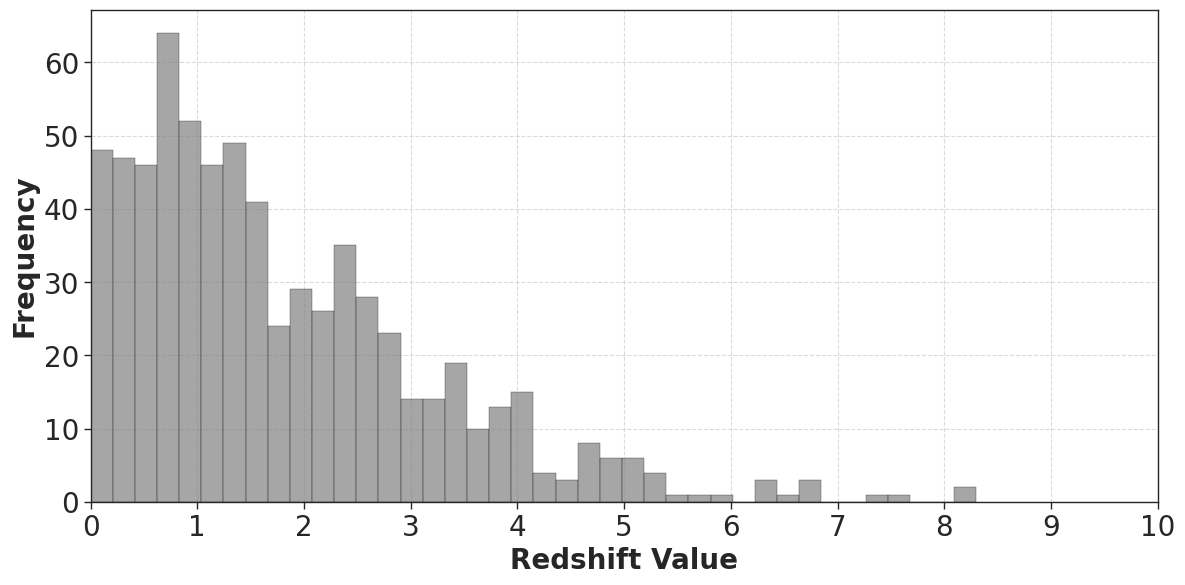

In [55]:
'''
Plot histogram for all redshifts
'''
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.histplot(redshift_values_list, bins=40, color='gray', alpha=0.7, edgecolor="black", linewidth=0.2)
plt.xlabel('Redshift Value', fontsize=20, fontweight="bold")
plt.ylabel('Frequency', fontsize=20, fontweight="bold")
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xticks(range(0, 11), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

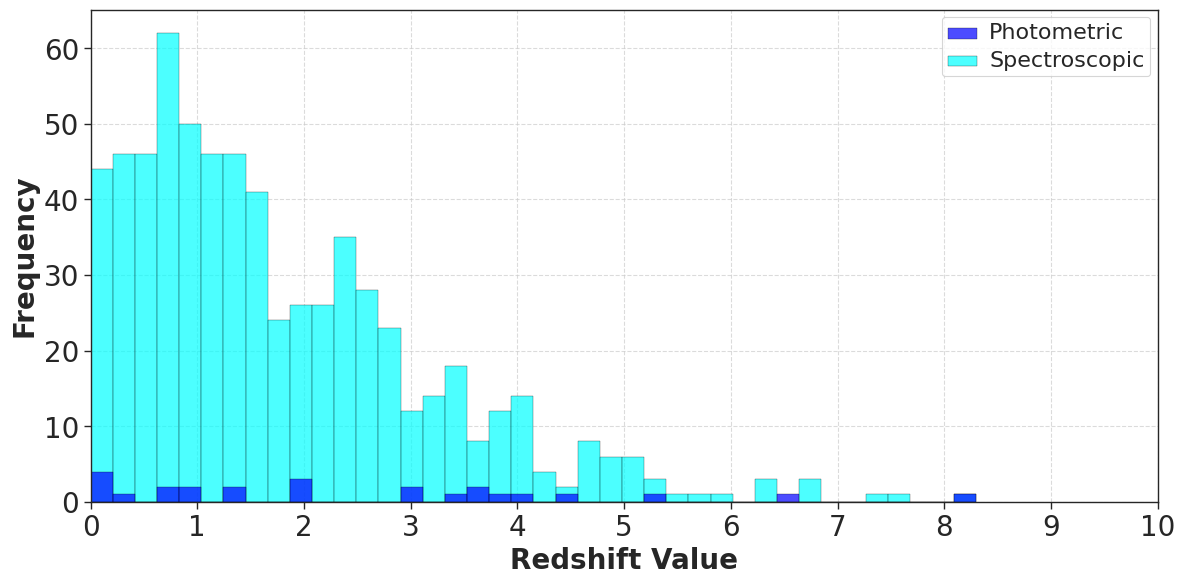

In [56]:
'''
Build histogram for photometric vs spectroscopic redshifts.
'''

# Create combined dataframe of both types of redshifts
photometric_df = pd.DataFrame({'Redshift': photometric_redshifts, 'Redshift Type': 'Photometric'})
spectroscopic_df = pd.DataFrame({'Redshift': spectroscopic_redshifts, 'Redshift Type': 'Spectroscopic'})
combined_df = pd.concat([photometric_df, spectroscopic_df])
combined_df.reset_index(drop=True, inplace=True)
palette = {'Spectroscopic': 'cyan', 'Photometric': 'blue'}

# Create overlayed histogram
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='Redshift', bins=40, hue='Redshift Type', alpha=0.7, edgecolor="black", linewidth=0.2, palette=palette)
legend = plt.gca().get_legend()
legend.set_title(None)
for text in legend.get_texts():
    text.set_fontsize(16)
plt.xlabel('Redshift Value', fontsize=20, fontweight="bold")
plt.ylabel('Frequency', fontsize=20, fontweight="bold")
# plt.title('Frequency Distribution of Photometric vs. Spectroscopic Redshift Values', fontsize=18, fontweight='bold')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xticks(range(0, 11), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 10)
plt.tight_layout()
plt.show()


In [57]:
# Get the top 10 highest redshift values (after filtering)
top_10_redshifts = sorted(redshift_values_list, reverse=True)[:10]

# Recompute parsed redshifts to match exactly
parsed_redshifts = []

for index, row in new_redshift_df.iterrows():
    redshift_string = row["Predicted Redshift"]

    z_match = re.fullmatch(r'^z\s*[=~]\s*~?\s*(\d*\.\d+|\d+)$', redshift_string)
    num_match = re.fullmatch(r'^~?\s*(\d*\.\d+|\d+)$', redshift_string)
    uncertainty_match = re.fullmatch(r'^(z\s*[=~]\s*)?(\d*\.\d+|\d+)\s*(\+[\/\\]?\-|±|\s\s)\s*(\d*\.\d+|\d+)$', redshift_string)
    upper_limit_match = re.fullmatch(r'^z\s*<\s*(\d*\.\d+|\d+)$', redshift_string)
    lower_limit_match = re.fullmatch(r'^z\s*>?\s*(\d*\.\d+|\d+)$', redshift_string)
    range_match = re.fullmatch(r'^~?\s*(\d*\.\d+|\d+)\s*(>=?\s*z\s*>=?|<=?\s*z\s*<=?)\s*~?\s*(\d*\.\d+|\d+)$', redshift_string)

    if z_match:
        parsed_redshifts.append(float(z_match.group(1)))
    elif num_match:
        parsed_redshifts.append(float(num_match.group(1)))
    elif uncertainty_match:
        parsed_redshifts.append(float(uncertainty_match.group(2)))
    elif upper_limit_match:
        parsed_redshifts.append(float(upper_limit_match.group(1)))
    elif lower_limit_match:
        parsed_redshifts.append(float(lower_limit_match.group(1)))
    elif range_match:
        start = float(range_match.group(1))
        end = float(range_match.group(3))
        midpoint = (start + end) / 2
        parsed_redshifts.append(midpoint)
    else:
        parsed_redshifts.append(None)

# Add temporary parsed redshift column
new_redshift_df["Parsed Redshift"] = parsed_redshifts

# Filter to top 10 exact-matching redshifts
top_rows_df = new_redshift_df[new_redshift_df["Parsed Redshift"].isin(top_10_redshifts)]

# Sort and keep only top 10
top_rows_df = top_rows_df.sort_values(by="Parsed Redshift", ascending=False).head(10)

# Drop the helper column before displaying
top_rows_df = top_rows_df.drop(columns=["Parsed Redshift", "Circular Date", "Text"])

# Show result
top_rows_df.head(10)


Circular Number Predicted Redshift Predicted GRB Number  \
913             6980                8.3           GRB 071021   
1250            9222              z~8.1            GRB090423   
1034            9216            z ~ 7.6           GRB 090423   
706            39732                7.3          GRB 250314A   
627            35756              6.782          GRB 240218A   
989             8225              z=6.7            GRB080913   
992             8256            z = 6.7           GRB 080913   
753             4545                6.6           GRB 060116   
263            16269             z=6.32          GRB 140515A   
543            30771              6.318          GRB 210905A   

            Predicted Telescope Name Predicted Redshift Type  
913                         PAIRITEL           Spectroscopic  
1250          NICS/Amici combination             Photometric  
1034      Italian TNG 3.6m telescope           Spectroscopic  
706                          ESO VLT           Spectroscopic  
627            ESO/VLT UT3 (Melipal)           Spectroscopic  
989       VLT (Very Large Telescope)           Spectroscopic  
992         Swift-BAT and Konus-Wind           Spectroscopic  
753                          ESO VLT             Photometric  
263   GMOS on Gemini-N 8-m telescope           Spectroscopic  
543                  ESO VLT Melipal           Spectroscopic

In [58]:
# Define the LaTeX column widths and headers
col_defs = {
    "Circular Number": "p{0.05\\textwidth}",
    "Predicted GRB Number": "p{0.15\\textwidth}",
    "Predicted Redshift": "p{0.15\\textwidth}",
    "Predicted Telescope Name": "p{0.25\\textwidth}",
    "Predicted Redshift Type": "p{0.15\\textwidth}"
}

# Start building LaTeX table
latex_table = r"""\setcounter{table}{5}
\begin{table}[h!]
\centering
\begin{longtable}{""" + "|" + "|".join(col_defs.values()) + "|}\n\\hline\n"

# Header row with gray background and bold text
header_row = " & ".join([
    f"\\multicolumn{{1}}{{|>{{\\columncolor[gray]{{.8}}[\\tabcolsep]}}{col_defs[col]}|}}{{\\bf{{{col}}}}}"
    for col in col_defs
])
latex_table += header_row + r" \\" + "\n\\hline\\hline\n"

# Add data rows
for _, row in top_rows_df.iterrows():
    row_line = " & ".join(str(row[col]) for col in col_defs)
    latex_table += row_line + r" \\\hline" + "\n"

# Close table
latex_table += r"""\end{longtable}
\caption{Highest redshift values extracted, after removal of errors.}
\label{tab:highest_redshift_table}
\end{table}
"""

print(latex_table)

\setcounter{table}{5}
\begin{table}[h!]
\centering
\begin{longtable}{|p{0.05\textwidth}|p{0.15\textwidth}|p{0.15\textwidth}|p{0.25\textwidth}|p{0.15\textwidth}|}
\hline
\multicolumn{1}{|>{\columncolor[gray]{.8}[\tabcolsep]}p{0.05\textwidth}|}{\bf{Circular Number}} & \multicolumn{1}{|>{\columncolor[gray]{.8}[\tabcolsep]}p{0.15\textwidth}|}{\bf{Predicted GRB Number}} & \multicolumn{1}{|>{\columncolor[gray]{.8}[\tabcolsep]}p{0.15\textwidth}|}{\bf{Predicted Redshift}} & \multicolumn{1}{|>{\columncolor[gray]{.8}[\tabcolsep]}p{0.25\textwidth}|}{\bf{Predicted Telescope Name}} & \multicolumn{1}{|>{\columncolor[gray]{.8}[\tabcolsep]}p{0.15\textwidth}|}{\bf{Predicted Redshift Type}} \\
\hline\hline
6980 & GRB 071021 & 8.3 & PAIRITEL & Spectroscopic \\\hline
9222 & GRB090423 & z~8.1 & NICS/Amici combination & Photometric \\\hline
9216 & GRB 090423 & z ~ 7.6 & Italian TNG 3.6m telescope & Spectroscopic \\\hline
39732 & GRB 250314A & 7.3 & ESO VLT & Spectroscopic \\\hline
35756 & GRB 240218A & 6.78

#Step 11: Plot Histogram for SWIFT GRB

In [59]:
accuracy_df = pd.read_csv('redshift_accuracy.csv')

In [60]:
'''
Build histogram for all redshift values.
'''

swift_redshift_values_list = []
swift_photometric_redshifts = []
swift_spectroscopic_redshifts = []
neither_type_list = []
unmatched_list = []

for index, row in accuracy_df.iterrows():
  redshift_string = row["Actual Redshift"]

  z_match = re.fullmatch(r'^z\s*[=~]\s*~?\s*(\d*\.\d+|\d+)$', redshift_string)
  num_match = re.fullmatch(r'^~?\s*(\d*\.\d+|\d+)$', redshift_string)
  uncertainty_match = re.fullmatch(r'^(z\s*[=~]\s*)?(\d*\.\d+|\d+)\s*(\+[\/\\]?\-|±|\s\s)\s*(\d*\.\d+|\d+)$', redshift_string)
  upper_limit_match = re.fullmatch(r'^z\s*<\s*(\d*\.\d+|\d+)$', redshift_string)
  lower_limit_match = re.fullmatch(r'^z\s*>?\s*(\d*\.\d+|\d+)$', redshift_string)
  range_match = re.fullmatch(r'^~?\s*(\d*\.\d+|\d+)\s*(>=?\s*z\s*>=?|<=?\s*z\s*<=?)\s*~?\s*(\d*\.\d+|\d+)$', redshift_string)

  if z_match: # Has format of z=...
    swift_redshift_values_list.append(float(z_match.group(1)))

  elif num_match: # Is just a single number
    swift_redshift_values_list.append(float(num_match.group(1)))

  elif uncertainty_match: # Is a redshift with +/- uncertainty
    swift_redshift_values_list.append(float(uncertainty_match.group(2)))

  elif upper_limit_match: # Is a redshift with upper limit. We take the limit
    swift_redshift_values_list.append(float(upper_limit_match.group(1)))

  elif lower_limit_match: # Is a redshift with lower limit. We take the limit
    swift_redshift_values_list.append(float(lower_limit_match.group(1)))

  elif range_match: # Is a redshift within a range. We take mid-point
    start = float(range_match.group(1))
    end = float(range_match.group(3))
    midpoint = (start + end) / 2
    swift_redshift_values_list.append(midpoint)

  elif row["Actual Redshift"] == "No Redshift":
    continue

  else:
    unmatched_list.append(row)
    continue

  if row["Actual Redshift Type"] == "Photometric":
    swift_photometric_redshifts.append(redshift_values_list[-1])

  elif row["Actual Redshift Type"] == "Spectroscopic":
    swift_spectroscopic_redshifts.append(redshift_values_list[-1])

  else:
    neither_type_list.append(row)

print(f"Length of redshift values list: {len(redshift_values_list)}")
print(f"Length of photometric redshifts: {len(photometric_redshifts)}")
print(f"Length of spectroscopic redshifts: {len(spectroscopic_redshifts)}")
print(f"Length of neither type list: {len(neither_type_list)}")
print(f"Length of unmatched list: {len(unmatched_list)}")

Length of redshift values list: 688
Length of photometric redshifts: 25
Length of spectroscopic redshifts: 662
Length of neither type list: 55
Length of unmatched list: 9


In [61]:
for row in unmatched_list:
  print(row)
  print()

Circular Number                                                         12542
Text                        GRB 111107A: VLT/X-shooter spectroscopyP. D'Av...
Actual Redshift             consistent with that reported by chornock et a...
Predicted Redshift                                                      1.998
Actual GRB Number                                                     111107A
Predicted GRB Number                                              GRB 111107A
Actual Telescope Name                                                     VLT
Predicted Telescope Name                                              ESO-VLT
Actual Redshift Type                                            Spectroscopic
Predicted Redshift Type                                         Spectroscopic
Circular Date                                         2011-11-07 16:32:22.000
Name: 156, dtype: object

Circular Number                                                         17758
Text                        GRB 150424

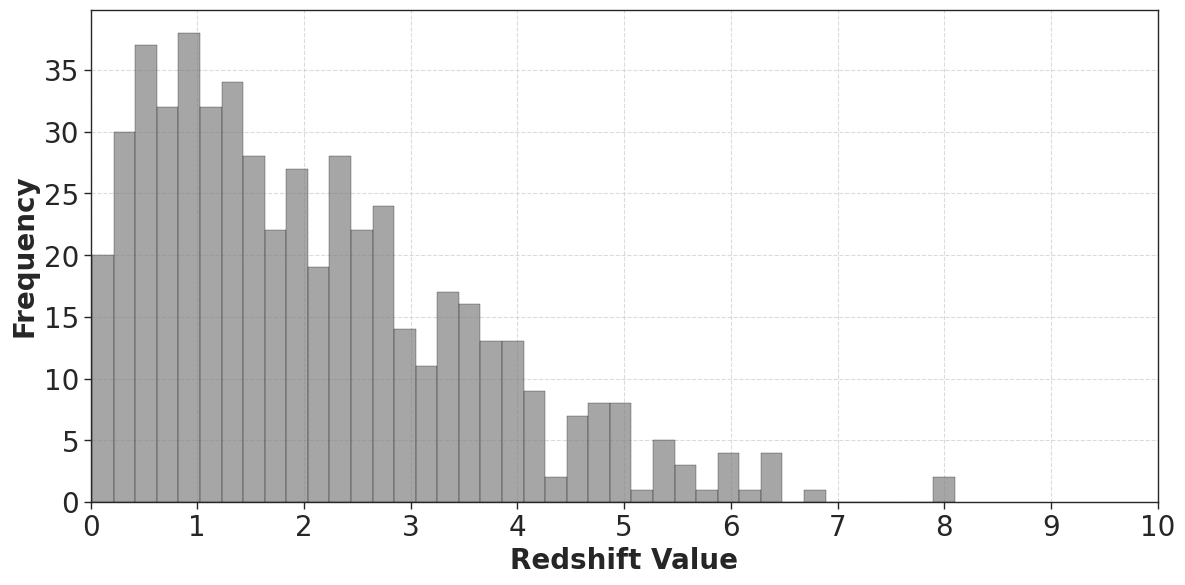

In [62]:
'''
Plot histogram for all redshifts
'''
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.histplot(swift_redshift_values_list, bins=40, color='gray', alpha=0.7, edgecolor="black", linewidth=0.2)
plt.xlabel('Redshift Value', fontsize=20, fontweight="bold")
plt.ylabel('Frequency', fontsize=20, fontweight="bold")
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xticks(range(0, 11), fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(0, 10)
plt.tight_layout()
plt.show()

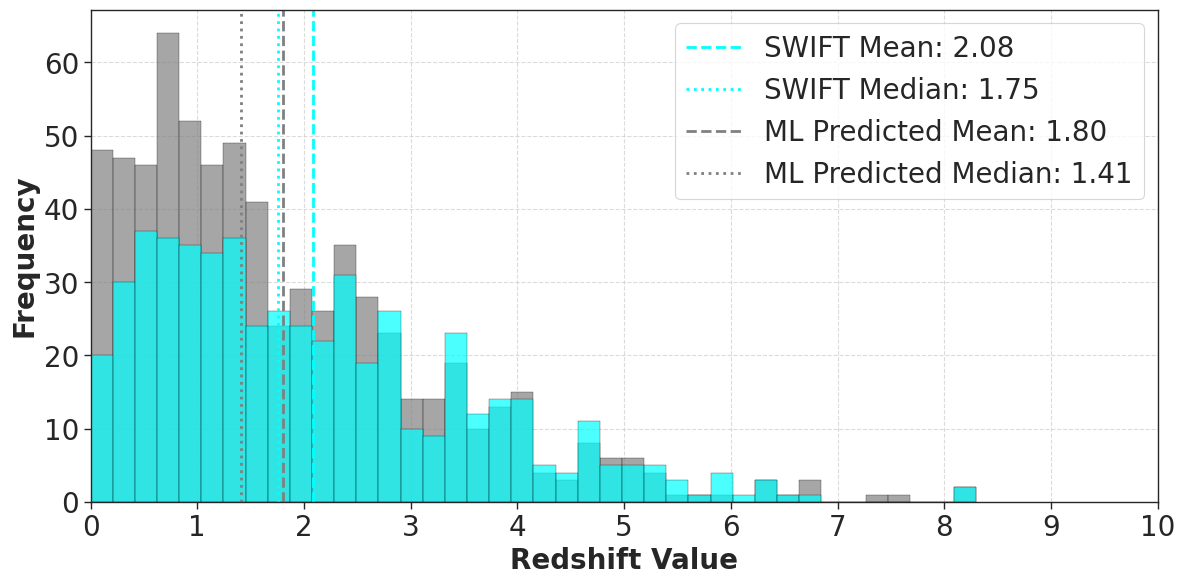

In [63]:
'''
Build histogram for SWIFT vs. Predicted redshifts.
'''

# Create combined dataframe of both types of redshifts
swift_df = pd.DataFrame({'Redshift': swift_redshift_values_list, 'Type': 'SWIFT Table'})
predicted_df = pd.DataFrame({'Redshift': redshift_values_list, 'Type': 'ML Predicted'})
combined_df = pd.concat([swift_df, predicted_df])
combined_df.reset_index(drop=True, inplace=True)
palette = {'SWIFT Table': 'cyan', 'ML Predicted': 'gray'}

# Create overlayed histogram
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='Redshift', bins=40, hue='Type', alpha=0.7, edgecolor="black", linewidth=0.2, palette=palette)

legend = plt.gca().get_legend()
legend.set_title(None)
for text in legend.get_texts():
    text.set_fontsize(20)
plt.xlabel('Redshift Value', fontsize=20, fontweight="bold")
plt.ylabel('Frequency', fontsize=20, fontweight="bold")
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xticks(range(0, 11), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 10)

# Calculate and plot mean and median
swift_mean = swift_df['Redshift'].mean()
swift_median = swift_df['Redshift'].median()
predicted_mean = predicted_df['Redshift'].mean()
predicted_median = predicted_df['Redshift'].median()

plt.axvline(swift_mean, color='cyan', linestyle='dashed', linewidth=2, label=f'SWIFT Mean: {swift_mean:.2f}')
plt.axvline(swift_median, color='cyan', linestyle='dotted', linewidth=2, label=f'SWIFT Median: {swift_median:.2f}')
plt.axvline(predicted_mean, color='gray', linestyle='dashed', linewidth=2, label=f'ML Predicted Mean: {predicted_mean:.2f}')
plt.axvline(predicted_median, color='gray', linestyle='dotted', linewidth=2, label=f'ML Predicted Median: {predicted_median:.2f}')
plt.legend(fontsize=20)

plt.tight_layout()
plt.show()

In [64]:
print(len(swift_redshift_values_list))
print(len(redshift_values_list))

533
688


#Step 12: Get Sorted Tables for Evaluation and Main Run

In [65]:
accuracy_df_sorted = pd.read_csv('redshift_accuracy.csv')
accuracy_df_sorted['Circular Number'] = pd.to_numeric(accuracy_df_sorted['Circular Number'])
accuracy_df_sorted = accuracy_df_sorted.sort_values(by='Circular Number')
accuracy_df_sorted.head()

Circular Number                                               Text  \
0                 1  GRB 970925: BATSE LocalizationThe BATSE team r...   
1                10  GRB 971214: KPNO Optical ObservationsOn 17 Dec...   
2               100  GRB980611K. Hurley, UC Berkeley Space Sciences...   
97              101  GRB980613 Near Infra-Red ObservationsR. G. McM...   
3              1000  GRB010222 - Optical observationThe optical cou...   

   Actual Redshift Predicted Redshift Actual GRB Number  \
0      No Redshift              0.692    No Information   
1      No Redshift        No Redshift    No Information   
2      No Redshift        No Redshift    No Information   
97     No Redshift        No Redshift    No Information   
3      No Redshift      1.25 +/- 0.06    No Information   

      Predicted GRB Number Actual Telescope Name  \
0                GRB970925        No Information   
1               GRB 971214        No Information   
2   GRB980611 (BATSE 6816)        No Information   
97               GRB980613        No Information   
3                GRB010222        No Information   

                 Predicted Telescope Name Actual Redshift Type  \
0                                   Swift       No Information   
1   Kitt Peak National Observatory (KPNO)       No Information   
2   UC Berkeley Space Sciences Laboratory       No Information   
97                 Isaac Newton Telescope       No Information   
3                                    CFHT       No Information   

   Predicted Redshift Type            Circular Date  
0            Spectroscopic  1997-09-26 00:00:00.000  
1              Photometric  1997-12-18 00:00:00.000  
2            Spectroscopic  1998-06-13 17:54:26.000  
97          No Information  1998-06-14 05:15:09.000  
3            Spectroscopic  2001-03-02 02:16:03.000

In [66]:
# Combine predicted and actual rows for more compact table
new_accuracy_df_sorted = accuracy_df_sorted.copy()

new_accuracy_df_sorted["Predicted / Actual GRB"] = new_accuracy_df_sorted["Predicted GRB Number"] + " / " + new_accuracy_df_sorted["Actual GRB Number"]
new_accuracy_df_sorted["Predicted / Actual Redshift"] = new_accuracy_df_sorted["Predicted Redshift"] + " / " + new_accuracy_df_sorted["Actual Redshift"]
new_accuracy_df_sorted["Predicted / Actual Telescope"] = new_accuracy_df_sorted["Predicted Telescope Name"] + " / " + new_accuracy_df_sorted["Actual Telescope Name"]
new_accuracy_df_sorted["Predicted / Actual Redshift Type"] = new_accuracy_df_sorted["Predicted Redshift Type"] + " / " + new_accuracy_df_sorted["Actual Redshift Type"]
new_accuracy_df_sorted["GCN"] = new_accuracy_df_sorted["Circular Number"]

new_accuracy_df_sorted = new_accuracy_df_sorted[[
    "GCN",
    "Predicted / Actual GRB",
    "Predicted / Actual Redshift",
    "Predicted / Actual Telescope",
    "Predicted / Actual Redshift Type"
]]

new_accuracy_df_sorted.head(10)

GCN                   Predicted / Actual GRB  \
0      1               GRB970925 / No Information   
1     10              GRB 971214 / No Information   
2    100  GRB980611 (BATSE 6816) / No Information   
97   101               GRB980613 / No Information   
3   1000               GRB010222 / No Information   
34  1003               GRB010222 / No Information   
42  1004               GRB010222 / No Information   
50  1005               GRB010222 / No Information   
65  1007              GRB 010222 / No Information   
76  1008              GRB 011211 / No Information   

    Predicted / Actual Redshift  \
0           0.692 / No Redshift   
1     No Redshift / No Redshift   
2     No Redshift / No Redshift   
97    No Redshift / No Redshift   
3   1.25 +/- 0.06 / No Redshift   
34  1.25 +/- 0.03 / No Redshift   
42    No Redshift / No Redshift   
50    No Redshift / No Redshift   
65    No Redshift / No Redshift   
76    No Redshift / No Redshift   

                         Predicted / Actual Telescope  \
0                              Swift / No Information   
1   Kitt Peak National Observatory (KPNO) / No Inf...   
2   UC Berkeley Space Sciences Laboratory / No Inf...   
97            Isaac Newton Telescope / No Information   
3                               CFHT / No Information   
34  CFHT (Canada-France-Hawaii Telescope) / No Inf...   
42     James Clerk Maxwell Telescope / No Information   
50         Chandra X-ray Observatory / No Information   
65  HEGRA Cherenkov telescope system / No Information   
76                          BeppoSAX / No Information   

   Predicted / Actual Redshift Type  
0    Spectroscopic / No Information  
1      Photometric / No Information  
2    Spectroscopic / No Information  
97  No Information / No Information  
3    Spectroscopic / No Information  
34   Spectroscopic / No Information  
42  No Information / No Information  
50   Spectroscopic / No Information  
65  No Information / No Information  
76   Spectroscopic / No Information

In [67]:
# Convert to LaTeX
accuracy_latex_table_sorted = new_accuracy_df_sorted.to_latex(
    index=False,
    column_format='|p{0.05\\textwidth}|p{0.15\\textwidth}|p{0.15\\textwidth}|p{0.25\\textwidth}|p{0.2\\textwidth}|',
    escape=False,
)
accuracy_latex_table_sorted = accuracy_latex_table_sorted.replace('tabular', 'longtable')
accuracy_latex_table_sorted = accuracy_latex_table_sorted.replace('\\toprule', '\\hline')
accuracy_latex_table_sorted = accuracy_latex_table_sorted.replace('\\midrule', '\\hline')
accuracy_latex_table_sorted = accuracy_latex_table_sorted.replace('\\bottomrule', '\\hline')
accuracy_latex_table_sorted = accuracy_latex_table_sorted.replace(' / ', ' / \\newline ')
accuracy_latex_table_sorted = accuracy_latex_table_sorted.replace(' \\\\', '  \\\\\\hline')

print(accuracy_latex_table_sorted)

\begin{longtable}{|p{0.05\textwidth}|p{0.15\textwidth}|p{0.15\textwidth}|p{0.25\textwidth}|p{0.2\textwidth}|}
\hline
GCN & Predicted / \newline Actual GRB & Predicted / \newline Actual Redshift & Predicted / \newline Actual Telescope & Predicted / \newline Actual Redshift Type  \\\hline
\hline
1 & GRB970925 / \newline No Information & 0.692 / \newline No Redshift & Swift / \newline No Information & Spectroscopic / \newline No Information  \\\hline
10 & GRB 971214 / \newline No Information & No Redshift / \newline No Redshift & Kitt Peak National Observatory (KPNO) / \newline No Information & Photometric / \newline No Information  \\\hline
100 & GRB980611 (BATSE 6816) / \newline No Information & No Redshift / \newline No Redshift & UC Berkeley Space Sciences Laboratory / \newline No Information & Spectroscopic / \newline No Information  \\\hline
101 & GRB980613 / \newline No Information & No Redshift / \newline No Redshift & Isaac Newton Telescope / \newline No Information & No Informat

In [68]:
new_accuracy_df_sorted.to_csv('redshift_accuracy_sorted.csv', index=False)

In [69]:
# Start from this line if you have an already uploaded redshift_accuracy_sorted.csv file
new_accuracy_df_sorted = pd.read_csv('redshift_accuracy_sorted.csv')

In [70]:
redshift_df_sorted = pd.read_csv('redshift_table.csv')
redshift_df_sorted['Circular Number'] = pd.to_numeric(redshift_df_sorted['Circular Number'])
redshift_df_sorted = redshift_df_sorted.sort_values(by='Circular Number')
redshift_df_sorted.head()

Circular Number            Circular Date  \
76                12  1997-12-18 00:00:00.000   
115               13  1997-12-18 00:00:00.000   
503               29  1998-01-11 00:00:00.000   
147              137  1998-07-08 01:14:18.000   
153              139  1998-07-08 08:03:20.000   

                                                  Text Predicted Redshift  \
76   GRB 971214: Redshift from Keck Optical Observa...               1.02   
115  GRB 971214: Redshift from Keck Optical Observa...               1.03   
503  GRB 971214: Redshift from Keck ObservationsGRB...             z=3.43   
147  GRB980703:  Spectrum of the proposed optical c...              0.967   
153  GRB 980703:  Spectrum of the proposed optical ...   0.9660 +- 0.0002   

    Predicted GRB Number   Predicted Telescope Name Predicted Redshift Type  
76            GRB 971214     Keck-II 10-m telescope           Spectroscopic  
115           GRB 971214     Keck-II 10-m telescope           Spectroscopic  
503           GRB 971214          Keck II telescope           Spectroscopic  
147           GRB 980703          Keck-II telescope           Spectroscopic  
153           GRB 980703  Caltech GRB collaboration           Spectroscopic

In [75]:
'''
Create Latex Table
'''

all_df_sorted = redshift_df_sorted.copy()
all_df_sorted["GCN"] = all_df_sorted["Circular Number"]
all_df_sorted["GRB Number"] = all_df_sorted["Predicted GRB Number"]
all_df_sorted["Redshift"] = all_df_sorted["Predicted Redshift"]
all_df_sorted["Telescope Name"] = all_df_sorted["Predicted Telescope Name"]
all_df_sorted["Redshift Type"] = all_df_sorted["Predicted Redshift Type"]

all_df_sorted = all_df_sorted[[
    "GCN",
    "GRB Number",
    "Redshift",
    "Telescope Name",
    "Redshift Type"
]]

all_table_sorted = all_df_sorted.to_latex(
    index=False,
    column_format='|p{0.05\\textwidth}|p{0.15\\textwidth}|p{0.15\\textwidth}|p{0.25\\textwidth}|p{0.15\\textwidth}|',
    escape=False,
)
all_table_sorted = all_table_sorted.replace('tabular', 'longtable')
all_table_sorted = all_table_sorted.replace('\\toprule', '\\hline')
all_table_sorted = all_table_sorted.replace('\\midrule', '\\hline')
all_table_sorted = all_table_sorted.replace('\\bottomrule', '\\hline')
all_table_sorted = all_table_sorted.replace(' \\\\', '  \\\\\\hline')
all_table_sorted = all_table_sorted.replace('^', '\\^')
all_table_sorted = all_table_sorted.replace('_', '\\_')
all_table_sorted = all_table_sorted.replace('~', '$\sim$')
all_table_sorted = all_table_sorted.replace('%', '\%')

print(all_table_sorted)

\begin{longtable}{|p{0.05\textwidth}|p{0.15\textwidth}|p{0.15\textwidth}|p{0.25\textwidth}|p{0.15\textwidth}|}
\hline
GCN & GRB Number & Redshift & Telescope Name & Redshift Type  \\\hline
\hline
12 & GRB 971214 & 1.02 & Keck-II 10-m telescope & Spectroscopic  \\\hline
13 & GRB 971214 & 1.03 & Keck-II 10-m telescope & Spectroscopic  \\\hline
29 & GRB 971214 & z=3.43 & Keck II telescope & Spectroscopic  \\\hline
137 & GRB 980703 & 0.967 & Keck-II telescope & Spectroscopic  \\\hline
139 & GRB 980703 & 0.9660 +- 0.0002 & Caltech GRB collaboration & Spectroscopic  \\\hline
189 & GRB 980613 & 1.0964 +- 0.0003 & Keck-I & Spectroscopic  \\\hline
216 & GRB 990123 & Approximately 0.2 to 0.3 & The Caltech-CARA-NRAO collaboration & Photometric  \\\hline
219 & GRB 990123 & 1.600 +- 0.001 & NOT, Copenhagen, IAC, LAEFF, IAA & Spectroscopic  \\\hline
223 & GRB 990123 & z$\sim$0.2 & Keck & Spectroscopic  \\\hline
249 & GRB 990123 & 1.598 +- 0.001 & NOT, Copenhagen, IAC, IAA, LAEFF, IAA & Spectroscopic

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\%'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-3930834305.py:32: SyntaxWarning: invalid escape sequence '\s'
  all_table_sorted = all_table_sorted.replace('~', '$\sim$')
/tmp/ipython-input-3930834305.py:33: SyntaxWarning: invalid escape sequence '\%'
  all_table_sorted = all_table_sorted.replace('%', '\%')


In [72]:
all_df_sorted.head()

GCN  GRB Number          Redshift             Telescope Name  \
76    12  GRB 971214              1.02     Keck-II 10-m telescope   
115   13  GRB 971214              1.03     Keck-II 10-m telescope   
503   29  GRB 971214            z=3.43          Keck II telescope   
147  137  GRB 980703             0.967          Keck-II telescope   
153  139  GRB 980703  0.9660 +- 0.0002  Caltech GRB collaboration   

     Redshift Type  
76   Spectroscopic  
115  Spectroscopic  
503  Spectroscopic  
147  Spectroscopic  
153  Spectroscopic

In [73]:
from google.colab import files
all_df_sorted.to_csv('redshift_table_sorted.csv', index=False)
files.download('redshift_table_sorted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>